# Univariate Testing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from src.utils import load_combined_dataset
import matplotlib.pyplot as plt

In [30]:
def _true_positives(T, X, margin=5):
    '''
    Compute true positives without double counting
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _true_positives({1, 10, 20, 23}, {3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 8, 20})
    {1, 10, 20}
    >>> _true_positives({1, 10, 20, 23}, {1, 3, 5, 8, 20})
    {1, 10, 20}
    >>> _true_positives(set(), {1, 2, 3})
    set()
    >>> _true_positives({1, 2, 3}, set())
    set()
    '''
    # make a copy so we don't affect the caller
    X = set(list(X))
    TP = set()
    for tau in T:
        close = [(abs(tau - x), x) for x in X if abs(tau - x) <= margin]
        close.sort()
        if not close:
            continue
        dist, xstar = close[0]
        TP.add(tau)
        X.remove(xstar)
    return TP


def f_measure(ground_truth, predictions, margin=5, alpha=0.5, return_PR=False):
    '''
    Compute the F-measure based on human annotations. Remember that all CP locations are 0-based!
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    :param annotations: dict from user_id to iterable of CP locations
    :param predictions: iterable of predicted CP locations
    :param alpha: value for the F-measure, alpha=0.5 gives the F1-measure
    :return: whether to return precision and recall too
    Examples
    -----------
    >>> f_measure({1: [10, 20], 2: [11, 20], 3: [10], 4: [0, 5]}, [10, 20])
    1.0
    >>> f_measure({1: [], 2: [10], 3: [50]}, [10])
    0.9090909090909091
    >>> f_measure({1: [], 2: [10], 3: [50]}, [])
    0.8
    '''
    annotations =	{'1':ground_truth}
    # ensure 0 is in all the sets
    Tks = {k + 1: set(annotations[uid]) for k, uid in enumerate(annotations)}
    for Tk in Tks.values():
        Tk.add(0)

    X = set(predictions)
    X.add(0)

    Tstar = set()
    for Tk in Tks.values():
        for tau in Tk:
            Tstar.add(tau)

    K = len(Tks)

    P = len(_true_positives(Tstar, X, margin=margin)) / len(X)

    TPk = {k: _true_positives(Tks[k], X, margin=margin) for k in Tks}
    R = 1 / K * sum(len(TPk[k]) / len(Tks[k]) for k in Tks)

    F = P * R / (alpha * R + (1 - alpha) * P)
    if return_PR:
        return F, P, R
    return F
def _cover_single(Sprime, S):
    '''
    Compute the covering of a segmentation S by a segmentation Sprime.
    This follows equation (8) in Arbaleaz, 2010.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _cover_single([{1, 2, 3}, {4, 5}, {6}], [{1, 2, 3}, {4, 5, 6}])
    0.8333333333333334
    >>> _cover_single([{1, 2, 3, 4}, {5, 6}], [{1, 2, 3, 4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2}, {3, 4}, {5, 6}], [{1, 2, 3}, {4, 5, 6}])
    0.6666666666666666
    >>> _cover_single([{1, 2, 3, 4, 5, 6}], [{1}, {2}, {3}, {4, 5, 6}])
    0.3333333333333333
    '''
    T = sum(map(len, Sprime))
    assert T == sum(map(len, S))
    C = 0
    for R in S:
        C += len(R) * max(_overlap(R, Rprime) for Rprime in Sprime)
    C /= T
    return C


def covering(ground_truth, predictions, n_obs):
    '''
    Compute the average segmentation covering against the human annotations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Parameters
    -----------
    @param annotations: dict from user_id to iterable of CP locations
    @param predictions: iterable of predicted Cp locations
    @param n_obs: number of observations in the series
    Examples
    -----------
    >>> covering({1: [10, 20], 2: [10], 3: [0, 5]}, [10, 20], 45)
    0.7962962962962963
    >>> covering({1: [], 2: [10], 3: [40]}, [10], 45)
    0.7954144620811286
    >>> covering({1: [], 2: [10], 3: [40]}, [], 45)
    0.8189300411522634
    '''
    annotations =	{'1':ground_truth}
    Ak = {
        k + 1: _partition_from_cps(annotations[uid], n_obs)
        for k, uid in enumerate(annotations)
    }
    pX = _partition_from_cps(predictions, n_obs)

    Cs = [_cover_single(pX, Ak[k]) for k in Ak]
    return sum(Cs) / len(Cs)

def _partition_from_cps(locations, n_obs):
    '''
    Return a list of sets that give a partition of the set [0, T-1], as
    defined by the change point locations.
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _partition_from_cps([], 5)
    [{0, 1, 2, 3, 4}]
    >>> _partition_from_cps([3, 5], 8)
    [{0, 1, 2}, {3, 4}, {5, 6, 7}]
    >>> _partition_from_cps([1,2,7], 8)
    [{0}, {1}, {2, 3, 4, 5, 6}, {7}]
    >>> _partition_from_cps([0, 4], 6)
    [{0, 1, 2, 3}, {4, 5}]
    '''
    T = n_obs
    partition = []
    current = set()

    all_cps = iter(sorted(set(locations)))
    cp = next(all_cps, None)
    for i in range(T):
        if i == cp:
            if current:
                partition.append(current)
            current = set()
            cp = next(all_cps, None)
        current.add(i)
    partition.append(current)
    return partition

def _overlap(A, B):
    '''
    Return the overlap (i.e. Jaccard index) of two sets
    Author: G.J.J. van den Burg (https://github.com/alan-turing-institute/TCPDBench)
    Examples
    -----------
    >>> _overlap({1, 2, 3}, set())
    0.0
    >>> _overlap({1, 2, 3}, {2, 5})
    0.25
    >>> _overlap(set(), {1, 2, 3})
    0.0
    >>> _overlap({1, 2, 3}, {1, 2, 3})
    1.0
    '''
    return len(A.intersection(B)) / len(A.union(B))

# ClaSP

In [25]:
from claspy.segmentation import BinaryClaSPSegmentation

Let's load and list the datasets.

In [3]:
df_ts = load_combined_dataset()
df_ts

name  window_size  \
0                                               Cane          100   
1                                       DutchFactory           24   
2                                             EEGRat           10   
3                                            EEGRat2           10   
4                                          Fetal2013           70   
5                                   GrandMalSeizures           10   
6                                  GrandMalSeizures2           10   
7                                       GreatBarbet1           50   
8                                       GreatBarbet2           50   
9                                         InsectEPG1           50   
10                                        InsectEPG2           50   
11                                        InsectEPG3           50   
12                                        InsectEPG4           50   
13                                          NogunGun          150   
14          PigInternalBleedingDatasetAirwayPressure          400   
15  PigInternalBleedingDatasetArtPressureFluidFilled          100   
16                     PigInternalBleedingDatasetCVP          100   
17                                       Powerdemand           12   
18                               PulsusParadoxusECG1           30   
19                               PulsusParadoxusECG2           30   
20                               PulsusParadoxusSP02           30   
21                               RoboticDogActivityX           60   
22                               RoboticDogActivityY           60   
23                               RoboticDogActivityZ           64   
24                                   SimpleSynthetic          125   
25                               SuddenCardiacDeath1           25   
26                               SuddenCardiacDeath2           25   
27                               SuddenCardiacDeath3           25   
28                                           TiltABP          210   
29                                           TiltECG          200   
30                                       WalkJogRun1           80   
31                                       WalkJogRun2           80   
0                                              Adiac           10   
1                                          ArrowHead           10   
2                                               Beef           50   
3                                          BeetleFly           10   
4                                        BirdChicken           20   
5                                                Car           20   
6                                                CBF           20   
7                              ChlorineConcentration           10   
8                                       CinCECGTorso           10   
9                                             Coffee           10   
10                                         Computers           50   
11                                          CricketX           10   
12                                          CricketY           10   
13                                          CricketZ           10   
14                               DiatomSizeReduction           20   
15                      DistalPhalanxOutlineAgeGroup           50   
16                                   DistalPhalanxTW           10   
17                                       Earthquakes           10   
18                                            ECG200           20   
19                                           ECG5000           10   
20                                       ECGFiveDays           20   
21                                   ElectricDevices           10   
22                                           FaceAll           10   
23                                          FaceFour           50   
24                                          FacesUCR           20   
25                                        Fift

In [21]:
ground_truth = df_ts['change points']
ground_truth = ground_truth.to_numpy()
data = df_ts['time_series']
data = data.to_numpy()
windows = df_ts['window_size']
windows = windows.to_numpy()

In [54]:
coverings1 = []
for i,ts in enumerate(data):
    clasp = BinaryClaSPSegmentation(window_size=windows[i])
    predictions = clasp.fit_predict(ts)
    print(predictions)
    coverings1.append(covering(ground_truth[i], predictions, len(ts)))


[2351 3187]
[2166]
[997]
[1183]
[  992  1605  2006  3853  5977 11989]
[ 8183  9505 12335 16041]
[2850 4558 6069]
[1275 1578 1878 2534 3680]
[1883 3724]
[ 2179  3774  4103  4353  5025  5510  7564 10432 11229 13642]


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_stats_py.py:8509: RuntimeWarning: invalid value encountered in double_scalars
  z = (s - expected) / np.sqrt(n1*n2*(n1+n2+1)/12.0)


[ 521 1702]
[ 360 1101 1648 3383]
[  409  1087  3339  3589  3905  5671 12510]
[ 750 2965 4330 5643]
[2000 4000 6694]
[7559]
[7430]
[]
[10000]
[9996]
[2644 3879 9981]
[ 4646  8669  9221  9833 11038]
[10669 11221 11833 13038]
[4003]
[2906 4979 6545]
[ 4864  6312  6453  6598  6841  7095  7376  7812  8610  9066  9535 10893
 11545]
[1179 2439 3266 5432 6272 7747]
[ 2854  3233  5419  9266  9562 10021 10358]
[ 1404  3020  4962  7168  8563 12549 17495 19112 22357 24907 26215 27622
 29774 33200 34561 35845 38317]
[ 2429  5907  6993 16746 19576 22492 24844]
[ 405 2653 3500 3900 4300 4807 6711 7189 8240 9521]
[3892 5494 6730 9451]
[ 565 1016 1235]
[750]
[282 686]
[1280]
[1276]
[ 568 1146 1262 1512]
[390 697]
[]
[2651 5148]
[497]
[1547 1926 2233 4045 4295 4921 5458]
[ 719 1287 1922 2585]
[ 515 1155 1831 2399]
[ 593 1105 1547 2124]
[ 516  945 1145]
[296]
[531]
[]
[722]
[1276]
[479]
[1038 4525 5719 7883]
[1306 2612 3931 5241 6546 7849]
[1158 2775 5575 6632]
[ 867 1635 2300 3748 4714 5194 5561]
[1750

# FLOSS

In [41]:
import stumpy
from stumpy.floss import _cac

In [62]:
coverings2 = []
for i,ts in enumerate(data):
    m = windows[i]
    mp = stumpy.stump(ts, m=m)
    L = windows[i]
    cac, predictions = stumpy.fluss(mp[:, 1], L=L, n_regimes=len(ground_truth[i])+1, excl_factor=1)
    print(predictions)
    coverings2.append(covering(ground_truth[i], predictions, len(ts)))

[2262]
[2152]
[996]
[1271]
[ 5956 11996]
[8172]
[10402]
[1876 3679]
[3723 3672]
[3602]
[1669]
[1644]
[3857]
[2963]
[6638]
[7459]
[7403]
[4492]
[9996]
[9979]
[9978]
[8667]
[10667]
[3938]
[2832 2960]
[7799 7719]
[3240]
[3229]
[24906]
[24609]
[3447 6686]
[6730 3561]
[563 573 552]
[749]
[658]
[1238]
[2303]
[1142  568 1121]
[368 690]
[11]
[  39 2581]
[494]
[10965]
[1929 1918 1276 1946]
[1834 1821 1810 1844]
[1104  555 1117 1088]
[944 906]
[252]
[576 531]
[10284]
[705]
[1272]
[464]
[1084 1060 1049 1094]
[1304 1314 1324 1293 1334 1282]
[2724 2774 2824]
[ 846  866  825  886 1557 1624]
[1748 1758 1737]
[5731 5719 5766 5755 5784 5741]
[889]
[  18 5847]
[4801  975]
[633 598 312]
[796]
[8235 8134]
[626]
[1234 1183 1115 3827]
[2549 2560 2538]
[1113 1102]
[1722]
[907]
[8107 8015 8041 8127 8086]
[ 8107  8086  8127  8065 12415  8147]
[3683 3733]
[903 892]
[2411 2400 3053 2421 1941 2389]
[2348 2337]
[3662 3651 3672]
[1248 1260 1279 1237]
[401]
[702]
[1365 1376]
[3191 3201 3211]
[1286 1330 1275]
[1498 1

# DC-TSS

In [66]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import os
import csv
from scipy import stats as st
from utils import *

import torch.nn as nn
import torch.optim as optim
import torchvision


import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn.functional as F
from torch.autograd import Variable
import math
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial import distance
from TS_DEC import *
from scipy.signal import find_peaks, peak_prominences

#from TS_DEC_Linear import *

5340
cuda
epoch 1,loss = 1.03469193
epoch 2,loss = 1.03466797
epoch 3,loss = 1.03464890
epoch 4,loss = 1.03463471
epoch 5,loss = 1.03462517
epoch 6,loss = 1.03461981
epoch 7,loss = 1.03461802
epoch 8,loss = 1.03461790
epoch 9,loss = 1.03461826
epoch 10,loss = 1.03461671
epoch 11,loss = 1.03461587
epoch 12,loss = 1.03461623
epoch 13,loss = 1.03461647
epoch 14,loss = 1.03461659
epoch 15,loss = 1.03461683
epoch 16,loss = 1.03461695
epoch 17,loss = 1.03461707
epoch 18,loss = 1.03461730
epoch 19,loss = 1.03461742
epoch 20,loss = 1.03461754
epoch 21,loss = 1.03461754
epoch 22,loss = 1.03461766
epoch 23,loss = 1.03461766
epoch 24,loss = 1.03461778
epoch 25,loss = 1.03461778
epoch 26,loss = 1.03461790
epoch 27,loss = 1.03461790
epoch 28,loss = 1.03461790
epoch 29,loss = 1.03461790
epoch 30,loss = 1.03461790
epoch 31,loss = 1.03461790
epoch 32,loss = 1.03461778
epoch 33,loss = 1.03461778
epoch 34,loss = 1.03461766
epoch 35,loss = 1.03461766
epoch 36,loss = 1.03461766
epoch 37,loss = 1.03461754


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 41,loss = 1.03461742
epoch 42,loss = 1.03461730
epoch 43,loss = 1.03461730
epoch 44,loss = 1.03461719
epoch 45,loss = 1.03461707
epoch 46,loss = 1.03461707
epoch 47,loss = 1.03461695
epoch 48,loss = 1.03461695
epoch 49,loss = 1.03461683
epoch 50,loss = 1.03461683
epoch 51,loss = 1.03461671
epoch 52,loss = 1.03461659
epoch 53,loss = 1.03461647
epoch 54,loss = 1.03461647
epoch 55,loss = 1.03461635
epoch 56,loss = 1.03461623
epoch 57,loss = 1.03461623
epoch 58,loss = 1.03461611
epoch 59,loss = 1.03461611
epoch 60,loss = 1.03461611
epoch 61,loss = 1.03461587
epoch 62,loss = 1.03461587
epoch 63,loss = 1.03461576
epoch 64,loss = 1.03461576
epoch 65,loss = 1.03461564
epoch 66,loss = 1.03461564
epoch 67,loss = 1.03461552
epoch 68,loss = 1.03461552
epoch 69,loss = 1.03461540
epoch 70,loss = 1.03461540
epoch 71,loss = 1.03461528
epoch 72,loss = 1.03461516
epoch 73,loss = 1.03461516
epoch 74,loss = 1.03461504
epoch 75,loss = 1.03461504
epoch 76,loss = 1.03461492
epoch 77,loss = 1.03461504
e

epoch 349,loss = 0.79675066
epoch 350,loss = 0.79630738
epoch 351,loss = 0.79587501
epoch 352,loss = 0.79545742
epoch 353,loss = 0.79505491
epoch 354,loss = 0.79466677
epoch 355,loss = 0.79428208
epoch 356,loss = 0.79389811
epoch 357,loss = 0.79352033
epoch 358,loss = 0.79315239
epoch 359,loss = 0.79278952
epoch 360,loss = 0.79242378
epoch 361,loss = 0.79206133
epoch 362,loss = 0.79170609
epoch 363,loss = 0.79135346
epoch 364,loss = 0.79100591
epoch 365,loss = 0.79066020
epoch 366,loss = 0.79031771
epoch 367,loss = 0.78997791
epoch 368,loss = 0.78964192
epoch 369,loss = 0.78930968
epoch 370,loss = 0.78897965
epoch 371,loss = 0.78865486
epoch 372,loss = 0.78833467
epoch 373,loss = 0.78801852
epoch 374,loss = 0.78769767
epoch 375,loss = 0.78738266
epoch 376,loss = 0.78707165
epoch 377,loss = 0.78676689
epoch 378,loss = 0.78646797
epoch 379,loss = 0.78617471
epoch 380,loss = 0.78588337
epoch 381,loss = 0.78559649
epoch 382,loss = 0.78531533
epoch 383,loss = 0.78504115
epoch 384,loss = 0.7

epoch 684,loss = 0.75465131
epoch 685,loss = 0.75461096
epoch 686,loss = 0.75456798
epoch 687,loss = 0.75452387
epoch 688,loss = 0.75448042
epoch 689,loss = 0.75443745
epoch 690,loss = 0.75439495
epoch 691,loss = 0.75435305
epoch 692,loss = 0.75431162
epoch 693,loss = 0.75427049
epoch 694,loss = 0.75422961
epoch 695,loss = 0.75418872
epoch 696,loss = 0.75414747
epoch 697,loss = 0.75410587
epoch 698,loss = 0.75406414
epoch 699,loss = 0.75402260
epoch 700,loss = 0.75398153
epoch 701,loss = 0.75394046
epoch 702,loss = 0.75390017
epoch 703,loss = 0.75385875
epoch 704,loss = 0.75381750
epoch 705,loss = 0.75377661
epoch 706,loss = 0.75373584
epoch 707,loss = 0.75369543
epoch 708,loss = 0.75365531
epoch 709,loss = 0.75361598
epoch 710,loss = 0.75357646
epoch 711,loss = 0.75353664
epoch 712,loss = 0.75349736
epoch 713,loss = 0.75345868
epoch 714,loss = 0.75342071
epoch 715,loss = 0.75338352
epoch 716,loss = 0.75334549
epoch 717,loss = 0.75330764
epoch 718,loss = 0.75327003
epoch 719,loss = 0.7

epoch 1033,loss = 0.74457252
epoch 1034,loss = 0.74455482
epoch 1035,loss = 0.74453717
epoch 1036,loss = 0.74451900
epoch 1037,loss = 0.74450141
epoch 1038,loss = 0.74448389
epoch 1039,loss = 0.74446601
epoch 1040,loss = 0.74444836
epoch 1041,loss = 0.74443084
epoch 1042,loss = 0.74441248
epoch 1043,loss = 0.74439460
epoch 1044,loss = 0.74437642
epoch 1045,loss = 0.74435806
epoch 1046,loss = 0.74434024
epoch 1047,loss = 0.74432158
epoch 1048,loss = 0.74430269
epoch 1049,loss = 0.74428374
epoch 1050,loss = 0.74426556
epoch 1051,loss = 0.74424750
epoch 1052,loss = 0.74422860
epoch 1053,loss = 0.74420917
epoch 1054,loss = 0.74419051
epoch 1055,loss = 0.74417198
epoch 1056,loss = 0.74415284
epoch 1057,loss = 0.74413466
epoch 1058,loss = 0.74411619
epoch 1059,loss = 0.74409717
epoch 1060,loss = 0.74407828
epoch 1061,loss = 0.74405974
epoch 1062,loss = 0.74404085
epoch 1063,loss = 0.74402225
epoch 1064,loss = 0.74400270
epoch 1065,loss = 0.74398154
epoch 1066,loss = 0.74396050
epoch 1067,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([131, 1, 100])
1.0
Epoch 200:   loss= 0.18152  cluster difference= 1.0
Epoch 400:   loss= 0.18164  cluster difference= 0.015267175572519083
Epoch 600:   loss= 0.18157  cluster difference= 0.007633587786259542
[1 1 1 1 1 2 6 6 6 4 0 0 5 6 6 4 4 0 0 0 5 5 5 6 6 4 7 4 0 0 0 0 5 6 4 4 0
 0 0 5 5 6 6 4 4 0 0 5 6 6 4 7 7 4 0 5 6 1 1 2 5 1 1 2 5 2 5 2 2 2 5 2 5 1
 6 1 2 0 2 5 2 7 2 5 1 1 1 2 7 2 3 4 5 2 6 2 5 2 5 2 0 4 0 3 4 3 4 6 2 0 0
 5 1 6 2 2 4 0 5 0 7 4 7 2 5 1 1 1 1 1 1]


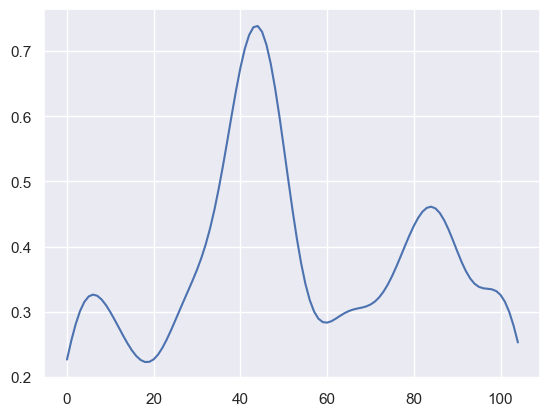

[2330]
[2345]
8761
cuda
epoch 1,loss = 1.00314224
epoch 2,loss = 1.00313032
epoch 3,loss = 1.00311840
epoch 4,loss = 1.00310659
epoch 5,loss = 1.00309467
epoch 6,loss = 1.00308311
epoch 7,loss = 1.00307143
epoch 8,loss = 1.00305986
epoch 9,loss = 1.00304830
epoch 10,loss = 1.00303686
epoch 11,loss = 1.00302553
epoch 12,loss = 1.00301421
epoch 13,loss = 1.00300300
epoch 14,loss = 1.00299180
epoch 15,loss = 1.00298071
epoch 16,loss = 1.00296974
epoch 17,loss = 1.00295877
epoch 18,loss = 1.00294793
epoch 19,loss = 1.00293708
epoch 20,loss = 1.00292635
epoch 21,loss = 1.00291574
epoch 22,loss = 1.00290513
epoch 23,loss = 1.00289452
epoch 24,loss = 1.00288415
epoch 25,loss = 1.00287366
epoch 26,loss = 1.00286341
epoch 27,loss = 1.00285316
epoch 28,loss = 1.00284290
epoch 29,loss = 1.00283289


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 30,loss = 1.00282288
epoch 31,loss = 1.00281298
epoch 32,loss = 1.00280309
epoch 33,loss = 1.00279319
epoch 34,loss = 1.00278354
epoch 35,loss = 1.00277388
epoch 36,loss = 1.00276434
epoch 37,loss = 1.00275481
epoch 38,loss = 1.00274539
epoch 39,loss = 1.00273609
epoch 40,loss = 1.00272667
epoch 41,loss = 1.00271738
epoch 42,loss = 1.00270832
epoch 43,loss = 1.00269914
epoch 44,loss = 1.00269020
epoch 45,loss = 1.00268126
epoch 46,loss = 1.00267231
epoch 47,loss = 1.00266349
epoch 48,loss = 1.00265467
epoch 49,loss = 1.00264609
epoch 50,loss = 1.00263739
epoch 51,loss = 1.00262880
epoch 52,loss = 1.00262034
epoch 53,loss = 1.00261188
epoch 54,loss = 1.00260365
epoch 55,loss = 1.00259531
epoch 56,loss = 1.00258708
epoch 57,loss = 1.00257885
epoch 58,loss = 1.00257087
epoch 59,loss = 1.00256288
epoch 60,loss = 1.00255489
epoch 61,loss = 1.00254691
epoch 62,loss = 1.00253904
epoch 63,loss = 1.00253129
epoch 64,loss = 1.00252354
epoch 65,loss = 1.00251591
epoch 66,loss = 1.00250828
e

epoch 327,loss = 0.52566850
epoch 328,loss = 0.52527946
epoch 329,loss = 0.52489817
epoch 330,loss = 0.52452254
epoch 331,loss = 0.52415359
epoch 332,loss = 0.52379042
epoch 333,loss = 0.52342719
epoch 334,loss = 0.52306163
epoch 335,loss = 0.52269673
epoch 336,loss = 0.52233553
epoch 337,loss = 0.52197957
epoch 338,loss = 0.52162832
epoch 339,loss = 0.52128053
epoch 340,loss = 0.52094096
epoch 341,loss = 0.52060521
epoch 342,loss = 0.52027339
epoch 343,loss = 0.51994777
epoch 344,loss = 0.51962698
epoch 345,loss = 0.51930863
epoch 346,loss = 0.51899630
epoch 347,loss = 0.51868755
epoch 348,loss = 0.51838636
epoch 349,loss = 0.51809227
epoch 350,loss = 0.51780272
epoch 351,loss = 0.51751661
epoch 352,loss = 0.51723570
epoch 353,loss = 0.51695895
epoch 354,loss = 0.51668602
epoch 355,loss = 0.51641744
epoch 356,loss = 0.51615345
epoch 357,loss = 0.51589078
epoch 358,loss = 0.51563179
epoch 359,loss = 0.51537788
epoch 360,loss = 0.51512456
epoch 361,loss = 0.51487213
epoch 362,loss = 0.5

epoch 622,loss = 0.48185405
epoch 623,loss = 0.48176828
epoch 624,loss = 0.48168248
epoch 625,loss = 0.48159668
epoch 626,loss = 0.48151112
epoch 627,loss = 0.48142630
epoch 628,loss = 0.48134142
epoch 629,loss = 0.48125640
epoch 630,loss = 0.48117101
epoch 631,loss = 0.48108506
epoch 632,loss = 0.48099840
epoch 633,loss = 0.48091131
epoch 634,loss = 0.48082343
epoch 635,loss = 0.48073524
epoch 636,loss = 0.48064679
epoch 637,loss = 0.48055807
epoch 638,loss = 0.48046914
epoch 639,loss = 0.48038042
epoch 640,loss = 0.48029190
epoch 641,loss = 0.48020312
epoch 642,loss = 0.48011383
epoch 643,loss = 0.48002416
epoch 644,loss = 0.47993439
epoch 645,loss = 0.47984406
epoch 646,loss = 0.47975355
epoch 647,loss = 0.47966301
epoch 648,loss = 0.47957209
epoch 649,loss = 0.47948065
epoch 650,loss = 0.47938907
epoch 651,loss = 0.47929752
epoch 652,loss = 0.47920570
epoch 653,loss = 0.47911403
epoch 654,loss = 0.47902220
epoch 655,loss = 0.47893035
epoch 656,loss = 0.47883749
epoch 657,loss = 0.4

epoch 932,loss = 0.46445274
epoch 933,loss = 0.46442932
epoch 934,loss = 0.46440604
epoch 935,loss = 0.46438286
epoch 936,loss = 0.46435994
epoch 937,loss = 0.46433601
epoch 938,loss = 0.46431187
epoch 939,loss = 0.46428788
epoch 940,loss = 0.46426404
epoch 941,loss = 0.46424022
epoch 942,loss = 0.46421638
epoch 943,loss = 0.46419263
epoch 944,loss = 0.46416888
epoch 945,loss = 0.46414575
epoch 946,loss = 0.46412262
epoch 947,loss = 0.46409953
epoch 948,loss = 0.46407652
epoch 949,loss = 0.46405351
epoch 950,loss = 0.46403062
epoch 951,loss = 0.46400771
epoch 952,loss = 0.46398491
epoch 953,loss = 0.46396190
epoch 954,loss = 0.46393898
epoch 955,loss = 0.46391609
epoch 956,loss = 0.46389323
epoch 957,loss = 0.46387047
epoch 958,loss = 0.46384764
epoch 959,loss = 0.46382502
epoch 960,loss = 0.46380240
epoch 961,loss = 0.46377972
epoch 962,loss = 0.46375716
epoch 963,loss = 0.46373460
epoch 964,loss = 0.46371207
epoch 965,loss = 0.46368963
epoch 966,loss = 0.46366730
epoch 967,loss = 0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([874, 1, 24])
1.0
Epoch 200:   loss= 0.20167  cluster difference= 1.0
Epoch 400:   loss= 0.20137  cluster difference= 0.010297482837528604
Epoch 600:   loss= 0.20112  cluster difference= 0.009153318077803204
[5 0 6 6 6 6 6 6 6 6 0 7 5 3 2 1 4 5 0 2 3 0 6 6 6 0 2 1 4 5 0 2 3 4 1 7 5
 0 6 6 6 6 0 2 3 4 1 7 5 0 2 1 7 5 0 6 6 6 6 7 5 3 2 1 4 5 0 2 3 4 1 6 6 0
 6 6 7 5 0 2 1 4 1 4 5 3 2 1 0 0 0 0 0 4 1 7 5 3 2 1 4 5 3 2 3 0 0 0 0 0 2
 1 4 5 7 2 3 4 1 7 5 3 0 0 0 0 7 2 3 4 1 7 5 3 2 1 4 5 0 6 6 0 0 7 5 3 2 1
 4 5 0 2 3 4 1 0 0 0 0 0 4 5 0 2 3 4 1 7 5 3 2 1 0 0 0 0 0 4 1 7 5 3 2 1 4
 5 0 2 3 0 0 0 0 0 2 1 4 5 0 2 3 4 1 4 5 3 0 0 0 0 0 2 3 4 1 0 0 0 4 1 7 5
 0 2 3 6 6 6 6 6 4 1 7 5 0 2 3 4 1 0 2 3 0 6 6 6 6 2 3 4 1 0 2 3 4 1 7 5 0
 6 6 6 6 0 2 3 4 1 7 5 0 2 3 7 1 0 6 6 6 6 7 5 0 2 3 6 6 6 2 3 4 3 6 6 6 6
 6 6 6 0 2 3 4 1 6 6 6 7 3 6 6 6 6 6 4 1 7 5 0 2 3 4 1 0 2 3 6 6 6 6 6 6 6
 7 1 0 2 3 4 1 7 5 6 6 6 6 6 0 2 3 4 1 7 5 0 2 3 7 1 0 6 6 6 6 7 5 0 2 3 7
 1 0 2 3 4 3 6 6 6 6 6 7 1 0 2 

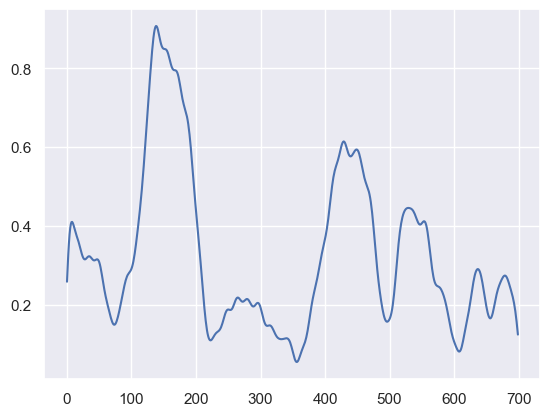

[2262, 5172]
[2184]
2000
cuda
epoch 1,loss = 1.00633764
epoch 2,loss = 1.00631928
epoch 3,loss = 1.00630105
epoch 4,loss = 1.00628269
epoch 5,loss = 1.00626457
epoch 6,loss = 1.00624621
epoch 7,loss = 1.00622797
epoch 8,loss = 1.00620973
epoch 9,loss = 1.00619161
epoch 10,loss = 1.00617337
epoch 11,loss = 1.00615513
epoch 12,loss = 1.00613701
epoch 13,loss = 1.00611889
epoch 14,loss = 1.00610077
epoch 15,loss = 1.00608253
epoch 16,loss = 1.00606453
epoch 17,loss = 1.00604641
epoch 18,loss = 1.00602841
epoch 19,loss = 1.00601041
epoch 20,loss = 1.00599241
epoch 21,loss = 1.00597441
epoch 22,loss = 1.00595641
epoch 23,loss = 1.00593853
epoch 24,loss = 1.00592065
epoch 25,loss = 1.00590265
epoch 26,loss = 1.00588477
epoch 27,loss = 1.00586689
epoch 28,loss = 1.00584900
epoch 29,loss = 1.00583112
epoch 30,loss = 1.00581336
epoch 31,loss = 1.00579560
epoch 32,loss = 1.00577772
epoch 33,loss = 1.00575995
epoch 34,loss = 1.00574207
epoch 35,loss = 1.00572407
epoch 36,loss = 1.00570595
epoch 3

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 44,loss = 1.00552976
epoch 45,loss = 1.00549948
epoch 46,loss = 1.00546718
epoch 47,loss = 1.00543153
epoch 48,loss = 1.00539196
epoch 49,loss = 1.00534868
epoch 50,loss = 1.00530231
epoch 51,loss = 1.00525272
epoch 52,loss = 1.00519943
epoch 53,loss = 1.00514281
epoch 54,loss = 1.00508332
epoch 55,loss = 1.00502074
epoch 56,loss = 1.00495017
epoch 57,loss = 1.00485408
epoch 58,loss = 1.00473094
epoch 59,loss = 1.00456166
epoch 60,loss = 1.00431955
epoch 61,loss = 1.00395954
epoch 62,loss = 1.00346279
epoch 63,loss = 1.00288594
epoch 64,loss = 1.00218105
epoch 65,loss = 1.00132000
epoch 66,loss = 1.00032520
epoch 67,loss = 0.99922127
epoch 68,loss = 0.99799436
epoch 69,loss = 0.99666905
epoch 70,loss = 0.99524140
epoch 71,loss = 0.99368346
epoch 72,loss = 0.99197423
epoch 73,loss = 0.99016625
epoch 74,loss = 0.98825622
epoch 75,loss = 0.98626608
epoch 76,loss = 0.98421711
epoch 77,loss = 0.98218006
epoch 78,loss = 0.98023266
epoch 79,loss = 0.97838598
epoch 80,loss = 0.97666794
e

epoch 361,loss = 0.75526148
epoch 362,loss = 0.75506884
epoch 363,loss = 0.75487828
epoch 364,loss = 0.75468904
epoch 365,loss = 0.75450003
epoch 366,loss = 0.75431406
epoch 367,loss = 0.75412750
epoch 368,loss = 0.75394255
epoch 369,loss = 0.75375944
epoch 370,loss = 0.75357759
epoch 371,loss = 0.75339687
epoch 372,loss = 0.75321829
epoch 373,loss = 0.75303698
epoch 374,loss = 0.75284892
epoch 375,loss = 0.75265884
epoch 376,loss = 0.75246841
epoch 377,loss = 0.75227898
epoch 378,loss = 0.75209111
epoch 379,loss = 0.75190693
epoch 380,loss = 0.75171983
epoch 381,loss = 0.75153100
epoch 382,loss = 0.75134307
epoch 383,loss = 0.75115573
epoch 384,loss = 0.75096935
epoch 385,loss = 0.75078624
epoch 386,loss = 0.75060165
epoch 387,loss = 0.75041825
epoch 388,loss = 0.75023615
epoch 389,loss = 0.75005627
epoch 390,loss = 0.74987775
epoch 391,loss = 0.74969983
epoch 392,loss = 0.74952167
epoch 393,loss = 0.74934357
epoch 394,loss = 0.74916667
epoch 395,loss = 0.74899095
epoch 396,loss = 0.7

epoch 665,loss = 0.73008907
epoch 666,loss = 0.73005414
epoch 667,loss = 0.73001933
epoch 668,loss = 0.72998476
epoch 669,loss = 0.72995061
epoch 670,loss = 0.72991669
epoch 671,loss = 0.72988290
epoch 672,loss = 0.72984934
epoch 673,loss = 0.72981590
epoch 674,loss = 0.72978270
epoch 675,loss = 0.72974950
epoch 676,loss = 0.72971612
epoch 677,loss = 0.72968310
epoch 678,loss = 0.72965020
epoch 679,loss = 0.72961742
epoch 680,loss = 0.72958487
epoch 681,loss = 0.72955245
epoch 682,loss = 0.72952014
epoch 683,loss = 0.72948796
epoch 684,loss = 0.72945583
epoch 685,loss = 0.72942370
epoch 686,loss = 0.72939169
epoch 687,loss = 0.72936004
epoch 688,loss = 0.72932845
epoch 689,loss = 0.72929728
epoch 690,loss = 0.72926617
epoch 691,loss = 0.72923511
epoch 692,loss = 0.72920424
epoch 693,loss = 0.72917342
epoch 694,loss = 0.72914273
epoch 695,loss = 0.72911233
epoch 696,loss = 0.72908217
epoch 697,loss = 0.72905213
epoch 698,loss = 0.72902220
epoch 699,loss = 0.72899240
epoch 700,loss = 0.7

epoch 998,loss = 0.72307146
epoch 999,loss = 0.72306097
epoch 1000,loss = 0.72305048
epoch 1001,loss = 0.72303998
epoch 1002,loss = 0.72302955
epoch 1003,loss = 0.72301912
epoch 1004,loss = 0.72300881
epoch 1005,loss = 0.72299850
epoch 1006,loss = 0.72298825
epoch 1007,loss = 0.72297794
epoch 1008,loss = 0.72296780
epoch 1009,loss = 0.72295755
epoch 1010,loss = 0.72294748
epoch 1011,loss = 0.72293746
epoch 1012,loss = 0.72292739
epoch 1013,loss = 0.72291744
epoch 1014,loss = 0.72290748
epoch 1015,loss = 0.72289753
epoch 1016,loss = 0.72288769
epoch 1017,loss = 0.72287786
epoch 1018,loss = 0.72286803
epoch 1019,loss = 0.72285837
epoch 1020,loss = 0.72284853
epoch 1021,loss = 0.72283888
epoch 1022,loss = 0.72282928
epoch 1023,loss = 0.72281969
epoch 1024,loss = 0.72281015
epoch 1025,loss = 0.72280061
epoch 1026,loss = 0.72279114
epoch 1027,loss = 0.72278172
epoch 1028,loss = 0.72277230
epoch 1029,loss = 0.72276288
epoch 1030,loss = 0.72275358
epoch 1031,loss = 0.72274423
epoch 1032,loss 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([248, 1, 20])
1.0
Epoch 200:   loss= 0.19667  cluster difference= 1.0
Epoch 400:   loss= 0.19921  cluster difference= 0.056451612903225805
Epoch 600:   loss= 0.20074  cluster difference= 0.03225806451612903
Epoch 800:   loss= 0.20174  cluster difference= 0.016129032258064516
Epoch 1000:   loss= 0.20229  cluster difference= 0.036290322580645164
Epoch 1200:   loss= 0.20238  cluster difference= 0.016129032258064516
Epoch 1400:   loss= 0.20224  cluster difference= 0.016129032258064516
Epoch 1600:   loss= 0.20201  cluster difference= 0.028225806451612902
Epoch 1800:   loss= 0.20172  cluster difference= 0.008064516129032258
[2 3 2 4 1 1 1 7 2 3 7 2 3 2 2 3 2 2 2 3 7 2 2 3 1 0 2 6 7 1 1 1 1 0 3 1 5
 2 2 6 1 0 2 2 6 1 1 1 7 2 2 3 3 2 3 3 4 5 2 2 2 2 2 2 4 1 1 1 0 1 1 7 2 4
 1 7 2 2 2 3 2 2 3 2 2 2 2 1 7 2 2 1 7 2 1 0 1 0 1 1 7 4 1 3 4 1 0 2 2 6 1
 1 1 0 4 1 0 2 2 2 7 2 2 2 2 4 0 4 0 2 2 1 7 2 6 3 1 0 2 6 2 3 2 4 0 2 5 2
 6 7 4 0 2 0 2 3 2 3 7 4 0 2 3 2 4 0 3 6 2 4 0 2 6 2 4 0 2 6 2 

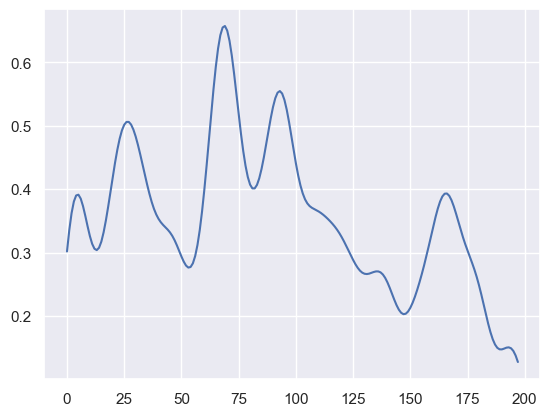

[762]
[1000]
2000
cuda
epoch 1,loss = 1.21824718
epoch 2,loss = 1.21533036
epoch 3,loss = 1.21244609
epoch 4,loss = 1.20959449
epoch 5,loss = 1.20677590
epoch 6,loss = 1.20399070
epoch 7,loss = 1.20123875
epoch 8,loss = 1.19852078
epoch 9,loss = 1.19583642
epoch 10,loss = 1.19318604
epoch 11,loss = 1.19056988
epoch 12,loss = 1.18798769
epoch 13,loss = 1.18543959
epoch 14,loss = 1.18292546
epoch 15,loss = 1.18044555
epoch 16,loss = 1.17799973
epoch 17,loss = 1.17558789
epoch 18,loss = 1.17320979
epoch 19,loss = 1.17086530
epoch 20,loss = 1.16855443
epoch 21,loss = 1.16627669
epoch 22,loss = 1.16403222
epoch 23,loss = 1.16182029
epoch 24,loss = 1.15964115
epoch 25,loss = 1.15749431
epoch 26,loss = 1.15537930
epoch 27,loss = 1.15329611
epoch 28,loss = 1.15124416
epoch 29,loss = 1.14922321
epoch 30,loss = 1.14723277
epoch 31,loss = 1.14527261
epoch 32,loss = 1.14334238
epoch 33,loss = 1.14144146
epoch 34,loss = 1.13956976
epoch 35,loss = 1.13772678
epoch 36,loss = 1.13591182
epoch 37,loss 

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 66,loss = 1.09256709
epoch 67,loss = 1.09142911
epoch 68,loss = 1.09030724
epoch 69,loss = 1.08920026
epoch 70,loss = 1.08810711
epoch 71,loss = 1.08702517
epoch 72,loss = 1.08595681
epoch 73,loss = 1.08490205
epoch 74,loss = 1.08386064
epoch 75,loss = 1.08283317
epoch 76,loss = 1.08182287
epoch 77,loss = 1.08083260
epoch 78,loss = 1.07985568
epoch 79,loss = 1.07889175
epoch 80,loss = 1.07794046
epoch 81,loss = 1.07700193
epoch 82,loss = 1.07607543
epoch 83,loss = 1.07516098
epoch 84,loss = 1.07425845
epoch 85,loss = 1.07336795
epoch 86,loss = 1.07248890
epoch 87,loss = 1.07162118
epoch 88,loss = 1.07076478
epoch 89,loss = 1.06991947
epoch 90,loss = 1.06908488
epoch 91,loss = 1.06826103
epoch 92,loss = 1.06744754
epoch 93,loss = 1.06664467
epoch 94,loss = 1.06585205
epoch 95,loss = 1.06507111
epoch 96,loss = 1.06430125
epoch 97,loss = 1.06354249
epoch 98,loss = 1.06279373
epoch 99,loss = 1.06205404
epoch 100,loss = 1.06132305
epoch 101,loss = 1.06060076
epoch 102,loss = 1.0598875

epoch 411,loss = 0.79727191
epoch 412,loss = 0.79679704
epoch 413,loss = 0.79634619
epoch 414,loss = 0.79591119
epoch 415,loss = 0.79548955
epoch 416,loss = 0.79507536
epoch 417,loss = 0.79467839
epoch 418,loss = 0.79429460
epoch 419,loss = 0.79392105
epoch 420,loss = 0.79354960
epoch 421,loss = 0.79317331
epoch 422,loss = 0.79281223
epoch 423,loss = 0.79246384
epoch 424,loss = 0.79210323
epoch 425,loss = 0.79175067
epoch 426,loss = 0.79140365
epoch 427,loss = 0.79106337
epoch 428,loss = 0.79072380
epoch 429,loss = 0.79038757
epoch 430,loss = 0.79004711
epoch 431,loss = 0.78971279
epoch 432,loss = 0.78938586
epoch 433,loss = 0.78906697
epoch 434,loss = 0.78873438
epoch 435,loss = 0.78839439
epoch 436,loss = 0.78805798
epoch 437,loss = 0.78772920
epoch 438,loss = 0.78738701
epoch 439,loss = 0.78705060
epoch 440,loss = 0.78672969
epoch 441,loss = 0.78642428
epoch 442,loss = 0.78611904
epoch 443,loss = 0.78581256
epoch 444,loss = 0.78550190
epoch 445,loss = 0.78520024
epoch 446,loss = 0.7

epoch 740,loss = 0.74332070
epoch 741,loss = 0.74323583
epoch 742,loss = 0.74314684
epoch 743,loss = 0.74305773
epoch 744,loss = 0.74296677
epoch 745,loss = 0.74287450
epoch 746,loss = 0.74278289
epoch 747,loss = 0.74269283
epoch 748,loss = 0.74260253
epoch 749,loss = 0.74251115
epoch 750,loss = 0.74242109
epoch 751,loss = 0.74233288
epoch 752,loss = 0.74224740
epoch 753,loss = 0.74216396
epoch 754,loss = 0.74208170
epoch 755,loss = 0.74199939
epoch 756,loss = 0.74191964
epoch 757,loss = 0.74184108
epoch 758,loss = 0.74176288
epoch 759,loss = 0.74168593
epoch 760,loss = 0.74161071
epoch 761,loss = 0.74153644
epoch 762,loss = 0.74146408
epoch 763,loss = 0.74137986
epoch 764,loss = 0.74129295
epoch 765,loss = 0.74120450
epoch 766,loss = 0.74111563
epoch 767,loss = 0.74102736
epoch 768,loss = 0.74094045
epoch 769,loss = 0.74085510
epoch 770,loss = 0.74076235
epoch 771,loss = 0.74066412
epoch 772,loss = 0.74056119
epoch 773,loss = 0.74045879
epoch 774,loss = 0.74036074
epoch 775,loss = 0.7

epoch 1036,loss = 0.72460866
epoch 1037,loss = 0.72456145
epoch 1038,loss = 0.72451407
epoch 1039,loss = 0.72446668
epoch 1040,loss = 0.72441959
epoch 1041,loss = 0.72437292
epoch 1042,loss = 0.72432566
epoch 1043,loss = 0.72427827
epoch 1044,loss = 0.72423106
epoch 1045,loss = 0.72418445
epoch 1046,loss = 0.72413784
epoch 1047,loss = 0.72409135
epoch 1048,loss = 0.72404402
epoch 1049,loss = 0.72399592
epoch 1050,loss = 0.72394788
epoch 1051,loss = 0.72389996
epoch 1052,loss = 0.72385186
epoch 1053,loss = 0.72380221
epoch 1054,loss = 0.72375214
epoch 1055,loss = 0.72370201
epoch 1056,loss = 0.72365195
epoch 1057,loss = 0.72360200
epoch 1058,loss = 0.72355235
epoch 1059,loss = 0.72350317
epoch 1060,loss = 0.72345513
epoch 1061,loss = 0.72340775
epoch 1062,loss = 0.72335970
epoch 1063,loss = 0.72331077
epoch 1064,loss = 0.72326130
epoch 1065,loss = 0.72321123
epoch 1066,loss = 0.72316074
epoch 1067,loss = 0.72310561
epoch 1068,loss = 0.72304797
epoch 1069,loss = 0.72298986
epoch 1070,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([248, 1, 20])
1.0
Epoch 200:   loss= 0.22471  cluster difference= 1.0
Epoch 400:   loss= 0.2223  cluster difference= 0.020161290322580645
Epoch 600:   loss= 0.21997  cluster difference= 0.012096774193548387
Epoch 800:   loss= 0.21803  cluster difference= 0.012096774193548387
Epoch 1000:   loss= 0.21645  cluster difference= 0.020161290322580645
Epoch 1200:   loss= 0.21509  cluster difference= 0.012096774193548387
Epoch 1400:   loss= 0.21393  cluster difference= 0.004032258064516129
[6 3 6 3 5 7 4 1 7 5 5 0 3 7 4 7 4 7 6 3 7 2 7 5 7 6 3 7 2 7 4 1 6 3 6 3 1
 4 7 6 3 7 5 7 6 3 7 4 7 6 3 7 5 7 7 2 7 6 3 1 4 7 7 2 4 5 3 7 2 1 6 3 7 5
 3 7 4 1 6 3 1 5 7 7 4 1 7 2 1 6 3 7 4 7 6 3 7 4 7 7 2 7 5 3 7 2 1 6 3 7 5
 3 7 4 1 7 2 5 6 3 7 4 1 6 0 3 7 4 7 4 7 2 1 4 7 5 7 6 3 7 2 7 4 1 5 7 7 2
 1 5 3 7 4 1 6 3 1 6 3 4 4 6 3 4 1 2 2 1 7 4 1 2 4 1 7 2 1 7 4 1 7 7 1 7 7
 6 0 0 7 5 0 3 1 7 2 5 3 4 7 0 4 1 4 7 1 7 4 7 7 7 1 2 2 1 7 7 1 6 3 5 3 2
 1 7 2 1 3 7 6 2 4 1 0 0 7 5 0 3 1 6 3 5 0 3 5 3 2 5]

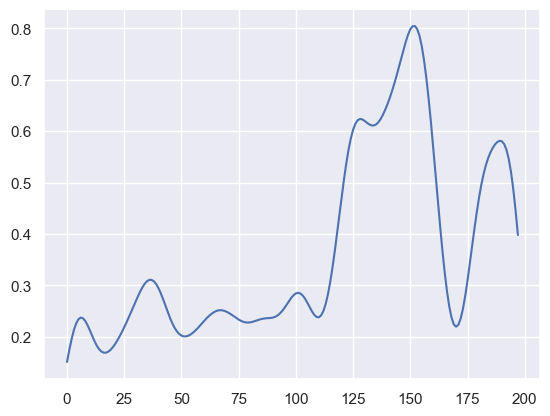

[1426]
[1000]
18000
cuda
epoch 1,loss = 0.99854630
epoch 2,loss = 0.99854118
epoch 3,loss = 0.99853611
epoch 4,loss = 0.99853128
epoch 5,loss = 0.99852645
epoch 6,loss = 0.99852169
epoch 7,loss = 0.99851698
epoch 8,loss = 0.99851227
epoch 9,loss = 0.99850768
epoch 10,loss = 0.99850315
epoch 11,loss = 0.99849880
epoch 12,loss = 0.99849445
epoch 13,loss = 0.99849015
epoch 14,loss = 0.99848592
epoch 15,loss = 0.99848169
epoch 16,loss = 0.99847770
epoch 17,loss = 0.99847353
epoch 18,loss = 0.99846971
epoch 19,loss = 0.99846578
epoch 20,loss = 0.99846202
epoch 21,loss = 0.99845839
epoch 22,loss = 0.99845475
epoch 23,loss = 0.99845135
epoch 24,loss = 0.99844795
epoch 25,loss = 0.99844462
epoch 26,loss = 0.99844140


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 27,loss = 0.99843836
epoch 28,loss = 0.99843538
epoch 29,loss = 0.99843246
epoch 30,loss = 0.99842966
epoch 31,loss = 0.99842685
epoch 32,loss = 0.99842435
epoch 33,loss = 0.99842167
epoch 34,loss = 0.99841923
epoch 35,loss = 0.99841684
epoch 36,loss = 0.99841452
epoch 37,loss = 0.99841231
epoch 38,loss = 0.99841017
epoch 39,loss = 0.99840808
epoch 40,loss = 0.99840605
epoch 41,loss = 0.99840415
epoch 42,loss = 0.99840224
epoch 43,loss = 0.99840039
epoch 44,loss = 0.99839866
epoch 45,loss = 0.99839699
epoch 46,loss = 0.99839538
epoch 47,loss = 0.99839377
epoch 48,loss = 0.99839222
epoch 49,loss = 0.99839073
epoch 50,loss = 0.99838936
epoch 51,loss = 0.99838793
epoch 52,loss = 0.99838668
epoch 53,loss = 0.99838543
epoch 54,loss = 0.99838424
epoch 55,loss = 0.99838299
epoch 56,loss = 0.99838197
epoch 57,loss = 0.99838084
epoch 58,loss = 0.99837971
epoch 59,loss = 0.99837863
epoch 60,loss = 0.99837768
epoch 61,loss = 0.99837673
epoch 62,loss = 0.99837577
epoch 63,loss = 0.99837488
e

epoch 347,loss = 0.80701089
epoch 348,loss = 0.80693853
epoch 349,loss = 0.80686653
epoch 350,loss = 0.80679464
epoch 351,loss = 0.80672282
epoch 352,loss = 0.80665100
epoch 353,loss = 0.80657899
epoch 354,loss = 0.80650699
epoch 355,loss = 0.80643523
epoch 356,loss = 0.80636340
epoch 357,loss = 0.80629158
epoch 358,loss = 0.80621964
epoch 359,loss = 0.80614805
epoch 360,loss = 0.80607647
epoch 361,loss = 0.80600494
epoch 362,loss = 0.80593336
epoch 363,loss = 0.80586171
epoch 364,loss = 0.80579031
epoch 365,loss = 0.80571932
epoch 366,loss = 0.80564862
epoch 367,loss = 0.80557793
epoch 368,loss = 0.80550760
epoch 369,loss = 0.80543721
epoch 370,loss = 0.80536717
epoch 371,loss = 0.80529696
epoch 372,loss = 0.80522656
epoch 373,loss = 0.80515623
epoch 374,loss = 0.80508614
epoch 375,loss = 0.80501622
epoch 376,loss = 0.80494660
epoch 377,loss = 0.80487692
epoch 378,loss = 0.80480748
epoch 379,loss = 0.80473816
epoch 380,loss = 0.80466920
epoch 381,loss = 0.80460042
epoch 382,loss = 0.8

epoch 647,loss = 0.79122186
epoch 648,loss = 0.79118514
epoch 649,loss = 0.79114866
epoch 650,loss = 0.79111224
epoch 651,loss = 0.79107612
epoch 652,loss = 0.79103988
epoch 653,loss = 0.79100388
epoch 654,loss = 0.79096782
epoch 655,loss = 0.79093176
epoch 656,loss = 0.79089576
epoch 657,loss = 0.79085970
epoch 658,loss = 0.79082382
epoch 659,loss = 0.79078805
epoch 660,loss = 0.79075229
epoch 661,loss = 0.79071665
epoch 662,loss = 0.79068106
epoch 663,loss = 0.79064554
epoch 664,loss = 0.79061013
epoch 665,loss = 0.79057467
epoch 666,loss = 0.79053950
epoch 667,loss = 0.79050434
epoch 668,loss = 0.79046923
epoch 669,loss = 0.79043424
epoch 670,loss = 0.79039943
epoch 671,loss = 0.79036468
epoch 672,loss = 0.79032987
epoch 673,loss = 0.79029524
epoch 674,loss = 0.79026067
epoch 675,loss = 0.79022628
epoch 676,loss = 0.79019177
epoch 677,loss = 0.79015756
epoch 678,loss = 0.79012334
epoch 679,loss = 0.79008907
epoch 680,loss = 0.79005510
epoch 681,loss = 0.79002100
epoch 682,loss = 0.7

epoch 942,loss = 0.78205144
epoch 943,loss = 0.78202444
epoch 944,loss = 0.78199744
epoch 945,loss = 0.78197050
epoch 946,loss = 0.78194368
epoch 947,loss = 0.78191674
epoch 948,loss = 0.78188998
epoch 949,loss = 0.78186321
epoch 950,loss = 0.78183639
epoch 951,loss = 0.78180969
epoch 952,loss = 0.78178281
epoch 953,loss = 0.78175598
epoch 954,loss = 0.78172922
epoch 955,loss = 0.78170252
epoch 956,loss = 0.78167582
epoch 957,loss = 0.78164905
epoch 958,loss = 0.78162241
epoch 959,loss = 0.78159559
epoch 960,loss = 0.78156865
epoch 961,loss = 0.78154165
epoch 962,loss = 0.78151482
epoch 963,loss = 0.78148800
epoch 964,loss = 0.78146118
epoch 965,loss = 0.78143454
epoch 966,loss = 0.78140789
epoch 967,loss = 0.78138119
epoch 968,loss = 0.78135467
epoch 969,loss = 0.78132802
epoch 970,loss = 0.78130162
epoch 971,loss = 0.78127515
epoch 972,loss = 0.78124875
epoch 973,loss = 0.78122246
epoch 974,loss = 0.78119630
epoch 975,loss = 0.78117019
epoch 976,loss = 0.78114402
epoch 977,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([641, 1, 70])
1.0
Epoch 200:   loss= 0.19393  cluster difference= 1.0
Epoch 400:   loss= 0.19208  cluster difference= 0.0405616224648986
Epoch 600:   loss= 0.19134  cluster difference= 0.0343213728549142
Epoch 800:   loss= 0.19105  cluster difference= 0.0436817472698908
Epoch 1000:   loss= 0.19102  cluster difference= 0.015600624024960999
Epoch 1200:   loss= 0.19106  cluster difference= 0.0187207488299532
Epoch 1400:   loss= 0.19111  cluster difference= 0.0109204368174727
Epoch 1600:   loss= 0.19113  cluster difference= 0.0124804992199688
Epoch 1800:   loss= 0.19113  cluster difference= 0.0062402496099844
[5 2 0 0 4 5 2 6 6 4 0 0 5 5 2 6 6 4 4 7 1 5 7 4 7 1 5 7 6 6 4 5 7 6 6 4 4
 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 7 1 6 7 0 0 1 5 7 6 6 4 0 0 5 5
 2 0 0 2 0 0 5 5 2 5 5 2 0 0 5 0 2 5 5 2 6 0 4 0 2 1 5 7 6 6 3 0 0 4 5 2 1
 5 2 4 0 4 5 2 6 6 7 0 0 5 5 7 6 6 3 4 7 1 6 7 1 6 3 1 7 6 6 3 4 0 1 5 2 0
 0 5 5 7 6 0 4 5 2 6 6 4 4 7 6 6 4 4 7 1 5 7 6 0 4 7 7 3 6 3 4 7 1 5 7 6 6
 

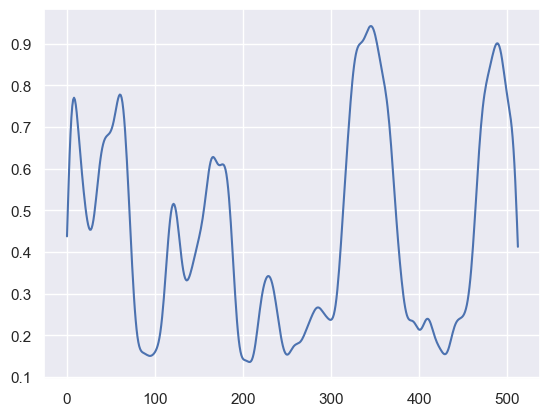

[3507, 6475, 11487, 15519]
[ 6000 12000]
18432
cuda
epoch 1,loss = 1.08198178
epoch 2,loss = 1.08101869
epoch 3,loss = 1.08006167
epoch 4,loss = 1.07911074
epoch 5,loss = 1.07816601
epoch 6,loss = 1.07722783


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 7,loss = 1.07629597
epoch 8,loss = 1.07537055
epoch 9,loss = 1.07445168
epoch 10,loss = 1.07353961
epoch 11,loss = 1.07263422
epoch 12,loss = 1.07173550
epoch 13,loss = 1.07084370
epoch 14,loss = 1.06995881
epoch 15,loss = 1.06908071
epoch 16,loss = 1.06820989
epoch 17,loss = 1.06734598
epoch 18,loss = 1.06648910
epoch 19,loss = 1.06563938
epoch 20,loss = 1.06479692
epoch 21,loss = 1.06396151
epoch 22,loss = 1.06313348
epoch 23,loss = 1.06231248
epoch 24,loss = 1.06149888
epoch 25,loss = 1.06069243
epoch 26,loss = 1.05989325
epoch 27,loss = 1.05910134
epoch 28,loss = 1.05831671
epoch 29,loss = 1.05753934
epoch 30,loss = 1.05676925
epoch 31,loss = 1.05600631
epoch 32,loss = 1.05525064
epoch 33,loss = 1.05450225
epoch 34,loss = 1.05376101
epoch 35,loss = 1.05302703
epoch 36,loss = 1.05230010
epoch 37,loss = 1.05158043
epoch 38,loss = 1.05086768
epoch 39,loss = 1.05016220
epoch 40,loss = 1.04946363
epoch 41,loss = 1.04877210
epoch 42,loss = 1.04808760
epoch 43,loss = 1.04740989
epoc

epoch 313,loss = 0.84542060
epoch 314,loss = 0.84519017
epoch 315,loss = 0.84495640
epoch 316,loss = 0.84472412
epoch 317,loss = 0.84449357
epoch 318,loss = 0.84426439
epoch 319,loss = 0.84403372
epoch 320,loss = 0.84380054
epoch 321,loss = 0.84356767
epoch 322,loss = 0.84333622
epoch 323,loss = 0.84310907
epoch 324,loss = 0.84288424
epoch 325,loss = 0.84266204
epoch 326,loss = 0.84244168
epoch 327,loss = 0.84222388
epoch 328,loss = 0.84200609
epoch 329,loss = 0.84178400
epoch 330,loss = 0.84156984
epoch 331,loss = 0.84135789
epoch 332,loss = 0.84114724
epoch 333,loss = 0.84093636
epoch 334,loss = 0.84072274
epoch 335,loss = 0.84050810
epoch 336,loss = 0.84029835
epoch 337,loss = 0.84009033
epoch 338,loss = 0.83988428
epoch 339,loss = 0.83967966
epoch 340,loss = 0.83947545
epoch 341,loss = 0.83927149
epoch 342,loss = 0.83906513
epoch 343,loss = 0.83885717
epoch 344,loss = 0.83864880
epoch 345,loss = 0.83844095
epoch 346,loss = 0.83823508
epoch 347,loss = 0.83803147
epoch 348,loss = 0.8

epoch 615,loss = 0.80253041
epoch 616,loss = 0.80242145
epoch 617,loss = 0.80231041
epoch 618,loss = 0.80219764
epoch 619,loss = 0.80208313
epoch 620,loss = 0.80196702
epoch 621,loss = 0.80185145
epoch 622,loss = 0.80173320
epoch 623,loss = 0.80161613
epoch 624,loss = 0.80149853
epoch 625,loss = 0.80138159
epoch 626,loss = 0.80126518
epoch 627,loss = 0.80114758
epoch 628,loss = 0.80103338
epoch 629,loss = 0.80091935
epoch 630,loss = 0.80080569
epoch 631,loss = 0.80069405
epoch 632,loss = 0.80058253
epoch 633,loss = 0.80047154
epoch 634,loss = 0.80035663
epoch 635,loss = 0.80023986
epoch 636,loss = 0.80012482
epoch 637,loss = 0.80000681
epoch 638,loss = 0.79988629
epoch 639,loss = 0.79977041
epoch 640,loss = 0.79965687
epoch 641,loss = 0.79954600
epoch 642,loss = 0.79943442
epoch 643,loss = 0.79931080
epoch 644,loss = 0.79918212
epoch 645,loss = 0.79905128
epoch 646,loss = 0.79892343
epoch 647,loss = 0.79880893
epoch 648,loss = 0.79869610
epoch 649,loss = 0.79858595
epoch 650,loss = 0.7

epoch 909,loss = 0.77792984
epoch 910,loss = 0.77783704
epoch 911,loss = 0.77774709
epoch 912,loss = 0.77766210
epoch 913,loss = 0.77758116
epoch 914,loss = 0.77750337
epoch 915,loss = 0.77742726
epoch 916,loss = 0.77735341
epoch 917,loss = 0.77727908
epoch 918,loss = 0.77720076
epoch 919,loss = 0.77712691
epoch 920,loss = 0.77706307
epoch 921,loss = 0.77699858
epoch 922,loss = 0.77693343
epoch 923,loss = 0.77686590
epoch 924,loss = 0.77680415
epoch 925,loss = 0.77675110
epoch 926,loss = 0.77669454
epoch 927,loss = 0.77663672
epoch 928,loss = 0.77657741
epoch 929,loss = 0.77651179
epoch 930,loss = 0.77644676
epoch 931,loss = 0.77638227
epoch 932,loss = 0.77631795
epoch 933,loss = 0.77624911
epoch 934,loss = 0.77617627
epoch 935,loss = 0.77611780
epoch 936,loss = 0.77606177
epoch 937,loss = 0.77600455
epoch 938,loss = 0.77594763
epoch 939,loss = 0.77589136
epoch 940,loss = 0.77583539
epoch 941,loss = 0.77579176
epoch 942,loss = 0.77574903
epoch 943,loss = 0.77569759
epoch 944,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=9.
  warnings.warn(


torch.Size([2302, 1, 20])
1.0
Epoch 200:   loss= 0.11572  cluster difference= 1.0
Epoch 400:   loss= 0.11735  cluster difference= 0.008688097306689836
[5 5 5 ... 5 5 5]


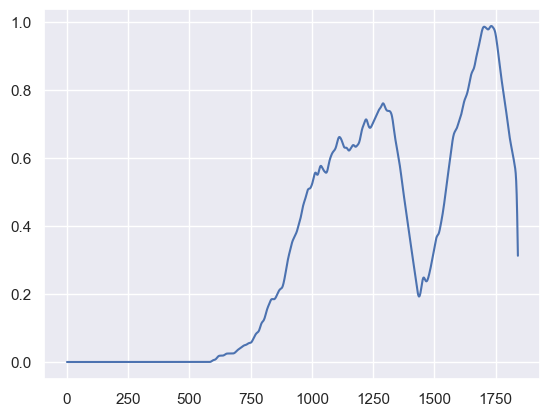

[12170, 15706]
[8200]
10433
cuda
epoch 1,loss = 1.00586450
epoch 2,loss = 1.00584757
epoch 3,loss = 1.00583088
epoch 4,loss = 1.00581408
epoch 5,loss = 1.00579751
epoch 6,loss = 1.00578082
epoch 7,loss = 1.00576425
epoch 8,loss = 1.00574756
epoch 9,loss = 1.00573111
epoch 10,loss = 1.00571477
epoch 11,loss = 1.00569820
epoch 12,loss = 1.00568187
epoch 13,loss = 1.00566554
epoch 14,loss = 1.00564921
epoch 15,loss = 1.00563264
epoch 16,loss = 1.00561607
epoch 17,loss = 1.00559950


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 18,loss = 1.00558269
epoch 19,loss = 1.00556576
epoch 20,loss = 1.00554872
epoch 21,loss = 1.00553131
epoch 22,loss = 1.00551379
epoch 23,loss = 1.00549603
epoch 24,loss = 1.00547791
epoch 25,loss = 1.00545955
epoch 26,loss = 1.00544083
epoch 27,loss = 1.00542176
epoch 28,loss = 1.00540233
epoch 29,loss = 1.00538242
epoch 30,loss = 1.00536227
epoch 31,loss = 1.00534165
epoch 32,loss = 1.00532055
epoch 33,loss = 1.00529814
epoch 34,loss = 1.00527310
epoch 35,loss = 1.00524569
epoch 36,loss = 1.00521541
epoch 37,loss = 1.00518143
epoch 38,loss = 1.00514305
epoch 39,loss = 1.00509644
epoch 40,loss = 1.00503552
epoch 41,loss = 1.00495505
epoch 42,loss = 1.00485730
epoch 43,loss = 1.00473499
epoch 44,loss = 1.00459886
epoch 45,loss = 1.00443816
epoch 46,loss = 1.00426459
epoch 47,loss = 1.00407505
epoch 48,loss = 1.00386548
epoch 49,loss = 1.00364053
epoch 50,loss = 1.00339007
epoch 51,loss = 1.00307572
epoch 52,loss = 1.00268126
epoch 53,loss = 1.00224042
epoch 54,loss = 1.00175130
e

epoch 317,loss = 0.85022932
epoch 318,loss = 0.85008788
epoch 319,loss = 0.84994769
epoch 320,loss = 0.84980905
epoch 321,loss = 0.84967178
epoch 322,loss = 0.84953487
epoch 323,loss = 0.84939891
epoch 324,loss = 0.84926629
epoch 325,loss = 0.84913594
epoch 326,loss = 0.84900659
epoch 327,loss = 0.84887791
epoch 328,loss = 0.84874994
epoch 329,loss = 0.84862268
epoch 330,loss = 0.84849644
epoch 331,loss = 0.84837133
epoch 332,loss = 0.84824890
epoch 333,loss = 0.84812713
epoch 334,loss = 0.84800619
epoch 335,loss = 0.84788597
epoch 336,loss = 0.84776652
epoch 337,loss = 0.84764856
epoch 338,loss = 0.84753096
epoch 339,loss = 0.84741360
epoch 340,loss = 0.84729695
epoch 341,loss = 0.84718072
epoch 342,loss = 0.84706414
epoch 343,loss = 0.84694797
epoch 344,loss = 0.84683168
epoch 345,loss = 0.84671658
epoch 346,loss = 0.84660250
epoch 347,loss = 0.84648788
epoch 348,loss = 0.84637147
epoch 349,loss = 0.84625322
epoch 350,loss = 0.84613603
epoch 351,loss = 0.84601873
epoch 352,loss = 0.8

epoch 642,loss = 0.80602580
epoch 643,loss = 0.80595940
epoch 644,loss = 0.80589348
epoch 645,loss = 0.80582762
epoch 646,loss = 0.80576217
epoch 647,loss = 0.80569720
epoch 648,loss = 0.80563325
epoch 649,loss = 0.80557001
epoch 650,loss = 0.80550641
epoch 651,loss = 0.80544293
epoch 652,loss = 0.80538023
epoch 653,loss = 0.80531800
epoch 654,loss = 0.80525589
epoch 655,loss = 0.80519438
epoch 656,loss = 0.80513299
epoch 657,loss = 0.80507201
epoch 658,loss = 0.80501115
epoch 659,loss = 0.80495077
epoch 660,loss = 0.80489087
epoch 661,loss = 0.80483103
epoch 662,loss = 0.80477184
epoch 663,loss = 0.80471307
epoch 664,loss = 0.80465454
epoch 665,loss = 0.80459660
epoch 666,loss = 0.80453867
epoch 667,loss = 0.80448139
epoch 668,loss = 0.80442524
epoch 669,loss = 0.80436885
epoch 670,loss = 0.80431187
epoch 671,loss = 0.80425513
epoch 672,loss = 0.80419874
epoch 673,loss = 0.80414295
epoch 674,loss = 0.80408758
epoch 675,loss = 0.80403268
epoch 676,loss = 0.80397797
epoch 677,loss = 0.8

epoch 969,loss = 0.79483825
epoch 970,loss = 0.79481977
epoch 971,loss = 0.79480153
epoch 972,loss = 0.79478353
epoch 973,loss = 0.79476553
epoch 974,loss = 0.79474747
epoch 975,loss = 0.79472929
epoch 976,loss = 0.79471129
epoch 977,loss = 0.79469341
epoch 978,loss = 0.79467577
epoch 979,loss = 0.79465812
epoch 980,loss = 0.79464042
epoch 981,loss = 0.79462242
epoch 982,loss = 0.79460490
epoch 983,loss = 0.79458755
epoch 984,loss = 0.79457039
epoch 985,loss = 0.79455328
epoch 986,loss = 0.79453617
epoch 987,loss = 0.79451907
epoch 988,loss = 0.79450214
epoch 989,loss = 0.79448533
epoch 990,loss = 0.79446870
epoch 991,loss = 0.79445171
epoch 992,loss = 0.79443461
epoch 993,loss = 0.79441750
epoch 994,loss = 0.79440045
epoch 995,loss = 0.79438311
epoch 996,loss = 0.79436553
epoch 997,loss = 0.79434794
epoch 998,loss = 0.79433030
epoch 999,loss = 0.79431260
epoch 1000,loss = 0.79429513
epoch 1001,loss = 0.79427749
epoch 1002,loss = 0.79425985
epoch 1003,loss = 0.79424214
epoch 1004,loss 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


torch.Size([1302, 1, 20])
1.0
Epoch 200:   loss= 0.11492  cluster difference= 1.0
Epoch 400:   loss= 0.1205  cluster difference= 0.3195084485407066
Epoch 600:   loss= 0.12069  cluster difference= 0.11213517665130568
Epoch 800:   loss= 0.12061  cluster difference= 0.04915514592933948
Epoch 1000:   loss= 0.12084  cluster difference= 0.06989247311827956
Epoch 1200:   loss= 0.1211  cluster difference= 0.042242703533026116
Epoch 1400:   loss= 0.12121  cluster difference= 0.03302611367127496
Epoch 1600:   loss= 0.12125  cluster difference= 0.010752688172043012
Epoch 1800:   loss= 0.12125  cluster difference= 0.008448540706605223
[1 2 2 ... 2 2 2]


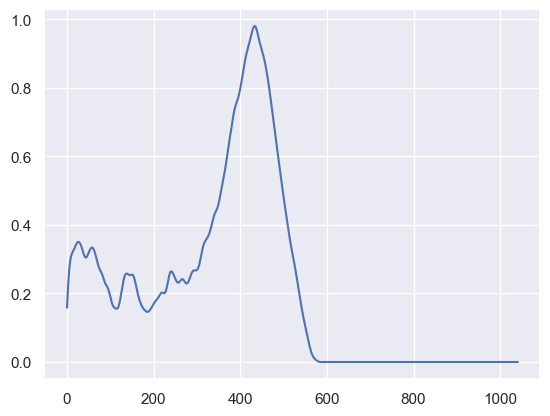

[4514]
[4550]
4700
cuda
epoch 1,loss = 0.98638803
epoch 2,loss = 0.98638511
epoch 3,loss = 0.98638213
epoch 4,loss = 0.98637927
epoch 5,loss = 0.98637646
epoch 6,loss = 0.98637372
epoch 7,loss = 0.98637104
epoch 8,loss = 0.98636836
epoch 9,loss = 0.98636585
epoch 10,loss = 0.98636323
epoch 11,loss = 0.98636079
epoch 12,loss = 0.98635846
epoch 13,loss = 0.98635614
epoch 14,loss = 0.98635387
epoch 15,loss = 0.98635161
epoch 16,loss = 0.98634958
epoch 17,loss = 0.98634738
epoch 18,loss = 0.98634547
epoch 19,loss = 0.98634344
epoch 20,loss = 0.98634160
epoch 21,loss = 0.98633975
epoch 22,loss = 0.98633802
epoch 23,loss = 0.98633635
epoch 24,loss = 0.98633468
epoch 25,loss = 0.98633313
epoch 26,loss = 0.98633164
epoch 27,loss = 0.98633015
epoch 28,loss = 0.98632872
epoch 29,loss = 0.98632747
epoch 30,loss = 0.98632610
epoch 31,loss = 0.98632485
epoch 32,loss = 0.98632365
epoch 33,loss = 0.98632252
epoch 34,loss = 0.98632139
epoch 35,loss = 0.98632044
epoch 36,loss = 0.98631942
epoch 37,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 54,loss = 0.98630702
epoch 55,loss = 0.98630649
epoch 56,loss = 0.98630601
epoch 57,loss = 0.98630548
epoch 58,loss = 0.98630506
epoch 59,loss = 0.98630464
epoch 60,loss = 0.98630416
epoch 61,loss = 0.98630363
epoch 62,loss = 0.98630321
epoch 63,loss = 0.98630273
epoch 64,loss = 0.98630232
epoch 65,loss = 0.98630172
epoch 66,loss = 0.98630112
epoch 67,loss = 0.98630065
epoch 68,loss = 0.98629993
epoch 69,loss = 0.98629940
epoch 70,loss = 0.98629862
epoch 71,loss = 0.98629761
epoch 72,loss = 0.98629653
epoch 73,loss = 0.98629510
epoch 74,loss = 0.98629349
epoch 75,loss = 0.98629159
epoch 76,loss = 0.98628920
epoch 77,loss = 0.98628652
epoch 78,loss = 0.98628354
epoch 79,loss = 0.98628014
epoch 80,loss = 0.98627651
epoch 81,loss = 0.98627228
epoch 82,loss = 0.98626775
epoch 83,loss = 0.98626292
epoch 84,loss = 0.98625743
epoch 85,loss = 0.98625159
epoch 86,loss = 0.98624527
epoch 87,loss = 0.98623854
epoch 88,loss = 0.98623091
epoch 89,loss = 0.98621929
epoch 90,loss = 0.98620188
e

epoch 374,loss = 0.84733152
epoch 375,loss = 0.84723026
epoch 376,loss = 0.84713060
epoch 377,loss = 0.84703207
epoch 378,loss = 0.84693450
epoch 379,loss = 0.84683794
epoch 380,loss = 0.84674275
epoch 381,loss = 0.84664786
epoch 382,loss = 0.84655410
epoch 383,loss = 0.84646207
epoch 384,loss = 0.84637237
epoch 385,loss = 0.84628385
epoch 386,loss = 0.84619570
epoch 387,loss = 0.84610850
epoch 388,loss = 0.84602267
epoch 389,loss = 0.84593785
epoch 390,loss = 0.84585398
epoch 391,loss = 0.84577101
epoch 392,loss = 0.84568852
epoch 393,loss = 0.84560740
epoch 394,loss = 0.84552658
epoch 395,loss = 0.84544706
epoch 396,loss = 0.84536850
epoch 397,loss = 0.84529060
epoch 398,loss = 0.84521341
epoch 399,loss = 0.84513640
epoch 400,loss = 0.84505999
epoch 401,loss = 0.84498429
epoch 402,loss = 0.84490913
epoch 403,loss = 0.84483469
epoch 404,loss = 0.84476042
epoch 405,loss = 0.84468567
epoch 406,loss = 0.84461111
epoch 407,loss = 0.84453744
epoch 408,loss = 0.84446567
epoch 409,loss = 0.8

epoch 707,loss = 0.83367521
epoch 708,loss = 0.83366752
epoch 709,loss = 0.83365983
epoch 710,loss = 0.83365208
epoch 711,loss = 0.83364469
epoch 712,loss = 0.83363736
epoch 713,loss = 0.83363003
epoch 714,loss = 0.83362275
epoch 715,loss = 0.83361554
epoch 716,loss = 0.83360833
epoch 717,loss = 0.83360112
epoch 718,loss = 0.83359361
epoch 719,loss = 0.83358586
epoch 720,loss = 0.83357817
epoch 721,loss = 0.83357060
epoch 722,loss = 0.83356291
epoch 723,loss = 0.83355504
epoch 724,loss = 0.83354706
epoch 725,loss = 0.83353907
epoch 726,loss = 0.83353120
epoch 727,loss = 0.83352327
epoch 728,loss = 0.83351547
epoch 729,loss = 0.83350760
epoch 730,loss = 0.83349967
epoch 731,loss = 0.83349180
epoch 732,loss = 0.83348399
epoch 733,loss = 0.83347625
epoch 734,loss = 0.83346832
epoch 735,loss = 0.83346063
epoch 736,loss = 0.83345294
epoch 737,loss = 0.83344543
epoch 738,loss = 0.83343798
epoch 739,loss = 0.83343065
epoch 740,loss = 0.83342326
epoch 741,loss = 0.83341581
epoch 742,loss = 0.8

epoch 1024,loss = 0.83194214
epoch 1025,loss = 0.83194023
epoch 1026,loss = 0.83193839
epoch 1027,loss = 0.83193642
epoch 1028,loss = 0.83193469
epoch 1029,loss = 0.83193272
epoch 1030,loss = 0.83193082
epoch 1031,loss = 0.83192897
epoch 1032,loss = 0.83192712
epoch 1033,loss = 0.83192527
epoch 1034,loss = 0.83192360
epoch 1035,loss = 0.83192176
epoch 1036,loss = 0.83192003
epoch 1037,loss = 0.83191824
epoch 1038,loss = 0.83191657
epoch 1039,loss = 0.83191484
epoch 1040,loss = 0.83191305
epoch 1041,loss = 0.83191127
epoch 1042,loss = 0.83190954
epoch 1043,loss = 0.83190793
epoch 1044,loss = 0.83190626
epoch 1045,loss = 0.83190453
epoch 1046,loss = 0.83190268
epoch 1047,loss = 0.83190084
epoch 1048,loss = 0.83189899
epoch 1049,loss = 0.83189696
epoch 1050,loss = 0.83189476
epoch 1051,loss = 0.83189279
epoch 1052,loss = 0.83189064
epoch 1053,loss = 0.83188874
epoch 1054,loss = 0.83188671
epoch 1055,loss = 0.83188480
epoch 1056,loss = 0.83188289
epoch 1057,loss = 0.83188093
epoch 1058,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([233, 1, 50])
1.0
Epoch 200:   loss= 0.23447  cluster difference= 1.0
Epoch 400:   loss= 0.2356  cluster difference= 0.09871244635193133
Epoch 600:   loss= 0.23553  cluster difference= 0.012875536480686695
Epoch 800:   loss= 0.23476  cluster difference= 0.030042918454935622
Epoch 1000:   loss= 0.23361  cluster difference= 0.02145922746781116
Epoch 1200:   loss= 0.23225  cluster difference= 0.04291845493562232
Epoch 1400:   loss= 0.23081  cluster difference= 0.0
[1 0 5 3 5 0 4 0 4 0 4 0 4 6 4 2 4 2 4 6 4 6 4 2 4 2 3 6 4 2 3 5 3 5 4 5 3
 5 3 1 4 5 3 5 3 5 3 5 3 5 3 1 3 5 3 1 0 5 3 4 0 1 3 1 0 4 6 4 1 4 0 4 6 4
 2 4 6 4 2 4 5 4 6 4 2 3 2 3 6 4 2 4 2 3 2 1 0 2 7 0 2 3 0 2 3 0 5 3 0 1 3
 0 1 3 0 1 3 1 5 6 5 5 4 5 5 6 2 4 6 2 1 6 6 4 6 2 4 6 4 3 6 4 3 0 4 3 0 4
 3 4 1 3 1 1 4 5 7 6 5 1 6 6 4 6 6 4 3 4 3 0 4 4 4 4 4 1 4 4 5 1 4 6 1 7 7
 7 5 7 5 5 2 6 6 6 6 6 6 6 6 6 0 6 3 3 7 7 7 7 7 7 7 7 5 5 5 2 2 6 6 6 6 6
 6 6 6 6 6 3 3 4 7 3 4]


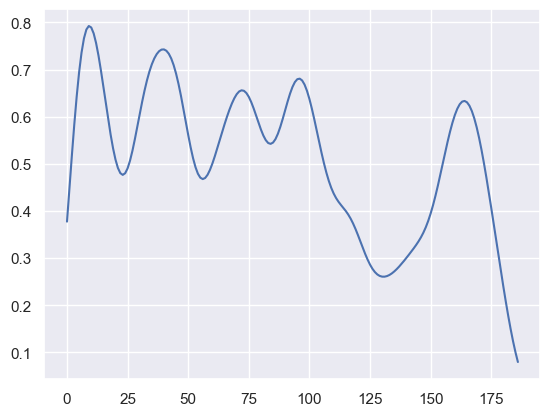

[665, 1285, 2405, 3765]
[1900 3700]
4700
cuda
epoch 1,loss = 1.01563644
epoch 2,loss = 1.01501393
epoch 3,loss = 1.01440954
epoch 4,loss = 1.01382339
epoch 5,loss = 1.01325548
epoch 6,loss = 1.01270568
epoch 7,loss = 1.01217377
epoch 8,loss = 1.01165986
epoch 9,loss = 1.01116312
epoch 10,loss = 1.01068366
epoch 11,loss = 1.01022184
epoch 12,loss = 1.00977767
epoch 13,loss = 1.00935090
epoch 14,loss = 1.00894129
epoch 15,loss = 1.00854766
epoch 16,loss = 1.00816953
epoch 17,loss = 1.00780678
epoch 18,loss = 1.00745881
epoch 19,loss = 1.00712478
epoch 20,loss = 1.00680459
epoch 21,loss = 1.00649774
epoch 22,loss = 1.00620377
epoch 23,loss = 1.00592303
epoch 24,loss = 1.00565541
epoch 25,loss = 1.00539935
epoch 26,loss = 1.00515485
epoch 27,loss = 1.00492120
epoch 28,loss = 1.00469828
epoch 29,loss = 1.00448549
epoch 30,loss = 1.00428259
epoch 31,loss = 1.00408936
epoch 32,loss = 1.00390542
epoch 33,loss = 1.00373018
epoch 34,loss = 1.00356305
epoch 35,loss = 1.00340343
epoch 36,loss = 1.

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 50,loss = 1.00169516
epoch 51,loss = 1.00161147
epoch 52,loss = 1.00152910
epoch 53,loss = 1.00144804
epoch 54,loss = 1.00136864
epoch 55,loss = 1.00128961
epoch 56,loss = 1.00121820
epoch 57,loss = 1.00115442
epoch 58,loss = 1.00110185
epoch 59,loss = 1.00105524
epoch 60,loss = 1.00101495
epoch 61,loss = 1.00096822
epoch 62,loss = 1.00090945
epoch 63,loss = 1.00083625
epoch 64,loss = 1.00075030
epoch 65,loss = 1.00065506
epoch 66,loss = 1.00055969
epoch 67,loss = 1.00047421
epoch 68,loss = 1.00038671
epoch 69,loss = 1.00030029
epoch 70,loss = 1.00021315
epoch 71,loss = 1.00012338
epoch 72,loss = 1.00003016
epoch 73,loss = 0.99993241
epoch 74,loss = 0.99983007
epoch 75,loss = 0.99972290
epoch 76,loss = 0.99961007
epoch 77,loss = 0.99949157
epoch 78,loss = 0.99936754
epoch 79,loss = 0.99923736
epoch 80,loss = 0.99910104
epoch 81,loss = 0.99895805
epoch 82,loss = 0.99880749
epoch 83,loss = 0.99864948
epoch 84,loss = 0.99848294
epoch 85,loss = 0.99830729
epoch 86,loss = 0.99812233
e

epoch 370,loss = 0.82224476
epoch 371,loss = 0.82195497
epoch 372,loss = 0.82166809
epoch 373,loss = 0.82138389
epoch 374,loss = 0.82110322
epoch 375,loss = 0.82081813
epoch 376,loss = 0.82052970
epoch 377,loss = 0.82023948
epoch 378,loss = 0.81994450
epoch 379,loss = 0.81964666
epoch 380,loss = 0.81934714
epoch 381,loss = 0.81904531
epoch 382,loss = 0.81874079
epoch 383,loss = 0.81842661
epoch 384,loss = 0.81810337
epoch 385,loss = 0.81778514
epoch 386,loss = 0.81746513
epoch 387,loss = 0.81714791
epoch 388,loss = 0.81683058
epoch 389,loss = 0.81650418
epoch 390,loss = 0.81616360
epoch 391,loss = 0.81582099
epoch 392,loss = 0.81549031
epoch 393,loss = 0.81515694
epoch 394,loss = 0.81481808
epoch 395,loss = 0.81447643
epoch 396,loss = 0.81413752
epoch 397,loss = 0.81380332
epoch 398,loss = 0.81346524
epoch 399,loss = 0.81312233
epoch 400,loss = 0.81277394
epoch 401,loss = 0.81242353
epoch 402,loss = 0.81206530
epoch 403,loss = 0.81170195
epoch 404,loss = 0.81134742
epoch 405,loss = 0.8

epoch 711,loss = 0.76052994
epoch 712,loss = 0.76048249
epoch 713,loss = 0.76043671
epoch 714,loss = 0.76039147
epoch 715,loss = 0.76034611
epoch 716,loss = 0.76030117
epoch 717,loss = 0.76025617
epoch 718,loss = 0.76021159
epoch 719,loss = 0.76016700
epoch 720,loss = 0.76012248
epoch 721,loss = 0.76007760
epoch 722,loss = 0.76003283
epoch 723,loss = 0.75998843
epoch 724,loss = 0.75994450
epoch 725,loss = 0.75990111
epoch 726,loss = 0.75985759
epoch 727,loss = 0.75981432
epoch 728,loss = 0.75977135
epoch 729,loss = 0.75972897
epoch 730,loss = 0.75968719
epoch 731,loss = 0.75964540
epoch 732,loss = 0.75960386
epoch 733,loss = 0.75956243
epoch 734,loss = 0.75952125
epoch 735,loss = 0.75948036
epoch 736,loss = 0.75943953
epoch 737,loss = 0.75939900
epoch 738,loss = 0.75935775
epoch 739,loss = 0.75931549
epoch 740,loss = 0.75927275
epoch 741,loss = 0.75922954
epoch 742,loss = 0.75918519
epoch 743,loss = 0.75914031
epoch 744,loss = 0.75909585
epoch 745,loss = 0.75905061
epoch 746,loss = 0.7

epoch 1056,loss = 0.74893677
epoch 1057,loss = 0.74891293
epoch 1058,loss = 0.74888879
epoch 1059,loss = 0.74886334
epoch 1060,loss = 0.74883753
epoch 1061,loss = 0.74881220
epoch 1062,loss = 0.74878472
epoch 1063,loss = 0.74875671
epoch 1064,loss = 0.74872619
epoch 1065,loss = 0.74869663
epoch 1066,loss = 0.74866652
epoch 1067,loss = 0.74863642
epoch 1068,loss = 0.74860531
epoch 1069,loss = 0.74857414
epoch 1070,loss = 0.74854243
epoch 1071,loss = 0.74850959
epoch 1072,loss = 0.74847800
epoch 1073,loss = 0.74844682
epoch 1074,loss = 0.74841982
epoch 1075,loss = 0.74839306
epoch 1076,loss = 0.74836791
epoch 1077,loss = 0.74834228
epoch 1078,loss = 0.74831647
epoch 1079,loss = 0.74828964
epoch 1080,loss = 0.74826264
epoch 1081,loss = 0.74823529
epoch 1082,loss = 0.74820513
epoch 1083,loss = 0.74817437
epoch 1084,loss = 0.74814528
epoch 1085,loss = 0.74812049
epoch 1086,loss = 0.74809748
epoch 1087,loss = 0.74807489
epoch 1088,loss = 0.74805188
epoch 1089,loss = 0.74802941
epoch 1090,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([233, 1, 50])
1.0
Epoch 200:   loss= 0.23254  cluster difference= 1.0
Epoch 400:   loss= 0.23272  cluster difference= 0.034334763948497854
Epoch 600:   loss= 0.23341  cluster difference= 0.12017167381974249
Epoch 800:   loss= 0.23314  cluster difference= 0.03862660944206009
Epoch 1000:   loss= 0.23051  cluster difference= 0.030042918454935622
Epoch 1200:   loss= 0.22749  cluster difference= 0.02575107296137339
Epoch 1400:   loss= 0.22474  cluster difference= 0.004291845493562232
[5 4 7 4 5 1 7 5 7 1 7 7 0 1 2 5 6 1 2 2 2 2 2 2 2 3 7 3 6 4 3 3 7 3 2 2 3
 3 2 6 4 4 4 5 1 7 4 6 4 3 3 7 1 6 4 2 2 2 1 7 5 6 4 2 3 6 4 2 1 2 2 0 0 4
 1 7 1 6 4 2 7 5 2 2 3 1 7 6 7 6 4 5 5 7 5 5 5 7 1 5 5 5 5 7 5 5 5 1 5 5 4
 1 6 4 1 6 4 3 6 4 6 2 1 3 2 4 7 6 1 6 2 4 6 2 4 7 4 2 2 2 3 0 4 1 6 4 3 7
 1 7 6 4 7 0 4 2 2 2 7 2 2 7 2 1 2 2 3 6 4 3 6 4 1 6 4 7 6 4 5 2 2 2 2 1 6
 5 0 0 6 5 6 7 5 7 1 3 3 3 3 3 3 0 1 1 5 4 0 0 0 0 6 4 6 6 4 2 2 6 3 3 3 3
 3 3 2 3 7 1 2 2 1 4 0]


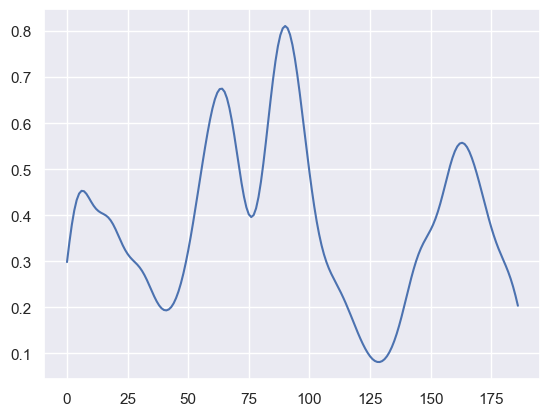

[1765, 2285]
[1900 3700]
17001
cuda
epoch 1,loss = 0.99469411
epoch 2,loss = 0.99467063
epoch 3,loss = 0.99464768
epoch 4,loss = 0.99462521
epoch 5,loss = 0.99460328
epoch 6,loss = 0.99458194
epoch 7,loss = 0.99456090
epoch 8,loss = 0.99454057
epoch 9,loss = 0.99452066
epoch 10,loss = 0.99450129
epoch 11,loss = 0.99448234
epoch 12,loss = 0.99446398
epoch 13,loss = 0.99444610
epoch 14,loss = 0.99442869
epoch 15,loss = 0.99441177
epoch 16,loss = 0.99439538
epoch 17,loss = 0.99437940
epoch 18,loss = 0.99436599
epoch 19,loss = 0.99435270
epoch 20,loss = 0.99433964
epoch 21,loss = 0.99432671
epoch 22,loss = 0.99431348
epoch 23,loss = 0.99430090
epoch 24,loss = 0.99428999
epoch 25,loss = 0.99427754
epoch 26,loss = 0.99426526


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 27,loss = 0.99425310
epoch 28,loss = 0.99424177
epoch 29,loss = 0.99422926
epoch 30,loss = 0.99421865
epoch 31,loss = 0.99420828
epoch 32,loss = 0.99419808
epoch 33,loss = 0.99418819
epoch 34,loss = 0.99417931
epoch 35,loss = 0.99417096
epoch 36,loss = 0.99416256
epoch 37,loss = 0.99415410
epoch 38,loss = 0.99414581
epoch 39,loss = 0.99413741
epoch 40,loss = 0.99412912
epoch 41,loss = 0.99412084
epoch 42,loss = 0.99411255
epoch 43,loss = 0.99410433
epoch 44,loss = 0.99409610
epoch 45,loss = 0.99408793
epoch 46,loss = 0.99408001
epoch 47,loss = 0.99407190
epoch 48,loss = 0.99406397
epoch 49,loss = 0.99405605
epoch 50,loss = 0.99404842
epoch 51,loss = 0.99404073
epoch 52,loss = 0.99403465
epoch 53,loss = 0.99402696
epoch 54,loss = 0.99401993
epoch 55,loss = 0.99401319
epoch 56,loss = 0.99400651
epoch 57,loss = 0.99399966
epoch 58,loss = 0.99399269
epoch 59,loss = 0.99398565
epoch 60,loss = 0.99397868
epoch 61,loss = 0.99397147
epoch 62,loss = 0.99396414
epoch 63,loss = 0.99395674
e

epoch 327,loss = 0.72342366
epoch 328,loss = 0.72318906
epoch 329,loss = 0.72295558
epoch 330,loss = 0.72272456
epoch 331,loss = 0.72249502
epoch 332,loss = 0.72226691
epoch 333,loss = 0.72203988
epoch 334,loss = 0.72181380
epoch 335,loss = 0.72158921
epoch 336,loss = 0.72136533
epoch 337,loss = 0.72114193
epoch 338,loss = 0.72092086
epoch 339,loss = 0.72070140
epoch 340,loss = 0.72048324
epoch 341,loss = 0.72026682
epoch 342,loss = 0.72005153
epoch 343,loss = 0.71983749
epoch 344,loss = 0.71962476
epoch 345,loss = 0.71941268
epoch 346,loss = 0.71919978
epoch 347,loss = 0.71898818
epoch 348,loss = 0.71877831
epoch 349,loss = 0.71856987
epoch 350,loss = 0.71836323
epoch 351,loss = 0.71815789
epoch 352,loss = 0.71795404
epoch 353,loss = 0.71775204
epoch 354,loss = 0.71755171
epoch 355,loss = 0.71735203
epoch 356,loss = 0.71715379
epoch 357,loss = 0.71695703
epoch 358,loss = 0.71676069
epoch 359,loss = 0.71656442
epoch 360,loss = 0.71636903
epoch 361,loss = 0.71617490
epoch 362,loss = 0.7

epoch 644,loss = 0.65179873
epoch 645,loss = 0.65163732
epoch 646,loss = 0.65147626
epoch 647,loss = 0.65131885
epoch 648,loss = 0.65116704
epoch 649,loss = 0.65101808
epoch 650,loss = 0.65087080
epoch 651,loss = 0.65072590
epoch 652,loss = 0.65058243
epoch 653,loss = 0.65043819
epoch 654,loss = 0.65029508
epoch 655,loss = 0.65015680
epoch 656,loss = 0.65001935
epoch 657,loss = 0.64988327
epoch 658,loss = 0.64974886
epoch 659,loss = 0.64961529
epoch 660,loss = 0.64948529
epoch 661,loss = 0.64935571
epoch 662,loss = 0.64922762
epoch 663,loss = 0.64909995
epoch 664,loss = 0.64897370
epoch 665,loss = 0.64884889
epoch 666,loss = 0.64872581
epoch 667,loss = 0.64860409
epoch 668,loss = 0.64848322
epoch 669,loss = 0.64836377
epoch 670,loss = 0.64824265
epoch 671,loss = 0.64811867
epoch 672,loss = 0.64799374
epoch 673,loss = 0.64786953
epoch 674,loss = 0.64774561
epoch 675,loss = 0.64762175
epoch 676,loss = 0.64749956
epoch 677,loss = 0.64737850
epoch 678,loss = 0.64725947
epoch 679,loss = 0.6

epoch 954,loss = 0.63188684
epoch 955,loss = 0.63185304
epoch 956,loss = 0.63181937
epoch 957,loss = 0.63178593
epoch 958,loss = 0.63175249
epoch 959,loss = 0.63171965
epoch 960,loss = 0.63168699
epoch 961,loss = 0.63165444
epoch 962,loss = 0.63162196
epoch 963,loss = 0.63158941
epoch 964,loss = 0.63155675
epoch 965,loss = 0.63152403
epoch 966,loss = 0.63149136
epoch 967,loss = 0.63145888
epoch 968,loss = 0.63142616
epoch 969,loss = 0.63139343
epoch 970,loss = 0.63136071
epoch 971,loss = 0.63132817
epoch 972,loss = 0.63129562
epoch 973,loss = 0.63126326
epoch 974,loss = 0.63123101
epoch 975,loss = 0.63119894
epoch 976,loss = 0.63116688
epoch 977,loss = 0.63113511
epoch 978,loss = 0.63110363
epoch 979,loss = 0.63107210
epoch 980,loss = 0.63104057
epoch 981,loss = 0.63100922
epoch 982,loss = 0.63097823
epoch 983,loss = 0.63094717
epoch 984,loss = 0.63091594
epoch 985,loss = 0.63088447
epoch 986,loss = 0.63085359
epoch 987,loss = 0.63082272
epoch 988,loss = 0.63079202
epoch 989,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([848, 1, 50])
1.0
Epoch 200:   loss= 0.18064  cluster difference= 1.0
Epoch 400:   loss= 0.18104  cluster difference= 0.06721698113207547
Epoch 600:   loss= 0.18123  cluster difference= 0.036556603773584904
Epoch 800:   loss= 0.18138  cluster difference= 0.015330188679245283
Epoch 1000:   loss= 0.18146  cluster difference= 0.01179245283018868
Epoch 1200:   loss= 0.18146  cluster difference= 0.01061320754716981
Epoch 1400:   loss= 0.18141  cluster difference= 0.0023584905660377358
[1 1 1 5 1 1 4 5 5 5 5 5 1 5 5 1 1 1 1 5 1 1 4 5 5 6 0 0 7 3 7 7 3 3 3 3 3
 3 3 7 4 6 6 4 3 6 5 5 1 2 5 5 5 5 1 1 4 5 5 5 5 1 1 1 5 1 1 5 1 2 1 5 5 5
 4 0 0 7 7 3 7 7 6 6 4 5 1 2 1 5 5 5 2 2 2 2 2 2 2 1 2 2 1 1 1 1 1 2 1 1 1
 1 1 5 1 1 1 2 2 2 1 1 1 1 2 2 2 2 2 2 2 2 2 2 1 1 2 2 2 2 1 2 2 1 2 1 5 1
 5 5 1 1 2 2 1 1 2 1 4 6 4 4 0 5 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1

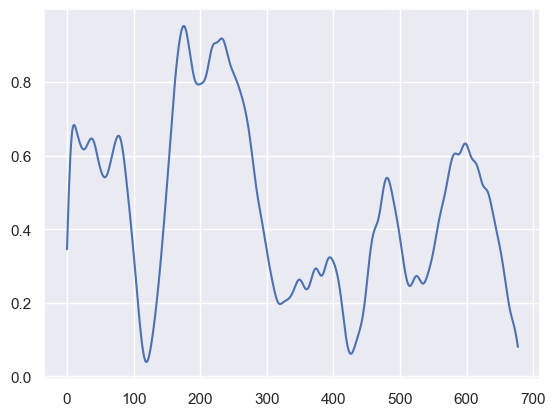

[1945, 5225, 13685]
[3802]
10001
cuda
epoch 1,loss = 0.99331903
epoch 2,loss = 0.99331081
epoch 3,loss = 0.99330270
epoch 4,loss = 0.99329472
epoch 5,loss = 0.99328673
epoch 6,loss = 0.99327892
epoch 7,loss = 0.99327117
epoch 8,loss = 0.99326348
epoch 9,loss = 0.99325585
epoch 10,loss = 0.99324834
epoch 11,loss = 0.99324089
epoch 12,loss = 0.99323368
epoch 13,loss = 0.99322629
epoch 14,loss = 0.99321920
epoch 15,loss = 0.99321204
epoch 16,loss = 0.99320513
epoch 17,loss = 0.99319822
epoch 18,loss = 0.99319130
epoch 19,loss = 0.99318457
epoch 20,loss = 0.99317789
epoch 21,loss = 0.99317139
epoch 22,loss = 0.99316484
epoch 23,loss = 0.99315840
epoch 24,loss = 0.99315202
epoch 25,loss = 0.99314582
epoch 26,loss = 0.99313968
epoch 27,loss = 0.99313360
epoch 28,loss = 0.99312758
epoch 29,loss = 0.99312156
epoch 30,loss = 0.99311572
epoch 31,loss = 0.99310988
epoch 32,loss = 0.99310416
epoch 33,loss = 0.99309844
epoch 34,loss = 0.99309283
epoch 35,loss = 0.99308729
epoch 36,loss = 0.99308181

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 39,loss = 0.99306583
epoch 40,loss = 0.99306047
epoch 41,loss = 0.99305540
epoch 42,loss = 0.99305028
epoch 43,loss = 0.99304509
epoch 44,loss = 0.99304020
epoch 45,loss = 0.99303526
epoch 46,loss = 0.99303037
epoch 47,loss = 0.99302542
epoch 48,loss = 0.99302065
epoch 49,loss = 0.99301589
epoch 50,loss = 0.99301124
epoch 51,loss = 0.99300653
epoch 52,loss = 0.99300188
epoch 53,loss = 0.99299729
epoch 54,loss = 0.99299270
epoch 55,loss = 0.99298823
epoch 56,loss = 0.99298388
epoch 57,loss = 0.99297947
epoch 58,loss = 0.99297500
epoch 59,loss = 0.99297071
epoch 60,loss = 0.99296635
epoch 61,loss = 0.99296212
epoch 62,loss = 0.99295789
epoch 63,loss = 0.99295366
epoch 64,loss = 0.99294943
epoch 65,loss = 0.99294519
epoch 66,loss = 0.99294102
epoch 67,loss = 0.99293679
epoch 68,loss = 0.99293262
epoch 69,loss = 0.99292833
epoch 70,loss = 0.99292409
epoch 71,loss = 0.99291974
epoch 72,loss = 0.99291545
epoch 73,loss = 0.99291104
epoch 74,loss = 0.99290657
epoch 75,loss = 0.99290204
e

epoch 369,loss = 0.82538229
epoch 370,loss = 0.82534826
epoch 371,loss = 0.82531422
epoch 372,loss = 0.82528001
epoch 373,loss = 0.82524532
epoch 374,loss = 0.82521045
epoch 375,loss = 0.82517529
epoch 376,loss = 0.82513988
epoch 377,loss = 0.82510459
epoch 378,loss = 0.82506907
epoch 379,loss = 0.82503325
epoch 380,loss = 0.82499748
epoch 381,loss = 0.82496172
epoch 382,loss = 0.82492584
epoch 383,loss = 0.82488966
epoch 384,loss = 0.82485336
epoch 385,loss = 0.82481712
epoch 386,loss = 0.82478082
epoch 387,loss = 0.82474440
epoch 388,loss = 0.82470828
epoch 389,loss = 0.82467252
epoch 390,loss = 0.82463658
epoch 391,loss = 0.82460022
epoch 392,loss = 0.82456356
epoch 393,loss = 0.82452714
epoch 394,loss = 0.82449037
epoch 395,loss = 0.82445270
epoch 396,loss = 0.82441467
epoch 397,loss = 0.82437605
epoch 398,loss = 0.82433778
epoch 399,loss = 0.82429886
epoch 400,loss = 0.82425982
epoch 401,loss = 0.82422030
epoch 402,loss = 0.82418031
epoch 403,loss = 0.82413983
epoch 404,loss = 0.8

epoch 681,loss = 0.78459823
epoch 682,loss = 0.78443491
epoch 683,loss = 0.78427196
epoch 684,loss = 0.78410798
epoch 685,loss = 0.78394473
epoch 686,loss = 0.78378218
epoch 687,loss = 0.78362072
epoch 688,loss = 0.78346038
epoch 689,loss = 0.78330159
epoch 690,loss = 0.78314459
epoch 691,loss = 0.78298783
epoch 692,loss = 0.78283143
epoch 693,loss = 0.78267586
epoch 694,loss = 0.78252059
epoch 695,loss = 0.78236639
epoch 696,loss = 0.78221208
epoch 697,loss = 0.78205830
epoch 698,loss = 0.78190476
epoch 699,loss = 0.78175235
epoch 700,loss = 0.78160077
epoch 701,loss = 0.78145033
epoch 702,loss = 0.78130054
epoch 703,loss = 0.78115082
epoch 704,loss = 0.78100151
epoch 705,loss = 0.78085250
epoch 706,loss = 0.78070450
epoch 707,loss = 0.78055751
epoch 708,loss = 0.78041112
epoch 709,loss = 0.78026557
epoch 710,loss = 0.78012019
epoch 711,loss = 0.77997518
epoch 712,loss = 0.77983040
epoch 713,loss = 0.77968669
epoch 714,loss = 0.77954328
epoch 715,loss = 0.77940023
epoch 716,loss = 0.7

epoch 1006,loss = 0.75434518
epoch 1007,loss = 0.75430012
epoch 1008,loss = 0.75425667
epoch 1009,loss = 0.75421363
epoch 1010,loss = 0.75417024
epoch 1011,loss = 0.75412726
epoch 1012,loss = 0.75408405
epoch 1013,loss = 0.75404114
epoch 1014,loss = 0.75399864
epoch 1015,loss = 0.75395674
epoch 1016,loss = 0.75391483
epoch 1017,loss = 0.75387311
epoch 1018,loss = 0.75383204
epoch 1019,loss = 0.75379109
epoch 1020,loss = 0.75375062
epoch 1021,loss = 0.75371027
epoch 1022,loss = 0.75366998
epoch 1023,loss = 0.75362885
epoch 1024,loss = 0.75358826
epoch 1025,loss = 0.75354761
epoch 1026,loss = 0.75350857
epoch 1027,loss = 0.75346887
epoch 1028,loss = 0.75342840
epoch 1029,loss = 0.75338805
epoch 1030,loss = 0.75334835
epoch 1031,loss = 0.75330782
epoch 1032,loss = 0.75326860
epoch 1033,loss = 0.75322956
epoch 1034,loss = 0.75319046
epoch 1035,loss = 0.75315166
epoch 1036,loss = 0.75311339
epoch 1037,loss = 0.75307542
epoch 1038,loss = 0.75303793
epoch 1039,loss = 0.75300121
epoch 1040,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([498, 1, 50])
1.0
Epoch 200:   loss= 0.20368  cluster difference= 1.0
Epoch 400:   loss= 0.203  cluster difference= 0.12650602409638553
Epoch 600:   loss= 0.20239  cluster difference= 0.03614457831325301
Epoch 800:   loss= 0.20177  cluster difference= 0.030120481927710843
Epoch 1000:   loss= 0.2011  cluster difference= 0.018072289156626505
Epoch 1200:   loss= 0.20042  cluster difference= 0.028112449799196786
Epoch 1400:   loss= 0.19974  cluster difference= 0.03614457831325301
Epoch 1600:   loss= 0.19911  cluster difference= 0.03614457831325301
Epoch 1800:   loss= 0.19861  cluster difference= 0.03815261044176707
Epoch 2000:   loss= 0.19824  cluster difference= 0.03614457831325301
Epoch 2200:   loss= 0.198  cluster difference= 0.0321285140562249
Epoch 2400:   loss= 0.19785  cluster difference= 0.020080321285140562
Epoch 2600:   loss= 0.19775  cluster difference= 0.024096385542168676
Epoch 2800:   loss= 0.19767  cluster difference= 0.018072289156626505
Epoch 3000:   loss= 0.197

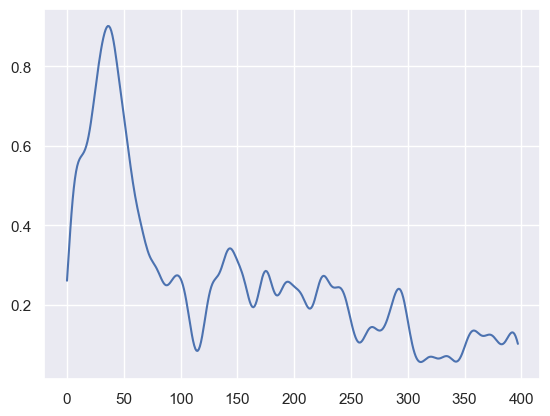

[1745]
[1800]
7001
cuda
epoch 1,loss = 1.02963245
epoch 2,loss = 1.02869415
epoch 3,loss = 1.02777565
epoch 4,loss = 1.02687740
epoch 5,loss = 1.02599931
epoch 6,loss = 1.02514148
epoch 7,loss = 1.02430379
epoch 8,loss = 1.02348626
epoch 9,loss = 1.02268887
epoch 10,loss = 1.02191126
epoch 11,loss = 1.02115333
epoch 12,loss = 1.02041483
epoch 13,loss = 1.01969600
epoch 14,loss = 1.01899683
epoch 15,loss = 1.01831651
epoch 16,loss = 1.01765466
epoch 17,loss = 1.01701140
epoch 18,loss = 1.01638424
epoch 19,loss = 1.01577497
epoch 20,loss = 1.01518285
epoch 21,loss = 1.01460660
epoch 22,loss = 1.01404428
epoch 23,loss = 1.01349795
epoch 24,loss = 1.01296723
epoch 25,loss = 1.01245141
epoch 26,loss = 1.01194906
epoch 27,loss = 1.01146102
epoch 28,loss = 1.01098728
epoch 29,loss = 1.01052630
epoch 30,loss = 1.01007855
epoch 31,loss = 1.00964379
epoch 32,loss = 1.00922084
epoch 33,loss = 1.00880873
epoch 34,loss = 1.00840676
epoch 35,loss = 1.00801516
epoch 36,loss = 1.00763357
epoch 37,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 46,loss = 1.00427258
epoch 47,loss = 1.00397027
epoch 48,loss = 1.00367308
epoch 49,loss = 1.00338113
epoch 50,loss = 1.00309277
epoch 51,loss = 1.00280941
epoch 52,loss = 1.00252962
epoch 53,loss = 1.00225294
epoch 54,loss = 1.00197494
epoch 55,loss = 1.00169814
epoch 56,loss = 1.00141978
epoch 57,loss = 1.00114059
epoch 58,loss = 1.00086212
epoch 59,loss = 1.00058508
epoch 60,loss = 1.00031114
epoch 61,loss = 1.00003672
epoch 62,loss = 0.99975395
epoch 63,loss = 0.99946594
epoch 64,loss = 0.99917275
epoch 65,loss = 0.99887270
epoch 66,loss = 0.99856299
epoch 67,loss = 0.99825007
epoch 68,loss = 0.99793023
epoch 69,loss = 0.99760550
epoch 70,loss = 0.99727237
epoch 71,loss = 0.99693888
epoch 72,loss = 0.99660379
epoch 73,loss = 0.99626547
epoch 74,loss = 0.99592435
epoch 75,loss = 0.99557406
epoch 76,loss = 0.99521327
epoch 77,loss = 0.99483907
epoch 78,loss = 0.99444956
epoch 79,loss = 0.99405330
epoch 80,loss = 0.99366403
epoch 81,loss = 0.99327677
epoch 82,loss = 0.99287909
e

epoch 347,loss = 0.85493970
epoch 348,loss = 0.85485482
epoch 349,loss = 0.85477072
epoch 350,loss = 0.85468751
epoch 351,loss = 0.85460478
epoch 352,loss = 0.85452229
epoch 353,loss = 0.85444033
epoch 354,loss = 0.85435909
epoch 355,loss = 0.85427868
epoch 356,loss = 0.85419935
epoch 357,loss = 0.85412276
epoch 358,loss = 0.85404623
epoch 359,loss = 0.85397023
epoch 360,loss = 0.85389471
epoch 361,loss = 0.85381973
epoch 362,loss = 0.85374659
epoch 363,loss = 0.85367501
epoch 364,loss = 0.85360074
epoch 365,loss = 0.85352343
epoch 366,loss = 0.85344243
epoch 367,loss = 0.85336232
epoch 368,loss = 0.85328150
epoch 369,loss = 0.85319638
epoch 370,loss = 0.85310215
epoch 371,loss = 0.85294586
epoch 372,loss = 0.85272890
epoch 373,loss = 0.85244828
epoch 374,loss = 0.85213363
epoch 375,loss = 0.85180449
epoch 376,loss = 0.85147429
epoch 377,loss = 0.85117173
epoch 378,loss = 0.85088354
epoch 379,loss = 0.85060674
epoch 380,loss = 0.85032499
epoch 381,loss = 0.85006624
epoch 382,loss = 0.8

epoch 656,loss = 0.83974606
epoch 657,loss = 0.83972996
epoch 658,loss = 0.83971411
epoch 659,loss = 0.83969808
epoch 660,loss = 0.83968222
epoch 661,loss = 0.83966655
epoch 662,loss = 0.83965063
epoch 663,loss = 0.83963478
epoch 664,loss = 0.83961904
epoch 665,loss = 0.83960348
epoch 666,loss = 0.83958787
epoch 667,loss = 0.83957237
epoch 668,loss = 0.83955705
epoch 669,loss = 0.83954179
epoch 670,loss = 0.83952636
epoch 671,loss = 0.83951104
epoch 672,loss = 0.83949578
epoch 673,loss = 0.83948064
epoch 674,loss = 0.83946562
epoch 675,loss = 0.83945048
epoch 676,loss = 0.83943552
epoch 677,loss = 0.83942056
epoch 678,loss = 0.83940548
epoch 679,loss = 0.83939075
epoch 680,loss = 0.83937579
epoch 681,loss = 0.83936119
epoch 682,loss = 0.83934671
epoch 683,loss = 0.83933246
epoch 684,loss = 0.83931822
epoch 685,loss = 0.83930415
epoch 686,loss = 0.83929008
epoch 687,loss = 0.83927602
epoch 688,loss = 0.83926189
epoch 689,loss = 0.83924776
epoch 690,loss = 0.83923370
epoch 691,loss = 0.8

epoch 975,loss = 0.83555990
epoch 976,loss = 0.83554405
epoch 977,loss = 0.83552837
epoch 978,loss = 0.83551258
epoch 979,loss = 0.83549684
epoch 980,loss = 0.83548111
epoch 981,loss = 0.83546525
epoch 982,loss = 0.83544946
epoch 983,loss = 0.83543360
epoch 984,loss = 0.83541769
epoch 985,loss = 0.83540159
epoch 986,loss = 0.83538544
epoch 987,loss = 0.83536929
epoch 988,loss = 0.83535314
epoch 989,loss = 0.83533698
epoch 990,loss = 0.83532095
epoch 991,loss = 0.83530486
epoch 992,loss = 0.83528888
epoch 993,loss = 0.83527291
epoch 994,loss = 0.83525693
epoch 995,loss = 0.83524108
epoch 996,loss = 0.83522540
epoch 997,loss = 0.83520979
epoch 998,loss = 0.83519417
epoch 999,loss = 0.83517843
epoch 1000,loss = 0.83516264
epoch 1001,loss = 0.83514678
epoch 1002,loss = 0.83513105
epoch 1003,loss = 0.83511537
epoch 1004,loss = 0.83509976
epoch 1005,loss = 0.83508408
epoch 1006,loss = 0.83506840
epoch 1007,loss = 0.83505279
epoch 1008,loss = 0.83503711
epoch 1009,loss = 0.83502138
epoch 1010

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([348, 1, 50])
1.0
Epoch 200:   loss= 0.17864  cluster difference= 1.0
Epoch 400:   loss= 0.17814  cluster difference= 0.10344827586206896
Epoch 600:   loss= 0.17713  cluster difference= 0.008620689655172414
[0 3 3 3 3 0 0 3 7 3 3 3 3 3 3 7 3 3 3 3 3 3 3 7 3 3 3 3 7 0 3 3 0 0 2 1 2
 1 5 3 3 3 0 5 3 7 2 6 2 1 1 1 1 6 3 3 3 3 3 3 3 3 3 5 3 3 3 3 3 3 3 3 3 3
 2 5 0 3 4 1 1 1 1 1 6 0 4 3 3 3 0 4 2 2 5 2 6 5 0 3 2 2 1 3 3 0 3 2 0 0 1
 6 3 2 6 0 0 0 0 0 2 1 6 0 4 0 2 1 0 5 0 3 3 2 1 4 2 6 3 2 6 5 2 2 4 2 6 2
 6 3 0 5 2 1 6 5 2 1 1 1 1 6 1 6 0 4 5 1 1 5 3 0 2 2 5 2 5 0 0 0 0 5 5 5 5
 5 0 5 5 0 0 5 5 5 5 2 2 2 2 5 0 1 6 2 2 5 5 5 5 5 0 0 5 5 5 2 2 2 5 0 5 5
 2 5 2 2 5 2 2 1 1 1 1 1 1 2 2 2 5 5 2 6 3 0 5 5 0 5 5 5 5 5 5 5 5 2 2 2 0
 3 3 2 1 2 2 5 2 2 5 0 3 0 2 5 0 3 3 3 3 7 0 4 3 0 5 3 3 3 0 0 5 2 5 5 5 0
 5 5 2 1 1 2 2 5 2 5 0 3 0 2 6 2 1 6 2 1 5 0 5 5 0 2 6 0 0 1 2 2 1 6 0 5 2
 1 5 5 5 7 0 2 5 2 5 3 0 0 0 0]


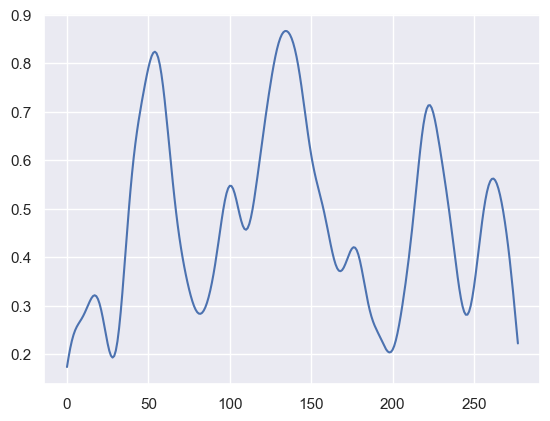

[1805, 3405, 5185]
[1710]
19001
cuda
epoch 1,loss = 0.99448758
epoch 2,loss = 0.99370897
epoch 3,loss = 0.99295884
epoch 4,loss = 0.99223900
epoch 5,loss = 0.99155754
epoch 6,loss = 0.99092597
epoch 7,loss = 0.99034351
epoch 8,loss = 0.98979259


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 9,loss = 0.98926193
epoch 10,loss = 0.98872489
epoch 11,loss = 0.98822635
epoch 12,loss = 0.98779082
epoch 13,loss = 0.98738581
epoch 14,loss = 0.98699367
epoch 15,loss = 0.98659718
epoch 16,loss = 0.98618060
epoch 17,loss = 0.98576427
epoch 18,loss = 0.98534727
epoch 19,loss = 0.98490030
epoch 20,loss = 0.98444289
epoch 21,loss = 0.98402512
epoch 22,loss = 0.98369563
epoch 23,loss = 0.98340356
epoch 24,loss = 0.98311198
epoch 25,loss = 0.98277855
epoch 26,loss = 0.98242050
epoch 27,loss = 0.98206288
epoch 28,loss = 0.98173457
epoch 29,loss = 0.98139679
epoch 30,loss = 0.98104250
epoch 31,loss = 0.98066884
epoch 32,loss = 0.98027354
epoch 33,loss = 0.97985274
epoch 34,loss = 0.97940415
epoch 35,loss = 0.97892016
epoch 36,loss = 0.97840506
epoch 37,loss = 0.97784775
epoch 38,loss = 0.97725362
epoch 39,loss = 0.97662294
epoch 40,loss = 0.97596151
epoch 41,loss = 0.97525531
epoch 42,loss = 0.97450030
epoch 43,loss = 0.97369349
epoch 44,loss = 0.97283500
epoch 45,loss = 0.97192413
ep

epoch 336,loss = 0.80202895
epoch 337,loss = 0.80199796
epoch 338,loss = 0.80196732
epoch 339,loss = 0.80193663
epoch 340,loss = 0.80190575
epoch 341,loss = 0.80187470
epoch 342,loss = 0.80184400
epoch 343,loss = 0.80181301
epoch 344,loss = 0.80178130
epoch 345,loss = 0.80174911
epoch 346,loss = 0.80171639
epoch 347,loss = 0.80168259
epoch 348,loss = 0.80164814
epoch 349,loss = 0.80161309
epoch 350,loss = 0.80157757
epoch 351,loss = 0.80154157
epoch 352,loss = 0.80150443
epoch 353,loss = 0.80146658
epoch 354,loss = 0.80142802
epoch 355,loss = 0.80138862
epoch 356,loss = 0.80134857
epoch 357,loss = 0.80130738
epoch 358,loss = 0.80126452
epoch 359,loss = 0.80122048
epoch 360,loss = 0.80117458
epoch 361,loss = 0.80112720
epoch 362,loss = 0.80107868
epoch 363,loss = 0.80102980
epoch 364,loss = 0.80098069
epoch 365,loss = 0.80093306
epoch 366,loss = 0.80088770
epoch 367,loss = 0.80084366
epoch 368,loss = 0.80080014
epoch 369,loss = 0.80075717
epoch 370,loss = 0.80071616
epoch 371,loss = 0.8

epoch 633,loss = 0.77644926
epoch 634,loss = 0.77627140
epoch 635,loss = 0.77609950
epoch 636,loss = 0.77593303
epoch 637,loss = 0.77577144
epoch 638,loss = 0.77561462
epoch 639,loss = 0.77546293
epoch 640,loss = 0.77531612
epoch 641,loss = 0.77517474
epoch 642,loss = 0.77503914
epoch 643,loss = 0.77490896
epoch 644,loss = 0.77478164
epoch 645,loss = 0.77465940
epoch 646,loss = 0.77454084
epoch 647,loss = 0.77442628
epoch 648,loss = 0.77431607
epoch 649,loss = 0.77421051
epoch 650,loss = 0.77410847
epoch 651,loss = 0.77400929
epoch 652,loss = 0.77391332
epoch 653,loss = 0.77382052
epoch 654,loss = 0.77372980
epoch 655,loss = 0.77364141
epoch 656,loss = 0.77355534
epoch 657,loss = 0.77347153
epoch 658,loss = 0.77339047
epoch 659,loss = 0.77331156
epoch 660,loss = 0.77323431
epoch 661,loss = 0.77315837
epoch 662,loss = 0.77308428
epoch 663,loss = 0.77301127
epoch 664,loss = 0.77293915
epoch 665,loss = 0.77286738
epoch 666,loss = 0.77279592
epoch 667,loss = 0.77272499
epoch 668,loss = 0.7

epoch 926,loss = 0.76021445
epoch 927,loss = 0.76017028
epoch 928,loss = 0.76012617
epoch 929,loss = 0.76008207
epoch 930,loss = 0.76003790
epoch 931,loss = 0.75999373
epoch 932,loss = 0.75994951
epoch 933,loss = 0.75990522
epoch 934,loss = 0.75986105
epoch 935,loss = 0.75981683
epoch 936,loss = 0.75977248
epoch 937,loss = 0.75972813
epoch 938,loss = 0.75968361
epoch 939,loss = 0.75963932
epoch 940,loss = 0.75959504
epoch 941,loss = 0.75955069
epoch 942,loss = 0.75950629
epoch 943,loss = 0.75946188
epoch 944,loss = 0.75941753
epoch 945,loss = 0.75937313
epoch 946,loss = 0.75932860
epoch 947,loss = 0.75928396
epoch 948,loss = 0.75923920
epoch 949,loss = 0.75919455
epoch 950,loss = 0.75914961
epoch 951,loss = 0.75910479
epoch 952,loss = 0.75906003
epoch 953,loss = 0.75901538
epoch 954,loss = 0.75897056
epoch 955,loss = 0.75892580
epoch 956,loss = 0.75888103
epoch 957,loss = 0.75883639
epoch 958,loss = 0.75879169
epoch 959,loss = 0.75874704
epoch 960,loss = 0.75870246
epoch 961,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([948, 1, 50])
1.0
Epoch 200:   loss= 0.14323  cluster difference= 1.0
Epoch 400:   loss= 0.14279  cluster difference= 0.0189873417721519
Epoch 600:   loss= 0.14245  cluster difference= 0.005274261603375527
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 7 7 7 0 0 0 0 0 0 0
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 3 3 3 3 3 7 0 0 0 0 0 7 5 2 2 2 2 4 4 2 2 4 4
 4 4 4 2 4 5 6 5 6 5 5 6 5 2 5 5 2 5 5 6 2 5 6 6 2 2 6 5 2 5 5 6 5 2 2 6 2
 2 2 2 6 6 6 5 6 5 2 2 6 5 2 4 2 2 6 6 3 6 2 4 4 4 4 4 4 4 2 2 2 4 2 2 4 4
 2 2 4 4 2 6 3 4 4 4 4 6 3 3 3 6 5 3 5 2 2 2 4 4 2 2 2 2 4 4 2 2 2 2 1 7 0
 3 6 6 5 5 2 2 5 5 4 2 2 5 5 2 1 6 6 5 5 6 6 5 6 3 6 1 7 3 5 2 4 4 2 2 6 3
 5 6 7 3 7 0 7 3 4 4 6 6 5 1 7 0 0 0 7 3 3 3 6 6 6 6 6 6 3 3 7 7 7 0 0 7 7
 3 3 3 3 6 6 6 6 7 3 1 7 3 6 5 7 7 0 0 0 0 0 0 7 7 3 3 3 3 3 7 3 1 7 7 0 0
 0 0 0 0 0 7 7 7 7 7 7 6 1 0 0 7 

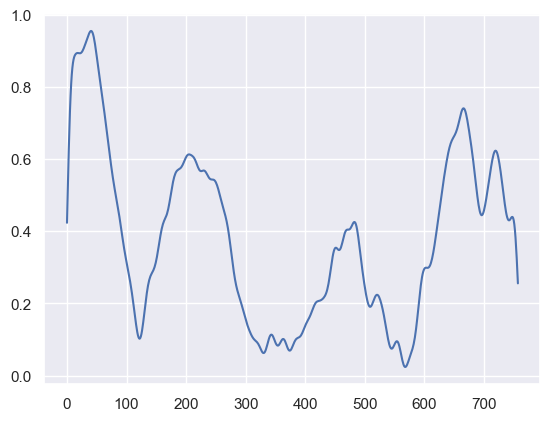

[2725, 6025, 15245]
[3160]
7383
cuda
epoch 1,loss = 1.00428438
epoch 2,loss = 1.00421524
epoch 3,loss = 1.00414944
epoch 4,loss = 1.00409257
epoch 5,loss = 1.00404167
epoch 6,loss = 1.00399697
epoch 7,loss = 1.00395834
epoch 8,loss = 1.00392532
epoch 9,loss = 1.00389957
epoch 10,loss = 1.00387943
epoch 11,loss = 1.00386739
epoch 12,loss = 1.00385606
epoch 13,loss = 1.00384605
epoch 14,loss = 1.00384378
epoch 15,loss = 1.00383902
epoch 16,loss = 1.00383580
epoch 17,loss = 1.00383139
epoch 18,loss = 1.00382543
epoch 19,loss = 1.00383055
epoch 20,loss = 1.00383031
epoch 21,loss = 1.00382602
epoch 22,loss = 1.00382650
epoch 23,loss = 1.00382578
epoch 24,loss = 1.00382519
epoch 25,loss = 1.00382471
epoch 26,loss = 1.00382471
epoch 27,loss = 1.00382447
epoch 28,loss = 1.00382435
epoch 29,loss = 1.00382400
epoch 30,loss = 1.00382435
epoch 31,loss = 1.00382423
epoch 32,loss = 1.00382423
epoch 33,loss = 1.00382423
epoch 34,loss = 1.00382411
epoch 35,loss = 1.00382411
epoch 36,loss = 1.00382411


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 47,loss = 1.00382292
epoch 48,loss = 1.00382280
epoch 49,loss = 1.00382268
epoch 50,loss = 1.00382268
epoch 51,loss = 1.00382245
epoch 52,loss = 1.00382233
epoch 53,loss = 1.00382221
epoch 54,loss = 1.00382197
epoch 55,loss = 1.00382173
epoch 56,loss = 1.00382161
epoch 57,loss = 1.00382137
epoch 58,loss = 1.00382125
epoch 59,loss = 1.00382090
epoch 60,loss = 1.00382066
epoch 61,loss = 1.00382030
epoch 62,loss = 1.00382006
epoch 63,loss = 1.00381982
epoch 64,loss = 1.00381935
epoch 65,loss = 1.00381899
epoch 66,loss = 1.00381875
epoch 67,loss = 1.00381827
epoch 68,loss = 1.00381768
epoch 69,loss = 1.00381720
epoch 70,loss = 1.00381660
epoch 71,loss = 1.00381601
epoch 72,loss = 1.00381517
epoch 73,loss = 1.00381422
epoch 74,loss = 1.00381339
epoch 75,loss = 1.00381231
epoch 76,loss = 1.00381124
epoch 77,loss = 1.00381005
epoch 78,loss = 1.00380862
epoch 79,loss = 1.00380707
epoch 80,loss = 1.00380516
epoch 81,loss = 1.00380301
epoch 82,loss = 1.00380027
epoch 83,loss = 1.00379682
e

epoch 366,loss = 0.41154850
epoch 367,loss = 0.41147760
epoch 368,loss = 0.41140684
epoch 369,loss = 0.41133615
epoch 370,loss = 0.41126466
epoch 371,loss = 0.41119304
epoch 372,loss = 0.41112152
epoch 373,loss = 0.41105005
epoch 374,loss = 0.41097856
epoch 375,loss = 0.41090623
epoch 376,loss = 0.41083393
epoch 377,loss = 0.41076154
epoch 378,loss = 0.41068879
epoch 379,loss = 0.41061553
epoch 380,loss = 0.41054159
epoch 381,loss = 0.41046780
epoch 382,loss = 0.41039395
epoch 383,loss = 0.41032025
epoch 384,loss = 0.41024649
epoch 385,loss = 0.41017276
epoch 386,loss = 0.41009846
epoch 387,loss = 0.41002381
epoch 388,loss = 0.40994921
epoch 389,loss = 0.40987498
epoch 390,loss = 0.40980032
epoch 391,loss = 0.40972385
epoch 392,loss = 0.40964711
epoch 393,loss = 0.40956989
epoch 394,loss = 0.40949243
epoch 395,loss = 0.40941510
epoch 396,loss = 0.40933770
epoch 397,loss = 0.40926030
epoch 398,loss = 0.40918303
epoch 399,loss = 0.40910596
epoch 400,loss = 0.40902904
epoch 401,loss = 0.4

epoch 683,loss = 0.37817854
epoch 684,loss = 0.37801427
epoch 685,loss = 0.37785083
epoch 686,loss = 0.37768641
epoch 687,loss = 0.37752205
epoch 688,loss = 0.37735561
epoch 689,loss = 0.37718800
epoch 690,loss = 0.37702113
epoch 691,loss = 0.37685496
epoch 692,loss = 0.37668926
epoch 693,loss = 0.37652370
epoch 694,loss = 0.37635887
epoch 695,loss = 0.37619302
epoch 696,loss = 0.37602705
epoch 697,loss = 0.37586147
epoch 698,loss = 0.37569454
epoch 699,loss = 0.37552628
epoch 700,loss = 0.37535423
epoch 701,loss = 0.37518230
epoch 702,loss = 0.37501147
epoch 703,loss = 0.37484041
epoch 704,loss = 0.37466776
epoch 705,loss = 0.37449491
epoch 706,loss = 0.37432092
epoch 707,loss = 0.37414712
epoch 708,loss = 0.37397408
epoch 709,loss = 0.37380090
epoch 710,loss = 0.37362817
epoch 711,loss = 0.37345663
epoch 712,loss = 0.37328592
epoch 713,loss = 0.37311524
epoch 714,loss = 0.37294501
epoch 715,loss = 0.37277561
epoch 716,loss = 0.37260628
epoch 717,loss = 0.37243471
epoch 718,loss = 0.3

epoch 999,loss = 0.33746958
epoch 1000,loss = 0.33742326
epoch 1001,loss = 0.33737737
epoch 1002,loss = 0.33733198
epoch 1003,loss = 0.33728686
epoch 1004,loss = 0.33724248
epoch 1005,loss = 0.33719844
epoch 1006,loss = 0.33715475
epoch 1007,loss = 0.33711144
epoch 1008,loss = 0.33706835
epoch 1009,loss = 0.33702487
epoch 1010,loss = 0.33698174
epoch 1011,loss = 0.33693883
epoch 1012,loss = 0.33689636
epoch 1013,loss = 0.33685431
epoch 1014,loss = 0.33681262
epoch 1015,loss = 0.33677122
epoch 1016,loss = 0.33672971
epoch 1017,loss = 0.33668849
epoch 1018,loss = 0.33664864
epoch 1019,loss = 0.33660841
epoch 1020,loss = 0.33656821
epoch 1021,loss = 0.33652815
epoch 1022,loss = 0.33648887
epoch 1023,loss = 0.33645028
epoch 1024,loss = 0.33641192
epoch 1025,loss = 0.33637398
epoch 1026,loss = 0.33633667
epoch 1027,loss = 0.33629957
epoch 1028,loss = 0.33626267
epoch 1029,loss = 0.33622593
epoch 1030,loss = 0.33618927
epoch 1031,loss = 0.33615282
epoch 1032,loss = 0.33611685
epoch 1033,loss

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([183, 1, 100])
1.0
Epoch 200:   loss= 0.21349  cluster difference= 1.0
Epoch 400:   loss= 0.21312  cluster difference= 0.00546448087431694
[0 4 6 2 0 1 2 2 5 7 2 2 3 7 2 0 4 6 2 0 4 6 2 5 1 2 2 3 7 2 0 4 6 2 0 4 6
 2 5 7 2 2 3 7 2 0 4 6 2 0 4 6 2 5 1 2 2 3 7 2 0 4 6 2 0 4 6 2 5 1 2 2 3 7
 2 2 3 7 2 0 4 7 2 5 1 6 2 5 1 6 2 3 7 2 0 3 7 2 0 4 6 2 5 1 6 2 3 1 2 0 1
 6 2 5 1 6 2 5 1 6 6 3 7 2 0 4 6 2 5 1 6 2 5 7 2 2 3 7 6 0 3 7 2 5 1 6 2 5
 1 6 2 3 7 2 0 4 7 2 2 2 3 7 2 0 4 7 2 5 1 2 2 3 7 2 0 4 6 2 5 1 6 2 5]


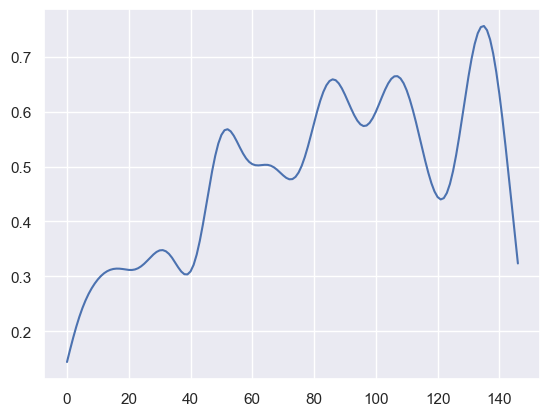

[5050, 6170]
[3000]
14973
cuda
epoch 1,loss = 1.00341082
epoch 2,loss = 1.00339377
epoch 3,loss = 1.00338149
epoch 4,loss = 1.00337279
epoch 5,loss = 1.00336695
epoch 6,loss = 1.00336397
epoch 7,loss = 1.00336254
epoch 8,loss = 1.00336194
epoch 9,loss = 1.00336170
epoch 10,loss = 1.00335574
epoch 11,loss = 1.00334585
epoch 12,loss = 1.00333273
epoch 13,loss = 1.00332046
epoch 14,loss = 1.00329876
epoch 15,loss = 1.00327003
epoch 16,loss = 1.00321555
epoch 17,loss = 1.00314510
epoch 18,loss = 1.00305450
epoch 19,loss = 1.00294209
epoch 20,loss = 1.00280643
epoch 21,loss = 1.00264096
epoch 22,loss = 1.00245762
epoch 23,loss = 1.00224435
epoch 24,loss = 1.00200164
epoch 25,loss = 1.00172651
epoch 26,loss = 1.00141752
epoch 27,loss = 1.00107014
epoch 28,loss = 1.00069833
epoch 29,loss = 1.00029612
epoch 30,loss = 0.99990278
epoch 31,loss = 0.99950856
epoch 32,loss = 0.99916172
epoch 33,loss = 0.99881595
epoch 34,loss = 0.99850512
epoch 35,loss = 0.99816036
epoch 36,loss = 0.99785554
epoch 

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 41,loss = 0.99548787
epoch 42,loss = 0.99484479
epoch 43,loss = 0.99412477
epoch 44,loss = 0.99333930
epoch 45,loss = 0.99250776
epoch 46,loss = 0.99163306
epoch 47,loss = 0.99070585
epoch 48,loss = 0.98971838
epoch 49,loss = 0.98866349
epoch 50,loss = 0.98752469
epoch 51,loss = 0.98627353
epoch 52,loss = 0.98487115
epoch 53,loss = 0.98331863
epoch 54,loss = 0.98165131
epoch 55,loss = 0.97987777
epoch 56,loss = 0.97793114
epoch 57,loss = 0.97577232
epoch 58,loss = 0.97347212
epoch 59,loss = 0.97099149
epoch 60,loss = 0.96831656
epoch 61,loss = 0.96545511
epoch 62,loss = 0.96237558
epoch 63,loss = 0.95910639
epoch 64,loss = 0.95565987
epoch 65,loss = 0.95203799
epoch 66,loss = 0.94823211
epoch 67,loss = 0.94422388
epoch 68,loss = 0.94002879
epoch 69,loss = 0.93564832
epoch 70,loss = 0.93107653
epoch 71,loss = 0.92630315
epoch 72,loss = 0.92129642
epoch 73,loss = 0.91605037
epoch 74,loss = 0.91054958
epoch 75,loss = 0.90484500
epoch 76,loss = 0.89894456
epoch 77,loss = 0.89285356
e

epoch 356,loss = 0.48579186
epoch 357,loss = 0.48569515
epoch 358,loss = 0.48559916
epoch 359,loss = 0.48550320
epoch 360,loss = 0.48540741
epoch 361,loss = 0.48531041
epoch 362,loss = 0.48521233
epoch 363,loss = 0.48511371
epoch 364,loss = 0.48501498
epoch 365,loss = 0.48491648
epoch 366,loss = 0.48481828
epoch 367,loss = 0.48472047
epoch 368,loss = 0.48462281
epoch 369,loss = 0.48452511
epoch 370,loss = 0.48442709
epoch 371,loss = 0.48432833
epoch 372,loss = 0.48422945
epoch 373,loss = 0.48413065
epoch 374,loss = 0.48403183
epoch 375,loss = 0.48393318
epoch 376,loss = 0.48383379
epoch 377,loss = 0.48373455
epoch 378,loss = 0.48363623
epoch 379,loss = 0.48353925
epoch 380,loss = 0.48344457
epoch 381,loss = 0.48335424
epoch 382,loss = 0.48327333
epoch 383,loss = 0.48321185
epoch 384,loss = 0.48317781
epoch 385,loss = 0.48320785
epoch 386,loss = 0.48330173
epoch 387,loss = 0.48345140
epoch 388,loss = 0.48328596
epoch 389,loss = 0.48290733
epoch 390,loss = 0.48249295
epoch 391,loss = 0.4

epoch 649,loss = 0.45709923
epoch 650,loss = 0.45701990
epoch 651,loss = 0.45696971
epoch 652,loss = 0.45688418
epoch 653,loss = 0.45676443
epoch 654,loss = 0.45666009
epoch 655,loss = 0.45659137
epoch 656,loss = 0.45652574
epoch 657,loss = 0.45643434
epoch 658,loss = 0.45632833
epoch 659,loss = 0.45623425
epoch 660,loss = 0.45615944
epoch 661,loss = 0.45608798
epoch 662,loss = 0.45600480
epoch 663,loss = 0.45591015
epoch 664,loss = 0.45581654
epoch 665,loss = 0.45573378
epoch 666,loss = 0.45565897
epoch 667,loss = 0.45558199
epoch 668,loss = 0.45549753
epoch 669,loss = 0.45540774
epoch 670,loss = 0.45532006
epoch 671,loss = 0.45523825
epoch 672,loss = 0.45516077
epoch 673,loss = 0.45508307
epoch 674,loss = 0.45500246
epoch 675,loss = 0.45491883
epoch 676,loss = 0.45483407
epoch 677,loss = 0.45475051
epoch 678,loss = 0.45466891
epoch 679,loss = 0.45458931
epoch 680,loss = 0.45451036
epoch 681,loss = 0.45443064
epoch 682,loss = 0.45435020
epoch 683,loss = 0.45426905
epoch 684,loss = 0.4

epoch 971,loss = 0.42306066
epoch 972,loss = 0.42290339
epoch 973,loss = 0.42274624
epoch 974,loss = 0.42258903
epoch 975,loss = 0.42243195
epoch 976,loss = 0.42227444
epoch 977,loss = 0.42211688
epoch 978,loss = 0.42195901
epoch 979,loss = 0.42180127
epoch 980,loss = 0.42164391
epoch 981,loss = 0.42148706
epoch 982,loss = 0.42133033
epoch 983,loss = 0.42117351
epoch 984,loss = 0.42101663
epoch 985,loss = 0.42086017
epoch 986,loss = 0.42070389
epoch 987,loss = 0.42054796
epoch 988,loss = 0.42039239
epoch 989,loss = 0.42023721
epoch 990,loss = 0.42008215
epoch 991,loss = 0.41992712
epoch 992,loss = 0.41977242
epoch 993,loss = 0.41961819
epoch 994,loss = 0.41946414
epoch 995,loss = 0.41930994
epoch 996,loss = 0.41915616
epoch 997,loss = 0.41900283
epoch 998,loss = 0.41884995
epoch 999,loss = 0.41869739
epoch 1000,loss = 0.41854513
epoch 1001,loss = 0.41839314
epoch 1002,loss = 0.41824123
epoch 1003,loss = 0.41809022
epoch 1004,loss = 0.41793981
epoch 1005,loss = 0.41778994
epoch 1006,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([372, 1, 100])
1.0
Epoch 200:   loss= 0.10913  cluster difference= 1.0
Epoch 400:   loss= 0.11256  cluster difference= 0.03225806451612903
Epoch 600:   loss= 0.11482  cluster difference= 0.02956989247311828
Epoch 800:   loss= 0.11656  cluster difference= 0.024193548387096774
Epoch 1000:   loss= 0.1179  cluster difference= 0.005376344086021506
[2 2 2 2 2 2 2 2 2 6 5 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 7 2 2 2 2 2 2 2 2 2
 4 3 1 1 1 1 3 3 1 1 3 3 1 1 3 3 3 7 2 2 2 2 2 2 2 2 2 6 4 3 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 3 7 2 2 2 2 2 2 2 2 2 6 5 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 7
 2 2 2 2 2 2 2 2 2 4 3 1 1 1 1 3 3 1 1 3 3 1 1 3 3 3 7 2 2 2 2 2 2 2 2 2 6
 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 7 2 2 2 2 2 2 2 2 2 6 5 3 1 1 1 1 1 1 1
 1 1 1 1 1 5 7 2 2 2 2 2 2 2 2 6 4 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 7 2 2 2
 2 2 2 2 2 2 6 5 3 1 1 1 1 1 1 1 1 1 1 1 1 1 1 3 7 2 2 2 2 2 2 2 2 2 4 3 1
 1 1 1 1 3 1 1 3 3 1 1 1 1 1 0 7 2 2 2 2 2 2 2 2 6 4 3 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 2 2 2 2 2 2 2 2 2 2 6 5 3 1 1 1 1

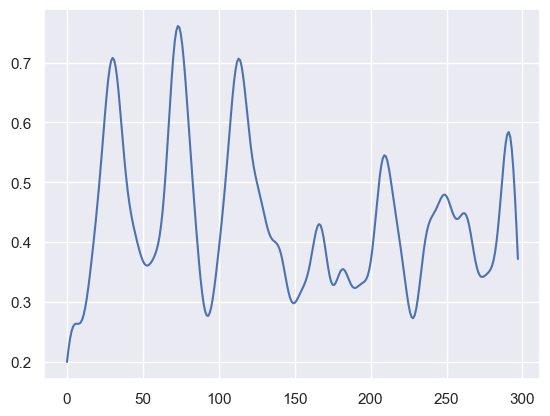

[2730, 4450, 6050]
[7501]
14973
cuda
epoch 1,loss = 1.00826263
epoch 2,loss = 1.00791931
epoch 3,loss = 1.00758195
epoch 4,loss = 1.00725055
epoch 5,loss = 1.00692546
epoch 6,loss = 1.00660658
epoch 7,loss = 1.00629413
epoch 8,loss = 1.00598788
epoch 9,loss = 1.00568795
epoch 10,loss = 1.00539458
epoch 11,loss = 1.00510764
epoch 12,loss = 1.00482714
epoch 13,loss = 1.00455296
epoch 14,loss = 1.00428534
epoch 15,loss = 1.00402403
epoch 16,loss = 1.00376916
epoch 17,loss = 1.00352061
epoch 18,loss = 1.00327826
epoch 19,loss = 1.00304222
epoch 20,loss = 1.00281227
epoch 21,loss = 1.00258851
epoch 22,loss = 1.00237060
epoch 23,loss = 1.00215876
epoch 24,loss = 1.00195265
epoch 25,loss = 1.00175238
epoch 26,loss = 1.00155783
epoch 27,loss = 1.00136888
epoch 28,loss = 1.00118554
epoch 29,loss = 1.00100768
epoch 30,loss = 1.00083518
epoch 31,loss = 1.00066817
epoch 32,loss = 1.00050628
epoch 33,loss = 1.00034988
epoch 34,loss = 1.00019848
epoch 35,loss = 1.00005233


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 36,loss = 0.99991107
epoch 37,loss = 0.99977475
epoch 38,loss = 0.99964339
epoch 39,loss = 0.99951673
epoch 40,loss = 0.99939495
epoch 41,loss = 0.99927765
epoch 42,loss = 0.99916500
epoch 43,loss = 0.99905670
epoch 44,loss = 0.99895275
epoch 45,loss = 0.99885309
epoch 46,loss = 0.99875766
epoch 47,loss = 0.99866623
epoch 48,loss = 0.99857873
epoch 49,loss = 0.99849522
epoch 50,loss = 0.99841547
epoch 51,loss = 0.99833924
epoch 52,loss = 0.99826676
epoch 53,loss = 0.99819767
epoch 54,loss = 0.99813169
epoch 55,loss = 0.99806935
epoch 56,loss = 0.99801010
epoch 57,loss = 0.99795383
epoch 58,loss = 0.99790049
epoch 59,loss = 0.99785006
epoch 60,loss = 0.99780244
epoch 61,loss = 0.99775749
epoch 62,loss = 0.99771494
epoch 63,loss = 0.99767494
epoch 64,loss = 0.99763733
epoch 65,loss = 0.99760205
epoch 66,loss = 0.99756891
epoch 67,loss = 0.99753779
epoch 68,loss = 0.99750859
epoch 69,loss = 0.99748141
epoch 70,loss = 0.99745601
epoch 71,loss = 0.99743235
epoch 72,loss = 0.99741030
e

epoch 331,loss = 0.99715912
epoch 332,loss = 0.99715912
epoch 333,loss = 0.99715912
epoch 334,loss = 0.99715912
epoch 335,loss = 0.99715906
epoch 336,loss = 0.99715906
epoch 337,loss = 0.99715906
epoch 338,loss = 0.99715894
epoch 339,loss = 0.99715894
epoch 340,loss = 0.99715894
epoch 341,loss = 0.99715894
epoch 342,loss = 0.99715894
epoch 343,loss = 0.99715883
epoch 344,loss = 0.99715883
epoch 345,loss = 0.99715883
epoch 346,loss = 0.99715894
epoch 347,loss = 0.99715871
epoch 348,loss = 0.99715871
epoch 349,loss = 0.99715871
epoch 350,loss = 0.99715871
epoch 351,loss = 0.99715871
epoch 352,loss = 0.99715871
epoch 353,loss = 0.99715871
epoch 354,loss = 0.99715871
epoch 355,loss = 0.99715871
epoch 356,loss = 0.99715865
epoch 357,loss = 0.99715865
epoch 358,loss = 0.99715853
epoch 359,loss = 0.99715853
epoch 360,loss = 0.99715853
epoch 361,loss = 0.99715853
epoch 362,loss = 0.99715853
epoch 363,loss = 0.99715853
epoch 364,loss = 0.99715853
epoch 365,loss = 0.99715853
epoch 366,loss = 0.9

epoch 642,loss = 0.58335716
epoch 643,loss = 0.58130616
epoch 644,loss = 0.57889324
epoch 645,loss = 0.57647079
epoch 646,loss = 0.57436496
epoch 647,loss = 0.57281303
epoch 648,loss = 0.57192141
epoch 649,loss = 0.57165211
epoch 650,loss = 0.57183248
epoch 651,loss = 0.57220674
epoch 652,loss = 0.57250988
epoch 653,loss = 0.57254261
epoch 654,loss = 0.57221878
epoch 655,loss = 0.57157016
epoch 656,loss = 0.57071579
epoch 657,loss = 0.56981009
epoch 658,loss = 0.56899554
epoch 659,loss = 0.56836832
epoch 660,loss = 0.56796324
epoch 661,loss = 0.56776023
epoch 662,loss = 0.56770217
epoch 663,loss = 0.56771761
epoch 664,loss = 0.56773871
epoch 665,loss = 0.56771469
epoch 666,loss = 0.56761843
epoch 667,loss = 0.56744701
epoch 668,loss = 0.56721663
epoch 669,loss = 0.56695551
epoch 670,loss = 0.56669521
epoch 671,loss = 0.56646258
epoch 672,loss = 0.56627440
epoch 673,loss = 0.56613553
epoch 674,loss = 0.56603891
epoch 675,loss = 0.56596923
epoch 676,loss = 0.56590742
epoch 677,loss = 0.5

epoch 949,loss = 0.54706138
epoch 950,loss = 0.54702801
epoch 951,loss = 0.54699469
epoch 952,loss = 0.54696149
epoch 953,loss = 0.54692835
epoch 954,loss = 0.54689538
epoch 955,loss = 0.54686254
epoch 956,loss = 0.54682982
epoch 957,loss = 0.54679716
epoch 958,loss = 0.54676455
epoch 959,loss = 0.54673207
epoch 960,loss = 0.54669976
epoch 961,loss = 0.54666752
epoch 962,loss = 0.54663527
epoch 963,loss = 0.54660326
epoch 964,loss = 0.54657125
epoch 965,loss = 0.54653937
epoch 966,loss = 0.54650760
epoch 967,loss = 0.54647589
epoch 968,loss = 0.54644412
epoch 969,loss = 0.54641253
epoch 970,loss = 0.54638106
epoch 971,loss = 0.54634964
epoch 972,loss = 0.54631835
epoch 973,loss = 0.54628706
epoch 974,loss = 0.54625601
epoch 975,loss = 0.54622495
epoch 976,loss = 0.54619402
epoch 977,loss = 0.54616308
epoch 978,loss = 0.54613233
epoch 979,loss = 0.54610163
epoch 980,loss = 0.54607099
epoch 981,loss = 0.54604042
epoch 982,loss = 0.54600996
epoch 983,loss = 0.54597950
epoch 984,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([372, 1, 100])
1.0
Epoch 200:   loss= 0.18764  cluster difference= 1.0
Epoch 400:   loss= 0.18623  cluster difference= 0.002688172043010753
[0 7 1 2 4 3 1 2 4 3 1 5 6 3 1 5 6 3 1 5 6 0 7 1 2 0 7 1 2 4 3 1 2 4 3 1 5
 4 3 1 5 6 3 1 5 6 0 7 1 2 0 7 1 2 0 7 1 2 4 3 1 2 4 3 1 5 6 3 7 5 6 0 7 1
 2 0 7 1 2 0 7 1 2 4 3 1 2 4 3 1 5 6 3 7 5 6 0 7 1 2 0 7 1 2 0 7 1 2 4 3 1
 2 4 3 1 5 4 3 7 5 6 0 7 1 6 0 7 1 2 0 7 1 2 4 7 1 2 4 3 1 5 4 3 7 5 6 0 7
 5 6 0 7 1 2 0 7 1 2 4 7 1 2 4 3 1 5 4 3 1 5 6 0 7 5 6 0 7 1 2 0 7 1 2 0 7
 1 2 0 7 5 6 0 7 5 6 0 3 1 6 4 3 1 2 4 3 1 2 4 3 1 5 4 3 7 5 6 0 7 5 6 0 7
 5 6 0 3 1 6 0 3 1 2 4 3 1 2 4 3 1 5 4 3 1 5 6 3 7 5 6 0 7 5 6 0 7 1 6 0 7
 1 2 4 7 1 2 4 3 1 2 4 3 1 5 4 3 7 5 6 0 7 5 6 0 7 1 6 0 7 1 2 0 7 1 2 4 3
 1 2 4 3 1 2 4 3 7 5 4 0 7 5 6 0 7 5 6 0 7 1 2 0 7 1 2 0 7 1 2 4 3 1 2 4 3
 1 2 4 0 7 5 6 0 7 5 6 0 7 1 6 0 7 1 2 0 7 1 2 4 3 1 2 4 3 1 2 4 3 7 5 6 3
 7 5]


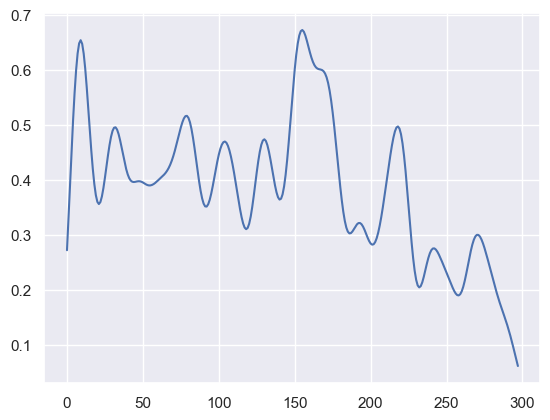

[1890, 7730]
[7501]
14973
cuda
epoch 1,loss = 0.99248254
epoch 2,loss = 0.99228328
epoch 3,loss = 0.99208909
epoch 4,loss = 0.99190021
epoch 5,loss = 0.99171656
epoch 6,loss = 0.99153835
epoch 7,loss = 0.99136549
epoch 8,loss = 0.99119830
epoch 9,loss = 0.99103683
epoch 10,loss = 0.99088091
epoch 11,loss = 0.99073040
epoch 12,loss = 0.99058563
epoch 13,loss = 0.99044627
epoch 14,loss = 0.99031210
epoch 15,loss = 0.99018341
epoch 16,loss = 0.99005997
epoch 17,loss = 0.98994088
epoch 18,loss = 0.98982608
epoch 19,loss = 0.98971540
epoch 20,loss = 0.98960811
epoch 21,loss = 0.98950309
epoch 22,loss = 0.98940039
epoch 23,loss = 0.98930067
epoch 24,loss = 0.98920292
epoch 25,loss = 0.98910648
epoch 26,loss = 0.98901039
epoch 27,loss = 0.98891443
epoch 28,loss = 0.98881805
epoch 29,loss = 0.98872036
epoch 30,loss = 0.98862165
epoch 31,loss = 0.98851985
epoch 32,loss = 0.98841375
epoch 33,loss = 0.98830223
epoch 34,loss = 0.98818535
epoch 35,loss = 0.98806429
epoch 36,loss = 0.98793817
epoch 

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 44,loss = 0.98676413
epoch 45,loss = 0.98660743
epoch 46,loss = 0.98644888
epoch 47,loss = 0.98628509
epoch 48,loss = 0.98610759
epoch 49,loss = 0.98590744
epoch 50,loss = 0.98567826
epoch 51,loss = 0.98541737
epoch 52,loss = 0.98512387
epoch 53,loss = 0.98479861
epoch 54,loss = 0.98444033
epoch 55,loss = 0.98404992
epoch 56,loss = 0.98362774
epoch 57,loss = 0.98317468
epoch 58,loss = 0.98268902
epoch 59,loss = 0.98217016
epoch 60,loss = 0.98161656
epoch 61,loss = 0.98102760
epoch 62,loss = 0.98040092
epoch 63,loss = 0.97973537
epoch 64,loss = 0.97902745
epoch 65,loss = 0.97827768
epoch 66,loss = 0.97748286
epoch 67,loss = 0.97664148
epoch 68,loss = 0.97575414
epoch 69,loss = 0.97481686
epoch 70,loss = 0.97382772
epoch 71,loss = 0.97278601
epoch 72,loss = 0.97169501
epoch 73,loss = 0.97055024
epoch 74,loss = 0.96934557
epoch 75,loss = 0.96807986
epoch 76,loss = 0.96675968
epoch 77,loss = 0.96538317
epoch 78,loss = 0.96394634
epoch 79,loss = 0.96245074
epoch 80,loss = 0.96089709
e

epoch 352,loss = 0.35725817
epoch 353,loss = 0.35719877
epoch 354,loss = 0.35713953
epoch 355,loss = 0.35708043
epoch 356,loss = 0.35702142
epoch 357,loss = 0.35696137
epoch 358,loss = 0.35690096
epoch 359,loss = 0.35684046
epoch 360,loss = 0.35678005
epoch 361,loss = 0.35671991
epoch 362,loss = 0.35666001
epoch 363,loss = 0.35660046
epoch 364,loss = 0.35654125
epoch 365,loss = 0.35648239
epoch 366,loss = 0.35642383
epoch 367,loss = 0.35636562
epoch 368,loss = 0.35630816
epoch 369,loss = 0.35625127
epoch 370,loss = 0.35619465
epoch 371,loss = 0.35613832
epoch 372,loss = 0.35608214
epoch 373,loss = 0.35602611
epoch 374,loss = 0.35597023
epoch 375,loss = 0.35591415
epoch 376,loss = 0.35585779
epoch 377,loss = 0.35580131
epoch 378,loss = 0.35574213
epoch 379,loss = 0.35568258
epoch 380,loss = 0.35562268
epoch 381,loss = 0.35556248
epoch 382,loss = 0.35550088
epoch 383,loss = 0.35543850
epoch 384,loss = 0.35537586
epoch 385,loss = 0.35531306
epoch 386,loss = 0.35525012
epoch 387,loss = 0.3

epoch 659,loss = 0.32475644
epoch 660,loss = 0.32457587
epoch 661,loss = 0.32439908
epoch 662,loss = 0.32422253
epoch 663,loss = 0.32404706
epoch 664,loss = 0.32387885
epoch 665,loss = 0.32371098
epoch 666,loss = 0.32354021
epoch 667,loss = 0.32337061
epoch 668,loss = 0.32320002
epoch 669,loss = 0.32302645
epoch 670,loss = 0.32284999
epoch 671,loss = 0.32267261
epoch 672,loss = 0.32248697
epoch 673,loss = 0.32229635
epoch 674,loss = 0.32210276
epoch 675,loss = 0.32190457
epoch 676,loss = 0.32170027
epoch 677,loss = 0.32150266
epoch 678,loss = 0.32130402
epoch 679,loss = 0.32110190
epoch 680,loss = 0.32089648
epoch 681,loss = 0.32068548
epoch 682,loss = 0.32047200
epoch 683,loss = 0.32025522
epoch 684,loss = 0.32003251
epoch 685,loss = 0.31980625
epoch 686,loss = 0.31956857
epoch 687,loss = 0.31932995
epoch 688,loss = 0.31908581
epoch 689,loss = 0.31884146
epoch 690,loss = 0.31859773
epoch 691,loss = 0.31835532
epoch 692,loss = 0.31810883
epoch 693,loss = 0.31785870
epoch 694,loss = 0.3

epoch 956,loss = 0.25639185
epoch 957,loss = 0.25626361
epoch 958,loss = 0.25613523
epoch 959,loss = 0.25600439
epoch 960,loss = 0.25587407
epoch 961,loss = 0.25574428
epoch 962,loss = 0.25561357
epoch 963,loss = 0.25548226
epoch 964,loss = 0.25535199
epoch 965,loss = 0.25521964
epoch 966,loss = 0.25508595
epoch 967,loss = 0.25495201
epoch 968,loss = 0.25481814
epoch 969,loss = 0.25468487
epoch 970,loss = 0.25455076
epoch 971,loss = 0.25441575
epoch 972,loss = 0.25428030
epoch 973,loss = 0.25414437
epoch 974,loss = 0.25400814
epoch 975,loss = 0.25387242
epoch 976,loss = 0.25373697
epoch 977,loss = 0.25360122
epoch 978,loss = 0.25346610
epoch 979,loss = 0.25333139
epoch 980,loss = 0.25319731
epoch 981,loss = 0.25306398
epoch 982,loss = 0.25293124
epoch 983,loss = 0.25279909
epoch 984,loss = 0.25266811
epoch 985,loss = 0.25253811
epoch 986,loss = 0.25240824
epoch 987,loss = 0.25227776
epoch 988,loss = 0.25214645
epoch 989,loss = 0.25201496
epoch 990,loss = 0.25188386
epoch 991,loss = 0.2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([372, 1, 100])
1.0
Epoch 200:   loss= 0.15719  cluster difference= 1.0
Epoch 400:   loss= 0.15551  cluster difference= 0.013440860215053764
Epoch 600:   loss= 0.15466  cluster difference= 0.010752688172043012
Epoch 800:   loss= 0.1541  cluster difference= 0.002688172043010753
[1 4 4 4 4 4 4 4 1 1 1 4 1 2 1 4 5 1 1 4 2 3 1 4 2 3 1 4 4 1 4 4 4 4 4 4 4
 1 2 1 4 1 1 1 4 2 3 1 4 2 3 1 4 2 3 4 4 4 1 4 4 4 4 4 4 4 1 2 1 4 5 1 1 4
 2 3 1 4 2 3 1 4 2 1 4 4 4 4 4 4 4 4 1 1 4 1 2 1 4 2 3 1 4 2 3 1 4 2 3 1 4
 4 1 4 4 4 4 4 4 4 1 2 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 3 4 4 4 4 4 4 4 4 4 4
 4 4 2 1 4 2 3 1 4 2 3 1 4 2 3 1 4 2 1 4 4 4 4 4 4 4 4 1 1 4 2 3 1 4 2 3 1
 4 6 7 2 3 5 1 4 4 4 1 4 4 4 4 1 4 2 3 5 1 1 2 5 4 2 3 5 1 2 2 2 3 4 1 1 4
 4 4 4 4 4 2 2 3 2 1 4 5 2 3 5 1 4 2 3 2 3 0 5 5 1 4 2 3 1 4 4 4 4 1 0 5 1
 1 0 5 1 4 4 6 7 2 3 5 4 1 0 5 2 1 2 1 1 4 4 4 4 2 3 5 2 3 4 0 5 1 1 2 3 5
 3 2 5 1 4 2 3 4 4 4 4 4 4 4 2 1 2 1 5 2 5 4 2 3 1 4 2 3 5 4 2 3 1 4 2 1 4
 4 4 4 4 0 5 0 5 3 4 2 3 3 1 2 3 1 4 

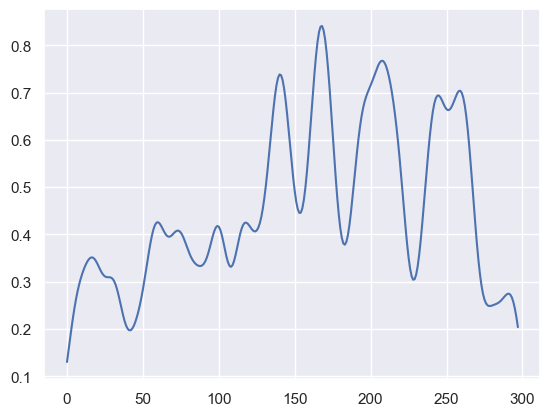

[8250, 9850, 11890]
[7501]
7682
cuda
epoch 1,loss = 1.01337647
epoch 2,loss = 1.01300132
epoch 3,loss = 1.01263225
epoch 4,loss = 1.01226878
epoch 5,loss = 1.01191139
epoch 6,loss = 1.01156008
epoch 7,loss = 1.01121497
epoch 8,loss = 1.01087606
epoch 9,loss = 1.01054335
epoch 10,loss = 1.01021695
epoch 11,loss = 1.00989687
epoch 12,loss = 1.00958335
epoch 13,loss = 1.00927615
epoch 14,loss = 1.00897551
epoch 15,loss = 1.00868118
epoch 16,loss = 1.00839353
epoch 17,loss = 1.00811243
epoch 18,loss = 1.00783789
epoch 19,loss = 1.00756967
epoch 20,loss = 1.00730801
epoch 21,loss = 1.00705290
epoch 22,loss = 1.00680435
epoch 23,loss = 1.00656188
epoch 24,loss = 1.00632608
epoch 25,loss = 1.00609672
epoch 26,loss = 1.00587320
epoch 27,loss = 1.00565636
epoch 28,loss = 1.00544560
epoch 29,loss = 1.00524080


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 30,loss = 1.00504220
epoch 31,loss = 1.00484943
epoch 32,loss = 1.00466263
epoch 33,loss = 1.00448167
epoch 34,loss = 1.00430644
epoch 35,loss = 1.00413680
epoch 36,loss = 1.00397265
epoch 37,loss = 1.00381398
epoch 38,loss = 1.00366056
epoch 39,loss = 1.00351250
epoch 40,loss = 1.00336957
epoch 41,loss = 1.00323141
epoch 42,loss = 1.00309837
epoch 43,loss = 1.00297010
epoch 44,loss = 1.00284648
epoch 45,loss = 1.00272739
epoch 46,loss = 1.00261283
epoch 47,loss = 1.00250244
epoch 48,loss = 1.00239646
epoch 49,loss = 1.00229454
epoch 50,loss = 1.00219643
epoch 51,loss = 1.00210238
epoch 52,loss = 1.00201190
epoch 53,loss = 1.00192523
epoch 54,loss = 1.00184190
epoch 55,loss = 1.00176203
epoch 56,loss = 1.00168538
epoch 57,loss = 1.00161207
epoch 58,loss = 1.00154173
epoch 59,loss = 1.00147426
epoch 60,loss = 1.00140965
epoch 61,loss = 1.00134802
epoch 62,loss = 1.00128627
epoch 63,loss = 1.00122631
epoch 64,loss = 1.00116348
epoch 65,loss = 1.00110209
epoch 66,loss = 1.00104201
e

epoch 334,loss = 0.99980265
epoch 335,loss = 0.99980241
epoch 336,loss = 0.99980211
epoch 337,loss = 0.99980152
epoch 338,loss = 0.99980152
epoch 339,loss = 0.99980175
epoch 340,loss = 0.99980152
epoch 341,loss = 0.99980110
epoch 342,loss = 0.99980104
epoch 343,loss = 0.99980104
epoch 344,loss = 0.99980080
epoch 345,loss = 0.99980062
epoch 346,loss = 0.99980050
epoch 347,loss = 0.99980038
epoch 348,loss = 0.99980021
epoch 349,loss = 0.99980009
epoch 350,loss = 0.99979997
epoch 351,loss = 0.99979979
epoch 352,loss = 0.99979967
epoch 353,loss = 0.99979961
epoch 354,loss = 0.99979937
epoch 355,loss = 0.99979919
epoch 356,loss = 0.99979961
epoch 357,loss = 0.99979961
epoch 358,loss = 0.99979937
epoch 359,loss = 0.99979895
epoch 360,loss = 0.99979866
epoch 361,loss = 0.99979877
epoch 362,loss = 0.99979824
epoch 363,loss = 0.99979836
epoch 364,loss = 0.99979806
epoch 365,loss = 0.99979806
epoch 366,loss = 0.99979788
epoch 367,loss = 0.99979776
epoch 368,loss = 0.99979752
epoch 369,loss = 0.9

epoch 655,loss = 0.73718607
epoch 656,loss = 0.73633283
epoch 657,loss = 0.73562640
epoch 658,loss = 0.73505384
epoch 659,loss = 0.73460132
epoch 660,loss = 0.73425460
epoch 661,loss = 0.73399878
epoch 662,loss = 0.73381770
epoch 663,loss = 0.73369664
epoch 664,loss = 0.73362094
epoch 665,loss = 0.73357558
epoch 666,loss = 0.73354882
epoch 667,loss = 0.73352838
epoch 668,loss = 0.73350507
epoch 669,loss = 0.73347080
epoch 670,loss = 0.73342204
epoch 671,loss = 0.73335642
epoch 672,loss = 0.73327231
epoch 673,loss = 0.73316991
epoch 674,loss = 0.73305058
epoch 675,loss = 0.73291689
epoch 676,loss = 0.73277277
epoch 677,loss = 0.73262191
epoch 678,loss = 0.73246652
epoch 679,loss = 0.73230880
epoch 680,loss = 0.73215157
epoch 681,loss = 0.73199809
epoch 682,loss = 0.73184949
epoch 683,loss = 0.73170739
epoch 684,loss = 0.73157334
epoch 685,loss = 0.73144805
epoch 686,loss = 0.73133248
epoch 687,loss = 0.73122591
epoch 688,loss = 0.73112845
epoch 689,loss = 0.73103982
epoch 690,loss = 0.7

epoch 973,loss = 0.67823827
epoch 974,loss = 0.67798883
epoch 975,loss = 0.67774254
epoch 976,loss = 0.67749220
epoch 977,loss = 0.67724305
epoch 978,loss = 0.67699832
epoch 979,loss = 0.67674559
epoch 980,loss = 0.67649692
epoch 981,loss = 0.67624527
epoch 982,loss = 0.67599732
epoch 983,loss = 0.67575496
epoch 984,loss = 0.67551643
epoch 985,loss = 0.67528158
epoch 986,loss = 0.67505199
epoch 987,loss = 0.67482108
epoch 988,loss = 0.67458868
epoch 989,loss = 0.67435718
epoch 990,loss = 0.67412484
epoch 991,loss = 0.67389327
epoch 992,loss = 0.67366713
epoch 993,loss = 0.67344230
epoch 994,loss = 0.67321527
epoch 995,loss = 0.67299020
epoch 996,loss = 0.67276758
epoch 997,loss = 0.67254454
epoch 998,loss = 0.67231977
epoch 999,loss = 0.67209721
epoch 1000,loss = 0.67187613
epoch 1001,loss = 0.67165512
epoch 1002,loss = 0.67143482
epoch 1003,loss = 0.67121279
epoch 1004,loss = 0.67098933
epoch 1005,loss = 0.67076302
epoch 1006,loss = 0.67053604
epoch 1007,loss = 0.67030865
epoch 1008,l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([958, 1, 20])
1.0
Epoch 200:   loss= 0.19365  cluster difference= 1.0
Epoch 400:   loss= 0.19263  cluster difference= 0.032359081419624215
Epoch 600:   loss= 0.19167  cluster difference= 0.008350730688935281
[6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 6 7 6 6 7 6 6 7
 6 6 7 6 6 7 6 6 6 6 6 6 6 6 7 0 6 5 0 6 5 0 6 5 0 6 5 0 6 6 6 6 6 6 6 5 0
 7 5 3 7 5 3 7 5 0 6 5 0 6 6 6 6 6 6 6 5 3 7 5 3 7 5 3 7 5 3 7 5 3 6 6 6 6
 6 6 7 5 3 7 5 3 7 5 3 7 5 3 7 5 3 6 6 6 6 6 6 6 5 3 7 5 3 7 4 3 7 5 3 7 5
 3 6 6 6 6 6 6 6 5 3 7 5 3 7 5 3 7 5 3 7 5 3 6 6 6 6 6 6 7 5 3 7 5 3 7 5 3
 7 5 3 7 5 3 6 6 6 6 6 6 7 4 3 7 5 3 7 5 3 7 5 3 7 5 3 6 7 6 6 6 6 7 5 3 7
 5 3 6 6 6 7 5 3 7 5 3 6 7 6 6 6 6 7 4 3 7 4 1 7 4 1 7 4 1 7 4 1 7 5 0 6 6
 6 7 4 1 7 4 3 7 4 1 7 4 1 7 4 3 6 7 0 6 6 6 7 4 1 7 4 1 7 4 1 7 4 1 7 4 1
 7 5 3 6 6 6 7 4 1 7 4 1 7 4 1 7 4 1 7 4 1 7 5 3 6 6 7 7 4 1 7 4 1 7 4 1 7
 4 1 6 7 0 6 7 0 6 6 7 7 4 1 7 4 1 7 4 1 2 4 1 7 4 1 7 5 3 6 7 0 7 4 1 7 4
 1 7 4 1 7 4 1 7 4 1 6 7 0 6 7 

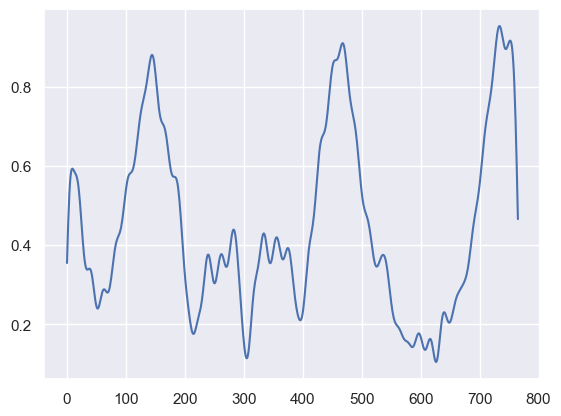

[1930, 4522, 6650]
[4500]
17521
cuda
epoch 1,loss = 1.00008023
epoch 2,loss = 0.99987656
epoch 3,loss = 0.99970138
epoch 4,loss = 0.99959046
epoch 5,loss = 0.99951124
epoch 6,loss = 0.99944556
epoch 7,loss = 0.99938756
epoch 8,loss = 0.99933505
epoch 9,loss = 0.99928558


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 10,loss = 0.99923766
epoch 11,loss = 0.99918979
epoch 12,loss = 0.99914140
epoch 13,loss = 0.99909186
epoch 14,loss = 0.99904060
epoch 15,loss = 0.99898726
epoch 16,loss = 0.99893188
epoch 17,loss = 0.99887437
epoch 18,loss = 0.99881446
epoch 19,loss = 0.99875224
epoch 20,loss = 0.99868774
epoch 21,loss = 0.99862087
epoch 22,loss = 0.99855179
epoch 23,loss = 0.99848080
epoch 24,loss = 0.99840748
epoch 25,loss = 0.99833167
epoch 26,loss = 0.99825335
epoch 27,loss = 0.99817234
epoch 28,loss = 0.99808741
epoch 29,loss = 0.99799776
epoch 30,loss = 0.99790221
epoch 31,loss = 0.99779755
epoch 32,loss = 0.99768108
epoch 33,loss = 0.99755353
epoch 34,loss = 0.99741530
epoch 35,loss = 0.99726331
epoch 36,loss = 0.99709684
epoch 37,loss = 0.99691582
epoch 38,loss = 0.99672806
epoch 39,loss = 0.99654031
epoch 40,loss = 0.99635237
epoch 41,loss = 0.99616987
epoch 42,loss = 0.99599499
epoch 43,loss = 0.99582404
epoch 44,loss = 0.99565578
epoch 45,loss = 0.99549514
epoch 46,loss = 0.99532455
e

epoch 329,loss = 0.53889793
epoch 330,loss = 0.53848487
epoch 331,loss = 0.53807640
epoch 332,loss = 0.53767306
epoch 333,loss = 0.53727466
epoch 334,loss = 0.53688157
epoch 335,loss = 0.53649396
epoch 336,loss = 0.53611141
epoch 337,loss = 0.53573453
epoch 338,loss = 0.53536308
epoch 339,loss = 0.53499657
epoch 340,loss = 0.53463507
epoch 341,loss = 0.53427804
epoch 342,loss = 0.53392559
epoch 343,loss = 0.53357762
epoch 344,loss = 0.53323472
epoch 345,loss = 0.53289646
epoch 346,loss = 0.53256226
epoch 347,loss = 0.53223288
epoch 348,loss = 0.53190804
epoch 349,loss = 0.53158766
epoch 350,loss = 0.53127217
epoch 351,loss = 0.53096056
epoch 352,loss = 0.53065354
epoch 353,loss = 0.53035069
epoch 354,loss = 0.53005189
epoch 355,loss = 0.52975702
epoch 356,loss = 0.52946538
epoch 357,loss = 0.52917749
epoch 358,loss = 0.52889413
epoch 359,loss = 0.52861577
epoch 360,loss = 0.52834165
epoch 361,loss = 0.52807117
epoch 362,loss = 0.52780443
epoch 363,loss = 0.52754110
epoch 364,loss = 0.5

epoch 634,loss = 0.49555707
epoch 635,loss = 0.49544257
epoch 636,loss = 0.49532598
epoch 637,loss = 0.49520838
epoch 638,loss = 0.49508879
epoch 639,loss = 0.49497047
epoch 640,loss = 0.49485284
epoch 641,loss = 0.49473816
epoch 642,loss = 0.49462548
epoch 643,loss = 0.49451438
epoch 644,loss = 0.49440607
epoch 645,loss = 0.49429995
epoch 646,loss = 0.49419692
epoch 647,loss = 0.49409544
epoch 648,loss = 0.49399364
epoch 649,loss = 0.49389222
epoch 650,loss = 0.49379238
epoch 651,loss = 0.49369383
epoch 652,loss = 0.49359578
epoch 653,loss = 0.49349797
epoch 654,loss = 0.49340171
epoch 655,loss = 0.49330673
epoch 656,loss = 0.49321264
epoch 657,loss = 0.49311978
epoch 658,loss = 0.49302804
epoch 659,loss = 0.49293733
epoch 660,loss = 0.49284729
epoch 661,loss = 0.49275696
epoch 662,loss = 0.49266538
epoch 663,loss = 0.49257326
epoch 664,loss = 0.49248105
epoch 665,loss = 0.49238861
epoch 666,loss = 0.49229592
epoch 667,loss = 0.49220374
epoch 668,loss = 0.49211168
epoch 669,loss = 0.4

epoch 931,loss = 0.47222826
epoch 932,loss = 0.47216606
epoch 933,loss = 0.47210398
epoch 934,loss = 0.47204190
epoch 935,loss = 0.47197989
epoch 936,loss = 0.47191796
epoch 937,loss = 0.47185621
epoch 938,loss = 0.47179446
epoch 939,loss = 0.47173238
epoch 940,loss = 0.47167039
epoch 941,loss = 0.47160807
epoch 942,loss = 0.47154561
epoch 943,loss = 0.47148311
epoch 944,loss = 0.47142044
epoch 945,loss = 0.47135773
epoch 946,loss = 0.47129506
epoch 947,loss = 0.47123247
epoch 948,loss = 0.47117001
epoch 949,loss = 0.47110760
epoch 950,loss = 0.47104526
epoch 951,loss = 0.47098291
epoch 952,loss = 0.47092068
epoch 953,loss = 0.47085842
epoch 954,loss = 0.47079578
epoch 955,loss = 0.47073308
epoch 956,loss = 0.47067025
epoch 957,loss = 0.47060743
epoch 958,loss = 0.47054470
epoch 959,loss = 0.47048199
epoch 960,loss = 0.47041896
epoch 961,loss = 0.47035590
epoch 962,loss = 0.47029287
epoch 963,loss = 0.47022998
epoch 964,loss = 0.47016725
epoch 965,loss = 0.47010469
epoch 966,loss = 0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


torch.Size([1458, 1, 30])
1.0
Epoch 200:   loss= 0.18173  cluster difference= 1.0
Epoch 400:   loss= 0.18744  cluster difference= 0.07544581618655692
Epoch 600:   loss= 0.19182  cluster difference= 0.03772290809327846
Epoch 800:   loss= 0.19444  cluster difference= 0.02194787379972565
Epoch 1000:   loss= 0.19579  cluster difference= 0.0205761316872428
Epoch 1200:   loss= 0.1966  cluster difference= 0.0205761316872428
Epoch 1400:   loss= 0.19727  cluster difference= 0.01783264746227709
Epoch 1600:   loss= 0.19789  cluster difference= 0.019890260631001373
Epoch 1800:   loss= 0.19839  cluster difference= 0.0075445816186556925
[6 1 2 ... 5 5 4]


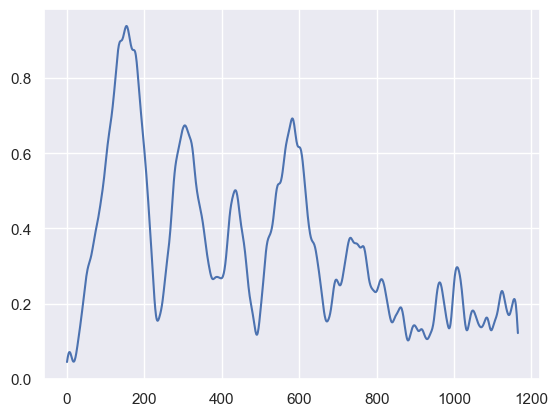

[3615, 5415, 8751]
[10000]
17521
cuda
epoch 1,loss = 1.00006068
epoch 2,loss = 1.00002301
epoch 3,loss = 0.99998534
epoch 4,loss = 0.99994785
epoch 5,loss = 0.99991053
epoch 6,loss = 0.99987334
epoch 7,loss = 0.99983650
epoch 8,loss = 0.99979979
epoch 9,loss = 0.99976313
epoch 10,loss = 0.99972653
epoch 11,loss = 0.99969012


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 12,loss = 0.99965334
epoch 13,loss = 0.99961668
epoch 14,loss = 0.99957979
epoch 15,loss = 0.99954277
epoch 16,loss = 0.99950540
epoch 17,loss = 0.99946755
epoch 18,loss = 0.99942935
epoch 19,loss = 0.99939060
epoch 20,loss = 0.99935102
epoch 21,loss = 0.99931085
epoch 22,loss = 0.99926966
epoch 23,loss = 0.99922752
epoch 24,loss = 0.99918425
epoch 25,loss = 0.99913961
epoch 26,loss = 0.99909371
epoch 27,loss = 0.99904621
epoch 28,loss = 0.99899709
epoch 29,loss = 0.99894607
epoch 30,loss = 0.99889314
epoch 31,loss = 0.99883819
epoch 32,loss = 0.99878079
epoch 33,loss = 0.99872112
epoch 34,loss = 0.99865878
epoch 35,loss = 0.99859363
epoch 36,loss = 0.99852538
epoch 37,loss = 0.99845392
epoch 38,loss = 0.99837911
epoch 39,loss = 0.99830067
epoch 40,loss = 0.99821836
epoch 41,loss = 0.99813187
epoch 42,loss = 0.99804097
epoch 43,loss = 0.99794531
epoch 44,loss = 0.99784476
epoch 45,loss = 0.99773878
epoch 46,loss = 0.99762714
epoch 47,loss = 0.99750954
epoch 48,loss = 0.99738526
e

epoch 312,loss = 0.51462549
epoch 313,loss = 0.51412714
epoch 314,loss = 0.51362890
epoch 315,loss = 0.51313150
epoch 316,loss = 0.51263720
epoch 317,loss = 0.51214683
epoch 318,loss = 0.51166123
epoch 319,loss = 0.51117623
epoch 320,loss = 0.51069397
epoch 321,loss = 0.51021510
epoch 322,loss = 0.50973761
epoch 323,loss = 0.50925946
epoch 324,loss = 0.50878739
epoch 325,loss = 0.50831795
epoch 326,loss = 0.50785106
epoch 327,loss = 0.50738680
epoch 328,loss = 0.50692397
epoch 329,loss = 0.50646299
epoch 330,loss = 0.50600523
epoch 331,loss = 0.50555217
epoch 332,loss = 0.50510448
epoch 333,loss = 0.50466108
epoch 334,loss = 0.50422198
epoch 335,loss = 0.50378656
epoch 336,loss = 0.50335342
epoch 337,loss = 0.50292325
epoch 338,loss = 0.50249618
epoch 339,loss = 0.50207245
epoch 340,loss = 0.50165290
epoch 341,loss = 0.50123781
epoch 342,loss = 0.50082797
epoch 343,loss = 0.50042212
epoch 344,loss = 0.50001949
epoch 345,loss = 0.49962115
epoch 346,loss = 0.49922892
epoch 347,loss = 0.4

epoch 608,loss = 0.43805322
epoch 609,loss = 0.43788290
epoch 610,loss = 0.43771389
epoch 611,loss = 0.43754607
epoch 612,loss = 0.43737909
epoch 613,loss = 0.43721208
epoch 614,loss = 0.43704632
epoch 615,loss = 0.43688262
epoch 616,loss = 0.43671992
epoch 617,loss = 0.43655828
epoch 618,loss = 0.43639752
epoch 619,loss = 0.43623751
epoch 620,loss = 0.43607828
epoch 621,loss = 0.43591964
epoch 622,loss = 0.43576255
epoch 623,loss = 0.43560591
epoch 624,loss = 0.43545008
epoch 625,loss = 0.43529534
epoch 626,loss = 0.43514076
epoch 627,loss = 0.43498558
epoch 628,loss = 0.43483081
epoch 629,loss = 0.43467641
epoch 630,loss = 0.43452325
epoch 631,loss = 0.43437147
epoch 632,loss = 0.43421203
epoch 633,loss = 0.43405217
epoch 634,loss = 0.43389383
epoch 635,loss = 0.43373531
epoch 636,loss = 0.43357465
epoch 637,loss = 0.43341446
epoch 638,loss = 0.43325594
epoch 639,loss = 0.43309793
epoch 640,loss = 0.43293834
epoch 641,loss = 0.43277919
epoch 642,loss = 0.43261987
epoch 643,loss = 0.4

epoch 918,loss = 0.37865794
epoch 919,loss = 0.37853941
epoch 920,loss = 0.37842184
epoch 921,loss = 0.37830603
epoch 922,loss = 0.37819016
epoch 923,loss = 0.37807435
epoch 924,loss = 0.37795740
epoch 925,loss = 0.37784064
epoch 926,loss = 0.37772503
epoch 927,loss = 0.37761128
epoch 928,loss = 0.37749788
epoch 929,loss = 0.37738511
epoch 930,loss = 0.37727365
epoch 931,loss = 0.37716290
epoch 932,loss = 0.37705323
epoch 933,loss = 0.37694392
epoch 934,loss = 0.37683505
epoch 935,loss = 0.37672809
epoch 936,loss = 0.37662140
epoch 937,loss = 0.37651384
epoch 938,loss = 0.37640613
epoch 939,loss = 0.37629926
epoch 940,loss = 0.37619236
epoch 941,loss = 0.37608591
epoch 942,loss = 0.37597942
epoch 943,loss = 0.37587225
epoch 944,loss = 0.37576556
epoch 945,loss = 0.37565979
epoch 946,loss = 0.37555471
epoch 947,loss = 0.37544996
epoch 948,loss = 0.37534350
epoch 949,loss = 0.37523681
epoch 950,loss = 0.37513131
epoch 951,loss = 0.37502825
epoch 952,loss = 0.37492564
epoch 953,loss = 0.3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


torch.Size([1458, 1, 30])
1.0
Epoch 200:   loss= 0.13654  cluster difference= 1.0
Epoch 400:   loss= 0.1338  cluster difference= 0.0006858710562414266
[1 1 1 ... 1 2 1]


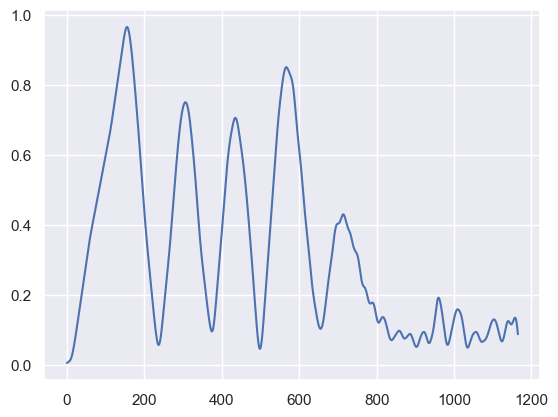

[3627, 5439, 8571]
[10000]
17521
cuda
epoch 1,loss = 1.00053060
epoch 2,loss = 1.00052142
epoch 3,loss = 1.00051224
epoch 4,loss = 1.00050318
epoch 5,loss = 1.00049424
epoch 6,loss = 1.00048518
epoch 7,loss = 1.00047624
epoch 8,loss = 1.00046742
epoch 9,loss = 1.00045848
epoch 10,loss = 1.00044978
epoch 11,loss = 1.00044096
epoch 12,loss = 1.00043237
epoch 13,loss = 1.00042379
epoch 14,loss = 1.00041521


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 15,loss = 1.00040674
epoch 16,loss = 1.00039816
epoch 17,loss = 1.00038970
epoch 18,loss = 1.00038147
epoch 19,loss = 1.00037324
epoch 20,loss = 1.00036514
epoch 21,loss = 1.00035691
epoch 22,loss = 1.00034869
epoch 23,loss = 1.00034082
epoch 24,loss = 1.00033271
epoch 25,loss = 1.00032485
epoch 26,loss = 1.00031698
epoch 27,loss = 1.00030923
epoch 28,loss = 1.00030160
epoch 29,loss = 1.00029397
epoch 30,loss = 1.00028634
epoch 31,loss = 1.00027895
epoch 32,loss = 1.00027144
epoch 33,loss = 1.00026405
epoch 34,loss = 1.00025666
epoch 35,loss = 1.00024939
epoch 36,loss = 1.00024223
epoch 37,loss = 1.00023520
epoch 38,loss = 1.00022805
epoch 39,loss = 1.00022113
epoch 40,loss = 1.00021410
epoch 41,loss = 1.00020742
epoch 42,loss = 1.00020051
epoch 43,loss = 1.00019383
epoch 44,loss = 1.00018716
epoch 45,loss = 1.00018048
epoch 46,loss = 1.00017393
epoch 47,loss = 1.00016749
epoch 48,loss = 1.00016105
epoch 49,loss = 1.00015473
epoch 50,loss = 1.00014842
epoch 51,loss = 1.00014234
e

epoch 330,loss = 0.60409266
epoch 331,loss = 0.60403574
epoch 332,loss = 0.60397923
epoch 333,loss = 0.60392314
epoch 334,loss = 0.60386747
epoch 335,loss = 0.60381222
epoch 336,loss = 0.60375738
epoch 337,loss = 0.60370296
epoch 338,loss = 0.60364896
epoch 339,loss = 0.60359532
epoch 340,loss = 0.60354203
epoch 341,loss = 0.60348928
epoch 342,loss = 0.60343683
epoch 343,loss = 0.60338485
epoch 344,loss = 0.60333306
epoch 345,loss = 0.60328162
epoch 346,loss = 0.60323054
epoch 347,loss = 0.60317981
epoch 348,loss = 0.60312939
epoch 349,loss = 0.60307938
epoch 350,loss = 0.60302955
epoch 351,loss = 0.60298008
epoch 352,loss = 0.60293084
epoch 353,loss = 0.60288191
epoch 354,loss = 0.60283327
epoch 355,loss = 0.60278499
epoch 356,loss = 0.60273689
epoch 357,loss = 0.60268903
epoch 358,loss = 0.60264140
epoch 359,loss = 0.60259396
epoch 360,loss = 0.60254681
epoch 361,loss = 0.60249984
epoch 362,loss = 0.60245311
epoch 363,loss = 0.60240668
epoch 364,loss = 0.60236043
epoch 365,loss = 0.6

epoch 652,loss = 0.59334189
epoch 653,loss = 0.59332651
epoch 654,loss = 0.59331113
epoch 655,loss = 0.59329569
epoch 656,loss = 0.59328032
epoch 657,loss = 0.59326488
epoch 658,loss = 0.59324932
epoch 659,loss = 0.59323382
epoch 660,loss = 0.59321839
epoch 661,loss = 0.59320283
epoch 662,loss = 0.59318727
epoch 663,loss = 0.59317172
epoch 664,loss = 0.59315628
epoch 665,loss = 0.59314078
epoch 666,loss = 0.59312528
epoch 667,loss = 0.59310979
epoch 668,loss = 0.59309423
epoch 669,loss = 0.59307867
epoch 670,loss = 0.59306318
epoch 671,loss = 0.59304762
epoch 672,loss = 0.59303206
epoch 673,loss = 0.59301662
epoch 674,loss = 0.59300119
epoch 675,loss = 0.59298569
epoch 676,loss = 0.59297025
epoch 677,loss = 0.59295470
epoch 678,loss = 0.59293914
epoch 679,loss = 0.59292358
epoch 680,loss = 0.59290802
epoch 681,loss = 0.59289247
epoch 682,loss = 0.59287697
epoch 683,loss = 0.59286147
epoch 684,loss = 0.59284586
epoch 685,loss = 0.59283024
epoch 686,loss = 0.59281456
epoch 687,loss = 0.5

epoch 984,loss = 0.46671462
epoch 985,loss = 0.46585068
epoch 986,loss = 0.46498418
epoch 987,loss = 0.46411800
epoch 988,loss = 0.46325409
epoch 989,loss = 0.46239257
epoch 990,loss = 0.46153182
epoch 991,loss = 0.46067306
epoch 992,loss = 0.45981839
epoch 993,loss = 0.45896402
epoch 994,loss = 0.45810953
epoch 995,loss = 0.45725718
epoch 996,loss = 0.45640585
epoch 997,loss = 0.45555878
epoch 998,loss = 0.45471469
epoch 999,loss = 0.45387188
epoch 1000,loss = 0.45302963
epoch 1001,loss = 0.45218816
epoch 1002,loss = 0.45134786
epoch 1003,loss = 0.45051092
epoch 1004,loss = 0.44967747
epoch 1005,loss = 0.44884542
epoch 1006,loss = 0.44801447
epoch 1007,loss = 0.44718426
epoch 1008,loss = 0.44635323
epoch 1009,loss = 0.44552487
epoch 1010,loss = 0.44470137
epoch 1011,loss = 0.44388172
epoch 1012,loss = 0.44306606
epoch 1013,loss = 0.44225198
epoch 1014,loss = 0.44143966
epoch 1015,loss = 0.44062987
epoch 1016,loss = 0.43982160
epoch 1017,loss = 0.43901473
epoch 1018,loss = 0.43821034
e

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


torch.Size([1458, 1, 30])
1.0
Epoch 200:   loss= 0.18441  cluster difference= 1.0
Epoch 400:   loss= 0.1838  cluster difference= 0.010973936899862825
Epoch 600:   loss= 0.18341  cluster difference= 0.017146776406035666
Epoch 800:   loss= 0.18313  cluster difference= 0.02194787379972565
Epoch 1000:   loss= 0.18297  cluster difference= 0.027434842249657063
Epoch 1200:   loss= 0.18295  cluster difference= 0.03223593964334705
Epoch 1400:   loss= 0.18301  cluster difference= 0.015089163237311385
Epoch 1600:   loss= 0.18304  cluster difference= 0.01440329218106996
Epoch 1800:   loss= 0.183  cluster difference= 0.010973936899862825
Epoch 2000:   loss= 0.18292  cluster difference= 0.0075445816186556925
[2 1 4 ... 3 3 5]


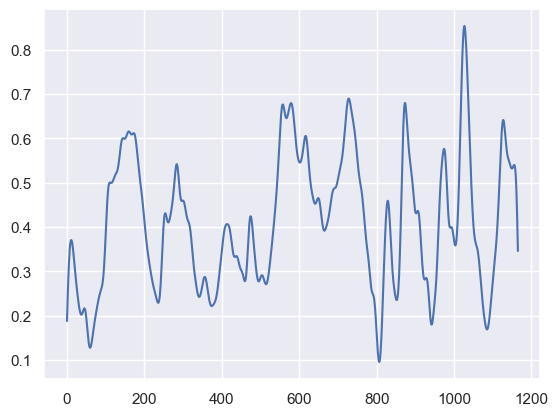

[3687, 8715, 10503, 14091]
[10000]
12699
cuda
epoch 1,loss = 0.99421167
epoch 2,loss = 0.99392593
epoch 3,loss = 0.99364626
epoch 4,loss = 0.99337280
epoch 5,loss = 0.99310559
epoch 6,loss = 0.99284470
epoch 7,loss = 0.99259031
epoch 8,loss = 0.99234229
epoch 9,loss = 0.99210089
epoch 10,loss = 0.99186593
epoch 11,loss = 0.99163771
epoch 12,loss = 0.99141598
epoch 13,loss = 0.99120080
epoch 14,loss = 0.99099231
epoch 15,loss = 0.99079043
epoch 16,loss = 0.99059510
epoch 17,loss = 0.99040627
epoch 18,loss = 0.99022400
epoch 19,loss = 0.99004811
epoch 20,loss = 0.98987854
epoch 21,loss = 0.98971534
epoch 22,loss = 0.98955834


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 23,loss = 0.98940748
epoch 24,loss = 0.98926270
epoch 25,loss = 0.98912376
epoch 26,loss = 0.98899078
epoch 27,loss = 0.98886347
epoch 28,loss = 0.98874182
epoch 29,loss = 0.98862565
epoch 30,loss = 0.98851472
epoch 31,loss = 0.98840904
epoch 32,loss = 0.98830849
epoch 33,loss = 0.98821282
epoch 34,loss = 0.98812205
epoch 35,loss = 0.98803580
epoch 36,loss = 0.98795402
epoch 37,loss = 0.98787653
epoch 38,loss = 0.98780328
epoch 39,loss = 0.98773402
epoch 40,loss = 0.98766863
epoch 41,loss = 0.98760700
epoch 42,loss = 0.98754889
epoch 43,loss = 0.98749423
epoch 44,loss = 0.98744267
epoch 45,loss = 0.98739433
epoch 46,loss = 0.98734891
epoch 47,loss = 0.98730636
epoch 48,loss = 0.98726648
epoch 49,loss = 0.98722911
epoch 50,loss = 0.98719412
epoch 51,loss = 0.98716146
epoch 52,loss = 0.98713094
epoch 53,loss = 0.98710245
epoch 54,loss = 0.98707587
epoch 55,loss = 0.98705107
epoch 56,loss = 0.98702782
epoch 57,loss = 0.98700625
epoch 58,loss = 0.98698610
epoch 59,loss = 0.98696721
e

epoch 329,loss = 0.86684829
epoch 330,loss = 0.86631745
epoch 331,loss = 0.86578113
epoch 332,loss = 0.86523604
epoch 333,loss = 0.86468726
epoch 334,loss = 0.86413020
epoch 335,loss = 0.86356431
epoch 336,loss = 0.86300349
epoch 337,loss = 0.86243594
epoch 338,loss = 0.86187011
epoch 339,loss = 0.86130190
epoch 340,loss = 0.86070698
epoch 341,loss = 0.86009312
epoch 342,loss = 0.85945928
epoch 343,loss = 0.85882032
epoch 344,loss = 0.85818142
epoch 345,loss = 0.85754460
epoch 346,loss = 0.85690224
epoch 347,loss = 0.85624558
epoch 348,loss = 0.85559630
epoch 349,loss = 0.85495710
epoch 350,loss = 0.85431492
epoch 351,loss = 0.85370976
epoch 352,loss = 0.85310316
epoch 353,loss = 0.85253203
epoch 354,loss = 0.85198045
epoch 355,loss = 0.85144317
epoch 356,loss = 0.85091949
epoch 357,loss = 0.85040730
epoch 358,loss = 0.84989721
epoch 359,loss = 0.84939247
epoch 360,loss = 0.84889781
epoch 361,loss = 0.84837568
epoch 362,loss = 0.84773308
epoch 363,loss = 0.84694034
epoch 364,loss = 0.8

epoch 652,loss = 0.80501670
epoch 653,loss = 0.80498785
epoch 654,loss = 0.80495906
epoch 655,loss = 0.80493033
epoch 656,loss = 0.80490172
epoch 657,loss = 0.80487299
epoch 658,loss = 0.80484438
epoch 659,loss = 0.80481613
epoch 660,loss = 0.80478853
epoch 661,loss = 0.80476099
epoch 662,loss = 0.80473435
epoch 663,loss = 0.80470806
epoch 664,loss = 0.80468184
epoch 665,loss = 0.80465603
epoch 666,loss = 0.80462992
epoch 667,loss = 0.80460340
epoch 668,loss = 0.80457723
epoch 669,loss = 0.80455196
epoch 670,loss = 0.80452782
epoch 671,loss = 0.80450332
epoch 672,loss = 0.80447900
epoch 673,loss = 0.80445451
epoch 674,loss = 0.80443031
epoch 675,loss = 0.80440634
epoch 676,loss = 0.80438268
epoch 677,loss = 0.80436021
epoch 678,loss = 0.80433851
epoch 679,loss = 0.80431604
epoch 680,loss = 0.80429244
epoch 681,loss = 0.80427051
epoch 682,loss = 0.80424857
epoch 683,loss = 0.80422646
epoch 684,loss = 0.80420446
epoch 685,loss = 0.80418229
epoch 686,loss = 0.80416006
epoch 687,loss = 0.8

epoch 950,loss = 0.80089426
epoch 951,loss = 0.80088848
epoch 952,loss = 0.80088240
epoch 953,loss = 0.80087614
epoch 954,loss = 0.80087036
epoch 955,loss = 0.80086446
epoch 956,loss = 0.80085874
epoch 957,loss = 0.80085242
epoch 958,loss = 0.80084586
epoch 959,loss = 0.80083948
epoch 960,loss = 0.80083525
epoch 961,loss = 0.80083019
epoch 962,loss = 0.80082458
epoch 963,loss = 0.80081880
epoch 964,loss = 0.80081260
epoch 965,loss = 0.80080843
epoch 966,loss = 0.80080438
epoch 967,loss = 0.80079979
epoch 968,loss = 0.80079484
epoch 969,loss = 0.80078965
epoch 970,loss = 0.80078483
epoch 971,loss = 0.80077922
epoch 972,loss = 0.80077422
epoch 973,loss = 0.80077052
epoch 974,loss = 0.80076629
epoch 975,loss = 0.80076170
epoch 976,loss = 0.80075765
epoch 977,loss = 0.80075425
epoch 978,loss = 0.80075061
epoch 979,loss = 0.80074650
epoch 980,loss = 0.80074209
epoch 981,loss = 0.80073804
epoch 982,loss = 0.80073357
epoch 983,loss = 0.80072957
epoch 984,loss = 0.80072546
epoch 985,loss = 0.8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([527, 1, 60])
1.0
Epoch 200:   loss= 0.20072  cluster difference= 1.0
Epoch 400:   loss= 0.19812  cluster difference= 0.058823529411764705
Epoch 600:   loss= 0.19736  cluster difference= 0.07020872865275142
Epoch 800:   loss= 0.19594  cluster difference= 0.04554079696394687
Epoch 1000:   loss= 0.19404  cluster difference= 0.024667931688804556
Epoch 1200:   loss= 0.19217  cluster difference= 0.017077798861480076
Epoch 1400:   loss= 0.19033  cluster difference= 0.0056925996204933585
[2 4 1 5 5 6 4 1 7 0 5 4 1 3 0 6 4 1 7 0 5 4 1 7 0 6 5 5 3 0 2 4 1 5 5 6 5
 5 3 0 5 4 1 6 5 6 4 1 3 0 6 4 1 6 5 6 5 1 7 0 6 4 1 2 5 6 5 5 3 0 6 4 1 7
 0 6 5 5 7 0 5 4 1 3 0 6 5 5 3 0 6 4 1 3 5 6 4 1 7 0 2 4 1 5 5 6 5 5 7 0 6
 4 1 3 5 2 3 5 7 0 6 5 5 7 0 6 5 1 7 0 5 5 1 7 0 6 7 0 7 0 2 4 1 3 0 2 4 1
 7 0 5 4 1 7 0 6 4 1 5 5 2 4 1 7 0 6 5 5 7 0 5 5 1 3 5 6 4 1 7 0 6 4 1 5 5
 2 5 5 7 0 2 4 1 3 5 6 4 1 3 0 2 4 1 7 0 2 4 1 7 4 1 4 1 7 0 2 4 1 7 0 2 4
 1 7 0 2 5 5 7 0 6 4 1 7 0 6 4 1 7 0 6 4 1 3 0 2 5 5 

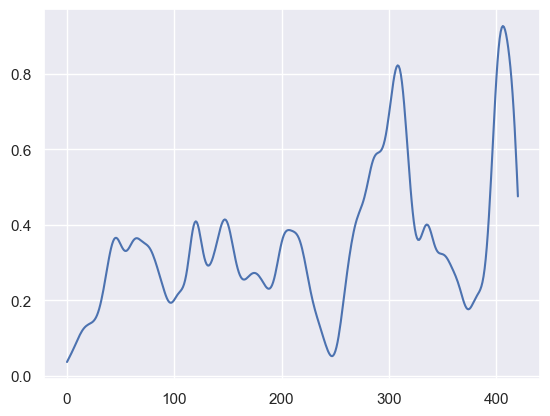

[8694, 11046]
[8699]
14699
cuda
epoch 1,loss = 1.00710046
epoch 2,loss = 1.00677574
epoch 3,loss = 1.00645649
epoch 4,loss = 1.00614297
epoch 5,loss = 1.00583494
epoch 6,loss = 1.00553286
epoch 7,loss = 1.00523627
epoch 8,loss = 1.00494564
epoch 9,loss = 1.00466073
epoch 10,loss = 1.00438178
epoch 11,loss = 1.00410867
epoch 12,loss = 1.00384140
epoch 13,loss = 1.00357985
epoch 14,loss = 1.00332487
epoch 15,loss = 1.00307679
epoch 16,loss = 1.00283146
epoch 17,loss = 1.00258601
epoch 18,loss = 1.00234222
epoch 19,loss = 1.00210476
epoch 20,loss = 1.00187230
epoch 21,loss = 1.00164652
epoch 22,loss = 1.00142503
epoch 23,loss = 1.00120413
epoch 24,loss = 1.00098872


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 25,loss = 1.00077891
epoch 26,loss = 1.00057423
epoch 27,loss = 1.00037622
epoch 28,loss = 1.00018799
epoch 29,loss = 0.99999726
epoch 30,loss = 0.99981475
epoch 31,loss = 0.99963671
epoch 32,loss = 0.99946159
epoch 33,loss = 0.99929047
epoch 34,loss = 0.99912250
epoch 35,loss = 0.99895495
epoch 36,loss = 0.99878842
epoch 37,loss = 0.99862784
epoch 38,loss = 0.99846476
epoch 39,loss = 0.99829835
epoch 40,loss = 0.99812514
epoch 41,loss = 0.99794900
epoch 42,loss = 0.99778295
epoch 43,loss = 0.99762285
epoch 44,loss = 0.99746639
epoch 45,loss = 0.99730623
epoch 46,loss = 0.99715155
epoch 47,loss = 0.99700993
epoch 48,loss = 0.99687457
epoch 49,loss = 0.99674535
epoch 50,loss = 0.99662429
epoch 51,loss = 0.99652016
epoch 52,loss = 0.99643809
epoch 53,loss = 0.99636936
epoch 54,loss = 0.99629658
epoch 55,loss = 0.99624234
epoch 56,loss = 0.99621248
epoch 57,loss = 0.99619347
epoch 58,loss = 0.99618459
epoch 59,loss = 0.99618429
epoch 60,loss = 0.99618131
epoch 61,loss = 0.99617469
e

epoch 344,loss = 0.88168043
epoch 345,loss = 0.88155609
epoch 346,loss = 0.88143563
epoch 347,loss = 0.88131881
epoch 348,loss = 0.88120222
epoch 349,loss = 0.88108927
epoch 350,loss = 0.88097990
epoch 351,loss = 0.88087314
epoch 352,loss = 0.88076812
epoch 353,loss = 0.88066500
epoch 354,loss = 0.88056505
epoch 355,loss = 0.88046700
epoch 356,loss = 0.88036960
epoch 357,loss = 0.88027334
epoch 358,loss = 0.88017803
epoch 359,loss = 0.88008416
epoch 360,loss = 0.87999082
epoch 361,loss = 0.87989748
epoch 362,loss = 0.87980455
epoch 363,loss = 0.87971199
epoch 364,loss = 0.87961984
epoch 365,loss = 0.87952840
epoch 366,loss = 0.87943828
epoch 367,loss = 0.87934971
epoch 368,loss = 0.87926155
epoch 369,loss = 0.87917411
epoch 370,loss = 0.87908751
epoch 371,loss = 0.87900186
epoch 372,loss = 0.87891638
epoch 373,loss = 0.87883079
epoch 374,loss = 0.87874556
epoch 375,loss = 0.87866032
epoch 376,loss = 0.87857574
epoch 377,loss = 0.87849182
epoch 378,loss = 0.87840849
epoch 379,loss = 0.8

epoch 656,loss = 0.85444033
epoch 657,loss = 0.85438764
epoch 658,loss = 0.85433233
epoch 659,loss = 0.85427237
epoch 660,loss = 0.85421520
epoch 661,loss = 0.85415792
epoch 662,loss = 0.85410511
epoch 663,loss = 0.85405290
epoch 664,loss = 0.85400200
epoch 665,loss = 0.85395169
epoch 666,loss = 0.85391140
epoch 667,loss = 0.85386777
epoch 668,loss = 0.85382044
epoch 669,loss = 0.85377008
epoch 670,loss = 0.85371536
epoch 671,loss = 0.85366154
epoch 672,loss = 0.85360903
epoch 673,loss = 0.85355651
epoch 674,loss = 0.85349941
epoch 675,loss = 0.85343957
epoch 676,loss = 0.85337901
epoch 677,loss = 0.85331523
epoch 678,loss = 0.85325950
epoch 679,loss = 0.85320550
epoch 680,loss = 0.85315400
epoch 681,loss = 0.85310775
epoch 682,loss = 0.85306495
epoch 683,loss = 0.85302371
epoch 684,loss = 0.85298079
epoch 685,loss = 0.85293579
epoch 686,loss = 0.85288799
epoch 687,loss = 0.85284239
epoch 688,loss = 0.85280079
epoch 689,loss = 0.85276097
epoch 690,loss = 0.85272044
epoch 691,loss = 0.8

epoch 952,loss = 0.84039426
epoch 953,loss = 0.84032351
epoch 954,loss = 0.84026068
epoch 955,loss = 0.84018236
epoch 956,loss = 0.84008271
epoch 957,loss = 0.83996338
epoch 958,loss = 0.83983552
epoch 959,loss = 0.83971113
epoch 960,loss = 0.83960819
epoch 961,loss = 0.83952075
epoch 962,loss = 0.83943939
epoch 963,loss = 0.83935636
epoch 964,loss = 0.83926606
epoch 965,loss = 0.83916360
epoch 966,loss = 0.83905059
epoch 967,loss = 0.83893377
epoch 968,loss = 0.83881432
epoch 969,loss = 0.83870053
epoch 970,loss = 0.83858705
epoch 971,loss = 0.83847541
epoch 972,loss = 0.83837414
epoch 973,loss = 0.83827019
epoch 974,loss = 0.83815509
epoch 975,loss = 0.83803022
epoch 976,loss = 0.83790898
epoch 977,loss = 0.83779341
epoch 978,loss = 0.83768570
epoch 979,loss = 0.83756220
epoch 980,loss = 0.83743691
epoch 981,loss = 0.83732468
epoch 982,loss = 0.83722103
epoch 983,loss = 0.83710653
epoch 984,loss = 0.83698231
epoch 985,loss = 0.83685780
epoch 986,loss = 0.83671921
epoch 987,loss = 0.8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([610, 1, 60])
1.0
Epoch 200:   loss= 0.1854  cluster difference= 1.0
Epoch 400:   loss= 0.18629  cluster difference= 0.040983606557377046
Epoch 600:   loss= 0.18729  cluster difference= 0.03934426229508197
Epoch 800:   loss= 0.18796  cluster difference= 0.05245901639344262
Epoch 1000:   loss= 0.18833  cluster difference= 0.029508196721311476
Epoch 1200:   loss= 0.18876  cluster difference= 0.03442622950819672
Epoch 1400:   loss= 0.18921  cluster difference= 0.021311475409836064
Epoch 1600:   loss= 0.18959  cluster difference= 0.011475409836065573
Epoch 1800:   loss= 0.1899  cluster difference= 0.003278688524590164
[3 4 6 0 1 7 4 6 5 1 3 0 6 2 1 7 4 6 5 1 2 0 6 2 0 3 4 6 5 1 3 0 6 7 4 3 0
 2 5 1 3 4 6 2 0 7 4 6 2 2 7 4 6 7 4 3 0 2 0 2 7 4 6 5 1 3 2 2 0 2 2 4 6 5
 1 3 4 2 2 2 2 4 6 2 0 7 2 2 5 2 2 4 6 2 0 3 2 2 5 1 2 4 6 2 0 3 4 6 5 1 3
 0 6 2 0 3 2 2 5 1 3 0 6 5 0 3 4 1 5 1 7 4 2 5 1 3 0 1 5 1 7 0 2 5 1 3 2 1
 5 1 3 0 2 5 1 3 4 6 5 1 2 0 6 2 0 3 2 2 5 1 2 0 6 5 1 7 2 2 5 1 2 

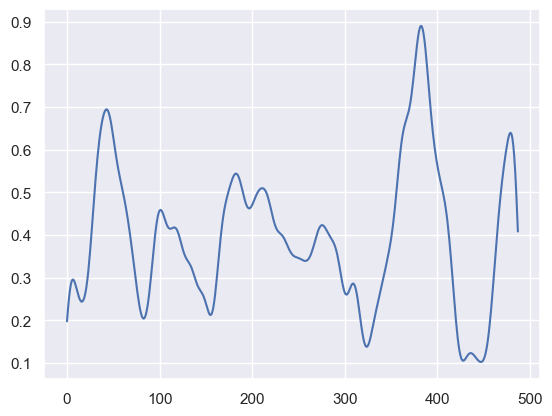

[2526, 10662, 12990]
[10699]
11000
cuda
epoch 1,loss = 1.02610314
epoch 2,loss = 1.02555811
epoch 3,loss = 1.02501965
epoch 4,loss = 1.02448773
epoch 5,loss = 1.02396071
epoch 6,loss = 1.02343357
epoch 7,loss = 1.02291226
epoch 8,loss = 1.02239287
epoch 9,loss = 1.02187943
epoch 10,loss = 1.02135396
epoch 11,loss = 1.02083004
epoch 12,loss = 1.02031362
epoch 13,loss = 1.01979959
epoch 14,loss = 1.01928449
epoch 15,loss = 1.01876688
epoch 16,loss = 1.01821959
epoch 17,loss = 1.01767218
epoch 18,loss = 1.01712036
epoch 19,loss = 1.01654541
epoch 20,loss = 1.01594973
epoch 21,loss = 1.01534653
epoch 22,loss = 1.01473629
epoch 23,loss = 1.01412582
epoch 24,loss = 1.01351666
epoch 25,loss = 1.01290941
epoch 26,loss = 1.01230478
epoch 27,loss = 1.01170337
epoch 28,loss = 1.01110566
epoch 29,loss = 1.01051223
epoch 30,loss = 1.00992346
epoch 31,loss = 1.00933957
epoch 32,loss = 1.00876093
epoch 33,loss = 1.00818789
epoch 34,loss = 1.00762057
epoch 35,loss = 1.00705922
epoch 36,loss = 1.006504

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 39,loss = 1.00487900
epoch 40,loss = 1.00435150
epoch 41,loss = 1.00383174
epoch 42,loss = 1.00331974
epoch 43,loss = 1.00281572
epoch 44,loss = 1.00232005
epoch 45,loss = 1.00183332
epoch 46,loss = 1.00135601
epoch 47,loss = 1.00088918
epoch 48,loss = 1.00043356
epoch 49,loss = 0.99998951
epoch 50,loss = 0.99955624
epoch 51,loss = 0.99913347
epoch 52,loss = 0.99872041
epoch 53,loss = 0.99831676
epoch 54,loss = 0.99792218
epoch 55,loss = 0.99753559
epoch 56,loss = 0.99715662
epoch 57,loss = 0.99678445
epoch 58,loss = 0.99641824
epoch 59,loss = 0.99606538
epoch 60,loss = 0.99575353
epoch 61,loss = 0.99552542
epoch 62,loss = 0.99537092
epoch 63,loss = 0.99525172
epoch 64,loss = 0.99514920
epoch 65,loss = 0.99505574
epoch 66,loss = 0.99495512
epoch 67,loss = 0.99482536
epoch 68,loss = 0.99464691
epoch 69,loss = 0.99441499
epoch 70,loss = 0.99413311
epoch 71,loss = 0.99381208
epoch 72,loss = 0.99346805
epoch 73,loss = 0.99311280
epoch 74,loss = 0.99275905
epoch 75,loss = 0.99241692
e

epoch 348,loss = 0.68346226
epoch 349,loss = 0.68337399
epoch 350,loss = 0.68328506
epoch 351,loss = 0.68319684
epoch 352,loss = 0.68310899
epoch 353,loss = 0.68302119
epoch 354,loss = 0.68293208
epoch 355,loss = 0.68284333
epoch 356,loss = 0.68275434
epoch 357,loss = 0.68266511
epoch 358,loss = 0.68257475
epoch 359,loss = 0.68248445
epoch 360,loss = 0.68239433
epoch 361,loss = 0.68230563
epoch 362,loss = 0.68221503
epoch 363,loss = 0.68212318
epoch 364,loss = 0.68203092
epoch 365,loss = 0.68193656
epoch 366,loss = 0.68184167
epoch 367,loss = 0.68174624
epoch 368,loss = 0.68164963
epoch 369,loss = 0.68155229
epoch 370,loss = 0.68145633
epoch 371,loss = 0.68135983
epoch 372,loss = 0.68126178
epoch 373,loss = 0.68116152
epoch 374,loss = 0.68106204
epoch 375,loss = 0.68096185
epoch 376,loss = 0.68085998
epoch 377,loss = 0.68075544
epoch 378,loss = 0.68064815
epoch 379,loss = 0.68054026
epoch 380,loss = 0.68043125
epoch 381,loss = 0.68032306
epoch 382,loss = 0.68021619
epoch 383,loss = 0.6

epoch 649,loss = 0.67061818
epoch 650,loss = 0.67060286
epoch 651,loss = 0.67058790
epoch 652,loss = 0.67057323
epoch 653,loss = 0.67055881
epoch 654,loss = 0.67054445
epoch 655,loss = 0.67053008
epoch 656,loss = 0.67051542
epoch 657,loss = 0.67050087
epoch 658,loss = 0.67048651
epoch 659,loss = 0.67047238
epoch 660,loss = 0.67045861
epoch 661,loss = 0.67044497
epoch 662,loss = 0.67043155
epoch 663,loss = 0.67041779
epoch 664,loss = 0.67040408
epoch 665,loss = 0.67039013
epoch 666,loss = 0.67037606
epoch 667,loss = 0.67036164
epoch 668,loss = 0.67034626
epoch 669,loss = 0.67033082
epoch 670,loss = 0.67031509
epoch 671,loss = 0.67029977
epoch 672,loss = 0.67028391
epoch 673,loss = 0.67026758
epoch 674,loss = 0.67025197
epoch 675,loss = 0.67023635
epoch 676,loss = 0.67022008
epoch 677,loss = 0.67020303
epoch 678,loss = 0.67018592
epoch 679,loss = 0.67016852
epoch 680,loss = 0.67015141
epoch 681,loss = 0.67013431
epoch 682,loss = 0.67011726
epoch 683,loss = 0.67010015
epoch 684,loss = 0.6

epoch 954,loss = 0.65552652
epoch 955,loss = 0.65535551
epoch 956,loss = 0.65519649
epoch 957,loss = 0.65505040
epoch 958,loss = 0.65490562
epoch 959,loss = 0.65476489
epoch 960,loss = 0.65462440
epoch 961,loss = 0.65448314
epoch 962,loss = 0.65434271
epoch 963,loss = 0.65420359
epoch 964,loss = 0.65406966
epoch 965,loss = 0.65393656
epoch 966,loss = 0.65380758
epoch 967,loss = 0.65367842
epoch 968,loss = 0.65353853
epoch 969,loss = 0.65339428
epoch 970,loss = 0.65324134
epoch 971,loss = 0.65308034
epoch 972,loss = 0.65291262
epoch 973,loss = 0.65273404
epoch 974,loss = 0.65254426
epoch 975,loss = 0.65234798
epoch 976,loss = 0.65214109
epoch 977,loss = 0.65193439
epoch 978,loss = 0.65173775
epoch 979,loss = 0.65154856
epoch 980,loss = 0.65137130
epoch 981,loss = 0.65119970
epoch 982,loss = 0.65102494
epoch 983,loss = 0.65085471
epoch 984,loss = 0.65071046
epoch 985,loss = 0.65058631
epoch 986,loss = 0.65046519
epoch 987,loss = 0.65034699
epoch 988,loss = 0.65021974
epoch 989,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([421, 1, 64])
1.0
Epoch 200:   loss= 0.19657  cluster difference= 1.0
Epoch 400:   loss= 0.19753  cluster difference= 0.052256532066508314
Epoch 600:   loss= 0.19882  cluster difference= 0.047505938242280284
Epoch 800:   loss= 0.19994  cluster difference= 0.040380047505938245
Epoch 1000:   loss= 0.20094  cluster difference= 0.057007125890736345
Epoch 1200:   loss= 0.20194  cluster difference= 0.05938242280285035
Epoch 1400:   loss= 0.20272  cluster difference= 0.030878859857482184
Epoch 1600:   loss= 0.20323  cluster difference= 0.035629453681710214
Epoch 1800:   loss= 0.2035  cluster difference= 0.021377672209026127
Epoch 2000:   loss= 0.20358  cluster difference= 0.007125890736342043
[7 7 3 1 7 3 1 5 6 7 7 5 2 6 5 2 4 0 1 7 4 6 7 4 2 4 7 7 7 6 0 7 4 6 7 3 7
 7 7 3 1 7 3 1 5 7 7 7 7 7 7 7 7 7 7 7 7 5 6 7 4 2 7 4 6 7 4 0 7 4 0 7 4 0
 1 3 3 7 7 3 1 7 3 1 7 7 7 7 5 1 7 5 2 4 6 7 7 5 2 7 4 2 4 3 1 7 4 0 7 4 0
 7 3 7 7 7 0 7 3 1 1 7 7 7 7 7 7 7 7 7 7 7 7 7 5 2 2 5 2 7 4 2 7 7 7 

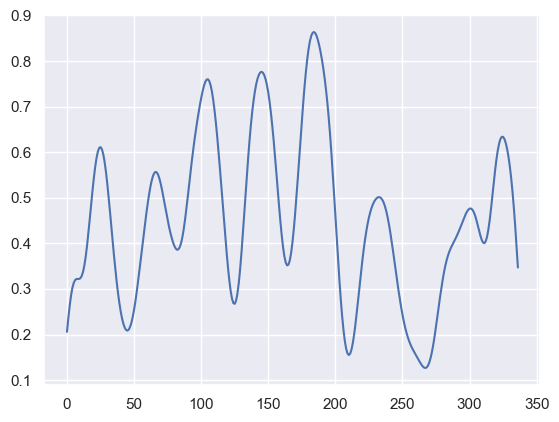

[1774, 3854, 5908, 9548]
[4000]
8001
cuda
epoch 1,loss = 1.00217688
epoch 2,loss = 1.00217474
epoch 3,loss = 1.00217247
epoch 4,loss = 1.00217021
epoch 5,loss = 1.00216794
epoch 6,loss = 1.00216579
epoch 7,loss = 1.00216389
epoch 8,loss = 1.00216186
epoch 9,loss = 1.00216007
epoch 10,loss = 1.00215828
epoch 11,loss = 1.00215650
epoch 12,loss = 1.00215483
epoch 13,loss = 1.00215316
epoch 14,loss = 1.00215173
epoch 15,loss = 1.00215030
epoch 16,loss = 1.00214875
epoch 17,loss = 1.00214732
epoch 18,loss = 1.00214577
epoch 19,loss = 1.00214458
epoch 20,loss = 1.00214314
epoch 21,loss = 1.00214171
epoch 22,loss = 1.00214040
epoch 23,loss = 1.00213897
epoch 24,loss = 1.00213742
epoch 25,loss = 1.00213587
epoch 26,loss = 1.00213432
epoch 27,loss = 1.00213253
epoch 28,loss = 1.00213051
epoch 29,loss = 1.00212848
epoch 30,loss = 1.00212622
epoch 31,loss = 1.00212359
epoch 32,loss = 1.00212073
epoch 33,loss = 1.00211751
epoch 34,loss = 1.00211394
epoch 35,loss = 1.00211000
epoch 36,loss = 1.0021

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 45,loss = 1.00153923
epoch 46,loss = 1.00146413
epoch 47,loss = 1.00139618
epoch 48,loss = 1.00132811
epoch 49,loss = 1.00125253
epoch 50,loss = 1.00116980
epoch 51,loss = 1.00107658
epoch 52,loss = 1.00097179
epoch 53,loss = 1.00085187
epoch 54,loss = 1.00071239
epoch 55,loss = 1.00054312
epoch 56,loss = 1.00028443
epoch 57,loss = 0.99980730
epoch 58,loss = 0.99918634
epoch 59,loss = 0.99865592
epoch 60,loss = 0.99823838
epoch 61,loss = 0.99781650
epoch 62,loss = 0.99738747
epoch 63,loss = 0.99690247
epoch 64,loss = 0.99636692
epoch 65,loss = 0.99576932
epoch 66,loss = 0.99509197
epoch 67,loss = 0.99433875
epoch 68,loss = 0.99350089
epoch 69,loss = 0.99257636
epoch 70,loss = 0.99155605
epoch 71,loss = 0.99043012
epoch 72,loss = 0.98918951
epoch 73,loss = 0.98782438
epoch 74,loss = 0.98634267
epoch 75,loss = 0.98473901
epoch 76,loss = 0.98300213
epoch 77,loss = 0.98125952
epoch 78,loss = 0.97948915
epoch 79,loss = 0.97763312
epoch 80,loss = 0.97568089
epoch 81,loss = 0.97361964
e

epoch 351,loss = 0.47591227
epoch 352,loss = 0.47474077
epoch 353,loss = 0.47360051
epoch 354,loss = 0.47249401
epoch 355,loss = 0.47141474
epoch 356,loss = 0.47035345
epoch 357,loss = 0.46932006
epoch 358,loss = 0.46832162
epoch 359,loss = 0.46734893
epoch 360,loss = 0.46640852
epoch 361,loss = 0.46550417
epoch 362,loss = 0.46463278
epoch 363,loss = 0.46378800
epoch 364,loss = 0.46297359
epoch 365,loss = 0.46218807
epoch 366,loss = 0.46142980
epoch 367,loss = 0.46069908
epoch 368,loss = 0.45998725
epoch 369,loss = 0.45930311
epoch 370,loss = 0.45864195
epoch 371,loss = 0.45800221
epoch 372,loss = 0.45738193
epoch 373,loss = 0.45677844
epoch 374,loss = 0.45618764
epoch 375,loss = 0.45561391
epoch 376,loss = 0.45505556
epoch 377,loss = 0.45451081
epoch 378,loss = 0.45397925
epoch 379,loss = 0.45346642
epoch 380,loss = 0.45296818
epoch 381,loss = 0.45248649
epoch 382,loss = 0.45202100
epoch 383,loss = 0.45156991
epoch 384,loss = 0.45113194
epoch 385,loss = 0.45070776
epoch 386,loss = 0.4

epoch 677,loss = 0.37768096
epoch 678,loss = 0.37739235
epoch 679,loss = 0.37710410
epoch 680,loss = 0.37681806
epoch 681,loss = 0.37652892
epoch 682,loss = 0.37623730
epoch 683,loss = 0.37594652
epoch 684,loss = 0.37565905
epoch 685,loss = 0.37537128
epoch 686,loss = 0.37508079
epoch 687,loss = 0.37478632
epoch 688,loss = 0.37449032
epoch 689,loss = 0.37419498
epoch 690,loss = 0.37389678
epoch 691,loss = 0.37359381
epoch 692,loss = 0.37328905
epoch 693,loss = 0.37298360
epoch 694,loss = 0.37267980
epoch 695,loss = 0.37237617
epoch 696,loss = 0.37207073
epoch 697,loss = 0.37176681
epoch 698,loss = 0.37146002
epoch 699,loss = 0.37114727
epoch 700,loss = 0.37082994
epoch 701,loss = 0.37051085
epoch 702,loss = 0.37018886
epoch 703,loss = 0.36985978
epoch 704,loss = 0.36953139
epoch 705,loss = 0.36920494
epoch 706,loss = 0.36887321
epoch 707,loss = 0.36853069
epoch 708,loss = 0.36817789
epoch 709,loss = 0.36781299
epoch 710,loss = 0.36743742
epoch 711,loss = 0.36704698
epoch 712,loss = 0.3

epoch 994,loss = 0.33353975
epoch 995,loss = 0.33349940
epoch 996,loss = 0.33345899
epoch 997,loss = 0.33341846
epoch 998,loss = 0.33337671
epoch 999,loss = 0.33333471
epoch 1000,loss = 0.33329237
epoch 1001,loss = 0.33324915
epoch 1002,loss = 0.33320677
epoch 1003,loss = 0.33316302
epoch 1004,loss = 0.33312106
epoch 1005,loss = 0.33307940
epoch 1006,loss = 0.33303618
epoch 1007,loss = 0.33299524
epoch 1008,loss = 0.33295283
epoch 1009,loss = 0.33291060
epoch 1010,loss = 0.33286956
epoch 1011,loss = 0.33282638
epoch 1012,loss = 0.33278480
epoch 1013,loss = 0.33274195
epoch 1014,loss = 0.33269888
epoch 1015,loss = 0.33265674
epoch 1016,loss = 0.33261335
epoch 1017,loss = 0.33257157
epoch 1018,loss = 0.33252910
epoch 1019,loss = 0.33248621
epoch 1020,loss = 0.33244428
epoch 1021,loss = 0.33240116
epoch 1022,loss = 0.33235890
epoch 1023,loss = 0.33231655
epoch 1024,loss = 0.33227268
epoch 1025,loss = 0.33222964
epoch 1026,loss = 0.33218557
epoch 1027,loss = 0.33214331
epoch 1028,loss = 0.

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([198, 1, 100])
1.0
Epoch 200:   loss= 0.16797  cluster difference= 1.0
Epoch 400:   loss= 0.16783  cluster difference= 0.06565656565656566
Epoch 600:   loss= 0.16735  cluster difference= 0.005050505050505051
[7 1 2 7 1 2 7 4 5 0 4 5 0 3 5 6 3 1 6 3 1 6 7 1 2 7 1 2 7 4 2 0 4 5 0 4 5
 6 3 1 6 3 1 6 7 1 2 7 1 2 7 4 2 0 4 5 0 4 5 6 3 1 6 3 1 6 7 1 2 7 1 2 7 4
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 3 6 3 5 6 3 1 6 3 1 2 7 1 2 7 4 2 0 4 5 0 4 5 6
 3 5 6 3 1 6 3 1 2 7 1 2 7 4 2 0 4 5 0 4 5 6 3 5 6 3 1 6 3 1 2 7 1 2 7 4 2
 0 4 5 0 4 5 6 3 5 6 3 1 6]


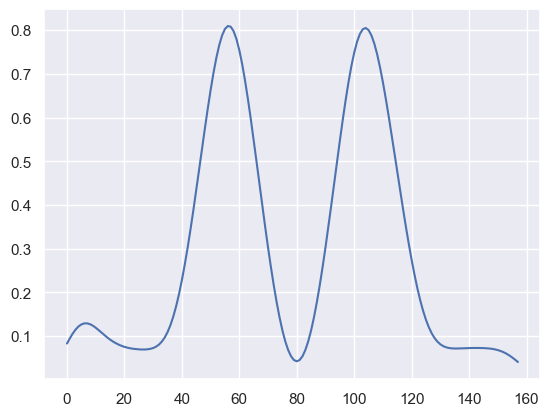

[3090, 5010]
[3000 5000]
12000
cuda
epoch 1,loss = 0.99730206
epoch 2,loss = 0.99728739
epoch 3,loss = 0.99727327
epoch 4,loss = 0.99725956
epoch 5,loss = 0.99724633
epoch 6,loss = 0.99723351
epoch 7,loss = 0.99722093
epoch 8,loss = 0.99720854
epoch 9,loss = 0.99719620
epoch 10,loss = 0.99718416
epoch 11,loss = 0.99717206
epoch 12,loss = 0.99716008
epoch 13,loss = 0.99714810
epoch 14,loss = 0.99713612
epoch 15,loss = 0.99712420
epoch 16,loss = 0.99711233
epoch 17,loss = 0.99710041
epoch 18,loss = 0.99708855
epoch 19,loss = 0.99707675
epoch 20,loss = 0.99706477
epoch 21,loss = 0.99705291
epoch 22,loss = 0.99704099
epoch 23,loss = 0.99702907


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 24,loss = 0.99701697
epoch 25,loss = 0.99700499
epoch 26,loss = 0.99699289
epoch 27,loss = 0.99698073
epoch 28,loss = 0.99696845
epoch 29,loss = 0.99695623
epoch 30,loss = 0.99694383
epoch 31,loss = 0.99693137
epoch 32,loss = 0.99691880
epoch 33,loss = 0.99690604
epoch 34,loss = 0.99689329
epoch 35,loss = 0.99688029
epoch 36,loss = 0.99686724
epoch 37,loss = 0.99685407
epoch 38,loss = 0.99684078
epoch 39,loss = 0.99682736
epoch 40,loss = 0.99681365
epoch 41,loss = 0.99679983
epoch 42,loss = 0.99678588
epoch 43,loss = 0.99677175
epoch 44,loss = 0.99675739
epoch 45,loss = 0.99674278
epoch 46,loss = 0.99672806
epoch 47,loss = 0.99671310
epoch 48,loss = 0.99669790
epoch 49,loss = 0.99668247
epoch 50,loss = 0.99666679
epoch 51,loss = 0.99665082
epoch 52,loss = 0.99663460
epoch 53,loss = 0.99661815
epoch 54,loss = 0.99660134
epoch 55,loss = 0.99658412
epoch 56,loss = 0.99656665
epoch 57,loss = 0.99654871
epoch 58,loss = 0.99653053
epoch 59,loss = 0.99651170
epoch 60,loss = 0.99649256
e

epoch 352,loss = 0.64477152
epoch 353,loss = 0.64449435
epoch 354,loss = 0.64422011
epoch 355,loss = 0.64394373
epoch 356,loss = 0.64366978
epoch 357,loss = 0.64339757
epoch 358,loss = 0.64312625
epoch 359,loss = 0.64285588
epoch 360,loss = 0.64258981
epoch 361,loss = 0.64232469
epoch 362,loss = 0.64205712
epoch 363,loss = 0.64179134
epoch 364,loss = 0.64152479
epoch 365,loss = 0.64125615
epoch 366,loss = 0.64099097
epoch 367,loss = 0.64072853
epoch 368,loss = 0.64046687
epoch 369,loss = 0.64020604
epoch 370,loss = 0.63994753
epoch 371,loss = 0.63969117
epoch 372,loss = 0.63943458
epoch 373,loss = 0.63917464
epoch 374,loss = 0.63891554
epoch 375,loss = 0.63865620
epoch 376,loss = 0.63839769
epoch 377,loss = 0.63814169
epoch 378,loss = 0.63787806
epoch 379,loss = 0.63760978
epoch 380,loss = 0.63734019
epoch 381,loss = 0.63706881
epoch 382,loss = 0.63679171
epoch 383,loss = 0.63651627
epoch 384,loss = 0.63624245
epoch 385,loss = 0.63596940
epoch 386,loss = 0.63569683
epoch 387,loss = 0.6

epoch 658,loss = 0.57820386
epoch 659,loss = 0.57803178
epoch 660,loss = 0.57785970
epoch 661,loss = 0.57768750
epoch 662,loss = 0.57751173
epoch 663,loss = 0.57733554
epoch 664,loss = 0.57715869
epoch 665,loss = 0.57698184
epoch 666,loss = 0.57680476
epoch 667,loss = 0.57662666
epoch 668,loss = 0.57644880
epoch 669,loss = 0.57626963
epoch 670,loss = 0.57609057
epoch 671,loss = 0.57591152
epoch 672,loss = 0.57573259
epoch 673,loss = 0.57555223
epoch 674,loss = 0.57536787
epoch 675,loss = 0.57518321
epoch 676,loss = 0.57499754
epoch 677,loss = 0.57481170
epoch 678,loss = 0.57462502
epoch 679,loss = 0.57443887
epoch 680,loss = 0.57425302
epoch 681,loss = 0.57406735
epoch 682,loss = 0.57388294
epoch 683,loss = 0.57369924
epoch 684,loss = 0.57351565
epoch 685,loss = 0.57333457
epoch 686,loss = 0.57315421
epoch 687,loss = 0.57297331
epoch 688,loss = 0.57279271
epoch 689,loss = 0.57261264
epoch 690,loss = 0.57243234
epoch 691,loss = 0.57225293
epoch 692,loss = 0.57207429
epoch 693,loss = 0.5

epoch 962,loss = 0.53369814
epoch 963,loss = 0.53358346
epoch 964,loss = 0.53346902
epoch 965,loss = 0.53335470
epoch 966,loss = 0.53324193
epoch 967,loss = 0.53313082
epoch 968,loss = 0.53302085
epoch 969,loss = 0.53291154
epoch 970,loss = 0.53280324
epoch 971,loss = 0.53269559
epoch 972,loss = 0.53258872
epoch 973,loss = 0.53248173
epoch 974,loss = 0.53236961
epoch 975,loss = 0.53225720
epoch 976,loss = 0.53214300
epoch 977,loss = 0.53202879
epoch 978,loss = 0.53191626
epoch 979,loss = 0.53180522
epoch 980,loss = 0.53169578
epoch 981,loss = 0.53158772
epoch 982,loss = 0.53148073
epoch 983,loss = 0.53137493
epoch 984,loss = 0.53127038
epoch 985,loss = 0.53116649
epoch 986,loss = 0.53106320
epoch 987,loss = 0.53096056
epoch 988,loss = 0.53085893
epoch 989,loss = 0.53075802
epoch 990,loss = 0.53065747
epoch 991,loss = 0.53055793
epoch 992,loss = 0.53045887
epoch 993,loss = 0.53036046
epoch 994,loss = 0.53026259
epoch 995,loss = 0.53016514
epoch 996,loss = 0.53006768
epoch 997,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


torch.Size([1198, 1, 25])
1.0
Epoch 200:   loss= 0.19129  cluster difference= 1.0
Epoch 400:   loss= 0.19147  cluster difference= 0.034223706176961605
Epoch 600:   loss= 0.19046  cluster difference= 0.06343906510851419
Epoch 800:   loss= 0.18926  cluster difference= 0.034223706176961605
Epoch 1000:   loss= 0.18825  cluster difference= 0.01335559265442404
Epoch 1200:   loss= 0.18734  cluster difference= 0.017529215358931552
Epoch 1400:   loss= 0.18645  cluster difference= 0.014190317195325543
Epoch 1600:   loss= 0.18553  cluster difference= 0.010851419031719533
Epoch 1800:   loss= 0.18464  cluster difference= 0.00667779632721202
[0 1 5 ... 0 0 0]


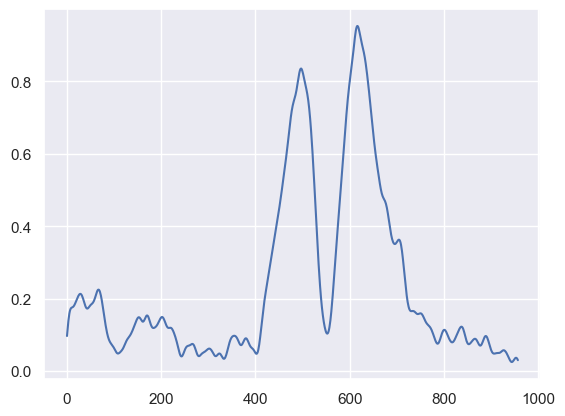

[7373]
[6200 7600]
12001
cuda
epoch 1,loss = 1.20443583
epoch 2,loss = 1.20272505
epoch 3,loss = 1.20106971
epoch 4,loss = 1.19946730
epoch 5,loss = 1.19791067
epoch 6,loss = 1.19639599
epoch 7,loss = 1.19491959
epoch 8,loss = 1.19347787
epoch 9,loss = 1.19206071
epoch 10,loss = 1.19066525
epoch 11,loss = 1.18928707
epoch 12,loss = 1.18792248
epoch 13,loss = 1.18656981


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 14,loss = 1.18522716
epoch 15,loss = 1.18389499
epoch 16,loss = 1.18257117
epoch 17,loss = 1.18125463
epoch 18,loss = 1.17994523
epoch 19,loss = 1.17864132
epoch 20,loss = 1.17734063
epoch 21,loss = 1.17604494
epoch 22,loss = 1.17475426
epoch 23,loss = 1.17346823
epoch 24,loss = 1.17218697
epoch 25,loss = 1.17090988
epoch 26,loss = 1.16963720
epoch 27,loss = 1.16836929
epoch 28,loss = 1.16710579
epoch 29,loss = 1.16584742
epoch 30,loss = 1.16459394
epoch 31,loss = 1.16334558
epoch 32,loss = 1.16210270
epoch 33,loss = 1.16086519
epoch 34,loss = 1.15963268
epoch 35,loss = 1.15840495
epoch 36,loss = 1.15718222
epoch 37,loss = 1.15596497
epoch 38,loss = 1.15475297
epoch 39,loss = 1.15354609
epoch 40,loss = 1.15234470
epoch 41,loss = 1.15114844
epoch 42,loss = 1.14995766
epoch 43,loss = 1.14877188
epoch 44,loss = 1.14759123
epoch 45,loss = 1.14641583
epoch 46,loss = 1.14524579
epoch 47,loss = 1.14408100
epoch 48,loss = 1.14292145
epoch 49,loss = 1.14176738
epoch 50,loss = 1.14061844
e

epoch 324,loss = 0.67624259
epoch 325,loss = 0.67610091
epoch 326,loss = 0.67639822
epoch 327,loss = 0.67687577
epoch 328,loss = 0.67729676
epoch 329,loss = 0.67747086
epoch 330,loss = 0.67726350
epoch 331,loss = 0.67662019
epoch 332,loss = 0.67553520
epoch 333,loss = 0.67405647
epoch 334,loss = 0.67226356
epoch 335,loss = 0.67024434
epoch 336,loss = 0.66809148
epoch 337,loss = 0.66590500
epoch 338,loss = 0.66376013
epoch 339,loss = 0.66170883
epoch 340,loss = 0.65981299
epoch 341,loss = 0.65810204
epoch 342,loss = 0.65657669
epoch 343,loss = 0.65522337
epoch 344,loss = 0.65402770
epoch 345,loss = 0.65298069
epoch 346,loss = 0.65206212
epoch 347,loss = 0.65123928
epoch 348,loss = 0.65048045
epoch 349,loss = 0.64976257
epoch 350,loss = 0.64907211
epoch 351,loss = 0.64838845
epoch 352,loss = 0.64770198
epoch 353,loss = 0.64700586
epoch 354,loss = 0.64630330
epoch 355,loss = 0.64559561
epoch 356,loss = 0.64488417
epoch 357,loss = 0.64417571
epoch 358,loss = 0.64347589
epoch 359,loss = 0.6

epoch 630,loss = 0.61650366
epoch 631,loss = 0.61646229
epoch 632,loss = 0.61642110
epoch 633,loss = 0.61638004
epoch 634,loss = 0.61633903
epoch 635,loss = 0.61629826
epoch 636,loss = 0.61625743
epoch 637,loss = 0.61621672
epoch 638,loss = 0.61617625
epoch 639,loss = 0.61613578
epoch 640,loss = 0.61609554
epoch 641,loss = 0.61605525
epoch 642,loss = 0.61601508
epoch 643,loss = 0.61597502
epoch 644,loss = 0.61593497
epoch 645,loss = 0.61589509
epoch 646,loss = 0.61585516
epoch 647,loss = 0.61581540
epoch 648,loss = 0.61577576
epoch 649,loss = 0.61573625
epoch 650,loss = 0.61569691
epoch 651,loss = 0.61565757
epoch 652,loss = 0.61561847
epoch 653,loss = 0.61557937
epoch 654,loss = 0.61554056
epoch 655,loss = 0.61550188
epoch 656,loss = 0.61546338
epoch 657,loss = 0.61542505
epoch 658,loss = 0.61538690
epoch 659,loss = 0.61534888
epoch 660,loss = 0.61531103
epoch 661,loss = 0.61527342
epoch 662,loss = 0.61523592
epoch 663,loss = 0.61519849
epoch 664,loss = 0.61516112
epoch 665,loss = 0.6

epoch 926,loss = 0.60492784
epoch 927,loss = 0.60488361
epoch 928,loss = 0.60483968
epoch 929,loss = 0.60479599
epoch 930,loss = 0.60475242
epoch 931,loss = 0.60470915
epoch 932,loss = 0.60466570
epoch 933,loss = 0.60462254
epoch 934,loss = 0.60457951
epoch 935,loss = 0.60453618
epoch 936,loss = 0.60449290
epoch 937,loss = 0.60444969
epoch 938,loss = 0.60440612
epoch 939,loss = 0.60436243
epoch 940,loss = 0.60431892
epoch 941,loss = 0.60427558
epoch 942,loss = 0.60423255
epoch 943,loss = 0.60418969
epoch 944,loss = 0.60414648
epoch 945,loss = 0.60410315
epoch 946,loss = 0.60405934
epoch 947,loss = 0.60401553
epoch 948,loss = 0.60397154
epoch 949,loss = 0.60392743
epoch 950,loss = 0.60388249
epoch 951,loss = 0.60383743
epoch 952,loss = 0.60379201
epoch 953,loss = 0.60374594
epoch 954,loss = 0.60369927
epoch 955,loss = 0.60365254
epoch 956,loss = 0.60360605
epoch 957,loss = 0.60355914
epoch 958,loss = 0.60351169
epoch 959,loss = 0.60346305
epoch 960,loss = 0.60341311
epoch 961,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


torch.Size([1198, 1, 25])
1.0
Epoch 200:   loss= 0.16887  cluster difference= 1.0
Epoch 400:   loss= 0.17114  cluster difference= 0.2020033388981636
Epoch 600:   loss= 0.17241  cluster difference= 0.0325542570951586
Epoch 800:   loss= 0.17304  cluster difference= 0.02337228714524207
Epoch 1000:   loss= 0.17333  cluster difference= 0.022537562604340568
Epoch 1200:   loss= 0.17344  cluster difference= 0.015859766277128547
Epoch 1400:   loss= 0.17344  cluster difference= 0.012520868113522538
Epoch 1600:   loss= 0.17336  cluster difference= 0.014190317195325543
Epoch 1800:   loss= 0.17325  cluster difference= 0.011686143572621035
Epoch 2000:   loss= 0.17313  cluster difference= 0.022537562604340568
Epoch 2200:   loss= 0.17302  cluster difference= 0.017529215358931552
Epoch 2400:   loss= 0.17291  cluster difference= 0.01669449081803005
Epoch 2600:   loss= 0.17279  cluster difference= 0.01669449081803005
Epoch 2800:   loss= 0.17266  cluster difference= 0.019198664440734557
Epoch 3000:   loss

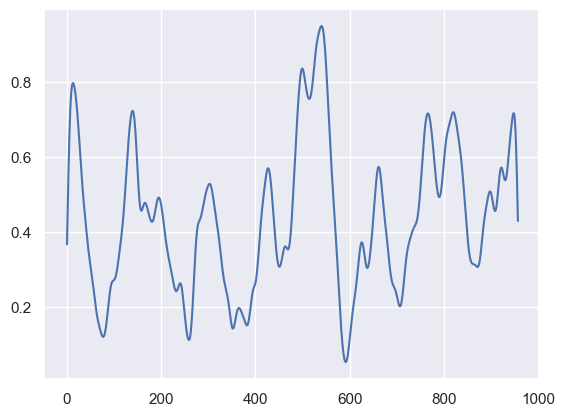

[1343, 2603, 6613, 9413, 10693]
[3250]
12001
cuda
epoch 1,loss = 0.99724364
epoch 2,loss = 0.99723947
epoch 3,loss = 0.99723530
epoch 4,loss = 0.99723130
epoch 5,loss = 0.99722725
epoch 6,loss = 0.99722320
epoch 7,loss = 0.99721926
epoch 8,loss = 0.99721545
epoch 9,loss = 0.99721158
epoch 10,loss = 0.99720794
epoch 11,loss = 0.99720412
epoch 12,loss = 0.99720055
epoch 13,loss = 0.99719697
epoch 14,loss = 0.99719357
epoch 15,loss = 0.99719006
epoch 16,loss = 0.99718666
epoch 17,loss = 0.99718344
epoch 18,loss = 0.99718016
epoch 19,loss = 0.99717695


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 20,loss = 0.99717379
epoch 21,loss = 0.99717075
epoch 22,loss = 0.99716777
epoch 23,loss = 0.99716479
epoch 24,loss = 0.99716187
epoch 25,loss = 0.99715906
epoch 26,loss = 0.99715632
epoch 27,loss = 0.99715370
epoch 28,loss = 0.99715108
epoch 29,loss = 0.99714839
epoch 30,loss = 0.99714589
epoch 31,loss = 0.99714351
epoch 32,loss = 0.99714100
epoch 33,loss = 0.99713868
epoch 34,loss = 0.99713641
epoch 35,loss = 0.99713421
epoch 36,loss = 0.99713200
epoch 37,loss = 0.99712986
epoch 38,loss = 0.99712777
epoch 39,loss = 0.99712574
epoch 40,loss = 0.99712384
epoch 41,loss = 0.99712187
epoch 42,loss = 0.99712002
epoch 43,loss = 0.99711818
epoch 44,loss = 0.99711651
epoch 45,loss = 0.99711484
epoch 46,loss = 0.99711311
epoch 47,loss = 0.99711150
epoch 48,loss = 0.99710983
epoch 49,loss = 0.99710840
epoch 50,loss = 0.99710685
epoch 51,loss = 0.99710542
epoch 52,loss = 0.99710399
epoch 53,loss = 0.99710274
epoch 54,loss = 0.99710137
epoch 55,loss = 0.99710006
epoch 56,loss = 0.99709892
e

epoch 324,loss = 0.64860523
epoch 325,loss = 0.64814192
epoch 326,loss = 0.64768934
epoch 327,loss = 0.64724976
epoch 328,loss = 0.64682132
epoch 329,loss = 0.64640409
epoch 330,loss = 0.64599198
epoch 331,loss = 0.64558810
epoch 332,loss = 0.64519376
epoch 333,loss = 0.64480489
epoch 334,loss = 0.64442182
epoch 335,loss = 0.64404523
epoch 336,loss = 0.64367509
epoch 337,loss = 0.64331055
epoch 338,loss = 0.64295137
epoch 339,loss = 0.64259690
epoch 340,loss = 0.64224726
epoch 341,loss = 0.64190215
epoch 342,loss = 0.64156085
epoch 343,loss = 0.64122361
epoch 344,loss = 0.64088911
epoch 345,loss = 0.64055741
epoch 346,loss = 0.64022899
epoch 347,loss = 0.63990349
epoch 348,loss = 0.63958132
epoch 349,loss = 0.63926268
epoch 350,loss = 0.63894612
epoch 351,loss = 0.63863271
epoch 352,loss = 0.63832259
epoch 353,loss = 0.63801634
epoch 354,loss = 0.63771254
epoch 355,loss = 0.63741183
epoch 356,loss = 0.63711387
epoch 357,loss = 0.63681883
epoch 358,loss = 0.63652688
epoch 359,loss = 0.6

epoch 621,loss = 0.60706288
epoch 622,loss = 0.60701543
epoch 623,loss = 0.60696822
epoch 624,loss = 0.60692114
epoch 625,loss = 0.60687417
epoch 626,loss = 0.60682750
epoch 627,loss = 0.60678107
epoch 628,loss = 0.60673487
epoch 629,loss = 0.60668886
epoch 630,loss = 0.60664320
epoch 631,loss = 0.60659766
epoch 632,loss = 0.60655248
epoch 633,loss = 0.60650748
epoch 634,loss = 0.60646266
epoch 635,loss = 0.60641795
epoch 636,loss = 0.60637361
epoch 637,loss = 0.60632926
epoch 638,loss = 0.60628521
epoch 639,loss = 0.60624123
epoch 640,loss = 0.60619748
epoch 641,loss = 0.60615391
epoch 642,loss = 0.60611063
epoch 643,loss = 0.60606754
epoch 644,loss = 0.60602468
epoch 645,loss = 0.60598201
epoch 646,loss = 0.60593957
epoch 647,loss = 0.60589731
epoch 648,loss = 0.60585523
epoch 649,loss = 0.60581344
epoch 650,loss = 0.60577178
epoch 651,loss = 0.60573035
epoch 652,loss = 0.60568917
epoch 653,loss = 0.60564804
epoch 654,loss = 0.60560709
epoch 655,loss = 0.60556644
epoch 656,loss = 0.6

epoch 936,loss = 0.59881437
epoch 937,loss = 0.59880006
epoch 938,loss = 0.59878582
epoch 939,loss = 0.59877163
epoch 940,loss = 0.59875745
epoch 941,loss = 0.59874338
epoch 942,loss = 0.59872937
epoch 943,loss = 0.59871542
epoch 944,loss = 0.59870148
epoch 945,loss = 0.59868759
epoch 946,loss = 0.59867352
epoch 947,loss = 0.59865963
epoch 948,loss = 0.59864575
epoch 949,loss = 0.59863198
epoch 950,loss = 0.59861827
epoch 951,loss = 0.59860444
epoch 952,loss = 0.59859073
epoch 953,loss = 0.59857690
epoch 954,loss = 0.59856331
epoch 955,loss = 0.59854972
epoch 956,loss = 0.59853607
epoch 957,loss = 0.59852248
epoch 958,loss = 0.59850901
epoch 959,loss = 0.59849554
epoch 960,loss = 0.59848195
epoch 961,loss = 0.59846860
epoch 962,loss = 0.59845519
epoch 963,loss = 0.59844190
epoch 964,loss = 0.59842861
epoch 965,loss = 0.59841537
epoch 966,loss = 0.59840214
epoch 967,loss = 0.59838897
epoch 968,loss = 0.59837580
epoch 969,loss = 0.59836262
epoch 970,loss = 0.59834945
epoch 971,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


torch.Size([1198, 1, 25])
1.0
Epoch 200:   loss= 0.17343  cluster difference= 1.0
Epoch 400:   loss= 0.17616  cluster difference= 0.10851419031719532
Epoch 600:   loss= 0.17685  cluster difference= 0.048414023372287146
Epoch 800:   loss= 0.17676  cluster difference= 0.03171953255425709
Epoch 1000:   loss= 0.17637  cluster difference= 0.02337228714524207
Epoch 1200:   loss= 0.1759  cluster difference= 0.022537562604340568
Epoch 1400:   loss= 0.17545  cluster difference= 0.01335559265442404
Epoch 1600:   loss= 0.17506  cluster difference= 0.009181969949916527
[1 1 1 ... 4 4 4]


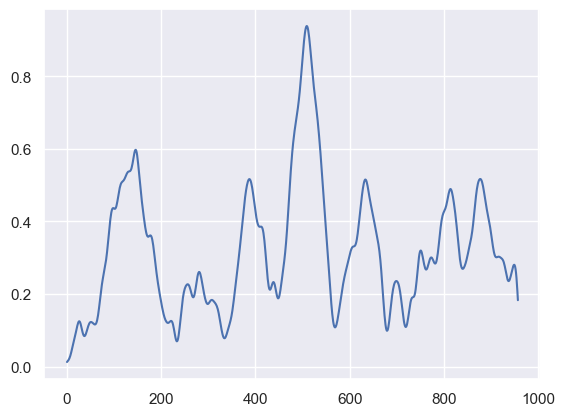

[6303]
[3250]
40000
cuda
epoch 1,loss = 1.00642419
epoch 2,loss = 1.00592756
epoch 3,loss = 1.00545716
epoch 4,loss = 1.00501466
epoch 5,loss = 1.00459492
epoch 6,loss = 1.00419843
epoch 7,loss = 1.00382459
epoch 8,loss = 1.00347257


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 9,loss = 1.00314152
epoch 10,loss = 1.00283170
epoch 11,loss = 1.00254142
epoch 12,loss = 1.00226927
epoch 13,loss = 1.00201464
epoch 14,loss = 1.00177920
epoch 15,loss = 1.00156665
epoch 16,loss = 1.00137591
epoch 17,loss = 1.00119221
epoch 18,loss = 1.00101686
epoch 19,loss = 1.00085247
epoch 20,loss = 1.00069845
epoch 21,loss = 1.00055397
epoch 22,loss = 1.00041842
epoch 23,loss = 1.00030077
epoch 24,loss = 1.00021064
epoch 25,loss = 1.00012290
epoch 26,loss = 1.00004590
epoch 27,loss = 0.99998564
epoch 28,loss = 0.99993175
epoch 29,loss = 0.99987167
epoch 30,loss = 0.99981558
epoch 31,loss = 0.99976349
epoch 32,loss = 0.99971402
epoch 33,loss = 0.99966627
epoch 34,loss = 0.99962014
epoch 35,loss = 0.99957567
epoch 36,loss = 0.99953270
epoch 37,loss = 0.99949104
epoch 38,loss = 0.99945033
epoch 39,loss = 0.99941021
epoch 40,loss = 0.99936998
epoch 41,loss = 0.99932867
epoch 42,loss = 0.99928421
epoch 43,loss = 0.99923384
epoch 44,loss = 0.99917340
epoch 45,loss = 0.99910176
ep

epoch 312,loss = 0.62860495
epoch 313,loss = 0.62855995
epoch 314,loss = 0.62851495
epoch 315,loss = 0.62847000
epoch 316,loss = 0.62842506
epoch 317,loss = 0.62838018
epoch 318,loss = 0.62833536
epoch 319,loss = 0.62829053
epoch 320,loss = 0.62824571
epoch 321,loss = 0.62820083
epoch 322,loss = 0.62815595
epoch 323,loss = 0.62811106
epoch 324,loss = 0.62806624
epoch 325,loss = 0.62802136
epoch 326,loss = 0.62797654
epoch 327,loss = 0.62793154
epoch 328,loss = 0.62788635
epoch 329,loss = 0.62784111
epoch 330,loss = 0.62779588
epoch 331,loss = 0.62775052
epoch 332,loss = 0.62770522
epoch 333,loss = 0.62765986
epoch 334,loss = 0.62761444
epoch 335,loss = 0.62756902
epoch 336,loss = 0.62752348
epoch 337,loss = 0.62747794
epoch 338,loss = 0.62743241
epoch 339,loss = 0.62738675
epoch 340,loss = 0.62734091
epoch 341,loss = 0.62729508
epoch 342,loss = 0.62724912
epoch 343,loss = 0.62720317
epoch 344,loss = 0.62715715
epoch 345,loss = 0.62711108
epoch 346,loss = 0.62706500
epoch 347,loss = 0.6

epoch 626,loss = 0.60897535
epoch 627,loss = 0.60889107
epoch 628,loss = 0.60880691
epoch 629,loss = 0.60872287
epoch 630,loss = 0.60863900
epoch 631,loss = 0.60855442
epoch 632,loss = 0.60846990
epoch 633,loss = 0.60838538
epoch 634,loss = 0.60830086
epoch 635,loss = 0.60821640
epoch 636,loss = 0.60813212
epoch 637,loss = 0.60804790
epoch 638,loss = 0.60796362
epoch 639,loss = 0.60787946
epoch 640,loss = 0.60779554
epoch 641,loss = 0.60771161
epoch 642,loss = 0.60762775
epoch 643,loss = 0.60754424
epoch 644,loss = 0.60746074
epoch 645,loss = 0.60737735
epoch 646,loss = 0.60729402
epoch 647,loss = 0.60721099
epoch 648,loss = 0.60712820
epoch 649,loss = 0.60704547
epoch 650,loss = 0.60696286
epoch 651,loss = 0.60688066
epoch 652,loss = 0.60679871
epoch 653,loss = 0.60671699
epoch 654,loss = 0.60663545
epoch 655,loss = 0.60655391
epoch 656,loss = 0.60647243
epoch 657,loss = 0.60639107
epoch 658,loss = 0.60631037
epoch 659,loss = 0.60622990
epoch 660,loss = 0.60614961
epoch 661,loss = 0.6

epoch 940,loss = 0.58580834
epoch 941,loss = 0.58573860
epoch 942,loss = 0.58566886
epoch 943,loss = 0.58559936
epoch 944,loss = 0.58552980
epoch 945,loss = 0.58546036
epoch 946,loss = 0.58539087
epoch 947,loss = 0.58532107
epoch 948,loss = 0.58525115
epoch 949,loss = 0.58518153
epoch 950,loss = 0.58511209
epoch 951,loss = 0.58504313
epoch 952,loss = 0.58497435
epoch 953,loss = 0.58490568
epoch 954,loss = 0.58483714
epoch 955,loss = 0.58476877
epoch 956,loss = 0.58470035
epoch 957,loss = 0.58463192
epoch 958,loss = 0.58456379
epoch 959,loss = 0.58449596
epoch 960,loss = 0.58442783
epoch 961,loss = 0.58435977
epoch 962,loss = 0.58429176
epoch 963,loss = 0.58422363
epoch 964,loss = 0.58415544
epoch 965,loss = 0.58408731
epoch 966,loss = 0.58401918
epoch 967,loss = 0.58395106
epoch 968,loss = 0.58388293
epoch 969,loss = 0.58381486
epoch 970,loss = 0.58374697
epoch 971,loss = 0.58367938
epoch 972,loss = 0.58361179
epoch 973,loss = 0.58354408
epoch 974,loss = 0.58347613
epoch 975,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([998, 1, 100])
1.0
Epoch 200:   loss= 0.17276  cluster difference= 1.0
Epoch 400:   loss= 0.18741  cluster difference= 0.021042084168336674
Epoch 600:   loss= 0.19438  cluster difference= 0.03707414829659319
Epoch 800:   loss= 0.19782  cluster difference= 0.036072144288577156
Epoch 1000:   loss= 0.19945  cluster difference= 0.025050100200400802
Epoch 1200:   loss= 0.20009  cluster difference= 0.014028056112224449
Epoch 1400:   loss= 0.20012  cluster difference= 0.008016032064128256
[1 4 5 7 6 1 4 5 5 6 1 4 5 5 6 1 4 5 5 3 1 4 5 5 3 1 4 5 5 3 1 4 0 5 3 1 4
 0 5 3 1 1 0 5 3 1 1 0 5 3 1 1 0 5 3 1 1 0 5 6 1 1 0 5 6 1 1 0 5 3 1 1 4 5
 2 1 1 4 5 7 6 1 4 5 5 6 1 4 0 5 3 1 1 0 5 2 1 1 0 5 7 1 1 0 5 5 6 1 4 5 5
 3 1 1 0 5 2 1 1 0 5 7 6 1 4 5 5 3 1 4 0 5 3 1 1 0 5 2 1 1 0 5 7 1 1 4 5 7
 6 1 4 5 5 6 1 4 0 5 3 1 4 0 5 3 1 4 0 5 3 1 1 0 5 3 1 1 0 5 3 1 1 0 5 6 1
 1 0 7 6 1 1 0 7 6 1 1 0 7 1 1 4 0 2 1 1 4 0 3 1 1 4 0 3 1 1 4 5 3 1 1 0 7
 6 1 4 0 7 1 1 4 5 2 1 1 4 5 2 1 1 0 5 3 1 1 0 5 3 1

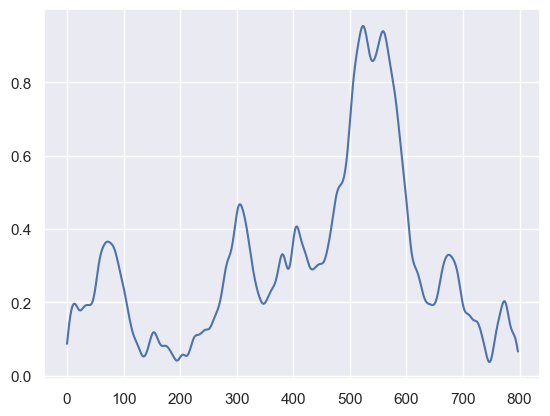

[24970]
[25000]
40000
cuda
epoch 1,loss = 0.99755216
epoch 2,loss = 0.99747342
epoch 3,loss = 0.99739224
epoch 4,loss = 0.99730849
epoch 5,loss = 0.99722201
epoch 6,loss = 0.99713266
epoch 7,loss = 0.99704003
epoch 8,loss = 0.99694395
epoch 9,loss = 0.99684387
epoch 10,loss = 0.99673921
epoch 11,loss = 0.99662930
epoch 12,loss = 0.99651414
epoch 13,loss = 0.99639517
epoch 14,loss = 0.99627477
epoch 15,loss = 0.99615687


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 16,loss = 0.99604225
epoch 17,loss = 0.99592769
epoch 18,loss = 0.99580979
epoch 19,loss = 0.99568409
epoch 20,loss = 0.99554998
epoch 21,loss = 0.99540460
epoch 22,loss = 0.99524742
epoch 23,loss = 0.99507689
epoch 24,loss = 0.99489367
epoch 25,loss = 0.99469769
epoch 26,loss = 0.99449146
epoch 27,loss = 0.99427795
epoch 28,loss = 0.99405879
epoch 29,loss = 0.99383456
epoch 30,loss = 0.99360818
epoch 31,loss = 0.99337900
epoch 32,loss = 0.99314541
epoch 33,loss = 0.99290431
epoch 34,loss = 0.99265581
epoch 35,loss = 0.99239939
epoch 36,loss = 0.99213398
epoch 37,loss = 0.99185967
epoch 38,loss = 0.99157649
epoch 39,loss = 0.99128336
epoch 40,loss = 0.99097872
epoch 41,loss = 0.99066311
epoch 42,loss = 0.99033570
epoch 43,loss = 0.98999470
epoch 44,loss = 0.98963958
epoch 45,loss = 0.98926920
epoch 46,loss = 0.98887998
epoch 47,loss = 0.98846525
epoch 48,loss = 0.98801702
epoch 49,loss = 0.98751712
epoch 50,loss = 0.98693562
epoch 51,loss = 0.98622286
epoch 52,loss = 0.98529202
e

epoch 324,loss = 0.69678754
epoch 325,loss = 0.69667774
epoch 326,loss = 0.69656849
epoch 327,loss = 0.69645965
epoch 328,loss = 0.69635099
epoch 329,loss = 0.69624281
epoch 330,loss = 0.69613492
epoch 331,loss = 0.69602740
epoch 332,loss = 0.69592023
epoch 333,loss = 0.69581360
epoch 334,loss = 0.69570696
epoch 335,loss = 0.69560087
epoch 336,loss = 0.69549555
epoch 337,loss = 0.69539088
epoch 338,loss = 0.69528711
epoch 339,loss = 0.69518399
epoch 340,loss = 0.69508141
epoch 341,loss = 0.69497907
epoch 342,loss = 0.69487727
epoch 343,loss = 0.69477606
epoch 344,loss = 0.69467515
epoch 345,loss = 0.69457465
epoch 346,loss = 0.69447452
epoch 347,loss = 0.69437456
epoch 348,loss = 0.69427496
epoch 349,loss = 0.69417602
epoch 350,loss = 0.69407779
epoch 351,loss = 0.69397992
epoch 352,loss = 0.69388241
epoch 353,loss = 0.69378549
epoch 354,loss = 0.69368887
epoch 355,loss = 0.69359237
epoch 356,loss = 0.69349670
epoch 357,loss = 0.69340152
epoch 358,loss = 0.69330627
epoch 359,loss = 0.6

epoch 630,loss = 0.67702973
epoch 631,loss = 0.67699730
epoch 632,loss = 0.67696500
epoch 633,loss = 0.67693281
epoch 634,loss = 0.67690086
epoch 635,loss = 0.67686886
epoch 636,loss = 0.67683715
epoch 637,loss = 0.67680562
epoch 638,loss = 0.67677438
epoch 639,loss = 0.67674369
epoch 640,loss = 0.67671347
epoch 641,loss = 0.67668372
epoch 642,loss = 0.67665428
epoch 643,loss = 0.67662507
epoch 644,loss = 0.67659605
epoch 645,loss = 0.67656720
epoch 646,loss = 0.67653865
epoch 647,loss = 0.67651021
epoch 648,loss = 0.67648208
epoch 649,loss = 0.67645401
epoch 650,loss = 0.67642617
epoch 651,loss = 0.67639846
epoch 652,loss = 0.67637098
epoch 653,loss = 0.67634350
epoch 654,loss = 0.67631632
epoch 655,loss = 0.67628926
epoch 656,loss = 0.67626238
epoch 657,loss = 0.67623580
epoch 658,loss = 0.67620915
epoch 659,loss = 0.67618304
epoch 660,loss = 0.67615718
epoch 661,loss = 0.67613149
epoch 662,loss = 0.67610615
epoch 663,loss = 0.67608124
epoch 664,loss = 0.67605644
epoch 665,loss = 0.6

epoch 948,loss = 0.67059577
epoch 949,loss = 0.67056805
epoch 950,loss = 0.67054015
epoch 951,loss = 0.67051196
epoch 952,loss = 0.67048335
epoch 953,loss = 0.67045444
epoch 954,loss = 0.67042542
epoch 955,loss = 0.67039597
epoch 956,loss = 0.67036641
epoch 957,loss = 0.67033708
epoch 958,loss = 0.67030734
epoch 959,loss = 0.67027795
epoch 960,loss = 0.67024875
epoch 961,loss = 0.67021936
epoch 962,loss = 0.67018992
epoch 963,loss = 0.67016053
epoch 964,loss = 0.67013097
epoch 965,loss = 0.67010158
epoch 966,loss = 0.67007190
epoch 967,loss = 0.67004168
epoch 968,loss = 0.67001128
epoch 969,loss = 0.66998094
epoch 970,loss = 0.66995078
epoch 971,loss = 0.66992074
epoch 972,loss = 0.66989040
epoch 973,loss = 0.66985977
epoch 974,loss = 0.66982913
epoch 975,loss = 0.66979837
epoch 976,loss = 0.66976738
epoch 977,loss = 0.66973567
epoch 978,loss = 0.66970301
epoch 979,loss = 0.66966903
epoch 980,loss = 0.66963446
epoch 981,loss = 0.66959971
epoch 982,loss = 0.66956496
epoch 983,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([998, 1, 100])
1.0
Epoch 200:   loss= 0.17956  cluster difference= 1.0
Epoch 400:   loss= 0.17931  cluster difference= 0.011022044088176353
Epoch 600:   loss= 0.17934  cluster difference= 0.01603206412825651
Epoch 800:   loss= 0.17963  cluster difference= 0.028056112224448898
Epoch 1000:   loss= 0.18027  cluster difference= 0.02404809619238477
Epoch 1200:   loss= 0.18122  cluster difference= 0.028056112224448898
Epoch 1400:   loss= 0.18215  cluster difference= 0.013026052104208416
Epoch 1600:   loss= 0.18282  cluster difference= 0.01002004008016032
Epoch 1800:   loss= 0.18324  cluster difference= 0.009018036072144289
[1 1 7 6 4 1 1 7 6 4 1 1 7 6 0 1 1 7 6 0 1 1 7 2 0 3 1 7 2 0 1 1 7 2 0 1 1
 7 2 0 3 1 7 2 0 3 1 7 2 0 3 1 7 2 0 1 1 7 6 0 1 1 7 6 0 1 1 7 2 0 3 1 1 7
 5 3 1 1 7 5 4 1 1 7 6 0 1 1 7 2 0 3 1 1 7 5 3 1 1 7 5 4 1 1 7 6 4 1 1 7 2
 0 3 1 1 7 5 3 1 1 7 5 4 1 1 7 6 0 1 1 1 2 0 3 1 1 7 5 3 1 1 7 5 4 1 1 7 6
 4 1 1 7 6 0 1 1 7 2 0 1 1 7 6 0 1 1 7 2 0 1 1 7 2 0 3 1 7 2 0 1

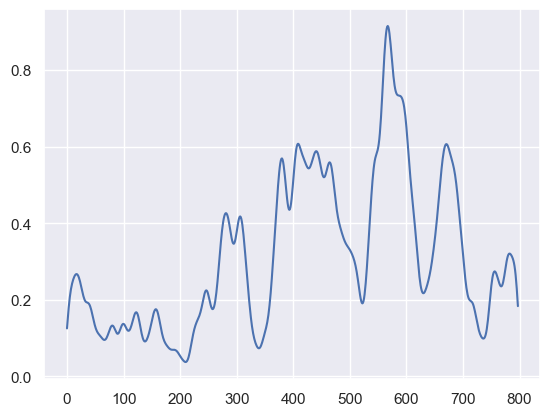

[20410, 26730, 30890]
[25000]
10001
cuda
epoch 1,loss = 1.01105452
epoch 2,loss = 1.01104569
epoch 3,loss = 1.01103640
epoch 4,loss = 1.01102638
epoch 5,loss = 1.01101649
epoch 6,loss = 1.01100779
epoch 7,loss = 1.01100039
epoch 8,loss = 1.01099384
epoch 9,loss = 1.01098800
epoch 10,loss = 1.01098311
epoch 11,loss = 1.01097870
epoch 12,loss = 1.01097488
epoch 13,loss = 1.01097107
epoch 14,loss = 1.01096749
epoch 15,loss = 1.01096380
epoch 16,loss = 1.01096022
epoch 17,loss = 1.01095676
epoch 18,loss = 1.01095331
epoch 19,loss = 1.01094985
epoch 20,loss = 1.01094663
epoch 21,loss = 1.01094329
epoch 22,loss = 1.01094007
epoch 23,loss = 1.01093709
epoch 24,loss = 1.01093400
epoch 25,loss = 1.01093102
epoch 26,loss = 1.01092803
epoch 27,loss = 1.01092517
epoch 28,loss = 1.01092243
epoch 29,loss = 1.01091957
epoch 30,loss = 1.01091695
epoch 31,loss = 1.01091421
epoch 32,loss = 1.01091170
epoch 33,loss = 1.01090908
epoch 34,loss = 1.01090658
epoch 35,loss = 1.01090419
epoch 36,loss = 1.01090

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 37,loss = 1.01089942
epoch 38,loss = 1.01089716
epoch 39,loss = 1.01089489
epoch 40,loss = 1.01089275
epoch 41,loss = 1.01089072
epoch 42,loss = 1.01088870
epoch 43,loss = 1.01088655
epoch 44,loss = 1.01088464
epoch 45,loss = 1.01088262
epoch 46,loss = 1.01088083
epoch 47,loss = 1.01087892
epoch 48,loss = 1.01087713
epoch 49,loss = 1.01087546
epoch 50,loss = 1.01087368
epoch 51,loss = 1.01087201
epoch 52,loss = 1.01087046
epoch 53,loss = 1.01086879
epoch 54,loss = 1.01086724
epoch 55,loss = 1.01086581
epoch 56,loss = 1.01086426
epoch 57,loss = 1.01086295
epoch 58,loss = 1.01086152
epoch 59,loss = 1.01086009
epoch 60,loss = 1.01085889
epoch 61,loss = 1.01085758
epoch 62,loss = 1.01085627
epoch 63,loss = 1.01085508
epoch 64,loss = 1.01085389
epoch 65,loss = 1.01085281
epoch 66,loss = 1.01085162
epoch 67,loss = 1.01085055
epoch 68,loss = 1.01084948
epoch 69,loss = 1.01084840
epoch 70,loss = 1.01084745
epoch 71,loss = 1.01084650
epoch 72,loss = 1.01084542
epoch 73,loss = 1.01084447
e

epoch 335,loss = 0.64346635
epoch 336,loss = 0.64272898
epoch 337,loss = 0.64201027
epoch 338,loss = 0.64134812
epoch 339,loss = 0.64073420
epoch 340,loss = 0.64015633
epoch 341,loss = 0.63957661
epoch 342,loss = 0.63906360
epoch 343,loss = 0.63858724
epoch 344,loss = 0.63810045
epoch 345,loss = 0.63763052
epoch 346,loss = 0.63721669
epoch 347,loss = 0.63682050
epoch 348,loss = 0.63642496
epoch 349,loss = 0.63602692
epoch 350,loss = 0.63563591
epoch 351,loss = 0.63525069
epoch 352,loss = 0.63487560
epoch 353,loss = 0.63450265
epoch 354,loss = 0.63413030
epoch 355,loss = 0.63376576
epoch 356,loss = 0.63340741
epoch 357,loss = 0.63305962
epoch 358,loss = 0.63272506
epoch 359,loss = 0.63239753
epoch 360,loss = 0.63208872
epoch 361,loss = 0.63178521
epoch 362,loss = 0.63149011
epoch 363,loss = 0.63121200
epoch 364,loss = 0.63095087
epoch 365,loss = 0.63070351
epoch 366,loss = 0.63046873
epoch 367,loss = 0.63024729
epoch 368,loss = 0.63003588
epoch 369,loss = 0.62983334
epoch 370,loss = 0.6

epoch 650,loss = 0.60648102
epoch 651,loss = 0.60640579
epoch 652,loss = 0.60632956
epoch 653,loss = 0.60625237
epoch 654,loss = 0.60617542
epoch 655,loss = 0.60609853
epoch 656,loss = 0.60602129
epoch 657,loss = 0.60594362
epoch 658,loss = 0.60586590
epoch 659,loss = 0.60578930
epoch 660,loss = 0.60571337
epoch 661,loss = 0.60563743
epoch 662,loss = 0.60555995
epoch 663,loss = 0.60548228
epoch 664,loss = 0.60540468
epoch 665,loss = 0.60532820
epoch 666,loss = 0.60525131
epoch 667,loss = 0.60517371
epoch 668,loss = 0.60509497
epoch 669,loss = 0.60501474
epoch 670,loss = 0.60493362
epoch 671,loss = 0.60485268
epoch 672,loss = 0.60477203
epoch 673,loss = 0.60469162
epoch 674,loss = 0.60461062
epoch 675,loss = 0.60452825
epoch 676,loss = 0.60444373
epoch 677,loss = 0.60435808
epoch 678,loss = 0.60427135
epoch 679,loss = 0.60418147
epoch 680,loss = 0.60408914
epoch 681,loss = 0.60399657
epoch 682,loss = 0.60390264
epoch 683,loss = 0.60380703
epoch 684,loss = 0.60371077
epoch 685,loss = 0.6

epoch 953,loss = 0.57931143
epoch 954,loss = 0.57926410
epoch 955,loss = 0.57921672
epoch 956,loss = 0.57916963
epoch 957,loss = 0.57912236
epoch 958,loss = 0.57907516
epoch 959,loss = 0.57902884
epoch 960,loss = 0.57898182
epoch 961,loss = 0.57893544
epoch 962,loss = 0.57888895
epoch 963,loss = 0.57884258
epoch 964,loss = 0.57879615
epoch 965,loss = 0.57874978
epoch 966,loss = 0.57870340
epoch 967,loss = 0.57865715
epoch 968,loss = 0.57861090
epoch 969,loss = 0.57856458
epoch 970,loss = 0.57851851
epoch 971,loss = 0.57847226
epoch 972,loss = 0.57842606
epoch 973,loss = 0.57837993
epoch 974,loss = 0.57833409
epoch 975,loss = 0.57828838
epoch 976,loss = 0.57824260
epoch 977,loss = 0.57819694
epoch 978,loss = 0.57815111
epoch 979,loss = 0.57810438
epoch 980,loss = 0.57805789
epoch 981,loss = 0.57801121
epoch 982,loss = 0.57796448
epoch 983,loss = 0.57791793
epoch 984,loss = 0.57787150
epoch 985,loss = 0.57782513
epoch 986,loss = 0.57777900
epoch 987,loss = 0.57773280
epoch 988,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([311, 1, 80])
1.0
Epoch 200:   loss= 0.22242  cluster difference= 1.0
Epoch 400:   loss= 0.2209  cluster difference= 0.022508038585209004
Epoch 600:   loss= 0.22007  cluster difference= 0.022508038585209004
Epoch 800:   loss= 0.21975  cluster difference= 0.028938906752411574
Epoch 1000:   loss= 0.21945  cluster difference= 0.06109324758842444
Epoch 1200:   loss= 0.21921  cluster difference= 0.03215434083601286
Epoch 1400:   loss= 0.2189  cluster difference= 0.04180064308681672
Epoch 1600:   loss= 0.21832  cluster difference= 0.01929260450160772
Epoch 1800:   loss= 0.21761  cluster difference= 0.01607717041800643
Epoch 2000:   loss= 0.21677  cluster difference= 0.01607717041800643
Epoch 2200:   loss= 0.21589  cluster difference= 0.022508038585209004
Epoch 2400:   loss= 0.21499  cluster difference= 0.0
[2 2 2 2 2 2 7 5 2 7 5 2 3 2 1 6 2 3 2 0 4 1 3 2 7 5 1 6 2 3 2 0 4 2 3 2 0
 4 1 6 2 7 5 1 6 2 3 2 0 4 1 6 2 3 2 0 4 1 3 2 0 4 1 3 2 7 2 7 5 0 4 1 6 2
 7 5 1 6 2 7 5 0 4 1 6 2 7 

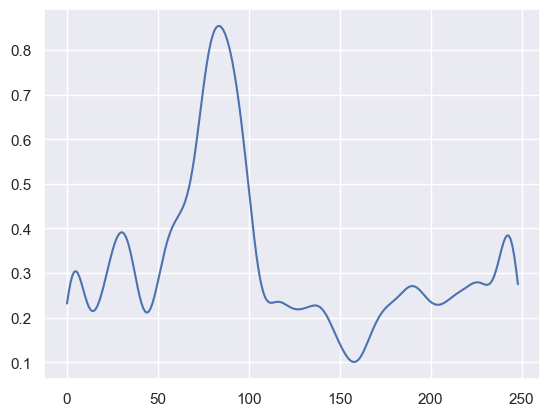

[3720]
[3800 6800]
10001
cuda
epoch 1,loss = 1.00548506
epoch 2,loss = 1.00536311
epoch 3,loss = 1.00524545
epoch 4,loss = 1.00513184
epoch 5,loss = 1.00502241
epoch 6,loss = 1.00491703
epoch 7,loss = 1.00481594
epoch 8,loss = 1.00471914
epoch 9,loss = 1.00462675
epoch 10,loss = 1.00453842
epoch 11,loss = 1.00445414
epoch 12,loss = 1.00437331
epoch 13,loss = 1.00429595
epoch 14,loss = 1.00422180
epoch 15,loss = 1.00415015
epoch 16,loss = 1.00408053
epoch 17,loss = 1.00401199
epoch 18,loss = 1.00394881
epoch 19,loss = 1.00392354
epoch 20,loss = 1.00390494
epoch 21,loss = 1.00386810
epoch 22,loss = 1.00381887
epoch 23,loss = 1.00375712
epoch 24,loss = 1.00368345
epoch 25,loss = 1.00360024
epoch 26,loss = 1.00350881
epoch 27,loss = 1.00341010
epoch 28,loss = 1.00330675
epoch 29,loss = 1.00320363
epoch 30,loss = 1.00309968
epoch 31,loss = 1.00299668
epoch 32,loss = 1.00288677
epoch 33,loss = 1.00275314
epoch 34,loss = 1.00259066
epoch 35,loss = 1.00238597
epoch 36,loss = 1.00214779
epoch 3

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 47,loss = 0.99505490
epoch 48,loss = 0.99376661
epoch 49,loss = 0.99234539
epoch 50,loss = 0.99079579
epoch 51,loss = 0.98910546
epoch 52,loss = 0.98725462
epoch 53,loss = 0.98524886
epoch 54,loss = 0.98307562
epoch 55,loss = 0.98072141
epoch 56,loss = 0.97816885
epoch 57,loss = 0.97542626
epoch 58,loss = 0.97247678
epoch 59,loss = 0.96931803
epoch 60,loss = 0.96595168
epoch 61,loss = 0.96237195
epoch 62,loss = 0.95855880
epoch 63,loss = 0.95451987
epoch 64,loss = 0.95025730
epoch 65,loss = 0.94577223
epoch 66,loss = 0.94108444
epoch 67,loss = 0.93619305
epoch 68,loss = 0.93112373
epoch 69,loss = 0.92590219
epoch 70,loss = 0.92054492
epoch 71,loss = 0.91509145
epoch 72,loss = 0.90956700
epoch 73,loss = 0.90400213
epoch 74,loss = 0.89843231
epoch 75,loss = 0.89289558
epoch 76,loss = 0.88744211
epoch 77,loss = 0.88210452
epoch 78,loss = 0.87692422
epoch 79,loss = 0.87193578
epoch 80,loss = 0.86714113
epoch 81,loss = 0.86251473
epoch 82,loss = 0.85804266
epoch 83,loss = 0.85372716
e

epoch 352,loss = 0.66462457
epoch 353,loss = 0.66456157
epoch 354,loss = 0.66449881
epoch 355,loss = 0.66443574
epoch 356,loss = 0.66437274
epoch 357,loss = 0.66430962
epoch 358,loss = 0.66424680
epoch 359,loss = 0.66418338
epoch 360,loss = 0.66411996
epoch 361,loss = 0.66405660
epoch 362,loss = 0.66399324
epoch 363,loss = 0.66393012
epoch 364,loss = 0.66386694
epoch 365,loss = 0.66380483
epoch 366,loss = 0.66374296
epoch 367,loss = 0.66368133
epoch 368,loss = 0.66362053
epoch 369,loss = 0.66355973
epoch 370,loss = 0.66349900
epoch 371,loss = 0.66343743
epoch 372,loss = 0.66337365
epoch 373,loss = 0.66330838
epoch 374,loss = 0.66324294
epoch 375,loss = 0.66317707
epoch 376,loss = 0.66311198
epoch 377,loss = 0.66304648
epoch 378,loss = 0.66298008
epoch 379,loss = 0.66291195
epoch 380,loss = 0.66284287
epoch 381,loss = 0.66277331
epoch 382,loss = 0.66270375
epoch 383,loss = 0.66263407
epoch 384,loss = 0.66256273
epoch 385,loss = 0.66248971
epoch 386,loss = 0.66241550
epoch 387,loss = 0.6

epoch 646,loss = 0.60144246
epoch 647,loss = 0.60117114
epoch 648,loss = 0.60089743
epoch 649,loss = 0.60061806
epoch 650,loss = 0.60034007
epoch 651,loss = 0.60006183
epoch 652,loss = 0.59978122
epoch 653,loss = 0.59949720
epoch 654,loss = 0.59921318
epoch 655,loss = 0.59892589
epoch 656,loss = 0.59863240
epoch 657,loss = 0.59833032
epoch 658,loss = 0.59802306
epoch 659,loss = 0.59771669
epoch 660,loss = 0.59741074
epoch 661,loss = 0.59710294
epoch 662,loss = 0.59679258
epoch 663,loss = 0.59647900
epoch 664,loss = 0.59616148
epoch 665,loss = 0.59583855
epoch 666,loss = 0.59551084
epoch 667,loss = 0.59517848
epoch 668,loss = 0.59484136
epoch 669,loss = 0.59449929
epoch 670,loss = 0.59415537
epoch 671,loss = 0.59380633
epoch 672,loss = 0.59345341
epoch 673,loss = 0.59309894
epoch 674,loss = 0.59274203
epoch 675,loss = 0.59237415
epoch 676,loss = 0.59200442
epoch 677,loss = 0.59163314
epoch 678,loss = 0.59126294
epoch 679,loss = 0.59089249
epoch 680,loss = 0.59052527
epoch 681,loss = 0.5

epoch 971,loss = 0.50468826
epoch 972,loss = 0.50455284
epoch 973,loss = 0.50441694
epoch 974,loss = 0.50427890
epoch 975,loss = 0.50414509
epoch 976,loss = 0.50401092
epoch 977,loss = 0.50387222
epoch 978,loss = 0.50374186
epoch 979,loss = 0.50360715
epoch 980,loss = 0.50347096
epoch 981,loss = 0.50333363
epoch 982,loss = 0.50319570
epoch 983,loss = 0.50305706
epoch 984,loss = 0.50292420
epoch 985,loss = 0.50278670
epoch 986,loss = 0.50265259
epoch 987,loss = 0.50252044
epoch 988,loss = 0.50238431
epoch 989,loss = 0.50224382
epoch 990,loss = 0.50211865
epoch 991,loss = 0.50198990
epoch 992,loss = 0.50186050
epoch 993,loss = 0.50173247
epoch 994,loss = 0.50160360
epoch 995,loss = 0.50147402
epoch 996,loss = 0.50134599
epoch 997,loss = 0.50121927
epoch 998,loss = 0.50109243
epoch 999,loss = 0.50096542
epoch 1000,loss = 0.50083941
epoch 1001,loss = 0.50071484
epoch 1002,loss = 0.50059175
epoch 1003,loss = 0.50046945
epoch 1004,loss = 0.50034839
epoch 1005,loss = 0.50022763
epoch 1006,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([311, 1, 80])
1.0
Epoch 200:   loss= 0.15523  cluster difference= 1.0
Epoch 400:   loss= 0.15365  cluster difference= 0.0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 3 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 7 0
 0 0 0 0 0 0 0 0 0 0 0 0 3 6 2 4 5 3 3 2 4 7 3 6 1 4 7 3 2 1 4 5 3 2 1 7 5
 3 0 0 7 3 6 1 4 5 3 2 1 4 5 3 2 1 7 3 6 1 4 5 3 0 0 7 3 6 1 4 7 3 6 1 4 5
 3 2 1 7 5 0 0 1 7 3 2 1 7 3 6 1 4 7 3 2 1 0 0 0 0 0 0 0 0 0 0 1 4 7 5 6 2
 1 4 7 5 6 2 1 4 7 5 3 6 2 1 4 7 5 3 6 2 1 4 7 5 3 6 2 1 4 7 5 3 2 1 1 4 7
 5 3 6 2 1 1 4 5 3 6 2 1 4 7 5 3 6 2 1 4 7 5 3 6 2 1 4 7 5 3 6 2 1 4 7 3 6
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


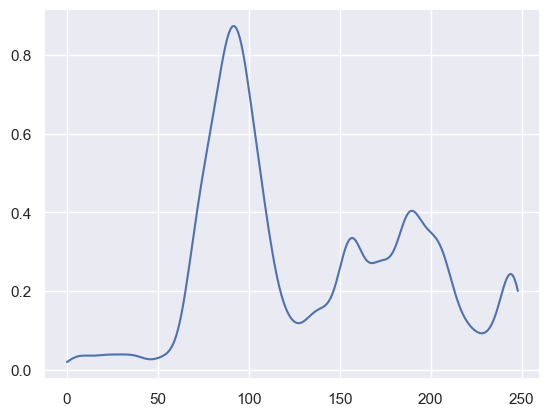

[3976]
[3800 6800]
1408
cuda
epoch 1,loss = 1.04775083
epoch 2,loss = 1.04671741
epoch 3,loss = 1.04570115
epoch 4,loss = 1.04470205
epoch 5,loss = 1.04372036
epoch 6,loss = 1.04275608
epoch 7,loss = 1.04180908
epoch 8,loss = 1.04087925
epoch 9,loss = 1.03996670
epoch 10,loss = 1.03907132
epoch 11,loss = 1.03819311
epoch 12,loss = 1.03733194
epoch 13,loss = 1.03648746
epoch 14,loss = 1.03566003
epoch 15,loss = 1.03484905
epoch 16,loss = 1.03405464
epoch 17,loss = 1.03327656
epoch 18,loss = 1.03251433
epoch 19,loss = 1.03176820
epoch 20,loss = 1.03103769
epoch 21,loss = 1.03032255
epoch 22,loss = 1.02962267
epoch 23,loss = 1.02893770
epoch 24,loss = 1.02826738
epoch 25,loss = 1.02761173
epoch 26,loss = 1.02697003
epoch 27,loss = 1.02634227
epoch 28,loss = 1.02572823
epoch 29,loss = 1.02512741
epoch 30,loss = 1.02453959
epoch 31,loss = 1.02396476
epoch 32,loss = 1.02340233
epoch 33,loss = 1.02285206
epoch 34,loss = 1.02231383
epoch 35,loss = 1.02178729
epoch 36,loss = 1.02127206
epoch 37

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 57,loss = 1.01264954
epoch 58,loss = 1.01232529
epoch 59,loss = 1.01200759
epoch 60,loss = 1.01169634
epoch 61,loss = 1.01139104
epoch 62,loss = 1.01109183
epoch 63,loss = 1.01079857
epoch 64,loss = 1.01051104
epoch 65,loss = 1.01022923
epoch 66,loss = 1.00995278
epoch 67,loss = 1.00968182
epoch 68,loss = 1.00941622
epoch 69,loss = 1.00915587
epoch 70,loss = 1.00890052
epoch 71,loss = 1.00865006
epoch 72,loss = 1.00840449
epoch 73,loss = 1.00816369
epoch 74,loss = 1.00792754
epoch 75,loss = 1.00769603
epoch 76,loss = 1.00746894
epoch 77,loss = 1.00724638
epoch 78,loss = 1.00702798
epoch 79,loss = 1.00681376
epoch 80,loss = 1.00660384
epoch 81,loss = 1.00639796
epoch 82,loss = 1.00619602
epoch 83,loss = 1.00599802
epoch 84,loss = 1.00580382
epoch 85,loss = 1.00561345
epoch 86,loss = 1.00542665
epoch 87,loss = 1.00524342
epoch 88,loss = 1.00506377
epoch 89,loss = 1.00488770
epoch 90,loss = 1.00471473
epoch 91,loss = 1.00454533
epoch 92,loss = 1.00437903
epoch 93,loss = 1.00421596
e

epoch 376,loss = 0.57260543
epoch 377,loss = 0.57173961
epoch 378,loss = 0.57086533
epoch 379,loss = 0.57000333
epoch 380,loss = 0.56915075
epoch 381,loss = 0.56830418
epoch 382,loss = 0.56746590
epoch 383,loss = 0.56663722
epoch 384,loss = 0.56582588
epoch 385,loss = 0.56501681
epoch 386,loss = 0.56421328
epoch 387,loss = 0.56341654
epoch 388,loss = 0.56262577
epoch 389,loss = 0.56184202
epoch 390,loss = 0.56106657
epoch 391,loss = 0.56029713
epoch 392,loss = 0.55951935
epoch 393,loss = 0.55875254
epoch 394,loss = 0.55799365
epoch 395,loss = 0.55724025
epoch 396,loss = 0.55649334
epoch 397,loss = 0.55575269
epoch 398,loss = 0.55500889
epoch 399,loss = 0.55426478
epoch 400,loss = 0.55351675
epoch 401,loss = 0.55277044
epoch 402,loss = 0.55203289
epoch 403,loss = 0.55131090
epoch 404,loss = 0.55059749
epoch 405,loss = 0.54987091
epoch 406,loss = 0.54913408
epoch 407,loss = 0.54839170
epoch 408,loss = 0.54764915
epoch 409,loss = 0.54691112
epoch 410,loss = 0.54616475
epoch 411,loss = 0.5

epoch 694,loss = 0.44385415
epoch 695,loss = 0.44377613
epoch 696,loss = 0.44369829
epoch 697,loss = 0.44361922
epoch 698,loss = 0.44353977
epoch 699,loss = 0.44346014
epoch 700,loss = 0.44338050
epoch 701,loss = 0.44330105
epoch 702,loss = 0.44322202
epoch 703,loss = 0.44314322
epoch 704,loss = 0.44306448
epoch 705,loss = 0.44298637
epoch 706,loss = 0.44290835
epoch 707,loss = 0.44283047
epoch 708,loss = 0.44275275
epoch 709,loss = 0.44267529
epoch 710,loss = 0.44259804
epoch 711,loss = 0.44252092
epoch 712,loss = 0.44244403
epoch 713,loss = 0.44236743
epoch 714,loss = 0.44229072
epoch 715,loss = 0.44221413
epoch 716,loss = 0.44213754
epoch 717,loss = 0.44206065
epoch 718,loss = 0.44198385
epoch 719,loss = 0.44190755
epoch 720,loss = 0.44183120
epoch 721,loss = 0.44175449
epoch 722,loss = 0.44167763
epoch 723,loss = 0.44160089
epoch 724,loss = 0.44152424
epoch 725,loss = 0.44144773
epoch 726,loss = 0.44137138
epoch 727,loss = 0.44129512
epoch 728,loss = 0.44121897
epoch 729,loss = 0.4

epoch 1013,loss = 0.42738420
epoch 1014,loss = 0.42734739
epoch 1015,loss = 0.42731035
epoch 1016,loss = 0.42727324
epoch 1017,loss = 0.42723638
epoch 1018,loss = 0.42719993
epoch 1019,loss = 0.42716393
epoch 1020,loss = 0.42712855
epoch 1021,loss = 0.42709297
epoch 1022,loss = 0.42705750
epoch 1023,loss = 0.42702198
epoch 1024,loss = 0.42698643
epoch 1025,loss = 0.42695081
epoch 1026,loss = 0.42691532
epoch 1027,loss = 0.42687994
epoch 1028,loss = 0.42684522
epoch 1029,loss = 0.42681071
epoch 1030,loss = 0.42677563
epoch 1031,loss = 0.42674005
epoch 1032,loss = 0.42670429
epoch 1033,loss = 0.42666849
epoch 1034,loss = 0.42663389
epoch 1035,loss = 0.42659864
epoch 1036,loss = 0.42656150
epoch 1037,loss = 0.42652443
epoch 1038,loss = 0.42648825
epoch 1039,loss = 0.42645231
epoch 1040,loss = 0.42641646
epoch 1041,loss = 0.42638087
epoch 1042,loss = 0.42634559
epoch 1043,loss = 0.42630965
epoch 1044,loss = 0.42627415
epoch 1045,loss = 0.42623881
epoch 1046,loss = 0.42620236
epoch 1047,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([174, 1, 20])
1.0
Epoch 200:   loss= 0.1462  cluster difference= 1.0
Epoch 400:   loss= 0.14562  cluster difference= 0.0
[3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7
 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4
 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3
 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6
 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3 5 4 3 2 0 7 6 0 1 4 3]


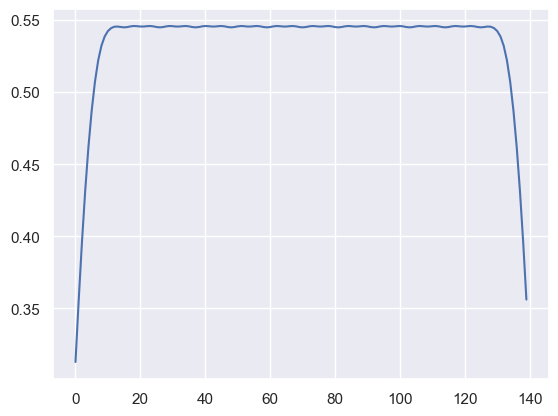

[]
[ 572 1012 1232]
1506
cuda
epoch 1,loss = 0.99512434
epoch 2,loss = 0.99510932
epoch 3,loss = 0.99510056
epoch 4,loss = 0.99509150
epoch 5,loss = 0.99508232
epoch 6,loss = 0.99507415
epoch 7,loss = 0.99506658
epoch 8,loss = 0.99505997
epoch 9,loss = 0.99505460
epoch 10,loss = 0.99504679
epoch 11,loss = 0.99504030
epoch 12,loss = 0.99503344
epoch 13,loss = 0.99502653
epoch 14,loss = 0.99501932
epoch 15,loss = 0.99501193
epoch 16,loss = 0.99500453
epoch 17,loss = 0.99499691
epoch 18,loss = 0.99499279
epoch 19,loss = 0.99498439
epoch 20,loss = 0.99497664
epoch 21,loss = 0.99497032
epoch 22,loss = 0.99496388
epoch 23,loss = 0.99495721
epoch 24,loss = 0.99495053
epoch 25,loss = 0.99494362
epoch 26,loss = 0.99493659
epoch 27,loss = 0.99492949
epoch 28,loss = 0.99492228
epoch 29,loss = 0.99491495
epoch 30,loss = 0.99490744
epoch 31,loss = 0.99489993
epoch 32,loss = 0.99489224
epoch 33,loss = 0.99488437
epoch 34,loss = 0.99487644
epoch 35,loss = 0.99487096
epoch 36,loss = 0.99486244
epoch 3

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 61,loss = 0.99462426
epoch 62,loss = 0.99461091
epoch 63,loss = 0.99459845
epoch 64,loss = 0.99458498
epoch 65,loss = 0.99456966
epoch 66,loss = 0.99455398
epoch 67,loss = 0.99453992
epoch 68,loss = 0.99452430
epoch 69,loss = 0.99450636
epoch 70,loss = 0.99448997
epoch 71,loss = 0.99447304
epoch 72,loss = 0.99445421
epoch 73,loss = 0.99443412
epoch 74,loss = 0.99441499
epoch 75,loss = 0.99439520
epoch 76,loss = 0.99437284
epoch 77,loss = 0.99435061
epoch 78,loss = 0.99432820
epoch 79,loss = 0.99430454
epoch 80,loss = 0.99427950
epoch 81,loss = 0.99425578
epoch 82,loss = 0.99423242
epoch 83,loss = 0.99420768
epoch 84,loss = 0.99418068
epoch 85,loss = 0.99415076
epoch 86,loss = 0.99412006
epoch 87,loss = 0.99409026
epoch 88,loss = 0.99406052
epoch 89,loss = 0.99402857
epoch 90,loss = 0.99399471
epoch 91,loss = 0.99395955
epoch 92,loss = 0.99392343
epoch 93,loss = 0.99388564
epoch 94,loss = 0.99384600
epoch 95,loss = 0.99380577
epoch 96,loss = 0.99376440
epoch 97,loss = 0.99372089
e

epoch 376,loss = 0.72978532
epoch 377,loss = 0.72893369
epoch 378,loss = 0.72810721
epoch 379,loss = 0.72730035
epoch 380,loss = 0.72651416
epoch 381,loss = 0.72574937
epoch 382,loss = 0.72500646
epoch 383,loss = 0.72429097
epoch 384,loss = 0.72359842
epoch 385,loss = 0.72292984
epoch 386,loss = 0.72227913
epoch 387,loss = 0.72164303
epoch 388,loss = 0.72102761
epoch 389,loss = 0.72043198
epoch 390,loss = 0.71985561
epoch 391,loss = 0.71928906
epoch 392,loss = 0.71873832
epoch 393,loss = 0.71820045
epoch 394,loss = 0.71767461
epoch 395,loss = 0.71716702
epoch 396,loss = 0.71666181
epoch 397,loss = 0.71616220
epoch 398,loss = 0.71566898
epoch 399,loss = 0.71517688
epoch 400,loss = 0.71468401
epoch 401,loss = 0.71419936
epoch 402,loss = 0.71372074
epoch 403,loss = 0.71325123
epoch 404,loss = 0.71278316
epoch 405,loss = 0.71231258
epoch 406,loss = 0.71184224
epoch 407,loss = 0.71138161
epoch 408,loss = 0.71092874
epoch 409,loss = 0.71048385
epoch 410,loss = 0.71004921
epoch 411,loss = 0.7

epoch 695,loss = 0.63523978
epoch 696,loss = 0.63498735
epoch 697,loss = 0.63473386
epoch 698,loss = 0.63447684
epoch 699,loss = 0.63421291
epoch 700,loss = 0.63394237
epoch 701,loss = 0.63366950
epoch 702,loss = 0.63340080
epoch 703,loss = 0.63313562
epoch 704,loss = 0.63286066
epoch 705,loss = 0.63258964
epoch 706,loss = 0.63232040
epoch 707,loss = 0.63205421
epoch 708,loss = 0.63179696
epoch 709,loss = 0.63154387
epoch 710,loss = 0.63128269
epoch 711,loss = 0.63101965
epoch 712,loss = 0.63076043
epoch 713,loss = 0.63048625
epoch 714,loss = 0.63020271
epoch 715,loss = 0.62991089
epoch 716,loss = 0.62961978
epoch 717,loss = 0.62932777
epoch 718,loss = 0.62902808
epoch 719,loss = 0.62874204
epoch 720,loss = 0.62847358
epoch 721,loss = 0.62820917
epoch 722,loss = 0.62794918
epoch 723,loss = 0.62768716
epoch 724,loss = 0.62741083
epoch 725,loss = 0.62712854
epoch 726,loss = 0.62684339
epoch 727,loss = 0.62655896
epoch 728,loss = 0.62627691
epoch 729,loss = 0.62599784
epoch 730,loss = 0.6

epoch 1026,loss = 0.55036193
epoch 1027,loss = 0.55026692
epoch 1028,loss = 0.55017000
epoch 1029,loss = 0.55007088
epoch 1030,loss = 0.54997289
epoch 1031,loss = 0.54987490
epoch 1032,loss = 0.54977691
epoch 1033,loss = 0.54967785
epoch 1034,loss = 0.54958844
epoch 1035,loss = 0.54949826
epoch 1036,loss = 0.54940158
epoch 1037,loss = 0.54931402
epoch 1038,loss = 0.54922849
epoch 1039,loss = 0.54913747
epoch 1040,loss = 0.54905283
epoch 1041,loss = 0.54897124
epoch 1042,loss = 0.54888928
epoch 1043,loss = 0.54880941
epoch 1044,loss = 0.54873627
epoch 1045,loss = 0.54866987
epoch 1046,loss = 0.54860014
epoch 1047,loss = 0.54852486
epoch 1048,loss = 0.54845929
epoch 1049,loss = 0.54839832
epoch 1050,loss = 0.54833555
epoch 1051,loss = 0.54826969
epoch 1052,loss = 0.54820228
epoch 1053,loss = 0.54813313
epoch 1054,loss = 0.54806364
epoch 1055,loss = 0.54799926
epoch 1056,loss = 0.54793310
epoch 1057,loss = 0.54786569
epoch 1058,loss = 0.54779804
epoch 1059,loss = 0.54773128
epoch 1060,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([186, 1, 20])
1.0
Epoch 200:   loss= 0.18799  cluster difference= 1.0
Epoch 400:   loss= 0.18702  cluster difference= 0.010752688172043012
Epoch 600:   loss= 0.1864  cluster difference= 0.026881720430107527
Epoch 800:   loss= 0.18594  cluster difference= 0.0
[4 6 2 2 4 0 3 5 0 3 2 2 4 6 1 7 0 3 2 2 4 6 1 7 6 3 4 2 4 6 1 7 6 2 2 2 0
 3 5 4 6 2 6 2 0 3 5 4 6 2 2 4 0 3 5 4 6 2 2 4 6 1 7 0 3 2 3 4 6 1 7 0 6 2
 7 0 6 1 7 0 3 2 2 0 6 5 4 6 2 2 2 0 3 5 4 6 3 5 4 0 3 5 4 6 3 2 4 6 1 5 0
 6 2 2 0 6 1 7 0 6 1 7 0 6 1 7 0 3 1 7 0 6 1 4 0 3 5 4 0 3 5 4 0 3 5 4 0 3
 5 4 6 3 2 4 0 1 5 4 6 2 2 4 6 1 7 0 6 2 2 0 6 1 7 0 6 1 7 0 6 1 7 0 3 2 7
 0]


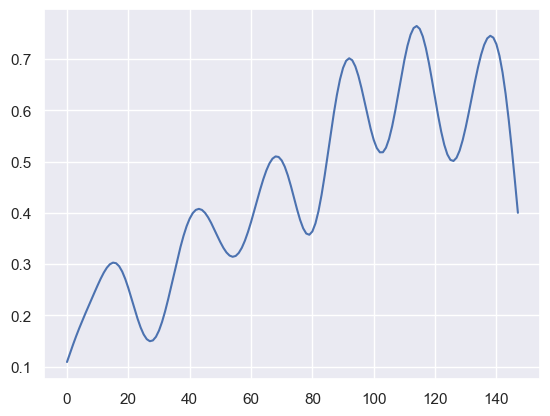

[898, 1074, 1266]
[753]
1410
cuda
epoch 1,loss = 0.97276461
epoch 2,loss = 0.97273296
epoch 3,loss = 0.97270179
epoch 4,loss = 0.97267109
epoch 5,loss = 0.97264063
epoch 6,loss = 0.97261047
epoch 7,loss = 0.97258061
epoch 8,loss = 0.97255111
epoch 9,loss = 0.97252166
epoch 10,loss = 0.97249252
epoch 11,loss = 0.97246355
epoch 12,loss = 0.97243476
epoch 13,loss = 0.97240627
epoch 14,loss = 0.97237790
epoch 15,loss = 0.97234958
epoch 16,loss = 0.97232145
epoch 17,loss = 0.97229344
epoch 18,loss = 0.97226560
epoch 19,loss = 0.97223794
epoch 20,loss = 0.97221047
epoch 21,loss = 0.97218311
epoch 22,loss = 0.97215587
epoch 23,loss = 0.97212863
epoch 24,loss = 0.97210157
epoch 25,loss = 0.97207463
epoch 26,loss = 0.97204787
epoch 27,loss = 0.97202104
epoch 28,loss = 0.97199428
epoch 29,loss = 0.97196758
epoch 30,loss = 0.97194111
epoch 31,loss = 0.97192323
epoch 32,loss = 0.97190970
epoch 33,loss = 0.97189635
epoch 34,loss = 0.97187984
epoch 35,loss = 0.97186023
epoch 36,loss = 0.97183800
epo

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 60,loss = 0.97044116
epoch 61,loss = 0.97041142
epoch 62,loss = 0.97037911
epoch 63,loss = 0.97035182
epoch 64,loss = 0.97032058
epoch 65,loss = 0.97028863
epoch 66,loss = 0.97026598
epoch 67,loss = 0.97022849
epoch 68,loss = 0.97018564
epoch 69,loss = 0.97015166
epoch 70,loss = 0.97012502
epoch 71,loss = 0.97009146
epoch 72,loss = 0.97005224
epoch 73,loss = 0.96999961
epoch 74,loss = 0.96994525
epoch 75,loss = 0.96987313
epoch 76,loss = 0.96978635
epoch 77,loss = 0.96969295
epoch 78,loss = 0.96958649
epoch 79,loss = 0.96950555
epoch 80,loss = 0.96940166
epoch 81,loss = 0.96929240
epoch 82,loss = 0.96916127
epoch 83,loss = 0.96900499
epoch 84,loss = 0.96885765
epoch 85,loss = 0.96871263
epoch 86,loss = 0.96859026
epoch 87,loss = 0.96847248
epoch 88,loss = 0.96834022
epoch 89,loss = 0.96821302
epoch 90,loss = 0.96808577
epoch 91,loss = 0.96794689
epoch 92,loss = 0.96779680
epoch 93,loss = 0.96764344
epoch 94,loss = 0.96748799
epoch 95,loss = 0.96732432
epoch 96,loss = 0.96714956
e

epoch 386,loss = 0.60074544
epoch 387,loss = 0.60048962
epoch 388,loss = 0.60023004
epoch 389,loss = 0.59996080
epoch 390,loss = 0.59969306
epoch 391,loss = 0.59941822
epoch 392,loss = 0.59914815
epoch 393,loss = 0.59889024
epoch 394,loss = 0.59863019
epoch 395,loss = 0.59836417
epoch 396,loss = 0.59809542
epoch 397,loss = 0.59782749
epoch 398,loss = 0.59756070
epoch 399,loss = 0.59727156
epoch 400,loss = 0.59698248
epoch 401,loss = 0.59669703
epoch 402,loss = 0.59641588
epoch 403,loss = 0.59613025
epoch 404,loss = 0.59584135
epoch 405,loss = 0.59555799
epoch 406,loss = 0.59520787
epoch 407,loss = 0.59485674
epoch 408,loss = 0.59450912
epoch 409,loss = 0.59415144
epoch 410,loss = 0.59377146
epoch 411,loss = 0.59339345
epoch 412,loss = 0.59301096
epoch 413,loss = 0.59260529
epoch 414,loss = 0.59220743
epoch 415,loss = 0.59178221
epoch 416,loss = 0.59132761
epoch 417,loss = 0.59091538
epoch 418,loss = 0.59059680
epoch 419,loss = 0.59022015
epoch 420,loss = 0.58980602
epoch 421,loss = 0.5

epoch 708,loss = 0.54337561
epoch 709,loss = 0.54327005
epoch 710,loss = 0.54316515
epoch 711,loss = 0.54305977
epoch 712,loss = 0.54295450
epoch 713,loss = 0.54284877
epoch 714,loss = 0.54274285
epoch 715,loss = 0.54264152
epoch 716,loss = 0.54254043
epoch 717,loss = 0.54243886
epoch 718,loss = 0.54233652
epoch 719,loss = 0.54223603
epoch 720,loss = 0.54213738
epoch 721,loss = 0.54203802
epoch 722,loss = 0.54193783
epoch 723,loss = 0.54183793
epoch 724,loss = 0.54173952
epoch 725,loss = 0.54163969
epoch 726,loss = 0.54154074
epoch 727,loss = 0.54144275
epoch 728,loss = 0.54134417
epoch 729,loss = 0.54124624
epoch 730,loss = 0.54115081
epoch 731,loss = 0.54105371
epoch 732,loss = 0.54095531
epoch 733,loss = 0.54085815
epoch 734,loss = 0.54076219
epoch 735,loss = 0.54066586
epoch 736,loss = 0.54056913
epoch 737,loss = 0.54047209
epoch 738,loss = 0.54037839
epoch 739,loss = 0.54028398
epoch 740,loss = 0.54018825
epoch 741,loss = 0.54009223
epoch 742,loss = 0.53999937
epoch 743,loss = 0.5

epoch 1004,loss = 0.52218127
epoch 1005,loss = 0.52215266
epoch 1006,loss = 0.52212363
epoch 1007,loss = 0.52209288
epoch 1008,loss = 0.52205926
epoch 1009,loss = 0.52202547
epoch 1010,loss = 0.52199060
epoch 1011,loss = 0.52195394
epoch 1012,loss = 0.52191675
epoch 1013,loss = 0.52187878
epoch 1014,loss = 0.52184308
epoch 1015,loss = 0.52180696
epoch 1016,loss = 0.52177072
epoch 1017,loss = 0.52173358
epoch 1018,loss = 0.52169639
epoch 1019,loss = 0.52165920
epoch 1020,loss = 0.52162200
epoch 1021,loss = 0.52158487
epoch 1022,loss = 0.52154976
epoch 1023,loss = 0.52151656
epoch 1024,loss = 0.52148509
epoch 1025,loss = 0.52145809
epoch 1026,loss = 0.52143162
epoch 1027,loss = 0.52140492
epoch 1028,loss = 0.52137727
epoch 1029,loss = 0.52134448
epoch 1030,loss = 0.52131426
epoch 1031,loss = 0.52128476
epoch 1032,loss = 0.52125162
epoch 1033,loss = 0.52121377
epoch 1034,loss = 0.52117682
epoch 1035,loss = 0.52114171
epoch 1036,loss = 0.52110630
epoch 1037,loss = 0.52107239
epoch 1038,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([68, 1, 50])
1.0
Epoch 200:   loss= 0.08261  cluster difference= 1.0
Epoch 400:   loss= 0.08225  cluster difference= 0.0
[0 0 0 0 2 0 0 0 3 4 0 0 0 0 3 6 6 0 0 0 1 6 0 0 0 0 3 5 6 0 0 0 0 3 6 0 0
 0 0 1 6 0 0 0 7 2 0 0 0 0 7 2 0 0 0 0 7 2 0 0 0 0 3 5 0 0 0 0]


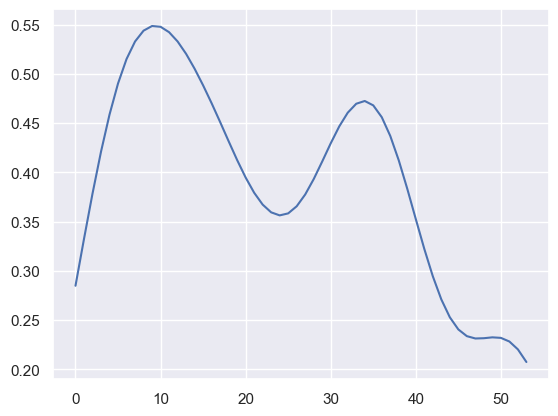

[]
[705]
2560
cuda
epoch 1,loss = 1.06515431
epoch 2,loss = 1.06430352
epoch 3,loss = 1.06346023
epoch 4,loss = 1.06262457
epoch 5,loss = 1.06179678
epoch 6,loss = 1.06097651
epoch 7,loss = 1.06016421
epoch 8,loss = 1.05935991
epoch 9,loss = 1.05856347
epoch 10,loss = 1.05777514
epoch 11,loss = 1.05699492
epoch 12,loss = 1.05622268
epoch 13,loss = 1.05545878
epoch 14,loss = 1.05470300
epoch 15,loss = 1.05395532
epoch 16,loss = 1.05321598
epoch 17,loss = 1.05248487
epoch 18,loss = 1.05176198
epoch 19,loss = 1.05104721
epoch 20,loss = 1.05034089
epoch 21,loss = 1.04964256
epoch 22,loss = 1.04895258
epoch 23,loss = 1.04827094
epoch 24,loss = 1.04759729
epoch 25,loss = 1.04693162
epoch 26,loss = 1.04627419
epoch 27,loss = 1.04562497
epoch 28,loss = 1.04498363
epoch 29,loss = 1.04435027
epoch 30,loss = 1.04372478
epoch 31,loss = 1.04310727
epoch 32,loss = 1.04249752
epoch 33,loss = 1.04189563
epoch 34,loss = 1.04130149
epoch 35,loss = 1.04071486
epoch 36,loss = 1.04013598
epoch 37,loss = 1.

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 52,loss = 1.03185010
epoch 53,loss = 1.03138959
epoch 54,loss = 1.03093565
epoch 55,loss = 1.03048790
epoch 56,loss = 1.03004646
epoch 57,loss = 1.02961111
epoch 58,loss = 1.02918172
epoch 59,loss = 1.02875853
epoch 60,loss = 1.02834117
epoch 61,loss = 1.02792978
epoch 62,loss = 1.02752435
epoch 63,loss = 1.02712452
epoch 64,loss = 1.02673030
epoch 65,loss = 1.02634168
epoch 66,loss = 1.02595878
epoch 67,loss = 1.02558136
epoch 68,loss = 1.02520931
epoch 69,loss = 1.02484274
epoch 70,loss = 1.02448142
epoch 71,loss = 1.02412558
epoch 72,loss = 1.02377474
epoch 73,loss = 1.02342916
epoch 74,loss = 1.02308869
epoch 75,loss = 1.02275324
epoch 76,loss = 1.02242279
epoch 77,loss = 1.02209747
epoch 78,loss = 1.02177691
epoch 79,loss = 1.02146125
epoch 80,loss = 1.02115035
epoch 81,loss = 1.02084434
epoch 82,loss = 1.02054310
epoch 83,loss = 1.02024651
epoch 84,loss = 1.01995432
epoch 85,loss = 1.01966679
epoch 86,loss = 1.01938379
epoch 87,loss = 1.01910543
epoch 88,loss = 1.01883125
e

epoch 362,loss = 0.81342483
epoch 363,loss = 0.80706686
epoch 364,loss = 0.80065554
epoch 365,loss = 0.79421371
epoch 366,loss = 0.78773952
epoch 367,loss = 0.78122419
epoch 368,loss = 0.77468705
epoch 369,loss = 0.76811767
epoch 370,loss = 0.76154405
epoch 371,loss = 0.75496364
epoch 372,loss = 0.74839950
epoch 373,loss = 0.74186587
epoch 374,loss = 0.73537081
epoch 375,loss = 0.72892553
epoch 376,loss = 0.72254497
epoch 377,loss = 0.71623641
epoch 378,loss = 0.71000707
epoch 379,loss = 0.70391166
epoch 380,loss = 0.69794858
epoch 381,loss = 0.69214052
epoch 382,loss = 0.68651593
epoch 383,loss = 0.68107808
epoch 384,loss = 0.67583412
epoch 385,loss = 0.67077482
epoch 386,loss = 0.66593349
epoch 387,loss = 0.66129297
epoch 388,loss = 0.65686470
epoch 389,loss = 0.65266234
epoch 390,loss = 0.64868444
epoch 391,loss = 0.64492661
epoch 392,loss = 0.64138305
epoch 393,loss = 0.63803023
epoch 394,loss = 0.63488460
epoch 395,loss = 0.63194013
epoch 396,loss = 0.62923622
epoch 397,loss = 0.6

epoch 660,loss = 0.53214282
epoch 661,loss = 0.53199583
epoch 662,loss = 0.53184742
epoch 663,loss = 0.53169841
epoch 664,loss = 0.53154832
epoch 665,loss = 0.53139955
epoch 666,loss = 0.53125000
epoch 667,loss = 0.53109914
epoch 668,loss = 0.53094715
epoch 669,loss = 0.53079247
epoch 670,loss = 0.53063273
epoch 671,loss = 0.53047395
epoch 672,loss = 0.53030980
epoch 673,loss = 0.53014451
epoch 674,loss = 0.52997035
epoch 675,loss = 0.52978873
epoch 676,loss = 0.52960682
epoch 677,loss = 0.52941746
epoch 678,loss = 0.52921855
epoch 679,loss = 0.52901644
epoch 680,loss = 0.52881712
epoch 681,loss = 0.52861571
epoch 682,loss = 0.52838194
epoch 683,loss = 0.52813143
epoch 684,loss = 0.52788013
epoch 685,loss = 0.52762747
epoch 686,loss = 0.52737546
epoch 687,loss = 0.52712715
epoch 688,loss = 0.52687889
epoch 689,loss = 0.52663434
epoch 690,loss = 0.52639353
epoch 691,loss = 0.52615595
epoch 692,loss = 0.52592087
epoch 693,loss = 0.52567482
epoch 694,loss = 0.52542180
epoch 695,loss = 0.5

epoch 969,loss = 0.50426501
epoch 970,loss = 0.50421101
epoch 971,loss = 0.50415999
epoch 972,loss = 0.50410837
epoch 973,loss = 0.50405580
epoch 974,loss = 0.50400269
epoch 975,loss = 0.50395119
epoch 976,loss = 0.50389785
epoch 977,loss = 0.50384599
epoch 978,loss = 0.50379443
epoch 979,loss = 0.50374269
epoch 980,loss = 0.50369084
epoch 981,loss = 0.50363886
epoch 982,loss = 0.50358689
epoch 983,loss = 0.50353622
epoch 984,loss = 0.50348586
epoch 985,loss = 0.50343376
epoch 986,loss = 0.50338167
epoch 987,loss = 0.50333023
epoch 988,loss = 0.50327933
epoch 989,loss = 0.50322795
epoch 990,loss = 0.50317806
epoch 991,loss = 0.50312769
epoch 992,loss = 0.50307715
epoch 993,loss = 0.50302655
epoch 994,loss = 0.50297588
epoch 995,loss = 0.50292605
epoch 996,loss = 0.50287503
epoch 997,loss = 0.50282311
epoch 998,loss = 0.50276494
epoch 999,loss = 0.50270921
epoch 1000,loss = 0.50265431
epoch 1001,loss = 0.50259769
epoch 1002,loss = 0.50254303
epoch 1003,loss = 0.50249100
epoch 1004,loss 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([318, 1, 20])
1.0
Epoch 200:   loss= 0.18686  cluster difference= 1.0
Epoch 400:   loss= 0.18523  cluster difference= 0.025157232704402517
Epoch 600:   loss= 0.1843  cluster difference= 0.02830188679245283
Epoch 800:   loss= 0.18373  cluster difference= 0.015723270440251572
Epoch 1000:   loss= 0.18337  cluster difference= 0.009433962264150943
[0 0 2 7 7 7 1 0 0 2 1 2 7 1 2 3 4 7 5 1 7 3 4 3 4 1 5 3 2 3 6 7 5 3 4 6 7
 7 7 1 6 0 4 5 7 1 2 1 6 2 3 0 6 7 3 4 1 4 7 7 7 7 5 7 7 5 1 2 7 3 6 7 3 2
 7 3 2 3 6 1 7 1 0 4 7 5 3 6 7 1 7 5 7 3 6 7 0 6 7 1 1 0 2 1 2 1 2 1 6 1 2
 3 6 7 3 0 2 1 0 2 5 2 7 7 7 1 5 7 0 6 2 1 6 1 4 7 7 7 7 3 2 0 2 7 7 7 1 0
 3 4 5 7 7 7 1 1 6 0 4 7 3 2 3 4 2 2 5 7 1 4 3 0 4 3 2 1 6 7 7 1 2 0 4 1 0
 4 2 7 3 4 5 1 4 1 4 0 4 7 7 7 3 0 4 3 3 2 7 7 0 4 5 7 7 1 6 3 2 5 7 7 1 0
 4 1 4 4 5 7 7 3 4 0 4 7 7 5 3 2 7 1 0 4 5 2 7 3 4 6 5 7 7 3 2 2 7 1 7 3 4
 4 7 1 4 3 6 5 1 5 5 7 7 7 1 5 0 7 7 1 2 1 2 5 1 0 6 1 4 7 3 6 5 7 5 1 2 7
 5 5 7 5 0 4 7 1 2 5 1 5 0 2 7 7 3 4 5 1 5 5

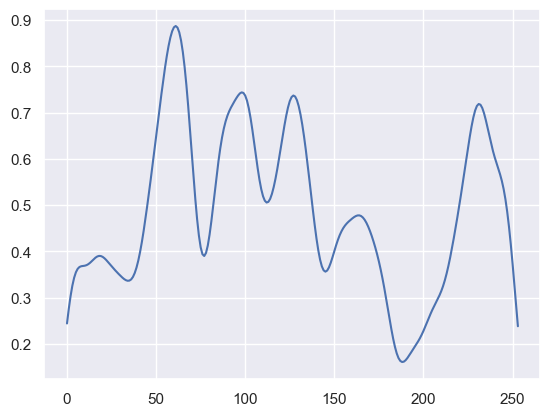

[754, 1050, 2114]
[1280]
2560
cuda
epoch 1,loss = 1.00170565
epoch 2,loss = 1.00169742
epoch 3,loss = 1.00168931
epoch 4,loss = 1.00168109
epoch 5,loss = 1.00167298
epoch 6,loss = 1.00166476
epoch 7,loss = 1.00165665
epoch 8,loss = 1.00164843
epoch 9,loss = 1.00164032
epoch 10,loss = 1.00163221
epoch 11,loss = 1.00162411
epoch 12,loss = 1.00161588
epoch 13,loss = 1.00160778
epoch 14,loss = 1.00159967
epoch 15,loss = 1.00159156
epoch 16,loss = 1.00158346
epoch 17,loss = 1.00157523
epoch 18,loss = 1.00156713
epoch 19,loss = 1.00155902
epoch 20,loss = 1.00155079
epoch 21,loss = 1.00154257
epoch 22,loss = 1.00153434
epoch 23,loss = 1.00152612
epoch 24,loss = 1.00151801
epoch 25,loss = 1.00150955
epoch 26,loss = 1.00150132
epoch 27,loss = 1.00149298
epoch 28,loss = 1.00148451
epoch 29,loss = 1.00147617
epoch 30,loss = 1.00146759
epoch 31,loss = 1.00145912
epoch 32,loss = 1.00145054
epoch 33,loss = 1.00144184
epoch 34,loss = 1.00143325
epoch 35,loss = 1.00142443
epoch 36,loss = 1.00141549
ep

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 52,loss = 1.00126064
epoch 53,loss = 1.00124955
epoch 54,loss = 1.00123823
epoch 55,loss = 1.00122654
epoch 56,loss = 1.00121474
epoch 57,loss = 1.00120258
epoch 58,loss = 1.00119019
epoch 59,loss = 1.00117743
epoch 60,loss = 1.00116432
epoch 61,loss = 1.00115085
epoch 62,loss = 1.00113690
epoch 63,loss = 1.00112247
epoch 64,loss = 1.00110781
epoch 65,loss = 1.00109267
epoch 66,loss = 1.00107718
epoch 67,loss = 1.00106120
epoch 68,loss = 1.00104451
epoch 69,loss = 1.00102746
epoch 70,loss = 1.00100982
epoch 71,loss = 1.00099158
epoch 72,loss = 1.00097287
epoch 73,loss = 1.00095356
epoch 74,loss = 1.00093341
epoch 75,loss = 1.00091255
epoch 76,loss = 1.00089109
epoch 77,loss = 1.00086880
epoch 78,loss = 1.00084567
epoch 79,loss = 1.00082183
epoch 80,loss = 1.00079715
epoch 81,loss = 1.00077152
epoch 82,loss = 1.00074494
epoch 83,loss = 1.00071764
epoch 84,loss = 1.00068915
epoch 85,loss = 1.00065958
epoch 86,loss = 1.00062907
epoch 87,loss = 1.00059748
epoch 88,loss = 1.00056469
e

epoch 370,loss = 0.53923506
epoch 371,loss = 0.53872472
epoch 372,loss = 0.53821343
epoch 373,loss = 0.53770715
epoch 374,loss = 0.53719819
epoch 375,loss = 0.53669137
epoch 376,loss = 0.53618562
epoch 377,loss = 0.53568280
epoch 378,loss = 0.53518909
epoch 379,loss = 0.53470916
epoch 380,loss = 0.53423476
epoch 381,loss = 0.53376240
epoch 382,loss = 0.53329271
epoch 383,loss = 0.53281784
epoch 384,loss = 0.53233641
epoch 385,loss = 0.53185523
epoch 386,loss = 0.53136927
epoch 387,loss = 0.53088313
epoch 388,loss = 0.53040171
epoch 389,loss = 0.52992970
epoch 390,loss = 0.52946782
epoch 391,loss = 0.52901167
epoch 392,loss = 0.52856255
epoch 393,loss = 0.52811825
epoch 394,loss = 0.52769977
epoch 395,loss = 0.52728444
epoch 396,loss = 0.52687609
epoch 397,loss = 0.52647299
epoch 398,loss = 0.52607465
epoch 399,loss = 0.52567887
epoch 400,loss = 0.52528620
epoch 401,loss = 0.52489954
epoch 402,loss = 0.52451557
epoch 403,loss = 0.52413481
epoch 404,loss = 0.52375853
epoch 405,loss = 0.5

epoch 715,loss = 0.46468574
epoch 716,loss = 0.46455422
epoch 717,loss = 0.46442282
epoch 718,loss = 0.46429178
epoch 719,loss = 0.46416083
epoch 720,loss = 0.46402901
epoch 721,loss = 0.46389729
epoch 722,loss = 0.46376580
epoch 723,loss = 0.46363416
epoch 724,loss = 0.46350247
epoch 725,loss = 0.46337098
epoch 726,loss = 0.46323979
epoch 727,loss = 0.46310976
epoch 728,loss = 0.46297997
epoch 729,loss = 0.46285036
epoch 730,loss = 0.46272117
epoch 731,loss = 0.46259251
epoch 732,loss = 0.46246430
epoch 733,loss = 0.46233615
epoch 734,loss = 0.46220782
epoch 735,loss = 0.46207750
epoch 736,loss = 0.46194151
epoch 737,loss = 0.46180150
epoch 738,loss = 0.46165088
epoch 739,loss = 0.46148902
epoch 740,loss = 0.46129879
epoch 741,loss = 0.46106124
epoch 742,loss = 0.46075347
epoch 743,loss = 0.46031117
epoch 744,loss = 0.45969978
epoch 745,loss = 0.45886752
epoch 746,loss = 0.45784190
epoch 747,loss = 0.45670241
epoch 748,loss = 0.45552805
epoch 749,loss = 0.45443738
epoch 750,loss = 0.4

epoch 1011,loss = 0.38567376
epoch 1012,loss = 0.38553375
epoch 1013,loss = 0.38539410
epoch 1014,loss = 0.38525376
epoch 1015,loss = 0.38511243
epoch 1016,loss = 0.38497043
epoch 1017,loss = 0.38482806
epoch 1018,loss = 0.38468608
epoch 1019,loss = 0.38454458
epoch 1020,loss = 0.38440272
epoch 1021,loss = 0.38425821
epoch 1022,loss = 0.38411000
epoch 1023,loss = 0.38395658
epoch 1024,loss = 0.38380072
epoch 1025,loss = 0.38364434
epoch 1026,loss = 0.38348666
epoch 1027,loss = 0.38331881
epoch 1028,loss = 0.38315612
epoch 1029,loss = 0.38299444
epoch 1030,loss = 0.38283688
epoch 1031,loss = 0.38268098
epoch 1032,loss = 0.38252395
epoch 1033,loss = 0.38236764
epoch 1034,loss = 0.38221085
epoch 1035,loss = 0.38205558
epoch 1036,loss = 0.38190034
epoch 1037,loss = 0.38174570
epoch 1038,loss = 0.38158840
epoch 1039,loss = 0.38143164
epoch 1040,loss = 0.38127610
epoch 1041,loss = 0.38111657
epoch 1042,loss = 0.38095933
epoch 1043,loss = 0.38080311
epoch 1044,loss = 0.38064563
epoch 1045,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([318, 1, 20])
1.0
Epoch 200:   loss= 0.20804  cluster difference= 1.0
Epoch 400:   loss= 0.20753  cluster difference= 0.0440251572327044
Epoch 600:   loss= 0.20677  cluster difference= 0.050314465408805034
Epoch 800:   loss= 0.20608  cluster difference= 0.0220125786163522
Epoch 1000:   loss= 0.20526  cluster difference= 0.009433962264150943
[0 3 4 5 6 7 4 4 6 0 7 1 4 2 0 0 3 4 5 0 0 7 1 4 5 6 0 0 3 4 5 7 2 3 5 6 0
 7 4 4 5 0 0 0 3 4 5 0 7 4 4 6 2 3 5 6 0 0 1 4 4 6 0 0 7 4 2 0 3 4 5 6 0 0
 0 1 4 4 6 0 7 4 4 5 0 0 3 5 6 0 1 4 4 6 0 0 7 1 4 5 7 1 5 6 0 7 1 4 5 6 0
 0 0 3 4 5 1 4 2 0 0 7 4 4 4 6 0 0 0 3 4 5 3 4 5 6 0 7 1 4 4 6 0 0 7 1 4 2
 3 4 5 6 0 7 1 4 4 6 0 7 1 4 2 7 4 6 0 1 2 0 0 7 4 2 0 0 0 3 2 0 3 4 4 2 0
 0 0 3 4 5 6 0 3 4 5 7 5 6 1 4 2 0 0 3 4 2 0 0 7 4 4 5 6 0 0 7 4 4 6 0 0 7
 5 0 7 5 6 0 0 1 4 5 6 0 0 3 4 5 6 0 7 4 4 2 0 0 7 4 4 2 0 0 3 2 6 0 7 4 5
 3 5 6 3 4 6 0 0 3 4 5 6 3 5 6 3 4 6 0 0 3 4 5 0 0 7 4 5 6 7 1 4 2 0 7 1 2
 0 7 1 4 4 6 0 0 7 1 2 0 7 1 4 4 6 0 0 7 1 4]


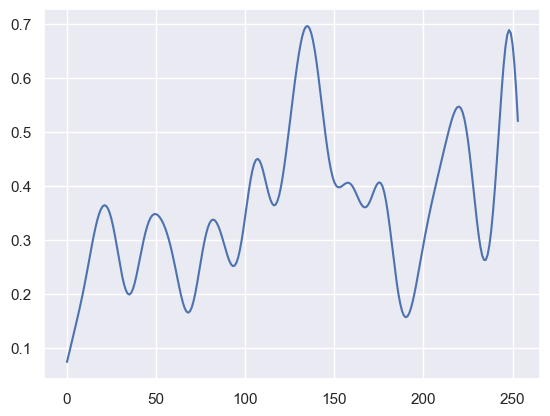

[1346, 2250]
[1280]
2163
cuda
epoch 1,loss = 1.08215320
epoch 2,loss = 1.08066440
epoch 3,loss = 1.07918692
epoch 4,loss = 1.07772124
epoch 5,loss = 1.07626760
epoch 6,loss = 1.07482636
epoch 7,loss = 1.07339799
epoch 8,loss = 1.07198262
epoch 9,loss = 1.07058072
epoch 10,loss = 1.06919253
epoch 11,loss = 1.06781840
epoch 12,loss = 1.06645870
epoch 13,loss = 1.06511366
epoch 14,loss = 1.06378365
epoch 15,loss = 1.06246889
epoch 16,loss = 1.06116986
epoch 17,loss = 1.05988646
epoch 18,loss = 1.05861950
epoch 19,loss = 1.05736876
epoch 20,loss = 1.05613482
epoch 21,loss = 1.05491793
epoch 22,loss = 1.05371821
epoch 23,loss = 1.05253601
epoch 24,loss = 1.05137169
epoch 25,loss = 1.05022526
epoch 26,loss = 1.04909682
epoch 27,loss = 1.04798710
epoch 28,loss = 1.04689598
epoch 29,loss = 1.04582357
epoch 30,loss = 1.04477024
epoch 31,loss = 1.04373622
epoch 32,loss = 1.04272151
epoch 33,loss = 1.04172623
epoch 34,loss = 1.04075074
epoch 35,loss = 1.03979433
epoch 36,loss = 1.03885722
epoch 3

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 52,loss = 1.02641368
epoch 53,loss = 1.02579451
epoch 54,loss = 1.02519381
epoch 55,loss = 1.02461123
epoch 56,loss = 1.02404654
epoch 57,loss = 1.02349985
epoch 58,loss = 1.02297080
epoch 59,loss = 1.02245927
epoch 60,loss = 1.02196503
epoch 61,loss = 1.02148783
epoch 62,loss = 1.02102757
epoch 63,loss = 1.02058375
epoch 64,loss = 1.02015650
epoch 65,loss = 1.01974523
epoch 66,loss = 1.01934969
epoch 67,loss = 1.01896966
epoch 68,loss = 1.01860476
epoch 69,loss = 1.01825476
epoch 70,loss = 1.01791918
epoch 71,loss = 1.01759768
epoch 72,loss = 1.01728976
epoch 73,loss = 1.01699460
epoch 74,loss = 1.01671219
epoch 75,loss = 1.01644182
epoch 76,loss = 1.01618338
epoch 77,loss = 1.01593637
epoch 78,loss = 1.01570046
epoch 79,loss = 1.01547503
epoch 80,loss = 1.01526010
epoch 81,loss = 1.01505494
epoch 82,loss = 1.01485956
epoch 83,loss = 1.01467228
epoch 84,loss = 1.01449299
epoch 85,loss = 1.01432157
epoch 86,loss = 1.01415730
epoch 87,loss = 1.01400220
epoch 88,loss = 1.01384985
e

epoch 373,loss = 0.72635734
epoch 374,loss = 0.72422981
epoch 375,loss = 0.72213084
epoch 376,loss = 0.72004980
epoch 377,loss = 0.71799910
epoch 378,loss = 0.71597552
epoch 379,loss = 0.71398127
epoch 380,loss = 0.71201271
epoch 381,loss = 0.71007276
epoch 382,loss = 0.70817035
epoch 383,loss = 0.70630085
epoch 384,loss = 0.70446843
epoch 385,loss = 0.70266229
epoch 386,loss = 0.70089459
epoch 387,loss = 0.69916320
epoch 388,loss = 0.69746512
epoch 389,loss = 0.69579822
epoch 390,loss = 0.69416159
epoch 391,loss = 0.69255561
epoch 392,loss = 0.69098985
epoch 393,loss = 0.68945402
epoch 394,loss = 0.68795121
epoch 395,loss = 0.68647188
epoch 396,loss = 0.68502527
epoch 397,loss = 0.68360919
epoch 398,loss = 0.68222946
epoch 399,loss = 0.68088961
epoch 400,loss = 0.67957813
epoch 401,loss = 0.67829406
epoch 402,loss = 0.67703819
epoch 403,loss = 0.67581171
epoch 404,loss = 0.67460978
epoch 405,loss = 0.67343765
epoch 406,loss = 0.67230058
epoch 407,loss = 0.67118859
epoch 408,loss = 0.6

epoch 673,loss = 0.52592474
epoch 674,loss = 0.52557248
epoch 675,loss = 0.52522892
epoch 676,loss = 0.52489007
epoch 677,loss = 0.52456152
epoch 678,loss = 0.52423990
epoch 679,loss = 0.52392375
epoch 680,loss = 0.52361375
epoch 681,loss = 0.52331340
epoch 682,loss = 0.52302337
epoch 683,loss = 0.52273905
epoch 684,loss = 0.52245742
epoch 685,loss = 0.52217120
epoch 686,loss = 0.52188587
epoch 687,loss = 0.52160519
epoch 688,loss = 0.52132726
epoch 689,loss = 0.52104902
epoch 690,loss = 0.52077574
epoch 691,loss = 0.52050751
epoch 692,loss = 0.52024472
epoch 693,loss = 0.51997972
epoch 694,loss = 0.51971388
epoch 695,loss = 0.51944906
epoch 696,loss = 0.51918811
epoch 697,loss = 0.51892728
epoch 698,loss = 0.51866853
epoch 699,loss = 0.51841187
epoch 700,loss = 0.51815903
epoch 701,loss = 0.51790816
epoch 702,loss = 0.51766205
epoch 703,loss = 0.51741737
epoch 704,loss = 0.51716787
epoch 705,loss = 0.51691854
epoch 706,loss = 0.51667106
epoch 707,loss = 0.51642436
epoch 708,loss = 0.5

epoch 977,loss = 0.49749917
epoch 978,loss = 0.49747247
epoch 979,loss = 0.49744624
epoch 980,loss = 0.49742168
epoch 981,loss = 0.49739653
epoch 982,loss = 0.49737126
epoch 983,loss = 0.49734738
epoch 984,loss = 0.49732444
epoch 985,loss = 0.49730188
epoch 986,loss = 0.49727976
epoch 987,loss = 0.49725851
epoch 988,loss = 0.49723774
epoch 989,loss = 0.49721745
epoch 990,loss = 0.49719736
epoch 991,loss = 0.49717700
epoch 992,loss = 0.49715644
epoch 993,loss = 0.49713624
epoch 994,loss = 0.49711606
epoch 995,loss = 0.49709609
epoch 996,loss = 0.49707580
epoch 997,loss = 0.49705520
epoch 998,loss = 0.49703434
epoch 999,loss = 0.49701393
epoch 1000,loss = 0.49699390
epoch 1001,loss = 0.49697459
epoch 1002,loss = 0.49695525
epoch 1003,loss = 0.49693477
epoch 1004,loss = 0.49691427
epoch 1005,loss = 0.49689433
epoch 1006,loss = 0.49687478
epoch 1007,loss = 0.49685541
epoch 1008,loss = 0.49683627
epoch 1009,loss = 0.49681693
epoch 1010,loss = 0.49679765
epoch 1011,loss = 0.49677807
epoch 10

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([268, 1, 20])
1.0
Epoch 200:   loss= 0.15457  cluster difference= 1.0
Epoch 400:   loss= 0.15175  cluster difference= 0.1455223880597015
Epoch 600:   loss= 0.15008  cluster difference= 0.029850746268656716
Epoch 800:   loss= 0.14915  cluster difference= 0.0037313432835820895
[0 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 5 7 5 7 3 2 4 2 4 5 7 0
 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 5 7 3 6
 3 6 4 5 7 0 1 3 6 4 2 4 5 7 0 1 3 6 3 6 4 0 7 0 1 0 1 3 6 4 5 7 0 1 3 1 3
 6 4 5 7 0 1 3 6 3 6 4 5 7 0 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 5 7 5 7 0 1 3 6
 4 5 7 0 1 3 6 4 2 7 5 7 3 6 4 2 4 5 7 5 7 3 6 4 2 4 5 7 5 7 3 6 3 6 4 5 7
 0 1 3 6 4 2 4 5 7 5 7 0 1 0 1 3 2 4 5 7 0 1 0 1 3 2 4 2 7 5 1 3 6 4 2 4 5
 7 0 1 3 6 4 2 4 2 7 0 1 3 6 4 5 7 5 7 0 1 3 6 4 2 4 5 7 0 1 3 6 4 2 4 2 7
 0 1 3 6 4 2 7 5 7]


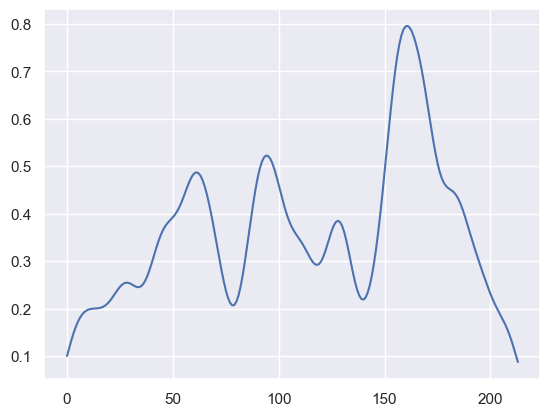

[1514]
[ 577 1154 1550]
960
cuda
epoch 1,loss = 1.34676600
epoch 2,loss = 1.34231353
epoch 3,loss = 1.33792067
epoch 4,loss = 1.33358777
epoch 5,loss = 1.32931495
epoch 6,loss = 1.32510245
epoch 7,loss = 1.32094991
epoch 8,loss = 1.31685770
epoch 9,loss = 1.31282568
epoch 10,loss = 1.30885339
epoch 11,loss = 1.30494106
epoch 12,loss = 1.30108809
epoch 13,loss = 1.29729414
epoch 14,loss = 1.29355907
epoch 15,loss = 1.28988206
epoch 16,loss = 1.28626299
epoch 17,loss = 1.28270102
epoch 18,loss = 1.27919567
epoch 19,loss = 1.27574635
epoch 20,loss = 1.27235234
epoch 21,loss = 1.26901293
epoch 22,loss = 1.26572728
epoch 23,loss = 1.26249468
epoch 24,loss = 1.25931442
epoch 25,loss = 1.25618565
epoch 26,loss = 1.25310719
epoch 27,loss = 1.25007856
epoch 28,loss = 1.24709880
epoch 29,loss = 1.24416685
epoch 30,loss = 1.24128199
epoch 31,loss = 1.23844326
epoch 32,loss = 1.23564970
epoch 33,loss = 1.23290038
epoch 34,loss = 1.23019457
epoch 35,loss = 1.22753143
epoch 36,loss = 1.22490978
epoc

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 58,loss = 1.17620003
epoch 59,loss = 1.17433238
epoch 60,loss = 1.17249072
epoch 61,loss = 1.17067420
epoch 62,loss = 1.16888261
epoch 63,loss = 1.16711545
epoch 64,loss = 1.16537237
epoch 65,loss = 1.16365290
epoch 66,loss = 1.16195679
epoch 67,loss = 1.16028345
epoch 68,loss = 1.15863287
epoch 69,loss = 1.15700424
epoch 70,loss = 1.15539753
epoch 71,loss = 1.15381241
epoch 72,loss = 1.15224838
epoch 73,loss = 1.15070522
epoch 74,loss = 1.14918256
epoch 75,loss = 1.14768028
epoch 76,loss = 1.14619780
epoch 77,loss = 1.14473498
epoch 78,loss = 1.14329171
epoch 79,loss = 1.14186716
epoch 80,loss = 1.14046180
epoch 81,loss = 1.13907492
epoch 82,loss = 1.13770616
epoch 83,loss = 1.13635552
epoch 84,loss = 1.13502264
epoch 85,loss = 1.13370728
epoch 86,loss = 1.13240921
epoch 87,loss = 1.13112831
epoch 88,loss = 1.12986398
epoch 89,loss = 1.12862480
epoch 90,loss = 1.12737918
epoch 91,loss = 1.12614834
epoch 92,loss = 1.12493229
epoch 93,loss = 1.12373102
epoch 94,loss = 1.12254453
e

epoch 389,loss = 1.02258372
epoch 390,loss = 1.02252388
epoch 391,loss = 1.02246451
epoch 392,loss = 1.02240646
epoch 393,loss = 1.02234900
epoch 394,loss = 1.02229214
epoch 395,loss = 1.02223563
epoch 396,loss = 1.02217972
epoch 397,loss = 1.02212429
epoch 398,loss = 1.02206945
epoch 399,loss = 1.02201521
epoch 400,loss = 1.02196157
epoch 401,loss = 1.02190828
epoch 402,loss = 1.02185559
epoch 403,loss = 1.02180314
epoch 404,loss = 1.02175152
epoch 405,loss = 1.02170014
epoch 406,loss = 1.02164924
epoch 407,loss = 1.02159894
epoch 408,loss = 1.02154887
epoch 409,loss = 1.02149951
epoch 410,loss = 1.02145040
epoch 411,loss = 1.02140200
epoch 412,loss = 1.02135384
epoch 413,loss = 1.02130628
epoch 414,loss = 1.02125883
epoch 415,loss = 1.02121210
epoch 416,loss = 1.02116561
epoch 417,loss = 1.02111959
epoch 418,loss = 1.02107406
epoch 419,loss = 1.02102888
epoch 420,loss = 1.02098405
epoch 421,loss = 1.02093983
epoch 422,loss = 1.02089572
epoch 423,loss = 1.02085209
epoch 424,loss = 1.0

epoch 695,loss = 1.01004899
epoch 696,loss = 1.00992477
epoch 697,loss = 1.00978220
epoch 698,loss = 1.00962806
epoch 699,loss = 1.00946343
epoch 700,loss = 1.00929284
epoch 701,loss = 1.00912607
epoch 702,loss = 1.00896907
epoch 703,loss = 1.00880909
epoch 704,loss = 1.00864553
epoch 705,loss = 1.00847602
epoch 706,loss = 1.00830054
epoch 707,loss = 1.00811911
epoch 708,loss = 1.00793087
epoch 709,loss = 1.00773609
epoch 710,loss = 1.00753379
epoch 711,loss = 1.00732315
epoch 712,loss = 1.00710535
epoch 713,loss = 1.00687945
epoch 714,loss = 1.00664532
epoch 715,loss = 1.00640190
epoch 716,loss = 1.00615001
epoch 717,loss = 1.00588703
epoch 718,loss = 1.00561464
epoch 719,loss = 1.00533700
epoch 720,loss = 1.00505149
epoch 721,loss = 1.00475478
epoch 722,loss = 1.00444174
epoch 723,loss = 1.00411332
epoch 724,loss = 1.00377178
epoch 725,loss = 1.00342059
epoch 726,loss = 1.00305974
epoch 727,loss = 1.00268102
epoch 728,loss = 1.00228524
epoch 729,loss = 1.00186932
epoch 730,loss = 1.0

epoch 989,loss = 0.62643981
epoch 990,loss = 0.62582344
epoch 991,loss = 0.62521672
epoch 992,loss = 0.62461901
epoch 993,loss = 0.62406254
epoch 994,loss = 0.62352884
epoch 995,loss = 0.62301582
epoch 996,loss = 0.62250209
epoch 997,loss = 0.62198782
epoch 998,loss = 0.62147677
epoch 999,loss = 0.62096816
epoch 1000,loss = 0.62045914
epoch 1001,loss = 0.61994791
epoch 1002,loss = 0.61939728
epoch 1003,loss = 0.61884320
epoch 1004,loss = 0.61830485
epoch 1005,loss = 0.61776102
epoch 1006,loss = 0.61723143
epoch 1007,loss = 0.61670542
epoch 1008,loss = 0.61618406
epoch 1009,loss = 0.61567032
epoch 1010,loss = 0.61516291
epoch 1011,loss = 0.61466640
epoch 1012,loss = 0.61418676
epoch 1013,loss = 0.61371452
epoch 1014,loss = 0.61324799
epoch 1015,loss = 0.61279130
epoch 1016,loss = 0.61235446
epoch 1017,loss = 0.61193156
epoch 1018,loss = 0.61142915
epoch 1019,loss = 0.61090600
epoch 1020,loss = 0.61037320
epoch 1021,loss = 0.60983676
epoch 1022,loss = 0.60928053
epoch 1023,loss = 0.60873

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([118, 1, 20])
1.0
Epoch 200:   loss= 0.16427  cluster difference= 1.0
Epoch 400:   loss= 0.16073  cluster difference= 0.00847457627118644
[2 5 6 2 5 3 7 7 4 0 1 7 5 6 7 7 5 6 7 7 4 0 1 7 2 5 6 7 2 5 6 7 2 5 3 7 7
 5 0 1 2 0 3 2 5 3 7 2 0 6 7 4 0 0 1 2 0 3 7 4 0 6 1 4 0 6 7 7 5 0 6 1 5 0
 3 2 0 0 3 7 5 0 6 2 0 0 1 4 6 1 7 5 6 1 7 2 0 6 7 4 6 7 7 2 0 6 7 2 0 1 7
 2 0 1 7 2 0 3]


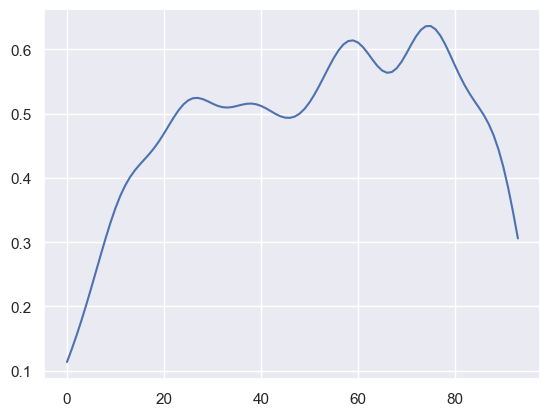

[706]
[384 704]
7801
cuda
epoch 1,loss = 1.00071454
epoch 2,loss = 1.00071216
epoch 3,loss = 1.00071001
epoch 4,loss = 1.00070786
epoch 5,loss = 1.00070572
epoch 6,loss = 1.00070357
epoch 7,loss = 1.00070167
epoch 8,loss = 1.00069976
epoch 9,loss = 1.00069773
epoch 10,loss = 1.00069594
epoch 11,loss = 1.00069416
epoch 12,loss = 1.00069249
epoch 13,loss = 1.00069070
epoch 14,loss = 1.00068915
epoch 15,loss = 1.00068748
epoch 16,loss = 1.00068605
epoch 17,loss = 1.00068450
epoch 18,loss = 1.00068307
epoch 19,loss = 1.00068176
epoch 20,loss = 1.00068045
epoch 21,loss = 1.00067925
epoch 22,loss = 1.00067806
epoch 23,loss = 1.00067687
epoch 24,loss = 1.00067592
epoch 25,loss = 1.00067484


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 26,loss = 1.00067389
epoch 27,loss = 1.00067282
epoch 28,loss = 1.00067210
epoch 29,loss = 1.00067103
epoch 30,loss = 1.00067031
epoch 31,loss = 1.00066960
epoch 32,loss = 1.00066888
epoch 33,loss = 1.00066829
epoch 34,loss = 1.00066769
epoch 35,loss = 1.00066710
epoch 36,loss = 1.00066650
epoch 37,loss = 1.00066578
epoch 38,loss = 1.00066531
epoch 39,loss = 1.00066483
epoch 40,loss = 1.00066447
epoch 41,loss = 1.00066400
epoch 42,loss = 1.00066280
epoch 43,loss = 1.00066257
epoch 44,loss = 1.00066233
epoch 45,loss = 1.00066197
epoch 46,loss = 1.00066185
epoch 47,loss = 1.00066173
epoch 48,loss = 1.00066137
epoch 49,loss = 1.00066125
epoch 50,loss = 1.00066090
epoch 51,loss = 1.00066066
epoch 52,loss = 1.00066006
epoch 53,loss = 1.00065970
epoch 54,loss = 1.00065923
epoch 55,loss = 1.00065875
epoch 56,loss = 1.00065815
epoch 57,loss = 1.00065756
epoch 58,loss = 1.00065696
epoch 59,loss = 1.00065649
epoch 60,loss = 1.00065589
epoch 61,loss = 1.00065529
epoch 62,loss = 1.00065470
e

epoch 331,loss = 0.83270180
epoch 332,loss = 0.83234298
epoch 333,loss = 0.83198088
epoch 334,loss = 0.83162075
epoch 335,loss = 0.83126891
epoch 336,loss = 0.83092171
epoch 337,loss = 0.83057582
epoch 338,loss = 0.83023107
epoch 339,loss = 0.82988089
epoch 340,loss = 0.82953185
epoch 341,loss = 0.82918257
epoch 342,loss = 0.82882929
epoch 343,loss = 0.82847267
epoch 344,loss = 0.82812142
epoch 345,loss = 0.82777220
epoch 346,loss = 0.82742494
epoch 347,loss = 0.82707787
epoch 348,loss = 0.82672739
epoch 349,loss = 0.82637304
epoch 350,loss = 0.82602489
epoch 351,loss = 0.82568127
epoch 352,loss = 0.82533902
epoch 353,loss = 0.82499105
epoch 354,loss = 0.82464629
epoch 355,loss = 0.82428652
epoch 356,loss = 0.82392520
epoch 357,loss = 0.82357389
epoch 358,loss = 0.82322866
epoch 359,loss = 0.82288259
epoch 360,loss = 0.82253146
epoch 361,loss = 0.82217610
epoch 362,loss = 0.82182211
epoch 363,loss = 0.82147068
epoch 364,loss = 0.82111180
epoch 365,loss = 0.82075298
epoch 366,loss = 0.8

epoch 639,loss = 0.75520116
epoch 640,loss = 0.75500590
epoch 641,loss = 0.75481093
epoch 642,loss = 0.75461173
epoch 643,loss = 0.75441092
epoch 644,loss = 0.75421268
epoch 645,loss = 0.75401449
epoch 646,loss = 0.75381207
epoch 647,loss = 0.75360769
epoch 648,loss = 0.75340796
epoch 649,loss = 0.75320923
epoch 650,loss = 0.75300896
epoch 651,loss = 0.75280893
epoch 652,loss = 0.75259972
epoch 653,loss = 0.75239652
epoch 654,loss = 0.75219309
epoch 655,loss = 0.75198907
epoch 656,loss = 0.75178635
epoch 657,loss = 0.75158221
epoch 658,loss = 0.75137413
epoch 659,loss = 0.75116438
epoch 660,loss = 0.75095379
epoch 661,loss = 0.75074774
epoch 662,loss = 0.75054419
epoch 663,loss = 0.75034213
epoch 664,loss = 0.75013644
epoch 665,loss = 0.74992573
epoch 666,loss = 0.74970955
epoch 667,loss = 0.74949068
epoch 668,loss = 0.74927515
epoch 669,loss = 0.74906033
epoch 670,loss = 0.74884742
epoch 671,loss = 0.74863219
epoch 672,loss = 0.74842393
epoch 673,loss = 0.74821889
epoch 674,loss = 0.7

epoch 953,loss = 0.71194524
epoch 954,loss = 0.71189237
epoch 955,loss = 0.71184063
epoch 956,loss = 0.71178943
epoch 957,loss = 0.71173835
epoch 958,loss = 0.71168727
epoch 959,loss = 0.71163666
epoch 960,loss = 0.71158659
epoch 961,loss = 0.71153677
epoch 962,loss = 0.71148723
epoch 963,loss = 0.71143824
epoch 964,loss = 0.71139014
epoch 965,loss = 0.71134335
epoch 966,loss = 0.71129686
epoch 967,loss = 0.71125078
epoch 968,loss = 0.71120489
epoch 969,loss = 0.71115935
epoch 970,loss = 0.71111429
epoch 971,loss = 0.71106964
epoch 972,loss = 0.71102536
epoch 973,loss = 0.71098119
epoch 974,loss = 0.71093750
epoch 975,loss = 0.71089417
epoch 976,loss = 0.71085137
epoch 977,loss = 0.71080929
epoch 978,loss = 0.71076792
epoch 979,loss = 0.71072733
epoch 980,loss = 0.71068710
epoch 981,loss = 0.71064746
epoch 982,loss = 0.71060783
epoch 983,loss = 0.71056849
epoch 984,loss = 0.71052957
epoch 985,loss = 0.71049106
epoch 986,loss = 0.71045274
epoch 987,loss = 0.71041459
epoch 988,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([973, 1, 20])
1.0
Epoch 200:   loss= 0.1594  cluster difference= 1.0
Epoch 400:   loss= 0.15737  cluster difference= 0.0041109969167523125
[2 4 3 1 6 7 1 5 1 6 7 1 0 2 4 3 1 0 7 1 5 1 6 7 1 5 1 4 3 1 0 2 1 5 1 6 7
 1 5 1 4 7 1 0 2 4 5 1 6 7 1 5 2 4 3 1 0 2 1 5 1 6 7 1 5 1 4 3 1 0 2 4 3 1
 6 7 1 5 1 4 7 1 0 2 4 3 1 6 2 1 5 1 6 3 1 0 2 4 3 1 0 2 1 5 1 6 7 1 0 2 4
 3 1 0 2 1 0 2 0 7 1 0 2 4 3 1 0 2 1 5 1 6 7 1 5 1 4 3 1 0 2 4 5 1 6 7 1 5
 1 4 3 1 0 2 4 3 1 0 7 1 5 1 6 3 1 0 2 4 3 1 0 2 1 5 1 6 3 1 0 2 4 3 1 6 2
 1 5 1 6 7 1 5 2 4 3 1 0 2 1 5 1 6 7 1 5 1 4 3 1 0 1 1 3 1 6 7 1 5 1 4 3 1
 0 2 4 3 1 6 7 1 5 1 6 7 1 0 2 4 3 1 0 7 1 5 1 6 7 1 0 2 4 3 1 6 2 1 5 1 6
 7 1 0 2 4 3 1 6 7 1 5 1 6 7 1 0 2 4 3 1 0 2 1 5 1 6 7 1 5 2 4 3 1 0 2 4 5
 1 6 7 1 5 1 6 7 1 0 2 4 3 1 0 2 1 5 1 6 7 1 0 2 4 3 1 0 7 1 5 1 6 7 1 0 2
 4 3 1 0 2 1 5 1 6 7 1 0 2 4 3 1 0 2 4 3 1 6 7 1 5 1 6 3 1 0 2 4 3 1 6 7 1
 5 1 6 7 1 0 2 4 3 1 0 7 1 5 1 6 7 1 0 2 4 3 1 6 7 1 5 1 6 7 1 0 2 4 3 1 6
 7 1 5 1 6 7 1 0 2 4 3 1 

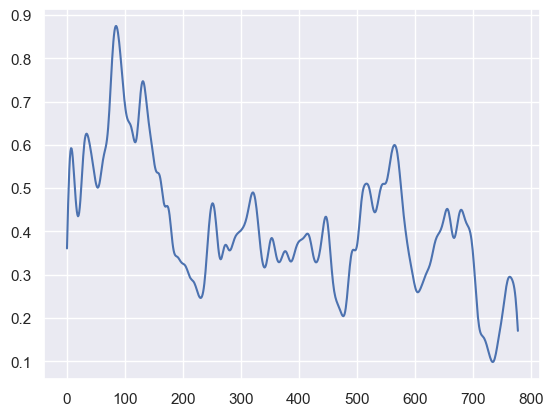

[1466]
[2365]
7169
cuda
epoch 1,loss = 0.98800051
epoch 2,loss = 0.98798752
epoch 3,loss = 0.98797452
epoch 4,loss = 0.98796141
epoch 5,loss = 0.98794854
epoch 6,loss = 0.98793542
epoch 7,loss = 0.98792243
epoch 8,loss = 0.98790932
epoch 9,loss = 0.98789608
epoch 10,loss = 0.98788297
epoch 11,loss = 0.98786980
epoch 12,loss = 0.98785645
epoch 13,loss = 0.98784322
epoch 14,loss = 0.98782992
epoch 15,loss = 0.98781645
epoch 16,loss = 0.98780292
epoch 17,loss = 0.98778951
epoch 18,loss = 0.98777592
epoch 19,loss = 0.98776215


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 20,loss = 0.98774844
epoch 21,loss = 0.98773468
epoch 22,loss = 0.98772067
epoch 23,loss = 0.98770666
epoch 24,loss = 0.98769248
epoch 25,loss = 0.98767829
epoch 26,loss = 0.98766387
epoch 27,loss = 0.98764932
epoch 28,loss = 0.98763460
epoch 29,loss = 0.98761976
epoch 30,loss = 0.98760480
epoch 31,loss = 0.98758972
epoch 32,loss = 0.98757440
epoch 33,loss = 0.98755890
epoch 34,loss = 0.98754317
epoch 35,loss = 0.98752731
epoch 36,loss = 0.98751116
epoch 37,loss = 0.98749501
epoch 38,loss = 0.98747838
epoch 39,loss = 0.98746169
epoch 40,loss = 0.98744464
epoch 41,loss = 0.98742735
epoch 42,loss = 0.98741001
epoch 43,loss = 0.98739219
epoch 44,loss = 0.98737419
epoch 45,loss = 0.98735595
epoch 46,loss = 0.98733723
epoch 47,loss = 0.98731828
epoch 48,loss = 0.98729879
epoch 49,loss = 0.98727912
epoch 50,loss = 0.98725903
epoch 51,loss = 0.98723853
epoch 52,loss = 0.98721772
epoch 53,loss = 0.98719633
epoch 54,loss = 0.98717463
epoch 55,loss = 0.98715234
epoch 56,loss = 0.98712963
e

epoch 339,loss = 0.74537313
epoch 340,loss = 0.74494362
epoch 341,loss = 0.74451989
epoch 342,loss = 0.74410295
epoch 343,loss = 0.74369264
epoch 344,loss = 0.74328858
epoch 345,loss = 0.74289030
epoch 346,loss = 0.74249673
epoch 347,loss = 0.74210930
epoch 348,loss = 0.74172848
epoch 349,loss = 0.74135518
epoch 350,loss = 0.74098736
epoch 351,loss = 0.74062485
epoch 352,loss = 0.74026793
epoch 353,loss = 0.73991609
epoch 354,loss = 0.73956949
epoch 355,loss = 0.73922890
epoch 356,loss = 0.73889321
epoch 357,loss = 0.73856306
epoch 358,loss = 0.73823762
epoch 359,loss = 0.73791367
epoch 360,loss = 0.73759317
epoch 361,loss = 0.73727584
epoch 362,loss = 0.73696232
epoch 363,loss = 0.73665160
epoch 364,loss = 0.73634392
epoch 365,loss = 0.73603815
epoch 366,loss = 0.73573399
epoch 367,loss = 0.73543239
epoch 368,loss = 0.73513341
epoch 369,loss = 0.73483717
epoch 370,loss = 0.73454267
epoch 371,loss = 0.73425114
epoch 372,loss = 0.73396170
epoch 373,loss = 0.73367429
epoch 374,loss = 0.7

epoch 656,loss = 0.69823939
epoch 657,loss = 0.69818842
epoch 658,loss = 0.69813734
epoch 659,loss = 0.69808632
epoch 660,loss = 0.69803518
epoch 661,loss = 0.69798416
epoch 662,loss = 0.69793320
epoch 663,loss = 0.69788182
epoch 664,loss = 0.69783068
epoch 665,loss = 0.69777930
epoch 666,loss = 0.69772750
epoch 667,loss = 0.69767541
epoch 668,loss = 0.69762331
epoch 669,loss = 0.69757116
epoch 670,loss = 0.69751900
epoch 671,loss = 0.69746679
epoch 672,loss = 0.69740731
epoch 673,loss = 0.69734073
epoch 674,loss = 0.69727147
epoch 675,loss = 0.69720000
epoch 676,loss = 0.69712657
epoch 677,loss = 0.69705147
epoch 678,loss = 0.69697517
epoch 679,loss = 0.69689786
epoch 680,loss = 0.69682091
epoch 681,loss = 0.69674450
epoch 682,loss = 0.69667470
epoch 683,loss = 0.69660467
epoch 684,loss = 0.69653487
epoch 685,loss = 0.69646561
epoch 686,loss = 0.69639635
epoch 687,loss = 0.69632739
epoch 688,loss = 0.69625860
epoch 689,loss = 0.69618970
epoch 690,loss = 0.69612110
epoch 691,loss = 0.6

epoch 970,loss = 0.67729574
epoch 971,loss = 0.67721379
epoch 972,loss = 0.67713189
epoch 973,loss = 0.67705017
epoch 974,loss = 0.67696899
epoch 975,loss = 0.67688745
epoch 976,loss = 0.67680669
epoch 977,loss = 0.67672628
epoch 978,loss = 0.67664599
epoch 979,loss = 0.67656577
epoch 980,loss = 0.67648584
epoch 981,loss = 0.67640597
epoch 982,loss = 0.67632657
epoch 983,loss = 0.67624754
epoch 984,loss = 0.67616916
epoch 985,loss = 0.67609078
epoch 986,loss = 0.67601162
epoch 987,loss = 0.67593235
epoch 988,loss = 0.67585301
epoch 989,loss = 0.67577386
epoch 990,loss = 0.67569333
epoch 991,loss = 0.67561162
epoch 992,loss = 0.67552960
epoch 993,loss = 0.67544740
epoch 994,loss = 0.67536539
epoch 995,loss = 0.67528367
epoch 996,loss = 0.67520201
epoch 997,loss = 0.67511821
epoch 998,loss = 0.67503595
epoch 999,loss = 0.67495257
epoch 1000,loss = 0.67486757
epoch 1001,loss = 0.67478222
epoch 1002,loss = 0.67469692
epoch 1003,loss = 0.67461175
epoch 1004,loss = 0.67452526
epoch 1005,loss

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([894, 1, 20])
1.0
Epoch 200:   loss= 0.18  cluster difference= 1.0
Epoch 400:   loss= 0.18703  cluster difference= 0.06935123042505593
Epoch 600:   loss= 0.189  cluster difference= 0.02237136465324385
Epoch 800:   loss= 0.18973  cluster difference= 0.011185682326621925
Epoch 1000:   loss= 0.19  cluster difference= 0.011185682326621925
Epoch 1200:   loss= 0.19004  cluster difference= 0.005592841163310962
[3 3 3 3 3 3 1 1 3 3 5 4 6 3 3 1 1 2 2 2 1 3 3 3 3 3 3 3 3 3 3 1 1 3 3 5 0
 6 3 1 1 1 2 7 7 1 3 3 3 3 1 1 1 1 2 2 2 4 6 1 7 4 6 7 7 7 7 2 2 1 1 2 2 2
 1 1 1 1 1 1 2 2 4 6 1 2 4 6 7 7 7 7 7 2 2 2 2 2 1 1 1 1 1 2 2 1 3 1 5 7 1
 2 0 6 6 2 2 2 3 4 6 6 1 1 1 2 7 1 1 3 3 3 3 1 2 1 3 5 7 3 3 3 3 3 3 3 2 1
 1 1 3 3 1 2 2 2 2 2 1 1 1 7 2 4 6 7 2 2 1 3 4 6 6 1 2 2 2 2 5 7 7 7 7 7 7
 5 7 7 7 0 6 6 3 3 3 4 4 4 6 6 1 2 7 7 1 1 1 1 1 1 2 2 1 3 5 0 6 3 3 3 3 3
 3 3 1 1 1 1 1 2 2 2 2 2 2 1 1 2 7 7 4 6 7 2 2 2 1 4 6 6 1 1 2 2 7 2 2 2 2
 2 2 3 3 2 7 0 6 2 7 7 7 2 1 4 6 3 2 2 2 2 2 2 7 2 2 2 1 

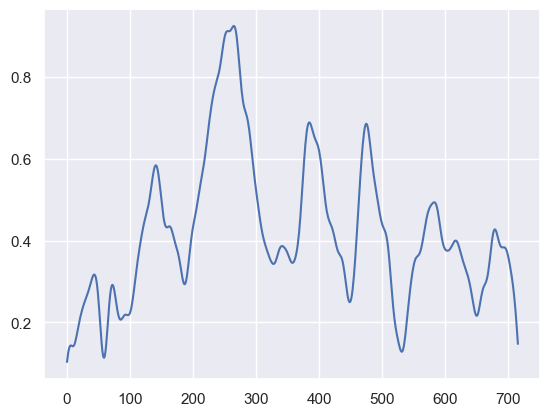

[2842, 3794, 4522]
[2663 5121]
1000
cuda
epoch 1,loss = 0.99673039
epoch 2,loss = 0.99671358
epoch 3,loss = 0.99669713
epoch 4,loss = 0.99668086
epoch 5,loss = 0.99666488
epoch 6,loss = 0.99664909
epoch 7,loss = 0.99663359
epoch 8,loss = 0.99661851
epoch 9,loss = 0.99660343
epoch 10,loss = 0.99658877
epoch 11,loss = 0.99657416
epoch 12,loss = 0.99655986
epoch 13,loss = 0.99654579
epoch 14,loss = 0.99653196
epoch 15,loss = 0.99651837
epoch 16,loss = 0.99650502
epoch 17,loss = 0.99649179
epoch 18,loss = 0.99647880
epoch 19,loss = 0.99646610
epoch 20,loss = 0.99645376
epoch 21,loss = 0.99644285
epoch 22,loss = 0.99643183
epoch 23,loss = 0.99642015
epoch 24,loss = 0.99640810
epoch 25,loss = 0.99639595
epoch 26,loss = 0.99638402
epoch 27,loss = 0.99637282
epoch 28,loss = 0.99636167
epoch 29,loss = 0.99635077
epoch 30,loss = 0.99633968
epoch 31,loss = 0.99632865
epoch 32,loss = 0.99631751
epoch 33,loss = 0.99630612
epoch 34,loss = 0.99629420
epoch 35,loss = 0.99628198
epoch 36,loss = 0.99626

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 57,loss = 0.99589109
epoch 58,loss = 0.99586529
epoch 59,loss = 0.99583876
epoch 60,loss = 0.99581128
epoch 61,loss = 0.99578291
epoch 62,loss = 0.99575394
epoch 63,loss = 0.99572426
epoch 64,loss = 0.99569380
epoch 65,loss = 0.99566323
epoch 66,loss = 0.99563223
epoch 67,loss = 0.99560088
epoch 68,loss = 0.99556893
epoch 69,loss = 0.99553657
epoch 70,loss = 0.99550331
epoch 71,loss = 0.99546957
epoch 72,loss = 0.99543506
epoch 73,loss = 0.99539959
epoch 74,loss = 0.99536371
epoch 75,loss = 0.99532700
epoch 76,loss = 0.99528944
epoch 77,loss = 0.99525052
epoch 78,loss = 0.99521065
epoch 79,loss = 0.99516958
epoch 80,loss = 0.99512768
epoch 81,loss = 0.99508440
epoch 82,loss = 0.99503988
epoch 83,loss = 0.99499422
epoch 84,loss = 0.99494767
epoch 85,loss = 0.99489975
epoch 86,loss = 0.99485040
epoch 87,loss = 0.99479938
epoch 88,loss = 0.99474716
epoch 89,loss = 0.99469370
epoch 90,loss = 0.99463850
epoch 91,loss = 0.99458164
epoch 92,loss = 0.99452329
epoch 93,loss = 0.99446332
e

epoch 362,loss = 0.78188884
epoch 363,loss = 0.78185236
epoch 364,loss = 0.78181624
epoch 365,loss = 0.78178018
epoch 366,loss = 0.78174353
epoch 367,loss = 0.78170699
epoch 368,loss = 0.78167075
epoch 369,loss = 0.78163493
epoch 370,loss = 0.78159964
epoch 371,loss = 0.78156334
epoch 372,loss = 0.78152722
epoch 373,loss = 0.78149122
epoch 374,loss = 0.78145534
epoch 375,loss = 0.78141952
epoch 376,loss = 0.78138345
epoch 377,loss = 0.78134745
epoch 378,loss = 0.78131139
epoch 379,loss = 0.78127515
epoch 380,loss = 0.78123927
epoch 381,loss = 0.78120375
epoch 382,loss = 0.78116810
epoch 383,loss = 0.78113252
epoch 384,loss = 0.78109682
epoch 385,loss = 0.78106087
epoch 386,loss = 0.78102511
epoch 387,loss = 0.78098947
epoch 388,loss = 0.78095388
epoch 389,loss = 0.78091878
epoch 390,loss = 0.78088433
epoch 391,loss = 0.78084993
epoch 392,loss = 0.78081566
epoch 393,loss = 0.78078133
epoch 394,loss = 0.78074700
epoch 395,loss = 0.78071171
epoch 396,loss = 0.78067625
epoch 397,loss = 0.7

epoch 658,loss = 0.77367926
epoch 659,loss = 0.77365255
epoch 660,loss = 0.77362585
epoch 661,loss = 0.77359921
epoch 662,loss = 0.77357274
epoch 663,loss = 0.77354646
epoch 664,loss = 0.77352023
epoch 665,loss = 0.77349406
epoch 666,loss = 0.77346796
epoch 667,loss = 0.77344179
epoch 668,loss = 0.77341563
epoch 669,loss = 0.77338946
epoch 670,loss = 0.77336323
epoch 671,loss = 0.77333713
epoch 672,loss = 0.77331096
epoch 673,loss = 0.77328473
epoch 674,loss = 0.77325851
epoch 675,loss = 0.77323222
epoch 676,loss = 0.77320594
epoch 677,loss = 0.77317971
epoch 678,loss = 0.77315348
epoch 679,loss = 0.77312732
epoch 680,loss = 0.77310103
epoch 681,loss = 0.77307487
epoch 682,loss = 0.77304870
epoch 683,loss = 0.77302253
epoch 684,loss = 0.77299643
epoch 685,loss = 0.77297038
epoch 686,loss = 0.77294427
epoch 687,loss = 0.77291816
epoch 688,loss = 0.77289224
epoch 689,loss = 0.77286637
epoch 690,loss = 0.77284044
epoch 691,loss = 0.77281374
epoch 692,loss = 0.77278662
epoch 693,loss = 0.7

epoch 985,loss = 0.76508665
epoch 986,loss = 0.76506913
epoch 987,loss = 0.76505178
epoch 988,loss = 0.76503456
epoch 989,loss = 0.76501745
epoch 990,loss = 0.76500028
epoch 991,loss = 0.76498324
epoch 992,loss = 0.76496619
epoch 993,loss = 0.76494932
epoch 994,loss = 0.76493245
epoch 995,loss = 0.76491570
epoch 996,loss = 0.76489902
epoch 997,loss = 0.76488233
epoch 998,loss = 0.76486576
epoch 999,loss = 0.76484931
epoch 1000,loss = 0.76483291
epoch 1001,loss = 0.76481652
epoch 1002,loss = 0.76480025
epoch 1003,loss = 0.76478410
epoch 1004,loss = 0.76476800
epoch 1005,loss = 0.76475191
epoch 1006,loss = 0.76473588
epoch 1007,loss = 0.76471996
epoch 1008,loss = 0.76470393
epoch 1009,loss = 0.76468790
epoch 1010,loss = 0.76467186
epoch 1011,loss = 0.76465595
epoch 1012,loss = 0.76464009
epoch 1013,loss = 0.76462424
epoch 1014,loss = 0.76460844
epoch 1015,loss = 0.76459277
epoch 1016,loss = 0.76457697
epoch 1017,loss = 0.76456058
epoch 1018,loss = 0.76454431
epoch 1019,loss = 0.76452851


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([123, 1, 20])
1.0
Epoch 200:   loss= 0.20162  cluster difference= 1.0
Epoch 400:   loss= 0.20164  cluster difference= 0.0
[2 0 2 7 4 0 0 3 1 2 0 2 7 4 0 6 3 1 2 0 2 1 4 0 6 3 1 2 0 5 1 4 0 6 3 1 0
 0 5 1 4 0 6 3 1 0 0 5 1 2 0 6 7 4 0 0 5 1 2 0 6 7 4 0 0 3 1 2 0 2 7 4 0 6
 3 1 2 0 2 7 4 0 6 3 1 2 0 5 1 4 0 6 3 1 2 0 5 1 4 0 6 3 1 0 0 5 1 4 0 6 3
 1 0 0 5 1 2 0 6 7 4 0 0]


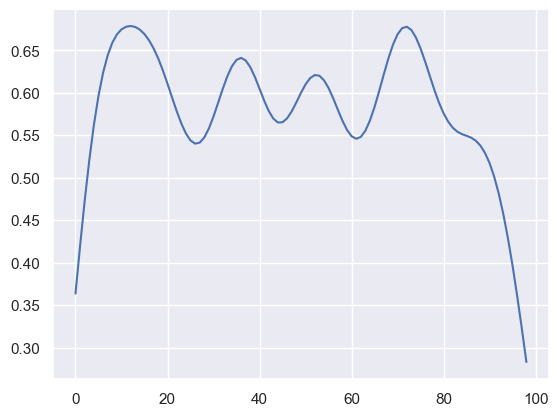

[202]
[500]
11250
cuda
epoch 1,loss = 1.01332557
epoch 2,loss = 1.01332116
epoch 3,loss = 1.01331675
epoch 4,loss = 1.01331222
epoch 5,loss = 1.01330793
epoch 6,loss = 1.01330376
epoch 7,loss = 1.01329947
epoch 8,loss = 1.01329541
epoch 9,loss = 1.01329136
epoch 10,loss = 1.01328743
epoch 11,loss = 1.01328349
epoch 12,loss = 1.01327956
epoch 13,loss = 1.01327562
epoch 14,loss = 1.01327193
epoch 15,loss = 1.01326823
epoch 16,loss = 1.01326466
epoch 17,loss = 1.01326120
epoch 18,loss = 1.01325762
epoch 19,loss = 1.01325417
epoch 20,loss = 1.01325095
epoch 21,loss = 1.01324761
epoch 22,loss = 1.01324439
epoch 23,loss = 1.01324117
epoch 24,loss = 1.01323807
epoch 25,loss = 1.01323521
epoch 26,loss = 1.01323223
epoch 27,loss = 1.01322937
epoch 28,loss = 1.01322651
epoch 29,loss = 1.01322389
epoch 30,loss = 1.01322114
epoch 31,loss = 1.01321852
epoch 32,loss = 1.01321602
epoch 33,loss = 1.01321352
epoch 34,loss = 1.01321113
epoch 35,loss = 1.01320887
epoch 36,loss = 1.01320648
epoch 37,loss 

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 38,loss = 1.01320219
epoch 39,loss = 1.01320004
epoch 40,loss = 1.01319790
epoch 41,loss = 1.01319599
epoch 42,loss = 1.01319408
epoch 43,loss = 1.01319218
epoch 44,loss = 1.01319039
epoch 45,loss = 1.01318872
epoch 46,loss = 1.01318693
epoch 47,loss = 1.01318526
epoch 48,loss = 1.01318371
epoch 49,loss = 1.01318216
epoch 50,loss = 1.01318061
epoch 51,loss = 1.01317906
epoch 52,loss = 1.01317775
epoch 53,loss = 1.01317620
epoch 54,loss = 1.01317501
epoch 55,loss = 1.01317370
epoch 56,loss = 1.01316822
epoch 57,loss = 1.01316750
epoch 58,loss = 1.01317227
epoch 59,loss = 1.01317477
epoch 60,loss = 1.01317537
epoch 61,loss = 1.01317513
epoch 62,loss = 1.01317382
epoch 63,loss = 1.01317179
epoch 64,loss = 1.01316917
epoch 65,loss = 1.01316619
epoch 66,loss = 1.01316273
epoch 67,loss = 1.01315749
epoch 68,loss = 1.01315224
epoch 69,loss = 1.01316118
epoch 70,loss = 1.01314914
epoch 71,loss = 1.01314664
epoch 72,loss = 1.01314580
epoch 73,loss = 1.01314390
epoch 74,loss = 1.01314080
e

epoch 347,loss = 0.89995062
epoch 348,loss = 0.89974248
epoch 349,loss = 0.89953429
epoch 350,loss = 0.89932609
epoch 351,loss = 0.89911586
epoch 352,loss = 0.89890373
epoch 353,loss = 0.89868999
epoch 354,loss = 0.89847040
epoch 355,loss = 0.89824843
epoch 356,loss = 0.89802849
epoch 357,loss = 0.89780575
epoch 358,loss = 0.89757979
epoch 359,loss = 0.89735323
epoch 360,loss = 0.89711767
epoch 361,loss = 0.89687240
epoch 362,loss = 0.89660782
epoch 363,loss = 0.89633352
epoch 364,loss = 0.89605683
epoch 365,loss = 0.89577162
epoch 366,loss = 0.89548504
epoch 367,loss = 0.89519602
epoch 368,loss = 0.89488697
epoch 369,loss = 0.89457113
epoch 370,loss = 0.89424652
epoch 371,loss = 0.89391416
epoch 372,loss = 0.89357406
epoch 373,loss = 0.89323723
epoch 374,loss = 0.89289963
epoch 375,loss = 0.89255410
epoch 376,loss = 0.89221495
epoch 377,loss = 0.89187890
epoch 378,loss = 0.89156526
epoch 379,loss = 0.89126360
epoch 380,loss = 0.89097255
epoch 381,loss = 0.89068872
epoch 382,loss = 0.8

epoch 648,loss = 0.85817713
epoch 649,loss = 0.85810697
epoch 650,loss = 0.85803795
epoch 651,loss = 0.85796922
epoch 652,loss = 0.85790133
epoch 653,loss = 0.85783529
epoch 654,loss = 0.85777009
epoch 655,loss = 0.85770619
epoch 656,loss = 0.85764122
epoch 657,loss = 0.85757625
epoch 658,loss = 0.85751170
epoch 659,loss = 0.85744643
epoch 660,loss = 0.85738015
epoch 661,loss = 0.85731500
epoch 662,loss = 0.85724944
epoch 663,loss = 0.85718220
epoch 664,loss = 0.85711581
epoch 665,loss = 0.85704952
epoch 666,loss = 0.85698366
epoch 667,loss = 0.85691935
epoch 668,loss = 0.85685587
epoch 669,loss = 0.85678971
epoch 670,loss = 0.85672522
epoch 671,loss = 0.85666233
epoch 672,loss = 0.85659862
epoch 673,loss = 0.85653371
epoch 674,loss = 0.85646915
epoch 675,loss = 0.85641122
epoch 676,loss = 0.85635328
epoch 677,loss = 0.85629451
epoch 678,loss = 0.85623527
epoch 679,loss = 0.85617840
epoch 680,loss = 0.85612082
epoch 681,loss = 0.85606384
epoch 682,loss = 0.85600656
epoch 683,loss = 0.8

epoch 946,loss = 0.84070563
epoch 947,loss = 0.84069306
epoch 948,loss = 0.84067947
epoch 949,loss = 0.84067041
epoch 950,loss = 0.84064907
epoch 951,loss = 0.84063524
epoch 952,loss = 0.84062541
epoch 953,loss = 0.84061146
epoch 954,loss = 0.84059513
epoch 955,loss = 0.84058523
epoch 956,loss = 0.84056991
epoch 957,loss = 0.84055805
epoch 958,loss = 0.84054452
epoch 959,loss = 0.84052986
epoch 960,loss = 0.84051454
epoch 961,loss = 0.84049916
epoch 962,loss = 0.84048480
epoch 963,loss = 0.84046793
epoch 964,loss = 0.84044647
epoch 965,loss = 0.84042478
epoch 966,loss = 0.84040105
epoch 967,loss = 0.84037417
epoch 968,loss = 0.84034759
epoch 969,loss = 0.84032947
epoch 970,loss = 0.84031218
epoch 971,loss = 0.84029657
epoch 972,loss = 0.84028250
epoch 973,loss = 0.84026575
epoch 974,loss = 0.84024537
epoch 975,loss = 0.84022421
epoch 976,loss = 0.84020197
epoch 977,loss = 0.84017855
epoch 978,loss = 0.84015232
epoch 979,loss = 0.84012139
epoch 980,loss = 0.84008253
epoch 981,loss = 0.8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([560, 1, 50])
1.0
Epoch 200:   loss= 0.18993  cluster difference= 1.0
Epoch 400:   loss= 0.1905  cluster difference= 0.026785714285714284
Epoch 600:   loss= 0.19074  cluster difference= 0.0375
Epoch 800:   loss= 0.19058  cluster difference= 0.023214285714285715
Epoch 1000:   loss= 0.19007  cluster difference= 0.025
Epoch 1200:   loss= 0.18971  cluster difference= 0.05714285714285714
Epoch 1400:   loss= 0.18888  cluster difference= 0.025
Epoch 1600:   loss= 0.18831  cluster difference= 0.02857142857142857
Epoch 1800:   loss= 0.18792  cluster difference= 0.0017857142857142857
[7 1 0 1 0 7 3 5 2 7 1 3 3 3 3 3 3 3 3 3 3 3 4 4 3 6 3 5 2 3 4 7 3 3 0 1 4
 7 7 1 0 6 6 6 0 1 3 5 2 3 7 3 3 3 3 4 0 7 7 1 3 4 3 5 2 7 7 7 3 5 2 7 7 3
 4 1 0 3 6 3 3 3 3 4 2 3 3 3 0 1 2 3 5 2 3 4 7 1 3 3 3 1 5 4 7 7 3 3 2 3 1
 6 7 1 2 5 2 3 3 3 3 0 1 3 3 4 3 0 1 3 6 3 3 3 5 2 7 1 3 3 4 3 5 2 4 7 3 3
 3 3 3 3 2 3 7 3 1 6 3 3 3 3 0 4 5 2 3 2 3 7 3 7 1 5 2 0 1 5 2 3 3 3 3 0 6
 3 7 1 3 0 1 5 4 4 1 7 7 3 5 2 0 

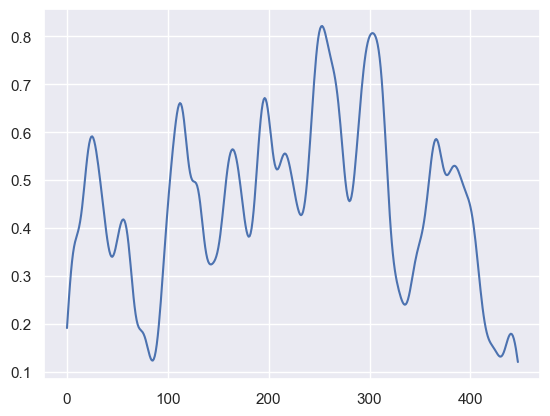

[3385, 5065, 6205]
[5625]
3092
cuda
epoch 1,loss = 1.11870885
epoch 2,loss = 1.11753833
epoch 3,loss = 1.11637449
epoch 4,loss = 1.11521745
epoch 5,loss = 1.11406708
epoch 6,loss = 1.11292374
epoch 7,loss = 1.11178732
epoch 8,loss = 1.11065805
epoch 9,loss = 1.10953581
epoch 10,loss = 1.10842085
epoch 11,loss = 1.10731304
epoch 12,loss = 1.10621297
epoch 13,loss = 1.10512006
epoch 14,loss = 1.10403466
epoch 15,loss = 1.10295677
epoch 16,loss = 1.10188651
epoch 17,loss = 1.10082400
epoch 18,loss = 1.09976912
epoch 19,loss = 1.09872210
epoch 20,loss = 1.09768271
epoch 21,loss = 1.09665108
epoch 22,loss = 1.09562743
epoch 23,loss = 1.09461141
epoch 24,loss = 1.09360349
epoch 25,loss = 1.09260309
epoch 26,loss = 1.09161079
epoch 27,loss = 1.09062660
epoch 28,loss = 1.08964992
epoch 29,loss = 1.08868062
epoch 30,loss = 1.08771956
epoch 31,loss = 1.08676648
epoch 32,loss = 1.08582115
epoch 33,loss = 1.08488393
epoch 34,loss = 1.08395445
epoch 35,loss = 1.08303285
epoch 36,loss = 1.08211875
e

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 49,loss = 1.07093203
epoch 50,loss = 1.07012367
epoch 51,loss = 1.06932235
epoch 52,loss = 1.06852829
epoch 53,loss = 1.06774116
epoch 54,loss = 1.06696117
epoch 55,loss = 1.06618822
epoch 56,loss = 1.06542242
epoch 57,loss = 1.06466329
epoch 58,loss = 1.06391120
epoch 59,loss = 1.06316590
epoch 60,loss = 1.06242728
epoch 61,loss = 1.06169558
epoch 62,loss = 1.06097031
epoch 63,loss = 1.06025195
epoch 64,loss = 1.05954015
epoch 65,loss = 1.05883479
epoch 66,loss = 1.05813575
epoch 67,loss = 1.05744338
epoch 68,loss = 1.05675733
epoch 69,loss = 1.05607760
epoch 70,loss = 1.05540419
epoch 71,loss = 1.05473697
epoch 72,loss = 1.05407608
epoch 73,loss = 1.05342126
epoch 74,loss = 1.05277240
epoch 75,loss = 1.05212975
epoch 76,loss = 1.05149317
epoch 77,loss = 1.05086243
epoch 78,loss = 1.05023754
epoch 79,loss = 1.04961872
epoch 80,loss = 1.04900551
epoch 81,loss = 1.04839814
epoch 82,loss = 1.04779661
epoch 83,loss = 1.04720056
epoch 84,loss = 1.04661024
epoch 85,loss = 1.04602551
e

epoch 344,loss = 0.81669730
epoch 345,loss = 0.81657732
epoch 346,loss = 0.81645715
epoch 347,loss = 0.81633705
epoch 348,loss = 0.81621671
epoch 349,loss = 0.81609571
epoch 350,loss = 0.81597465
epoch 351,loss = 0.81585371
epoch 352,loss = 0.81573284
epoch 353,loss = 0.81561184
epoch 354,loss = 0.81549102
epoch 355,loss = 0.81536984
epoch 356,loss = 0.81524843
epoch 357,loss = 0.81512636
epoch 358,loss = 0.81500435
epoch 359,loss = 0.81488240
epoch 360,loss = 0.81475979
epoch 361,loss = 0.81463778
epoch 362,loss = 0.81451601
epoch 363,loss = 0.81439400
epoch 364,loss = 0.81427187
epoch 365,loss = 0.81414956
epoch 366,loss = 0.81402743
epoch 367,loss = 0.81390548
epoch 368,loss = 0.81378359
epoch 369,loss = 0.81366169
epoch 370,loss = 0.81353945
epoch 371,loss = 0.81341773
epoch 372,loss = 0.81329620
epoch 373,loss = 0.81317496
epoch 374,loss = 0.81305462
epoch 375,loss = 0.81293464
epoch 376,loss = 0.81281531
epoch 377,loss = 0.81269670
epoch 378,loss = 0.81257838
epoch 379,loss = 0.8

epoch 645,loss = 0.79814142
epoch 646,loss = 0.79811484
epoch 647,loss = 0.79808837
epoch 648,loss = 0.79806232
epoch 649,loss = 0.79803610
epoch 650,loss = 0.79801005
epoch 651,loss = 0.79798394
epoch 652,loss = 0.79795814
epoch 653,loss = 0.79793233
epoch 654,loss = 0.79790682
epoch 655,loss = 0.79788142
epoch 656,loss = 0.79785639
epoch 657,loss = 0.79783165
epoch 658,loss = 0.79780686
epoch 659,loss = 0.79778224
epoch 660,loss = 0.79775774
epoch 661,loss = 0.79773325
epoch 662,loss = 0.79770881
epoch 663,loss = 0.79768449
epoch 664,loss = 0.79766065
epoch 665,loss = 0.79763699
epoch 666,loss = 0.79761320
epoch 667,loss = 0.79758954
epoch 668,loss = 0.79756600
epoch 669,loss = 0.79754251
epoch 670,loss = 0.79751903
epoch 671,loss = 0.79749554
epoch 672,loss = 0.79747194
epoch 673,loss = 0.79744822
epoch 674,loss = 0.79742455
epoch 675,loss = 0.79740083
epoch 676,loss = 0.79737705
epoch 677,loss = 0.79735321
epoch 678,loss = 0.79732937
epoch 679,loss = 0.79730552
epoch 680,loss = 0.7

epoch 960,loss = 0.79154837
epoch 961,loss = 0.79152215
epoch 962,loss = 0.79149604
epoch 963,loss = 0.79146999
epoch 964,loss = 0.79144442
epoch 965,loss = 0.79141939
epoch 966,loss = 0.79139477
epoch 967,loss = 0.79137087
epoch 968,loss = 0.79134756
epoch 969,loss = 0.79132468
epoch 970,loss = 0.79130208
epoch 971,loss = 0.79127961
epoch 972,loss = 0.79125744
epoch 973,loss = 0.79123551
epoch 974,loss = 0.79121369
epoch 975,loss = 0.79119217
epoch 976,loss = 0.79117078
epoch 977,loss = 0.79114956
epoch 978,loss = 0.79112881
epoch 979,loss = 0.79110819
epoch 980,loss = 0.79108769
epoch 981,loss = 0.79106742
epoch 982,loss = 0.79104710
epoch 983,loss = 0.79102683
epoch 984,loss = 0.79100674
epoch 985,loss = 0.79098696
epoch 986,loss = 0.79096723
epoch 987,loss = 0.79094762
epoch 988,loss = 0.79092830
epoch 989,loss = 0.79090923
epoch 990,loss = 0.79089022
epoch 991,loss = 0.79087120
epoch 992,loss = 0.79085231
epoch 993,loss = 0.79083359
epoch 994,loss = 0.79081464
epoch 995,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([384, 1, 20])
1.0
Epoch 200:   loss= 0.20081  cluster difference= 1.0
Epoch 400:   loss= 0.20272  cluster difference= 0.057291666666666664
Epoch 600:   loss= 0.20374  cluster difference= 0.028645833333333332
Epoch 800:   loss= 0.20457  cluster difference= 0.052083333333333336
Epoch 1000:   loss= 0.20535  cluster difference= 0.03125
Epoch 1200:   loss= 0.20614  cluster difference= 0.046875
Epoch 1400:   loss= 0.20692  cluster difference= 0.018229166666666668
Epoch 1600:   loss= 0.20757  cluster difference= 0.0234375
Epoch 1800:   loss= 0.20804  cluster difference= 0.013020833333333334
Epoch 2000:   loss= 0.20836  cluster difference= 0.010416666666666666
Epoch 2200:   loss= 0.20855  cluster difference= 0.005208333333333333
[7 7 1 2 0 7 7 1 0 0 7 5 3 5 3 1 0 7 2 4 7 1 0 7 2 4 5 3 1 0 2 4 5 3 1 0 7
 7 2 5 3 7 1 6 7 5 4 5 0 3 1 6 7 7 5 0 3 7 2 4 5 3 7 6 7 5 4 5 3 7 1 2 2 4
 5 3 1 2 4 5 3 1 0 7 7 2 2 4 7 5 0 1 6 7 5 0 7 4 1 2 4 5 0 7 7 1 6 7 5 0 1
 0 1 2 4 5 0 1 4 7 6 4 5 0 1 2 4 

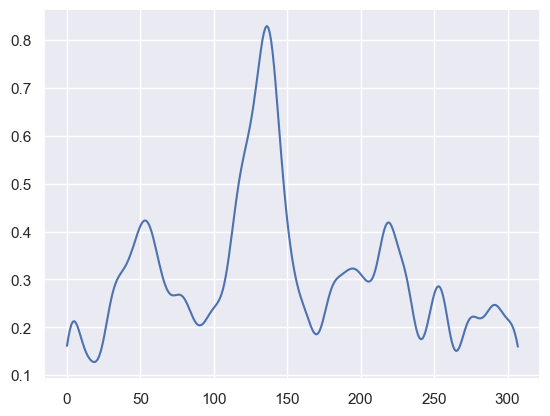

[1402]
[ 712 1293 1930 2586]
3074
cuda
epoch 1,loss = 1.17107582
epoch 2,loss = 1.16974461
epoch 3,loss = 1.16841388
epoch 4,loss = 1.16707885
epoch 5,loss = 1.16574585
epoch 6,loss = 1.16441107
epoch 7,loss = 1.16307306
epoch 8,loss = 1.16172755
epoch 9,loss = 1.16035581
epoch 10,loss = 1.15895581
epoch 11,loss = 1.15758002
epoch 12,loss = 1.15625787
epoch 13,loss = 1.15496874
epoch 14,loss = 1.15370715
epoch 15,loss = 1.15247178
epoch 16,loss = 1.15126038
epoch 17,loss = 1.15005648
epoch 18,loss = 1.14885604
epoch 19,loss = 1.14765382
epoch 20,loss = 1.14644837
epoch 21,loss = 1.14523971
epoch 22,loss = 1.14402819
epoch 23,loss = 1.14281511
epoch 24,loss = 1.14160180
epoch 25,loss = 1.14039087
epoch 26,loss = 1.13918424
epoch 27,loss = 1.13798344
epoch 28,loss = 1.13679051
epoch 29,loss = 1.13560534
epoch 30,loss = 1.13442707
epoch 31,loss = 1.13325500
epoch 32,loss = 1.13208723
epoch 33,loss = 1.13092160
epoch 34,loss = 1.12975657
epoch 35,loss = 1.12859082
epoch 36,loss = 1.1274230

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 38,loss = 1.12508130
epoch 39,loss = 1.12390590
epoch 40,loss = 1.12272906
epoch 41,loss = 1.12154841
epoch 42,loss = 1.12035990
epoch 43,loss = 1.11916518
epoch 44,loss = 1.11796188
epoch 45,loss = 1.11674607
epoch 46,loss = 1.11551368
epoch 47,loss = 1.11426663
epoch 48,loss = 1.11300230
epoch 49,loss = 1.11171973
epoch 50,loss = 1.11041653
epoch 51,loss = 1.10909069
epoch 52,loss = 1.10774910
epoch 53,loss = 1.10638356
epoch 54,loss = 1.10499144
epoch 55,loss = 1.10357440
epoch 56,loss = 1.10213792
epoch 57,loss = 1.10069156
epoch 58,loss = 1.09923136
epoch 59,loss = 1.09775651
epoch 60,loss = 1.09627020
epoch 61,loss = 1.09477258
epoch 62,loss = 1.09326148
epoch 63,loss = 1.09173965
epoch 64,loss = 1.09020734
epoch 65,loss = 1.08866656
epoch 66,loss = 1.08712053
epoch 67,loss = 1.08556831
epoch 68,loss = 1.08401191
epoch 69,loss = 1.08245492
epoch 70,loss = 1.08089650
epoch 71,loss = 1.07933772
epoch 72,loss = 1.07778192
epoch 73,loss = 1.07621896
epoch 74,loss = 1.07464623
e

epoch 356,loss = 0.80742228
epoch 357,loss = 0.80651408
epoch 358,loss = 0.80560964
epoch 359,loss = 0.80471343
epoch 360,loss = 0.80382502
epoch 361,loss = 0.80294633
epoch 362,loss = 0.80207878
epoch 363,loss = 0.80122596
epoch 364,loss = 0.80038524
epoch 365,loss = 0.79955727
epoch 366,loss = 0.79874009
epoch 367,loss = 0.79793340
epoch 368,loss = 0.79713559
epoch 369,loss = 0.79634809
epoch 370,loss = 0.79557019
epoch 371,loss = 0.79480129
epoch 372,loss = 0.79403937
epoch 373,loss = 0.79328769
epoch 374,loss = 0.79254198
epoch 375,loss = 0.79180264
epoch 376,loss = 0.79107022
epoch 377,loss = 0.79034764
epoch 378,loss = 0.78963143
epoch 379,loss = 0.78891945
epoch 380,loss = 0.78820616
epoch 381,loss = 0.78748417
epoch 382,loss = 0.78676480
epoch 383,loss = 0.78605080
epoch 384,loss = 0.78533047
epoch 385,loss = 0.78461093
epoch 386,loss = 0.78389966
epoch 387,loss = 0.78318208
epoch 388,loss = 0.78244567
epoch 389,loss = 0.78170276
epoch 390,loss = 0.78096861
epoch 391,loss = 0.7

epoch 676,loss = 0.69160593
epoch 677,loss = 0.69150561
epoch 678,loss = 0.69140565
epoch 679,loss = 0.69130671
epoch 680,loss = 0.69120908
epoch 681,loss = 0.69111067
epoch 682,loss = 0.69101262
epoch 683,loss = 0.69091630
epoch 684,loss = 0.69082069
epoch 685,loss = 0.69072402
epoch 686,loss = 0.69062853
epoch 687,loss = 0.69053555
epoch 688,loss = 0.69044375
epoch 689,loss = 0.69035339
epoch 690,loss = 0.69026405
epoch 691,loss = 0.69017428
epoch 692,loss = 0.69008470
epoch 693,loss = 0.68999702
epoch 694,loss = 0.68991184
epoch 695,loss = 0.68982887
epoch 696,loss = 0.68974739
epoch 697,loss = 0.68966591
epoch 698,loss = 0.68958312
epoch 699,loss = 0.68950093
epoch 700,loss = 0.68942004
epoch 701,loss = 0.68933988
epoch 702,loss = 0.68926227
epoch 703,loss = 0.68918824
epoch 704,loss = 0.68911523
epoch 705,loss = 0.68904120
epoch 706,loss = 0.68896687
epoch 707,loss = 0.68889320
epoch 708,loss = 0.68881953
epoch 709,loss = 0.68874693
epoch 710,loss = 0.68867648
epoch 711,loss = 0.6

epoch 970,loss = 0.67720646
epoch 971,loss = 0.67718911
epoch 972,loss = 0.67717236
epoch 973,loss = 0.67715508
epoch 974,loss = 0.67713827
epoch 975,loss = 0.67712158
epoch 976,loss = 0.67710447
epoch 977,loss = 0.67708695
epoch 978,loss = 0.67706919
epoch 979,loss = 0.67705029
epoch 980,loss = 0.67702627
epoch 981,loss = 0.67700094
epoch 982,loss = 0.67697448
epoch 983,loss = 0.67694789
epoch 984,loss = 0.67692131
epoch 985,loss = 0.67689472
epoch 986,loss = 0.67686778
epoch 987,loss = 0.67684102
epoch 988,loss = 0.67681438
epoch 989,loss = 0.67679435
epoch 990,loss = 0.67678171
epoch 991,loss = 0.67676693
epoch 992,loss = 0.67675000
epoch 993,loss = 0.67673063
epoch 994,loss = 0.67671043
epoch 995,loss = 0.67669100
epoch 996,loss = 0.67667109
epoch 997,loss = 0.67665118
epoch 998,loss = 0.67663032
epoch 999,loss = 0.67661422
epoch 1000,loss = 0.67660028
epoch 1001,loss = 0.67658305
epoch 1002,loss = 0.67656380
epoch 1003,loss = 0.67654508
epoch 1004,loss = 0.67652440
epoch 1005,loss

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([382, 1, 20])
1.0
Epoch 200:   loss= 0.19722  cluster difference= 1.0
Epoch 400:   loss= 0.19716  cluster difference= 0.03926701570680628
Epoch 600:   loss= 0.19753  cluster difference= 0.010471204188481676
Epoch 800:   loss= 0.19796  cluster difference= 0.01832460732984293
Epoch 1000:   loss= 0.19837  cluster difference= 0.005235602094240838
[3 7 6 3 0 3 0 3 7 7 0 6 7 7 5 2 0 1 7 7 6 5 2 2 6 6 5 4 6 7 6 7 0 5 4 6 1
 0 1 2 4 6 5 2 0 1 4 5 4 6 2 0 1 4 5 2 6 1 1 4 6 3 0 7 0 6 3 7 6 7 6 1 0 3
 4 3 7 6 1 0 3 4 5 2 6 1 0 3 7 6 1 0 1 4 3 4 5 7 6 1 0 3 2 6 1 0 1 4 3 7 6
 7 0 3 0 6 6 6 1 0 1 4 5 2 6 1 0 1 4 5 7 6 7 0 3 0 5 2 6 1 0 3 4 3 7 6 1 0
 5 4 5 4 7 0 6 3 4 5 4 3 0 6 5 2 6 7 6 1 0 3 0 2 5 0 5 4 5 2 6 1 0 1 4 5 2
 0 6 1 0 7 6 7 1 0 6 1 0 5 4 6 2 0 1 0 5 2 6 2 0 1 4 6 7 7 6 0 3 0 5 2 6 7
 0 3 4 6 2 6 1 2 6 5 0 6 7 6 3 6 5 4 6 1 0 5 4 5 0 3 6 3 0 5 1 0 6 6 3 7 6
 5 4 6 7 6 3 0 5 4 6 3 0 1 4 6 7 6 1 6 6 5 4 4 6 6 3 0 4 6 6 6 6 6 5 4 5 2
 6 6 3 6 3 7 6 1 0 1 4 3 7 6 7 1 4 5 2 6 6 1

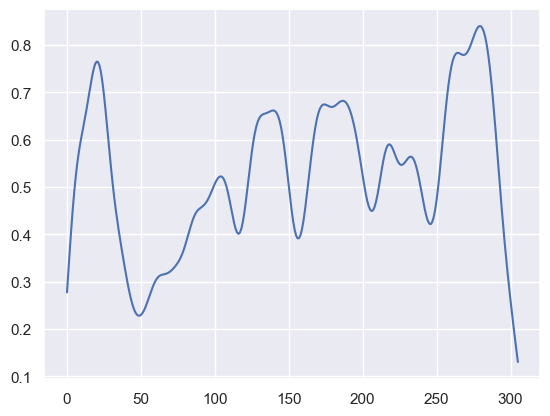

[474, 1426, 1810, 2546]
[ 525 1162 1837 2399]
2717
cuda
epoch 1,loss = 1.01557004
epoch 2,loss = 1.01495135
epoch 3,loss = 1.01435018
epoch 4,loss = 1.01376629
epoch 5,loss = 1.01320004
epoch 6,loss = 1.01265240
epoch 7,loss = 1.01212466
epoch 8,loss = 1.01161551
epoch 9,loss = 1.01112330
epoch 10,loss = 1.01064825
epoch 11,loss = 1.01019001
epoch 12,loss = 1.00974810
epoch 13,loss = 1.00932181
epoch 14,loss = 1.00891173
epoch 15,loss = 1.00852203
epoch 16,loss = 1.00809789
epoch 17,loss = 1.00774026
epoch 18,loss = 1.00739455
epoch 19,loss = 1.00705945
epoch 20,loss = 1.00673687
epoch 21,loss = 1.00642836
epoch 22,loss = 1.00613785
epoch 23,loss = 1.00585115
epoch 24,loss = 1.00557542
epoch 25,loss = 1.00531077
epoch 26,loss = 1.00505722
epoch 27,loss = 1.00481439
epoch 28,loss = 1.00458193
epoch 29,loss = 1.00435972
epoch 30,loss = 1.00414753
epoch 31,loss = 1.00394535
epoch 32,loss = 1.00374949
epoch 33,loss = 1.00356233
epoch 34,loss = 1.00338364
epoch 35,loss = 1.00321281
epoch 36

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 51,loss = 1.00132549
epoch 52,loss = 1.00124776
epoch 53,loss = 1.00117326
epoch 54,loss = 1.00110257
epoch 55,loss = 1.00103748
epoch 56,loss = 1.00098026
epoch 57,loss = 1.00093150
epoch 58,loss = 1.00089109
epoch 59,loss = 1.00085807
epoch 60,loss = 1.00083041
epoch 61,loss = 1.00080526
epoch 62,loss = 1.00078297
epoch 63,loss = 1.00076294
epoch 64,loss = 1.00074518
epoch 65,loss = 1.00072896
epoch 66,loss = 1.00071347
epoch 67,loss = 1.00069749
epoch 68,loss = 1.00068188
epoch 69,loss = 1.00066578
epoch 70,loss = 1.00064898
epoch 71,loss = 1.00063145
epoch 72,loss = 1.00061321
epoch 73,loss = 1.00059390
epoch 74,loss = 1.00057352
epoch 75,loss = 1.00055230
epoch 76,loss = 1.00052965
epoch 77,loss = 1.00050557
epoch 78,loss = 1.00048065
epoch 79,loss = 1.00045466
epoch 80,loss = 1.00042748
epoch 81,loss = 1.00039923
epoch 82,loss = 1.00036991
epoch 83,loss = 1.00033951
epoch 84,loss = 1.00030780
epoch 85,loss = 1.00027490
epoch 86,loss = 1.00024068
epoch 87,loss = 1.00020516
e

epoch 366,loss = 0.83065671
epoch 367,loss = 0.83030784
epoch 368,loss = 0.82996362
epoch 369,loss = 0.82962126
epoch 370,loss = 0.82928491
epoch 371,loss = 0.82895160
epoch 372,loss = 0.82862258
epoch 373,loss = 0.82829458
epoch 374,loss = 0.82797050
epoch 375,loss = 0.82764965
epoch 376,loss = 0.82733393
epoch 377,loss = 0.82702059
epoch 378,loss = 0.82670856
epoch 379,loss = 0.82640857
epoch 380,loss = 0.82611555
epoch 381,loss = 0.82582378
epoch 382,loss = 0.82552779
epoch 383,loss = 0.82523102
epoch 384,loss = 0.82493609
epoch 385,loss = 0.82464236
epoch 386,loss = 0.82435387
epoch 387,loss = 0.82406980
epoch 388,loss = 0.82378709
epoch 389,loss = 0.82350385
epoch 390,loss = 0.82322222
epoch 391,loss = 0.82293987
epoch 392,loss = 0.82265598
epoch 393,loss = 0.82236838
epoch 394,loss = 0.82207781
epoch 395,loss = 0.82178628
epoch 396,loss = 0.82150280
epoch 397,loss = 0.82122421
epoch 398,loss = 0.82094550
epoch 399,loss = 0.82067060
epoch 400,loss = 0.82040429
epoch 401,loss = 0.8

epoch 659,loss = 0.77037907
epoch 660,loss = 0.77023780
epoch 661,loss = 0.77009767
epoch 662,loss = 0.76995748
epoch 663,loss = 0.76981610
epoch 664,loss = 0.76967371
epoch 665,loss = 0.76953036
epoch 666,loss = 0.76938641
epoch 667,loss = 0.76924103
epoch 668,loss = 0.76909202
epoch 669,loss = 0.76894075
epoch 670,loss = 0.76878750
epoch 671,loss = 0.76863271
epoch 672,loss = 0.76847667
epoch 673,loss = 0.76832050
epoch 674,loss = 0.76816362
epoch 675,loss = 0.76800209
epoch 676,loss = 0.76783741
epoch 677,loss = 0.76767111
epoch 678,loss = 0.76750451
epoch 679,loss = 0.76733774
epoch 680,loss = 0.76716447
epoch 681,loss = 0.76698250
epoch 682,loss = 0.76679915
epoch 683,loss = 0.76661903
epoch 684,loss = 0.76643902
epoch 685,loss = 0.76624751
epoch 686,loss = 0.76605779
epoch 687,loss = 0.76586485
epoch 688,loss = 0.76567340
epoch 689,loss = 0.76548570
epoch 690,loss = 0.76529723
epoch 691,loss = 0.76510680
epoch 692,loss = 0.76491302
epoch 693,loss = 0.76472312
epoch 694,loss = 0.7

epoch 955,loss = 0.72906500
epoch 956,loss = 0.72896707
epoch 957,loss = 0.72887236
epoch 958,loss = 0.72877502
epoch 959,loss = 0.72867590
epoch 960,loss = 0.72857273
epoch 961,loss = 0.72846621
epoch 962,loss = 0.72835755
epoch 963,loss = 0.72824895
epoch 964,loss = 0.72814131
epoch 965,loss = 0.72803617
epoch 966,loss = 0.72793961
epoch 967,loss = 0.72784489
epoch 968,loss = 0.72775179
epoch 969,loss = 0.72766274
epoch 970,loss = 0.72757632
epoch 971,loss = 0.72749066
epoch 972,loss = 0.72741145
epoch 973,loss = 0.72733784
epoch 974,loss = 0.72726876
epoch 975,loss = 0.72719646
epoch 976,loss = 0.72712201
epoch 977,loss = 0.72704685
epoch 978,loss = 0.72697306
epoch 979,loss = 0.72690117
epoch 980,loss = 0.72683096
epoch 981,loss = 0.72676188
epoch 982,loss = 0.72669309
epoch 983,loss = 0.72662359
epoch 984,loss = 0.72655326
epoch 985,loss = 0.72648233
epoch 986,loss = 0.72641426
epoch 987,loss = 0.72634912
epoch 988,loss = 0.72628963
epoch 989,loss = 0.72622746
epoch 990,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([338, 1, 20])
1.0
Epoch 200:   loss= 0.19752  cluster difference= 1.0
Epoch 400:   loss= 0.19404  cluster difference= 0.07692307692307693
Epoch 600:   loss= 0.19214  cluster difference= 0.026627218934911243
Epoch 800:   loss= 0.19109  cluster difference= 0.011834319526627219
Epoch 1000:   loss= 0.19039  cluster difference= 0.005917159763313609
[4 3 3 5 5 7 3 0 2 6 2 3 5 5 4 6 1 7 5 7 6 2 6 7 3 3 5 5 4 3 3 5 7 0 4 0 2
 3 5 7 0 5 2 3 3 5 5 4 3 6 2 3 5 7 0 2 2 3 3 0 5 4 6 2 3 6 5 7 0 4 6 5 2 7
 6 0 5 2 3 5 7 0 7 3 2 3 5 7 6 7 6 4 3 5 7 0 4 3 5 7 5 7 6 4 6 2 3 0 7 0 2
 3 1 3 0 7 0 2 3 1 3 0 7 6 2 3 1 3 6 2 6 2 6 2 3 6 6 2 3 5 7 0 2 3 2 1 0 4
 3 5 4 3 1 1 1 1 1 3 0 2 3 3 6 5 4 6 4 0 7 6 5 7 1 3 5 2 7 0 7 6 7 0 4 6 2
 3 1 6 2 3 0 2 1 6 7 0 2 3 3 0 4 0 1 5 4 0 2 3 6 5 2 3 3 0 5 2 7 3 5 5 2 6
 5 7 3 0 4 0 2 3 5 5 4 6 5 3 5 7 3 0 2 2 3 3 5 7 0 4 6 2 5 7 0 4 3 6 2 3 5
 7 0 4 6 2 5 7 3 6 2 3 5 5 4 6 2 3 5 7 2 3 6 2 3 6 5 7 0 4 0 2 0 7 0 4 3 5
 7 5 7 0 4 1 1 6 5 7 0 4 3 6 2 5 7 0 4 3 0 

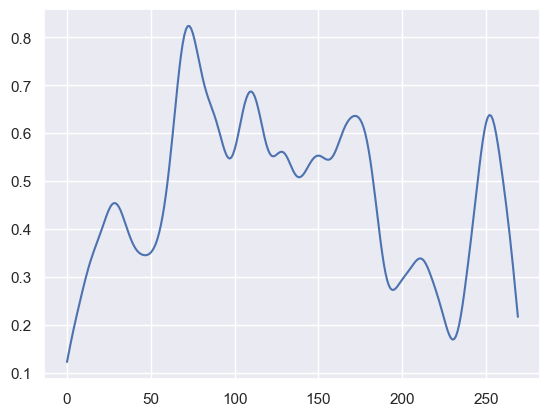

[866, 2298]
[ 600 1106 1574 2174]
1293
cuda
epoch 1,loss = 0.99786830
epoch 2,loss = 0.99775141
epoch 3,loss = 0.99764508
epoch 4,loss = 0.99754894
epoch 5,loss = 0.99746299
epoch 6,loss = 0.99745619
epoch 7,loss = 0.99744475
epoch 8,loss = 0.99741805
epoch 9,loss = 0.99738711
epoch 10,loss = 0.99735612
epoch 11,loss = 0.99733275
epoch 12,loss = 0.99730724
epoch 13,loss = 0.99728560
epoch 14,loss = 0.99726516
epoch 15,loss = 0.99724686
epoch 16,loss = 0.99721569
epoch 17,loss = 0.99719787
epoch 18,loss = 0.99717444
epoch 19,loss = 0.99716544
epoch 20,loss = 0.99716115
epoch 21,loss = 0.99715734
epoch 22,loss = 0.99715394
epoch 23,loss = 0.99715137
epoch 24,loss = 0.99715424
epoch 25,loss = 0.99715984
epoch 26,loss = 0.99716192
epoch 27,loss = 0.99716169
epoch 28,loss = 0.99716079
epoch 29,loss = 0.99715972
epoch 30,loss = 0.99715847
epoch 31,loss = 0.99715763
epoch 32,loss = 0.99715698
epoch 33,loss = 0.99715632
epoch 34,loss = 0.99715573
epoch 35,loss = 0.99715513
epoch 36,loss = 0.99

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 55,loss = 0.99714100
epoch 56,loss = 0.99714017
epoch 57,loss = 0.99713939
epoch 58,loss = 0.99713850
epoch 59,loss = 0.99713773
epoch 60,loss = 0.99713683
epoch 61,loss = 0.99713600
epoch 62,loss = 0.99713516
epoch 63,loss = 0.99713421
epoch 64,loss = 0.99713331
epoch 65,loss = 0.99713230
epoch 66,loss = 0.99713141
epoch 67,loss = 0.99713051
epoch 68,loss = 0.99712944
epoch 69,loss = 0.99712843
epoch 70,loss = 0.99712741
epoch 71,loss = 0.99712634
epoch 72,loss = 0.99712539
epoch 73,loss = 0.99712425
epoch 74,loss = 0.99712306
epoch 75,loss = 0.99712193
epoch 76,loss = 0.99712080
epoch 77,loss = 0.99711967
epoch 78,loss = 0.99711835
epoch 79,loss = 0.99711704
epoch 80,loss = 0.99711579
epoch 81,loss = 0.99711448
epoch 82,loss = 0.99711299
epoch 83,loss = 0.99711174
epoch 84,loss = 0.99711025
epoch 85,loss = 0.99710882
epoch 86,loss = 0.99710739
epoch 87,loss = 0.99710584
epoch 88,loss = 0.99710435
epoch 89,loss = 0.99710280
epoch 90,loss = 0.99710113
epoch 91,loss = 0.99709946
e

epoch 395,loss = 0.63305455
epoch 396,loss = 0.63295758
epoch 397,loss = 0.63286060
epoch 398,loss = 0.63276505
epoch 399,loss = 0.63267088
epoch 400,loss = 0.63257730
epoch 401,loss = 0.63248426
epoch 402,loss = 0.63239175
epoch 403,loss = 0.63229966
epoch 404,loss = 0.63220787
epoch 405,loss = 0.63211656
epoch 406,loss = 0.63202566
epoch 407,loss = 0.63193518
epoch 408,loss = 0.63184512
epoch 409,loss = 0.63175571
epoch 410,loss = 0.63166726
epoch 411,loss = 0.63157958
epoch 412,loss = 0.63149238
epoch 413,loss = 0.63140553
epoch 414,loss = 0.63131899
epoch 415,loss = 0.63123280
epoch 416,loss = 0.63114691
epoch 417,loss = 0.63106138
epoch 418,loss = 0.63097608
epoch 419,loss = 0.63089097
epoch 420,loss = 0.63080651
epoch 421,loss = 0.63072282
epoch 422,loss = 0.63063949
epoch 423,loss = 0.63055646
epoch 424,loss = 0.63047367
epoch 425,loss = 0.63039112
epoch 426,loss = 0.63030893
epoch 427,loss = 0.63022667
epoch 428,loss = 0.63014466
epoch 429,loss = 0.63006288
epoch 430,loss = 0.6

epoch 705,loss = 0.61670327
epoch 706,loss = 0.61667573
epoch 707,loss = 0.61664814
epoch 708,loss = 0.61662066
epoch 709,loss = 0.61659318
epoch 710,loss = 0.61656570
epoch 711,loss = 0.61653823
epoch 712,loss = 0.61651093
epoch 713,loss = 0.61648351
epoch 714,loss = 0.61645627
epoch 715,loss = 0.61642897
epoch 716,loss = 0.61640179
epoch 717,loss = 0.61637455
epoch 718,loss = 0.61634743
epoch 719,loss = 0.61632031
epoch 720,loss = 0.61629325
epoch 721,loss = 0.61626625
epoch 722,loss = 0.61623925
epoch 723,loss = 0.61621237
epoch 724,loss = 0.61618555
epoch 725,loss = 0.61615872
epoch 726,loss = 0.61613202
epoch 727,loss = 0.61610532
epoch 728,loss = 0.61607867
epoch 729,loss = 0.61605209
epoch 730,loss = 0.61602551
epoch 731,loss = 0.61599898
epoch 732,loss = 0.61597252
epoch 733,loss = 0.61594617
epoch 734,loss = 0.61591977
epoch 735,loss = 0.61589348
epoch 736,loss = 0.61586714
epoch 737,loss = 0.61584091
epoch 738,loss = 0.61581457
epoch 739,loss = 0.61578822
epoch 740,loss = 0.6

epoch 1007,loss = 0.60867923
epoch 1008,loss = 0.60865289
epoch 1009,loss = 0.60862654
epoch 1010,loss = 0.60860032
epoch 1011,loss = 0.60857403
epoch 1012,loss = 0.60854775
epoch 1013,loss = 0.60852158
epoch 1014,loss = 0.60849541
epoch 1015,loss = 0.60846925
epoch 1016,loss = 0.60844314
epoch 1017,loss = 0.60841703
epoch 1018,loss = 0.60839099
epoch 1019,loss = 0.60836506
epoch 1020,loss = 0.60833913
epoch 1021,loss = 0.60831326
epoch 1022,loss = 0.60828739
epoch 1023,loss = 0.60826164
epoch 1024,loss = 0.60823578
epoch 1025,loss = 0.60821003
epoch 1026,loss = 0.60818440
epoch 1027,loss = 0.60815877
epoch 1028,loss = 0.60813314
epoch 1029,loss = 0.60810757
epoch 1030,loss = 0.60808206
epoch 1031,loss = 0.60805660
epoch 1032,loss = 0.60803121
epoch 1033,loss = 0.60800582
epoch 1034,loss = 0.60798043
epoch 1035,loss = 0.60795510
epoch 1036,loss = 0.60792935
epoch 1037,loss = 0.60790360
epoch 1038,loss = 0.60787743
epoch 1039,loss = 0.60785109
epoch 1040,loss = 0.60782439
epoch 1041,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([160, 1, 20])
1.0
Epoch 200:   loss= 0.20385  cluster difference= 1.0
Epoch 400:   loss= 0.20316  cluster difference= 0.0
[3 5 5 4 6 1 7 5 0 2 6 3 5 0 2 6 1 7 5 0 2 1 7 5 0 2 6 3 5 5 4 6 1 7 5 0 2
 6 3 5 5 4 6 3 5 5 4 6 1 7 5 0 2 6 3 5 0 4 6 1 7 5 0 2 1 7 5 0 2 6 3 5 0 4
 6 1 7 5 0 2 6 3 5 0 4 6 3 5 5 4 6 1 7 5 0 2 6 3 5 5 4 6 1 7 5 0 2 1 7 5 0
 2 6 3 5 5 4 6 1 7 5 0 2 6 3 5 5 4 6 1 7 5 0 2 1 3 5 0 4 6 3 5 5 4 6 1 7 5
 0 2 6 3 5 5 4 6 1 7 5 0]


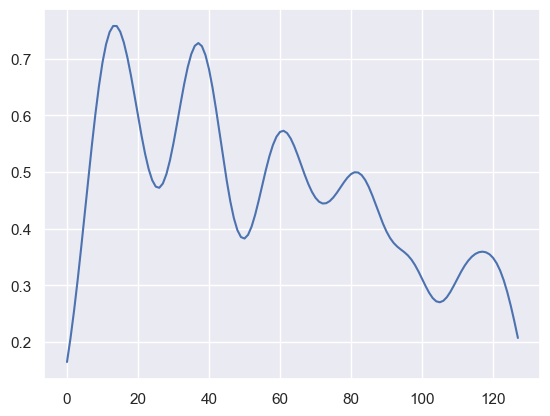

[242, 434]
[517 948]
1430
cuda
epoch 1,loss = 1.02002656
epoch 2,loss = 1.01956606
epoch 3,loss = 1.01911068
epoch 4,loss = 1.01866055
epoch 5,loss = 1.01821578
epoch 6,loss = 1.01777637
epoch 7,loss = 1.01734245
epoch 8,loss = 1.01691425
epoch 9,loss = 1.01649177
epoch 10,loss = 1.01607502
epoch 11,loss = 1.01566410
epoch 12,loss = 1.01525927
epoch 13,loss = 1.01486027
epoch 14,loss = 1.01446748
epoch 15,loss = 1.01408076
epoch 16,loss = 1.01370025
epoch 17,loss = 1.01332605
epoch 18,loss = 1.01295793
epoch 19,loss = 1.01259637
epoch 20,loss = 1.01224101
epoch 21,loss = 1.01189220
epoch 22,loss = 1.01154959
epoch 23,loss = 1.01121354
epoch 24,loss = 1.01088393
epoch 25,loss = 1.01056075
epoch 26,loss = 1.01024401
epoch 27,loss = 1.00993359
epoch 28,loss = 1.00962973
epoch 29,loss = 1.00933218
epoch 30,loss = 1.00904107
epoch 31,loss = 1.00875616
epoch 32,loss = 1.00847781
epoch 33,loss = 1.00820565
epoch 34,loss = 1.00793958
epoch 35,loss = 1.00767982
epoch 36,loss = 1.00742590
epoch 

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 53,loss = 1.00376678
epoch 54,loss = 1.00357914
epoch 55,loss = 1.00339317
epoch 56,loss = 1.00320840
epoch 57,loss = 1.00302458
epoch 58,loss = 1.00284123
epoch 59,loss = 1.00265801
epoch 60,loss = 1.00247431
epoch 61,loss = 1.00228989
epoch 62,loss = 1.00210404
epoch 63,loss = 1.00191653
epoch 64,loss = 1.00172639
epoch 65,loss = 1.00153434
epoch 66,loss = 1.00134480
epoch 67,loss = 1.00116074
epoch 68,loss = 1.00098312
epoch 69,loss = 1.00080884
epoch 70,loss = 1.00060773
epoch 71,loss = 1.00030005
epoch 72,loss = 0.99986911
epoch 73,loss = 0.99934149
epoch 74,loss = 0.99873304
epoch 75,loss = 0.99803203
epoch 76,loss = 0.99724251
epoch 77,loss = 0.99639642
epoch 78,loss = 0.99549729
epoch 79,loss = 0.99454033
epoch 80,loss = 0.99352217
epoch 81,loss = 0.99244726
epoch 82,loss = 0.99131846
epoch 83,loss = 0.99013871
epoch 84,loss = 0.98891145
epoch 85,loss = 0.98763978
epoch 86,loss = 0.98633015
epoch 87,loss = 0.98511744
epoch 88,loss = 0.98395914
epoch 89,loss = 0.98279274
e

epoch 356,loss = 0.74374670
epoch 357,loss = 0.74349838
epoch 358,loss = 0.74324781
epoch 359,loss = 0.74299467
epoch 360,loss = 0.74273908
epoch 361,loss = 0.74248129
epoch 362,loss = 0.74222028
epoch 363,loss = 0.74195725
epoch 364,loss = 0.74169248
epoch 365,loss = 0.74142700
epoch 366,loss = 0.74116123
epoch 367,loss = 0.74089545
epoch 368,loss = 0.74062878
epoch 369,loss = 0.74036270
epoch 370,loss = 0.74009436
epoch 371,loss = 0.73982227
epoch 372,loss = 0.73954898
epoch 373,loss = 0.73927683
epoch 374,loss = 0.73900443
epoch 375,loss = 0.73873091
epoch 376,loss = 0.73845589
epoch 377,loss = 0.73818022
epoch 378,loss = 0.73790300
epoch 379,loss = 0.73762393
epoch 380,loss = 0.73734379
epoch 381,loss = 0.73706192
epoch 382,loss = 0.73677915
epoch 383,loss = 0.73649353
epoch 384,loss = 0.73620439
epoch 385,loss = 0.73591155
epoch 386,loss = 0.73561603
epoch 387,loss = 0.73531902
epoch 388,loss = 0.73501968
epoch 389,loss = 0.73471797
epoch 390,loss = 0.73441327
epoch 391,loss = 0.7

epoch 669,loss = 0.52334499
epoch 670,loss = 0.52314788
epoch 671,loss = 0.52295339
epoch 672,loss = 0.52276158
epoch 673,loss = 0.52257240
epoch 674,loss = 0.52238578
epoch 675,loss = 0.52220166
epoch 676,loss = 0.52201998
epoch 677,loss = 0.52184081
epoch 678,loss = 0.52166402
epoch 679,loss = 0.52148956
epoch 680,loss = 0.52131742
epoch 681,loss = 0.52114755
epoch 682,loss = 0.52097988
epoch 683,loss = 0.52081436
epoch 684,loss = 0.52065158
epoch 685,loss = 0.52049953
epoch 686,loss = 0.52037418
epoch 687,loss = 0.52020311
epoch 688,loss = 0.52006400
epoch 689,loss = 0.51992679
epoch 690,loss = 0.51978153
epoch 691,loss = 0.51963729
epoch 692,loss = 0.51949972
epoch 693,loss = 0.51936555
epoch 694,loss = 0.51922971
epoch 695,loss = 0.51909393
epoch 696,loss = 0.51895708
epoch 697,loss = 0.51882726
epoch 698,loss = 0.51870209
epoch 699,loss = 0.51857615
epoch 700,loss = 0.51844829
epoch 701,loss = 0.51832277
epoch 702,loss = 0.51820117
epoch 703,loss = 0.51808113
epoch 704,loss = 0.5

epoch 979,loss = 0.49308404
epoch 980,loss = 0.49297616
epoch 981,loss = 0.49286908
epoch 982,loss = 0.49275655
epoch 983,loss = 0.49264184
epoch 984,loss = 0.49252546
epoch 985,loss = 0.49239951
epoch 986,loss = 0.49226850
epoch 987,loss = 0.49213994
epoch 988,loss = 0.49200675
epoch 989,loss = 0.49182940
epoch 990,loss = 0.49156410
epoch 991,loss = 0.49116597
epoch 992,loss = 0.49064070
epoch 993,loss = 0.48944780
epoch 994,loss = 0.48850965
epoch 995,loss = 0.48705891
epoch 996,loss = 0.48620653
epoch 997,loss = 0.48571774
epoch 998,loss = 0.48538285
epoch 999,loss = 0.48601186
epoch 1000,loss = 0.48621410
epoch 1001,loss = 0.48532152
epoch 1002,loss = 0.48466077
epoch 1003,loss = 0.48443165
epoch 1004,loss = 0.48439521
epoch 1005,loss = 0.48427221
epoch 1006,loss = 0.48412594
epoch 1007,loss = 0.48391572
epoch 1008,loss = 0.48369369
epoch 1009,loss = 0.48344940
epoch 1010,loss = 0.48322439
epoch 1011,loss = 0.48291337
epoch 1012,loss = 0.48264250
epoch 1013,loss = 0.48226094
epoch 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([69, 1, 50])
1.0
Epoch 200:   loss= 0.00718  cluster difference= 1.0
Epoch 400:   loss= 0.00707  cluster difference= 0.8840579710144928
Epoch 600:   loss= 0.00507  cluster difference= 0.7971014492753623
Epoch 800:   loss= 0.00525  cluster difference= 0.5942028985507246
Epoch 1000:   loss= 0.00424  cluster difference= 0.08695652173913043
Epoch 1200:   loss= 0.00499  cluster difference= 0.36231884057971014
Epoch 1400:   loss= 0.00454  cluster difference= 0.15942028985507245
Epoch 1600:   loss= 0.00466  cluster difference= 0.9710144927536232
Epoch 1800:   loss= 0.00626  cluster difference= 1.0
Epoch 2000:   loss= 0.00735  cluster difference= 1.0
Epoch 2200:   loss= 0.0103  cluster difference= 1.0
Epoch 2400:   loss= 0.01516  cluster difference= 1.0
Epoch 2600:   loss= 0.02119  cluster difference= 0.11594202898550725
Epoch 2800:   loss= 0.02765  cluster difference= 0.9855072463768116
Epoch 3000:   loss= 0.03453  cluster difference= 0.7246376811594203
Epoch 3200:   loss= 0.04101 

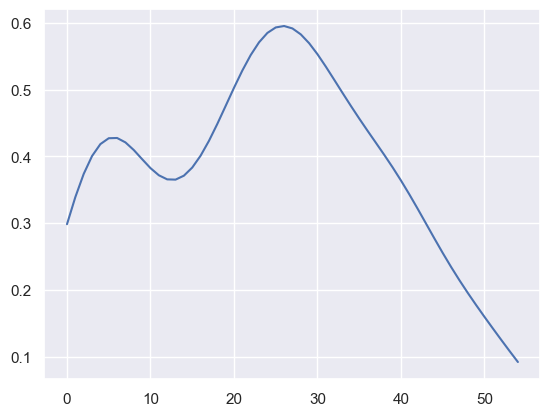

[]
[300]
2580
cuda
epoch 1,loss = 1.18023980
epoch 2,loss = 1.17858469
epoch 3,loss = 1.17692971
epoch 4,loss = 1.17527509
epoch 5,loss = 1.17362094
epoch 6,loss = 1.17196727
epoch 7,loss = 1.17031443
epoch 8,loss = 1.16866267
epoch 9,loss = 1.16701138
epoch 10,loss = 1.16536105
epoch 11,loss = 1.16371131
epoch 12,loss = 1.16206217
epoch 13,loss = 1.16041398
epoch 14,loss = 1.15876746
epoch 15,loss = 1.15712237
epoch 16,loss = 1.15547907
epoch 17,loss = 1.15383744
epoch 18,loss = 1.15219903
epoch 19,loss = 1.15056050
epoch 20,loss = 1.14890909
epoch 21,loss = 1.14726710
epoch 22,loss = 1.14562845
epoch 23,loss = 1.14399731
epoch 24,loss = 1.14238214
epoch 25,loss = 1.14077210
epoch 26,loss = 1.13916445
epoch 27,loss = 1.13755906
epoch 28,loss = 1.13595545
epoch 29,loss = 1.13435423
epoch 30,loss = 1.13275576
epoch 31,loss = 1.13116062
epoch 32,loss = 1.12956893
epoch 33,loss = 1.12798119
epoch 34,loss = 1.12639737
epoch 35,loss = 1.12481773
epoch 36,loss = 1.12324250
epoch 37,loss = 1.

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 45,loss = 1.10928869
epoch 46,loss = 1.10776639
epoch 47,loss = 1.10625041
epoch 48,loss = 1.10474086
epoch 49,loss = 1.10323799
epoch 50,loss = 1.10174203
epoch 51,loss = 1.10025311
epoch 52,loss = 1.09877360
epoch 53,loss = 1.09730327
epoch 54,loss = 1.09583986
epoch 55,loss = 1.09438276
epoch 56,loss = 1.09293365
epoch 57,loss = 1.09149277
epoch 58,loss = 1.09006035
epoch 59,loss = 1.08863664
epoch 60,loss = 1.08722198
epoch 61,loss = 1.08581626
epoch 62,loss = 1.08442008
epoch 63,loss = 1.08303344
epoch 64,loss = 1.08165681
epoch 65,loss = 1.08029020
epoch 66,loss = 1.07893372
epoch 67,loss = 1.07758737
epoch 68,loss = 1.07625151
epoch 69,loss = 1.07492602
epoch 70,loss = 1.07361126
epoch 71,loss = 1.07230747
epoch 72,loss = 1.07101452
epoch 73,loss = 1.06973290
epoch 74,loss = 1.06846225
epoch 75,loss = 1.06720197
epoch 76,loss = 1.06595147
epoch 77,loss = 1.06471002
epoch 78,loss = 1.06347787
epoch 79,loss = 1.06225550
epoch 80,loss = 1.06104243
epoch 81,loss = 1.05983245
e

epoch 350,loss = 0.89428967
epoch 351,loss = 0.89313477
epoch 352,loss = 0.89194703
epoch 353,loss = 0.89070773
epoch 354,loss = 0.88941300
epoch 355,loss = 0.88805783
epoch 356,loss = 0.88664597
epoch 357,loss = 0.88515610
epoch 358,loss = 0.88358068
epoch 359,loss = 0.88192791
epoch 360,loss = 0.88020122
epoch 361,loss = 0.87837887
epoch 362,loss = 0.87646061
epoch 363,loss = 0.87447143
epoch 364,loss = 0.87242508
epoch 365,loss = 0.87033957
epoch 366,loss = 0.86823469
epoch 367,loss = 0.86611450
epoch 368,loss = 0.86405808
epoch 369,loss = 0.86208874
epoch 370,loss = 0.86016357
epoch 371,loss = 0.85828978
epoch 372,loss = 0.85647106
epoch 373,loss = 0.85470730
epoch 374,loss = 0.85296702
epoch 375,loss = 0.85124189
epoch 376,loss = 0.84952033
epoch 377,loss = 0.84778136
epoch 378,loss = 0.84604019
epoch 379,loss = 0.84431052
epoch 380,loss = 0.84258354
epoch 381,loss = 0.84087294
epoch 382,loss = 0.83918029
epoch 383,loss = 0.83747762
epoch 384,loss = 0.83577877
epoch 385,loss = 0.8

epoch 675,loss = 0.68797195
epoch 676,loss = 0.68783188
epoch 677,loss = 0.68769240
epoch 678,loss = 0.68755418
epoch 679,loss = 0.68741685
epoch 680,loss = 0.68727988
epoch 681,loss = 0.68714339
epoch 682,loss = 0.68700743
epoch 683,loss = 0.68687207
epoch 684,loss = 0.68673736
epoch 685,loss = 0.68660301
epoch 686,loss = 0.68646866
epoch 687,loss = 0.68633461
epoch 688,loss = 0.68620133
epoch 689,loss = 0.68606842
epoch 690,loss = 0.68593550
epoch 691,loss = 0.68580258
epoch 692,loss = 0.68567038
epoch 693,loss = 0.68553829
epoch 694,loss = 0.68540639
epoch 695,loss = 0.68527502
epoch 696,loss = 0.68514448
epoch 697,loss = 0.68501431
epoch 698,loss = 0.68488479
epoch 699,loss = 0.68475538
epoch 700,loss = 0.68462586
epoch 701,loss = 0.68449628
epoch 702,loss = 0.68436688
epoch 703,loss = 0.68423784
epoch 704,loss = 0.68410933
epoch 705,loss = 0.68398130
epoch 706,loss = 0.68385375
epoch 707,loss = 0.68372667
epoch 708,loss = 0.68359971
epoch 709,loss = 0.68347275
epoch 710,loss = 0.6

epoch 971,loss = 0.60343421
epoch 972,loss = 0.60281259
epoch 973,loss = 0.60218972
epoch 974,loss = 0.60156387
epoch 975,loss = 0.60093695
epoch 976,loss = 0.60030949
epoch 977,loss = 0.59968114
epoch 978,loss = 0.59904891
epoch 979,loss = 0.59841686
epoch 980,loss = 0.59778154
epoch 981,loss = 0.59714651
epoch 982,loss = 0.59650975
epoch 983,loss = 0.59587067
epoch 984,loss = 0.59522736
epoch 985,loss = 0.59457707
epoch 986,loss = 0.59392112
epoch 987,loss = 0.59326386
epoch 988,loss = 0.59260422
epoch 989,loss = 0.59194005
epoch 990,loss = 0.59127265
epoch 991,loss = 0.59060192
epoch 992,loss = 0.58993000
epoch 993,loss = 0.58925653
epoch 994,loss = 0.58857930
epoch 995,loss = 0.58789831
epoch 996,loss = 0.58721393
epoch 997,loss = 0.58652914
epoch 998,loss = 0.58583891
epoch 999,loss = 0.58514684
epoch 1000,loss = 0.58445209
epoch 1001,loss = 0.58375633
epoch 1002,loss = 0.58306259
epoch 1003,loss = 0.58236885
epoch 1004,loss = 0.58167875
epoch 1005,loss = 0.58099151
epoch 1006,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([320, 1, 20])
1.0
Epoch 200:   loss= 0.06267  cluster difference= 1.0
Epoch 400:   loss= 0.06238  cluster difference= 0.0
[3 7 2 1 0 3 7 2 1 0 3 7 2 1 0 3 7 2 1 0 3 7 2 1 0 3 7 2 1 0 3 4 5 1 0 3 4
 5 1 0 3 7 2 1 6 3 4 5 1 6 3 7 2 1 0 3 7 2 1 0 3 4 2 1 0 3 4 2 1 0 3 4 5 1
 6 3 4 5 1 6 3 4 5 1 0 3 7 2 1 0 3 4 5 1 6 3 7 2 1 6 3 4 5 1 0 3 4 2 1 0 3
 7 2 1 0 3 4 5 1 6 3 4 5 1 6 3 4 5 1 6 3 4 5 1 0 3 4 5 1 0 3 4 5 1 0 3 4 5
 1 6 3 4 5 1 6 3 4 5 1 6 3 4 5 1 6 3 4 5 1 6 3 7 2 1 0 3 4 5 1 6 3 4 5 1 0
 3 4 5 1 6 3 4 5 1 0 3 4 5 1 0 3 4 5 1 0 3 4 5 1 0 3 4 5 1 6 3 7 2 1 0 3 7
 2 1 0 3 4 5 1 0 3 4 2 1 0 3 7 2 1 6 3 4 5 1 0 3 4 5 1 6 3 7 2 1 6 3 4 5 1
 6 3 4 5 1 6 3 4 5 1 0 3 4 5 1 6 3 4 5 1 0 3 7 2 1 6 3 4 5 1 0 3 4 5 1 6 3
 4 5 1 0 3 4 5 1 6 3 7 2 1 0 3 4 5 1 6 3 4 5 1 6]


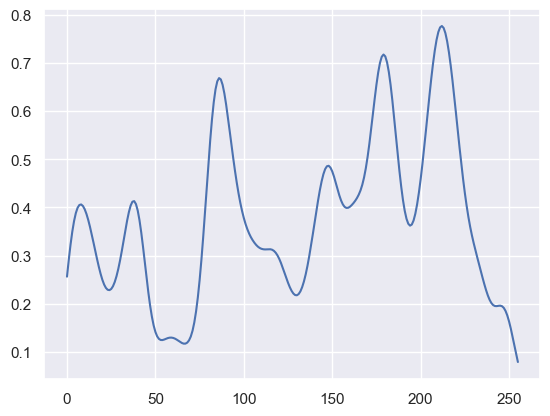

[954, 1698, 1962]
[ 580 2220]
10304
cuda
epoch 1,loss = 0.98859847
epoch 2,loss = 0.98859119
epoch 3,loss = 0.98858392
epoch 4,loss = 0.98857671
epoch 5,loss = 0.98856962
epoch 6,loss = 0.98856246
epoch 7,loss = 0.98855549
epoch 8,loss = 0.98854852
epoch 9,loss = 0.98854154
epoch 10,loss = 0.98853463
epoch 11,loss = 0.98852783
epoch 12,loss = 0.98852104
epoch 13,loss = 0.98851436
epoch 14,loss = 0.98850775
epoch 15,loss = 0.98850113
epoch 16,loss = 0.98849458
epoch 17,loss = 0.98848808
epoch 18,loss = 0.98848170
epoch 19,loss = 0.98847532
epoch 20,loss = 0.98846895
epoch 21,loss = 0.98846269
epoch 22,loss = 0.98845655


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 23,loss = 0.98845047
epoch 24,loss = 0.98844433
epoch 25,loss = 0.98843843
epoch 26,loss = 0.98843241
epoch 27,loss = 0.98842657
epoch 28,loss = 0.98842061
epoch 29,loss = 0.98841494
epoch 30,loss = 0.98840922
epoch 31,loss = 0.98840362
epoch 32,loss = 0.98839802
epoch 33,loss = 0.98839253
epoch 34,loss = 0.98838705
epoch 35,loss = 0.98838162
epoch 36,loss = 0.98837626
epoch 37,loss = 0.98837113
epoch 38,loss = 0.98836589
epoch 39,loss = 0.98836070
epoch 40,loss = 0.98835570
epoch 41,loss = 0.98835063
epoch 42,loss = 0.98834568
epoch 43,loss = 0.98834074
epoch 44,loss = 0.98833591
epoch 45,loss = 0.98833120
epoch 46,loss = 0.98832637
epoch 47,loss = 0.98832178
epoch 48,loss = 0.98831719
epoch 49,loss = 0.98831266
epoch 50,loss = 0.98830807
epoch 51,loss = 0.98830354
epoch 52,loss = 0.98829907
epoch 53,loss = 0.98829466
epoch 54,loss = 0.98829025
epoch 55,loss = 0.98828590
epoch 56,loss = 0.98828161
epoch 57,loss = 0.98827732
epoch 58,loss = 0.98827326
epoch 59,loss = 0.98826909
e

epoch 321,loss = 0.86605811
epoch 322,loss = 0.86594272
epoch 323,loss = 0.86583143
epoch 324,loss = 0.86572665
epoch 325,loss = 0.86562365
epoch 326,loss = 0.86552274
epoch 327,loss = 0.86542249
epoch 328,loss = 0.86530691
epoch 329,loss = 0.86518800
epoch 330,loss = 0.86506402
epoch 331,loss = 0.86494929
epoch 332,loss = 0.86484432
epoch 333,loss = 0.86474603
epoch 334,loss = 0.86464864
epoch 335,loss = 0.86454940
epoch 336,loss = 0.86445224
epoch 337,loss = 0.86435777
epoch 338,loss = 0.86426091
epoch 339,loss = 0.86416435
epoch 340,loss = 0.86406916
epoch 341,loss = 0.86397475
epoch 342,loss = 0.86388141
epoch 343,loss = 0.86378402
epoch 344,loss = 0.86368340
epoch 345,loss = 0.86358500
epoch 346,loss = 0.86348456
epoch 347,loss = 0.86338311
epoch 348,loss = 0.86327922
epoch 349,loss = 0.86317420
epoch 350,loss = 0.86306882
epoch 351,loss = 0.86296332
epoch 352,loss = 0.86285853
epoch 353,loss = 0.86274564
epoch 354,loss = 0.86263090
epoch 355,loss = 0.86251378
epoch 356,loss = 0.8

epoch 644,loss = 0.84478700
epoch 645,loss = 0.84474891
epoch 646,loss = 0.84471107
epoch 647,loss = 0.84467369
epoch 648,loss = 0.84463686
epoch 649,loss = 0.84460014
epoch 650,loss = 0.84456372
epoch 651,loss = 0.84452772
epoch 652,loss = 0.84449160
epoch 653,loss = 0.84445572
epoch 654,loss = 0.84442025
epoch 655,loss = 0.84438479
epoch 656,loss = 0.84434986
epoch 657,loss = 0.84431565
epoch 658,loss = 0.84428167
epoch 659,loss = 0.84424835
epoch 660,loss = 0.84421486
epoch 661,loss = 0.84418130
epoch 662,loss = 0.84414780
epoch 663,loss = 0.84411460
epoch 664,loss = 0.84408188
epoch 665,loss = 0.84404945
epoch 666,loss = 0.84401745
epoch 667,loss = 0.84398568
epoch 668,loss = 0.84395385
epoch 669,loss = 0.84392196
epoch 670,loss = 0.84389043
epoch 671,loss = 0.84385926
epoch 672,loss = 0.84382820
epoch 673,loss = 0.84379733
epoch 674,loss = 0.84376681
epoch 675,loss = 0.84373677
epoch 676,loss = 0.84370643
epoch 677,loss = 0.84367609
epoch 678,loss = 0.84364575
epoch 679,loss = 0.8

epoch 956,loss = 0.83030528
epoch 957,loss = 0.83026892
epoch 958,loss = 0.83023208
epoch 959,loss = 0.83019501
epoch 960,loss = 0.83015907
epoch 961,loss = 0.83012235
epoch 962,loss = 0.83008522
epoch 963,loss = 0.83004898
epoch 964,loss = 0.83001256
epoch 965,loss = 0.82997513
epoch 966,loss = 0.82993639
epoch 967,loss = 0.82989734
epoch 968,loss = 0.82985848
epoch 969,loss = 0.82981974
epoch 970,loss = 0.82978112
epoch 971,loss = 0.82974213
epoch 972,loss = 0.82970142
epoch 973,loss = 0.82966304
epoch 974,loss = 0.82962453
epoch 975,loss = 0.82958502
epoch 976,loss = 0.82954419
epoch 977,loss = 0.82950395
epoch 978,loss = 0.82946324
epoch 979,loss = 0.82942152
epoch 980,loss = 0.82937974
epoch 981,loss = 0.82933909
epoch 982,loss = 0.82929730
epoch 983,loss = 0.82925475
epoch 984,loss = 0.82921189
epoch 985,loss = 0.82916927
epoch 986,loss = 0.82912642
epoch 987,loss = 0.82908314
epoch 988,loss = 0.82903761
epoch 989,loss = 0.82899034
epoch 990,loss = 0.82894152
epoch 991,loss = 0.8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


torch.Size([1286, 1, 20])
1.0
Epoch 200:   loss= 0.17272  cluster difference= 1.0
Epoch 400:   loss= 0.18577  cluster difference= 0.11586314152410575
Epoch 600:   loss= 0.19264  cluster difference= 0.12441679626749612
Epoch 800:   loss= 0.19697  cluster difference= 0.053654743390357695
Epoch 1000:   loss= 0.19997  cluster difference= 0.017884914463452566
Epoch 1200:   loss= 0.20211  cluster difference= 0.007776049766718507
[3 1 2 ... 2 4 2]


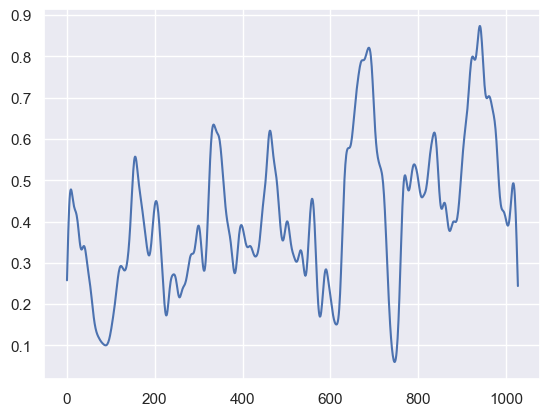

[3714, 6538, 8562]
[8448]
2400
cuda
epoch 1,loss = 0.99974912
epoch 2,loss = 0.99970526
epoch 3,loss = 0.99966604
epoch 4,loss = 0.99963135
epoch 5,loss = 0.99960124
epoch 6,loss = 0.99957567
epoch 7,loss = 0.99955422
epoch 8,loss = 0.99953675
epoch 9,loss = 0.99952292
epoch 10,loss = 0.99951190
epoch 11,loss = 0.99950325
epoch 12,loss = 0.99949604
epoch 13,loss = 0.99948967
epoch 14,loss = 0.99948317
epoch 15,loss = 0.99947619
epoch 16,loss = 0.99946815
epoch 17,loss = 0.99945897
epoch 18,loss = 0.99944842
epoch 19,loss = 0.99943662
epoch 20,loss = 0.99942374
epoch 21,loss = 0.99940985
epoch 22,loss = 0.99939543
epoch 23,loss = 0.99938041
epoch 24,loss = 0.99936509
epoch 25,loss = 0.99934953
epoch 26,loss = 0.99933392
epoch 27,loss = 0.99931806
epoch 28,loss = 0.99930221
epoch 29,loss = 0.99928629
epoch 30,loss = 0.99927026
epoch 31,loss = 0.99925393
epoch 32,loss = 0.99923730
epoch 33,loss = 0.99922019
epoch 34,loss = 0.99920249
epoch 35,loss = 0.99918419
epoch 36,loss = 0.99916506
e

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 47,loss = 0.99891764
epoch 48,loss = 0.99889141
epoch 49,loss = 0.99886435
epoch 50,loss = 0.99883658
epoch 51,loss = 0.99880785
epoch 52,loss = 0.99877828
epoch 53,loss = 0.99874771
epoch 54,loss = 0.99871624
epoch 55,loss = 0.99868363
epoch 56,loss = 0.99865019
epoch 57,loss = 0.99861562
epoch 58,loss = 0.99858016
epoch 59,loss = 0.99854362
epoch 60,loss = 0.99850601
epoch 61,loss = 0.99846709
epoch 62,loss = 0.99842703
epoch 63,loss = 0.99838567
epoch 64,loss = 0.99834299
epoch 65,loss = 0.99829894
epoch 66,loss = 0.99825364
epoch 67,loss = 0.99820685
epoch 68,loss = 0.99815851
epoch 69,loss = 0.99810869
epoch 70,loss = 0.99805743
epoch 71,loss = 0.99800450
epoch 72,loss = 0.99795002
epoch 73,loss = 0.99789381
epoch 74,loss = 0.99783587
epoch 75,loss = 0.99777621
epoch 76,loss = 0.99771470
epoch 77,loss = 0.99765140
epoch 78,loss = 0.99758613
epoch 79,loss = 0.99751896
epoch 80,loss = 0.99744982
epoch 81,loss = 0.99737871
epoch 82,loss = 0.99730545
epoch 83,loss = 0.99723011
e

epoch 343,loss = 0.86523998
epoch 344,loss = 0.86504579
epoch 345,loss = 0.86485720
epoch 346,loss = 0.86467308
epoch 347,loss = 0.86449438
epoch 348,loss = 0.86431724
epoch 349,loss = 0.86414158
epoch 350,loss = 0.86396903
epoch 351,loss = 0.86379629
epoch 352,loss = 0.86362267
epoch 353,loss = 0.86344975
epoch 354,loss = 0.86327279
epoch 355,loss = 0.86308861
epoch 356,loss = 0.86290228
epoch 357,loss = 0.86271101
epoch 358,loss = 0.86251378
epoch 359,loss = 0.86231011
epoch 360,loss = 0.86209631
epoch 361,loss = 0.86187643
epoch 362,loss = 0.86165005
epoch 363,loss = 0.86142254
epoch 364,loss = 0.86119461
epoch 365,loss = 0.86096704
epoch 366,loss = 0.86074466
epoch 367,loss = 0.86052644
epoch 368,loss = 0.86028755
epoch 369,loss = 0.85999757
epoch 370,loss = 0.85969061
epoch 371,loss = 0.85933512
epoch 372,loss = 0.85885072
epoch 373,loss = 0.85838145
epoch 374,loss = 0.85795313
epoch 375,loss = 0.85759133
epoch 376,loss = 0.85726041
epoch 377,loss = 0.85691935
epoch 378,loss = 0.8

epoch 679,loss = 0.80032200
epoch 680,loss = 0.79982817
epoch 681,loss = 0.79932624
epoch 682,loss = 0.79881078
epoch 683,loss = 0.79828024
epoch 684,loss = 0.79773396
epoch 685,loss = 0.79717857
epoch 686,loss = 0.79662174
epoch 687,loss = 0.79606265
epoch 688,loss = 0.79543954
epoch 689,loss = 0.79479533
epoch 690,loss = 0.79414642
epoch 691,loss = 0.79347360
epoch 692,loss = 0.79276562
epoch 693,loss = 0.79205841
epoch 694,loss = 0.79132485
epoch 695,loss = 0.79057127
epoch 696,loss = 0.78976953
epoch 697,loss = 0.78886592
epoch 698,loss = 0.78789538
epoch 699,loss = 0.78696817
epoch 700,loss = 0.78598303
epoch 701,loss = 0.78481156
epoch 702,loss = 0.78359246
epoch 703,loss = 0.78226459
epoch 704,loss = 0.78091365
epoch 705,loss = 0.77941257
epoch 706,loss = 0.77779567
epoch 707,loss = 0.77620143
epoch 708,loss = 0.77447963
epoch 709,loss = 0.77275902
epoch 710,loss = 0.77096337
epoch 711,loss = 0.76905972
epoch 712,loss = 0.76708186
epoch 713,loss = 0.76493520
epoch 714,loss = 0.7

epoch 1005,loss = 0.52584934
epoch 1006,loss = 0.52482611
epoch 1007,loss = 0.52381992
epoch 1008,loss = 0.52272272
epoch 1009,loss = 0.52157485
epoch 1010,loss = 0.52049047
epoch 1011,loss = 0.51944655
epoch 1012,loss = 0.51837212
epoch 1013,loss = 0.51726502
epoch 1014,loss = 0.51614851
epoch 1015,loss = 0.51497859
epoch 1016,loss = 0.51371026
epoch 1017,loss = 0.51248145
epoch 1018,loss = 0.51125973
epoch 1019,loss = 0.51014078
epoch 1020,loss = 0.50904799
epoch 1021,loss = 0.50786465
epoch 1022,loss = 0.50659591
epoch 1023,loss = 0.50527179
epoch 1024,loss = 0.50388020
epoch 1025,loss = 0.50240684
epoch 1026,loss = 0.50082111
epoch 1027,loss = 0.49912137
epoch 1028,loss = 0.49735126
epoch 1029,loss = 0.49599889
epoch 1030,loss = 0.49475619
epoch 1031,loss = 0.49346250
epoch 1032,loss = 0.49232808
epoch 1033,loss = 0.49120277
epoch 1034,loss = 0.49015021
epoch 1035,loss = 0.48912960
epoch 1036,loss = 0.48825234
epoch 1037,loss = 0.48738086
epoch 1038,loss = 0.48648742
epoch 1039,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([298, 1, 20])
1.0
Epoch 200:   loss= 0.17259  cluster difference= 1.0
Epoch 400:   loss= 0.17075  cluster difference= 0.013422818791946308
Epoch 600:   loss= 0.16884  cluster difference= 0.003355704697986577
[3 0 5 3 0 5 3 0 5 3 0 2 7 0 0 3 0 2 1 0 5 3 0 4 6 0 5 3 0 4 6 0 5 3 0 4 6
 0 2 6 0 5 3 0 4 6 0 5 7 0 4 6 0 5 3 0 4 6 0 4 6 0 5 3 0 2 1 0 5 3 0 2 7 0
 4 6 0 2 1 0 5 3 0 5 7 0 4 6 0 2 1 0 4 6 0 2 1 0 2 1 0 2 1 0 2 1 0 5 7 0 2
 7 0 4 6 0 2 1 0 2 1 0 2 1 0 2 1 0 4 6 0 2 1 0 2 1 0 2 1 0 4 6 0 2 1 0 2 1
 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 4 6 0 2 1 0 5 7 0 2 1 0 5 7 0 5 3 0
 2 1 0 2 1 0 2 1 0 2 1 0 2 7 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 5 3 0 2
 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 7 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1
 0 5 1 0 2 7 0 2 1 0 4 6 0 2 1 0 2 1 0 2 1 0 2 1 0 2 1 0 2 7 0 5 3 0 2 1 0
 2 1]


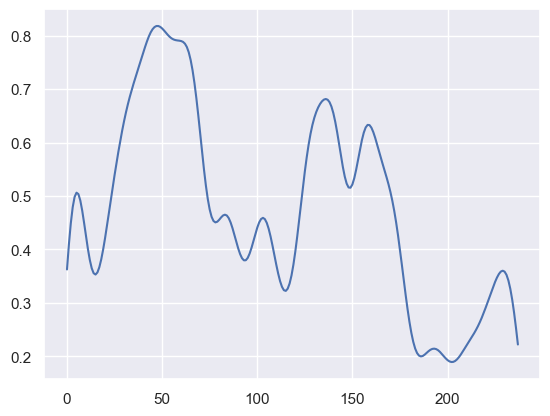

[634, 1338]
[744]
2051
cuda
epoch 1,loss = 1.01543295
epoch 2,loss = 1.01491261
epoch 3,loss = 1.01441050
epoch 4,loss = 1.01392615
epoch 5,loss = 1.01345980
epoch 6,loss = 1.01301122
epoch 7,loss = 1.01258039
epoch 8,loss = 1.01216722
epoch 9,loss = 1.01177144
epoch 10,loss = 1.01139271
epoch 11,loss = 1.01103115
epoch 12,loss = 1.01068616
epoch 13,loss = 1.01035750
epoch 14,loss = 1.01004493
epoch 15,loss = 1.00974810
epoch 16,loss = 1.00946665
epoch 17,loss = 1.00920010
epoch 18,loss = 1.00894785
epoch 19,loss = 1.00870967
epoch 20,loss = 1.00848496
epoch 21,loss = 1.00827324
epoch 22,loss = 1.00807440
epoch 23,loss = 1.00788760
epoch 24,loss = 1.00771260
epoch 25,loss = 1.00754869
epoch 26,loss = 1.00739515
epoch 27,loss = 1.00725174
epoch 28,loss = 1.00711751
epoch 29,loss = 1.00698948
epoch 30,loss = 1.00685668
epoch 31,loss = 1.00674105
epoch 32,loss = 1.00663471
epoch 33,loss = 1.00653601
epoch 34,loss = 1.00643301
epoch 35,loss = 1.00633883
epoch 36,loss = 1.00626802
epoch 37,

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 63,loss = 1.00547504
epoch 64,loss = 1.00546396
epoch 65,loss = 1.00545251
epoch 66,loss = 1.00544083
epoch 67,loss = 1.00542951
epoch 68,loss = 1.00541794
epoch 69,loss = 1.00540674
epoch 70,loss = 1.00539601
epoch 71,loss = 1.00538588
epoch 72,loss = 1.00537610
epoch 73,loss = 1.00536680
epoch 74,loss = 1.00535738
epoch 75,loss = 1.00534821
epoch 76,loss = 1.00533903
epoch 77,loss = 1.00532973
epoch 78,loss = 1.00532067
epoch 79,loss = 1.00531149
epoch 80,loss = 1.00530243
epoch 81,loss = 1.00529373
epoch 82,loss = 1.00528538
epoch 83,loss = 1.00527704
epoch 84,loss = 1.00526881
epoch 85,loss = 1.00526059
epoch 86,loss = 1.00525248
epoch 87,loss = 1.00524449
epoch 88,loss = 1.00523674
epoch 89,loss = 1.00522900
epoch 90,loss = 1.00522149
epoch 91,loss = 1.00521398
epoch 92,loss = 1.00520670
epoch 93,loss = 1.00519967
epoch 94,loss = 1.00519276
epoch 95,loss = 1.00518596
epoch 96,loss = 1.00517917
epoch 97,loss = 1.00517249
epoch 98,loss = 1.00516605
epoch 99,loss = 1.00515962
e

epoch 397,loss = 0.94225729
epoch 398,loss = 0.94218194
epoch 399,loss = 0.94210649
epoch 400,loss = 0.94203043
epoch 401,loss = 0.94195664
epoch 402,loss = 0.94188416
epoch 403,loss = 0.94181252
epoch 404,loss = 0.94173831
epoch 405,loss = 0.94166416
epoch 406,loss = 0.94159317
epoch 407,loss = 0.94152284
epoch 408,loss = 0.94145143
epoch 409,loss = 0.94138032
epoch 410,loss = 0.94131088
epoch 411,loss = 0.94124228
epoch 412,loss = 0.94117957
epoch 413,loss = 0.94111609
epoch 414,loss = 0.94105136
epoch 415,loss = 0.94098389
epoch 416,loss = 0.94091988
epoch 417,loss = 0.94086146
epoch 418,loss = 0.94080371
epoch 419,loss = 0.94074738
epoch 420,loss = 0.94069302
epoch 421,loss = 0.94064093
epoch 422,loss = 0.94058931
epoch 423,loss = 0.94053823
epoch 424,loss = 0.94048649
epoch 425,loss = 0.94043422
epoch 426,loss = 0.94037932
epoch 427,loss = 0.94032204
epoch 428,loss = 0.94026995
epoch 429,loss = 0.94021940
epoch 430,loss = 0.94016922
epoch 431,loss = 0.94011867
epoch 432,loss = 0.9

epoch 693,loss = 0.92580837
epoch 694,loss = 0.92556697
epoch 695,loss = 0.92532611
epoch 696,loss = 0.92508274
epoch 697,loss = 0.92484063
epoch 698,loss = 0.92459321
epoch 699,loss = 0.92433792
epoch 700,loss = 0.92404860
epoch 701,loss = 0.92375046
epoch 702,loss = 0.92343599
epoch 703,loss = 0.92315161
epoch 704,loss = 0.92287827
epoch 705,loss = 0.92259187
epoch 706,loss = 0.92229617
epoch 707,loss = 0.92199224
epoch 708,loss = 0.92163604
epoch 709,loss = 0.92125309
epoch 710,loss = 0.92086625
epoch 711,loss = 0.92046648
epoch 712,loss = 0.92003721
epoch 713,loss = 0.91957766
epoch 714,loss = 0.91906393
epoch 715,loss = 0.91851681
epoch 716,loss = 0.91796577
epoch 717,loss = 0.91742277
epoch 718,loss = 0.91685820
epoch 719,loss = 0.91623342
epoch 720,loss = 0.91555649
epoch 721,loss = 0.91483569
epoch 722,loss = 0.91409171
epoch 723,loss = 0.91329449
epoch 724,loss = 0.91246051
epoch 725,loss = 0.91159439
epoch 726,loss = 0.91067463
epoch 727,loss = 0.90973449
epoch 728,loss = 0.9

epoch 998,loss = 0.78416258
epoch 999,loss = 0.78407645
epoch 1000,loss = 0.78399062
epoch 1001,loss = 0.78390682
epoch 1002,loss = 0.78382373
epoch 1003,loss = 0.78374100
epoch 1004,loss = 0.78365844
epoch 1005,loss = 0.78357595
epoch 1006,loss = 0.78349257
epoch 1007,loss = 0.78340888
epoch 1008,loss = 0.78332537
epoch 1009,loss = 0.78324068
epoch 1010,loss = 0.78315467
epoch 1011,loss = 0.78306860
epoch 1012,loss = 0.78298247
epoch 1013,loss = 0.78289610
epoch 1014,loss = 0.78280944
epoch 1015,loss = 0.78272164
epoch 1016,loss = 0.78263348
epoch 1017,loss = 0.78254604
epoch 1018,loss = 0.78245974
epoch 1019,loss = 0.78237385
epoch 1020,loss = 0.78228897
epoch 1021,loss = 0.78220445
epoch 1022,loss = 0.78211975
epoch 1023,loss = 0.78203517
epoch 1024,loss = 0.78195089
epoch 1025,loss = 0.78186506
epoch 1026,loss = 0.78177959
epoch 1027,loss = 0.78169399
epoch 1028,loss = 0.78160793
epoch 1029,loss = 0.78152204
epoch 1030,loss = 0.78143620
epoch 1031,loss = 0.78135002
epoch 1032,loss 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([254, 1, 20])
1.0
Epoch 200:   loss= 0.22028  cluster difference= 1.0
Epoch 400:   loss= 0.21756  cluster difference= 0.10236220472440945
Epoch 600:   loss= 0.21725  cluster difference= 0.11811023622047244
Epoch 800:   loss= 0.21694  cluster difference= 0.011811023622047244
Epoch 1000:   loss= 0.21583  cluster difference= 0.015748031496062992
Epoch 1200:   loss= 0.2143  cluster difference= 0.023622047244094488
Epoch 1400:   loss= 0.21267  cluster difference= 0.007874015748031496
[2 4 1 3 2 2 5 4 1 3 2 2 4 1 1 7 0 2 4 1 1 7 2 2 4 1 1 7 2 2 4 1 3 0 2 2 4
 1 3 2 2 2 4 1 3 6 2 5 4 1 7 2 2 0 4 3 0 6 2 0 4 1 7 2 2 4 1 3 6 2 5 4 1 7
 0 6 5 4 1 7 2 2 5 1 1 3 2 2 4 1 3 6 2 2 4 1 1 7 6 2 4 1 3 0 6 2 4 1 7 6 2
 5 4 1 7 2 2 5 1 1 7 2 2 4 1 3 6 2 2 4 1 3 6 2 5 4 1 3 0 2 2 4 1 3 6 2 5 1
 1 3 2 5 2 1 1 7 2 2 5 0 4 3 0 6 2 0 4 7 0 2 2 0 4 3 0 2 5 0 4 7 0 2 5 4 1
 7 6 2 5 4 1 7 6 2 5 4 3 0 6 2 0 4 3 0 2 5 0 1 3 0 2 5 4 1 7 0 2 5 4 1 7 6
 5 0 5 3 0 6 2 0 4 3 0 2 2 0 4 3 0 2 5 0 4 3 0 2 2 4 1 

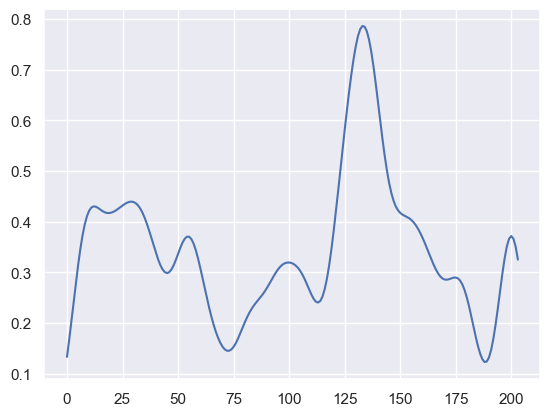

[1274]
[1277]
782
cuda
epoch 1,loss = 1.14716578
epoch 2,loss = 1.14476097
epoch 3,loss = 1.14239538
epoch 4,loss = 1.14007139
epoch 5,loss = 1.13776231
epoch 6,loss = 1.13538694
epoch 7,loss = 1.13308668
epoch 8,loss = 1.13098943
epoch 9,loss = 1.12898374
epoch 10,loss = 1.12692142
epoch 11,loss = 1.12483633
epoch 12,loss = 1.12291646
epoch 13,loss = 1.12111771
epoch 14,loss = 1.11929452
epoch 15,loss = 1.11737311
epoch 16,loss = 1.11553156
epoch 17,loss = 1.11381793
epoch 18,loss = 1.11215210
epoch 19,loss = 1.11051440
epoch 20,loss = 1.10887122
epoch 21,loss = 1.10714936
epoch 22,loss = 1.10534596
epoch 23,loss = 1.10370743
epoch 24,loss = 1.10224748
epoch 25,loss = 1.10080850
epoch 26,loss = 1.09938943
epoch 27,loss = 1.09798908
epoch 28,loss = 1.09660673
epoch 29,loss = 1.09524214
epoch 30,loss = 1.09389448
epoch 31,loss = 1.09256339
epoch 32,loss = 1.09124887
epoch 33,loss = 1.08995032
epoch 34,loss = 1.08866811
epoch 35,loss = 1.08740175
epoch 36,loss = 1.08615172
epoch 37,loss 

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 50,loss = 1.07038653
epoch 51,loss = 1.06938851
epoch 52,loss = 1.06839931
epoch 53,loss = 1.06742239
epoch 54,loss = 1.06645834
epoch 55,loss = 1.06550753
epoch 56,loss = 1.06457412
epoch 57,loss = 1.06358981
epoch 58,loss = 1.06258905
epoch 59,loss = 1.06159544
epoch 60,loss = 1.06061113
epoch 61,loss = 1.05963802
epoch 62,loss = 1.05867767
epoch 63,loss = 1.05773222
epoch 64,loss = 1.05680299
epoch 65,loss = 1.05589116
epoch 66,loss = 1.05499804
epoch 67,loss = 1.05412483
epoch 68,loss = 1.05327225
epoch 69,loss = 1.05244124
epoch 70,loss = 1.05163193
epoch 71,loss = 1.05084503
epoch 72,loss = 1.05008090
epoch 73,loss = 1.04934406
epoch 74,loss = 1.04864311
epoch 75,loss = 1.04799271
epoch 76,loss = 1.04736805
epoch 77,loss = 1.04677486
epoch 78,loss = 1.04620075
epoch 79,loss = 1.04563236
epoch 80,loss = 1.04507530
epoch 81,loss = 1.04453492
epoch 82,loss = 1.04401517
epoch 83,loss = 1.04351568
epoch 84,loss = 1.04303646
epoch 85,loss = 1.04257715
epoch 86,loss = 1.04213428
e

epoch 357,loss = 1.00214469
epoch 358,loss = 1.00189269
epoch 359,loss = 1.00163639
epoch 360,loss = 1.00137353
epoch 361,loss = 1.00110364
epoch 362,loss = 1.00082886
epoch 363,loss = 1.00054932
epoch 364,loss = 1.00026464
epoch 365,loss = 0.99997461
epoch 366,loss = 0.99967968
epoch 367,loss = 0.99937993
epoch 368,loss = 0.99907529
epoch 369,loss = 0.99876523
epoch 370,loss = 0.99845004
epoch 371,loss = 0.99812311
epoch 372,loss = 0.99778664
epoch 373,loss = 0.99743873
epoch 374,loss = 0.99708313
epoch 375,loss = 0.99671954
epoch 376,loss = 0.99634796
epoch 377,loss = 0.99596882
epoch 378,loss = 0.99558121
epoch 379,loss = 0.99518567
epoch 380,loss = 0.99478078
epoch 381,loss = 0.99436766
epoch 382,loss = 0.99394751
epoch 383,loss = 0.99351913
epoch 384,loss = 0.99308145
epoch 385,loss = 0.99263412
epoch 386,loss = 0.99217701
epoch 387,loss = 0.99170899
epoch 388,loss = 0.99123335
epoch 389,loss = 0.99076706
epoch 390,loss = 0.99028516
epoch 391,loss = 0.98979306
epoch 392,loss = 0.9

epoch 657,loss = 0.75875854
epoch 658,loss = 0.75830716
epoch 659,loss = 0.75784433
epoch 660,loss = 0.75736642
epoch 661,loss = 0.75689000
epoch 662,loss = 0.75642538
epoch 663,loss = 0.75597298
epoch 664,loss = 0.75553387
epoch 665,loss = 0.75510335
epoch 666,loss = 0.75468290
epoch 667,loss = 0.75427479
epoch 668,loss = 0.75389433
epoch 669,loss = 0.75351906
epoch 670,loss = 0.75312060
epoch 671,loss = 0.75272322
epoch 672,loss = 0.75231773
epoch 673,loss = 0.75191092
epoch 674,loss = 0.75151366
epoch 675,loss = 0.75112718
epoch 676,loss = 0.75076658
epoch 677,loss = 0.75042057
epoch 678,loss = 0.75007290
epoch 679,loss = 0.74972415
epoch 680,loss = 0.74938416
epoch 681,loss = 0.74905497
epoch 682,loss = 0.74873269
epoch 683,loss = 0.74839646
epoch 684,loss = 0.74803573
epoch 685,loss = 0.74767989
epoch 686,loss = 0.74735326
epoch 687,loss = 0.74705070
epoch 688,loss = 0.74674875
epoch 689,loss = 0.74644351
epoch 690,loss = 0.74615240
epoch 691,loss = 0.74585718
epoch 692,loss = 0.7

epoch 964,loss = 0.71935630
epoch 965,loss = 0.71933162
epoch 966,loss = 0.71930623
epoch 967,loss = 0.71928090
epoch 968,loss = 0.71925879
epoch 969,loss = 0.71923470
epoch 970,loss = 0.71921146
epoch 971,loss = 0.71919042
epoch 972,loss = 0.71916699
epoch 973,loss = 0.71914673
epoch 974,loss = 0.71912360
epoch 975,loss = 0.71910203
epoch 976,loss = 0.71908164
epoch 977,loss = 0.71905750
epoch 978,loss = 0.71904010
epoch 979,loss = 0.71901977
epoch 980,loss = 0.71899390
epoch 981,loss = 0.71898097
epoch 982,loss = 0.71896458
epoch 983,loss = 0.71894360
epoch 984,loss = 0.71891880
epoch 985,loss = 0.71889496
epoch 986,loss = 0.71887827
epoch 987,loss = 0.71885496
epoch 988,loss = 0.71884000
epoch 989,loss = 0.71882367
epoch 990,loss = 0.71880317
epoch 991,loss = 0.71877939
epoch 992,loss = 0.71876299
epoch 993,loss = 0.71874684
epoch 994,loss = 0.71872407
epoch 995,loss = 0.71870428
epoch 996,loss = 0.71868849
epoch 997,loss = 0.71866840
epoch 998,loss = 0.71864486
epoch 999,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([96, 1, 20])
1.0
Epoch 200:   loss= 0.1403  cluster difference= 1.0
Epoch 400:   loss= 0.13711  cluster difference= 0.010416666666666666
Epoch 600:   loss= 0.13501  cluster difference= 0.0
[3 0 5 3 3 7 1 3 3 7 1 3 3 3 0 5 3 3 6 5 3 3 7 1 3 3 7 1 3 3 2 4 5 3 3 0 5
 3 3 6 5 3 3 2 4 5 3 2 4 5 3 3 6 5 3 3 6 5 3 3 2 4 3 3 2 4 5 3 3 0 5 3 3 7
 1 5 5 7 1 3 3 3 0 5 3 3 0 5 3 5 6 5 3 3 2 4]


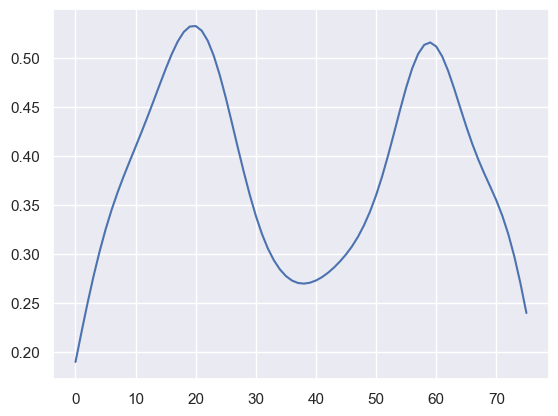

[]
[476]
11532
cuda
epoch 1,loss = 1.09966552
epoch 2,loss = 1.09816217
epoch 3,loss = 1.09667826
epoch 4,loss = 1.09521401
epoch 5,loss = 1.09376919
epoch 6,loss = 1.09234416
epoch 7,loss = 1.09093916
epoch 8,loss = 1.08955395
epoch 9,loss = 1.08818841
epoch 10,loss = 1.08684289
epoch 11,loss = 1.08551729
epoch 12,loss = 1.08421147
epoch 13,loss = 1.08292556
epoch 14,loss = 1.08165956
epoch 15,loss = 1.08041334


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 16,loss = 1.07918680
epoch 17,loss = 1.07797956
epoch 18,loss = 1.07679176
epoch 19,loss = 1.07562280
epoch 20,loss = 1.07447267
epoch 21,loss = 1.07334125
epoch 22,loss = 1.07222807
epoch 23,loss = 1.07113314
epoch 24,loss = 1.07005620
epoch 25,loss = 1.06899703
epoch 26,loss = 1.06795502
epoch 27,loss = 1.06693029
epoch 28,loss = 1.06592190
epoch 29,loss = 1.06493032
epoch 30,loss = 1.06395519
epoch 31,loss = 1.06299615
epoch 32,loss = 1.06205320
epoch 33,loss = 1.06112576
epoch 34,loss = 1.06021321
epoch 35,loss = 1.05931568
epoch 36,loss = 1.05843210
epoch 37,loss = 1.05756187
epoch 38,loss = 1.05670536
epoch 39,loss = 1.05586195
epoch 40,loss = 1.05502975
epoch 41,loss = 1.05420899
epoch 42,loss = 1.05339968
epoch 43,loss = 1.05260265
epoch 44,loss = 1.05181634
epoch 45,loss = 1.05104232
epoch 46,loss = 1.05028093
epoch 47,loss = 1.04953039
epoch 48,loss = 1.04879200
epoch 49,loss = 1.04806364
epoch 50,loss = 1.04734612
epoch 51,loss = 1.04664075
epoch 52,loss = 1.04594684
e

epoch 339,loss = 0.96942508
epoch 340,loss = 0.96874225
epoch 341,loss = 0.96806085
epoch 342,loss = 0.96737939
epoch 343,loss = 0.96669710
epoch 344,loss = 0.96601290
epoch 345,loss = 0.96532458
epoch 346,loss = 0.96463037
epoch 347,loss = 0.96392089
epoch 348,loss = 0.96317881
epoch 349,loss = 0.96240413
epoch 350,loss = 0.96189988
epoch 351,loss = 0.96132576
epoch 352,loss = 0.96066344
epoch 353,loss = 0.95994705
epoch 354,loss = 0.95924735
epoch 355,loss = 0.95864350
epoch 356,loss = 0.95811385
epoch 357,loss = 0.95756745
epoch 358,loss = 0.95700705
epoch 359,loss = 0.95642531
epoch 360,loss = 0.95582420
epoch 361,loss = 0.95524871
epoch 362,loss = 0.95466548
epoch 363,loss = 0.95410413
epoch 364,loss = 0.95354795
epoch 365,loss = 0.95299971
epoch 366,loss = 0.95246112
epoch 367,loss = 0.95192522
epoch 368,loss = 0.95138359
epoch 369,loss = 0.95084000
epoch 370,loss = 0.95029992
epoch 371,loss = 0.94976866
epoch 372,loss = 0.94924790
epoch 373,loss = 0.94872898
epoch 374,loss = 0.9

epoch 637,loss = 0.84029698
epoch 638,loss = 0.83992785
epoch 639,loss = 0.83955681
epoch 640,loss = 0.83917958
epoch 641,loss = 0.83879560
epoch 642,loss = 0.83840579
epoch 643,loss = 0.83799875
epoch 644,loss = 0.83759028
epoch 645,loss = 0.83716202
epoch 646,loss = 0.83671463
epoch 647,loss = 0.83627409
epoch 648,loss = 0.83579749
epoch 649,loss = 0.83532155
epoch 650,loss = 0.83482790
epoch 651,loss = 0.83434403
epoch 652,loss = 0.83382773
epoch 653,loss = 0.83331722
epoch 654,loss = 0.83277720
epoch 655,loss = 0.83224207
epoch 656,loss = 0.83168727
epoch 657,loss = 0.83113021
epoch 658,loss = 0.83057511
epoch 659,loss = 0.82999104
epoch 660,loss = 0.82941437
epoch 661,loss = 0.82883102
epoch 662,loss = 0.82824242
epoch 663,loss = 0.82766724
epoch 664,loss = 0.82711065
epoch 665,loss = 0.82655531
epoch 666,loss = 0.82601887
epoch 667,loss = 0.82550997
epoch 668,loss = 0.82502222
epoch 669,loss = 0.82454967
epoch 670,loss = 0.82409990
epoch 671,loss = 0.82367700
epoch 672,loss = 0.8

epoch 941,loss = 0.73363876
epoch 942,loss = 0.73311061
epoch 943,loss = 0.73258471
epoch 944,loss = 0.73205823
epoch 945,loss = 0.73153508
epoch 946,loss = 0.73101658
epoch 947,loss = 0.73050946
epoch 948,loss = 0.73001337
epoch 949,loss = 0.72951794
epoch 950,loss = 0.72903311
epoch 951,loss = 0.72854924
epoch 952,loss = 0.72807676
epoch 953,loss = 0.72761244
epoch 954,loss = 0.72716057
epoch 955,loss = 0.72671258
epoch 956,loss = 0.72627038
epoch 957,loss = 0.72583395
epoch 958,loss = 0.72541529
epoch 959,loss = 0.72500187
epoch 960,loss = 0.72459686
epoch 961,loss = 0.72420400
epoch 962,loss = 0.72381914
epoch 963,loss = 0.72344017
epoch 964,loss = 0.72306788
epoch 965,loss = 0.72270828
epoch 966,loss = 0.72235870
epoch 967,loss = 0.72201127
epoch 968,loss = 0.72167051
epoch 969,loss = 0.72133529
epoch 970,loss = 0.72099042
epoch 971,loss = 0.72058642
epoch 972,loss = 0.72020441
epoch 973,loss = 0.71990108
epoch 974,loss = 0.71958768
epoch 975,loss = 0.71930689
epoch 976,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


torch.Size([1439, 1, 20])
1.0
Epoch 200:   loss= 0.196  cluster difference= 1.0
Epoch 400:   loss= 0.19649  cluster difference= 0.04586518415566365
Epoch 600:   loss= 0.1955  cluster difference= 0.03613620569840167
Epoch 800:   loss= 0.19427  cluster difference= 0.02501737317581654
Epoch 1000:   loss= 0.193  cluster difference= 0.014593467685892982
Epoch 1200:   loss= 0.19165  cluster difference= 0.01250868658790827
Epoch 1400:   loss= 0.19027  cluster difference= 0.0118137595552467
Epoch 1600:   loss= 0.18888  cluster difference= 0.017373175816539264
Epoch 1800:   loss= 0.18755  cluster difference= 0.01250868658790827
Epoch 2000:   loss= 0.18633  cluster difference= 0.009034051424600417
[4 2 0 ... 0 4 2]


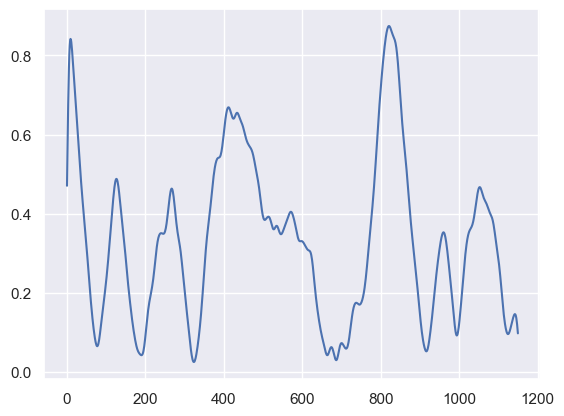

[1234, 4458, 7730]
[1090 4436 5712 7923]
9170
cuda
epoch 1,loss = 1.08281112
epoch 2,loss = 1.08151770
epoch 3,loss = 1.08022904
epoch 4,loss = 1.07894504
epoch 5,loss = 1.07766616
epoch 6,loss = 1.07639277
epoch 7,loss = 1.07512486
epoch 8,loss = 1.07386291
epoch 9,loss = 1.07260716
epoch 10,loss = 1.07135773
epoch 11,loss = 1.07011485
epoch 12,loss = 1.06887889
epoch 13,loss = 1.06765020
epoch 14,loss = 1.06642878
epoch 15,loss = 1.06521499
epoch 16,loss = 1.06400907
epoch 17,loss = 1.06281126
epoch 18,loss = 1.06162179


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 19,loss = 1.06044090
epoch 20,loss = 1.05926883
epoch 21,loss = 1.05810606
epoch 22,loss = 1.05695236
epoch 23,loss = 1.05580854
epoch 24,loss = 1.05467451
epoch 25,loss = 1.05355048
epoch 26,loss = 1.05243707
epoch 27,loss = 1.05133414
epoch 28,loss = 1.05024207
epoch 29,loss = 1.04916120
epoch 30,loss = 1.04809177
epoch 31,loss = 1.04703379
epoch 32,loss = 1.04598773
epoch 33,loss = 1.04495382
epoch 34,loss = 1.04393220
epoch 35,loss = 1.04292309
epoch 36,loss = 1.04192686
epoch 37,loss = 1.04094350
epoch 38,loss = 1.03997326
epoch 39,loss = 1.03901649
epoch 40,loss = 1.03807330
epoch 41,loss = 1.03714383
epoch 42,loss = 1.03622830
epoch 43,loss = 1.03532708
epoch 44,loss = 1.03444004
epoch 45,loss = 1.03356731
epoch 46,loss = 1.03270948
epoch 47,loss = 1.03186619
epoch 48,loss = 1.03103781
epoch 49,loss = 1.03022432
epoch 50,loss = 1.02942598
epoch 51,loss = 1.02864289
epoch 52,loss = 1.02787507
epoch 53,loss = 1.02712250
epoch 54,loss = 1.02638531
epoch 55,loss = 1.02566385
e

epoch 323,loss = 0.86605704
epoch 324,loss = 0.86567932
epoch 325,loss = 0.86530167
epoch 326,loss = 0.86492515
epoch 327,loss = 0.86454892
epoch 328,loss = 0.86417478
epoch 329,loss = 0.86380219
epoch 330,loss = 0.86342859
epoch 331,loss = 0.86305523
epoch 332,loss = 0.86268151
epoch 333,loss = 0.86231017
epoch 334,loss = 0.86194313
epoch 335,loss = 0.86157775
epoch 336,loss = 0.86121017
epoch 337,loss = 0.86084169
epoch 338,loss = 0.86047626
epoch 339,loss = 0.86011291
epoch 340,loss = 0.85975200
epoch 341,loss = 0.85939503
epoch 342,loss = 0.85903770
epoch 343,loss = 0.85868037
epoch 344,loss = 0.85832691
epoch 345,loss = 0.85797781
epoch 346,loss = 0.85763454
epoch 347,loss = 0.85729730
epoch 348,loss = 0.85696417
epoch 349,loss = 0.85663074
epoch 350,loss = 0.85630071
epoch 351,loss = 0.85597211
epoch 352,loss = 0.85564566
epoch 353,loss = 0.85532111
epoch 354,loss = 0.85499913
epoch 355,loss = 0.85468107
epoch 356,loss = 0.85436517
epoch 357,loss = 0.85405010
epoch 358,loss = 0.8

epoch 621,loss = 0.82071936
epoch 622,loss = 0.82067686
epoch 623,loss = 0.82063472
epoch 624,loss = 0.82059258
epoch 625,loss = 0.82055068
epoch 626,loss = 0.82050842
epoch 627,loss = 0.82046735
epoch 628,loss = 0.82042676
epoch 629,loss = 0.82038611
epoch 630,loss = 0.82034546
epoch 631,loss = 0.82030505
epoch 632,loss = 0.82026488
epoch 633,loss = 0.82022530
epoch 634,loss = 0.82018620
epoch 635,loss = 0.82014710
epoch 636,loss = 0.82010859
epoch 637,loss = 0.82007045
epoch 638,loss = 0.82003134
epoch 639,loss = 0.81999171
epoch 640,loss = 0.81995249
epoch 641,loss = 0.81991369
epoch 642,loss = 0.81987524
epoch 643,loss = 0.81983656
epoch 644,loss = 0.81979793
epoch 645,loss = 0.81976008
epoch 646,loss = 0.81972146
epoch 647,loss = 0.81968081
epoch 648,loss = 0.81963986
epoch 649,loss = 0.81959903
epoch 650,loss = 0.81955862
epoch 651,loss = 0.81951821
epoch 652,loss = 0.81947821
epoch 653,loss = 0.81943703
epoch 654,loss = 0.81939691
epoch 655,loss = 0.81935918
epoch 656,loss = 0.8

epoch 925,loss = 0.81417674
epoch 926,loss = 0.81417161
epoch 927,loss = 0.81416667
epoch 928,loss = 0.81416172
epoch 929,loss = 0.81415695
epoch 930,loss = 0.81415218
epoch 931,loss = 0.81414741
epoch 932,loss = 0.81414270
epoch 933,loss = 0.81413800
epoch 934,loss = 0.81413341
epoch 935,loss = 0.81412888
epoch 936,loss = 0.81412435
epoch 937,loss = 0.81411970
epoch 938,loss = 0.81411463
epoch 939,loss = 0.81410897
epoch 940,loss = 0.81410336
epoch 941,loss = 0.81409752
epoch 942,loss = 0.81409156
epoch 943,loss = 0.81408560
epoch 944,loss = 0.81407958
epoch 945,loss = 0.81407297
epoch 946,loss = 0.81406629
epoch 947,loss = 0.81405962
epoch 948,loss = 0.81405312
epoch 949,loss = 0.81404656
epoch 950,loss = 0.81403917
epoch 951,loss = 0.81403285
epoch 952,loss = 0.81402737
epoch 953,loss = 0.81402189
epoch 954,loss = 0.81401646
epoch 955,loss = 0.81401116
epoch 956,loss = 0.81400585
epoch 957,loss = 0.81400096
epoch 958,loss = 0.81399673
epoch 959,loss = 0.81399238
epoch 960,loss = 0.8

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


torch.Size([1144, 1, 20])
1.0
Epoch 200:   loss= 0.19369  cluster difference= 1.0
Epoch 400:   loss= 0.19088  cluster difference= 0.020104895104895104
Epoch 600:   loss= 0.18874  cluster difference= 0.012237762237762238
Epoch 800:   loss= 0.18714  cluster difference= 0.005244755244755245
[2 5 1 ... 7 2 5]


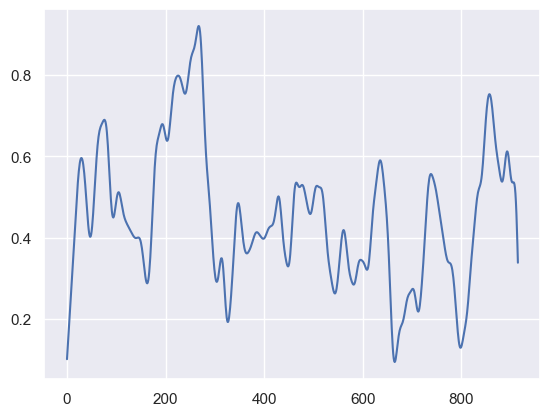

[1530, 3058, 7778]
[1310 2620 3930 5240 6550 7860]
8400
cuda
epoch 1,loss = 1.08275688
epoch 2,loss = 1.08177722
epoch 3,loss = 1.08080065
epoch 4,loss = 1.07982707
epoch 5,loss = 1.07885659
epoch 6,loss = 1.07788932
epoch 7,loss = 1.07692552
epoch 8,loss = 1.07596493
epoch 9,loss = 1.07501471
epoch 10,loss = 1.07407320
epoch 11,loss = 1.07313514
epoch 12,loss = 1.07220054
epoch 13,loss = 1.07126999
epoch 14,loss = 1.07034314
epoch 15,loss = 1.06942022
epoch 16,loss = 1.06850135
epoch 17,loss = 1.06758630
epoch 18,loss = 1.06667554
epoch 19,loss = 1.06576860
epoch 20,loss = 1.06486583
epoch 21,loss = 1.06396723
epoch 22,loss = 1.06307268
epoch 23,loss = 1.06218231
epoch 24,loss = 1.06129599
epoch 25,loss = 1.06041396
epoch 26,loss = 1.05953598
epoch 27,loss = 1.05866230
epoch 28,loss = 1.05779278
epoch 29,loss = 1.05692744
epoch 30,loss = 1.05606639
epoch 31,loss = 1.05520940
epoch 32,loss = 1.05435669


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 33,loss = 1.05350828
epoch 34,loss = 1.05266416
epoch 35,loss = 1.05182409
epoch 36,loss = 1.05098820
epoch 37,loss = 1.05015671
epoch 38,loss = 1.04932928
epoch 39,loss = 1.04850614
epoch 40,loss = 1.04768705
epoch 41,loss = 1.04687238
epoch 42,loss = 1.04606164
epoch 43,loss = 1.04525506
epoch 44,loss = 1.04445279
epoch 45,loss = 1.04365444
epoch 46,loss = 1.04286015
epoch 47,loss = 1.04206967
epoch 48,loss = 1.04128325
epoch 49,loss = 1.04050004
epoch 50,loss = 1.03972042
epoch 51,loss = 1.03894413
epoch 52,loss = 1.03817117
epoch 53,loss = 1.03740156
epoch 54,loss = 1.03663468
epoch 55,loss = 1.03587091
epoch 56,loss = 1.03510976
epoch 57,loss = 1.03435087
epoch 58,loss = 1.03359425
epoch 59,loss = 1.03283978
epoch 60,loss = 1.03208709
epoch 61,loss = 1.03133583
epoch 62,loss = 1.03058553
epoch 63,loss = 1.02983594
epoch 64,loss = 1.02908671
epoch 65,loss = 1.02833712
epoch 66,loss = 1.02758694
epoch 67,loss = 1.02683592
epoch 68,loss = 1.02608418
epoch 69,loss = 1.02533436
e

epoch 349,loss = 0.77418303
epoch 350,loss = 0.77394509
epoch 351,loss = 0.77371031
epoch 352,loss = 0.77347714
epoch 353,loss = 0.77324408
epoch 354,loss = 0.77301103
epoch 355,loss = 0.77278328
epoch 356,loss = 0.77255774
epoch 357,loss = 0.77233368
epoch 358,loss = 0.77211112
epoch 359,loss = 0.77189058
epoch 360,loss = 0.77167326
epoch 361,loss = 0.77145988
epoch 362,loss = 0.77124906
epoch 363,loss = 0.77104020
epoch 364,loss = 0.77083379
epoch 365,loss = 0.77062958
epoch 366,loss = 0.77042753
epoch 367,loss = 0.77022707
epoch 368,loss = 0.77002758
epoch 369,loss = 0.76982820
epoch 370,loss = 0.76963073
epoch 371,loss = 0.76943469
epoch 372,loss = 0.76923901
epoch 373,loss = 0.76904327
epoch 374,loss = 0.76884788
epoch 375,loss = 0.76865298
epoch 376,loss = 0.76845872
epoch 377,loss = 0.76826549
epoch 378,loss = 0.76807284
epoch 379,loss = 0.76787931
epoch 380,loss = 0.76768321
epoch 381,loss = 0.76748729
epoch 382,loss = 0.76729190
epoch 383,loss = 0.76709700
epoch 384,loss = 0.7

epoch 676,loss = 0.73132908
epoch 677,loss = 0.73117548
epoch 678,loss = 0.73101103
epoch 679,loss = 0.73084468
epoch 680,loss = 0.73067623
epoch 681,loss = 0.73050642
epoch 682,loss = 0.73033196
epoch 683,loss = 0.73015296
epoch 684,loss = 0.72997326
epoch 685,loss = 0.72978902
epoch 686,loss = 0.72959828
epoch 687,loss = 0.72940385
epoch 688,loss = 0.72920781
epoch 689,loss = 0.72900856
epoch 690,loss = 0.72880393
epoch 691,loss = 0.72859114
epoch 692,loss = 0.72837043
epoch 693,loss = 0.72814447
epoch 694,loss = 0.72791630
epoch 695,loss = 0.72768408
epoch 696,loss = 0.72744638
epoch 697,loss = 0.72719610
epoch 698,loss = 0.72692788
epoch 699,loss = 0.72665381
epoch 700,loss = 0.72636616
epoch 701,loss = 0.72606564
epoch 702,loss = 0.72575492
epoch 703,loss = 0.72543490
epoch 704,loss = 0.72510946
epoch 705,loss = 0.72476983
epoch 706,loss = 0.72441339
epoch 707,loss = 0.72403467
epoch 708,loss = 0.72362649
epoch 709,loss = 0.72320861
epoch 710,loss = 0.72277462
epoch 711,loss = 0.7

epoch 991,loss = 0.65094638
epoch 992,loss = 0.65089256
epoch 993,loss = 0.65083665
epoch 994,loss = 0.65078288
epoch 995,loss = 0.65073258
epoch 996,loss = 0.65068310
epoch 997,loss = 0.65063417
epoch 998,loss = 0.65058494
epoch 999,loss = 0.65053457
epoch 1000,loss = 0.65048307
epoch 1001,loss = 0.65043086
epoch 1002,loss = 0.65037864
epoch 1003,loss = 0.65032691
epoch 1004,loss = 0.65027398
epoch 1005,loss = 0.65021354
epoch 1006,loss = 0.65014952
epoch 1007,loss = 0.65008366
epoch 1008,loss = 0.65001923
epoch 1009,loss = 0.64995611
epoch 1010,loss = 0.64990073
epoch 1011,loss = 0.64984846
epoch 1012,loss = 0.64979434
epoch 1013,loss = 0.64973855
epoch 1014,loss = 0.64968216
epoch 1015,loss = 0.64962339
epoch 1016,loss = 0.64956462
epoch 1017,loss = 0.64950681
epoch 1018,loss = 0.64944971
epoch 1019,loss = 0.64938432
epoch 1020,loss = 0.64931452
epoch 1021,loss = 0.64924097
epoch 1022,loss = 0.64916635
epoch 1023,loss = 0.64908701
epoch 1024,loss = 0.64899987
epoch 1025,loss = 0.648

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([418, 1, 50])
1.0
Epoch 200:   loss= 0.18467  cluster difference= 1.0
Epoch 400:   loss= 0.18439  cluster difference= 0.004784688995215311
[0 1 2 0 0 7 6 6 0 0 6 5 3 1 1 2 1 2 5 7 6 0 0 6 6 6 0 7 6 1 2 5 3 5 3 0 1
 2 0 0 0 6 6 0 0 6 5 4 2 4 2 1 2 0 7 6 0 0 6 0 6 0 7 0 1 2 1 2 5 3 6 0 3 0
 0 0 6 6 0 0 6 5 7 5 4 2 4 2 0 7 2 0 0 7 6 6 0 7 6 5 7 5 7 5 3 0 1 2 0 0 0
 6 6 0 0 6 0 4 2 4 2 4 2 5 7 6 0 0 6 7 6 0 7 6 1 2 1 3 5 3 0 1 2 0 0 7 0 6
 0 0 7 6 1 2 5 3 5 7 3 2 0 0 0 0 0 0 0 0 6 0 6 0 6 5 3 0 1 2 0 0 7 6 6 0 0
 7 0 1 2 0 3 5 7 3 2 0 0 0 6 0 0 0 0 6 0 7 0 7 5 7 0 1 2 0 7 1 6 7 0 0 1 2
 5 3 5 3 1 2 5 3 0 0 5 6 0 6 0 0 6 5 7 6 1 2 7 6 1 2 0 0 7 6 0 0 0 7 6 1 6
 1 2 4 2 5 3 0 0 0 6 0 0 0 0 2 5 3 6 1 2 7 0 6 7 6 6 0 0 6 0 0 7 5 7 6 0 7
 1 2 1 2 0 6 0 0 6 6 0 0 3 6 1 2 7 2 3 0 0 0 6 0 0 6 0 0 7 6 0 6 6 7 5 4 2
 5 3 0 0 0 0 6 0 0 7 6 5 3 5 3 5 3 0 1 2 0 0 0 0 6 0 0 6 0 1 2 1 2 4 2 5 3
 0 0 0 0 6 0 0 3 0 1 2 5 3 5 3 0 1 2 0 0 0 7 6 0 7 6 5 3 5 4 2 1 2 5 3 0 0
 6 0 6 0 0 7 0 5 3 0 7]


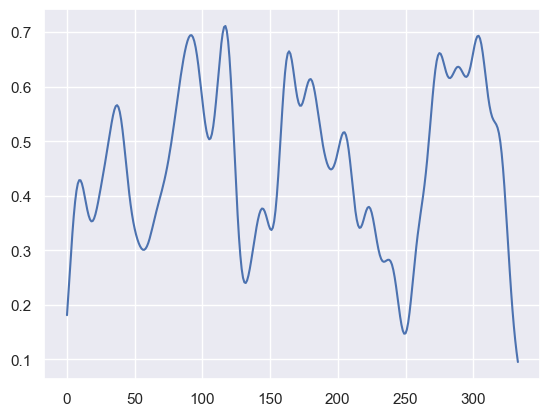

[3205, 4145, 6945]
[2800 5600 6650]
6483
cuda
epoch 1,loss = 0.99924201
epoch 2,loss = 0.99923098
epoch 3,loss = 0.99921995
epoch 4,loss = 0.99920911
epoch 5,loss = 0.99919838
epoch 6,loss = 0.99918759
epoch 7,loss = 0.99917686
epoch 8,loss = 0.99916631
epoch 9,loss = 0.99915582
epoch 10,loss = 0.99914539
epoch 11,loss = 0.99913502
epoch 12,loss = 0.99912477
epoch 13,loss = 0.99911451
epoch 14,loss = 0.99910444
epoch 15,loss = 0.99909443
epoch 16,loss = 0.99908435
epoch 17,loss = 0.99907446
epoch 18,loss = 0.99906456
epoch 19,loss = 0.99905473
epoch 20,loss = 0.99904507
epoch 21,loss = 0.99903554
epoch 22,loss = 0.99902624
epoch 23,loss = 0.99901724
epoch 24,loss = 0.99900836
epoch 25,loss = 0.99899960
epoch 26,loss = 0.99899107


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 27,loss = 0.99898249
epoch 28,loss = 0.99897403
epoch 29,loss = 0.99896556
epoch 30,loss = 0.99895728
epoch 31,loss = 0.99894893
epoch 32,loss = 0.99894077
epoch 33,loss = 0.99893260
epoch 34,loss = 0.99892449
epoch 35,loss = 0.99891651
epoch 36,loss = 0.99890852
epoch 37,loss = 0.99890071
epoch 38,loss = 0.99889296
epoch 39,loss = 0.99888521
epoch 40,loss = 0.99887753
epoch 41,loss = 0.99886990
epoch 42,loss = 0.99886239
epoch 43,loss = 0.99885488
epoch 44,loss = 0.99884754
epoch 45,loss = 0.99884021
epoch 46,loss = 0.99883294
epoch 47,loss = 0.99882573
epoch 48,loss = 0.99881870
epoch 49,loss = 0.99881166
epoch 50,loss = 0.99880469
epoch 51,loss = 0.99879771
epoch 52,loss = 0.99879092
epoch 53,loss = 0.99878418
epoch 54,loss = 0.99877739
epoch 55,loss = 0.99877077
epoch 56,loss = 0.99876422
epoch 57,loss = 0.99875772
epoch 58,loss = 0.99875128
epoch 59,loss = 0.99874490
epoch 60,loss = 0.99873853
epoch 61,loss = 0.99873233
epoch 62,loss = 0.99872613
epoch 63,loss = 0.99872005
e

epoch 330,loss = 0.81246316
epoch 331,loss = 0.81223637
epoch 332,loss = 0.81201285
epoch 333,loss = 0.81178987
epoch 334,loss = 0.81157786
epoch 335,loss = 0.81136835
epoch 336,loss = 0.81115913
epoch 337,loss = 0.81095201
epoch 338,loss = 0.81074584
epoch 339,loss = 0.81054097
epoch 340,loss = 0.81033832
epoch 341,loss = 0.81013405
epoch 342,loss = 0.80993205
epoch 343,loss = 0.80972403
epoch 344,loss = 0.80951458
epoch 345,loss = 0.80929923
epoch 346,loss = 0.80907869
epoch 347,loss = 0.80886680
epoch 348,loss = 0.80865747
epoch 349,loss = 0.80844420
epoch 350,loss = 0.80823100
epoch 351,loss = 0.80801964
epoch 352,loss = 0.80780488
epoch 353,loss = 0.80758882
epoch 354,loss = 0.80737817
epoch 355,loss = 0.80717194
epoch 356,loss = 0.80697060
epoch 357,loss = 0.80677056
epoch 358,loss = 0.80656731
epoch 359,loss = 0.80636150
epoch 360,loss = 0.80615622
epoch 361,loss = 0.80594689
epoch 362,loss = 0.80573243
epoch 363,loss = 0.80552012
epoch 364,loss = 0.80531383
epoch 365,loss = 0.8

epoch 629,loss = 0.76160395
epoch 630,loss = 0.76152080
epoch 631,loss = 0.76144058
epoch 632,loss = 0.76136297
epoch 633,loss = 0.76128560
epoch 634,loss = 0.76120907
epoch 635,loss = 0.76113135
epoch 636,loss = 0.76105094
epoch 637,loss = 0.76097029
epoch 638,loss = 0.76089138
epoch 639,loss = 0.76081455
epoch 640,loss = 0.76073700
epoch 641,loss = 0.76065820
epoch 642,loss = 0.76057702
epoch 643,loss = 0.76049536
epoch 644,loss = 0.76041454
epoch 645,loss = 0.76033235
epoch 646,loss = 0.76025105
epoch 647,loss = 0.76017040
epoch 648,loss = 0.76009005
epoch 649,loss = 0.76001006
epoch 650,loss = 0.75993097
epoch 651,loss = 0.75985366
epoch 652,loss = 0.75977701
epoch 653,loss = 0.75969738
epoch 654,loss = 0.75961763
epoch 655,loss = 0.75953734
epoch 656,loss = 0.75945640
epoch 657,loss = 0.75937325
epoch 658,loss = 0.75928485
epoch 659,loss = 0.75918406
epoch 660,loss = 0.75907856
epoch 661,loss = 0.75897092
epoch 662,loss = 0.75886261
epoch 663,loss = 0.75875080
epoch 664,loss = 0.7

epoch 934,loss = 0.72016764
epoch 935,loss = 0.72006446
epoch 936,loss = 0.71996301
epoch 937,loss = 0.71986163
epoch 938,loss = 0.71976089
epoch 939,loss = 0.71966457
epoch 940,loss = 0.71957004
epoch 941,loss = 0.71947908
epoch 942,loss = 0.71938926
epoch 943,loss = 0.71930039
epoch 944,loss = 0.71921253
epoch 945,loss = 0.71912301
epoch 946,loss = 0.71903366
epoch 947,loss = 0.71894211
epoch 948,loss = 0.71885568
epoch 949,loss = 0.71877748
epoch 950,loss = 0.71869856
epoch 951,loss = 0.71861672
epoch 952,loss = 0.71853292
epoch 953,loss = 0.71844953
epoch 954,loss = 0.71836936
epoch 955,loss = 0.71829206
epoch 956,loss = 0.71821666
epoch 957,loss = 0.71814054
epoch 958,loss = 0.71806300
epoch 959,loss = 0.71798521
epoch 960,loss = 0.71790946
epoch 961,loss = 0.71783644
epoch 962,loss = 0.71776414
epoch 963,loss = 0.71769345
epoch 964,loss = 0.71762371
epoch 965,loss = 0.71755457
epoch 966,loss = 0.71748680
epoch 967,loss = 0.71741992
epoch 968,loss = 0.71735418
epoch 969,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([808, 1, 20])
1.0
Epoch 200:   loss= 0.1624  cluster difference= 1.0
Epoch 400:   loss= 0.16423  cluster difference= 0.01485148514851485
Epoch 600:   loss= 0.16576  cluster difference= 0.02103960396039604
Epoch 800:   loss= 0.16711  cluster difference= 0.019801980198019802
Epoch 1000:   loss= 0.1683  cluster difference= 0.018564356435643563
Epoch 1200:   loss= 0.16938  cluster difference= 0.02103960396039604
Epoch 1400:   loss= 0.17035  cluster difference= 0.012376237623762377
Epoch 1600:   loss= 0.17124  cluster difference= 0.007425742574257425
[1 1 1 7 3 5 5 1 1 1 1 6 1 3 7 0 1 1 1 0 6 7 6 1 1 1 1 7 0 4 4 2 1 1 0 1 7
 6 2 5 1 6 1 0 7 0 6 5 1 0 1 1 6 3 5 5 1 1 1 1 0 7 3 3 1 6 1 1 1 0 4 4 2 1
 1 0 1 0 4 4 2 1 6 1 0 7 6 4 2 1 6 1 1 6 3 5 3 1 0 1 1 0 7 3 7 1 1 6 6 1 3
 6 0 4 7 7 5 1 5 6 1 1 0 2 2 1 3 6 0 2 5 1 3 6 0 7 6 3 1 1 6 1 6 2 4 6 1 1
 3 3 6 3 0 1 6 7 5 6 1 7 0 4 1 1 3 3 6 0 3 6 5 1 1 7 1 6 7 1 3 7 1 0 1 6 2
 7 6 1 6 3 5 4 1 0 4 4 1 0 4 1 1 6 0 2 1 1 1 1 1 6 4 2 1 1 1 1

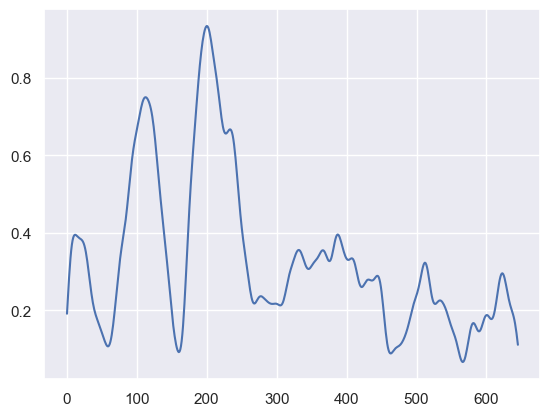

[1554, 2258]
[ 851 1637 2292 3733 4715 5566]
5196
cuda
epoch 1,loss = 0.99320096
epoch 2,loss = 0.99319303
epoch 3,loss = 0.99318516
epoch 4,loss = 0.99317729
epoch 5,loss = 0.99316955
epoch 6,loss = 0.99316174
epoch 7,loss = 0.99315405
epoch 8,loss = 0.99314636
epoch 9,loss = 0.99313867
epoch 10,loss = 0.99313098
epoch 11,loss = 0.99312341
epoch 12,loss = 0.99311572
epoch 13,loss = 0.99310827
epoch 14,loss = 0.99310070
epoch 15,loss = 0.99309325
epoch 16,loss = 0.99308568
epoch 17,loss = 0.99307829
epoch 18,loss = 0.99307090
epoch 19,loss = 0.99306345
epoch 20,loss = 0.99305612
epoch 21,loss = 0.99304873
epoch 22,loss = 0.99304157
epoch 23,loss = 0.99303424
epoch 24,loss = 0.99302697
epoch 25,loss = 0.99301976
epoch 26,loss = 0.99301249
epoch 27,loss = 0.99300539
epoch 28,loss = 0.99299812
epoch 29,loss = 0.99299097


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 30,loss = 0.99298382
epoch 31,loss = 0.99297673
epoch 32,loss = 0.99296957
epoch 33,loss = 0.99296236
epoch 34,loss = 0.99295521
epoch 35,loss = 0.99294806
epoch 36,loss = 0.99294096
epoch 37,loss = 0.99293375
epoch 38,loss = 0.99292660
epoch 39,loss = 0.99291939
epoch 40,loss = 0.99291229
epoch 41,loss = 0.99290502
epoch 42,loss = 0.99289769
epoch 43,loss = 0.99289036
epoch 44,loss = 0.99288309
epoch 45,loss = 0.99287575
epoch 46,loss = 0.99286824
epoch 47,loss = 0.99286079
epoch 48,loss = 0.99285322
epoch 49,loss = 0.99284565
epoch 50,loss = 0.99283803
epoch 51,loss = 0.99283034
epoch 52,loss = 0.99282247
epoch 53,loss = 0.99281460
epoch 54,loss = 0.99280661
epoch 55,loss = 0.99279845
epoch 56,loss = 0.99279028
epoch 57,loss = 0.99278194
epoch 58,loss = 0.99277353
epoch 59,loss = 0.99276495
epoch 60,loss = 0.99275619
epoch 61,loss = 0.99274731
epoch 62,loss = 0.99273831
epoch 63,loss = 0.99272901
epoch 64,loss = 0.99271965
epoch 65,loss = 0.99271011
epoch 66,loss = 0.99270028
e

epoch 340,loss = 0.68663800
epoch 341,loss = 0.68607068
epoch 342,loss = 0.68551171
epoch 343,loss = 0.68495208
epoch 344,loss = 0.68439412
epoch 345,loss = 0.68385392
epoch 346,loss = 0.68332464
epoch 347,loss = 0.68281698
epoch 348,loss = 0.68231875
epoch 349,loss = 0.68182218
epoch 350,loss = 0.68134010
epoch 351,loss = 0.68086314
epoch 352,loss = 0.68039584
epoch 353,loss = 0.67993486
epoch 354,loss = 0.67948574
epoch 355,loss = 0.67903870
epoch 356,loss = 0.67860150
epoch 357,loss = 0.67817974
epoch 358,loss = 0.67776316
epoch 359,loss = 0.67735189
epoch 360,loss = 0.67695069
epoch 361,loss = 0.67654562
epoch 362,loss = 0.67614150
epoch 363,loss = 0.67573190
epoch 364,loss = 0.67533094
epoch 365,loss = 0.67493254
epoch 366,loss = 0.67452401
epoch 367,loss = 0.67411053
epoch 368,loss = 0.67370117
epoch 369,loss = 0.67329973
epoch 370,loss = 0.67290497
epoch 371,loss = 0.67251587
epoch 372,loss = 0.67214000
epoch 373,loss = 0.67175692
epoch 374,loss = 0.67136872
epoch 375,loss = 0.6

epoch 646,loss = 0.61294419
epoch 647,loss = 0.61265230
epoch 648,loss = 0.61236215
epoch 649,loss = 0.61206919
epoch 650,loss = 0.61177951
epoch 651,loss = 0.61148816
epoch 652,loss = 0.61119634
epoch 653,loss = 0.61090708
epoch 654,loss = 0.61061305
epoch 655,loss = 0.61030382
epoch 656,loss = 0.60998708
epoch 657,loss = 0.60966522
epoch 658,loss = 0.60934669
epoch 659,loss = 0.60904568
epoch 660,loss = 0.60876054
epoch 661,loss = 0.60848904
epoch 662,loss = 0.60821897
epoch 663,loss = 0.60795093
epoch 664,loss = 0.60768944
epoch 665,loss = 0.60744500
epoch 666,loss = 0.60720837
epoch 667,loss = 0.60697848
epoch 668,loss = 0.60675389
epoch 669,loss = 0.60652173
epoch 670,loss = 0.60629159
epoch 671,loss = 0.60605872
epoch 672,loss = 0.60583323
epoch 673,loss = 0.60561877
epoch 674,loss = 0.60541886
epoch 675,loss = 0.60522956
epoch 676,loss = 0.60504943
epoch 677,loss = 0.60487670
epoch 678,loss = 0.60471040
epoch 679,loss = 0.60454935
epoch 680,loss = 0.60439521
epoch 681,loss = 0.6

epoch 966,loss = 0.57406425
epoch 967,loss = 0.57397276
epoch 968,loss = 0.57388175
epoch 969,loss = 0.57379144
epoch 970,loss = 0.57370341
epoch 971,loss = 0.57361662
epoch 972,loss = 0.57353139
epoch 973,loss = 0.57344669
epoch 974,loss = 0.57336032
epoch 975,loss = 0.57327318
epoch 976,loss = 0.57318622
epoch 977,loss = 0.57309932
epoch 978,loss = 0.57301241
epoch 979,loss = 0.57292557
epoch 980,loss = 0.57284009
epoch 981,loss = 0.57275605
epoch 982,loss = 0.57267308
epoch 983,loss = 0.57259071
epoch 984,loss = 0.57250965
epoch 985,loss = 0.57242948
epoch 986,loss = 0.57235056
epoch 987,loss = 0.57227212
epoch 988,loss = 0.57219392
epoch 989,loss = 0.57211602
epoch 990,loss = 0.57203847
epoch 991,loss = 0.57196248
epoch 992,loss = 0.57188660
epoch 993,loss = 0.57181126
epoch 994,loss = 0.57173753
epoch 995,loss = 0.57166350
epoch 996,loss = 0.57158965
epoch 997,loss = 0.57151562
epoch 998,loss = 0.57144141
epoch 999,loss = 0.57136720
epoch 1000,loss = 0.57129109
epoch 1001,loss = 0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([647, 1, 20])
1.0
Epoch 200:   loss= 0.21271  cluster difference= 1.0
Epoch 400:   loss= 0.21081  cluster difference= 0.02936630602782071
Epoch 600:   loss= 0.20939  cluster difference= 0.027820710973724884
Epoch 800:   loss= 0.20778  cluster difference= 0.11901081916537867
Epoch 1000:   loss= 0.20566  cluster difference= 0.0401854714064915
Epoch 1200:   loss= 0.20409  cluster difference= 0.010819165378670788
Epoch 1400:   loss= 0.20288  cluster difference= 0.0030911901081916537
[5 2 4 4 3 1 2 7 2 3 4 2 7 5 2 4 7 5 6 4 4 3 6 4 7 5 6 7 0 3 1 0 4 3 7 0 4
 7 7 0 4 4 2 6 4 4 3 1 0 4 7 1 0 4 4 1 0 7 6 5 2 3 7 5 6 4 0 3 1 0 4 3 1 0
 4 7 5 6 4 4 3 1 6 4 3 1 5 2 3 1 0 4 3 7 2 4 7 5 6 4 7 5 2 4 4 3 1 0 4 7 1
 0 4 7 5 2 3 7 5 6 4 4 3 1 0 4 1 7 0 3 3 1 0 3 7 5 2 4 4 7 1 0 4 3 1 0 4 3
 1 0 4 3 7 2 4 7 5 6 4 4 4 1 2 4 2 1 0 4 7 5 2 3 7 5 2 4 4 0 6 7 5 2 1 0 4
 6 1 0 4 7 5 2 3 7 5 2 4 4 1 1 0 4 3 1 5 0 7 5 2 4 1 7 2 4 7 5 2 4 4 4 1 0
 0 7 6 0 4 4 1 0 3 4 7 2 7 0 1 0 3 4 7 2 7 0 7 2 7 2 4 

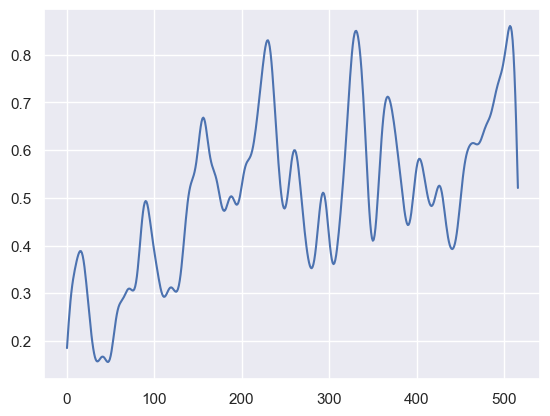

[1778, 2370, 3178, 4586]
[1755 3408 4521]
10124
cuda
epoch 1,loss = 1.10325098
epoch 2,loss = 1.10145259
epoch 3,loss = 1.09966695
epoch 4,loss = 1.09789407
epoch 5,loss = 1.09613490
epoch 6,loss = 1.09438968
epoch 7,loss = 1.09265900
epoch 8,loss = 1.09094322
epoch 9,loss = 1.08923900
epoch 10,loss = 1.08753777
epoch 11,loss = 1.08585441
epoch 12,loss = 1.08419132
epoch 13,loss = 1.08254755
epoch 14,loss = 1.08092141
epoch 15,loss = 1.07931316
epoch 16,loss = 1.07772303
epoch 17,loss = 1.07615173
epoch 18,loss = 1.07459950
epoch 19,loss = 1.07306695


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 20,loss = 1.07155406
epoch 21,loss = 1.07006133
epoch 22,loss = 1.06858873
epoch 23,loss = 1.06713593
epoch 24,loss = 1.06570268
epoch 25,loss = 1.06428862
epoch 26,loss = 1.06289339
epoch 27,loss = 1.06151557
epoch 28,loss = 1.06015563
epoch 29,loss = 1.05881166
epoch 30,loss = 1.05741417
epoch 31,loss = 1.05610108
epoch 32,loss = 1.05480731
epoch 33,loss = 1.05353165
epoch 34,loss = 1.05227387
epoch 35,loss = 1.05103397
epoch 36,loss = 1.04981244
epoch 37,loss = 1.04865062
epoch 38,loss = 1.04758215
epoch 39,loss = 1.04653525
epoch 40,loss = 1.04555345
epoch 41,loss = 1.04463696
epoch 42,loss = 1.04377687
epoch 43,loss = 1.04291916
epoch 44,loss = 1.04205060
epoch 45,loss = 1.04115176
epoch 46,loss = 1.04023218
epoch 47,loss = 1.03930807
epoch 48,loss = 1.03838992
epoch 49,loss = 1.03747904
epoch 50,loss = 1.03657544
epoch 51,loss = 1.03567934
epoch 52,loss = 1.03479111
epoch 53,loss = 1.03391087
epoch 54,loss = 1.03303885
epoch 55,loss = 1.03217506
epoch 56,loss = 1.03131986
e

epoch 333,loss = 0.49145526
epoch 334,loss = 0.49040332
epoch 335,loss = 0.48937237
epoch 336,loss = 0.48836243
epoch 337,loss = 0.48737404
epoch 338,loss = 0.48640946
epoch 339,loss = 0.48546305
epoch 340,loss = 0.48452950
epoch 341,loss = 0.48361918
epoch 342,loss = 0.48273459
epoch 343,loss = 0.48186979
epoch 344,loss = 0.48102221
epoch 345,loss = 0.48019394
epoch 346,loss = 0.47938076
epoch 347,loss = 0.47858265
epoch 348,loss = 0.47780246
epoch 349,loss = 0.47703493
epoch 350,loss = 0.47627866
epoch 351,loss = 0.47553420
epoch 352,loss = 0.47480255
epoch 353,loss = 0.47408342
epoch 354,loss = 0.47337449
epoch 355,loss = 0.47267729
epoch 356,loss = 0.47198963
epoch 357,loss = 0.47131136
epoch 358,loss = 0.47064677
epoch 359,loss = 0.46999359
epoch 360,loss = 0.46934935
epoch 361,loss = 0.46871486
epoch 362,loss = 0.46808794
epoch 363,loss = 0.46746710
epoch 364,loss = 0.46685371
epoch 365,loss = 0.46624589
epoch 366,loss = 0.46564135
epoch 367,loss = 0.46504578
epoch 368,loss = 0.4

epoch 632,loss = 0.42141771
epoch 633,loss = 0.42132521
epoch 634,loss = 0.42123288
epoch 635,loss = 0.42114085
epoch 636,loss = 0.42104903
epoch 637,loss = 0.42095721
epoch 638,loss = 0.42086568
epoch 639,loss = 0.42077449
epoch 640,loss = 0.42068359
epoch 641,loss = 0.42059270
epoch 642,loss = 0.42050216
epoch 643,loss = 0.42041159
epoch 644,loss = 0.42032108
epoch 645,loss = 0.42023063
epoch 646,loss = 0.42014039
epoch 647,loss = 0.42005014
epoch 648,loss = 0.41995990
epoch 649,loss = 0.41986975
epoch 650,loss = 0.41977981
epoch 651,loss = 0.41969001
epoch 652,loss = 0.41960046
epoch 653,loss = 0.41951084
epoch 654,loss = 0.41942146
epoch 655,loss = 0.41933224
epoch 656,loss = 0.41924307
epoch 657,loss = 0.41915399
epoch 658,loss = 0.41906509
epoch 659,loss = 0.41897625
epoch 660,loss = 0.41888753
epoch 661,loss = 0.41879877
epoch 662,loss = 0.41871011
epoch 663,loss = 0.41862148
epoch 664,loss = 0.41853300
epoch 665,loss = 0.41844454
epoch 666,loss = 0.41835606
epoch 667,loss = 0.4

epoch 958,loss = 0.39002320
epoch 959,loss = 0.38990808
epoch 960,loss = 0.38979402
epoch 961,loss = 0.38967976
epoch 962,loss = 0.38956583
epoch 963,loss = 0.38945186
epoch 964,loss = 0.38933876
epoch 965,loss = 0.38922629
epoch 966,loss = 0.38911408
epoch 967,loss = 0.38900217
epoch 968,loss = 0.38889068
epoch 969,loss = 0.38877997
epoch 970,loss = 0.38866979
epoch 971,loss = 0.38856030
epoch 972,loss = 0.38845190
epoch 973,loss = 0.38834447
epoch 974,loss = 0.38823703
epoch 975,loss = 0.38812977
epoch 976,loss = 0.38802326
epoch 977,loss = 0.38791761
epoch 978,loss = 0.38781238
epoch 979,loss = 0.38770720
epoch 980,loss = 0.38760206
epoch 981,loss = 0.38749740
epoch 982,loss = 0.38739315
epoch 983,loss = 0.38728929
epoch 984,loss = 0.38718584
epoch 985,loss = 0.38708305
epoch 986,loss = 0.38698083
epoch 987,loss = 0.38687909
epoch 988,loss = 0.38677785
epoch 989,loss = 0.38667649
epoch 990,loss = 0.38657507
epoch 991,loss = 0.38647425
epoch 992,loss = 0.38637412
epoch 993,loss = 0.3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


torch.Size([1263, 1, 20])
1.0
Epoch 200:   loss= 0.20983  cluster difference= 1.0
Epoch 400:   loss= 0.20839  cluster difference= 0.0166270783847981
Epoch 600:   loss= 0.20705  cluster difference= 0.00791765637371338
[4 5 6 ... 2 7 4]


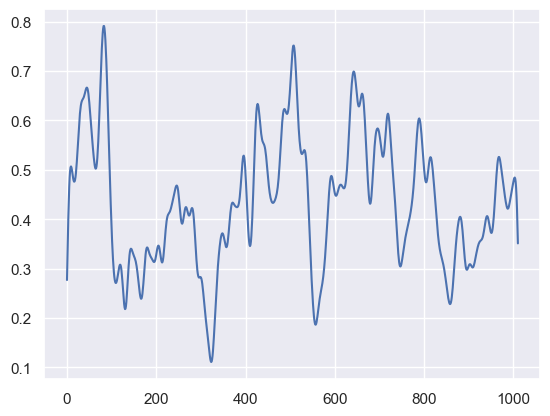

[1682, 5082, 6154, 7330]
[1504 2950 4570 5785 7058 8504]
1875
cuda
epoch 1,loss = 0.99973404
epoch 2,loss = 0.99972701
epoch 3,loss = 0.99971998
epoch 4,loss = 0.99971300
epoch 5,loss = 0.99970621
epoch 6,loss = 0.99969935
epoch 7,loss = 0.99969250
epoch 8,loss = 0.99968588
epoch 9,loss = 0.99967927
epoch 10,loss = 0.99967271
epoch 11,loss = 0.99966621
epoch 12,loss = 0.99965978
epoch 13,loss = 0.99965346
epoch 14,loss = 0.99964702
epoch 15,loss = 0.99964082
epoch 16,loss = 0.99963462
epoch 17,loss = 0.99962854
epoch 18,loss = 0.99962264
epoch 19,loss = 0.99961662
epoch 20,loss = 0.99961066
epoch 21,loss = 0.99960494
epoch 22,loss = 0.99959916
epoch 23,loss = 0.99959350
epoch 24,loss = 0.99958789
epoch 25,loss = 0.99958223
epoch 26,loss = 0.99957675
epoch 27,loss = 0.99957150
epoch 28,loss = 0.99956602
epoch 29,loss = 0.99956077
epoch 30,loss = 0.99955559
epoch 31,loss = 0.99955046
epoch 32,loss = 0.99954528
epoch 33,loss = 0.99954033
epoch 34,loss = 0.99953526
epoch 35,loss = 0.999530

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 51,loss = 0.99946111
epoch 52,loss = 0.99945718
epoch 53,loss = 0.99945343
epoch 54,loss = 0.99944973
epoch 55,loss = 0.99944615
epoch 56,loss = 0.99944246
epoch 57,loss = 0.99943888
epoch 58,loss = 0.99943542
epoch 59,loss = 0.99943197
epoch 60,loss = 0.99942857
epoch 61,loss = 0.99942523
epoch 62,loss = 0.99942195
epoch 63,loss = 0.99941868
epoch 64,loss = 0.99941552
epoch 65,loss = 0.99941236
epoch 66,loss = 0.99940932
epoch 67,loss = 0.99940628
epoch 68,loss = 0.99940330
epoch 69,loss = 0.99940038
epoch 70,loss = 0.99939764
epoch 71,loss = 0.99939471
epoch 72,loss = 0.99939185
epoch 73,loss = 0.99938911
epoch 74,loss = 0.99938649
epoch 75,loss = 0.99938375
epoch 76,loss = 0.99938124
epoch 77,loss = 0.99937850
epoch 78,loss = 0.99937606
epoch 79,loss = 0.99937356
epoch 80,loss = 0.99937111
epoch 81,loss = 0.99936879
epoch 82,loss = 0.99936640
epoch 83,loss = 0.99936420
epoch 84,loss = 0.99936175
epoch 85,loss = 0.99935955
epoch 86,loss = 0.99935722
epoch 87,loss = 0.99935514
e

epoch 357,loss = 0.50226480
epoch 358,loss = 0.50098038
epoch 359,loss = 0.49973217
epoch 360,loss = 0.49851909
epoch 361,loss = 0.49734712
epoch 362,loss = 0.49621424
epoch 363,loss = 0.49511081
epoch 364,loss = 0.49401540
epoch 365,loss = 0.49292192
epoch 366,loss = 0.49183753
epoch 367,loss = 0.49076423
epoch 368,loss = 0.48970336
epoch 369,loss = 0.48865157
epoch 370,loss = 0.48761407
epoch 371,loss = 0.48658916
epoch 372,loss = 0.48555908
epoch 373,loss = 0.48452905
epoch 374,loss = 0.48351398
epoch 375,loss = 0.48251486
epoch 376,loss = 0.48151901
epoch 377,loss = 0.48052180
epoch 378,loss = 0.47953975
epoch 379,loss = 0.47856829
epoch 380,loss = 0.47761199
epoch 381,loss = 0.47667351
epoch 382,loss = 0.47575536
epoch 383,loss = 0.47485742
epoch 384,loss = 0.47398183
epoch 385,loss = 0.47312239
epoch 386,loss = 0.47227025
epoch 387,loss = 0.47142175
epoch 388,loss = 0.47059894
epoch 389,loss = 0.46979827
epoch 390,loss = 0.46900412
epoch 391,loss = 0.46820137
epoch 392,loss = 0.4

epoch 689,loss = 0.41252658
epoch 690,loss = 0.41248795
epoch 691,loss = 0.41243312
epoch 692,loss = 0.41237360
epoch 693,loss = 0.41231111
epoch 694,loss = 0.41224650
epoch 695,loss = 0.41218078
epoch 696,loss = 0.41211435
epoch 697,loss = 0.41203329
epoch 698,loss = 0.41195169
epoch 699,loss = 0.41187206
epoch 700,loss = 0.41179362
epoch 701,loss = 0.41171712
epoch 702,loss = 0.41164517
epoch 703,loss = 0.41157529
epoch 704,loss = 0.41150802
epoch 705,loss = 0.41144145
epoch 706,loss = 0.41136938
epoch 707,loss = 0.41129872
epoch 708,loss = 0.41123524
epoch 709,loss = 0.41117385
epoch 710,loss = 0.41111436
epoch 711,loss = 0.41105515
epoch 712,loss = 0.41099468
epoch 713,loss = 0.41093472
epoch 714,loss = 0.41087559
epoch 715,loss = 0.41081792
epoch 716,loss = 0.41076210
epoch 717,loss = 0.41071096
epoch 718,loss = 0.41066357
epoch 719,loss = 0.41062233
epoch 720,loss = 0.41058403
epoch 721,loss = 0.41054592
epoch 722,loss = 0.41050887
epoch 723,loss = 0.41047287
epoch 724,loss = 0.4

epoch 998,loss = 0.40659359
epoch 999,loss = 0.40658671
epoch 1000,loss = 0.40657988
epoch 1001,loss = 0.40657318
epoch 1002,loss = 0.40656611
epoch 1003,loss = 0.40655917
epoch 1004,loss = 0.40655237
epoch 1005,loss = 0.40654585
epoch 1006,loss = 0.40653929
epoch 1007,loss = 0.40653312
epoch 1008,loss = 0.40652680
epoch 1009,loss = 0.40652040
epoch 1010,loss = 0.40651387
epoch 1011,loss = 0.40650752
epoch 1012,loss = 0.40650156
epoch 1013,loss = 0.40649548
epoch 1014,loss = 0.40648925
epoch 1015,loss = 0.40648279
epoch 1016,loss = 0.40647656
epoch 1017,loss = 0.40647045
epoch 1018,loss = 0.40646401
epoch 1019,loss = 0.40645784
epoch 1020,loss = 0.40645173
epoch 1021,loss = 0.40644565
epoch 1022,loss = 0.40643951
epoch 1023,loss = 0.40643343
epoch 1024,loss = 0.40642738
epoch 1025,loss = 0.40642130
epoch 1026,loss = 0.40641549
epoch 1027,loss = 0.40640977
epoch 1028,loss = 0.40640399
epoch 1029,loss = 0.40639827
epoch 1030,loss = 0.40639263
epoch 1031,loss = 0.40638700
epoch 1032,loss 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([232, 1, 20])
1.0
Epoch 200:   loss= 0.14271  cluster difference= 1.0
Epoch 400:   loss= 0.13994  cluster difference= 0.021551724137931036
Epoch 600:   loss= 0.13832  cluster difference= 0.008620689655172414
[0 3 4 5 5 0 3 4 7 1 3 3 2 1 0 3 4 7 1 0 3 4 7 1 3 3 4 7 0 3 3 2 1 0 3 4 7
 1 3 3 2 7 1 3 3 5 5 0 3 4 7 1 3 3 4 7 0 3 4 5 5 0 3 4 7 1 3 3 4 7 1 3 3 4
 1 0 3 4 7 5 0 3 4 5 5 3 4 5 7 0 3 3 2 1 3 3 4 7 1 3 3 2 1 0 3 4 5 5 0 3 4
 5 5 0 3 4 5 5 3 4 5 5 0 3 4 5 5 3 3 5 7 0 3 3 2 6 0 3 3 4 0 3 3 2 1 5 3 3
 5 5 0 3 4 5 5 0 3 4 5 0 3 3 7 6 0 3 3 4 1 3 3 2 7 0 3 4 7 6 0 3 3 2 1 3 3
 2 1 5 3 3 5 7 0 3 3 2 5 0 3 4 7 1 3 3 3 7 0 3 3 2 1 0 3 4 5 0 3 3 2 1 5 3
 4 5 5 0 3 4 2 1 3 3]


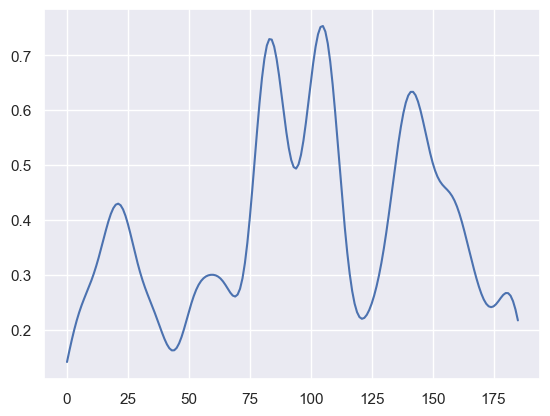

[1034, 1330]
[900]
5868
cuda
epoch 1,loss = 1.00000536
epoch 2,loss = 1.00000286
epoch 3,loss = 1.00000048
epoch 4,loss = 0.99999815
epoch 5,loss = 0.99999595
epoch 6,loss = 0.99999368
epoch 7,loss = 0.99999154
epoch 8,loss = 0.99998951
epoch 9,loss = 0.99998748
epoch 10,loss = 0.99998546
epoch 11,loss = 0.99998355
epoch 12,loss = 0.99998170
epoch 13,loss = 0.99997985
epoch 14,loss = 0.99997807
epoch 15,loss = 0.99997640
epoch 16,loss = 0.99997473
epoch 17,loss = 0.99997318
epoch 18,loss = 0.99997163
epoch 19,loss = 0.99997020
epoch 20,loss = 0.99996871
epoch 21,loss = 0.99996740
epoch 22,loss = 0.99996603
epoch 23,loss = 0.99996471
epoch 24,loss = 0.99996352
epoch 25,loss = 0.99996245
epoch 26,loss = 0.99996126
epoch 27,loss = 0.99996018
epoch 28,loss = 0.99995917
epoch 29,loss = 0.99995816
epoch 30,loss = 0.99995720
epoch 31,loss = 0.99995637
epoch 32,loss = 0.99995548
epoch 33,loss = 0.99995470
epoch 34,loss = 0.99995387
epoch 35,loss = 0.99995309
epoch 36,loss = 0.99995244
epoch 37

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 38,loss = 0.99995095
epoch 39,loss = 0.99995029
epoch 40,loss = 0.99994892
epoch 41,loss = 0.99993825
epoch 42,loss = 0.99993497
epoch 43,loss = 0.99993384
epoch 44,loss = 0.99993193
epoch 45,loss = 0.99993074
epoch 46,loss = 0.99992466
epoch 47,loss = 0.99991369
epoch 48,loss = 0.99990422
epoch 49,loss = 0.99989420
epoch 50,loss = 0.99988562
epoch 51,loss = 0.99987453
epoch 52,loss = 0.99985784
epoch 53,loss = 0.99984097
epoch 54,loss = 0.99982238
epoch 55,loss = 0.99980092
epoch 56,loss = 0.99977100
epoch 57,loss = 0.99974263
epoch 58,loss = 0.99970955
epoch 59,loss = 0.99966729
epoch 60,loss = 0.99963039
epoch 61,loss = 0.99958754
epoch 62,loss = 0.99955589
epoch 63,loss = 0.99952441
epoch 64,loss = 0.99950027
epoch 65,loss = 0.99947816
epoch 66,loss = 0.99945718
epoch 67,loss = 0.99942869
epoch 68,loss = 0.99939626
epoch 69,loss = 0.99935794
epoch 70,loss = 0.99931479
epoch 71,loss = 0.99927151
epoch 72,loss = 0.99922478
epoch 73,loss = 0.99918097
epoch 74,loss = 0.99913442
e

epoch 346,loss = 0.52225298
epoch 347,loss = 0.52192628
epoch 348,loss = 0.52160138
epoch 349,loss = 0.52127838
epoch 350,loss = 0.52095753
epoch 351,loss = 0.52063864
epoch 352,loss = 0.52032191
epoch 353,loss = 0.52000785
epoch 354,loss = 0.51969630
epoch 355,loss = 0.51938570
epoch 356,loss = 0.51907736
epoch 357,loss = 0.51877147
epoch 358,loss = 0.51846826
epoch 359,loss = 0.51816750
epoch 360,loss = 0.51786888
epoch 361,loss = 0.51757246
epoch 362,loss = 0.51727808
epoch 363,loss = 0.51698565
epoch 364,loss = 0.51669508
epoch 365,loss = 0.51640630
epoch 366,loss = 0.51611984
epoch 367,loss = 0.51583540
epoch 368,loss = 0.51555234
epoch 369,loss = 0.51527208
epoch 370,loss = 0.51499432
epoch 371,loss = 0.51471853
epoch 372,loss = 0.51444447
epoch 373,loss = 0.51417154
epoch 374,loss = 0.51389962
epoch 375,loss = 0.51362908
epoch 376,loss = 0.51336020
epoch 377,loss = 0.51309240
epoch 378,loss = 0.51282597
epoch 379,loss = 0.51256150
epoch 380,loss = 0.51229835
epoch 381,loss = 0.5

epoch 649,loss = 0.46110591
epoch 650,loss = 0.46098712
epoch 651,loss = 0.46086884
epoch 652,loss = 0.46075094
epoch 653,loss = 0.46063343
epoch 654,loss = 0.46051654
epoch 655,loss = 0.46040049
epoch 656,loss = 0.46028551
epoch 657,loss = 0.46017146
epoch 658,loss = 0.46005759
epoch 659,loss = 0.45994392
epoch 660,loss = 0.45983043
epoch 661,loss = 0.45971721
epoch 662,loss = 0.45960459
epoch 663,loss = 0.45949289
epoch 664,loss = 0.45938194
epoch 665,loss = 0.45927092
epoch 666,loss = 0.45915997
epoch 667,loss = 0.45904896
epoch 668,loss = 0.45893800
epoch 669,loss = 0.45882732
epoch 670,loss = 0.45871708
epoch 671,loss = 0.45860696
epoch 672,loss = 0.45849717
epoch 673,loss = 0.45838770
epoch 674,loss = 0.45827845
epoch 675,loss = 0.45816946
epoch 676,loss = 0.45806080
epoch 677,loss = 0.45795262
epoch 678,loss = 0.45784476
epoch 679,loss = 0.45773700
epoch 680,loss = 0.45762923
epoch 681,loss = 0.45752147
epoch 682,loss = 0.45741397
epoch 683,loss = 0.45730671
epoch 684,loss = 0.4

epoch 950,loss = 0.43545336
epoch 951,loss = 0.43538067
epoch 952,loss = 0.43530783
epoch 953,loss = 0.43523499
epoch 954,loss = 0.43516248
epoch 955,loss = 0.43509039
epoch 956,loss = 0.43501845
epoch 957,loss = 0.43494669
epoch 958,loss = 0.43487516
epoch 959,loss = 0.43480369
epoch 960,loss = 0.43473262
epoch 961,loss = 0.43466175
epoch 962,loss = 0.43459111
epoch 963,loss = 0.43452141
epoch 964,loss = 0.43445238
epoch 965,loss = 0.43438357
epoch 966,loss = 0.43431500
epoch 967,loss = 0.43424681
epoch 968,loss = 0.43417916
epoch 969,loss = 0.43411222
epoch 970,loss = 0.43404582
epoch 971,loss = 0.43397942
epoch 972,loss = 0.43391323
epoch 973,loss = 0.43384731
epoch 974,loss = 0.43378118
epoch 975,loss = 0.43371534
epoch 976,loss = 0.43364957
epoch 977,loss = 0.43358380
epoch 978,loss = 0.43351802
epoch 979,loss = 0.43345261
epoch 980,loss = 0.43338779
epoch 981,loss = 0.43332329
epoch 982,loss = 0.43325889
epoch 983,loss = 0.43319511
epoch 984,loss = 0.43313172
epoch 985,loss = 0.4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([731, 1, 20])
1.0
Epoch 200:   loss= 0.16881  cluster difference= 1.0
Epoch 400:   loss= 0.16961  cluster difference= 0.11080711354309165
Epoch 600:   loss= 0.17053  cluster difference= 0.038303693570451436
Epoch 800:   loss= 0.17125  cluster difference= 0.017783857729138167
Epoch 1000:   loss= 0.17158  cluster difference= 0.015047879616963064
Epoch 1200:   loss= 0.17166  cluster difference= 0.015047879616963064
Epoch 1400:   loss= 0.17159  cluster difference= 0.012311901504787962
Epoch 1600:   loss= 0.17142  cluster difference= 0.005471956224350205
[1 1 6 2 2 2 7 0 1 1 3 2 2 2 7 7 4 1 1 3 2 2 2 2 5 1 1 3 7 2 2 7 7 7 5 3 0
 1 6 3 2 0 4 6 7 2 2 0 6 7 4 1 6 3 2 2 2 7 0 1 1 6 3 2 2 2 7 5 1 1 3 2 2 2
 7 0 1 1 1 3 2 2 2 7 5 1 1 3 2 2 7 3 0 1 1 3 2 2 2 7 6 4 1 6 7 2 2 7 7 0 4
 1 6 6 2 2 2 2 0 1 1 6 2 2 2 7 7 4 1 6 3 2 2 7 3 5 1 6 3 2 2 0 6 0 1 6 4 6
 3 2 2 7 0 1 1 6 3 2 2 7 7 4 1 1 3 2 2 2 7 0 1 1 3 2 2 2 0 3 4 1 1 3 2 2 2
 7 0 1 1 3 2 2 2 7 7 4 1 3 2 2 2 0 3 0 1 1 6 3 2 2 2 7 5 1

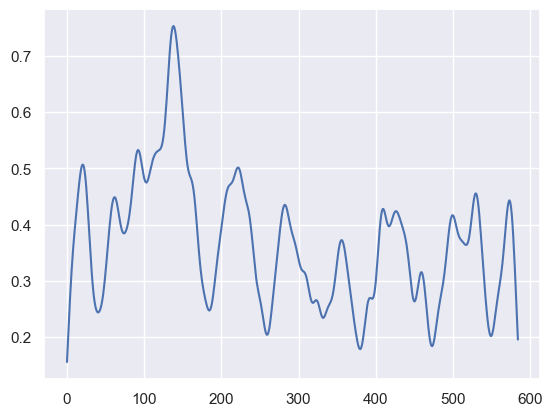

[1698]
[1228 3548]
4821
cuda
epoch 1,loss = 1.08027482
epoch 2,loss = 1.07835877
epoch 3,loss = 1.07646239
epoch 4,loss = 1.07458675
epoch 5,loss = 1.07273209
epoch 6,loss = 1.07089937
epoch 7,loss = 1.06908929
epoch 8,loss = 1.06730258
epoch 9,loss = 1.06553972
epoch 10,loss = 1.06380153
epoch 11,loss = 1.06208849
epoch 12,loss = 1.06040144
epoch 13,loss = 1.05874074
epoch 14,loss = 1.05710709
epoch 15,loss = 1.05550110
epoch 16,loss = 1.05392313
epoch 17,loss = 1.05237389
epoch 18,loss = 1.05085349
epoch 19,loss = 1.04936266
epoch 20,loss = 1.04790163
epoch 21,loss = 1.04647088
epoch 22,loss = 1.04507065
epoch 23,loss = 1.04370117
epoch 24,loss = 1.04236281
epoch 25,loss = 1.04105580
epoch 26,loss = 1.03978026
epoch 27,loss = 1.03853619
epoch 28,loss = 1.03732383
epoch 29,loss = 1.03614330
epoch 30,loss = 1.03499460


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 31,loss = 1.03387761
epoch 32,loss = 1.03279233
epoch 33,loss = 1.03173864
epoch 34,loss = 1.03071642
epoch 35,loss = 1.02972567
epoch 36,loss = 1.02876592
epoch 37,loss = 1.02783704
epoch 38,loss = 1.02693892
epoch 39,loss = 1.02607083
epoch 40,loss = 1.02523303
epoch 41,loss = 1.02442455
epoch 42,loss = 1.02364528
epoch 43,loss = 1.02289474
epoch 44,loss = 1.02217233
epoch 45,loss = 1.02147782
epoch 46,loss = 1.02081048
epoch 47,loss = 1.02016985
epoch 48,loss = 1.01955521
epoch 49,loss = 1.01896608
epoch 50,loss = 1.01840198
epoch 51,loss = 1.01786196
epoch 52,loss = 1.01735187
epoch 53,loss = 1.01685572
epoch 54,loss = 1.01638055
epoch 55,loss = 1.01592600
epoch 56,loss = 1.01549113
epoch 57,loss = 1.01507556
epoch 58,loss = 1.01467824
epoch 59,loss = 1.01429892
epoch 60,loss = 1.01393676
epoch 61,loss = 1.01359105
epoch 62,loss = 1.01326120
epoch 63,loss = 1.01294565
epoch 64,loss = 1.01266265
epoch 65,loss = 1.01239920
epoch 66,loss = 1.01212919
epoch 67,loss = 1.01190400
e

epoch 341,loss = 0.54048502
epoch 342,loss = 0.53678799
epoch 343,loss = 0.53322345
epoch 344,loss = 0.52978963
epoch 345,loss = 0.52648360
epoch 346,loss = 0.52329236
epoch 347,loss = 0.52021402
epoch 348,loss = 0.51724309
epoch 349,loss = 0.51437169
epoch 350,loss = 0.51159775
epoch 351,loss = 0.50892037
epoch 352,loss = 0.50632972
epoch 353,loss = 0.50381631
epoch 354,loss = 0.50138092
epoch 355,loss = 0.49902648
epoch 356,loss = 0.49675068
epoch 357,loss = 0.49454191
epoch 358,loss = 0.49240059
epoch 359,loss = 0.49031851
epoch 360,loss = 0.48829514
epoch 361,loss = 0.48633057
epoch 362,loss = 0.48443145
epoch 363,loss = 0.48258421
epoch 364,loss = 0.48078644
epoch 365,loss = 0.47903323
epoch 366,loss = 0.47731808
epoch 367,loss = 0.47564435
epoch 368,loss = 0.47401524
epoch 369,loss = 0.47242346
epoch 370,loss = 0.47086260
epoch 371,loss = 0.46932963
epoch 372,loss = 0.46782851
epoch 373,loss = 0.46636239
epoch 374,loss = 0.46493360
epoch 375,loss = 0.46353179
epoch 376,loss = 0.4

epoch 652,loss = 0.35967490
epoch 653,loss = 0.35947216
epoch 654,loss = 0.35926840
epoch 655,loss = 0.35906318
epoch 656,loss = 0.35885835
epoch 657,loss = 0.35865366
epoch 658,loss = 0.35844901
epoch 659,loss = 0.35824507
epoch 660,loss = 0.35804120
epoch 661,loss = 0.35783809
epoch 662,loss = 0.35763600
epoch 663,loss = 0.35743463
epoch 664,loss = 0.35723415
epoch 665,loss = 0.35703418
epoch 666,loss = 0.35683513
epoch 667,loss = 0.35663697
epoch 668,loss = 0.35643965
epoch 669,loss = 0.35624340
epoch 670,loss = 0.35604799
epoch 671,loss = 0.35585302
epoch 672,loss = 0.35565862
epoch 673,loss = 0.35546499
epoch 674,loss = 0.35527205
epoch 675,loss = 0.35507813
epoch 676,loss = 0.35487977
epoch 677,loss = 0.35468176
epoch 678,loss = 0.35448518
epoch 679,loss = 0.35428891
epoch 680,loss = 0.35409278
epoch 681,loss = 0.35389727
epoch 682,loss = 0.35370201
epoch 683,loss = 0.35350546
epoch 684,loss = 0.35330918
epoch 685,loss = 0.35311240
epoch 686,loss = 0.35291448
epoch 687,loss = 0.3

epoch 955,loss = 0.30827916
epoch 956,loss = 0.30814955
epoch 957,loss = 0.30801991
epoch 958,loss = 0.30789080
epoch 959,loss = 0.30776212
epoch 960,loss = 0.30763373
epoch 961,loss = 0.30750567
epoch 962,loss = 0.30737799
epoch 963,loss = 0.30725101
epoch 964,loss = 0.30712485
epoch 965,loss = 0.30699885
epoch 966,loss = 0.30687329
epoch 967,loss = 0.30674818
epoch 968,loss = 0.30662382
epoch 969,loss = 0.30650070
epoch 970,loss = 0.30637807
epoch 971,loss = 0.30625510
epoch 972,loss = 0.30613196
epoch 973,loss = 0.30600840
epoch 974,loss = 0.30588457
epoch 975,loss = 0.30576110
epoch 976,loss = 0.30563781
epoch 977,loss = 0.30551469
epoch 978,loss = 0.30539188
epoch 979,loss = 0.30526924
epoch 980,loss = 0.30514678
epoch 981,loss = 0.30502445
epoch 982,loss = 0.30490220
epoch 983,loss = 0.30478007
epoch 984,loss = 0.30465817
epoch 985,loss = 0.30453652
epoch 986,loss = 0.30441517
epoch 987,loss = 0.30429402
epoch 988,loss = 0.30417305
epoch 989,loss = 0.30405223
epoch 990,loss = 0.3

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([601, 1, 20])
1.0
Epoch 200:   loss= 0.14901  cluster difference= 1.0
Epoch 400:   loss= 0.15167  cluster difference= 0.026622296173044926
Epoch 600:   loss= 0.15302  cluster difference= 0.021630615640599003
Epoch 800:   loss= 0.15387  cluster difference= 0.03161397670549085
Epoch 1000:   loss= 0.15446  cluster difference= 0.026622296173044926
Epoch 1200:   loss= 0.15492  cluster difference= 0.019966722129783693
Epoch 1400:   loss= 0.15531  cluster difference= 0.009983361064891847
[5 5 5 5 5 0 2 1 1 1 4 5 0 3 6 3 3 3 3 5 5 5 5 5 0 0 2 1 6 4 5 5 5 5 5 0 0
 2 1 1 1 4 5 0 0 5 5 2 1 1 1 6 6 4 0 0 0 7 4 5 5 3 3 5 0 0 0 7 1 1 6 3 3 3
 5 5 5 5 5 0 0 2 1 1 1 4 3 4 5 5 5 5 5 0 0 0 7 1 1 1 4 3 4 5 5 5 5 5 0 0 2
 1 1 1 6 3 3 5 5 0 0 0 5 2 6 1 1 4 5 0 7 4 3 5 0 0 0 0 2 1 1 1 6 5 5 5 0 0
 5 5 5 0 0 2 1 6 4 3 7 6 5 0 0 5 5 3 3 5 2 1 1 4 5 5 5 5 0 0 5 5 5 5 0 2 1
 1 1 4 5 5 2 6 4 3 5 0 0 0 7 1 1 6 5 0 5 0 0 5 5 5 3 5 2 1 1 4 3 5 5 3 5 0
 5 5 5 0 0 2 1 1 4 3 2 6 5 0 5 5 3 3 5 2 1 1 4 5 5 5 

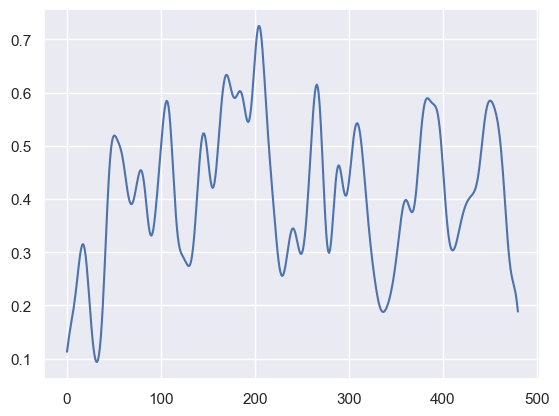

[2122, 2618]
[1058 2704]
1280
cuda
epoch 1,loss = 1.03621566
epoch 2,loss = 1.03619170
epoch 3,loss = 1.03616786
epoch 4,loss = 1.03614414
epoch 5,loss = 1.03612065
epoch 6,loss = 1.03609729
epoch 7,loss = 1.03607416
epoch 8,loss = 1.03605127
epoch 9,loss = 1.03602850
epoch 10,loss = 1.03600597
epoch 11,loss = 1.03598356
epoch 12,loss = 1.03596151
epoch 13,loss = 1.03593957
epoch 14,loss = 1.03591776
epoch 15,loss = 1.03589606
epoch 16,loss = 1.03587472
epoch 17,loss = 1.03585362
epoch 18,loss = 1.03583264
epoch 19,loss = 1.03581178
epoch 20,loss = 1.03579116
epoch 21,loss = 1.03577065
epoch 22,loss = 1.03575039
epoch 23,loss = 1.03573024
epoch 24,loss = 1.03571033
epoch 25,loss = 1.03569055
epoch 26,loss = 1.03567100
epoch 27,loss = 1.03565145
epoch 28,loss = 1.03563225
epoch 29,loss = 1.03561306
epoch 30,loss = 1.03559399
epoch 31,loss = 1.03557503
epoch 32,loss = 1.03555620
epoch 33,loss = 1.03553748
epoch 34,loss = 1.03551888
epoch 35,loss = 1.03550041
epoch 36,loss = 1.03548193
ep

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 65,loss = 1.03492010
epoch 66,loss = 1.03489792
epoch 67,loss = 1.03487539
epoch 68,loss = 1.03485262
epoch 69,loss = 1.03482950
epoch 70,loss = 1.03480601
epoch 71,loss = 1.03478229
epoch 72,loss = 1.03475821
epoch 73,loss = 1.03473377
epoch 74,loss = 1.03470910
epoch 75,loss = 1.03468394
epoch 76,loss = 1.03465843
epoch 77,loss = 1.03463256
epoch 78,loss = 1.03460634
epoch 79,loss = 1.03457975
epoch 80,loss = 1.03455281
epoch 81,loss = 1.03452551
epoch 82,loss = 1.03449774
epoch 83,loss = 1.03446960
epoch 84,loss = 1.03444111
epoch 85,loss = 1.03441215
epoch 86,loss = 1.03438282
epoch 87,loss = 1.03435302
epoch 88,loss = 1.03432298
epoch 89,loss = 1.03429234
epoch 90,loss = 1.03426135
epoch 91,loss = 1.03422987
epoch 92,loss = 1.03419805
epoch 93,loss = 1.03416574
epoch 94,loss = 1.03413308
epoch 95,loss = 1.03409994
epoch 96,loss = 1.03406632
epoch 97,loss = 1.03403234
epoch 98,loss = 1.03399789
epoch 99,loss = 1.03396308
epoch 100,loss = 1.03392756
epoch 101,loss = 1.03389180

epoch 401,loss = 0.76562309
epoch 402,loss = 0.76541549
epoch 403,loss = 0.76520765
epoch 404,loss = 0.76499707
epoch 405,loss = 0.76478642
epoch 406,loss = 0.76457477
epoch 407,loss = 0.76436043
epoch 408,loss = 0.76414293
epoch 409,loss = 0.76391447
epoch 410,loss = 0.76368392
epoch 411,loss = 0.76345336
epoch 412,loss = 0.76322222
epoch 413,loss = 0.76299369
epoch 414,loss = 0.76277286
epoch 415,loss = 0.76255703
epoch 416,loss = 0.76234394
epoch 417,loss = 0.76212972
epoch 418,loss = 0.76191127
epoch 419,loss = 0.76169062
epoch 420,loss = 0.76147258
epoch 421,loss = 0.76125675
epoch 422,loss = 0.76104426
epoch 423,loss = 0.76083118
epoch 424,loss = 0.76062113
epoch 425,loss = 0.76041186
epoch 426,loss = 0.76020306
epoch 427,loss = 0.75999522
epoch 428,loss = 0.75978446
epoch 429,loss = 0.75957388
epoch 430,loss = 0.75936341
epoch 431,loss = 0.75914979
epoch 432,loss = 0.75893617
epoch 433,loss = 0.75872099
epoch 434,loss = 0.75850028
epoch 435,loss = 0.75827920
epoch 436,loss = 0.7

epoch 724,loss = 0.70888323
epoch 725,loss = 0.70883310
epoch 726,loss = 0.70878321
epoch 727,loss = 0.70873266
epoch 728,loss = 0.70868099
epoch 729,loss = 0.70862806
epoch 730,loss = 0.70857477
epoch 731,loss = 0.70852131
epoch 732,loss = 0.70846766
epoch 733,loss = 0.70841342
epoch 734,loss = 0.70835918
epoch 735,loss = 0.70830470
epoch 736,loss = 0.70825040
epoch 737,loss = 0.70819539
epoch 738,loss = 0.70814085
epoch 739,loss = 0.70808709
epoch 740,loss = 0.70803344
epoch 741,loss = 0.70797914
epoch 742,loss = 0.70792532
epoch 743,loss = 0.70787174
epoch 744,loss = 0.70781851
epoch 745,loss = 0.70776558
epoch 746,loss = 0.70771301
epoch 747,loss = 0.70766068
epoch 748,loss = 0.70760870
epoch 749,loss = 0.70755690
epoch 750,loss = 0.70750517
epoch 751,loss = 0.70745379
epoch 752,loss = 0.70740318
epoch 753,loss = 0.70735294
epoch 754,loss = 0.70730323
epoch 755,loss = 0.70725399
epoch 756,loss = 0.70720541
epoch 757,loss = 0.70715618
epoch 758,loss = 0.70710588
epoch 759,loss = 0.7

epoch 1035,loss = 0.69469792
epoch 1036,loss = 0.69466639
epoch 1037,loss = 0.69463438
epoch 1038,loss = 0.69460243
epoch 1039,loss = 0.69457084
epoch 1040,loss = 0.69453913
epoch 1041,loss = 0.69450724
epoch 1042,loss = 0.69447565
epoch 1043,loss = 0.69444436
epoch 1044,loss = 0.69441313
epoch 1045,loss = 0.69438207
epoch 1046,loss = 0.69434971
epoch 1047,loss = 0.69431639
epoch 1048,loss = 0.69428271
epoch 1049,loss = 0.69424897
epoch 1050,loss = 0.69421524
epoch 1051,loss = 0.69418186
epoch 1052,loss = 0.69414872
epoch 1053,loss = 0.69411588
epoch 1054,loss = 0.69408327
epoch 1055,loss = 0.69405103
epoch 1056,loss = 0.69401896
epoch 1057,loss = 0.69398695
epoch 1058,loss = 0.69395506
epoch 1059,loss = 0.69392335
epoch 1060,loss = 0.69389153
epoch 1061,loss = 0.69385999
epoch 1062,loss = 0.69382912
epoch 1063,loss = 0.69379938
epoch 1064,loss = 0.69376957
epoch 1065,loss = 0.69373965
epoch 1066,loss = 0.69371021
epoch 1067,loss = 0.69368088
epoch 1068,loss = 0.69365156
epoch 1069,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([158, 1, 20])
1.0
Epoch 200:   loss= 0.22714  cluster difference= 1.0
Epoch 400:   loss= 0.22524  cluster difference= 0.006329113924050633
[0 4 0 4 0 4 0 1 5 4 0 3 5 3 2 3 5 4 0 4 5 3 2 4 0 4 0 4 5 4 0 4 0 4 0 4 0
 1 5 5 3 5 3 5 3 6 3 2 3 2 3 6 3 6 3 2 3 1 6 5 3 6 1 2 7 6 1 6 3 4 0 6 3 6
 3 2 3 1 3 5 3 5 3 2 3 1 7 5 3 5 3 2 7 2 3 5 3 5 3 1 7 5 3 5 3 5 3 5 3 2 3
 5 3 2 3 5 3 5 3 6 3 5 3 4 0 2 3 2 3 4 0 4 0 2 3 4 0 6 3 2 3 2 3 4 0 4 0 4
 0 4 0 2 3 4 0 1 1 4]


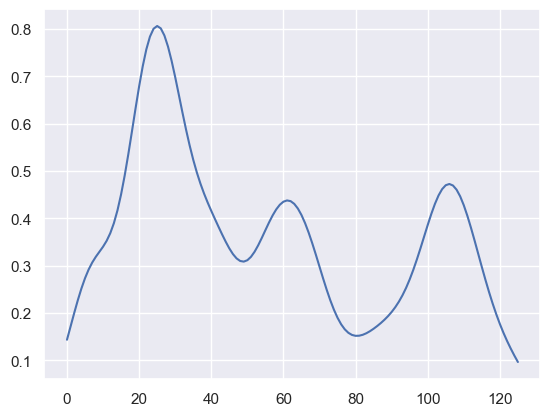

[338]
[320 640 960]
1608
cuda
epoch 1,loss = 1.03552663
epoch 2,loss = 1.03502095
epoch 3,loss = 1.03452194
epoch 4,loss = 1.03402972
epoch 5,loss = 1.03354442
epoch 6,loss = 1.03306592
epoch 7,loss = 1.03259456
epoch 8,loss = 1.03213036
epoch 9,loss = 1.03167319
epoch 10,loss = 1.03122318
epoch 11,loss = 1.03078032
epoch 12,loss = 1.03034484
epoch 13,loss = 1.02991652
epoch 14,loss = 1.02949548
epoch 15,loss = 1.02908158
epoch 16,loss = 1.02867508
epoch 17,loss = 1.02827561
epoch 18,loss = 1.02788353
epoch 19,loss = 1.02749848
epoch 20,loss = 1.02712035
epoch 21,loss = 1.02674925
epoch 22,loss = 1.02638495
epoch 23,loss = 1.02602732
epoch 24,loss = 1.02567637
epoch 25,loss = 1.02533197
epoch 26,loss = 1.02499378
epoch 27,loss = 1.02466178
epoch 28,loss = 1.02433586
epoch 29,loss = 1.02401602
epoch 30,loss = 1.02370203
epoch 31,loss = 1.02339375
epoch 32,loss = 1.02309120
epoch 33,loss = 1.02279437
epoch 34,loss = 1.02250290
epoch 35,loss = 1.02221656
epoch 36,loss = 1.02193546
epoch 3

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 50,loss = 1.01845610
epoch 51,loss = 1.01823378
epoch 52,loss = 1.01801336
epoch 53,loss = 1.01779473
epoch 54,loss = 1.01757717
epoch 55,loss = 1.01735806
epoch 56,loss = 1.01713490
epoch 57,loss = 1.01690400
epoch 58,loss = 1.01666319
epoch 59,loss = 1.01641595
epoch 60,loss = 1.01616657
epoch 61,loss = 1.01591480
epoch 62,loss = 1.01566136
epoch 63,loss = 1.01540613
epoch 64,loss = 1.01514995
epoch 65,loss = 1.01489317
epoch 66,loss = 1.01463401
epoch 67,loss = 1.01437449
epoch 68,loss = 1.01411366
epoch 69,loss = 1.01385033
epoch 70,loss = 1.01358509
epoch 71,loss = 1.01332057
epoch 72,loss = 1.01305783
epoch 73,loss = 1.01283550
epoch 74,loss = 1.01267743
epoch 75,loss = 1.01253057
epoch 76,loss = 1.01237607
epoch 77,loss = 1.01221621
epoch 78,loss = 1.01205587
epoch 79,loss = 1.01189291
epoch 80,loss = 1.01172698
epoch 81,loss = 1.01156116
epoch 82,loss = 1.01139688
epoch 83,loss = 1.01123190
epoch 84,loss = 1.01106691
epoch 85,loss = 1.01090109
epoch 86,loss = 1.01073575
e

epoch 363,loss = 0.76982582
epoch 364,loss = 0.76956862
epoch 365,loss = 0.76931632
epoch 366,loss = 0.76907092
epoch 367,loss = 0.76883006
epoch 368,loss = 0.76859826
epoch 369,loss = 0.76837075
epoch 370,loss = 0.76815116
epoch 371,loss = 0.76794076
epoch 372,loss = 0.76773751
epoch 373,loss = 0.76753724
epoch 374,loss = 0.76734000
epoch 375,loss = 0.76714551
epoch 376,loss = 0.76695454
epoch 377,loss = 0.76676822
epoch 378,loss = 0.76658571
epoch 379,loss = 0.76640737
epoch 380,loss = 0.76623273
epoch 381,loss = 0.76606107
epoch 382,loss = 0.76589280
epoch 383,loss = 0.76572770
epoch 384,loss = 0.76556540
epoch 385,loss = 0.76540589
epoch 386,loss = 0.76524919
epoch 387,loss = 0.76509613
epoch 388,loss = 0.76494509
epoch 389,loss = 0.76479650
epoch 390,loss = 0.76465058
epoch 391,loss = 0.76450831
epoch 392,loss = 0.76436800
epoch 393,loss = 0.76423019
epoch 394,loss = 0.76409465
epoch 395,loss = 0.76396269
epoch 396,loss = 0.76383412
epoch 397,loss = 0.76370806
epoch 398,loss = 0.7

epoch 672,loss = 0.75385720
epoch 673,loss = 0.75382233
epoch 674,loss = 0.75378752
epoch 675,loss = 0.75375289
epoch 676,loss = 0.75371832
epoch 677,loss = 0.75368375
epoch 678,loss = 0.75364935
epoch 679,loss = 0.75361514
epoch 680,loss = 0.75358099
epoch 681,loss = 0.75354695
epoch 682,loss = 0.75351304
epoch 683,loss = 0.75347918
epoch 684,loss = 0.75344557
epoch 685,loss = 0.75341219
epoch 686,loss = 0.75337911
epoch 687,loss = 0.75334609
epoch 688,loss = 0.75331283
epoch 689,loss = 0.75327957
epoch 690,loss = 0.75324649
epoch 691,loss = 0.75321329
epoch 692,loss = 0.75318021
epoch 693,loss = 0.75314713
epoch 694,loss = 0.75311404
epoch 695,loss = 0.75308108
epoch 696,loss = 0.75304812
epoch 697,loss = 0.75301528
epoch 698,loss = 0.75298238
epoch 699,loss = 0.75294954
epoch 700,loss = 0.75291675
epoch 701,loss = 0.75288415
epoch 702,loss = 0.75285178
epoch 703,loss = 0.75281954
epoch 704,loss = 0.75278735
epoch 705,loss = 0.75275534
epoch 706,loss = 0.75272369
epoch 707,loss = 0.7

epoch 980,loss = 0.74619645
epoch 981,loss = 0.74617732
epoch 982,loss = 0.74615812
epoch 983,loss = 0.74613899
epoch 984,loss = 0.74611992
epoch 985,loss = 0.74610084
epoch 986,loss = 0.74608183
epoch 987,loss = 0.74606282
epoch 988,loss = 0.74604392
epoch 989,loss = 0.74602497
epoch 990,loss = 0.74600613
epoch 991,loss = 0.74598724
epoch 992,loss = 0.74596846
epoch 993,loss = 0.74594957
epoch 994,loss = 0.74593079
epoch 995,loss = 0.74591219
epoch 996,loss = 0.74589342
epoch 997,loss = 0.74587470
epoch 998,loss = 0.74585611
epoch 999,loss = 0.74583757
epoch 1000,loss = 0.74581903
epoch 1001,loss = 0.74580067
epoch 1002,loss = 0.74578220
epoch 1003,loss = 0.74576372
epoch 1004,loss = 0.74574542
epoch 1005,loss = 0.74572706
epoch 1006,loss = 0.74570876
epoch 1007,loss = 0.74569058
epoch 1008,loss = 0.74567246
epoch 1009,loss = 0.74565428
epoch 1010,loss = 0.74563599
epoch 1011,loss = 0.74561787
epoch 1012,loss = 0.74559957
epoch 1013,loss = 0.74558127
epoch 1014,loss = 0.74556297
epoch

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([199, 1, 20])
1.0
Epoch 200:   loss= 0.21502  cluster difference= 1.0
Epoch 400:   loss= 0.21371  cluster difference= 0.005025125628140704
[7 3 2 1 6 2 1 3 0 6 4 2 1 3 2 1 3 2 1 6 2 1 3 2 1 6 0 7 3 0 7 3 2 1 3 2 1
 3 2 1 6 2 7 3 2 1 6 2 3 6 2 1 6 2 1 6 2 1 3 0 7 3 2 1 3 2 1 6 0 7 3 2 1 3
 2 1 3 2 3 6 2 1 6 2 3 6 2 1 3 0 7 3 2 1 3 2 1 6 2 1 1 5 0 4 2 1 5 2 3 5 2
 1 5 2 1 5 2 1 5 0 6 4 2 1 5 2 1 5 2 1 5 2 1 5 0 6 4 2 1 5 2 3 5 2 1 5 2 3
 5 2 1 5 2 1 5 2 3 5 2 1 5 0 6 4 2 1 5 0 6 4 2 3 5 2 1 5 2 3 5 2 1 6 2 1 5
 0 6 4 2 1 5 2 1 5 2 1 5 0 6]


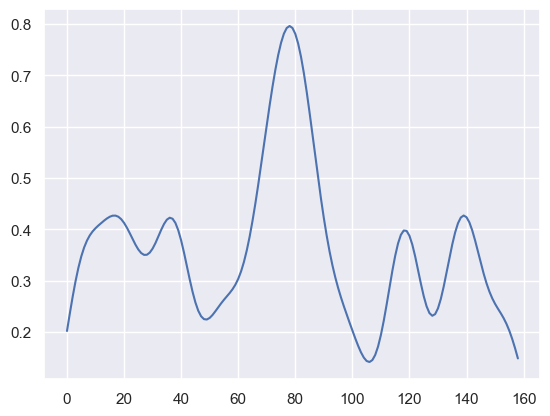

[794]
[816]
8436
cuda
epoch 1,loss = 0.98920822
epoch 2,loss = 0.98915827
epoch 3,loss = 0.98911774
epoch 4,loss = 0.98908061
epoch 5,loss = 0.98904580
epoch 6,loss = 0.98901290
epoch 7,loss = 0.98898166
epoch 8,loss = 0.98895222
epoch 9,loss = 0.98892748
epoch 10,loss = 0.98890382
epoch 11,loss = 0.98888701
epoch 12,loss = 0.98888010
epoch 13,loss = 0.98887372
epoch 14,loss = 0.98886794
epoch 15,loss = 0.98886240
epoch 16,loss = 0.98885739
epoch 17,loss = 0.98885250
epoch 18,loss = 0.98884803
epoch 19,loss = 0.98884374
epoch 20,loss = 0.98883963
epoch 21,loss = 0.98883569
epoch 22,loss = 0.98883206
epoch 23,loss = 0.98882842
epoch 24,loss = 0.98882496
epoch 25,loss = 0.98882169
epoch 26,loss = 0.98881853
epoch 27,loss = 0.98881549
epoch 28,loss = 0.98881251
epoch 29,loss = 0.98880970
epoch 30,loss = 0.98880690
epoch 31,loss = 0.98880422
epoch 32,loss = 0.98880160
epoch 33,loss = 0.98879915
epoch 34,loss = 0.98879671
epoch 35,loss = 0.98879433
epoch 36,loss = 0.98879206
epoch 37,loss =

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 46,loss = 0.98877215
epoch 47,loss = 0.98877048
epoch 48,loss = 0.98876882
epoch 49,loss = 0.98876709
epoch 50,loss = 0.98876554
epoch 51,loss = 0.98876405
epoch 52,loss = 0.98876244
epoch 53,loss = 0.98876047
epoch 54,loss = 0.98875850
epoch 55,loss = 0.98875648
epoch 56,loss = 0.98875457
epoch 57,loss = 0.98875260
epoch 58,loss = 0.98875064
epoch 59,loss = 0.98874879
epoch 60,loss = 0.98874682
epoch 61,loss = 0.98874485
epoch 62,loss = 0.98874271
epoch 63,loss = 0.98874068
epoch 64,loss = 0.98873872
epoch 65,loss = 0.98873675
epoch 66,loss = 0.98873484
epoch 67,loss = 0.98873311
epoch 68,loss = 0.98873132
epoch 69,loss = 0.98872966
epoch 70,loss = 0.98872811
epoch 71,loss = 0.98872662
epoch 72,loss = 0.98872524
epoch 73,loss = 0.98872381
epoch 74,loss = 0.98872250
epoch 75,loss = 0.98872197
epoch 76,loss = 0.98872161
epoch 77,loss = 0.98872077
epoch 78,loss = 0.98871970
epoch 79,loss = 0.98871839
epoch 80,loss = 0.98871690
epoch 81,loss = 0.98871583
epoch 82,loss = 0.98871505
e

epoch 374,loss = 0.84372091
epoch 375,loss = 0.84324932
epoch 376,loss = 0.84278566
epoch 377,loss = 0.84231180
epoch 378,loss = 0.84184939
epoch 379,loss = 0.84139764
epoch 380,loss = 0.84093535
epoch 381,loss = 0.84046578
epoch 382,loss = 0.84000218
epoch 383,loss = 0.83954358
epoch 384,loss = 0.83908325
epoch 385,loss = 0.83862096
epoch 386,loss = 0.83817565
epoch 387,loss = 0.83775645
epoch 388,loss = 0.83733177
epoch 389,loss = 0.83690435
epoch 390,loss = 0.83647692
epoch 391,loss = 0.83604836
epoch 392,loss = 0.83561867
epoch 393,loss = 0.83519608
epoch 394,loss = 0.83477432
epoch 395,loss = 0.83435810
epoch 396,loss = 0.83393800
epoch 397,loss = 0.83351135
epoch 398,loss = 0.83308595
epoch 399,loss = 0.83265644
epoch 400,loss = 0.83222330
epoch 401,loss = 0.83178782
epoch 402,loss = 0.83135730
epoch 403,loss = 0.83092123
epoch 404,loss = 0.83048892
epoch 405,loss = 0.83005887
epoch 406,loss = 0.82962638
epoch 407,loss = 0.82919425
epoch 408,loss = 0.82875055
epoch 409,loss = 0.8

epoch 703,loss = 0.79500133
epoch 704,loss = 0.79497868
epoch 705,loss = 0.79495573
epoch 706,loss = 0.79493272
epoch 707,loss = 0.79491007
epoch 708,loss = 0.79488748
epoch 709,loss = 0.79486495
epoch 710,loss = 0.79484242
epoch 711,loss = 0.79481947
epoch 712,loss = 0.79479533
epoch 713,loss = 0.79476917
epoch 714,loss = 0.79474330
epoch 715,loss = 0.79471910
epoch 716,loss = 0.79469573
epoch 717,loss = 0.79467177
epoch 718,loss = 0.79464835
epoch 719,loss = 0.79462564
epoch 720,loss = 0.79460359
epoch 721,loss = 0.79458040
epoch 722,loss = 0.79455602
epoch 723,loss = 0.79453164
epoch 724,loss = 0.79450679
epoch 725,loss = 0.79448068
epoch 726,loss = 0.79445481
epoch 727,loss = 0.79442930
epoch 728,loss = 0.79440248
epoch 729,loss = 0.79437596
epoch 730,loss = 0.79434919
epoch 731,loss = 0.79432434
epoch 732,loss = 0.79429978
epoch 733,loss = 0.79427367
epoch 734,loss = 0.79424727
epoch 735,loss = 0.79422176
epoch 736,loss = 0.79419649
epoch 737,loss = 0.79417127
epoch 738,loss = 0.7

epoch 1006,loss = 0.79046911
epoch 1007,loss = 0.79045904
epoch 1008,loss = 0.79044873
epoch 1009,loss = 0.79043865
epoch 1010,loss = 0.79042906
epoch 1011,loss = 0.79041922
epoch 1012,loss = 0.79040903
epoch 1013,loss = 0.79039794
epoch 1014,loss = 0.79038680
epoch 1015,loss = 0.79037625
epoch 1016,loss = 0.79036593
epoch 1017,loss = 0.79035604
epoch 1018,loss = 0.79034632
epoch 1019,loss = 0.79033715
epoch 1020,loss = 0.79032803
epoch 1021,loss = 0.79031849
epoch 1022,loss = 0.79030859
epoch 1023,loss = 0.79029828
epoch 1024,loss = 0.79028726
epoch 1025,loss = 0.79027683
epoch 1026,loss = 0.79026663
epoch 1027,loss = 0.79025644
epoch 1028,loss = 0.79024607
epoch 1029,loss = 0.79023576
epoch 1030,loss = 0.79022515
epoch 1031,loss = 0.79021370
epoch 1032,loss = 0.79020250
epoch 1033,loss = 0.79019183
epoch 1034,loss = 0.79018044
epoch 1035,loss = 0.79016852
epoch 1036,loss = 0.79015642
epoch 1037,loss = 0.79014343
epoch 1038,loss = 0.79012907
epoch 1039,loss = 0.79011357
epoch 1040,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([209, 1, 100])
1.0
Epoch 200:   loss= 0.20639  cluster difference= 1.0
Epoch 400:   loss= 0.21005  cluster difference= 0.009569377990430622
[4 1 1 0 7 4 1 1 4 5 4 5 7 3 6 7 7 3 6 4 5 7 4 5 7 2 7 4 1 1 3 6 7 7 0 3 4
 5 1 0 4 5 7 7 7 7 4 1 0 3 6 7 7 3 6 3 6 7 7 4 5 1 0 7 4 5 7 3 6 7 7 2 2 5
 0 7 1 0 7 7 4 5 7 1 3 6 7 2 5 0 4 5 7 7 7 7 7 4 5 1 0 1 7 7 7 3 6 0 7 4 5
 7 3 6 7 1 0 7 0 6 7 7 7 7 2 6 1 0 3 4 5 2 7 2 4 5 7 7 2 3 6 5 3 6 7 7 3 6
 4 5 1 2 7 2 5 3 3 6 4 5 3 6 4 5 7 4 5 7 7 7 4 5 2 0 3 6 6 0 5 3 6 2 7 0 7
 7 1 0 0 4 5 3 6 3 6 7 7 0 7 7 7 7 3 6 1 3 6 5 5]


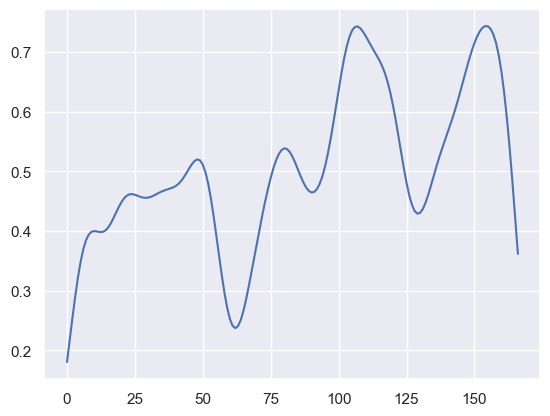

[5170, 7050]
[2812 5624]
1194
cuda
epoch 1,loss = 0.99930191
epoch 2,loss = 0.99924880
epoch 3,loss = 0.99919516
epoch 4,loss = 0.99914140
epoch 5,loss = 0.99908674
epoch 6,loss = 0.99903041
epoch 7,loss = 0.99897319
epoch 8,loss = 0.99891567
epoch 9,loss = 0.99885803
epoch 10,loss = 0.99879974
epoch 11,loss = 0.99874067
epoch 12,loss = 0.99868047
epoch 13,loss = 0.99861902
epoch 14,loss = 0.99855673
epoch 15,loss = 0.99849379
epoch 16,loss = 0.99842978
epoch 17,loss = 0.99836475
epoch 18,loss = 0.99828565
epoch 19,loss = 0.99818891
epoch 20,loss = 0.99808508
epoch 21,loss = 0.99795687
epoch 22,loss = 0.99776953
epoch 23,loss = 0.99753022
epoch 24,loss = 0.99723220
epoch 25,loss = 0.99688083
epoch 26,loss = 0.99648291
epoch 27,loss = 0.99602556
epoch 28,loss = 0.99551380
epoch 29,loss = 0.99496025
epoch 30,loss = 0.99433744
epoch 31,loss = 0.99365270
epoch 32,loss = 0.99284452
epoch 33,loss = 0.99193347
epoch 34,loss = 0.99094337
epoch 35,loss = 0.98990959
epoch 36,loss = 0.98878783
ep

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 66,loss = 0.94349456
epoch 67,loss = 0.94206595
epoch 68,loss = 0.94069928
epoch 69,loss = 0.93937892
epoch 70,loss = 0.93810362
epoch 71,loss = 0.93686384
epoch 72,loss = 0.93567228
epoch 73,loss = 0.93452567
epoch 74,loss = 0.93342322
epoch 75,loss = 0.93234581
epoch 76,loss = 0.93130100
epoch 77,loss = 0.93028855
epoch 78,loss = 0.92931402
epoch 79,loss = 0.92837644
epoch 80,loss = 0.92746717
epoch 81,loss = 0.92658943
epoch 82,loss = 0.92573941
epoch 83,loss = 0.92491317
epoch 84,loss = 0.92410833
epoch 85,loss = 0.92332143
epoch 86,loss = 0.92255187
epoch 87,loss = 0.92179698
epoch 88,loss = 0.92105615
epoch 89,loss = 0.92033172
epoch 90,loss = 0.91962159
epoch 91,loss = 0.91892308
epoch 92,loss = 0.91823381
epoch 93,loss = 0.91755098
epoch 94,loss = 0.91687614
epoch 95,loss = 0.91620553
epoch 96,loss = 0.91554129
epoch 97,loss = 0.91488057
epoch 98,loss = 0.91422230
epoch 99,loss = 0.91356915
epoch 100,loss = 0.91291887
epoch 101,loss = 0.91227561
epoch 102,loss = 0.9116332

epoch 385,loss = 0.69493133
epoch 386,loss = 0.69384235
epoch 387,loss = 0.69281125
epoch 388,loss = 0.69181979
epoch 389,loss = 0.69087416
epoch 390,loss = 0.68997997
epoch 391,loss = 0.68912476
epoch 392,loss = 0.68825877
epoch 393,loss = 0.68742913
epoch 394,loss = 0.68664569
epoch 395,loss = 0.68589664
epoch 396,loss = 0.68515694
epoch 397,loss = 0.68442822
epoch 398,loss = 0.68371367
epoch 399,loss = 0.68302536
epoch 400,loss = 0.68235719
epoch 401,loss = 0.68171042
epoch 402,loss = 0.68108380
epoch 403,loss = 0.68047500
epoch 404,loss = 0.67986745
epoch 405,loss = 0.67928106
epoch 406,loss = 0.67871809
epoch 407,loss = 0.67818040
epoch 408,loss = 0.67765516
epoch 409,loss = 0.67713779
epoch 410,loss = 0.67663956
epoch 411,loss = 0.67615831
epoch 412,loss = 0.67569309
epoch 413,loss = 0.67524338
epoch 414,loss = 0.67480993
epoch 415,loss = 0.67438817
epoch 416,loss = 0.67396748
epoch 417,loss = 0.67355895
epoch 418,loss = 0.67316306
epoch 419,loss = 0.67277831
epoch 420,loss = 0.6

epoch 719,loss = 0.63267440
epoch 720,loss = 0.63259810
epoch 721,loss = 0.63251632
epoch 722,loss = 0.63243419
epoch 723,loss = 0.63235039
epoch 724,loss = 0.63225919
epoch 725,loss = 0.63215482
epoch 726,loss = 0.63204736
epoch 727,loss = 0.63193536
epoch 728,loss = 0.63181370
epoch 729,loss = 0.63168991
epoch 730,loss = 0.63156223
epoch 731,loss = 0.63142771
epoch 732,loss = 0.63128769
epoch 733,loss = 0.63112539
epoch 734,loss = 0.63095373
epoch 735,loss = 0.63078064
epoch 736,loss = 0.63060534
epoch 737,loss = 0.63043052
epoch 738,loss = 0.63025671
epoch 739,loss = 0.63008434
epoch 740,loss = 0.62991321
epoch 741,loss = 0.62974489
epoch 742,loss = 0.62958020
epoch 743,loss = 0.62941611
epoch 744,loss = 0.62925094
epoch 745,loss = 0.62908572
epoch 746,loss = 0.62891865
epoch 747,loss = 0.62875414
epoch 748,loss = 0.62859416
epoch 749,loss = 0.62843078
epoch 750,loss = 0.62826848
epoch 751,loss = 0.62811005
epoch 752,loss = 0.62794799
epoch 753,loss = 0.62778395
epoch 754,loss = 0.6

epoch 1064,loss = 0.60573584
epoch 1065,loss = 0.60570192
epoch 1066,loss = 0.60566807
epoch 1067,loss = 0.60563427
epoch 1068,loss = 0.60560036
epoch 1069,loss = 0.60556668
epoch 1070,loss = 0.60553318
epoch 1071,loss = 0.60549974
epoch 1072,loss = 0.60546643
epoch 1073,loss = 0.60543323
epoch 1074,loss = 0.60540026
epoch 1075,loss = 0.60536742
epoch 1076,loss = 0.60533482
epoch 1077,loss = 0.60530233
epoch 1078,loss = 0.60526985
epoch 1079,loss = 0.60523748
epoch 1080,loss = 0.60520518
epoch 1081,loss = 0.60517311
epoch 1082,loss = 0.60514134
epoch 1083,loss = 0.60510945
epoch 1084,loss = 0.60507768
epoch 1085,loss = 0.60504609
epoch 1086,loss = 0.60501462
epoch 1087,loss = 0.60498345
epoch 1088,loss = 0.60495251
epoch 1089,loss = 0.60492140
epoch 1090,loss = 0.60489064
epoch 1091,loss = 0.60485971
epoch 1092,loss = 0.60482854
epoch 1093,loss = 0.60479730
epoch 1094,loss = 0.60476583
epoch 1095,loss = 0.60473388
epoch 1096,loss = 0.60470217
epoch 1097,loss = 0.60466880
epoch 1098,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([147, 1, 20])
1.0
Epoch 200:   loss= 0.20807  cluster difference= 1.0
Epoch 400:   loss= 0.21199  cluster difference= 0.006802721088435374
[2 1 6 2 3 4 6 6 2 1 3 4 7 1 3 5 6 0 5 6 7 1 7 4 6 2 1 6 2 6 7 1 3 4 3 5 6
 6 5 6 2 6 2 1 6 7 1 0 5 6 7 1 5 6 6 7 4 3 0 6 7 1 0 0 0 0 6 6 5 6 2 6 5 6
 6 0 6 0 1 6 2 6 3 4 6 2 6 3 4 6 2 6 7 1 0 6 6 3 4 6 0 6 3 4 6 0 6 3 4 6 5
 6 3 4 6 5 6 7 1 3 1 6 3 4 6 5 6 0 0 6 5 6 7 1 6 5 6 3 4 5 6 7 1 6 6 5 6]


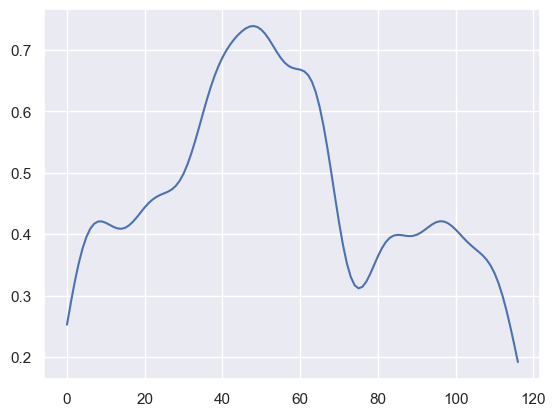

[514]
[398]
6539
cuda
epoch 1,loss = 0.98023146
epoch 2,loss = 0.98021519
epoch 3,loss = 0.98019934
epoch 4,loss = 0.98018366
epoch 5,loss = 0.98016840
epoch 6,loss = 0.98015362
epoch 7,loss = 0.98013914
epoch 8,loss = 0.98012495
epoch 9,loss = 0.98011118
epoch 10,loss = 0.98009777
epoch 11,loss = 0.98008460
epoch 12,loss = 0.98007178
epoch 13,loss = 0.98005927
epoch 14,loss = 0.98004717
epoch 15,loss = 0.98003525
epoch 16,loss = 0.98002368
epoch 17,loss = 0.98001236
epoch 18,loss = 0.98000133
epoch 19,loss = 0.97996527
epoch 20,loss = 0.97991407
epoch 21,loss = 0.97989476
epoch 22,loss = 0.97988206
epoch 23,loss = 0.97987348
epoch 24,loss = 0.97986621
epoch 25,loss = 0.97985774
epoch 26,loss = 0.97984570
epoch 27,loss = 0.97982979
epoch 28,loss = 0.97980976
epoch 29,loss = 0.97978705
epoch 30,loss = 0.97976303
epoch 31,loss = 0.97973871
epoch 32,loss = 0.97971529
epoch 33,loss = 0.97969311
epoch 34,loss = 0.97967184
epoch 35,loss = 0.97965091
epoch 36,loss = 0.97963071
epoch 37,loss =

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 56,loss = 0.97885132
epoch 57,loss = 0.97878635
epoch 58,loss = 0.97871482
epoch 59,loss = 0.97863251
epoch 60,loss = 0.97854030
epoch 61,loss = 0.97843313
epoch 62,loss = 0.97831017
epoch 63,loss = 0.97816736
epoch 64,loss = 0.97800666
epoch 65,loss = 0.97782600
epoch 66,loss = 0.97761935
epoch 67,loss = 0.97737819
epoch 68,loss = 0.97709900
epoch 69,loss = 0.97678548
epoch 70,loss = 0.97644234
epoch 71,loss = 0.97606856
epoch 72,loss = 0.97566575
epoch 73,loss = 0.97522950
epoch 74,loss = 0.97476125
epoch 75,loss = 0.97425437
epoch 76,loss = 0.97369164
epoch 77,loss = 0.97309691
epoch 78,loss = 0.97247046
epoch 79,loss = 0.97180575
epoch 80,loss = 0.97110158
epoch 81,loss = 0.97035670
epoch 82,loss = 0.96956128
epoch 83,loss = 0.96871448
epoch 84,loss = 0.96780723
epoch 85,loss = 0.96683419
epoch 86,loss = 0.96582079
epoch 87,loss = 0.96477973
epoch 88,loss = 0.96371520
epoch 89,loss = 0.96260726
epoch 90,loss = 0.96145779
epoch 91,loss = 0.96025926
epoch 92,loss = 0.95897561
e

epoch 362,loss = 0.65646094
epoch 363,loss = 0.65637285
epoch 364,loss = 0.65628636
epoch 365,loss = 0.65620017
epoch 366,loss = 0.65611047
epoch 367,loss = 0.65601754
epoch 368,loss = 0.65592384
epoch 369,loss = 0.65582454
epoch 370,loss = 0.65572429
epoch 371,loss = 0.65562141
epoch 372,loss = 0.65551895
epoch 373,loss = 0.65541732
epoch 374,loss = 0.65531844
epoch 375,loss = 0.65521848
epoch 376,loss = 0.65511602
epoch 377,loss = 0.65501422
epoch 378,loss = 0.65491158
epoch 379,loss = 0.65480953
epoch 380,loss = 0.65470678
epoch 381,loss = 0.65460688
epoch 382,loss = 0.65450662
epoch 383,loss = 0.65440732
epoch 384,loss = 0.65430886
epoch 385,loss = 0.65421063
epoch 386,loss = 0.65411305
epoch 387,loss = 0.65401566
epoch 388,loss = 0.65391827
epoch 389,loss = 0.65382171
epoch 390,loss = 0.65372664
epoch 391,loss = 0.65363401
epoch 392,loss = 0.65354216
epoch 393,loss = 0.65345377
epoch 394,loss = 0.65336502
epoch 395,loss = 0.65327823
epoch 396,loss = 0.65319222
epoch 397,loss = 0.6

epoch 687,loss = 0.63863391
epoch 688,loss = 0.63859266
epoch 689,loss = 0.63855171
epoch 690,loss = 0.63851064
epoch 691,loss = 0.63847142
epoch 692,loss = 0.63843137
epoch 693,loss = 0.63839090
epoch 694,loss = 0.63834977
epoch 695,loss = 0.63831031
epoch 696,loss = 0.63827109
epoch 697,loss = 0.63823175
epoch 698,loss = 0.63819236
epoch 699,loss = 0.63815290
epoch 700,loss = 0.63811338
epoch 701,loss = 0.63807380
epoch 702,loss = 0.63803434
epoch 703,loss = 0.63799560
epoch 704,loss = 0.63795733
epoch 705,loss = 0.63791841
epoch 706,loss = 0.63787985
epoch 707,loss = 0.63784176
epoch 708,loss = 0.63780373
epoch 709,loss = 0.63776588
epoch 710,loss = 0.63772792
epoch 711,loss = 0.63769072
epoch 712,loss = 0.63765335
epoch 713,loss = 0.63761592
epoch 714,loss = 0.63757908
epoch 715,loss = 0.63754207
epoch 716,loss = 0.63750535
epoch 717,loss = 0.63746887
epoch 718,loss = 0.63743234
epoch 719,loss = 0.63739616
epoch 720,loss = 0.63735992
epoch 721,loss = 0.63732398
epoch 722,loss = 0.6

epoch 998,loss = 0.62701243
epoch 999,loss = 0.62697828
epoch 1000,loss = 0.62694383
epoch 1001,loss = 0.62691087
epoch 1002,loss = 0.62687725
epoch 1003,loss = 0.62684232
epoch 1004,loss = 0.62680715
epoch 1005,loss = 0.62677282
epoch 1006,loss = 0.62673783
epoch 1007,loss = 0.62670314
epoch 1008,loss = 0.62666827
epoch 1009,loss = 0.62663317
epoch 1010,loss = 0.62659794
epoch 1011,loss = 0.62656313
epoch 1012,loss = 0.62652755
epoch 1013,loss = 0.62649250
epoch 1014,loss = 0.62645853
epoch 1015,loss = 0.62642443
epoch 1016,loss = 0.62639028
epoch 1017,loss = 0.62635636
epoch 1018,loss = 0.62632245
epoch 1019,loss = 0.62628859
epoch 1020,loss = 0.62625498
epoch 1021,loss = 0.62622136
epoch 1022,loss = 0.62618780
epoch 1023,loss = 0.62615448
epoch 1024,loss = 0.62612194
epoch 1025,loss = 0.62608832
epoch 1026,loss = 0.62605578
epoch 1027,loss = 0.62602347
epoch 1028,loss = 0.62599134
epoch 1029,loss = 0.62595934
epoch 1030,loss = 0.62592733
epoch 1031,loss = 0.62589526
epoch 1032,loss 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([325, 1, 50])
1.0
Epoch 200:   loss= 0.19774  cluster difference= 1.0
Epoch 400:   loss= 0.19842  cluster difference= 0.021538461538461538
Epoch 600:   loss= 0.19874  cluster difference= 0.036923076923076927
Epoch 800:   loss= 0.19891  cluster difference= 0.024615384615384615
Epoch 1000:   loss= 0.1989  cluster difference= 0.018461538461538463
Epoch 1200:   loss= 0.19865  cluster difference= 0.012307692307692308
Epoch 1400:   loss= 0.1982  cluster difference= 0.033846153846153845
Epoch 1600:   loss= 0.19766  cluster difference= 0.03076923076923077
Epoch 1800:   loss= 0.19711  cluster difference= 0.015384615384615385
Epoch 2000:   loss= 0.19654  cluster difference= 0.012307692307692308
Epoch 2200:   loss= 0.19596  cluster difference= 0.0
[6 1 3 2 4 4 4 1 1 1 1 1 5 3 2 1 1 5 3 2 1 1 1 6 6 0 3 3 7 4 4 1 1 1 1 1 5
 2 1 1 1 1 1 1 5 3 7 6 6 1 1 5 3 3 7 6 6 0 3 3 7 4 1 1 1 1 1 0 3 7 1 6 1 5
 3 2 1 1 1 1 1 5 3 7 1 1 1 1 1 1 1 0 3 7 1 1 1 1 1 1 3 2 1 6 1 1 4 5 3 2 1
 1 0 3 7 1 1 1 1 

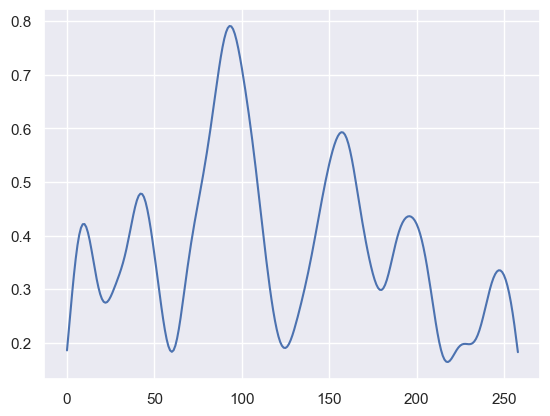

[2545]
[1276 2552 3828 5742]
3968
cuda
epoch 1,loss = 0.98275656
epoch 2,loss = 0.98274761
epoch 3,loss = 0.98273855
epoch 4,loss = 0.98272967
epoch 5,loss = 0.98272073
epoch 6,loss = 0.98271173
epoch 7,loss = 0.98270297
epoch 8,loss = 0.98269427
epoch 9,loss = 0.98268545
epoch 10,loss = 0.98267668
epoch 11,loss = 0.98266816
epoch 12,loss = 0.98265946
epoch 13,loss = 0.98265100
epoch 14,loss = 0.98264247
epoch 15,loss = 0.98263407
epoch 16,loss = 0.98262566
epoch 17,loss = 0.98261738
epoch 18,loss = 0.98260915
epoch 19,loss = 0.98260099
epoch 20,loss = 0.98259294
epoch 21,loss = 0.98258495
epoch 22,loss = 0.98257667
epoch 23,loss = 0.98256832
epoch 24,loss = 0.98256004
epoch 25,loss = 0.98255175
epoch 26,loss = 0.98254383
epoch 27,loss = 0.98253560
epoch 28,loss = 0.98252743
epoch 29,loss = 0.98252040
epoch 30,loss = 0.98251218
epoch 31,loss = 0.98250347
epoch 32,loss = 0.98249549
epoch 33,loss = 0.98248798
epoch 34,loss = 0.98248035
epoch 35,loss = 0.98247284
epoch 36,loss = 0.9824651

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 43,loss = 0.98240763
epoch 44,loss = 0.98239863
epoch 45,loss = 0.98238921
epoch 46,loss = 0.98237914
epoch 47,loss = 0.98236829
epoch 48,loss = 0.98235685
epoch 49,loss = 0.98234445
epoch 50,loss = 0.98233134
epoch 51,loss = 0.98231727
epoch 52,loss = 0.98230243
epoch 53,loss = 0.98228645
epoch 54,loss = 0.98226947
epoch 55,loss = 0.98225057
epoch 56,loss = 0.98222840
epoch 57,loss = 0.98220032
epoch 58,loss = 0.98216152
epoch 59,loss = 0.98211002
epoch 60,loss = 0.98204488
epoch 61,loss = 0.98196489
epoch 62,loss = 0.98185658
epoch 63,loss = 0.98170209
epoch 64,loss = 0.98146319
epoch 65,loss = 0.98112643
epoch 66,loss = 0.98060989
epoch 67,loss = 0.97983366
epoch 68,loss = 0.97872859
epoch 69,loss = 0.97728384
epoch 70,loss = 0.97551721
epoch 71,loss = 0.97358447
epoch 72,loss = 0.97145432
epoch 73,loss = 0.96907014
epoch 74,loss = 0.96702796
epoch 75,loss = 0.96526325
epoch 76,loss = 0.96334511
epoch 77,loss = 0.96137297
epoch 78,loss = 0.95895749
epoch 79,loss = 0.95610827
e

epoch 344,loss = 0.62417221
epoch 345,loss = 0.62415045
epoch 346,loss = 0.62412870
epoch 347,loss = 0.62410694
epoch 348,loss = 0.62408513
epoch 349,loss = 0.62406325
epoch 350,loss = 0.62404144
epoch 351,loss = 0.62401944
epoch 352,loss = 0.62399745
epoch 353,loss = 0.62397534
epoch 354,loss = 0.62395316
epoch 355,loss = 0.62393099
epoch 356,loss = 0.62390876
epoch 357,loss = 0.62388629
epoch 358,loss = 0.62386358
epoch 359,loss = 0.62384075
epoch 360,loss = 0.62381786
epoch 361,loss = 0.62379473
epoch 362,loss = 0.62377155
epoch 363,loss = 0.62374824
epoch 364,loss = 0.62372482
epoch 365,loss = 0.62370127
epoch 366,loss = 0.62367725
epoch 367,loss = 0.62365299
epoch 368,loss = 0.62362850
epoch 369,loss = 0.62360376
epoch 370,loss = 0.62357873
epoch 371,loss = 0.62355334
epoch 372,loss = 0.62352777
epoch 373,loss = 0.62350184
epoch 374,loss = 0.62347537
epoch 375,loss = 0.62344837
epoch 376,loss = 0.62342083
epoch 377,loss = 0.62339270
epoch 378,loss = 0.62336373
epoch 379,loss = 0.6

epoch 656,loss = 0.61016911
epoch 657,loss = 0.61014909
epoch 658,loss = 0.61012906
epoch 659,loss = 0.61010909
epoch 660,loss = 0.61008912
epoch 661,loss = 0.61006916
epoch 662,loss = 0.61004919
epoch 663,loss = 0.61002934
epoch 664,loss = 0.61000943
epoch 665,loss = 0.60998958
epoch 666,loss = 0.60996979
epoch 667,loss = 0.60994995
epoch 668,loss = 0.60993016
epoch 669,loss = 0.60991037
epoch 670,loss = 0.60989064
epoch 671,loss = 0.60987091
epoch 672,loss = 0.60985124
epoch 673,loss = 0.60983157
epoch 674,loss = 0.60981190
epoch 675,loss = 0.60979217
epoch 676,loss = 0.60977250
epoch 677,loss = 0.60975295
epoch 678,loss = 0.60973340
epoch 679,loss = 0.60971391
epoch 680,loss = 0.60969442
epoch 681,loss = 0.60967487
epoch 682,loss = 0.60965538
epoch 683,loss = 0.60963589
epoch 684,loss = 0.60961646
epoch 685,loss = 0.60959697
epoch 686,loss = 0.60957760
epoch 687,loss = 0.60955811
epoch 688,loss = 0.60953861
epoch 689,loss = 0.60951912
epoch 690,loss = 0.60949975
epoch 691,loss = 0.6

epoch 967,loss = 0.60389584
epoch 968,loss = 0.60387439
epoch 969,loss = 0.60385293
epoch 970,loss = 0.60383147
epoch 971,loss = 0.60380995
epoch 972,loss = 0.60378850
epoch 973,loss = 0.60376710
epoch 974,loss = 0.60374558
epoch 975,loss = 0.60372406
epoch 976,loss = 0.60370243
epoch 977,loss = 0.60368079
epoch 978,loss = 0.60365909
epoch 979,loss = 0.60363752
epoch 980,loss = 0.60361594
epoch 981,loss = 0.60359442
epoch 982,loss = 0.60357296
epoch 983,loss = 0.60355145
epoch 984,loss = 0.60352987
epoch 985,loss = 0.60350841
epoch 986,loss = 0.60348678
epoch 987,loss = 0.60346520
epoch 988,loss = 0.60344362
epoch 989,loss = 0.60342199
epoch 990,loss = 0.60340047
epoch 991,loss = 0.60337889
epoch 992,loss = 0.60335737
epoch 993,loss = 0.60333604
epoch 994,loss = 0.60331464
epoch 995,loss = 0.60329342
epoch 996,loss = 0.60327214
epoch 997,loss = 0.60325092
epoch 998,loss = 0.60322982
epoch 999,loss = 0.60320878
epoch 1000,loss = 0.60318768
epoch 1001,loss = 0.60316664
epoch 1002,loss = 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([494, 1, 20])
1.0
Epoch 200:   loss= 0.18505  cluster difference= 1.0
Epoch 400:   loss= 0.18844  cluster difference= 0.022267206477732792
Epoch 600:   loss= 0.19132  cluster difference= 0.030364372469635626
Epoch 800:   loss= 0.1935  cluster difference= 0.020242914979757085
Epoch 1000:   loss= 0.19482  cluster difference= 0.0
[2 0 4 6 1 7 6 1 7 1 1 2 0 3 1 1 2 0 4 6 1 7 6 1 7 1 1 2 0 3 1 1 2 0 4 6 1
 7 6 1 7 1 1 2 0 3 1 1 2 0 4 6 1 7 6 1 7 1 1 2 0 3 1 1 2 0 4 6 1 7 6 1 7 1
 1 2 0 3 1 1 2 0 4 6 1 7 6 1 7 1 1 2 0 3 1 1 2 0 4 6 1 2 6 1 1 1 1 2 0 3 1
 1 2 0 4 6 1 2 6 1 1 1 1 2 5 3 1 1 2 0 4 6 1 7 6 1 1 1 1 2 0 3 1 1 2 0 4 6
 1 2 6 1 1 1 1 2 0 3 1 1 2 0 4 6 1 7 6 1 1 1 1 2 5 3 1 1 2 0 4 6 1 7 6 1 1
 1 1 2 0 3 1 1 2 0 4 6 1 7 6 1 1 1 1 2 0 3 1 1 2 0 4 6 1 7 6 1 1 1 1 2 5 3
 1 1 2 0 0 3 1 7 6 1 7 1 1 2 5 3 1 1 2 0 0 3 1 7 6 1 7 1 1 2 5 3 1 1 2 0 0
 3 1 7 6 1 7 1 1 2 5 3 1 1 2 0 0 3 1 7 6 1 7 1 1 2 5 3 1 1 2 0 0 3 1 7 6 1
 7 1 1 2 5 3 1 1 2 0 0 3 1 7 6 1 7 1 1 2 5 3 1 1 2 0 4 6 1 7

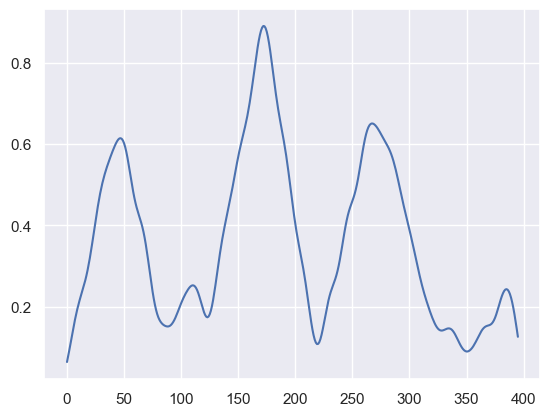

[778, 1778, 2538]
[ 768 1792 2560]
3360
cuda
epoch 1,loss = 1.06223786
epoch 2,loss = 1.06222355
epoch 3,loss = 1.06220961
epoch 4,loss = 1.06219554
epoch 5,loss = 1.06218159
epoch 6,loss = 1.06216776
epoch 7,loss = 1.06215394
epoch 8,loss = 1.06214011
epoch 9,loss = 1.06212640
epoch 10,loss = 1.06211281
epoch 11,loss = 1.06209934
epoch 12,loss = 1.06208575
epoch 13,loss = 1.06207216
epoch 14,loss = 1.06205893
epoch 15,loss = 1.06204557
epoch 16,loss = 1.06203222
epoch 17,loss = 1.06201911
epoch 18,loss = 1.06200588
epoch 19,loss = 1.06199300
epoch 20,loss = 1.06197989
epoch 21,loss = 1.06196690
epoch 22,loss = 1.06195402
epoch 23,loss = 1.06194115
epoch 24,loss = 1.06192851
epoch 25,loss = 1.06191587
epoch 26,loss = 1.06190324
epoch 27,loss = 1.06189072
epoch 28,loss = 1.06187820
epoch 29,loss = 1.06186581
epoch 30,loss = 1.06185353
epoch 31,loss = 1.06184113
epoch 32,loss = 1.06182897
epoch 33,loss = 1.06181669
epoch 34,loss = 1.06180465
epoch 35,loss = 1.06179261


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 36,loss = 1.06178081
epoch 37,loss = 1.06176877
epoch 38,loss = 1.06173861
epoch 39,loss = 1.06168640
epoch 40,loss = 1.06162953
epoch 41,loss = 1.06156206
epoch 42,loss = 1.06148815
epoch 43,loss = 1.06141198
epoch 44,loss = 1.06135929
epoch 45,loss = 1.06132686
epoch 46,loss = 1.06129682
epoch 47,loss = 1.06126416
epoch 48,loss = 1.06123018
epoch 49,loss = 1.06119299
epoch 50,loss = 1.06115878
epoch 51,loss = 1.06105471
epoch 52,loss = 1.06092215
epoch 53,loss = 1.06075156
epoch 54,loss = 1.06063855
epoch 55,loss = 1.06053138
epoch 56,loss = 1.06043148
epoch 57,loss = 1.06033981
epoch 58,loss = 1.06025708
epoch 59,loss = 1.06018305
epoch 60,loss = 1.06011820
epoch 61,loss = 1.06006157
epoch 62,loss = 1.06001282
epoch 63,loss = 1.05997097
epoch 64,loss = 1.05993545
epoch 65,loss = 1.05990505
epoch 66,loss = 1.05987895
epoch 67,loss = 1.05985558
epoch 68,loss = 1.05983448
epoch 69,loss = 1.05981469
epoch 70,loss = 1.05979514
epoch 71,loss = 1.05977523
epoch 72,loss = 1.05975413
e

epoch 366,loss = 0.54092473
epoch 367,loss = 0.54011160
epoch 368,loss = 0.53928357
epoch 369,loss = 0.53843862
epoch 370,loss = 0.53757977
epoch 371,loss = 0.53670961
epoch 372,loss = 0.53583002
epoch 373,loss = 0.53494549
epoch 374,loss = 0.53406614
epoch 375,loss = 0.53319865
epoch 376,loss = 0.53234535
epoch 377,loss = 0.53150666
epoch 378,loss = 0.53068197
epoch 379,loss = 0.52987111
epoch 380,loss = 0.52907163
epoch 381,loss = 0.52828151
epoch 382,loss = 0.52749830
epoch 383,loss = 0.52671939
epoch 384,loss = 0.52594340
epoch 385,loss = 0.52516955
epoch 386,loss = 0.52439904
epoch 387,loss = 0.52363139
epoch 388,loss = 0.52286726
epoch 389,loss = 0.52210969
epoch 390,loss = 0.52136064
epoch 391,loss = 0.52062428
epoch 392,loss = 0.51990062
epoch 393,loss = 0.51918817
epoch 394,loss = 0.51849282
epoch 395,loss = 0.51781422
epoch 396,loss = 0.51714963
epoch 397,loss = 0.51649702
epoch 398,loss = 0.51585525
epoch 399,loss = 0.51522589
epoch 400,loss = 0.51460648
epoch 401,loss = 0.5

epoch 669,loss = 0.42055482
epoch 670,loss = 0.42035881
epoch 671,loss = 0.42016420
epoch 672,loss = 0.41997096
epoch 673,loss = 0.41977918
epoch 674,loss = 0.41958848
epoch 675,loss = 0.41939899
epoch 676,loss = 0.41921088
epoch 677,loss = 0.41902411
epoch 678,loss = 0.41883832
epoch 679,loss = 0.41865391
epoch 680,loss = 0.41847086
epoch 681,loss = 0.41828910
epoch 682,loss = 0.41810873
epoch 683,loss = 0.41792974
epoch 684,loss = 0.41775170
epoch 685,loss = 0.41757497
epoch 686,loss = 0.41739956
epoch 687,loss = 0.41722494
epoch 688,loss = 0.41705161
epoch 689,loss = 0.41687962
epoch 690,loss = 0.41670898
epoch 691,loss = 0.41653958
epoch 692,loss = 0.41637096
epoch 693,loss = 0.41620335
epoch 694,loss = 0.41603693
epoch 695,loss = 0.41587141
epoch 696,loss = 0.41570699
epoch 697,loss = 0.41554359
epoch 698,loss = 0.41538113
epoch 699,loss = 0.41521981
epoch 700,loss = 0.41505980
epoch 701,loss = 0.41490105
epoch 702,loss = 0.41474336
epoch 703,loss = 0.41458657
epoch 704,loss = 0.4

epoch 981,loss = 0.39525971
epoch 982,loss = 0.39522466
epoch 983,loss = 0.39518973
epoch 984,loss = 0.39515486
epoch 985,loss = 0.39512002
epoch 986,loss = 0.39508530
epoch 987,loss = 0.39505059
epoch 988,loss = 0.39501601
epoch 989,loss = 0.39498147
epoch 990,loss = 0.39494702
epoch 991,loss = 0.39491263
epoch 992,loss = 0.39487830
epoch 993,loss = 0.39484408
epoch 994,loss = 0.39480987
epoch 995,loss = 0.39477581
epoch 996,loss = 0.39474174
epoch 997,loss = 0.39470774
epoch 998,loss = 0.39467385
epoch 999,loss = 0.39463997
epoch 1000,loss = 0.39460617
epoch 1001,loss = 0.39457247
epoch 1002,loss = 0.39453885
epoch 1003,loss = 0.39450526
epoch 1004,loss = 0.39447168
epoch 1005,loss = 0.39443824
epoch 1006,loss = 0.39440483
epoch 1007,loss = 0.39437148
epoch 1008,loss = 0.39433816
epoch 1009,loss = 0.39430496
epoch 1010,loss = 0.39427176
epoch 1011,loss = 0.39423865
epoch 1012,loss = 0.39420563
epoch 1013,loss = 0.39417261
epoch 1014,loss = 0.39413968
epoch 1015,loss = 0.39410678
epoc

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([418, 1, 20])
1.0
Epoch 200:   loss= 0.07467  cluster difference= 1.0
Epoch 400:   loss= 0.07424  cluster difference= 0.0023923444976076554
[7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6
 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4
 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0
 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 1 6 5 4 3 0 2 1
 6 5 4 3 0 2 1 7 5 4 3 0 2 1 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5
 4 3 0 2 7 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3
 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2
 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 1 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6
 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 1 6 5 4 3 0 2 7 6 5 4
 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0
 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7 6 5 4 3 0 2 7
 6 5 4 3 0 2 7 6 5 4 3]


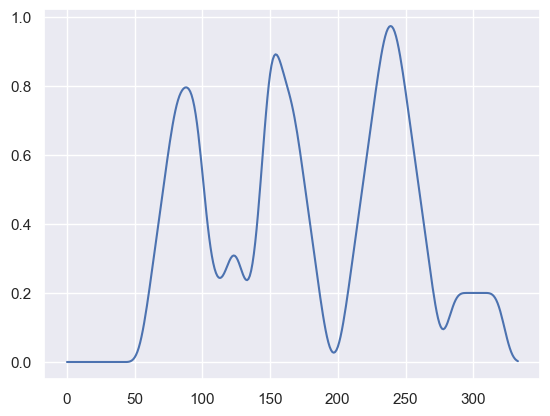

[1050, 1578, 2258]
[1120 2240]
2474
cuda
epoch 1,loss = 0.98960096
epoch 2,loss = 0.98958606
epoch 3,loss = 0.98957157
epoch 4,loss = 0.98955745
epoch 5,loss = 0.98954368
epoch 6,loss = 0.98953027
epoch 7,loss = 0.98951715
epoch 8,loss = 0.98950434
epoch 9,loss = 0.98949176
epoch 10,loss = 0.98947948
epoch 11,loss = 0.98946744
epoch 12,loss = 0.98945564
epoch 13,loss = 0.98944420
epoch 14,loss = 0.98943293
epoch 15,loss = 0.98942178
epoch 16,loss = 0.98941082
epoch 17,loss = 0.98939985
epoch 18,loss = 0.98938882
epoch 19,loss = 0.98937786
epoch 20,loss = 0.98936689
epoch 21,loss = 0.98935586
epoch 22,loss = 0.98934478
epoch 23,loss = 0.98933351
epoch 24,loss = 0.98932213
epoch 25,loss = 0.98931062
epoch 26,loss = 0.98929882
epoch 27,loss = 0.98928708
epoch 28,loss = 0.98927498
epoch 29,loss = 0.98926270
epoch 30,loss = 0.98925018
epoch 31,loss = 0.98923749
epoch 32,loss = 0.98922473
epoch 33,loss = 0.98921138
epoch 34,loss = 0.98919785
epoch 35,loss = 0.98918378
epoch 36,loss = 0.98916

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 45,loss = 0.98901510
epoch 46,loss = 0.98899651
epoch 47,loss = 0.98897940
epoch 48,loss = 0.98895609
epoch 49,loss = 0.98890734
epoch 50,loss = 0.98887974
epoch 51,loss = 0.98885787
epoch 52,loss = 0.98883575
epoch 53,loss = 0.98881340
epoch 54,loss = 0.98879051
epoch 55,loss = 0.98876679
epoch 56,loss = 0.98874199
epoch 57,loss = 0.98871589
epoch 58,loss = 0.98868841
epoch 59,loss = 0.98865956
epoch 60,loss = 0.98862910
epoch 61,loss = 0.98859680
epoch 62,loss = 0.98856288
epoch 63,loss = 0.98852712
epoch 64,loss = 0.98848951
epoch 65,loss = 0.98844981
epoch 66,loss = 0.98840815
epoch 67,loss = 0.98836428
epoch 68,loss = 0.98831844
epoch 69,loss = 0.98827058
epoch 70,loss = 0.98822010
epoch 71,loss = 0.98816711
epoch 72,loss = 0.98811167
epoch 73,loss = 0.98805398
epoch 74,loss = 0.98799366
epoch 75,loss = 0.98793030
epoch 76,loss = 0.98786390
epoch 77,loss = 0.98779422
epoch 78,loss = 0.98772156
epoch 79,loss = 0.98764521
epoch 80,loss = 0.98756522
epoch 81,loss = 0.98748177
e

epoch 354,loss = 0.63566875
epoch 355,loss = 0.63535237
epoch 356,loss = 0.63503796
epoch 357,loss = 0.63472658
epoch 358,loss = 0.63441825
epoch 359,loss = 0.63411301
epoch 360,loss = 0.63381070
epoch 361,loss = 0.63351238
epoch 362,loss = 0.63321614
epoch 363,loss = 0.63292277
epoch 364,loss = 0.63262999
epoch 365,loss = 0.63233787
epoch 366,loss = 0.63204771
epoch 367,loss = 0.63175583
epoch 368,loss = 0.63146389
epoch 369,loss = 0.63117015
epoch 370,loss = 0.63087606
epoch 371,loss = 0.63058186
epoch 372,loss = 0.63028693
epoch 373,loss = 0.62999165
epoch 374,loss = 0.62969673
epoch 375,loss = 0.62940240
epoch 376,loss = 0.62911290
epoch 377,loss = 0.62882584
epoch 378,loss = 0.62854385
epoch 379,loss = 0.62826359
epoch 380,loss = 0.62798166
epoch 381,loss = 0.62769777
epoch 382,loss = 0.62741566
epoch 383,loss = 0.62713397
epoch 384,loss = 0.62685221
epoch 385,loss = 0.62657297
epoch 386,loss = 0.62629527
epoch 387,loss = 0.62601888
epoch 388,loss = 0.62574565
epoch 389,loss = 0.6

epoch 650,loss = 0.56300563
epoch 651,loss = 0.56281316
epoch 652,loss = 0.56262016
epoch 653,loss = 0.56243384
epoch 654,loss = 0.56223422
epoch 655,loss = 0.56203824
epoch 656,loss = 0.56183422
epoch 657,loss = 0.56167269
epoch 658,loss = 0.56151730
epoch 659,loss = 0.56135768
epoch 660,loss = 0.56119794
epoch 661,loss = 0.56104094
epoch 662,loss = 0.56089962
epoch 663,loss = 0.56072813
epoch 664,loss = 0.56054980
epoch 665,loss = 0.56035757
epoch 666,loss = 0.56015640
epoch 667,loss = 0.55996764
epoch 668,loss = 0.55977827
epoch 669,loss = 0.55959946
epoch 670,loss = 0.55942285
epoch 671,loss = 0.55924666
epoch 672,loss = 0.55907059
epoch 673,loss = 0.55893761
epoch 674,loss = 0.55884701
epoch 675,loss = 0.55874825
epoch 676,loss = 0.55863470
epoch 677,loss = 0.55852246
epoch 678,loss = 0.55840743
epoch 679,loss = 0.55829126
epoch 680,loss = 0.55817711
epoch 681,loss = 0.55806553
epoch 682,loss = 0.55795270
epoch 683,loss = 0.55784237
epoch 684,loss = 0.55773425
epoch 685,loss = 0.5

epoch 949,loss = 0.52394128
epoch 950,loss = 0.52373600
epoch 951,loss = 0.52352840
epoch 952,loss = 0.52332371
epoch 953,loss = 0.52314651
epoch 954,loss = 0.52297598
epoch 955,loss = 0.52281243
epoch 956,loss = 0.52264708
epoch 957,loss = 0.52247673
epoch 958,loss = 0.52228004
epoch 959,loss = 0.52208215
epoch 960,loss = 0.52187806
epoch 961,loss = 0.52166182
epoch 962,loss = 0.52144259
epoch 963,loss = 0.52126700
epoch 964,loss = 0.52112460
epoch 965,loss = 0.52098036
epoch 966,loss = 0.52084744
epoch 967,loss = 0.52069885
epoch 968,loss = 0.52046698
epoch 969,loss = 0.52019161
epoch 970,loss = 0.51988840
epoch 971,loss = 0.51964533
epoch 972,loss = 0.51943433
epoch 973,loss = 0.51924199
epoch 974,loss = 0.51903582
epoch 975,loss = 0.51877564
epoch 976,loss = 0.51847184
epoch 977,loss = 0.51819378
epoch 978,loss = 0.51793164
epoch 979,loss = 0.51768279
epoch 980,loss = 0.51744753
epoch 981,loss = 0.51723975
epoch 982,loss = 0.51704443
epoch 983,loss = 0.51685208
epoch 984,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([307, 1, 20])
1.0
Epoch 200:   loss= 0.09651  cluster difference= 1.0
Epoch 400:   loss= 0.09618  cluster difference= 0.0
[6 2 2 2 2 1 3 2 2 2 2 1 3 2 2 2 2 5 6 0 2 2 2 2 7 2 2 2 2 2 4 0 2 2 2 2 1
 6 2 2 2 2 1 3 2 2 2 2 5 6 2 2 2 2 2 7 2 2 2 2 2 0 6 0 2 2 2 4 2 2 2 2 2 1
 0 2 2 2 2 5 3 2 2 2 2 2 6 0 2 2 2 2 7 2 2 2 2 2 1 3 2 2 2 2 1 3 2 2 2 2 5
 3 2 2 2 2 5 6 2 2 2 2 2 7 0 2 2 2 2 4 0 0 2 2 2 1 3 2 2 2 2 1 3 2 2 2 2 5
 3 2 2 2 2 2 6 2 2 2 2 2 4 0 2 2 2 2 4 0 2 2 2 2 1 3 2 2 2 2 5 6 2 2 2 2 5
 6 2 2 2 2 2 7 0 2 2 2 2 4 2 2 2 2 2 1 3 2 2 2 2 1 3 2 2 2 2 5 3 2 2 2 2 5
 6 0 2 2 2 2 7 2 2 0 2 2 4 2 2 2 2 2 4 2 0 2 2 2 2 0 2 0 2 2 7 6 2 0 0 2 0
 7 2 2 0 2 2 7 2 0 2 2 2 4 0 2 0 2 2 1 3 2 0 0 2 5 3 0 2 2 2 2 6 2 0 2 2 2
 7 2 2 2 2 2 4 2 2 0 2]


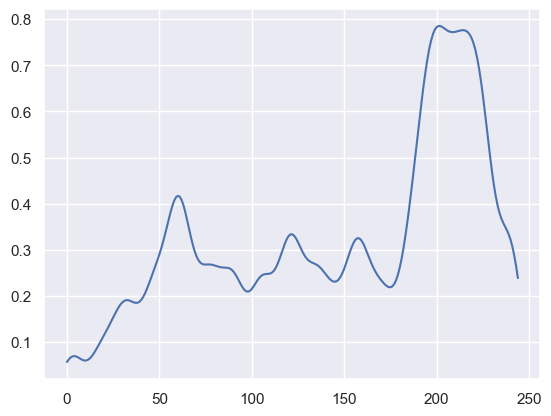

[1866]
[1732]
1680
cuda
epoch 1,loss = 0.98572510
epoch 2,loss = 0.98570162
epoch 3,loss = 0.98567897
epoch 4,loss = 0.98565668
epoch 5,loss = 0.98563486
epoch 6,loss = 0.98561347
epoch 7,loss = 0.98559242
epoch 8,loss = 0.98557144
epoch 9,loss = 0.98555070
epoch 10,loss = 0.98552996
epoch 11,loss = 0.98550946
epoch 12,loss = 0.98548901
epoch 13,loss = 0.98546851
epoch 14,loss = 0.98544788
epoch 15,loss = 0.98542744
epoch 16,loss = 0.98540699
epoch 17,loss = 0.98538655
epoch 18,loss = 0.98536611
epoch 19,loss = 0.98534554
epoch 20,loss = 0.98532486
epoch 21,loss = 0.98530406
epoch 22,loss = 0.98528320
epoch 23,loss = 0.98526233
epoch 24,loss = 0.98524183
epoch 25,loss = 0.98522246
epoch 26,loss = 0.98520392
epoch 27,loss = 0.98518586
epoch 28,loss = 0.98516822
epoch 29,loss = 0.98515052
epoch 30,loss = 0.98513258
epoch 31,loss = 0.98511732
epoch 32,loss = 0.98510313
epoch 33,loss = 0.98508829
epoch 34,loss = 0.98507369
epoch 35,loss = 0.98505908
epoch 36,loss = 0.98504448
epoch 37,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 67,loss = 0.97864139
epoch 68,loss = 0.97804528
epoch 69,loss = 0.97741365
epoch 70,loss = 0.97673899
epoch 71,loss = 0.97602135
epoch 72,loss = 0.97525352
epoch 73,loss = 0.97442979
epoch 74,loss = 0.97354835
epoch 75,loss = 0.97261441
epoch 76,loss = 0.97163111
epoch 77,loss = 0.97058737
epoch 78,loss = 0.96949363
epoch 79,loss = 0.96833819
epoch 80,loss = 0.96712452
epoch 81,loss = 0.96583825
epoch 82,loss = 0.96448714
epoch 83,loss = 0.96307403
epoch 84,loss = 0.96158290
epoch 85,loss = 0.96002275
epoch 86,loss = 0.95838952
epoch 87,loss = 0.95669019
epoch 88,loss = 0.95492643
epoch 89,loss = 0.95310307
epoch 90,loss = 0.95121521
epoch 91,loss = 0.94925863
epoch 92,loss = 0.94724965
epoch 93,loss = 0.94517052
epoch 94,loss = 0.94303972
epoch 95,loss = 0.94086915
epoch 96,loss = 0.93862498
epoch 97,loss = 0.93634111
epoch 98,loss = 0.93401247
epoch 99,loss = 0.93163943
epoch 100,loss = 0.92924863
epoch 101,loss = 0.92683619
epoch 102,loss = 0.92440099
epoch 103,loss = 0.921919

epoch 402,loss = 0.77815205
epoch 403,loss = 0.77807069
epoch 404,loss = 0.77798969
epoch 405,loss = 0.77790856
epoch 406,loss = 0.77782869
epoch 407,loss = 0.77775013
epoch 408,loss = 0.77767068
epoch 409,loss = 0.77759224
epoch 410,loss = 0.77751392
epoch 411,loss = 0.77743661
epoch 412,loss = 0.77735925
epoch 413,loss = 0.77728313
epoch 414,loss = 0.77720779
epoch 415,loss = 0.77713275
epoch 416,loss = 0.77705765
epoch 417,loss = 0.77698386
epoch 418,loss = 0.77690977
epoch 419,loss = 0.77683878
epoch 420,loss = 0.77676839
epoch 421,loss = 0.77669913
epoch 422,loss = 0.77663136
epoch 423,loss = 0.77656782
epoch 424,loss = 0.77650321
epoch 425,loss = 0.77643502
epoch 426,loss = 0.77636957
epoch 427,loss = 0.77630514
epoch 428,loss = 0.77623940
epoch 429,loss = 0.77617186
epoch 430,loss = 0.77610415
epoch 431,loss = 0.77603567
epoch 432,loss = 0.77597111
epoch 433,loss = 0.77590525
epoch 434,loss = 0.77583700
epoch 435,loss = 0.77576864
epoch 436,loss = 0.77570361
epoch 437,loss = 0.7

epoch 730,loss = 0.75856608
epoch 731,loss = 0.75852585
epoch 732,loss = 0.75848764
epoch 733,loss = 0.75844824
epoch 734,loss = 0.75840634
epoch 735,loss = 0.75837266
epoch 736,loss = 0.75832236
epoch 737,loss = 0.75828713
epoch 738,loss = 0.75825280
epoch 739,loss = 0.75821495
epoch 740,loss = 0.75817251
epoch 741,loss = 0.75813073
epoch 742,loss = 0.75809139
epoch 743,loss = 0.75805390
epoch 744,loss = 0.75801605
epoch 745,loss = 0.75797766
epoch 746,loss = 0.75793850
epoch 747,loss = 0.75790167
epoch 748,loss = 0.75786340
epoch 749,loss = 0.75782877
epoch 750,loss = 0.75779182
epoch 751,loss = 0.75775319
epoch 752,loss = 0.75771379
epoch 753,loss = 0.75767362
epoch 754,loss = 0.75763673
epoch 755,loss = 0.75759625
epoch 756,loss = 0.75755864
epoch 757,loss = 0.75752032
epoch 758,loss = 0.75748211
epoch 759,loss = 0.75744331
epoch 760,loss = 0.75740409
epoch 761,loss = 0.75736445
epoch 762,loss = 0.75733793
epoch 763,loss = 0.75728887
epoch 764,loss = 0.75725251
epoch 765,loss = 0.7

epoch 1062,loss = 0.74370426
epoch 1063,loss = 0.74365342
epoch 1064,loss = 0.74360245
epoch 1065,loss = 0.74355191
epoch 1066,loss = 0.74350089
epoch 1067,loss = 0.74344951
epoch 1068,loss = 0.74339908
epoch 1069,loss = 0.74334913
epoch 1070,loss = 0.74329913
epoch 1071,loss = 0.74324977
epoch 1072,loss = 0.74320221
epoch 1073,loss = 0.74315244
epoch 1074,loss = 0.74310470
epoch 1075,loss = 0.74305642
epoch 1076,loss = 0.74300742
epoch 1077,loss = 0.74295956
epoch 1078,loss = 0.74291241
epoch 1079,loss = 0.74286479
epoch 1080,loss = 0.74281716
epoch 1081,loss = 0.74276972
epoch 1082,loss = 0.74272215
epoch 1083,loss = 0.74267477
epoch 1084,loss = 0.74262786
epoch 1085,loss = 0.74258119
epoch 1086,loss = 0.74253362
epoch 1087,loss = 0.74248713
epoch 1088,loss = 0.74244088
epoch 1089,loss = 0.74239659
epoch 1090,loss = 0.74235159
epoch 1091,loss = 0.74230671
epoch 1092,loss = 0.74226260
epoch 1093,loss = 0.74221951
epoch 1094,loss = 0.74217618
epoch 1095,loss = 0.74213213
epoch 1096,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([82, 1, 50])
1.0
Epoch 200:   loss= 0.17364  cluster difference= 1.0
Epoch 400:   loss= 0.16664  cluster difference= 0.0
[1 1 7 4 3 1 6 6 5 1 6 6 5 1 2 6 3 1 6 6 6 3 1 2 7 5 1 2 4 5 1 2 5 6 1 2 4
 0 1 2 0 1 1 7 5 2 3 1 7 5 1 1 7 0 3 1 7 0 3 1 2 0 3 1 2 2 3 1 1 4 0 3 1 2
 0 3 1 3 2 6 1 1]


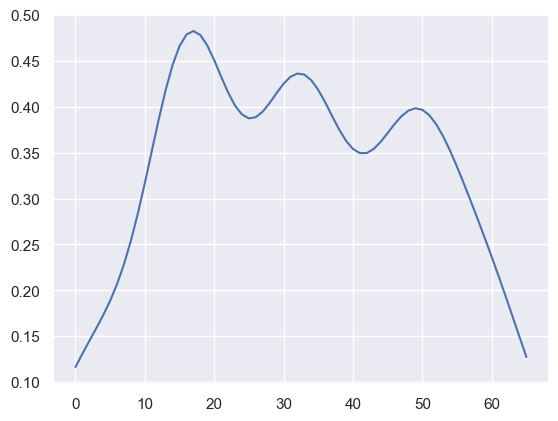

[]
[840]
12420
cuda
epoch 1,loss = 1.00127923
epoch 2,loss = 1.00125241
epoch 3,loss = 1.00122786
epoch 4,loss = 1.00120544
epoch 5,loss = 1.00118482
epoch 6,loss = 1.00116503
epoch 7,loss = 1.00114584
epoch 8,loss = 1.00112689
epoch 9,loss = 1.00110817
epoch 10,loss = 1.00108957
epoch 11,loss = 1.00107121
epoch 12,loss = 1.00105298
epoch 13,loss = 1.00103509
epoch 14,loss = 1.00101745


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 15,loss = 1.00100017
epoch 16,loss = 1.00098324
epoch 17,loss = 1.00096667
epoch 18,loss = 1.00095034
epoch 19,loss = 1.00093436
epoch 20,loss = 1.00091875
epoch 21,loss = 1.00090349
epoch 22,loss = 1.00088847
epoch 23,loss = 1.00087392
epoch 24,loss = 1.00085974
epoch 25,loss = 1.00084591
epoch 26,loss = 1.00083220
epoch 27,loss = 1.00081885
epoch 28,loss = 1.00080597
epoch 29,loss = 1.00079310
epoch 30,loss = 1.00078058
epoch 31,loss = 1.00076818
epoch 32,loss = 1.00075626
epoch 33,loss = 1.00074434
epoch 34,loss = 1.00073266
epoch 35,loss = 1.00072122
epoch 36,loss = 1.00070989
epoch 37,loss = 1.00069880
epoch 38,loss = 1.00068772
epoch 39,loss = 1.00067687
epoch 40,loss = 1.00066614
epoch 41,loss = 1.00065541
epoch 42,loss = 1.00064492
epoch 43,loss = 1.00063443
epoch 44,loss = 1.00062418
epoch 45,loss = 1.00061393
epoch 46,loss = 1.00060356
epoch 47,loss = 1.00059175
epoch 48,loss = 1.00057435
epoch 49,loss = 1.00053740
epoch 50,loss = 1.00046861
epoch 51,loss = 1.00036228
e

epoch 316,loss = 0.84098059
epoch 317,loss = 0.84003788
epoch 318,loss = 0.83910042
epoch 319,loss = 0.83817452
epoch 320,loss = 0.83726281
epoch 321,loss = 0.83635736
epoch 322,loss = 0.83545071
epoch 323,loss = 0.83454639
epoch 324,loss = 0.83364803
epoch 325,loss = 0.83274937
epoch 326,loss = 0.83185261
epoch 327,loss = 0.83095080
epoch 328,loss = 0.83005047
epoch 329,loss = 0.82914317
epoch 330,loss = 0.82823360
epoch 331,loss = 0.82731462
epoch 332,loss = 0.82637799
epoch 333,loss = 0.82542878
epoch 334,loss = 0.82445812
epoch 335,loss = 0.82346874
epoch 336,loss = 0.82245207
epoch 337,loss = 0.82140571
epoch 338,loss = 0.82032669
epoch 339,loss = 0.81921250
epoch 340,loss = 0.81806308
epoch 341,loss = 0.81687158
epoch 342,loss = 0.81563669
epoch 343,loss = 0.81434423
epoch 344,loss = 0.81299520
epoch 345,loss = 0.81158614
epoch 346,loss = 0.81011218
epoch 347,loss = 0.80857193
epoch 348,loss = 0.80696732
epoch 349,loss = 0.80530190
epoch 350,loss = 0.80357569
epoch 351,loss = 0.8

epoch 645,loss = 0.71779948
epoch 646,loss = 0.71776325
epoch 647,loss = 0.71772712
epoch 648,loss = 0.71769100
epoch 649,loss = 0.71765494
epoch 650,loss = 0.71761888
epoch 651,loss = 0.71758288
epoch 652,loss = 0.71754682
epoch 653,loss = 0.71751070
epoch 654,loss = 0.71747452
epoch 655,loss = 0.71743822
epoch 656,loss = 0.71740186
epoch 657,loss = 0.71736568
epoch 658,loss = 0.71732932
epoch 659,loss = 0.71729308
epoch 660,loss = 0.71725690
epoch 661,loss = 0.71722060
epoch 662,loss = 0.71718431
epoch 663,loss = 0.71714789
epoch 664,loss = 0.71711165
epoch 665,loss = 0.71707535
epoch 666,loss = 0.71703899
epoch 667,loss = 0.71700257
epoch 668,loss = 0.71696597
epoch 669,loss = 0.71692932
epoch 670,loss = 0.71689248
epoch 671,loss = 0.71685565
epoch 672,loss = 0.71681875
epoch 673,loss = 0.71678185
epoch 674,loss = 0.71674502
epoch 675,loss = 0.71670824
epoch 676,loss = 0.71667159
epoch 677,loss = 0.71663493
epoch 678,loss = 0.71659827
epoch 679,loss = 0.71656179
epoch 680,loss = 0.7

epoch 941,loss = 0.70808339
epoch 942,loss = 0.70805883
epoch 943,loss = 0.70803428
epoch 944,loss = 0.70800990
epoch 945,loss = 0.70798546
epoch 946,loss = 0.70796114
epoch 947,loss = 0.70793676
epoch 948,loss = 0.70791256
epoch 949,loss = 0.70788848
epoch 950,loss = 0.70786452
epoch 951,loss = 0.70784056
epoch 952,loss = 0.70781666
epoch 953,loss = 0.70779294
epoch 954,loss = 0.70776927
epoch 955,loss = 0.70774561
epoch 956,loss = 0.70772207
epoch 957,loss = 0.70769858
epoch 958,loss = 0.70767498
epoch 959,loss = 0.70765156
epoch 960,loss = 0.70762825
epoch 961,loss = 0.70760506
epoch 962,loss = 0.70758182
epoch 963,loss = 0.70755869
epoch 964,loss = 0.70753556
epoch 965,loss = 0.70751256
epoch 966,loss = 0.70748961
epoch 967,loss = 0.70746672
epoch 968,loss = 0.70744389
epoch 969,loss = 0.70742112
epoch 970,loss = 0.70739841
epoch 971,loss = 0.70737576
epoch 972,loss = 0.70735317
epoch 973,loss = 0.70733064
epoch 974,loss = 0.70730805
epoch 975,loss = 0.70728570
epoch 976,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


torch.Size([1550, 1, 20])
1.0
Epoch 200:   loss= 0.18762  cluster difference= 1.0
Epoch 400:   loss= 0.18491  cluster difference= 0.03032258064516129
Epoch 600:   loss= 0.18308  cluster difference= 0.014838709677419355
Epoch 800:   loss= 0.18163  cluster difference= 0.02258064516129032
Epoch 1000:   loss= 0.18042  cluster difference= 0.012258064516129033
Epoch 1200:   loss= 0.17944  cluster difference= 0.0064516129032258064
[2 1 3 ... 2 1 3]


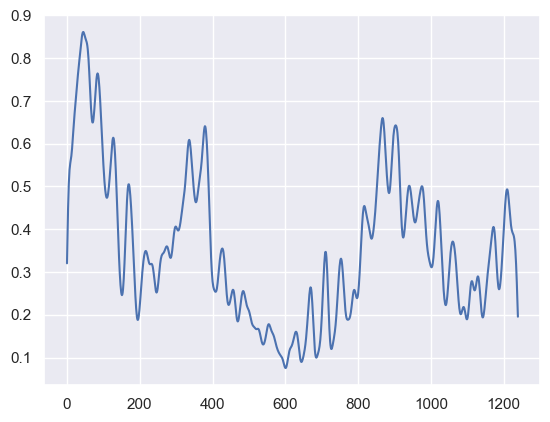

[1610, 4282, 8186]
[ 1687  4124  6233  8108 10358]
14107
cuda
epoch 1,loss = 1.00073493
epoch 2,loss = 1.00071824
epoch 3,loss = 1.00070190
epoch 4,loss = 1.00068581
epoch 5,loss = 1.00066984
epoch 6,loss = 1.00065410
epoch 7,loss = 1.00063860
epoch 8,loss = 1.00062335


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 9,loss = 1.00060797
epoch 10,loss = 1.00059319
epoch 11,loss = 1.00057852
epoch 12,loss = 1.00056398
epoch 13,loss = 1.00054967
epoch 14,loss = 1.00053573
epoch 15,loss = 1.00052166
epoch 16,loss = 1.00050807
epoch 17,loss = 1.00049460
epoch 18,loss = 1.00048137
epoch 19,loss = 1.00046825
epoch 20,loss = 1.00045550
epoch 21,loss = 1.00044274
epoch 22,loss = 1.00043035
epoch 23,loss = 1.00041819
epoch 24,loss = 1.00040603
epoch 25,loss = 1.00039423
epoch 26,loss = 1.00038242
epoch 27,loss = 1.00037110
epoch 28,loss = 1.00035965
epoch 29,loss = 1.00034845
epoch 30,loss = 1.00033760
epoch 31,loss = 1.00032687
epoch 32,loss = 1.00031626
epoch 33,loss = 1.00030589
epoch 34,loss = 1.00029552
epoch 35,loss = 1.00028551
epoch 36,loss = 1.00027549
epoch 37,loss = 1.00026560
epoch 38,loss = 1.00025594
epoch 39,loss = 1.00024652
epoch 40,loss = 1.00023711
epoch 41,loss = 1.00022805
epoch 42,loss = 1.00021899
epoch 43,loss = 1.00021005
epoch 44,loss = 1.00020134
epoch 45,loss = 1.00019264
ep

epoch 316,loss = 0.75924098
epoch 317,loss = 0.75845343
epoch 318,loss = 0.75764424
epoch 319,loss = 0.75682324
epoch 320,loss = 0.75600266
epoch 321,loss = 0.75518698
epoch 322,loss = 0.75437325
epoch 323,loss = 0.75355560
epoch 324,loss = 0.75271827
epoch 325,loss = 0.75187963
epoch 326,loss = 0.75104910
epoch 327,loss = 0.75022328
epoch 328,loss = 0.74940628
epoch 329,loss = 0.74859101
epoch 330,loss = 0.74778199
epoch 331,loss = 0.74697578
epoch 332,loss = 0.74616712
epoch 333,loss = 0.74536675
epoch 334,loss = 0.74457514
epoch 335,loss = 0.74379116
epoch 336,loss = 0.74301338
epoch 337,loss = 0.74224782
epoch 338,loss = 0.74149567
epoch 339,loss = 0.74076575
epoch 340,loss = 0.74006552
epoch 341,loss = 0.73937708
epoch 342,loss = 0.73870146
epoch 343,loss = 0.73805004
epoch 344,loss = 0.73740959
epoch 345,loss = 0.73678839
epoch 346,loss = 0.73618376
epoch 347,loss = 0.73559350
epoch 348,loss = 0.73501980
epoch 349,loss = 0.73445928
epoch 350,loss = 0.73391062
epoch 351,loss = 0.7

epoch 626,loss = 0.69068259
epoch 627,loss = 0.69060808
epoch 628,loss = 0.69053340
epoch 629,loss = 0.69045883
epoch 630,loss = 0.69038409
epoch 631,loss = 0.69030923
epoch 632,loss = 0.69023424
epoch 633,loss = 0.69015974
epoch 634,loss = 0.69008553
epoch 635,loss = 0.69001120
epoch 636,loss = 0.68993700
epoch 637,loss = 0.68986231
epoch 638,loss = 0.68978804
epoch 639,loss = 0.68971413
epoch 640,loss = 0.68964076
epoch 641,loss = 0.68956786
epoch 642,loss = 0.68949497
epoch 643,loss = 0.68942213
epoch 644,loss = 0.68934923
epoch 645,loss = 0.68927664
epoch 646,loss = 0.68920404
epoch 647,loss = 0.68913126
epoch 648,loss = 0.68905872
epoch 649,loss = 0.68898636
epoch 650,loss = 0.68891364
epoch 651,loss = 0.68884075
epoch 652,loss = 0.68876767
epoch 653,loss = 0.68869460
epoch 654,loss = 0.68862116
epoch 655,loss = 0.68854773
epoch 656,loss = 0.68847424
epoch 657,loss = 0.68840069
epoch 658,loss = 0.68832719
epoch 659,loss = 0.68825388
epoch 660,loss = 0.68818063
epoch 661,loss = 0.6

epoch 929,loss = 0.66480917
epoch 930,loss = 0.66471165
epoch 931,loss = 0.66461360
epoch 932,loss = 0.66451645
epoch 933,loss = 0.66442001
epoch 934,loss = 0.66432327
epoch 935,loss = 0.66422474
epoch 936,loss = 0.66412681
epoch 937,loss = 0.66402942
epoch 938,loss = 0.66393256
epoch 939,loss = 0.66383636
epoch 940,loss = 0.66373926
epoch 941,loss = 0.66364264
epoch 942,loss = 0.66354573
epoch 943,loss = 0.66344917
epoch 944,loss = 0.66335309
epoch 945,loss = 0.66325712
epoch 946,loss = 0.66316140
epoch 947,loss = 0.66306591
epoch 948,loss = 0.66297102
epoch 949,loss = 0.66287875
epoch 950,loss = 0.66278738
epoch 951,loss = 0.66269797
epoch 952,loss = 0.66261011
epoch 953,loss = 0.66252339
epoch 954,loss = 0.66243827
epoch 955,loss = 0.66235352
epoch 956,loss = 0.66226935
epoch 957,loss = 0.66218591
epoch 958,loss = 0.66210330
epoch 959,loss = 0.66202146
epoch 960,loss = 0.66194057
epoch 961,loss = 0.66185993
epoch 962,loss = 0.66177672
epoch 963,loss = 0.66169333
epoch 964,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=7.
  warnings.warn(


torch.Size([1761, 1, 20])
1.0
Epoch 200:   loss= 0.16796  cluster difference= 1.0
Epoch 400:   loss= 0.19404  cluster difference= 0.021578648495173196
Epoch 600:   loss= 0.20712  cluster difference= 0.0068143100511073255
[7 6 3 ... 4 6 3]


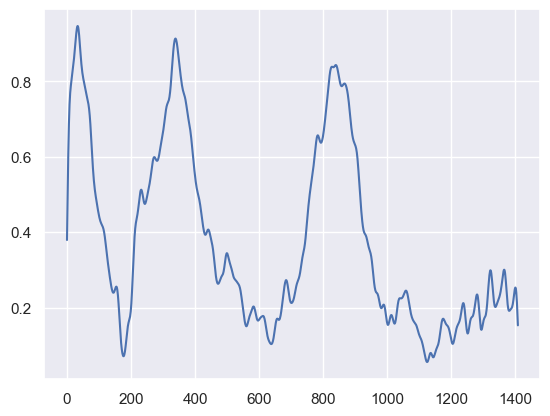

[1682, 4130, 8130]
[ 1687  4124  6233  8108 10358 12420]
7410
cuda
epoch 1,loss = 0.99929607
epoch 2,loss = 0.99928969
epoch 3,loss = 0.99928397
epoch 4,loss = 0.99927968
epoch 5,loss = 0.99927384
epoch 6,loss = 0.99926853
epoch 7,loss = 0.99926347
epoch 8,loss = 0.99925834
epoch 9,loss = 0.99925274
epoch 10,loss = 0.99924660
epoch 11,loss = 0.99924010
epoch 12,loss = 0.99923372
epoch 13,loss = 0.99922687
epoch 14,loss = 0.99921906
epoch 15,loss = 0.99921030
epoch 16,loss = 0.99920136
epoch 17,loss = 0.99919182
epoch 18,loss = 0.99918121
epoch 19,loss = 0.99917018
epoch 20,loss = 0.99915838
epoch 21,loss = 0.99914384
epoch 22,loss = 0.99912608
epoch 23,loss = 0.99910903
epoch 24,loss = 0.99908990
epoch 25,loss = 0.99906701
epoch 26,loss = 0.99903607
epoch 27,loss = 0.99898863
epoch 28,loss = 0.99893326
epoch 29,loss = 0.99889648
epoch 30,loss = 0.99888438
epoch 31,loss = 0.99886465
epoch 32,loss = 0.99883121
epoch 33,loss = 0.99879670
epoch 34,loss = 0.99876988


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 35,loss = 0.99875045
epoch 36,loss = 0.99874026
epoch 37,loss = 0.99872065
epoch 38,loss = 0.99869269
epoch 39,loss = 0.99866426
epoch 40,loss = 0.99863434
epoch 41,loss = 0.99860406
epoch 42,loss = 0.99857581
epoch 43,loss = 0.99854898
epoch 44,loss = 0.99852115
epoch 45,loss = 0.99849081
epoch 46,loss = 0.99845737
epoch 47,loss = 0.99842191
epoch 48,loss = 0.99838489
epoch 49,loss = 0.99834794
epoch 50,loss = 0.99831247
epoch 51,loss = 0.99827492
epoch 52,loss = 0.99823475
epoch 53,loss = 0.99819261
epoch 54,loss = 0.99815100
epoch 55,loss = 0.99811333
epoch 56,loss = 0.99807429
epoch 57,loss = 0.99803096
epoch 58,loss = 0.99798512
epoch 59,loss = 0.99793690
epoch 60,loss = 0.99788874
epoch 61,loss = 0.99783927
epoch 62,loss = 0.99778706
epoch 63,loss = 0.99773163
epoch 64,loss = 0.99767411
epoch 65,loss = 0.99761569
epoch 66,loss = 0.99755692
epoch 67,loss = 0.99749374
epoch 68,loss = 0.99742824
epoch 69,loss = 0.99736094
epoch 70,loss = 0.99729145
epoch 71,loss = 0.99721706
e

epoch 357,loss = 0.67651391
epoch 358,loss = 0.67572850
epoch 359,loss = 0.67495096
epoch 360,loss = 0.67418355
epoch 361,loss = 0.67342895
epoch 362,loss = 0.67268676
epoch 363,loss = 0.67195129
epoch 364,loss = 0.67122912
epoch 365,loss = 0.67051703
epoch 366,loss = 0.66981494
epoch 367,loss = 0.66912442
epoch 368,loss = 0.66844094
epoch 369,loss = 0.66777080
epoch 370,loss = 0.66711062
epoch 371,loss = 0.66646194
epoch 372,loss = 0.66582608
epoch 373,loss = 0.66520137
epoch 374,loss = 0.66459155
epoch 375,loss = 0.66399038
epoch 376,loss = 0.66340154
epoch 377,loss = 0.66282427
epoch 378,loss = 0.66225725
epoch 379,loss = 0.66170239
epoch 380,loss = 0.66116595
epoch 381,loss = 0.66064394
epoch 382,loss = 0.66013461
epoch 383,loss = 0.65963393
epoch 384,loss = 0.65914130
epoch 385,loss = 0.65865892
epoch 386,loss = 0.65818012
epoch 387,loss = 0.65771091
epoch 388,loss = 0.65724856
epoch 389,loss = 0.65679783
epoch 390,loss = 0.65635556
epoch 391,loss = 0.65592009
epoch 392,loss = 0.6

epoch 687,loss = 0.62585682
epoch 688,loss = 0.62583500
epoch 689,loss = 0.62582922
epoch 690,loss = 0.62581939
epoch 691,loss = 0.62580121
epoch 692,loss = 0.62575787
epoch 693,loss = 0.62581563
epoch 694,loss = 0.62571567
epoch 695,loss = 0.62572062
epoch 696,loss = 0.62568551
epoch 697,loss = 0.62564236
epoch 698,loss = 0.62563020
epoch 699,loss = 0.62558019
epoch 700,loss = 0.62556881
epoch 701,loss = 0.62552929
epoch 702,loss = 0.62549639
epoch 703,loss = 0.62547517
epoch 704,loss = 0.62543041
epoch 705,loss = 0.62541050
epoch 706,loss = 0.62537420
epoch 707,loss = 0.62534565
epoch 708,loss = 0.62532151
epoch 709,loss = 0.62528521
epoch 710,loss = 0.62526059
epoch 711,loss = 0.62522995
epoch 712,loss = 0.62520015
epoch 713,loss = 0.62517577
epoch 714,loss = 0.62514776
epoch 715,loss = 0.62512189
epoch 716,loss = 0.62509739
epoch 717,loss = 0.62506890
epoch 718,loss = 0.62504983
epoch 719,loss = 0.62501895
epoch 720,loss = 0.62500232
epoch 721,loss = 0.62497628
epoch 722,loss = 0.6

epoch 992,loss = 0.62077475
epoch 993,loss = 0.62073690
epoch 994,loss = 0.62079948
epoch 995,loss = 0.62081873
epoch 996,loss = 0.62079203
epoch 997,loss = 0.62075388
epoch 998,loss = 0.62068880
epoch 999,loss = 0.62069529
epoch 1000,loss = 0.62066472
epoch 1001,loss = 0.62067258
epoch 1002,loss = 0.62069815
epoch 1003,loss = 0.62066656
epoch 1004,loss = 0.62066662
epoch 1005,loss = 0.62061507
epoch 1006,loss = 0.62061602
epoch 1007,loss = 0.62058914
epoch 1008,loss = 0.62057418
epoch 1009,loss = 0.62056315
epoch 1010,loss = 0.62055373
epoch 1011,loss = 0.62054807
epoch 1012,loss = 0.62052852
epoch 1013,loss = 0.62051940
epoch 1014,loss = 0.62050647
epoch 1015,loss = 0.62049711
epoch 1016,loss = 0.62049925
epoch 1017,loss = 0.62049371
epoch 1018,loss = 0.62048376
epoch 1019,loss = 0.62045473
epoch 1020,loss = 0.62044406
epoch 1021,loss = 0.62043244
epoch 1022,loss = 0.62042218
epoch 1023,loss = 0.62041229
epoch 1024,loss = 0.62041569
epoch 1025,loss = 0.62040043
epoch 1026,loss = 0.62

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([368, 1, 50])
1.0
Epoch 200:   loss= 0.09077  cluster difference= 1.0
Epoch 400:   loss= 0.11342  cluster difference= 0.11413043478260869
Epoch 600:   loss= 0.12643  cluster difference= 0.059782608695652176
Epoch 800:   loss= 0.13458  cluster difference= 0.08152173913043478
Epoch 1000:   loss= 0.14017  cluster difference= 0.09782608695652174
Epoch 1200:   loss= 0.14413  cluster difference= 0.22554347826086957
Epoch 1400:   loss= 0.14705  cluster difference= 0.04891304347826087
Epoch 1600:   loss= 0.1493  cluster difference= 0.10869565217391304
Epoch 1800:   loss= 0.1512  cluster difference= 0.14402173913043478
Epoch 2000:   loss= 0.15282  cluster difference= 0.043478260869565216
Epoch 2200:   loss= 0.15425  cluster difference= 0.24728260869565216
Epoch 2400:   loss= 0.15568  cluster difference= 0.09782608695652174
Epoch 2600:   loss= 0.15728  cluster difference= 0.005434782608695652
[4 1 1 3 3 1 7 7 2 2 0 7 2 0 4 5 1 3 3 3 1 5 6 2 2 7 2 0 4 5 1 3 3 3 1 1 6
 2 2 5 6 2 4 4 1 3

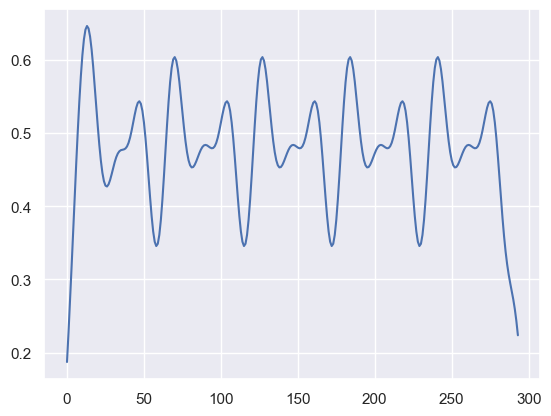

[1025, 2165, 3305, 4445, 5585]
[1425 3705]
2080
cuda
epoch 1,loss = 1.11361992
epoch 2,loss = 1.11232901
epoch 3,loss = 1.11104321
epoch 4,loss = 1.10976219
epoch 5,loss = 1.10848534
epoch 6,loss = 1.10721159
epoch 7,loss = 1.10594153
epoch 8,loss = 1.10467553
epoch 9,loss = 1.10341299
epoch 10,loss = 1.10215473
epoch 11,loss = 1.10090029
epoch 12,loss = 1.09965122
epoch 13,loss = 1.09840834
epoch 14,loss = 1.09717178
epoch 15,loss = 1.09594333
epoch 16,loss = 1.09472334
epoch 17,loss = 1.09351456
epoch 18,loss = 1.09231257
epoch 19,loss = 1.09112203
epoch 20,loss = 1.08994007
epoch 21,loss = 1.08876848
epoch 22,loss = 1.08760870
epoch 23,loss = 1.08646083
epoch 24,loss = 1.08532989
epoch 25,loss = 1.08421922
epoch 26,loss = 1.08312595
epoch 27,loss = 1.08205247
epoch 28,loss = 1.08099735
epoch 29,loss = 1.07995749
epoch 30,loss = 1.07892966
epoch 31,loss = 1.07791436
epoch 32,loss = 1.07691038
epoch 33,loss = 1.07591677
epoch 34,loss = 1.07493436
epoch 35,loss = 1.07396209
epoch 36,lo

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 46,loss = 1.06402516
epoch 47,loss = 1.06319499
epoch 48,loss = 1.06237721
epoch 49,loss = 1.06157231
epoch 50,loss = 1.06078005
epoch 51,loss = 1.06000042
epoch 52,loss = 1.05923355
epoch 53,loss = 1.05847931
epoch 54,loss = 1.05773795
epoch 55,loss = 1.05700922
epoch 56,loss = 1.05629337
epoch 57,loss = 1.05559039
epoch 58,loss = 1.05490053
epoch 59,loss = 1.05422330
epoch 60,loss = 1.05355859
epoch 61,loss = 1.05290627
epoch 62,loss = 1.05226624
epoch 63,loss = 1.05163872
epoch 64,loss = 1.05102372
epoch 65,loss = 1.05042052
epoch 66,loss = 1.04982972
epoch 67,loss = 1.04925048
epoch 68,loss = 1.04868329
epoch 69,loss = 1.04812765
epoch 70,loss = 1.04758298
epoch 71,loss = 1.04704857
epoch 72,loss = 1.04652452
epoch 73,loss = 1.04601073
epoch 74,loss = 1.04550791
epoch 75,loss = 1.04501545
epoch 76,loss = 1.04453254
epoch 77,loss = 1.04405892
epoch 78,loss = 1.04359365
epoch 79,loss = 1.04313648
epoch 80,loss = 1.04268265
epoch 81,loss = 1.04223084
epoch 82,loss = 1.04177058
e

epoch 368,loss = 0.87935585
epoch 369,loss = 0.87916172
epoch 370,loss = 0.87897104
epoch 371,loss = 0.87878388
epoch 372,loss = 0.87859774
epoch 373,loss = 0.87841231
epoch 374,loss = 0.87822920
epoch 375,loss = 0.87804931
epoch 376,loss = 0.87787265
epoch 377,loss = 0.87769878
epoch 378,loss = 0.87752819
epoch 379,loss = 0.87735891
epoch 380,loss = 0.87719309
epoch 381,loss = 0.87702978
epoch 382,loss = 0.87686795
epoch 383,loss = 0.87670851
epoch 384,loss = 0.87655264
epoch 385,loss = 0.87639737
epoch 386,loss = 0.87624323
epoch 387,loss = 0.87609398
epoch 388,loss = 0.87594837
epoch 389,loss = 0.87580502
epoch 390,loss = 0.87566411
epoch 391,loss = 0.87552530
epoch 392,loss = 0.87538928
epoch 393,loss = 0.87525380
epoch 394,loss = 0.87511772
epoch 395,loss = 0.87498295
epoch 396,loss = 0.87485021
epoch 397,loss = 0.87471879
epoch 398,loss = 0.87458968
epoch 399,loss = 0.87446296
epoch 400,loss = 0.87433779
epoch 401,loss = 0.87421381
epoch 402,loss = 0.87408835
epoch 403,loss = 0.8

epoch 672,loss = 0.82684147
epoch 673,loss = 0.82674956
epoch 674,loss = 0.82665634
epoch 675,loss = 0.82656288
epoch 676,loss = 0.82646960
epoch 677,loss = 0.82637703
epoch 678,loss = 0.82628465
epoch 679,loss = 0.82619286
epoch 680,loss = 0.82610053
epoch 681,loss = 0.82600683
epoch 682,loss = 0.82591408
epoch 683,loss = 0.82582277
epoch 684,loss = 0.82573205
epoch 685,loss = 0.82564217
epoch 686,loss = 0.82555300
epoch 687,loss = 0.82546407
epoch 688,loss = 0.82537556
epoch 689,loss = 0.82528549
epoch 690,loss = 0.82519436
epoch 691,loss = 0.82510161
epoch 692,loss = 0.82500821
epoch 693,loss = 0.82491297
epoch 694,loss = 0.82481658
epoch 695,loss = 0.82471925
epoch 696,loss = 0.82462043
epoch 697,loss = 0.82452023
epoch 698,loss = 0.82442033
epoch 699,loss = 0.82432038
epoch 700,loss = 0.82421863
epoch 701,loss = 0.82411718
epoch 702,loss = 0.82401550
epoch 703,loss = 0.82391423
epoch 704,loss = 0.82381159
epoch 705,loss = 0.82370794
epoch 706,loss = 0.82360309
epoch 707,loss = 0.8

epoch 973,loss = 0.79131752
epoch 974,loss = 0.79123682
epoch 975,loss = 0.79115456
epoch 976,loss = 0.79107094
epoch 977,loss = 0.79098701
epoch 978,loss = 0.79090375
epoch 979,loss = 0.79082048
epoch 980,loss = 0.79073733
epoch 981,loss = 0.79065889
epoch 982,loss = 0.79058361
epoch 983,loss = 0.79051173
epoch 984,loss = 0.79043669
epoch 985,loss = 0.79036039
epoch 986,loss = 0.79028356
epoch 987,loss = 0.79020864
epoch 988,loss = 0.79013580
epoch 989,loss = 0.79006624
epoch 990,loss = 0.78999704
epoch 991,loss = 0.78992534
epoch 992,loss = 0.78985214
epoch 993,loss = 0.78977978
epoch 994,loss = 0.78969902
epoch 995,loss = 0.78961819
epoch 996,loss = 0.78953642
epoch 997,loss = 0.78945291
epoch 998,loss = 0.78936720
epoch 999,loss = 0.78927940
epoch 1000,loss = 0.78919268
epoch 1001,loss = 0.78910613
epoch 1002,loss = 0.78901643
epoch 1003,loss = 0.78892910
epoch 1004,loss = 0.78884482
epoch 1005,loss = 0.78876108
epoch 1006,loss = 0.78867871
epoch 1007,loss = 0.78859681
epoch 1008,l

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([258, 1, 20])
1.0
Epoch 200:   loss= 0.21313  cluster difference= 1.0
Epoch 400:   loss= 0.21271  cluster difference= 0.03875968992248062
Epoch 600:   loss= 0.21154  cluster difference= 0.027131782945736434
Epoch 800:   loss= 0.21  cluster difference= 0.007751937984496124
[0 0 3 3 5 3 4 3 4 0 3 3 3 3 4 3 6 2 4 3 3 3 5 0 1 2 3 3 3 3 0 3 3 5 6 2 6
 3 4 5 0 3 3 5 3 3 3 0 3 3 0 3 3 3 3 3 4 3 3 3 0 3 3 3 3 3 3 6 2 3 0 3 3 3
 3 3 4 3 3 0 2 3 3 3 3 5 3 4 3 4 3 3 4 5 3 3 1 2 6 2 3 3 6 2 3 3 4 0 3 3 3
 3 6 2 0 6 7 1 2 0 6 2 5 0 3 4 3 4 6 2 3 4 1 2 0 3 4 4 6 2 5 3 3 6 7 6 7 4
 4 0 5 2 0 2 0 6 7 0 3 1 2 4 1 2 3 3 4 5 3 6 7 1 2 3 0 3 6 2 0 2 0 6 7 3 0
 6 7 5 3 0 6 7 1 2 0 6 7 0 3 0 3 4 5 6 2 0 3 1 2 3 6 2 0 2 5 6 7 3 3 0 4 3
 6 2 1 6 2 5 3 0 3 4 5 3 0 6 7 5 3 0 6 2 6 5 6 2 4 4 3 0 5 3 5 3 0 3 4 5]


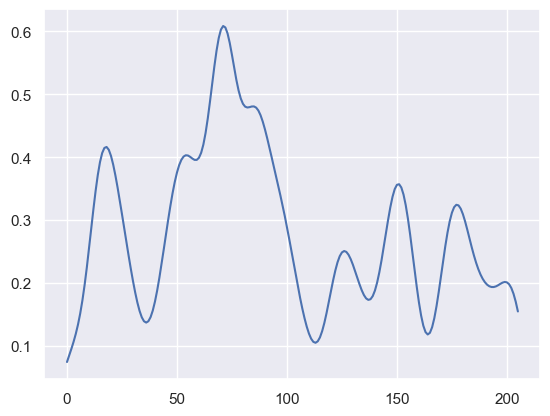

[786]
[ 907 1680]
3780
cuda
epoch 1,loss = 1.13120973
epoch 2,loss = 1.13000226
epoch 3,loss = 1.12880135
epoch 4,loss = 1.12760735
epoch 5,loss = 1.12642014
epoch 6,loss = 1.12523985
epoch 7,loss = 1.12406647
epoch 8,loss = 1.12290001
epoch 9,loss = 1.12174070
epoch 10,loss = 1.12058854
epoch 11,loss = 1.11944342
epoch 12,loss = 1.11830556
epoch 13,loss = 1.11717474
epoch 14,loss = 1.11605108
epoch 15,loss = 1.11493444
epoch 16,loss = 1.11382484
epoch 17,loss = 1.11272228
epoch 18,loss = 1.11162663
epoch 19,loss = 1.11053777
epoch 20,loss = 1.10945594
epoch 21,loss = 1.10838056
epoch 22,loss = 1.10731184
epoch 23,loss = 1.10624945
epoch 24,loss = 1.10519361
epoch 25,loss = 1.10414410
epoch 26,loss = 1.10310090
epoch 27,loss = 1.10206389
epoch 28,loss = 1.10103309
epoch 29,loss = 1.10000825
epoch 30,loss = 1.09898961
epoch 31,loss = 1.09797680
epoch 32,loss = 1.09697020
epoch 33,loss = 1.09596932
epoch 34,loss = 1.09497452
epoch 35,loss = 1.09398556
epoch 36,loss = 1.09300244
epoch 37,

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 42,loss = 1.08722544
epoch 43,loss = 1.08628261
epoch 44,loss = 1.08534515
epoch 45,loss = 1.08441353
epoch 46,loss = 1.08348751
epoch 47,loss = 1.08256674
epoch 48,loss = 1.08165157
epoch 49,loss = 1.08074212
epoch 50,loss = 1.07983792
epoch 51,loss = 1.07893908
epoch 52,loss = 1.07804561
epoch 53,loss = 1.07715762
epoch 54,loss = 1.07627487
epoch 55,loss = 1.07539749
epoch 56,loss = 1.07452524
epoch 57,loss = 1.07365811
epoch 58,loss = 1.07279623
epoch 59,loss = 1.07193971
epoch 60,loss = 1.07108808
epoch 61,loss = 1.07024157
epoch 62,loss = 1.06940031
epoch 63,loss = 1.06856394
epoch 64,loss = 1.06773257
epoch 65,loss = 1.06690609
epoch 66,loss = 1.06608474
epoch 67,loss = 1.06526804
epoch 68,loss = 1.06445634
epoch 69,loss = 1.06364942
epoch 70,loss = 1.06284738
epoch 71,loss = 1.06205010
epoch 72,loss = 1.06125772
epoch 73,loss = 1.06046975
epoch 74,loss = 1.05968666
epoch 75,loss = 1.05890822
epoch 76,loss = 1.05813444
epoch 77,loss = 1.05736518
epoch 78,loss = 1.05660057
e

epoch 350,loss = 0.87943101
epoch 351,loss = 0.87812912
epoch 352,loss = 0.87686926
epoch 353,loss = 0.87565780
epoch 354,loss = 0.87448990
epoch 355,loss = 0.87335563
epoch 356,loss = 0.87223089
epoch 357,loss = 0.87110990
epoch 358,loss = 0.86997741
epoch 359,loss = 0.86882585
epoch 360,loss = 0.86766809
epoch 361,loss = 0.86650318
epoch 362,loss = 0.86533833
epoch 363,loss = 0.86417788
epoch 364,loss = 0.86303508
epoch 365,loss = 0.86189467
epoch 366,loss = 0.86075246
epoch 367,loss = 0.85961837
epoch 368,loss = 0.85848933
epoch 369,loss = 0.85735840
epoch 370,loss = 0.85623038
epoch 371,loss = 0.85511011
epoch 372,loss = 0.85399306
epoch 373,loss = 0.85287911
epoch 374,loss = 0.85175407
epoch 375,loss = 0.85062242
epoch 376,loss = 0.84948051
epoch 377,loss = 0.84833896
epoch 378,loss = 0.84719849
epoch 379,loss = 0.84606737
epoch 380,loss = 0.84493685
epoch 381,loss = 0.84380788
epoch 382,loss = 0.84270102
epoch 383,loss = 0.84159285
epoch 384,loss = 0.84048575
epoch 385,loss = 0.8

epoch 649,loss = 0.68925822
epoch 650,loss = 0.68844533
epoch 651,loss = 0.68762559
epoch 652,loss = 0.68680537
epoch 653,loss = 0.68600118
epoch 654,loss = 0.68519926
epoch 655,loss = 0.68438846
epoch 656,loss = 0.68358475
epoch 657,loss = 0.68278515
epoch 658,loss = 0.68198854
epoch 659,loss = 0.68119276
epoch 660,loss = 0.68040818
epoch 661,loss = 0.67963022
epoch 662,loss = 0.67885834
epoch 663,loss = 0.67808968
epoch 664,loss = 0.67733300
epoch 665,loss = 0.67658627
epoch 666,loss = 0.67586297
epoch 667,loss = 0.67516518
epoch 668,loss = 0.67449033
epoch 669,loss = 0.67383093
epoch 670,loss = 0.67318475
epoch 671,loss = 0.67255288
epoch 672,loss = 0.67192644
epoch 673,loss = 0.67130059
epoch 674,loss = 0.67068535
epoch 675,loss = 0.67008281
epoch 676,loss = 0.66949153
epoch 677,loss = 0.66891837
epoch 678,loss = 0.66835707
epoch 679,loss = 0.66779566
epoch 680,loss = 0.66723228
epoch 681,loss = 0.66667360
epoch 682,loss = 0.66612458
epoch 683,loss = 0.66558385
epoch 684,loss = 0.6

epoch 958,loss = 0.58831459
epoch 959,loss = 0.58820158
epoch 960,loss = 0.58808804
epoch 961,loss = 0.58797473
epoch 962,loss = 0.58786285
epoch 963,loss = 0.58775371
epoch 964,loss = 0.58764261
epoch 965,loss = 0.58753043
epoch 966,loss = 0.58741689
epoch 967,loss = 0.58730477
epoch 968,loss = 0.58719331
epoch 969,loss = 0.58708274
epoch 970,loss = 0.58697295
epoch 971,loss = 0.58686286
epoch 972,loss = 0.58675259
epoch 973,loss = 0.58664322
epoch 974,loss = 0.58653545
epoch 975,loss = 0.58642900
epoch 976,loss = 0.58632243
epoch 977,loss = 0.58621603
epoch 978,loss = 0.58611023
epoch 979,loss = 0.58599138
epoch 980,loss = 0.58583939
epoch 981,loss = 0.58567238
epoch 982,loss = 0.58552253
epoch 983,loss = 0.58538550
epoch 984,loss = 0.58525336
epoch 985,loss = 0.58512312
epoch 986,loss = 0.58498502
epoch 987,loss = 0.58484113
epoch 988,loss = 0.58469045
epoch 989,loss = 0.58453727
epoch 990,loss = 0.58438569
epoch 991,loss = 0.58422118
epoch 992,loss = 0.58404589
epoch 993,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([470, 1, 20])
1.0
Epoch 200:   loss= 0.17834  cluster difference= 1.0
Epoch 400:   loss= 0.1771  cluster difference= 0.00851063829787234
[7 2 4 1 6 0 2 3 2 7 5 4 1 6 0 2 3 2 7 5 4 1 6 0 2 3 2 7 5 4 1 6 5 2 3 2 0
 0 4 1 6 0 2 3 2 0 0 4 1 6 0 2 3 2 7 5 4 1 6 5 2 3 2 7 5 4 1 6 5 2 3 2 7 5
 4 1 6 5 2 3 2 7 5 4 1 6 5 2 3 2 7 2 4 1 6 0 2 3 2 7 5 4 1 6 5 2 3 2 7 5 4
 1 6 5 2 3 2 7 5 4 1 6 0 2 3 2 7 5 4 1 6 5 2 3 2 7 2 4 1 6 5 2 3 2 7 2 4 1
 6 5 2 3 2 7 2 4 1 6 5 2 3 2 7 2 4 1 6 5 2 3 4 4 5 2 7 0 0 2 6 2 5 5 0 7 0
 0 2 6 4 5 5 2 7 0 0 6 6 4 5 5 0 7 0 0 2 6 2 5 5 2 7 0 0 2 6 2 5 5 0 7 0 0
 2 6 4 5 5 2 7 0 0 2 6 4 5 5 0 7 0 0 2 6 2 0 2 6 5 2 0 2 6 5 4 5 2 7 2 0 2
 6 5 4 5 4 7 2 0 2 6 5 4 5 4 7 2 7 2 3 5 4 5 2 7 2 3 2 6 5 4 5 4 1 0 7 2 0
 2 4 5 4 7 6 5 2 3 2 0 2 4 1 6 5 2 3 2 0 2 4 1 6 5 2 3 2 0 2 4 1 6 5 2 3 2
 0 2 4 1 6 5 2 3 2 0 2 4 1 6 5 2 3 2 0 2 4 1 6 5 2 3 2 0 2 4 1 6 5 2 3 2 0
 2 4 1 6 5 2 3 2 7 2 4 1 2 0 2 3 2 6 2 4 1 2 0 2 3 2 0 2 4 1 2 0 2 3 2 6 2
 4 1 2 0 2 3 2 6 2 4 1 2 0 

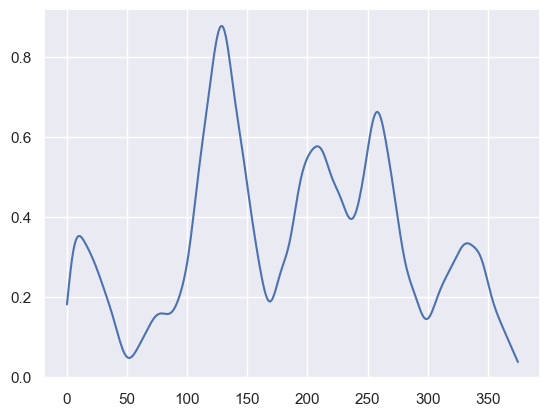

[1418, 2450]
[ 540 1044 1368 1944 2412 3060]
4000
cuda
epoch 1,loss = 1.00646865
epoch 2,loss = 1.00617576
epoch 3,loss = 1.00588942
epoch 4,loss = 1.00561011
epoch 5,loss = 1.00533783
epoch 6,loss = 1.00507259
epoch 7,loss = 1.00481439
epoch 8,loss = 1.00456345
epoch 9,loss = 1.00431967
epoch 10,loss = 1.00408280
epoch 11,loss = 1.00385344
epoch 12,loss = 1.00363111
epoch 13,loss = 1.00341582
epoch 14,loss = 1.00320792
epoch 15,loss = 1.00300682
epoch 16,loss = 1.00281286
epoch 17,loss = 1.00262570
epoch 18,loss = 1.00244558
epoch 19,loss = 1.00227582
epoch 20,loss = 1.00211561
epoch 21,loss = 1.00196195
epoch 22,loss = 1.00181270
epoch 23,loss = 1.00166845
epoch 24,loss = 1.00152981
epoch 25,loss = 1.00139725
epoch 26,loss = 1.00126994
epoch 27,loss = 1.00114322
epoch 28,loss = 1.00102508
epoch 29,loss = 1.00091028
epoch 30,loss = 1.00080049
epoch 31,loss = 1.00069559
epoch 32,loss = 1.00059557
epoch 33,loss = 1.00050008
epoch 34,loss = 1.00040913
epoch 35,loss = 1.00032234
epoch 36,

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 46,loss = 0.99961722
epoch 47,loss = 0.99957490
epoch 48,loss = 0.99953145
epoch 49,loss = 0.99949723
epoch 50,loss = 0.99946594
epoch 51,loss = 0.99943888
epoch 52,loss = 0.99942142
epoch 53,loss = 0.99940038
epoch 54,loss = 0.99938488
epoch 55,loss = 0.99936849
epoch 56,loss = 0.99935132
epoch 57,loss = 0.99933380
epoch 58,loss = 0.99931586
epoch 59,loss = 0.99929768
epoch 60,loss = 0.99927914
epoch 61,loss = 0.99926054
epoch 62,loss = 0.99924171
epoch 63,loss = 0.99922270
epoch 64,loss = 0.99920386
epoch 65,loss = 0.99918455
epoch 66,loss = 0.99916536
epoch 67,loss = 0.99914622
epoch 68,loss = 0.99912727
epoch 69,loss = 0.99910855
epoch 70,loss = 0.99908996
epoch 71,loss = 0.99907148
epoch 72,loss = 0.99905324
epoch 73,loss = 0.99903530
epoch 74,loss = 0.99901748
epoch 75,loss = 0.99899995
epoch 76,loss = 0.99898249
epoch 77,loss = 0.99896532
epoch 78,loss = 0.99894875
epoch 79,loss = 0.99893343
epoch 80,loss = 0.99891734
epoch 81,loss = 0.99890071
epoch 82,loss = 0.99888325
e

epoch 358,loss = 0.74784482
epoch 359,loss = 0.74671966
epoch 360,loss = 0.74558693
epoch 361,loss = 0.74445254
epoch 362,loss = 0.74332076
epoch 363,loss = 0.74219567
epoch 364,loss = 0.74108094
epoch 365,loss = 0.73998713
epoch 366,loss = 0.73891670
epoch 367,loss = 0.73786533
epoch 368,loss = 0.73682797
epoch 369,loss = 0.73581034
epoch 370,loss = 0.73480850
epoch 371,loss = 0.73381764
epoch 372,loss = 0.73283696
epoch 373,loss = 0.73186761
epoch 374,loss = 0.73091018
epoch 375,loss = 0.72996402
epoch 376,loss = 0.72902912
epoch 377,loss = 0.72810572
epoch 378,loss = 0.72719491
epoch 379,loss = 0.72629702
epoch 380,loss = 0.72541153
epoch 381,loss = 0.72453934
epoch 382,loss = 0.72368044
epoch 383,loss = 0.72283477
epoch 384,loss = 0.72200298
epoch 385,loss = 0.72118521
epoch 386,loss = 0.72038233
epoch 387,loss = 0.71959436
epoch 388,loss = 0.71882051
epoch 389,loss = 0.71806115
epoch 390,loss = 0.71731722
epoch 391,loss = 0.71658874
epoch 392,loss = 0.71587819
epoch 393,loss = 0.7

epoch 658,loss = 0.68165892
epoch 659,loss = 0.68161625
epoch 660,loss = 0.68157357
epoch 661,loss = 0.68153113
epoch 662,loss = 0.68148875
epoch 663,loss = 0.68144661
epoch 664,loss = 0.68140435
epoch 665,loss = 0.68136221
epoch 666,loss = 0.68132019
epoch 667,loss = 0.68127823
epoch 668,loss = 0.68123645
epoch 669,loss = 0.68119454
epoch 670,loss = 0.68115258
epoch 671,loss = 0.68111056
epoch 672,loss = 0.68106842
epoch 673,loss = 0.68102616
epoch 674,loss = 0.68098390
epoch 675,loss = 0.68094128
epoch 676,loss = 0.68089873
epoch 677,loss = 0.68085593
epoch 678,loss = 0.68081313
epoch 679,loss = 0.68077034
epoch 680,loss = 0.68072760
epoch 681,loss = 0.68068498
epoch 682,loss = 0.68064231
epoch 683,loss = 0.68059939
epoch 684,loss = 0.68055624
epoch 685,loss = 0.68051291
epoch 686,loss = 0.68046957
epoch 687,loss = 0.68042612
epoch 688,loss = 0.68038237
epoch 689,loss = 0.68033856
epoch 690,loss = 0.68029475
epoch 691,loss = 0.68025070
epoch 692,loss = 0.68020636
epoch 693,loss = 0.6

epoch 963,loss = 0.67218965
epoch 964,loss = 0.67217153
epoch 965,loss = 0.67215335
epoch 966,loss = 0.67213535
epoch 967,loss = 0.67211723
epoch 968,loss = 0.67209917
epoch 969,loss = 0.67208111
epoch 970,loss = 0.67206305
epoch 971,loss = 0.67204511
epoch 972,loss = 0.67202711
epoch 973,loss = 0.67200917
epoch 974,loss = 0.67199117
epoch 975,loss = 0.67197329
epoch 976,loss = 0.67195529
epoch 977,loss = 0.67193741
epoch 978,loss = 0.67191964
epoch 979,loss = 0.67190176
epoch 980,loss = 0.67188394
epoch 981,loss = 0.67186618
epoch 982,loss = 0.67184842
epoch 983,loss = 0.67183059
epoch 984,loss = 0.67181289
epoch 985,loss = 0.67179519
epoch 986,loss = 0.67177749
epoch 987,loss = 0.67175990
epoch 988,loss = 0.67174226
epoch 989,loss = 0.67172462
epoch 990,loss = 0.67170703
epoch 991,loss = 0.67168945
epoch 992,loss = 0.67167187
epoch 993,loss = 0.67165440
epoch 994,loss = 0.67163688
epoch 995,loss = 0.67161942
epoch 996,loss = 0.67160195
epoch 997,loss = 0.67158449
epoch 998,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([498, 1, 20])
1.0
Epoch 200:   loss= 0.124  cluster difference= 1.0
Epoch 400:   loss= 0.1194  cluster difference= 0.002008032128514056
[4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 1 6 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3
 2 5 0 4 3 2 5 0 4 3 2 5 6 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5
 0 4 3 2 5 0 4 7 2 5 0 4 3 2 1 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4
 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 1 0 4 3 2
 5 0 4 3 2 5 0 4 7 2 5 0 4 3 2 5 0 4 3 2 5 6 4 7 2 5 0 4 3 2 5 0 4 3 2 5 0
 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 7 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3
 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5
 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4
 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2
 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0
 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3 2 5 0 4 3
 2 5 0 4 3 2 5 0 4 3 2 5 0 4

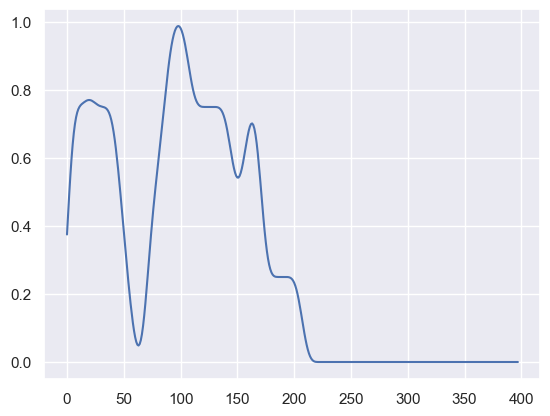

[562, 1194, 1714]
[ 720 2110]
4000
cuda
epoch 1,loss = 1.00207531
epoch 2,loss = 1.00204670
epoch 3,loss = 1.00201821
epoch 4,loss = 1.00199020
epoch 5,loss = 1.00196242
epoch 6,loss = 1.00193512
epoch 7,loss = 1.00190806
epoch 8,loss = 1.00188112
epoch 9,loss = 1.00185466
epoch 10,loss = 1.00182855
epoch 11,loss = 1.00180268
epoch 12,loss = 1.00177717
epoch 13,loss = 1.00175190
epoch 14,loss = 1.00172710
epoch 15,loss = 1.00170243
epoch 16,loss = 1.00167799
epoch 17,loss = 1.00165415
epoch 18,loss = 1.00163043
epoch 19,loss = 1.00160706
epoch 20,loss = 1.00158393
epoch 21,loss = 1.00156128
epoch 22,loss = 1.00153875
epoch 23,loss = 1.00151658
epoch 24,loss = 1.00149465
epoch 25,loss = 1.00147307
epoch 26,loss = 1.00145173
epoch 27,loss = 1.00143075
epoch 28,loss = 1.00140989
epoch 29,loss = 1.00138938
epoch 30,loss = 1.00136900
epoch 31,loss = 1.00134909
epoch 32,loss = 1.00132930
epoch 33,loss = 1.00130975


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 34,loss = 1.00129056
epoch 35,loss = 1.00127149
epoch 36,loss = 1.00125265
epoch 37,loss = 1.00123405
epoch 38,loss = 1.00121570
epoch 39,loss = 1.00119758
epoch 40,loss = 1.00117970
epoch 41,loss = 1.00116193
epoch 42,loss = 1.00114441
epoch 43,loss = 1.00112700
epoch 44,loss = 1.00110972
epoch 45,loss = 1.00109279
epoch 46,loss = 1.00107598
epoch 47,loss = 1.00105929
epoch 48,loss = 1.00104272
epoch 49,loss = 1.00102615
epoch 50,loss = 1.00100994
epoch 51,loss = 1.00099373
epoch 52,loss = 1.00097752
epoch 53,loss = 1.00096166
epoch 54,loss = 1.00094581
epoch 55,loss = 1.00093007
epoch 56,loss = 1.00091445
epoch 57,loss = 1.00089896
epoch 58,loss = 1.00088358
epoch 59,loss = 1.00086820
epoch 60,loss = 1.00085282
epoch 61,loss = 1.00083780
epoch 62,loss = 1.00082266
epoch 63,loss = 1.00080752
epoch 64,loss = 1.00079262
epoch 65,loss = 1.00077772
epoch 66,loss = 1.00076306
epoch 67,loss = 1.00074828
epoch 68,loss = 1.00073361
epoch 69,loss = 1.00071895
epoch 70,loss = 1.00070453
e

epoch 360,loss = 0.67892933
epoch 361,loss = 0.67850661
epoch 362,loss = 0.67809147
epoch 363,loss = 0.67768586
epoch 364,loss = 0.67728889
epoch 365,loss = 0.67690098
epoch 366,loss = 0.67652160
epoch 367,loss = 0.67615044
epoch 368,loss = 0.67578703
epoch 369,loss = 0.67543066
epoch 370,loss = 0.67508167
epoch 371,loss = 0.67473978
epoch 372,loss = 0.67440474
epoch 373,loss = 0.67407668
epoch 374,loss = 0.67375541
epoch 375,loss = 0.67344052
epoch 376,loss = 0.67313206
epoch 377,loss = 0.67282993
epoch 378,loss = 0.67253429
epoch 379,loss = 0.67224503
epoch 380,loss = 0.67196167
epoch 381,loss = 0.67168421
epoch 382,loss = 0.67141235
epoch 383,loss = 0.67114562
epoch 384,loss = 0.67088366
epoch 385,loss = 0.67062634
epoch 386,loss = 0.67037362
epoch 387,loss = 0.67012537
epoch 388,loss = 0.66988122
epoch 389,loss = 0.66964090
epoch 390,loss = 0.66940284
epoch 391,loss = 0.66916823
epoch 392,loss = 0.66893613
epoch 393,loss = 0.66870475
epoch 394,loss = 0.66847122
epoch 395,loss = 0.6

epoch 658,loss = 0.60427380
epoch 659,loss = 0.60404193
epoch 660,loss = 0.60381216
epoch 661,loss = 0.60358518
epoch 662,loss = 0.60336071
epoch 663,loss = 0.60313934
epoch 664,loss = 0.60292041
epoch 665,loss = 0.60270429
epoch 666,loss = 0.60249013
epoch 667,loss = 0.60227776
epoch 668,loss = 0.60206801
epoch 669,loss = 0.60186034
epoch 670,loss = 0.60165507
epoch 671,loss = 0.60145271
epoch 672,loss = 0.60125238
epoch 673,loss = 0.60105312
epoch 674,loss = 0.60085571
epoch 675,loss = 0.60066080
epoch 676,loss = 0.60046732
epoch 677,loss = 0.60027486
epoch 678,loss = 0.60008246
epoch 679,loss = 0.59988987
epoch 680,loss = 0.59969723
epoch 681,loss = 0.59950513
epoch 682,loss = 0.59931123
epoch 683,loss = 0.59911638
epoch 684,loss = 0.59891665
epoch 685,loss = 0.59871536
epoch 686,loss = 0.59851122
epoch 687,loss = 0.59830654
epoch 688,loss = 0.59810352
epoch 689,loss = 0.59790403
epoch 690,loss = 0.59770864
epoch 691,loss = 0.59751654
epoch 692,loss = 0.59732777
epoch 693,loss = 0.5

epoch 960,loss = 0.55138767
epoch 961,loss = 0.55131286
epoch 962,loss = 0.55124003
epoch 963,loss = 0.55116862
epoch 964,loss = 0.55109721
epoch 965,loss = 0.55102503
epoch 966,loss = 0.55095363
epoch 967,loss = 0.55088252
epoch 968,loss = 0.55081576
epoch 969,loss = 0.55075067
epoch 970,loss = 0.55068713
epoch 971,loss = 0.55062449
epoch 972,loss = 0.55056328
epoch 973,loss = 0.55050367
epoch 974,loss = 0.55044562
epoch 975,loss = 0.55038899
epoch 976,loss = 0.55033404
epoch 977,loss = 0.55028003
epoch 978,loss = 0.55022717
epoch 979,loss = 0.55017591
epoch 980,loss = 0.55012608
epoch 981,loss = 0.55007744
epoch 982,loss = 0.55002970
epoch 983,loss = 0.54998291
epoch 984,loss = 0.54993707
epoch 985,loss = 0.54989201
epoch 986,loss = 0.54984778
epoch 987,loss = 0.54980451
epoch 988,loss = 0.54976213
epoch 989,loss = 0.54972059
epoch 990,loss = 0.54967982
epoch 991,loss = 0.54963970
epoch 992,loss = 0.54960036
epoch 993,loss = 0.54956174
epoch 994,loss = 0.54952377
epoch 995,loss = 0.5

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([498, 1, 20])
1.0
Epoch 200:   loss= 0.03487  cluster difference= 1.0
Epoch 400:   loss= 0.03653  cluster difference= 0.012048192771084338
Epoch 600:   loss= 0.03783  cluster difference= 0.002008032128514056
[1 3 0 2 4 1 3 0 5 4 1 3 0 5 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3
 0 5 7 1 3 0 5 7 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 0 5 4 1 3 0 2
 4 1 3 6 2 4 1 3 0 2 4 1 3 0 5 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 7 1 3 0 2 7 1
 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 6 2 7 1 3 0 2 7 1 3 0 2 4 1 3 0 2 4 1 3 0
 2 4 1 3 0 2 7 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 6 2 4 1 3 0 2 7 1 3 0 5 7
 1 3 6 2 4 1 3 0 2 4 1 3 0 5 4 1 3 6 2 4 1 3 0 2 4 1 3 0 5 4 1 3 0 2 4 1 3
 6 2 4 1 3 0 2 4 1 3 6 2 4 1 3 0 5 4 1 3 0 2 7 1 3 0 2 7 1 3 0 2 4 1 3 0 2
 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 4 1 3 0 2 7 1 3 0 2 4 1
 3 0 2 4 1 3 0 2 7 1 3 0 2 4 1 3 6 2 7 1 3 6 2 7 1 3 0 2 7 1 3 6 2 7 1 3 0
 2 7 1 3 0 2 4 1 3 6 2 4 1 3 0 2 7 1 3 6 2 4 1 3 0 2 7 1 3 0 2 4 1 3 6 2 7
 1 3 6 2 7 1 3 6 2 7 1 3 6 5 7 

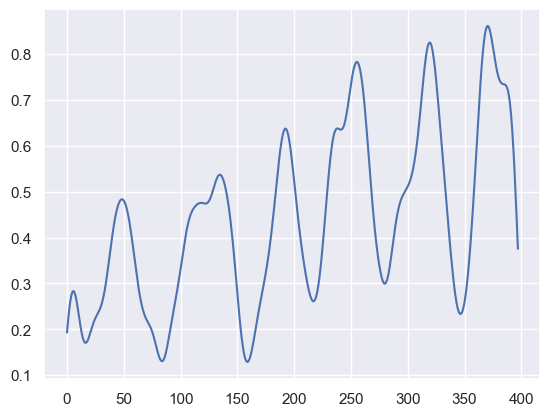

[1946, 2450, 2962, 3370]
[ 320 2500 3660]
6400
cuda
epoch 1,loss = 1.00341117
epoch 2,loss = 1.00331271
epoch 3,loss = 1.00322843
epoch 4,loss = 1.00315344
epoch 5,loss = 1.00308359
epoch 6,loss = 1.00301719
epoch 7,loss = 1.00295377
epoch 8,loss = 1.00289440
epoch 9,loss = 1.00283885
epoch 10,loss = 1.00278640
epoch 11,loss = 1.00273693
epoch 12,loss = 1.00269043
epoch 13,loss = 1.00264680
epoch 14,loss = 1.00260651
epoch 15,loss = 1.00256956
epoch 16,loss = 1.00253570
epoch 17,loss = 1.00250447
epoch 18,loss = 1.00247538
epoch 19,loss = 1.00244868
epoch 20,loss = 1.00242448
epoch 21,loss = 1.00240254
epoch 22,loss = 1.00238311
epoch 23,loss = 1.00236690
epoch 24,loss = 1.00235403
epoch 25,loss = 1.00234354
epoch 26,loss = 1.00233471
epoch 27,loss = 1.00232840


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 28,loss = 1.00232387
epoch 29,loss = 1.00232208
epoch 30,loss = 1.00232148
epoch 31,loss = 1.00232148
epoch 32,loss = 1.00232184
epoch 33,loss = 1.00232196
epoch 34,loss = 1.00232100
epoch 35,loss = 1.00231862
epoch 36,loss = 1.00231528
epoch 37,loss = 1.00231123
epoch 38,loss = 1.00230670
epoch 39,loss = 1.00230181
epoch 40,loss = 1.00229681
epoch 41,loss = 1.00229180
epoch 42,loss = 1.00228715
epoch 43,loss = 1.00228310
epoch 44,loss = 1.00228000
epoch 45,loss = 1.00227702
epoch 46,loss = 1.00227463
epoch 47,loss = 1.00227261
epoch 48,loss = 1.00227082
epoch 49,loss = 1.00226891
epoch 50,loss = 1.00226712
epoch 51,loss = 1.00226498
epoch 52,loss = 1.00226259
epoch 53,loss = 1.00225997
epoch 54,loss = 1.00225711
epoch 55,loss = 1.00225437
epoch 56,loss = 1.00225151
epoch 57,loss = 1.00224817
epoch 58,loss = 1.00224483
epoch 59,loss = 1.00224125
epoch 60,loss = 1.00223780
epoch 61,loss = 1.00223434
epoch 62,loss = 1.00223112
epoch 63,loss = 1.00222790
epoch 64,loss = 1.00222480
e

epoch 326,loss = 0.33305785
epoch 327,loss = 0.33272877
epoch 328,loss = 0.33240399
epoch 329,loss = 0.33208546
epoch 330,loss = 0.33177054
epoch 331,loss = 0.33146194
epoch 332,loss = 0.33115834
epoch 333,loss = 0.33086219
epoch 334,loss = 0.33057165
epoch 335,loss = 0.33028656
epoch 336,loss = 0.33000693
epoch 337,loss = 0.32973149
epoch 338,loss = 0.32946366
epoch 339,loss = 0.32920161
epoch 340,loss = 0.32894725
epoch 341,loss = 0.32869929
epoch 342,loss = 0.32845840
epoch 343,loss = 0.32822320
epoch 344,loss = 0.32799485
epoch 345,loss = 0.32777256
epoch 346,loss = 0.32755414
epoch 347,loss = 0.32733944
epoch 348,loss = 0.32713026
epoch 349,loss = 0.32692662
epoch 350,loss = 0.32672811
epoch 351,loss = 0.32653290
epoch 352,loss = 0.32634026
epoch 353,loss = 0.32615179
epoch 354,loss = 0.32596651
epoch 355,loss = 0.32578453
epoch 356,loss = 0.32560366
epoch 357,loss = 0.32542461
epoch 358,loss = 0.32524675
epoch 359,loss = 0.32507122
epoch 360,loss = 0.32489640
epoch 361,loss = 0.3

epoch 632,loss = 0.30521157
epoch 633,loss = 0.30517304
epoch 634,loss = 0.30513459
epoch 635,loss = 0.30509621
epoch 636,loss = 0.30505785
epoch 637,loss = 0.30501950
epoch 638,loss = 0.30498126
epoch 639,loss = 0.30494314
epoch 640,loss = 0.30490509
epoch 641,loss = 0.30486718
epoch 642,loss = 0.30482939
epoch 643,loss = 0.30479175
epoch 644,loss = 0.30475423
epoch 645,loss = 0.30471680
epoch 646,loss = 0.30467933
epoch 647,loss = 0.30464196
epoch 648,loss = 0.30460471
epoch 649,loss = 0.30456752
epoch 650,loss = 0.30453041
epoch 651,loss = 0.30449346
epoch 652,loss = 0.30445662
epoch 653,loss = 0.30441985
epoch 654,loss = 0.30438319
epoch 655,loss = 0.30434659
epoch 656,loss = 0.30430990
epoch 657,loss = 0.30427331
epoch 658,loss = 0.30423653
epoch 659,loss = 0.30419990
epoch 660,loss = 0.30416349
epoch 661,loss = 0.30412716
epoch 662,loss = 0.30409089
epoch 663,loss = 0.30405456
epoch 664,loss = 0.30401784
epoch 665,loss = 0.30398104
epoch 666,loss = 0.30394411
epoch 667,loss = 0.3

epoch 937,loss = 0.29541388
epoch 938,loss = 0.29538164
epoch 939,loss = 0.29534936
epoch 940,loss = 0.29531708
epoch 941,loss = 0.29528496
epoch 942,loss = 0.29525289
epoch 943,loss = 0.29522011
epoch 944,loss = 0.29518735
epoch 945,loss = 0.29515472
epoch 946,loss = 0.29512212
epoch 947,loss = 0.29508948
epoch 948,loss = 0.29505721
epoch 949,loss = 0.29502520
epoch 950,loss = 0.29499331
epoch 951,loss = 0.29496157
epoch 952,loss = 0.29492998
epoch 953,loss = 0.29489848
epoch 954,loss = 0.29486710
epoch 955,loss = 0.29483584
epoch 956,loss = 0.29480469
epoch 957,loss = 0.29477364
epoch 958,loss = 0.29474300
epoch 959,loss = 0.29471248
epoch 960,loss = 0.29468220
epoch 961,loss = 0.29465199
epoch 962,loss = 0.29462191
epoch 963,loss = 0.29459196
epoch 964,loss = 0.29456213
epoch 965,loss = 0.29453260
epoch 966,loss = 0.29450309
epoch 967,loss = 0.29447374
epoch 968,loss = 0.29444444
epoch 969,loss = 0.29441524
epoch 970,loss = 0.29438606
epoch 971,loss = 0.29435697
epoch 972,loss = 0.2

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([798, 1, 20])
1.0
Epoch 200:   loss= 0.12241  cluster difference= 1.0
Epoch 400:   loss= 0.12387  cluster difference= 0.05137844611528822
Epoch 600:   loss= 0.1252  cluster difference= 0.06140350877192982
Epoch 800:   loss= 0.12649  cluster difference= 0.07142857142857142
Epoch 1000:   loss= 0.12805  cluster difference= 0.05513784461152882
Epoch 1200:   loss= 0.12968  cluster difference= 0.05388471177944862
Epoch 1400:   loss= 0.13141  cluster difference= 0.08771929824561403
Epoch 1600:   loss= 0.13418  cluster difference= 0.3032581453634085
Epoch 1800:   loss= 0.13704  cluster difference= 0.06516290726817042
Epoch 2000:   loss= 0.13917  cluster difference= 0.042606516290726815
Epoch 2200:   loss= 0.14086  cluster difference= 0.018796992481203006
Epoch 2400:   loss= 0.14225  cluster difference= 0.005012531328320802
[7 5 1 2 4 7 4 0 3 5 1 6 0 7 4 0 7 5 1 2 4 7 4 0 7 5 1 2 4 0 0 0 7 5 1 2 4
 7 4 4 7 5 1 2 4 0 0 0 7 5 1 2 4 7 4 4 7 5 1 2 4 0 0 0 7 5 1 2 4 7 3 4 7 5
 1 2 4 0 0 0

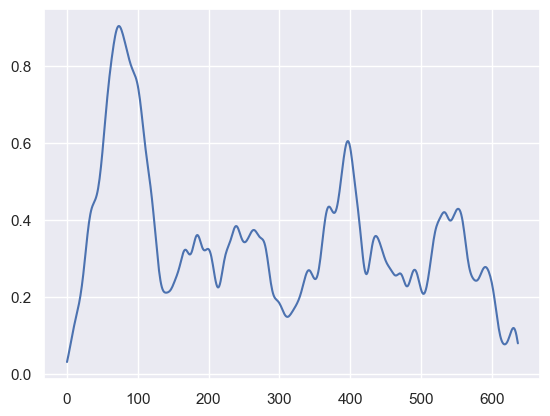

[1234, 3826]
[1280 2560 3840 5120]
1400
cuda
epoch 1,loss = 0.99894011
epoch 2,loss = 0.99893451
epoch 3,loss = 0.99892884
epoch 4,loss = 0.99892336
epoch 5,loss = 0.99891788
epoch 6,loss = 0.99891239
epoch 7,loss = 0.99890709
epoch 8,loss = 0.99890178
epoch 9,loss = 0.99889642
epoch 10,loss = 0.99889123
epoch 11,loss = 0.99888611
epoch 12,loss = 0.99888104
epoch 13,loss = 0.99887604
epoch 14,loss = 0.99887109
epoch 15,loss = 0.99886614
epoch 16,loss = 0.99886125
epoch 17,loss = 0.99885648
epoch 18,loss = 0.99885166
epoch 19,loss = 0.99884701
epoch 20,loss = 0.99884236
epoch 21,loss = 0.99883777
epoch 22,loss = 0.99883330
epoch 23,loss = 0.99882883
epoch 24,loss = 0.99882442
epoch 25,loss = 0.99882007
epoch 26,loss = 0.99881583
epoch 27,loss = 0.99881160
epoch 28,loss = 0.99880737
epoch 29,loss = 0.99880326
epoch 30,loss = 0.99879915
epoch 31,loss = 0.99879521
epoch 32,loss = 0.99879128
epoch 33,loss = 0.99878740
epoch 34,loss = 0.99878353
epoch 35,loss = 0.99877971
epoch 36,loss = 0.9

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 48,loss = 0.99873459
epoch 49,loss = 0.99873143
epoch 50,loss = 0.99872833
epoch 51,loss = 0.99872524
epoch 52,loss = 0.99872214
epoch 53,loss = 0.99871910
epoch 54,loss = 0.99871612
epoch 55,loss = 0.99871308
epoch 56,loss = 0.99871010
epoch 57,loss = 0.99870723
epoch 58,loss = 0.99870431
epoch 59,loss = 0.99870145
epoch 60,loss = 0.99869853
epoch 61,loss = 0.99869573
epoch 62,loss = 0.99869281
epoch 63,loss = 0.99869001
epoch 64,loss = 0.99868721
epoch 65,loss = 0.99868429
epoch 66,loss = 0.99868149
epoch 67,loss = 0.99867868
epoch 68,loss = 0.99867570
epoch 69,loss = 0.99867284
epoch 70,loss = 0.99866992
epoch 71,loss = 0.99866694
epoch 72,loss = 0.99866378
epoch 73,loss = 0.99866056
epoch 74,loss = 0.99865723
epoch 75,loss = 0.99865341
epoch 76,loss = 0.99864918
epoch 77,loss = 0.99864477
epoch 78,loss = 0.99863994
epoch 79,loss = 0.99863470
epoch 80,loss = 0.99862927
epoch 81,loss = 0.99862331
epoch 82,loss = 0.99861604
epoch 83,loss = 0.99860710
epoch 84,loss = 0.99859625
e

epoch 353,loss = 0.57660162
epoch 354,loss = 0.57653117
epoch 355,loss = 0.57645899
epoch 356,loss = 0.57638848
epoch 357,loss = 0.57631689
epoch 358,loss = 0.57624811
epoch 359,loss = 0.57617563
epoch 360,loss = 0.57610357
epoch 361,loss = 0.57603168
epoch 362,loss = 0.57595885
epoch 363,loss = 0.57588643
epoch 364,loss = 0.57581389
epoch 365,loss = 0.57574153
epoch 366,loss = 0.57566971
epoch 367,loss = 0.57559830
epoch 368,loss = 0.57552552
epoch 369,loss = 0.57545191
epoch 370,loss = 0.57537967
epoch 371,loss = 0.57530534
epoch 372,loss = 0.57523221
epoch 373,loss = 0.57515883
epoch 374,loss = 0.57508439
epoch 375,loss = 0.57500887
epoch 376,loss = 0.57493252
epoch 377,loss = 0.57485557
epoch 378,loss = 0.57477850
epoch 379,loss = 0.57470143
epoch 380,loss = 0.57462490
epoch 381,loss = 0.57454920
epoch 382,loss = 0.57447362
epoch 383,loss = 0.57439888
epoch 384,loss = 0.57432431
epoch 385,loss = 0.57424945
epoch 386,loss = 0.57417309
epoch 387,loss = 0.57409698
epoch 388,loss = 0.5

epoch 668,loss = 0.54936725
epoch 669,loss = 0.54928350
epoch 670,loss = 0.54917818
epoch 671,loss = 0.54905003
epoch 672,loss = 0.54889488
epoch 673,loss = 0.54874223
epoch 674,loss = 0.54861718
epoch 675,loss = 0.54851300
epoch 676,loss = 0.54841471
epoch 677,loss = 0.54831994
epoch 678,loss = 0.54822212
epoch 679,loss = 0.54810870
epoch 680,loss = 0.54798353
epoch 681,loss = 0.54786098
epoch 682,loss = 0.54776841
epoch 683,loss = 0.54769778
epoch 684,loss = 0.54761046
epoch 685,loss = 0.54752082
epoch 686,loss = 0.54742593
epoch 687,loss = 0.54732782
epoch 688,loss = 0.54723340
epoch 689,loss = 0.54714811
epoch 690,loss = 0.54706270
epoch 691,loss = 0.54697973
epoch 692,loss = 0.54689670
epoch 693,loss = 0.54681218
epoch 694,loss = 0.54672688
epoch 695,loss = 0.54663950
epoch 696,loss = 0.54654717
epoch 697,loss = 0.54646313
epoch 698,loss = 0.54638481
epoch 699,loss = 0.54630601
epoch 700,loss = 0.54622519
epoch 701,loss = 0.54614002
epoch 702,loss = 0.54605293
epoch 703,loss = 0.5

epoch 978,loss = 0.52088898
epoch 979,loss = 0.52079397
epoch 980,loss = 0.52069741
epoch 981,loss = 0.52059817
epoch 982,loss = 0.52050394
epoch 983,loss = 0.52041817
epoch 984,loss = 0.52033412
epoch 985,loss = 0.52024788
epoch 986,loss = 0.52015829
epoch 987,loss = 0.52006513
epoch 988,loss = 0.51996940
epoch 989,loss = 0.51987451
epoch 990,loss = 0.51977968
epoch 991,loss = 0.51968563
epoch 992,loss = 0.51959652
epoch 993,loss = 0.51950890
epoch 994,loss = 0.51942855
epoch 995,loss = 0.51935410
epoch 996,loss = 0.51927871
epoch 997,loss = 0.51920265
epoch 998,loss = 0.51912713
epoch 999,loss = 0.51905823
epoch 1000,loss = 0.51898885
epoch 1001,loss = 0.51891690
epoch 1002,loss = 0.51884264
epoch 1003,loss = 0.51876730
epoch 1004,loss = 0.51869208
epoch 1005,loss = 0.51861703
epoch 1006,loss = 0.51854175
epoch 1007,loss = 0.51846510
epoch 1008,loss = 0.51838756
epoch 1009,loss = 0.51830977
epoch 1010,loss = 0.51823223
epoch 1011,loss = 0.51815778
epoch 1012,loss = 0.51808310
epoch 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([173, 1, 20])
1.0
Epoch 200:   loss= 0.17164  cluster difference= 1.0
Epoch 400:   loss= 0.17135  cluster difference= 0.023121387283236993
Epoch 600:   loss= 0.17136  cluster difference= 0.028901734104046242
Epoch 800:   loss= 0.17158  cluster difference= 0.023121387283236993
Epoch 1000:   loss= 0.17187  cluster difference= 0.023121387283236993
Epoch 1200:   loss= 0.17211  cluster difference= 0.0
[5 5 7 3 0 5 7 3 6 5 7 7 7 4 5 3 3 0 3 2 7 7 5 1 7 1 0 3 2 5 3 0 7 7 2 5 5
 7 7 4 5 3 7 4 5 7 7 7 4 5 3 1 0 5 7 7 1 0 5 7 1 0 5 7 3 2 5 7 5 2 5 5 7 3
 4 5 5 3 6 5 7 7 1 0 5 7 1 0 5 7 7 1 0 3 7 2 5 5 7 5 2 5 3 3 4 5 3 7 7 4 5
 3 3 6 5 3 7 3 4 5 7 1 0 5 5 5 1 0 5 7 2 0 5 3 7 2 5 5 7 2 5 5 7 7 4 5 5 7
 7 5 7 2 3 6 5 5 3 0 5 7 7 1 0 5 7 2 5 5 7 5 2 5 3]


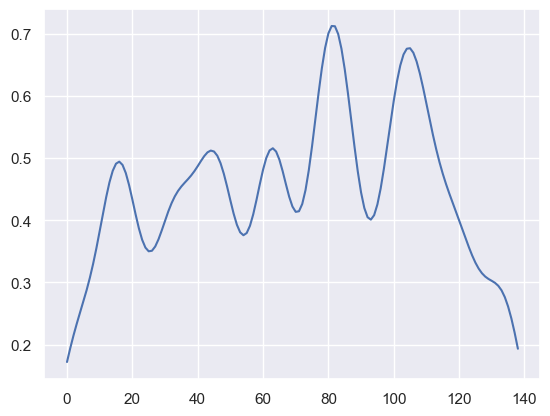

[794, 986]
[420]
1755
cuda
epoch 1,loss = 1.04143214
epoch 2,loss = 1.04074824
epoch 3,loss = 1.04007077
epoch 4,loss = 1.03940022
epoch 5,loss = 1.03873658
epoch 6,loss = 1.03807974
epoch 7,loss = 1.03743005
epoch 8,loss = 1.03678739
epoch 9,loss = 1.03615201
epoch 10,loss = 1.03552365
epoch 11,loss = 1.03490293
epoch 12,loss = 1.03428924
epoch 13,loss = 1.03368282
epoch 14,loss = 1.03308403
epoch 15,loss = 1.03249252
epoch 16,loss = 1.03190863
epoch 17,loss = 1.03133190
epoch 18,loss = 1.03076267
epoch 19,loss = 1.03020084
epoch 20,loss = 1.02964640
epoch 21,loss = 1.02909935
epoch 22,loss = 1.02855968
epoch 23,loss = 1.02802742
epoch 24,loss = 1.02750218
epoch 25,loss = 1.02698445
epoch 26,loss = 1.02647376
epoch 27,loss = 1.02597022
epoch 28,loss = 1.02547383
epoch 29,loss = 1.02498448
epoch 30,loss = 1.02450204
epoch 31,loss = 1.02402687
epoch 32,loss = 1.02355838
epoch 33,loss = 1.02309668
epoch 34,loss = 1.02264190
epoch 35,loss = 1.02219379
epoch 36,loss = 1.02175212
epoch 37,l

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 61,loss = 1.01204550
epoch 62,loss = 1.01165593
epoch 63,loss = 1.01125610
epoch 64,loss = 1.01084733
epoch 65,loss = 1.01040804
epoch 66,loss = 1.00991726
epoch 67,loss = 1.00941861
epoch 68,loss = 1.00891805
epoch 69,loss = 1.00841951
epoch 70,loss = 1.00791240
epoch 71,loss = 1.00740194
epoch 72,loss = 1.00690162
epoch 73,loss = 1.00641608
epoch 74,loss = 1.00594234
epoch 75,loss = 1.00548100
epoch 76,loss = 1.00503004
epoch 77,loss = 1.00458419
epoch 78,loss = 1.00414634
epoch 79,loss = 1.00371933
epoch 80,loss = 1.00330067
epoch 81,loss = 1.00288570
epoch 82,loss = 1.00247264
epoch 83,loss = 1.00205827
epoch 84,loss = 1.00164104
epoch 85,loss = 1.00121915
epoch 86,loss = 1.00079358
epoch 87,loss = 1.00036669
epoch 88,loss = 0.99993670
epoch 89,loss = 0.99950141
epoch 90,loss = 0.99905944
epoch 91,loss = 0.99860919
epoch 92,loss = 0.99815273
epoch 93,loss = 0.99768710
epoch 94,loss = 0.99721318
epoch 95,loss = 0.99672681
epoch 96,loss = 0.99623561
epoch 97,loss = 0.99575734
e

epoch 397,loss = 0.57798922
epoch 398,loss = 0.57779336
epoch 399,loss = 0.57759440
epoch 400,loss = 0.57739472
epoch 401,loss = 0.57718301
epoch 402,loss = 0.57693094
epoch 403,loss = 0.57662088
epoch 404,loss = 0.57634759
epoch 405,loss = 0.57607847
epoch 406,loss = 0.57580990
epoch 407,loss = 0.57556415
epoch 408,loss = 0.57532781
epoch 409,loss = 0.57512873
epoch 410,loss = 0.57493341
epoch 411,loss = 0.57474101
epoch 412,loss = 0.57455617
epoch 413,loss = 0.57435924
epoch 414,loss = 0.57415104
epoch 415,loss = 0.57394737
epoch 416,loss = 0.57371438
epoch 417,loss = 0.57348037
epoch 418,loss = 0.57311279
epoch 419,loss = 0.57284820
epoch 420,loss = 0.57254577
epoch 421,loss = 0.57226425
epoch 422,loss = 0.57207739
epoch 423,loss = 0.57190704
epoch 424,loss = 0.57178330
epoch 425,loss = 0.57171255
epoch 426,loss = 0.57162559
epoch 427,loss = 0.57151979
epoch 428,loss = 0.57140225
epoch 429,loss = 0.57127833
epoch 430,loss = 0.57114947
epoch 431,loss = 0.57101548
epoch 432,loss = 0.5

epoch 721,loss = 0.55540490
epoch 722,loss = 0.55537796
epoch 723,loss = 0.55534905
epoch 724,loss = 0.55531806
epoch 725,loss = 0.55528963
epoch 726,loss = 0.55526119
epoch 727,loss = 0.55523068
epoch 728,loss = 0.55520505
epoch 729,loss = 0.55517638
epoch 730,loss = 0.55515093
epoch 731,loss = 0.55512232
epoch 732,loss = 0.55509728
epoch 733,loss = 0.55507231
epoch 734,loss = 0.55504394
epoch 735,loss = 0.55501509
epoch 736,loss = 0.55498832
epoch 737,loss = 0.55496484
epoch 738,loss = 0.55493420
epoch 739,loss = 0.55490983
epoch 740,loss = 0.55488956
epoch 741,loss = 0.55485708
epoch 742,loss = 0.55482817
epoch 743,loss = 0.55480319
epoch 744,loss = 0.55477482
epoch 745,loss = 0.55474353
epoch 746,loss = 0.55471641
epoch 747,loss = 0.55468678
epoch 748,loss = 0.55466175
epoch 749,loss = 0.55463326
epoch 750,loss = 0.55460697
epoch 751,loss = 0.55457807
epoch 752,loss = 0.55455339
epoch 753,loss = 0.55452788
epoch 754,loss = 0.55449831
epoch 755,loss = 0.55446905
epoch 756,loss = 0.5

epoch 1027,loss = 0.54832011
epoch 1028,loss = 0.54829854
epoch 1029,loss = 0.54827720
epoch 1030,loss = 0.54825604
epoch 1031,loss = 0.54823512
epoch 1032,loss = 0.54821438
epoch 1033,loss = 0.54819417
epoch 1034,loss = 0.54817498
epoch 1035,loss = 0.54815614
epoch 1036,loss = 0.54813737
epoch 1037,loss = 0.54811823
epoch 1038,loss = 0.54809976
epoch 1039,loss = 0.54808050
epoch 1040,loss = 0.54806077
epoch 1041,loss = 0.54804081
epoch 1042,loss = 0.54802060
epoch 1043,loss = 0.54799885
epoch 1044,loss = 0.54797769
epoch 1045,loss = 0.54796124
epoch 1046,loss = 0.54794478
epoch 1047,loss = 0.54792738
epoch 1048,loss = 0.54790890
epoch 1049,loss = 0.54789442
epoch 1050,loss = 0.54788435
epoch 1051,loss = 0.54787332
epoch 1052,loss = 0.54786146
epoch 1053,loss = 0.54785055
epoch 1054,loss = 0.54784125
epoch 1055,loss = 0.54783279
epoch 1056,loss = 0.54782242
epoch 1057,loss = 0.54781187
epoch 1058,loss = 0.54780048
epoch 1059,loss = 0.54778898
epoch 1060,loss = 0.54777718
epoch 1061,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([217, 1, 20])
1.0
Epoch 200:   loss= 0.18148  cluster difference= 1.0
Epoch 400:   loss= 0.17447  cluster difference= 0.018433179723502304
Epoch 600:   loss= 0.17078  cluster difference= 0.009216589861751152
[1 4 2 1 1 5 2 1 7 0 1 1 1 4 2 1 1 1 1 1 1 5 2 1 1 6 3 1 1 1 7 6 1 4 3 1 1
 1 7 6 1 1 5 2 1 1 1 1 1 5 4 2 1 1 1 4 2 5 5 2 1 1 4 2 1 7 0 0 1 1 1 5 2 1
 1 1 1 1 7 0 0 1 7 6 1 1 7 7 0 7 0 1 1 1 7 0 1 1 4 3 1 1 1 7 6 1 1 1 1 1 7
 6 1 4 4 2 1 1 1 3 1 5 5 2 1 1 1 4 2 5 5 2 1 1 1 4 2 7 0 2 1 1 7 1 2 7 7 0
 1 1 1 5 2 1 6 6 1 1 1 7 0 1 3 6 1 1 1 7 0 1 4 3 1 1 1 1 6 1 4 4 2 1 1 1 3
 1 1 4 2 1 1 1 4 2 5 5 2 1 1 1 4 2 1 1 7 1 1 1 1 5 2 7 0 1 1 1 5]


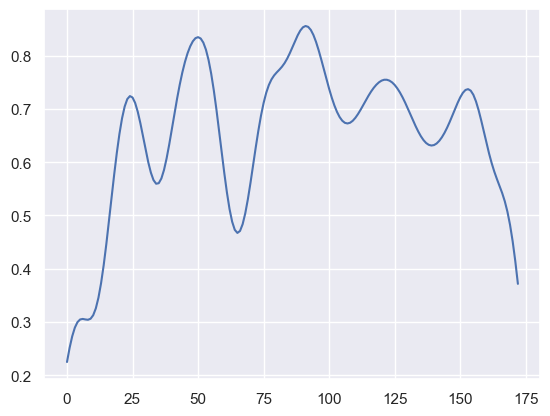

[378, 586, 914]
[715]
3199
cuda
epoch 1,loss = 1.04909897
epoch 2,loss = 1.04824519
epoch 3,loss = 1.04739785
epoch 4,loss = 1.04655743
epoch 5,loss = 1.04572344
epoch 6,loss = 1.04489636
epoch 7,loss = 1.04407585
epoch 8,loss = 1.04326153
epoch 9,loss = 1.04245400
epoch 10,loss = 1.04165208
epoch 11,loss = 1.04085588
epoch 12,loss = 1.04006457
epoch 13,loss = 1.03927791
epoch 14,loss = 1.03849518
epoch 15,loss = 1.03771579
epoch 16,loss = 1.03693902
epoch 17,loss = 1.03616464
epoch 18,loss = 1.03539181
epoch 19,loss = 1.03462052
epoch 20,loss = 1.03385019
epoch 21,loss = 1.03308070
epoch 22,loss = 1.03231168
epoch 23,loss = 1.03154325
epoch 24,loss = 1.03077495
epoch 25,loss = 1.03000689
epoch 26,loss = 1.02923870
epoch 27,loss = 1.02847040
epoch 28,loss = 1.02770162
epoch 29,loss = 1.02693272
epoch 30,loss = 1.02616310
epoch 31,loss = 1.02539325
epoch 32,loss = 1.02462256
epoch 33,loss = 1.02385139
epoch 34,loss = 1.02307963
epoch 35,loss = 1.02230728
epoch 36,loss = 1.02153432
epoch

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 45,loss = 1.01513600
epoch 46,loss = 1.01445222
epoch 47,loss = 1.01379120
epoch 48,loss = 1.01314473
epoch 49,loss = 1.01249778
epoch 50,loss = 1.01184583
epoch 51,loss = 1.01118946
epoch 52,loss = 1.01053250
epoch 53,loss = 1.00988114
epoch 54,loss = 1.00924075
epoch 55,loss = 1.00861216
epoch 56,loss = 1.00799286
epoch 57,loss = 1.00737906
epoch 58,loss = 1.00676751
epoch 59,loss = 1.00615788
epoch 60,loss = 1.00555110
epoch 61,loss = 1.00494862
epoch 62,loss = 1.00435126
epoch 63,loss = 1.00375974
epoch 64,loss = 1.00317442
epoch 65,loss = 1.00259507
epoch 66,loss = 1.00202274
epoch 67,loss = 1.00147271
epoch 68,loss = 1.00101137
epoch 69,loss = 1.00060403
epoch 70,loss = 1.00020337
epoch 71,loss = 0.99980617
epoch 72,loss = 0.99941689
epoch 73,loss = 0.99903512
epoch 74,loss = 0.99866092
epoch 75,loss = 0.99831372
epoch 76,loss = 0.99803680
epoch 77,loss = 0.99778289
epoch 78,loss = 0.99752730
epoch 79,loss = 0.99727756
epoch 80,loss = 0.99703336
epoch 81,loss = 0.99679422
e

epoch 356,loss = 0.67226839
epoch 357,loss = 0.67181098
epoch 358,loss = 0.67135155
epoch 359,loss = 0.67089117
epoch 360,loss = 0.67042720
epoch 361,loss = 0.66995931
epoch 362,loss = 0.66948688
epoch 363,loss = 0.66901141
epoch 364,loss = 0.66853505
epoch 365,loss = 0.66805744
epoch 366,loss = 0.66757590
epoch 367,loss = 0.66709113
epoch 368,loss = 0.66660124
epoch 369,loss = 0.66611004
epoch 370,loss = 0.66561651
epoch 371,loss = 0.66512167
epoch 372,loss = 0.66462535
epoch 373,loss = 0.66412562
epoch 374,loss = 0.66362303
epoch 375,loss = 0.66312146
epoch 376,loss = 0.66261888
epoch 377,loss = 0.66211545
epoch 378,loss = 0.66161150
epoch 379,loss = 0.66110635
epoch 380,loss = 0.66060221
epoch 381,loss = 0.66009623
epoch 382,loss = 0.65958875
epoch 383,loss = 0.65907907
epoch 384,loss = 0.65856689
epoch 385,loss = 0.65805089
epoch 386,loss = 0.65753061
epoch 387,loss = 0.65700775
epoch 388,loss = 0.65648031
epoch 389,loss = 0.65594828
epoch 390,loss = 0.65541220
epoch 391,loss = 0.6

epoch 671,loss = 0.46309122
epoch 672,loss = 0.46292642
epoch 673,loss = 0.46276039
epoch 674,loss = 0.46259579
epoch 675,loss = 0.46243382
epoch 676,loss = 0.46227083
epoch 677,loss = 0.46210894
epoch 678,loss = 0.46194899
epoch 679,loss = 0.46178764
epoch 680,loss = 0.46162361
epoch 681,loss = 0.46145993
epoch 682,loss = 0.46129507
epoch 683,loss = 0.46112856
epoch 684,loss = 0.46095935
epoch 685,loss = 0.46078727
epoch 686,loss = 0.46061900
epoch 687,loss = 0.46045387
epoch 688,loss = 0.46030021
epoch 689,loss = 0.46015489
epoch 690,loss = 0.46001965
epoch 691,loss = 0.45988426
epoch 692,loss = 0.45975053
epoch 693,loss = 0.45961761
epoch 694,loss = 0.45948097
epoch 695,loss = 0.45934314
epoch 696,loss = 0.45920533
epoch 697,loss = 0.45906737
epoch 698,loss = 0.45892966
epoch 699,loss = 0.45879358
epoch 700,loss = 0.45866084
epoch 701,loss = 0.45853031
epoch 702,loss = 0.45839956
epoch 703,loss = 0.45826825
epoch 704,loss = 0.45813897
epoch 705,loss = 0.45801148
epoch 706,loss = 0.4

epoch 990,loss = 0.44522190
epoch 991,loss = 0.44520381
epoch 992,loss = 0.44518566
epoch 993,loss = 0.44516730
epoch 994,loss = 0.44514927
epoch 995,loss = 0.44513136
epoch 996,loss = 0.44511354
epoch 997,loss = 0.44509581
epoch 998,loss = 0.44507813
epoch 999,loss = 0.44506076
epoch 1000,loss = 0.44504344
epoch 1001,loss = 0.44502622
epoch 1002,loss = 0.44500971
epoch 1003,loss = 0.44499332
epoch 1004,loss = 0.44497681
epoch 1005,loss = 0.44495979
epoch 1006,loss = 0.44494259
epoch 1007,loss = 0.44492507
epoch 1008,loss = 0.44490531
epoch 1009,loss = 0.44488358
epoch 1010,loss = 0.44486126
epoch 1011,loss = 0.44483829
epoch 1012,loss = 0.44481504
epoch 1013,loss = 0.44479209
epoch 1014,loss = 0.44477168
epoch 1015,loss = 0.44475555
epoch 1016,loss = 0.44474143
epoch 1017,loss = 0.44472730
epoch 1018,loss = 0.44471303
epoch 1019,loss = 0.44469723
epoch 1020,loss = 0.44467908
epoch 1021,loss = 0.44466069
epoch 1022,loss = 0.44464198
epoch 1023,loss = 0.44462162
epoch 1024,loss = 0.4445

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([398, 1, 20])
1.0
Epoch 200:   loss= 0.20153  cluster difference= 1.0
Epoch 400:   loss= 0.20047  cluster difference= 0.010050251256281407
Epoch 600:   loss= 0.19938  cluster difference= 0.007537688442211055
[4 6 4 6 4 6 4 6 4 7 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4
 6 4 6 4 6 1 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 4 6 3 2 3 2 3 2 3 2 3 2 3 2 3 2
 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 2 2 3 2 3 2 3 2 3 2 3
 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2
 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 3 2 5 0 1 7 5 0 1 7 5 0 1 7 5 0 5
 7 1 7 5 0 5 0 5 0 5 0 5 7 5 0 5 7 5 7 5 0 5 7 5 0 5 7 5 0 5 0 5 7 5 7 5 7
 5 0 5 0 1 0 1 7 5 7 5 0 1 0 5 7 5 7 5 0 5 7 1 0 5 0 5 0 5 0 5 7 5 7 5 7 5
 0 5 0 5 0 5 7 1 0 5 0 1 7 1 0 5 7 5 0 5 7 5 0 5 0 5 7 1 7 5 0 5 0 1 7 5 7
 5 7 5 0 1 7 5 0 1 7 5 7 5 7 5 7 5 0 5 7 5 7 1 7 5 0 5 0 1 0 1 0 5 0 5 0 5
 0 5 7 5 0 5 7 5 0 5 0 5 7 1 7 5 0 5 7 5 0 4 7 5 0 5 0 5 0 5 0 5 0 5 0 5 0
 5 0 5 7 5 7 5 7 5 0 5 7 5 0 5 

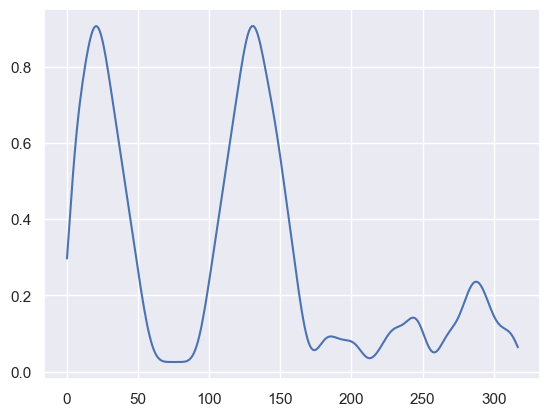

[490, 1378]
[ 486 1366]
4352
cuda
epoch 1,loss = 1.18584812
epoch 2,loss = 1.18371248
epoch 3,loss = 1.18157339
epoch 4,loss = 1.17943096
epoch 5,loss = 1.17728567
epoch 6,loss = 1.17513764
epoch 7,loss = 1.17298758
epoch 8,loss = 1.17083573
epoch 9,loss = 1.16868246
epoch 10,loss = 1.16652799
epoch 11,loss = 1.16437292
epoch 12,loss = 1.16221774
epoch 13,loss = 1.16006267
epoch 14,loss = 1.15790844
epoch 15,loss = 1.15575516
epoch 16,loss = 1.15360367
epoch 17,loss = 1.15145445
epoch 18,loss = 1.14930785
epoch 19,loss = 1.14716458
epoch 20,loss = 1.14502513
epoch 21,loss = 1.14289033
epoch 22,loss = 1.14076066
epoch 23,loss = 1.13863659
epoch 24,loss = 1.13651907
epoch 25,loss = 1.13440871
epoch 26,loss = 1.13230622
epoch 27,loss = 1.13021219
epoch 28,loss = 1.12812746
epoch 29,loss = 1.12605298
epoch 30,loss = 1.12398946
epoch 31,loss = 1.12193763
epoch 32,loss = 1.11989832
epoch 33,loss = 1.11787248
epoch 34,loss = 1.11586070
epoch 35,loss = 1.11386418
epoch 36,loss = 1.11188364


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 37,loss = 1.10992002
epoch 38,loss = 1.10797429
epoch 39,loss = 1.10604715
epoch 40,loss = 1.10413957
epoch 41,loss = 1.10225260
epoch 42,loss = 1.10038698
epoch 43,loss = 1.09854364
epoch 44,loss = 1.09672356
epoch 45,loss = 1.09492755
epoch 46,loss = 1.09315634
epoch 47,loss = 1.09141088
epoch 48,loss = 1.08969188
epoch 49,loss = 1.08800018
epoch 50,loss = 1.08633637
epoch 51,loss = 1.08470142
epoch 52,loss = 1.08309555
epoch 53,loss = 1.08151972
epoch 54,loss = 1.07996905
epoch 55,loss = 1.07841134
epoch 56,loss = 1.07688308
epoch 57,loss = 1.07538521
epoch 58,loss = 1.07391858
epoch 59,loss = 1.07248402
epoch 60,loss = 1.07108212
epoch 61,loss = 1.06971359
epoch 62,loss = 1.06837869
epoch 63,loss = 1.06707788
epoch 64,loss = 1.06581116
epoch 65,loss = 1.06457865
epoch 66,loss = 1.06338060
epoch 67,loss = 1.06221640
epoch 68,loss = 1.06112325
epoch 69,loss = 1.06040800
epoch 70,loss = 1.05945504
epoch 71,loss = 1.05846024
epoch 72,loss = 1.05748415
epoch 73,loss = 1.05652678
e

epoch 342,loss = 0.85024720
epoch 343,loss = 0.84924006
epoch 344,loss = 0.84821498
epoch 345,loss = 0.84717166
epoch 346,loss = 0.84610975
epoch 347,loss = 0.84502888
epoch 348,loss = 0.84392881
epoch 349,loss = 0.84280759
epoch 350,loss = 0.84166318
epoch 351,loss = 0.84049833
epoch 352,loss = 0.83931464
epoch 353,loss = 0.83810937
epoch 354,loss = 0.83688205
epoch 355,loss = 0.83563280
epoch 356,loss = 0.83436167
epoch 357,loss = 0.83306670
epoch 358,loss = 0.83174962
epoch 359,loss = 0.83041036
epoch 360,loss = 0.82904607
epoch 361,loss = 0.82765508
epoch 362,loss = 0.82623869
epoch 363,loss = 0.82479888
epoch 364,loss = 0.82333422
epoch 365,loss = 0.82184291
epoch 366,loss = 0.82032841
epoch 367,loss = 0.81878871
epoch 368,loss = 0.81722277
epoch 369,loss = 0.81563020
epoch 370,loss = 0.81400788
epoch 371,loss = 0.81235486
epoch 372,loss = 0.81066936
epoch 373,loss = 0.80895573
epoch 374,loss = 0.80720675
epoch 375,loss = 0.80542737
epoch 376,loss = 0.80361831
epoch 377,loss = 0.8

epoch 674,loss = 0.42347732
epoch 675,loss = 0.42328957
epoch 676,loss = 0.42310506
epoch 677,loss = 0.42292488
epoch 678,loss = 0.42274809
epoch 679,loss = 0.42257479
epoch 680,loss = 0.42240497
epoch 681,loss = 0.42223603
epoch 682,loss = 0.42206725
epoch 683,loss = 0.42189834
epoch 684,loss = 0.42173296
epoch 685,loss = 0.42156994
epoch 686,loss = 0.42140767
epoch 687,loss = 0.42124751
epoch 688,loss = 0.42108941
epoch 689,loss = 0.42093357
epoch 690,loss = 0.42078173
epoch 691,loss = 0.42063344
epoch 692,loss = 0.42048401
epoch 693,loss = 0.42033798
epoch 694,loss = 0.42019370
epoch 695,loss = 0.42005163
epoch 696,loss = 0.41991293
epoch 697,loss = 0.41977906
epoch 698,loss = 0.41964602
epoch 699,loss = 0.41951430
epoch 700,loss = 0.41938296
epoch 701,loss = 0.41925740
epoch 702,loss = 0.41913506
epoch 703,loss = 0.41901448
epoch 704,loss = 0.41889679
epoch 705,loss = 0.41878283
epoch 706,loss = 0.41867185
epoch 707,loss = 0.41856399
epoch 708,loss = 0.41845936
epoch 709,loss = 0.4

epoch 967,loss = 0.40671515
epoch 968,loss = 0.40668485
epoch 969,loss = 0.40665469
epoch 970,loss = 0.40662462
epoch 971,loss = 0.40659475
epoch 972,loss = 0.40656516
epoch 973,loss = 0.40653563
epoch 974,loss = 0.40650606
epoch 975,loss = 0.40647647
epoch 976,loss = 0.40644574
epoch 977,loss = 0.40641439
epoch 978,loss = 0.40638286
epoch 979,loss = 0.40635133
epoch 980,loss = 0.40631968
epoch 981,loss = 0.40628791
epoch 982,loss = 0.40625602
epoch 983,loss = 0.40622386
epoch 984,loss = 0.40619180
epoch 985,loss = 0.40615967
epoch 986,loss = 0.40612757
epoch 987,loss = 0.40609530
epoch 988,loss = 0.40606296
epoch 989,loss = 0.40603054
epoch 990,loss = 0.40599820
epoch 991,loss = 0.40596595
epoch 992,loss = 0.40593392
epoch 993,loss = 0.40590206
epoch 994,loss = 0.40587035
epoch 995,loss = 0.40583891
epoch 996,loss = 0.40580747
epoch 997,loss = 0.40577567
epoch 998,loss = 0.40574402
epoch 999,loss = 0.40571216
epoch 1000,loss = 0.40567985
epoch 1001,loss = 0.40564775
epoch 1002,loss = 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


torch.Size([542, 1, 20])
1.0
Epoch 200:   loss= 0.14386  cluster difference= 1.0
Epoch 400:   loss= 0.14358  cluster difference= 0.007380073800738007
[0 1 3 1 0 1 3 1 3 1 3 1 3 1 3 1 3 1 3 1 0 1 0 1 3 1 3 1 3 1 3 1 3 1 3 1 3
 1 3 1 0 1 3 1 3 1 3 1 0 1 3 1 3 1 3 1 0 1 3 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 0 1 3 1 0 1 0 1 0 1 3 1 0 1 0 1 0 1 0 1 3 1 0 1 0 1 3 1 0 1 3 1 0 1 0
 1 0 1 0 7 3 1 6 7 3 5 6 2 7 6 0 2 7 6 2 2 3 1 6 2 4 4 2 7 4 1 6 2 4 1 6 7
 3 5 6 2 3 5 2 2 4 5 2 4 7 0 4 2 7 4 4 7 3 5 2 2 7 6 0 7 3 1 6 7 3 5 2 7 3
 4 2 7 0 5 2 7 3 5 6 2 4 1 0 2 4 5 2 2 4 5 2 2 3 1 6 2 4 1 6 2 3 5 6 7 3 5
 2 7 3 5 2 7 6 4 2 4 4 4 2 7 3 5 2 2 3 1 6 2 4 4 2 2 4 4 2 7 3 5 6 2 4 1 6
 7 0 1 0 1 0 1 0 1 0 1 3 1 3 1 3 1 0 1 0 1 0 1 3 1 0 1 0 1 0 1 0 1 3 1 0 1
 0 1 0 1 0 1 0 1 3 1 3 1 0 1 3 1 0 1 0 1 0 1 0 1 0 1 0 1 0 1 3 1 0 1 0 1 0
 1 3 1 0 1 3 1 0 1 0 1 0 1 3 1 0 1 3 1 3 1 3 1 0 1 3 1 0 1 0 1 0 1 3 1 0 1
 3 1 0 1 0 1 0 1 3 1 0 1 0 1 3 1 0 1 0 1 0 1 0 1 0 1 0 1 3 1 3 1 0 7 0 1 0
 1 3 1 3 1 3 1 0 7 3 1 0 

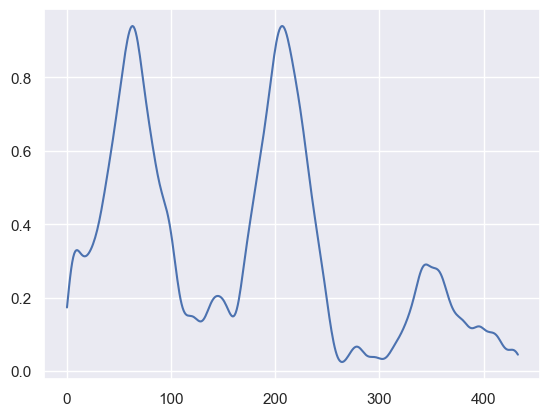

[946, 2098]
[ 928 2080 3200]
1889
cuda
epoch 1,loss = 0.99115020
epoch 2,loss = 0.99113351
epoch 3,loss = 0.99111682
epoch 4,loss = 0.99110037
epoch 5,loss = 0.99108410
epoch 6,loss = 0.99106801
epoch 7,loss = 0.99105191
epoch 8,loss = 0.99103618
epoch 9,loss = 0.99102056
epoch 10,loss = 0.99100518
epoch 11,loss = 0.99098998
epoch 12,loss = 0.99097496
epoch 13,loss = 0.99096012
epoch 14,loss = 0.99094534
epoch 15,loss = 0.99093091
epoch 16,loss = 0.99091673
epoch 17,loss = 0.99090272
epoch 18,loss = 0.99088895
epoch 19,loss = 0.99087530
epoch 20,loss = 0.99086195
epoch 21,loss = 0.99084872
epoch 22,loss = 0.99083585
epoch 23,loss = 0.99082315
epoch 24,loss = 0.99081075
epoch 25,loss = 0.99079841
epoch 26,loss = 0.99078649
epoch 27,loss = 0.99077463
epoch 28,loss = 0.99076313
epoch 29,loss = 0.99075186
epoch 30,loss = 0.99074084
epoch 31,loss = 0.99072999
epoch 32,loss = 0.99071932
epoch 33,loss = 0.99070889
epoch 34,loss = 0.99069887
epoch 35,loss = 0.99068910
epoch 36,loss = 0.9906792

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 52,loss = 0.99055278
epoch 53,loss = 0.99054760
epoch 54,loss = 0.99053258
epoch 55,loss = 0.99052858
epoch 56,loss = 0.99052650
epoch 57,loss = 0.99051952
epoch 58,loss = 0.99051023
epoch 59,loss = 0.99050462
epoch 60,loss = 0.99050003
epoch 61,loss = 0.99049711
epoch 62,loss = 0.99048632
epoch 63,loss = 0.99048001
epoch 64,loss = 0.99047101
epoch 65,loss = 0.99046642
epoch 66,loss = 0.99045873
epoch 67,loss = 0.99044830
epoch 68,loss = 0.99043596
epoch 69,loss = 0.99043876
epoch 70,loss = 0.99043441
epoch 71,loss = 0.99042445
epoch 72,loss = 0.99041361
epoch 73,loss = 0.99038851
epoch 74,loss = 0.99037921
epoch 75,loss = 0.99036634
epoch 76,loss = 0.99035394
epoch 77,loss = 0.99034292
epoch 78,loss = 0.99032754
epoch 79,loss = 0.99031264
epoch 80,loss = 0.99029708
epoch 81,loss = 0.99027705
epoch 82,loss = 0.99025315
epoch 83,loss = 0.99022669
epoch 84,loss = 0.99020374
epoch 85,loss = 0.99017429
epoch 86,loss = 0.99014801
epoch 87,loss = 0.99011785
epoch 88,loss = 0.99008238
e

epoch 356,loss = 0.35712111
epoch 357,loss = 0.35694230
epoch 358,loss = 0.35676190
epoch 359,loss = 0.35658497
epoch 360,loss = 0.35641006
epoch 361,loss = 0.35623795
epoch 362,loss = 0.35606673
epoch 363,loss = 0.35589722
epoch 364,loss = 0.35573241
epoch 365,loss = 0.35557249
epoch 366,loss = 0.35541707
epoch 367,loss = 0.35526595
epoch 368,loss = 0.35511792
epoch 369,loss = 0.35497296
epoch 370,loss = 0.35483164
epoch 371,loss = 0.35469356
epoch 372,loss = 0.35455772
epoch 373,loss = 0.35442409
epoch 374,loss = 0.35429129
epoch 375,loss = 0.35416010
epoch 376,loss = 0.35403138
epoch 377,loss = 0.35390466
epoch 378,loss = 0.35378000
epoch 379,loss = 0.35365745
epoch 380,loss = 0.35353687
epoch 381,loss = 0.35341844
epoch 382,loss = 0.35330215
epoch 383,loss = 0.35318786
epoch 384,loss = 0.35307732
epoch 385,loss = 0.35296828
epoch 386,loss = 0.35286093
epoch 387,loss = 0.35275525
epoch 388,loss = 0.35265115
epoch 389,loss = 0.35254857
epoch 390,loss = 0.35244730
epoch 391,loss = 0.3

epoch 671,loss = 0.33140761
epoch 672,loss = 0.33135486
epoch 673,loss = 0.33130214
epoch 674,loss = 0.33124942
epoch 675,loss = 0.33119649
epoch 676,loss = 0.33114359
epoch 677,loss = 0.33109078
epoch 678,loss = 0.33103800
epoch 679,loss = 0.33098516
epoch 680,loss = 0.33093247
epoch 681,loss = 0.33087978
epoch 682,loss = 0.33082697
epoch 683,loss = 0.33077404
epoch 684,loss = 0.33072108
epoch 685,loss = 0.33066812
epoch 686,loss = 0.33061519
epoch 687,loss = 0.33056235
epoch 688,loss = 0.33050945
epoch 689,loss = 0.33045658
epoch 690,loss = 0.33040375
epoch 691,loss = 0.33035091
epoch 692,loss = 0.33029807
epoch 693,loss = 0.33024526
epoch 694,loss = 0.33019248
epoch 695,loss = 0.33013931
epoch 696,loss = 0.33008599
epoch 697,loss = 0.33003265
epoch 698,loss = 0.32997921
epoch 699,loss = 0.32992575
epoch 700,loss = 0.32987228
epoch 701,loss = 0.32981884
epoch 702,loss = 0.32976544
epoch 703,loss = 0.32971194
epoch 704,loss = 0.32965839
epoch 705,loss = 0.32960480
epoch 706,loss = 0.3

epoch 1001,loss = 0.31590697
epoch 1002,loss = 0.31586570
epoch 1003,loss = 0.31582469
epoch 1004,loss = 0.31578356
epoch 1005,loss = 0.31574228
epoch 1006,loss = 0.31570083
epoch 1007,loss = 0.31565958
epoch 1008,loss = 0.31561884
epoch 1009,loss = 0.31557783
epoch 1010,loss = 0.31553710
epoch 1011,loss = 0.31549650
epoch 1012,loss = 0.31545568
epoch 1013,loss = 0.31541505
epoch 1014,loss = 0.31537461
epoch 1015,loss = 0.31533387
epoch 1016,loss = 0.31529328
epoch 1017,loss = 0.31525266
epoch 1018,loss = 0.31521180
epoch 1019,loss = 0.31517121
epoch 1020,loss = 0.31513068
epoch 1021,loss = 0.31508997
epoch 1022,loss = 0.31504843
epoch 1023,loss = 0.31500679
epoch 1024,loss = 0.31496513
epoch 1025,loss = 0.31492341
epoch 1026,loss = 0.31488165
epoch 1027,loss = 0.31483999
epoch 1028,loss = 0.31479833
epoch 1029,loss = 0.31475654
epoch 1030,loss = 0.31471452
epoch 1031,loss = 0.31467250
epoch 1032,loss = 0.31463039
epoch 1033,loss = 0.31458825
epoch 1034,loss = 0.31454608
epoch 1035,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([234, 1, 20])
1.0
Epoch 200:   loss= 0.11289  cluster difference= 1.0
Epoch 400:   loss= 0.11327  cluster difference= 0.16666666666666666
Epoch 600:   loss= 0.11489  cluster difference= 0.04700854700854701
Epoch 800:   loss= 0.11531  cluster difference= 0.017094017094017096
Epoch 1000:   loss= 0.11562  cluster difference= 0.01282051282051282
Epoch 1200:   loss= 0.11589  cluster difference= 0.004273504273504274
[6 6 1 1 2 2 7 0 0 0 0 5 4 6 6 1 2 2 7 0 0 0 0 0 3 6 6 1 1 2 7 7 0 0 0 0 5
 4 6 1 1 2 2 7 0 0 0 0 0 3 6 6 1 2 2 7 0 0 0 0 0 5 4 6 1 1 2 7 7 0 0 0 0 0
 3 6 6 1 1 2 7 7 0 0 0 0 3 6 6 1 1 2 2 7 0 0 0 0 5 4 6 1 1 2 7 2 7 0 0 0 0
 3 6 1 1 1 2 2 7 7 0 0 0 5 4 6 1 1 2 7 7 0 0 0 0 0 3 6 1 1 1 2 2 7 0 0 0 0
 5 4 6 1 1 2 2 7 0 0 0 0 0 3 4 6 1 2 7 0 0 0 7 7 7 5 1 4 6 1 7 0 0 0 0 7 7
 5 1 1 4 6 2 7 0 0 0 0 7 7 0 0 5 1 1 6 6 1 1 2 7 0 0 0 0 2 1 6 6 6 1 2 7 0
 0 0 0 7 2 1 4 6 1 1 2 7]


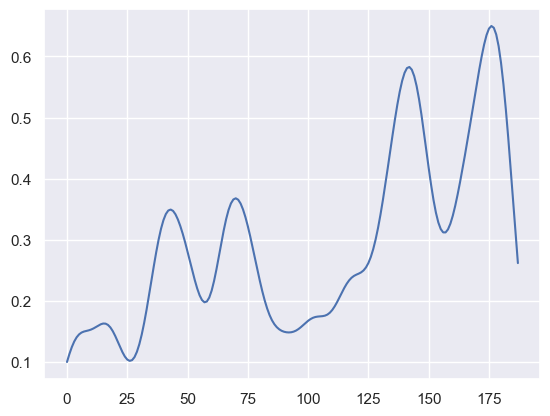

[1602]
[ 796 1293 1591]
3750
cuda
epoch 1,loss = 1.00448406
epoch 2,loss = 1.00445497
epoch 3,loss = 1.00442600
epoch 4,loss = 1.00439763
epoch 5,loss = 1.00436962
epoch 6,loss = 1.00434196
epoch 7,loss = 1.00431466
epoch 8,loss = 1.00428784
epoch 9,loss = 1.00426137
epoch 10,loss = 1.00423539
epoch 11,loss = 1.00420964
epoch 12,loss = 1.00418437
epoch 13,loss = 1.00415945
epoch 14,loss = 1.00413501
epoch 15,loss = 1.00411081
epoch 16,loss = 1.00408709
epoch 17,loss = 1.00406373
epoch 18,loss = 1.00404072
epoch 19,loss = 1.00401807
epoch 20,loss = 1.00399590
epoch 21,loss = 1.00397396
epoch 22,loss = 1.00395250
epoch 23,loss = 1.00393128
epoch 24,loss = 1.00391054
epoch 25,loss = 1.00389016
epoch 26,loss = 1.00387001
epoch 27,loss = 1.00385022
epoch 28,loss = 1.00383079
epoch 29,loss = 1.00381172
epoch 30,loss = 1.00379288
epoch 31,loss = 1.00377452
epoch 32,loss = 1.00375640
epoch 33,loss = 1.00373864
epoch 34,loss = 1.00372100
epoch 35,loss = 1.00370395
epoch 36,loss = 1.00368702
epo

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 42,loss = 1.00359178
epoch 43,loss = 1.00357664
epoch 44,loss = 1.00356197
epoch 45,loss = 1.00354755
epoch 46,loss = 1.00353336
epoch 47,loss = 1.00351942
epoch 48,loss = 1.00350571
epoch 49,loss = 1.00349176
epoch 50,loss = 1.00347710
epoch 51,loss = 1.00346243
epoch 52,loss = 1.00344801
epoch 53,loss = 1.00343382
epoch 54,loss = 1.00342011
epoch 55,loss = 1.00340688
epoch 56,loss = 1.00339365
epoch 57,loss = 1.00338042
epoch 58,loss = 1.00336719
epoch 59,loss = 1.00335395
epoch 60,loss = 1.00334084
epoch 61,loss = 1.00332761
epoch 62,loss = 1.00331450
epoch 63,loss = 1.00330114
epoch 64,loss = 1.00328755
epoch 65,loss = 1.00327408
epoch 66,loss = 1.00326025
epoch 67,loss = 1.00324631
epoch 68,loss = 1.00323236
epoch 69,loss = 1.00321770
epoch 70,loss = 1.00319707
epoch 71,loss = 1.00317097
epoch 72,loss = 1.00314355
epoch 73,loss = 1.00311637
epoch 74,loss = 1.00308919
epoch 75,loss = 1.00306094
epoch 76,loss = 1.00303173
epoch 77,loss = 1.00300181
epoch 78,loss = 1.00297070
e

epoch 348,loss = 0.82807791
epoch 349,loss = 0.82785016
epoch 350,loss = 0.82761985
epoch 351,loss = 0.82739037
epoch 352,loss = 0.82716054
epoch 353,loss = 0.82692897
epoch 354,loss = 0.82669383
epoch 355,loss = 0.82646334
epoch 356,loss = 0.82623225
epoch 357,loss = 0.82600260
epoch 358,loss = 0.82577747
epoch 359,loss = 0.82555395
epoch 360,loss = 0.82533616
epoch 361,loss = 0.82511753
epoch 362,loss = 0.82490140
epoch 363,loss = 0.82468385
epoch 364,loss = 0.82447177
epoch 365,loss = 0.82425815
epoch 366,loss = 0.82404298
epoch 367,loss = 0.82382792
epoch 368,loss = 0.82361597
epoch 369,loss = 0.82340896
epoch 370,loss = 0.82319897
epoch 371,loss = 0.82299018
epoch 372,loss = 0.82278317
epoch 373,loss = 0.82257897
epoch 374,loss = 0.82237715
epoch 375,loss = 0.82218015
epoch 376,loss = 0.82198536
epoch 377,loss = 0.82179207
epoch 378,loss = 0.82160062
epoch 379,loss = 0.82140714
epoch 380,loss = 0.82121617
epoch 381,loss = 0.82102180
epoch 382,loss = 0.82082433
epoch 383,loss = 0.8

epoch 645,loss = 0.79784048
epoch 646,loss = 0.79778987
epoch 647,loss = 0.79774016
epoch 648,loss = 0.79768914
epoch 649,loss = 0.79763800
epoch 650,loss = 0.79758799
epoch 651,loss = 0.79753822
epoch 652,loss = 0.79748780
epoch 653,loss = 0.79743707
epoch 654,loss = 0.79738659
epoch 655,loss = 0.79733640
epoch 656,loss = 0.79728693
epoch 657,loss = 0.79723746
epoch 658,loss = 0.79718751
epoch 659,loss = 0.79713899
epoch 660,loss = 0.79709095
epoch 661,loss = 0.79704350
epoch 662,loss = 0.79699689
epoch 663,loss = 0.79694921
epoch 664,loss = 0.79690135
epoch 665,loss = 0.79685336
epoch 666,loss = 0.79680485
epoch 667,loss = 0.79675573
epoch 668,loss = 0.79670656
epoch 669,loss = 0.79665846
epoch 670,loss = 0.79661089
epoch 671,loss = 0.79656023
epoch 672,loss = 0.79650724
epoch 673,loss = 0.79645479
epoch 674,loss = 0.79640532
epoch 675,loss = 0.79635769
epoch 676,loss = 0.79631031
epoch 677,loss = 0.79626292
epoch 678,loss = 0.79621536
epoch 679,loss = 0.79616773
epoch 680,loss = 0.7

epoch 946,loss = 0.78684384
epoch 947,loss = 0.78682590
epoch 948,loss = 0.78680861
epoch 949,loss = 0.78679109
epoch 950,loss = 0.78677350
epoch 951,loss = 0.78675616
epoch 952,loss = 0.78673899
epoch 953,loss = 0.78672177
epoch 954,loss = 0.78670555
epoch 955,loss = 0.78668880
epoch 956,loss = 0.78667212
epoch 957,loss = 0.78665537
epoch 958,loss = 0.78663850
epoch 959,loss = 0.78662175
epoch 960,loss = 0.78660583
epoch 961,loss = 0.78658968
epoch 962,loss = 0.78657299
epoch 963,loss = 0.78655565
epoch 964,loss = 0.78653896
epoch 965,loss = 0.78652233
epoch 966,loss = 0.78650552
epoch 967,loss = 0.78648937
epoch 968,loss = 0.78647280
epoch 969,loss = 0.78645694
epoch 970,loss = 0.78644073
epoch 971,loss = 0.78642380
epoch 972,loss = 0.78640902
epoch 973,loss = 0.78639209
epoch 974,loss = 0.78637409
epoch 975,loss = 0.78635812
epoch 976,loss = 0.78634083
epoch 977,loss = 0.78632253
epoch 978,loss = 0.78630614
epoch 979,loss = 0.78628880
epoch 980,loss = 0.78627086
epoch 981,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([467, 1, 20])
1.0
Epoch 200:   loss= 0.20081  cluster difference= 1.0
Epoch 400:   loss= 0.19986  cluster difference= 0.032119914346895075
Epoch 600:   loss= 0.19887  cluster difference= 0.042826552462526764
Epoch 800:   loss= 0.19786  cluster difference= 0.03854389721627409
Epoch 1000:   loss= 0.19687  cluster difference= 0.03640256959314775
Epoch 1200:   loss= 0.19595  cluster difference= 0.027837259100642397
Epoch 1400:   loss= 0.19509  cluster difference= 0.02569593147751606
Epoch 1600:   loss= 0.19428  cluster difference= 0.027837259100642397
Epoch 1800:   loss= 0.19357  cluster difference= 0.01284796573875803
Epoch 2000:   loss= 0.19292  cluster difference= 0.017130620985010708
Epoch 2200:   loss= 0.19229  cluster difference= 0.010706638115631691
Epoch 2400:   loss= 0.19168  cluster difference= 0.0021413276231263384
[7 7 7 7 0 7 0 7 7 7 7 7 7 7 7 7 7 7 7 0 7 0 7 7 0 7 7 7 7 0 7 7 7 7 0 5 0
 0 2 5 7 0 7 7 7 7 7 7 7 7 0 7 7 7 7 7 7 7 0 7 7 7 0 5 7 0 7 7 7 7 7 7 7 0
 7 0 

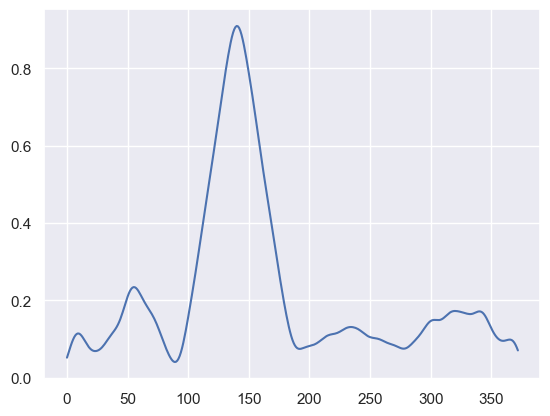

[1506]
[ 750 1500 2250 3000]
2770
cuda
epoch 1,loss = 1.01541543
epoch 2,loss = 1.01482832
epoch 3,loss = 1.01425648
epoch 4,loss = 1.01370013
epoch 5,loss = 1.01315904
epoch 6,loss = 1.01263344
epoch 7,loss = 1.01212323
epoch 8,loss = 1.01162839
epoch 9,loss = 1.01114893
epoch 10,loss = 1.01068461
epoch 11,loss = 1.01023543
epoch 12,loss = 1.00981021
epoch 13,loss = 1.00940037
epoch 14,loss = 1.00900173
epoch 15,loss = 1.00861704
epoch 16,loss = 1.00824630
epoch 17,loss = 1.00788915
epoch 18,loss = 1.00754523
epoch 19,loss = 1.00721419
epoch 20,loss = 1.00689578
epoch 21,loss = 1.00658941
epoch 22,loss = 1.00628459
epoch 23,loss = 1.00598383
epoch 24,loss = 1.00569916
epoch 25,loss = 1.00541055
epoch 26,loss = 1.00516343
epoch 27,loss = 1.00492513
epoch 28,loss = 1.00469351
epoch 29,loss = 1.00446439
epoch 30,loss = 1.00425088
epoch 31,loss = 1.00404489
epoch 32,loss = 1.00384355
epoch 33,loss = 1.00364888
epoch 34,loss = 1.00346088
epoch 35,loss = 1.00327909
epoch 36,loss = 1.0031034

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 42,loss = 1.00216782
epoch 43,loss = 1.00202990
epoch 44,loss = 1.00189650
epoch 45,loss = 1.00176775
epoch 46,loss = 1.00164330
epoch 47,loss = 1.00152314
epoch 48,loss = 1.00140727
epoch 49,loss = 1.00129509
epoch 50,loss = 1.00118673
epoch 51,loss = 1.00108218
epoch 52,loss = 1.00098121
epoch 53,loss = 1.00088370
epoch 54,loss = 1.00078952
epoch 55,loss = 1.00069857
epoch 56,loss = 1.00061083
epoch 57,loss = 1.00052595
epoch 58,loss = 1.00044394
epoch 59,loss = 1.00036490
epoch 60,loss = 1.00028861
epoch 61,loss = 1.00021470
epoch 62,loss = 1.00014353
epoch 63,loss = 1.00007474
epoch 64,loss = 1.00000834
epoch 65,loss = 0.99994421
epoch 66,loss = 0.99988228
epoch 67,loss = 0.99982238
epoch 68,loss = 0.99976456
epoch 69,loss = 0.99970871
epoch 70,loss = 0.99965477
epoch 71,loss = 0.99960268
epoch 72,loss = 0.99955231
epoch 73,loss = 0.99950361
epoch 74,loss = 0.99945652
epoch 75,loss = 0.99941093
epoch 76,loss = 0.99936700
epoch 77,loss = 0.99932444
epoch 78,loss = 0.99928325
e

epoch 344,loss = 0.77204221
epoch 345,loss = 0.77078694
epoch 346,loss = 0.76955438
epoch 347,loss = 0.76832795
epoch 348,loss = 0.76713443
epoch 349,loss = 0.76596969
epoch 350,loss = 0.76483560
epoch 351,loss = 0.76372868
epoch 352,loss = 0.76264334
epoch 353,loss = 0.76159257
epoch 354,loss = 0.76055241
epoch 355,loss = 0.75955045
epoch 356,loss = 0.75858957
epoch 357,loss = 0.75766844
epoch 358,loss = 0.75677764
epoch 359,loss = 0.75590140
epoch 360,loss = 0.75504053
epoch 361,loss = 0.75420374
epoch 362,loss = 0.75339007
epoch 363,loss = 0.75258249
epoch 364,loss = 0.75179058
epoch 365,loss = 0.75100780
epoch 366,loss = 0.75024372
epoch 367,loss = 0.74949092
epoch 368,loss = 0.74874198
epoch 369,loss = 0.74798870
epoch 370,loss = 0.74723095
epoch 371,loss = 0.74647784
epoch 372,loss = 0.74572343
epoch 373,loss = 0.74497294
epoch 374,loss = 0.74423516
epoch 375,loss = 0.74348938
epoch 376,loss = 0.74272788
epoch 377,loss = 0.74197263
epoch 378,loss = 0.74121588
epoch 379,loss = 0.7

epoch 642,loss = 0.68989336
epoch 643,loss = 0.68986171
epoch 644,loss = 0.68983012
epoch 645,loss = 0.68979847
epoch 646,loss = 0.68976688
epoch 647,loss = 0.68973523
epoch 648,loss = 0.68970364
epoch 649,loss = 0.68967223
epoch 650,loss = 0.68964076
epoch 651,loss = 0.68960941
epoch 652,loss = 0.68957806
epoch 653,loss = 0.68954664
epoch 654,loss = 0.68951541
epoch 655,loss = 0.68948418
epoch 656,loss = 0.68945307
epoch 657,loss = 0.68942201
epoch 658,loss = 0.68939096
epoch 659,loss = 0.68936002
epoch 660,loss = 0.68932921
epoch 661,loss = 0.68929833
epoch 662,loss = 0.68926758
epoch 663,loss = 0.68923694
epoch 664,loss = 0.68920630
epoch 665,loss = 0.68917578
epoch 666,loss = 0.68914527
epoch 667,loss = 0.68911487
epoch 668,loss = 0.68908459
epoch 669,loss = 0.68905443
epoch 670,loss = 0.68902415
epoch 671,loss = 0.68899423
epoch 672,loss = 0.68896419
epoch 673,loss = 0.68893445
epoch 674,loss = 0.68890482
epoch 675,loss = 0.68887526
epoch 676,loss = 0.68884575
epoch 677,loss = 0.6

epoch 949,loss = 0.68315399
epoch 950,loss = 0.68313926
epoch 951,loss = 0.68312472
epoch 952,loss = 0.68311018
epoch 953,loss = 0.68309557
epoch 954,loss = 0.68308103
epoch 955,loss = 0.68306655
epoch 956,loss = 0.68305224
epoch 957,loss = 0.68303782
epoch 958,loss = 0.68302351
epoch 959,loss = 0.68300915
epoch 960,loss = 0.68299490
epoch 961,loss = 0.68298072
epoch 962,loss = 0.68296641
epoch 963,loss = 0.68295228
epoch 964,loss = 0.68293816
epoch 965,loss = 0.68292409
epoch 966,loss = 0.68291008
epoch 967,loss = 0.68289608
epoch 968,loss = 0.68288207
epoch 969,loss = 0.68286818
epoch 970,loss = 0.68285435
epoch 971,loss = 0.68284035
epoch 972,loss = 0.68282640
epoch 973,loss = 0.68281251
epoch 974,loss = 0.68279874
epoch 975,loss = 0.68278497
epoch 976,loss = 0.68277121
epoch 977,loss = 0.68275744
epoch 978,loss = 0.68274373
epoch 979,loss = 0.68273002
epoch 980,loss = 0.68271625
epoch 981,loss = 0.68270254
epoch 982,loss = 0.68268895
epoch 983,loss = 0.68267530
epoch 984,loss = 0.6

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([344, 1, 20])
1.0
Epoch 200:   loss= 0.20086  cluster difference= 1.0
Epoch 400:   loss= 0.19971  cluster difference= 0.03197674418604651
Epoch 600:   loss= 0.19884  cluster difference= 0.023255813953488372
Epoch 800:   loss= 0.19831  cluster difference= 0.01744186046511628
Epoch 1000:   loss= 0.19809  cluster difference= 0.029069767441860465
Epoch 1200:   loss= 0.19809  cluster difference= 0.03197674418604651
Epoch 1400:   loss= 0.19808  cluster difference= 0.014534883720930232
Epoch 1600:   loss= 0.19801  cluster difference= 0.020348837209302327
Epoch 1800:   loss= 0.19786  cluster difference= 0.014534883720930232
Epoch 2000:   loss= 0.19765  cluster difference= 0.011627906976744186
Epoch 2200:   loss= 0.19739  cluster difference= 0.01744186046511628
Epoch 2400:   loss= 0.1971  cluster difference= 0.023255813953488372
Epoch 2600:   loss= 0.19678  cluster difference= 0.011627906976744186
Epoch 2800:   loss= 0.19645  cluster difference= 0.00872093023255814
[4 2 5 1 4 2 6 4 7

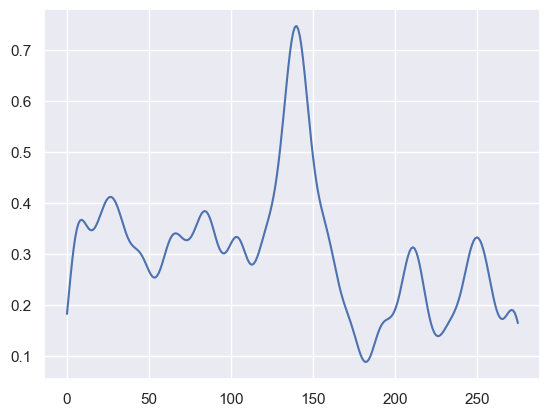

[1402]
[1385]
3086
cuda
epoch 1,loss = 1.00988328
epoch 2,loss = 1.00986981
epoch 3,loss = 1.00985682
epoch 4,loss = 1.00984406
epoch 5,loss = 1.00983155
epoch 6,loss = 1.00981939
epoch 7,loss = 1.00980747
epoch 8,loss = 1.00979590
epoch 9,loss = 1.00976646
epoch 10,loss = 1.00972223
epoch 11,loss = 1.00971925
epoch 12,loss = 1.00971663
epoch 13,loss = 1.00971425
epoch 14,loss = 1.00971174
epoch 15,loss = 1.00970984
epoch 16,loss = 1.00971019
epoch 17,loss = 1.00970960
epoch 18,loss = 1.00970364
epoch 19,loss = 1.00969517
epoch 20,loss = 1.00968719
epoch 21,loss = 1.00968063
epoch 22,loss = 1.00967455
epoch 23,loss = 1.00966823
epoch 24,loss = 1.00966179
epoch 25,loss = 1.00965536
epoch 26,loss = 1.00964868
epoch 27,loss = 1.00964189
epoch 28,loss = 1.00963485
epoch 29,loss = 1.00962782
epoch 30,loss = 1.00962055
epoch 31,loss = 1.00961328
epoch 32,loss = 1.00960553
epoch 33,loss = 1.00959766
epoch 34,loss = 1.00959158
epoch 35,loss = 1.00958097
epoch 36,loss = 1.00957239
epoch 37,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 47,loss = 1.00946200
epoch 48,loss = 1.00945091
epoch 49,loss = 1.00944269
epoch 50,loss = 1.00942492
epoch 51,loss = 1.00941384
epoch 52,loss = 1.00940394
epoch 53,loss = 1.00939322
epoch 54,loss = 1.00938010
epoch 55,loss = 1.00936437
epoch 56,loss = 1.00934672
epoch 57,loss = 1.00932825
epoch 58,loss = 1.00931025
epoch 59,loss = 1.00929260
epoch 60,loss = 1.00927496
epoch 61,loss = 1.00925684
epoch 62,loss = 1.00923789
epoch 63,loss = 1.00921893
epoch 64,loss = 1.00919509
epoch 65,loss = 1.00917244
epoch 66,loss = 1.00915015
epoch 67,loss = 1.00912738
epoch 68,loss = 1.00910378
epoch 69,loss = 1.00907862
epoch 70,loss = 1.00905144
epoch 71,loss = 1.00902271
epoch 72,loss = 1.00899303
epoch 73,loss = 1.00896680
epoch 74,loss = 1.00893295
epoch 75,loss = 1.00890207
epoch 76,loss = 1.00886905
epoch 77,loss = 1.00883436
epoch 78,loss = 1.00879765
epoch 79,loss = 1.00875914
epoch 80,loss = 1.00871944
epoch 81,loss = 1.00867808
epoch 82,loss = 1.00863492
epoch 83,loss = 1.00858998
e

epoch 351,loss = 0.54111826
epoch 352,loss = 0.54079556
epoch 353,loss = 0.54047638
epoch 354,loss = 0.54016149
epoch 355,loss = 0.53985065
epoch 356,loss = 0.53955114
epoch 357,loss = 0.53925580
epoch 358,loss = 0.53896588
epoch 359,loss = 0.53868312
epoch 360,loss = 0.53840792
epoch 361,loss = 0.53813785
epoch 362,loss = 0.53787208
epoch 363,loss = 0.53761590
epoch 364,loss = 0.53737044
epoch 365,loss = 0.53713417
epoch 366,loss = 0.53690457
epoch 367,loss = 0.53667450
epoch 368,loss = 0.53644764
epoch 369,loss = 0.53622222
epoch 370,loss = 0.53600150
epoch 371,loss = 0.53578782
epoch 372,loss = 0.53557491
epoch 373,loss = 0.53536332
epoch 374,loss = 0.53514892
epoch 375,loss = 0.53493756
epoch 376,loss = 0.53473270
epoch 377,loss = 0.53453481
epoch 378,loss = 0.53434074
epoch 379,loss = 0.53414667
epoch 380,loss = 0.53395402
epoch 381,loss = 0.53376275
epoch 382,loss = 0.53357351
epoch 383,loss = 0.53338742
epoch 384,loss = 0.53320742
epoch 385,loss = 0.53302890
epoch 386,loss = 0.5

epoch 665,loss = 0.50445837
epoch 666,loss = 0.50439191
epoch 667,loss = 0.50432628
epoch 668,loss = 0.50426155
epoch 669,loss = 0.50419611
epoch 670,loss = 0.50413007
epoch 671,loss = 0.50406468
epoch 672,loss = 0.50400013
epoch 673,loss = 0.50393599
epoch 674,loss = 0.50387186
epoch 675,loss = 0.50380725
epoch 676,loss = 0.50374353
epoch 677,loss = 0.50367928
epoch 678,loss = 0.50361496
epoch 679,loss = 0.50355065
epoch 680,loss = 0.50348634
epoch 681,loss = 0.50342214
epoch 682,loss = 0.50335801
epoch 683,loss = 0.50329399
epoch 684,loss = 0.50323021
epoch 685,loss = 0.50316644
epoch 686,loss = 0.50310314
epoch 687,loss = 0.50304008
epoch 688,loss = 0.50297719
epoch 689,loss = 0.50291437
epoch 690,loss = 0.50285167
epoch 691,loss = 0.50278908
epoch 692,loss = 0.50272667
epoch 693,loss = 0.50266433
epoch 694,loss = 0.50260216
epoch 695,loss = 0.50254011
epoch 696,loss = 0.50247818
epoch 697,loss = 0.50241637
epoch 698,loss = 0.50235450
epoch 699,loss = 0.50229275
epoch 700,loss = 0.5

epoch 978,loss = 0.48696494
epoch 979,loss = 0.48691455
epoch 980,loss = 0.48686484
epoch 981,loss = 0.48681527
epoch 982,loss = 0.48676586
epoch 983,loss = 0.48671651
epoch 984,loss = 0.48666734
epoch 985,loss = 0.48661828
epoch 986,loss = 0.48656961
epoch 987,loss = 0.48652112
epoch 988,loss = 0.48647204
epoch 989,loss = 0.48642284
epoch 990,loss = 0.48637366
epoch 991,loss = 0.48632473
epoch 992,loss = 0.48627609
epoch 993,loss = 0.48622742
epoch 994,loss = 0.48617861
epoch 995,loss = 0.48612982
epoch 996,loss = 0.48608127
epoch 997,loss = 0.48603269
epoch 998,loss = 0.48598406
epoch 999,loss = 0.48593512
epoch 1000,loss = 0.48588592
epoch 1001,loss = 0.48583630
epoch 1002,loss = 0.48578653
epoch 1003,loss = 0.48573741
epoch 1004,loss = 0.48568827
epoch 1005,loss = 0.48563877
epoch 1006,loss = 0.48558950
epoch 1007,loss = 0.48554048
epoch 1008,loss = 0.48549062
epoch 1009,loss = 0.48544046
epoch 1010,loss = 0.48539042
epoch 1011,loss = 0.48534095
epoch 1012,loss = 0.48529169
epoch 1

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([384, 1, 20])
1.0
Epoch 200:   loss= 0.192  cluster difference= 1.0
Epoch 400:   loss= 0.18994  cluster difference= 0.015625
Epoch 600:   loss= 0.18873  cluster difference= 0.0234375
Epoch 800:   loss= 0.18774  cluster difference= 0.018229166666666668
Epoch 1000:   loss= 0.18677  cluster difference= 0.0234375
Epoch 1200:   loss= 0.18578  cluster difference= 0.020833333333333332
Epoch 1400:   loss= 0.18478  cluster difference= 0.0078125
[4 1 0 0 6 4 3 0 2 4 3 0 2 4 1 0 2 4 1 0 5 4 3 0 2 4 1 0 5 4 1 0 5 6 4 3 0
 6 4 7 0 2 4 7 0 5 6 1 3 0 6 4 3 0 2 4 7 0 2 4 1 0 0 5 6 7 0 5 6 4 3 5 4 1
 0 0 2 4 1 0 2 4 1 0 2 7 0 5 4 4 3 0 5 6 1 0 2 4 7 0 5 6 4 3 0 5 4 7 0 0 6
 4 3 0 6 4 3 0 2 4 1 0 5 4 4 3 5 4 3 0 0 6 1 0 2 4 4 1 3 5 6 3 0 2 4 7 0 6
 4 7 0 6 4 3 5 6 4 7 0 5 6 1 0 0 6 4 3 0 2 4 2 4 3 0 0 6 4 7 0 5 6 7 0 6 4
 7 0 0 6 4 7 0 0 2 7 0 0 0 6 4 4 4 3 0 0 2 4 4 4 7 0 5 4 4 7 2 4 4 3 0 5 6
 7 0 2 4 1 0 5 6 4 7 0 5 1 2 1 0 2 1 0 6 4 3 2 4 3 5 4 3 2 4 3 2 4 3 0 0 2
 1 0 0 6 4 4 1 0 5 3 5 6

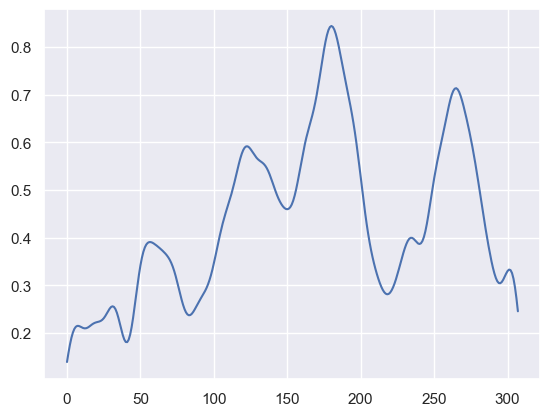

[1754, 2434]
[1543]
5086
cuda
epoch 1,loss = 1.00080657
epoch 2,loss = 1.00080383
epoch 3,loss = 1.00080132
epoch 4,loss = 1.00079906
epoch 5,loss = 1.00079691
epoch 6,loss = 1.00079489
epoch 7,loss = 1.00079298
epoch 8,loss = 1.00079131
epoch 9,loss = 1.00078976
epoch 10,loss = 1.00078845
epoch 11,loss = 1.00078714
epoch 12,loss = 1.00078595
epoch 13,loss = 1.00078487
epoch 14,loss = 1.00078404
epoch 15,loss = 1.00078321
epoch 16,loss = 1.00078249
epoch 17,loss = 1.00078201
epoch 18,loss = 1.00078154
epoch 19,loss = 1.00078106
epoch 20,loss = 1.00078070
epoch 21,loss = 1.00078046
epoch 22,loss = 1.00078011
epoch 23,loss = 1.00078011
epoch 24,loss = 1.00077987
epoch 25,loss = 1.00077975
epoch 26,loss = 1.00077963
epoch 27,loss = 1.00077963
epoch 28,loss = 1.00077951
epoch 29,loss = 1.00077951
epoch 30,loss = 1.00077939
epoch 31,loss = 1.00077939
epoch 32,loss = 1.00077939
epoch 33,loss = 1.00077939
epoch 34,loss = 1.00077939
epoch 35,loss = 1.00077939
epoch 36,loss = 1.00077927
epoch 3

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 46,loss = 1.00077844
epoch 47,loss = 1.00077844
epoch 48,loss = 1.00077832
epoch 49,loss = 1.00077808
epoch 50,loss = 1.00077808
epoch 51,loss = 1.00077796
epoch 52,loss = 1.00077772
epoch 53,loss = 1.00077736
epoch 54,loss = 1.00077713
epoch 55,loss = 1.00077677
epoch 56,loss = 1.00077617
epoch 57,loss = 1.00077546
epoch 58,loss = 1.00077462
epoch 59,loss = 1.00077343
epoch 60,loss = 1.00077188
epoch 61,loss = 1.00076985
epoch 62,loss = 1.00076747
epoch 63,loss = 1.00076473
epoch 64,loss = 1.00076139
epoch 65,loss = 1.00075769
epoch 66,loss = 1.00075340
epoch 67,loss = 1.00074852
epoch 68,loss = 1.00074291
epoch 69,loss = 1.00073647
epoch 70,loss = 1.00072944
epoch 71,loss = 1.00072134
epoch 72,loss = 1.00071239
epoch 73,loss = 1.00070274
epoch 74,loss = 1.00069320
epoch 75,loss = 1.00068212
epoch 76,loss = 1.00066805
epoch 77,loss = 1.00064957
epoch 78,loss = 1.00062644
epoch 79,loss = 1.00059426
epoch 80,loss = 1.00055313
epoch 81,loss = 1.00050139
epoch 82,loss = 1.00042868
e

epoch 363,loss = 0.84373212
epoch 364,loss = 0.84367418
epoch 365,loss = 0.84361589
epoch 366,loss = 0.84355742
epoch 367,loss = 0.84349859
epoch 368,loss = 0.84343964
epoch 369,loss = 0.84338045
epoch 370,loss = 0.84332114
epoch 371,loss = 0.84326148
epoch 372,loss = 0.84320152
epoch 373,loss = 0.84314138
epoch 374,loss = 0.84308124
epoch 375,loss = 0.84302098
epoch 376,loss = 0.84296048
epoch 377,loss = 0.84289974
epoch 378,loss = 0.84283882
epoch 379,loss = 0.84277773
epoch 380,loss = 0.84271669
epoch 381,loss = 0.84265530
epoch 382,loss = 0.84259343
epoch 383,loss = 0.84253174
epoch 384,loss = 0.84247011
epoch 385,loss = 0.84240854
epoch 386,loss = 0.84234667
epoch 387,loss = 0.84228498
epoch 388,loss = 0.84222376
epoch 389,loss = 0.84216243
epoch 390,loss = 0.84210098
epoch 391,loss = 0.84203941
epoch 392,loss = 0.84197748
epoch 393,loss = 0.84191513
epoch 394,loss = 0.84185278
epoch 395,loss = 0.84179050
epoch 396,loss = 0.84172851
epoch 397,loss = 0.84166664
epoch 398,loss = 0.8

epoch 659,loss = 0.82545680
epoch 660,loss = 0.82541060
epoch 661,loss = 0.82536423
epoch 662,loss = 0.82531804
epoch 663,loss = 0.82527161
epoch 664,loss = 0.82522506
epoch 665,loss = 0.82517844
epoch 666,loss = 0.82513160
epoch 667,loss = 0.82508463
epoch 668,loss = 0.82503730
epoch 669,loss = 0.82499021
epoch 670,loss = 0.82494295
epoch 671,loss = 0.82489562
epoch 672,loss = 0.82484835
epoch 673,loss = 0.82480103
epoch 674,loss = 0.82475364
epoch 675,loss = 0.82470655
epoch 676,loss = 0.82465935
epoch 677,loss = 0.82461226
epoch 678,loss = 0.82456517
epoch 679,loss = 0.82451791
epoch 680,loss = 0.82447052
epoch 681,loss = 0.82442319
epoch 682,loss = 0.82437581
epoch 683,loss = 0.82432830
epoch 684,loss = 0.82428080
epoch 685,loss = 0.82423300
epoch 686,loss = 0.82418507
epoch 687,loss = 0.82413685
epoch 688,loss = 0.82408851
epoch 689,loss = 0.82403982
epoch 690,loss = 0.82399082
epoch 691,loss = 0.82394141
epoch 692,loss = 0.82389170
epoch 693,loss = 0.82384175
epoch 694,loss = 0.8

epoch 983,loss = 0.80048037
epoch 984,loss = 0.80045056
epoch 985,loss = 0.80042100
epoch 986,loss = 0.80039150
epoch 987,loss = 0.80036205
epoch 988,loss = 0.80033273
epoch 989,loss = 0.80030334
epoch 990,loss = 0.80027425
epoch 991,loss = 0.80024511
epoch 992,loss = 0.80021608
epoch 993,loss = 0.80018705
epoch 994,loss = 0.80015814
epoch 995,loss = 0.80012929
epoch 996,loss = 0.80010027
epoch 997,loss = 0.80007142
epoch 998,loss = 0.80004245
epoch 999,loss = 0.80001378
epoch 1000,loss = 0.79998493
epoch 1001,loss = 0.79995608
epoch 1002,loss = 0.79992735
epoch 1003,loss = 0.79989856
epoch 1004,loss = 0.79986984
epoch 1005,loss = 0.79984111
epoch 1006,loss = 0.79981232
epoch 1007,loss = 0.79978359
epoch 1008,loss = 0.79975492
epoch 1009,loss = 0.79972631
epoch 1010,loss = 0.79969770
epoch 1011,loss = 0.79966909
epoch 1012,loss = 0.79964042
epoch 1013,loss = 0.79961181
epoch 1014,loss = 0.79958332
epoch 1015,loss = 0.79955465
epoch 1016,loss = 0.79952598
epoch 1017,loss = 0.79949760
ep

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([252, 1, 50])
1.0
Epoch 200:   loss= 0.19212  cluster difference= 1.0
Epoch 400:   loss= 0.19138  cluster difference= 0.047619047619047616
Epoch 600:   loss= 0.1898  cluster difference= 0.051587301587301584
Epoch 800:   loss= 0.1882  cluster difference= 0.011904761904761904
Epoch 1000:   loss= 0.18679  cluster difference= 0.031746031746031744
Epoch 1200:   loss= 0.18547  cluster difference= 0.015873015873015872
Epoch 1400:   loss= 0.18418  cluster difference= 0.007936507936507936
[0 5 3 2 5 6 2 5 3 7 2 5 6 2 4 1 7 0 5 7 2 4 6 2 4 6 7 0 5 3 2 4 6 7 4 1 7
 2 5 6 2 0 5 7 2 4 6 7 4 1 7 2 4 6 7 4 1 7 0 5 3 2 0 5 7 2 5 3 2 5 6 0 1 7
 2 5 3 2 4 1 2 0 5 7 7 4 6 7 0 5 3 2 4 6 2 0 1 7 2 5 3 7 4 1 7 7 5 6 2 4 6
 7 0 5 3 2 4 6 2 0 1 7 7 5 3 7 0 5 3 2 5 3 2 4 1 2 0 5 3 2 4 1 2 0 1 7 7 4
 3 7 0 5 3 2 5 6 2 4 5 7 0 5 7 7 4 6 7 0 1 7 7 4 3 7 0 1 7 7 5 3 7 0 5 7 2
 5 3 2 4 6 7 0 5 3 2 4 1 2 0 1 7 7 4 1 2 0 1 7 7 5 3 7 4 5 7 0 5 7 7 4 6 7
 0 5 7 7 4 3 7 0 1 7 7 5 6 2 0 5 7 2 5 3 7 4 1 7 0 5 3

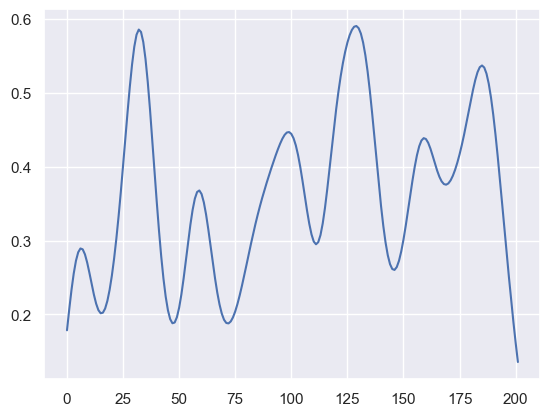

[]
[1443 2955]
471
cuda
epoch 1,loss = 1.00885522
epoch 2,loss = 1.00884914
epoch 3,loss = 1.00884330
epoch 4,loss = 1.00883722
epoch 5,loss = 1.00883150
epoch 6,loss = 1.00882578
epoch 7,loss = 1.00882018
epoch 8,loss = 1.00881457
epoch 9,loss = 1.00880897
epoch 10,loss = 1.00880361
epoch 11,loss = 1.00879812
epoch 12,loss = 1.00879276
epoch 13,loss = 1.00878739
epoch 14,loss = 1.00878227
epoch 15,loss = 1.00877988
epoch 16,loss = 1.00877535
epoch 17,loss = 1.00876975
epoch 18,loss = 1.00876379
epoch 19,loss = 1.00875866
epoch 20,loss = 1.00875437
epoch 21,loss = 1.00874984
epoch 22,loss = 1.00874519
epoch 23,loss = 1.00874054
epoch 24,loss = 1.00873590
epoch 25,loss = 1.00873101
epoch 26,loss = 1.00872612
epoch 27,loss = 1.00872111
epoch 28,loss = 1.00871599
epoch 29,loss = 1.00871074
epoch 30,loss = 1.00870538
epoch 31,loss = 1.00870001
epoch 32,loss = 1.00869453
epoch 33,loss = 1.00868917
epoch 34,loss = 1.00868356
epoch 35,loss = 1.00867784
epoch 36,loss = 1.00867236
epoch 37,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 69,loss = 1.00789511
epoch 70,loss = 1.00785851
epoch 71,loss = 1.00782049
epoch 72,loss = 1.00778079
epoch 73,loss = 1.00773966
epoch 74,loss = 1.00769687
epoch 75,loss = 1.00765276
epoch 76,loss = 1.00760710
epoch 77,loss = 1.00755978
epoch 78,loss = 1.00751078
epoch 79,loss = 1.00745940
epoch 80,loss = 1.00740600
epoch 81,loss = 1.00735509
epoch 82,loss = 1.00730789
epoch 83,loss = 1.00725842
epoch 84,loss = 1.00720000
epoch 85,loss = 1.00713575
epoch 86,loss = 1.00706923
epoch 87,loss = 1.00700510
epoch 88,loss = 1.00693488
epoch 89,loss = 1.00684929
epoch 90,loss = 1.00675833
epoch 91,loss = 1.00665510
epoch 92,loss = 1.00654674
epoch 93,loss = 1.00645065
epoch 94,loss = 1.00635850
epoch 95,loss = 1.00627124
epoch 96,loss = 1.00617981
epoch 97,loss = 1.00608408
epoch 98,loss = 1.00598359
epoch 99,loss = 1.00587368
epoch 100,loss = 1.00575721
epoch 101,loss = 1.00562322
epoch 102,loss = 1.00545788
epoch 103,loss = 1.00526619
epoch 104,loss = 1.00501537
epoch 105,loss = 1.0046

epoch 365,loss = 0.76916814
epoch 366,loss = 0.76874435
epoch 367,loss = 0.76832050
epoch 368,loss = 0.76790088
epoch 369,loss = 0.76748621
epoch 370,loss = 0.76707238
epoch 371,loss = 0.76665854
epoch 372,loss = 0.76624542
epoch 373,loss = 0.76583713
epoch 374,loss = 0.76544631
epoch 375,loss = 0.76505876
epoch 376,loss = 0.76467264
epoch 377,loss = 0.76428753
epoch 378,loss = 0.76390308
epoch 379,loss = 0.76351923
epoch 380,loss = 0.76313651
epoch 381,loss = 0.76275444
epoch 382,loss = 0.76237321
epoch 383,loss = 0.76199299
epoch 384,loss = 0.76161814
epoch 385,loss = 0.76124275
epoch 386,loss = 0.76086742
epoch 387,loss = 0.76049197
epoch 388,loss = 0.76011777
epoch 389,loss = 0.75974399
epoch 390,loss = 0.75937063
epoch 391,loss = 0.75899619
epoch 392,loss = 0.75862569
epoch 393,loss = 0.75824857
epoch 394,loss = 0.75787324
epoch 395,loss = 0.75749737
epoch 396,loss = 0.75712258
epoch 397,loss = 0.75675231
epoch 398,loss = 0.75638258
epoch 399,loss = 0.75601315
epoch 400,loss = 0.7

epoch 687,loss = 0.64753062
epoch 688,loss = 0.64744383
epoch 689,loss = 0.64735806
epoch 690,loss = 0.64727420
epoch 691,loss = 0.64719206
epoch 692,loss = 0.64711213
epoch 693,loss = 0.64703393
epoch 694,loss = 0.64695770
epoch 695,loss = 0.64688295
epoch 696,loss = 0.64680994
epoch 697,loss = 0.64673835
epoch 698,loss = 0.64666742
epoch 699,loss = 0.64659768
epoch 700,loss = 0.64652854
epoch 701,loss = 0.64646000
epoch 702,loss = 0.64639080
epoch 703,loss = 0.64631730
epoch 704,loss = 0.64624518
epoch 705,loss = 0.64617437
epoch 706,loss = 0.64610511
epoch 707,loss = 0.64603543
epoch 708,loss = 0.64601123
epoch 709,loss = 0.64595419
epoch 710,loss = 0.64587075
epoch 711,loss = 0.64578921
epoch 712,loss = 0.64573783
epoch 713,loss = 0.64568603
epoch 714,loss = 0.64563203
epoch 715,loss = 0.64557004
epoch 716,loss = 0.64550424
epoch 717,loss = 0.64543670
epoch 718,loss = 0.64536852
epoch 719,loss = 0.64529967
epoch 720,loss = 0.64516550
epoch 721,loss = 0.64507842
epoch 722,loss = 0.6

epoch 991,loss = 0.63185292
epoch 992,loss = 0.63181603
epoch 993,loss = 0.63177896
epoch 994,loss = 0.63174194
epoch 995,loss = 0.63170469
epoch 996,loss = 0.63166738
epoch 997,loss = 0.63163114
epoch 998,loss = 0.63159490
epoch 999,loss = 0.63155830
epoch 1000,loss = 0.63152146
epoch 1001,loss = 0.63148439
epoch 1002,loss = 0.63145012
epoch 1003,loss = 0.63141227
epoch 1004,loss = 0.63137454
epoch 1005,loss = 0.63133699
epoch 1006,loss = 0.63130003
epoch 1007,loss = 0.63126230
epoch 1008,loss = 0.63122505
epoch 1009,loss = 0.63118792
epoch 1010,loss = 0.63115084
epoch 1011,loss = 0.63111389
epoch 1012,loss = 0.63107705
epoch 1013,loss = 0.63104033
epoch 1014,loss = 0.63100380
epoch 1015,loss = 0.63096607
epoch 1016,loss = 0.63092780
epoch 1017,loss = 0.63088906
epoch 1018,loss = 0.63084990
epoch 1019,loss = 0.63081163
epoch 1020,loss = 0.63076967
epoch 1021,loss = 0.63072872
epoch 1022,loss = 0.63068593
epoch 1023,loss = 0.63064235
epoch 1024,loss = 0.63060057
epoch 1025,loss = 0.630

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([57, 1, 20])
1.0
Epoch 200:   loss= 0.1608  cluster difference= 1.0
Epoch 400:   loss= 0.15903  cluster difference= 0.0
[5 4 7 1 6 5 4 0 2 6 5 4 0 2 4 3 1 0 5 4 7 1 0 5 4 7 1 6 3 1 0 2 6 3 1 0 2
 6 3 1 0 2 4 3 1 6 5 4 7 1 6 5 4 0 2 4 3]


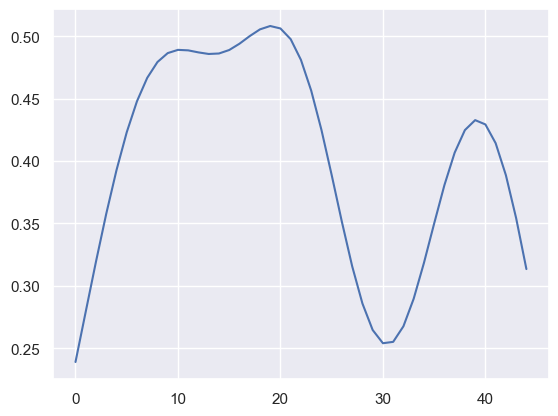

[]
[246]
8000
cuda
epoch 1,loss = 1.02752411
epoch 2,loss = 1.02537656
epoch 3,loss = 1.02327693
epoch 4,loss = 1.02122521
epoch 5,loss = 1.01920867
epoch 6,loss = 1.01723206
epoch 7,loss = 1.01531339
epoch 8,loss = 1.01344466
epoch 9,loss = 1.01162302
epoch 10,loss = 1.00984740
epoch 11,loss = 1.00811744
epoch 12,loss = 1.00643194
epoch 13,loss = 1.00479043
epoch 14,loss = 1.00319207
epoch 15,loss = 1.00163603
epoch 16,loss = 1.00012207
epoch 17,loss = 0.99864906
epoch 18,loss = 0.99721617
epoch 19,loss = 0.99582338
epoch 20,loss = 0.99446881
epoch 21,loss = 0.99315202
epoch 22,loss = 0.99187201


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 23,loss = 0.99062800
epoch 24,loss = 0.98941934
epoch 25,loss = 0.98824501
epoch 26,loss = 0.98710430
epoch 27,loss = 0.98599601
epoch 28,loss = 0.98491943
epoch 29,loss = 0.98387378
epoch 30,loss = 0.98285806
epoch 31,loss = 0.98187166
epoch 32,loss = 0.98091376
epoch 33,loss = 0.97998357
epoch 34,loss = 0.97908020
epoch 35,loss = 0.97820300
epoch 36,loss = 0.97735095
epoch 37,loss = 0.97652364
epoch 38,loss = 0.97572035
epoch 39,loss = 0.97494012
epoch 40,loss = 0.97415572
epoch 41,loss = 0.97340733
epoch 42,loss = 0.97268385
epoch 43,loss = 0.97198009
epoch 44,loss = 0.97129542
epoch 45,loss = 0.97062933
epoch 46,loss = 0.96998143
epoch 47,loss = 0.96935099
epoch 48,loss = 0.96873766
epoch 49,loss = 0.96814096
epoch 50,loss = 0.96756011
epoch 51,loss = 0.96699512
epoch 52,loss = 0.96644521
epoch 53,loss = 0.96591014
epoch 54,loss = 0.96538937
epoch 55,loss = 0.96488255
epoch 56,loss = 0.96438950
epoch 57,loss = 0.96390945
epoch 58,loss = 0.96344239
epoch 59,loss = 0.96298778
e

epoch 343,loss = 0.88904631
epoch 344,loss = 0.88757104
epoch 345,loss = 0.88608974
epoch 346,loss = 0.88460433
epoch 347,loss = 0.88312483
epoch 348,loss = 0.88165599
epoch 349,loss = 0.88020104
epoch 350,loss = 0.87876219
epoch 351,loss = 0.87734228
epoch 352,loss = 0.87593919
epoch 353,loss = 0.87455142
epoch 354,loss = 0.87318158
epoch 355,loss = 0.87183505
epoch 356,loss = 0.87051350
epoch 357,loss = 0.86922222
epoch 358,loss = 0.86796862
epoch 359,loss = 0.86675388
epoch 360,loss = 0.86558372
epoch 361,loss = 0.86446762
epoch 362,loss = 0.86340773
epoch 363,loss = 0.86240155
epoch 364,loss = 0.86144906
epoch 365,loss = 0.86054468
epoch 366,loss = 0.85968751
epoch 367,loss = 0.85887301
epoch 368,loss = 0.85809624
epoch 369,loss = 0.85735434
epoch 370,loss = 0.85664588
epoch 371,loss = 0.85596639
epoch 372,loss = 0.85530931
epoch 373,loss = 0.85466945
epoch 374,loss = 0.85404283
epoch 375,loss = 0.85342449
epoch 376,loss = 0.85281175
epoch 377,loss = 0.85220098
epoch 378,loss = 0.8

epoch 649,loss = 0.76247746
epoch 650,loss = 0.76226336
epoch 651,loss = 0.76204956
epoch 652,loss = 0.76183635
epoch 653,loss = 0.76162517
epoch 654,loss = 0.76141840
epoch 655,loss = 0.76121449
epoch 656,loss = 0.76101345
epoch 657,loss = 0.76081383
epoch 658,loss = 0.76061696
epoch 659,loss = 0.76042247
epoch 660,loss = 0.76023114
epoch 661,loss = 0.76004124
epoch 662,loss = 0.75985163
epoch 663,loss = 0.75966358
epoch 664,loss = 0.75946850
epoch 665,loss = 0.75927389
epoch 666,loss = 0.75908625
epoch 667,loss = 0.75890356
epoch 668,loss = 0.75872231
epoch 669,loss = 0.75854218
epoch 670,loss = 0.75836337
epoch 671,loss = 0.75818717
epoch 672,loss = 0.75801408
epoch 673,loss = 0.75784361
epoch 674,loss = 0.75767422
epoch 675,loss = 0.75750619
epoch 676,loss = 0.75734007
epoch 677,loss = 0.75717455
epoch 678,loss = 0.75700903
epoch 679,loss = 0.75684386
epoch 680,loss = 0.75667989
epoch 681,loss = 0.75651771
epoch 682,loss = 0.75635713
epoch 683,loss = 0.75619805
epoch 684,loss = 0.7

epoch 952,loss = 0.71548969
epoch 953,loss = 0.71540481
epoch 954,loss = 0.71531892
epoch 955,loss = 0.71523255
epoch 956,loss = 0.71514612
epoch 957,loss = 0.71505958
epoch 958,loss = 0.71497244
epoch 959,loss = 0.71488565
epoch 960,loss = 0.71479195
epoch 961,loss = 0.71470374
epoch 962,loss = 0.71462220
epoch 963,loss = 0.71454120
epoch 964,loss = 0.71446049
epoch 965,loss = 0.71438050
epoch 966,loss = 0.71430147
epoch 967,loss = 0.71422297
epoch 968,loss = 0.71414518
epoch 969,loss = 0.71406770
epoch 970,loss = 0.71399099
epoch 971,loss = 0.71391451
epoch 972,loss = 0.71383834
epoch 973,loss = 0.71376157
epoch 974,loss = 0.71368444
epoch 975,loss = 0.71360677
epoch 976,loss = 0.71352917
epoch 977,loss = 0.71345109
epoch 978,loss = 0.71337467
epoch 979,loss = 0.71329838
epoch 980,loss = 0.71322173
epoch 981,loss = 0.71314412
epoch 982,loss = 0.71306604
epoch 983,loss = 0.71298814
epoch 984,loss = 0.71291459
epoch 985,loss = 0.71283984
epoch 986,loss = 0.71276480
epoch 987,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


torch.Size([998, 1, 20])
1.0
Epoch 200:   loss= 0.20119  cluster difference= 1.0
Epoch 400:   loss= 0.19758  cluster difference= 0.06613226452905811
Epoch 600:   loss= 0.1951  cluster difference= 0.009018036072144289
[3 1 1 1 6 1 1 1 4 3 1 2 3 4 7 1 1 1 0 1 5 1 7 1 1 0 5 1 4 3 2 3 1 1 6 5 1
 0 4 3 4 3 5 4 4 3 4 1 6 5 1 1 6 5 0 6 1 0 1 0 1 0 7 1 1 1 5 1 1 6 1 7 1 1
 5 1 1 7 1 1 6 6 6 1 6 7 5 4 3 0 1 0 1 2 3 7 3 6 7 4 3 6 1 0 6 5 1 0 6 5 1
 2 2 3 1 1 1 1 0 5 2 3 4 6 2 3 0 6 5 7 1 6 1 7 4 3 6 0 1 0 1 1 4 5 7 2 3 1
 5 1 5 1 1 0 1 1 1 4 4 3 4 6 4 3 6 6 2 3 2 3 6 5 4 3 6 4 3 2 2 3 0 2 3 1 1
 1 5 0 2 7 3 7 7 5 7 1 7 5 1 1 5 0 1 7 1 1 0 5 1 5 6 6 1 7 2 3 7 1 4 3 7 1
 5 5 1 1 1 1 4 3 1 0 1 1 4 3 3 4 3 4 3 1 1 6 6 4 3 1 0 6 1 1 1 2 3 5 7 5 3
 5 0 1 1 0 2 3 1 6 2 3 5 6 0 1 1 1 2 3 4 4 3 6 1 1 1 6 2 3 0 1 4 3 6 0 5 1
 0 1 5 5 4 1 6 2 1 5 1 1 5 2 4 3 0 6 1 6 0 5 1 4 3 1 1 0 1 5 1 4 6 1 1 6 6
 5 4 3 4 3 1 1 5 1 1 5 1 0 6 0 0 5 4 3 1 1 4 3 6 0 1 4 3 0 1 0 0 0 1 5 4 3
 6 4 3 2 3 6 2 3 1 1 1 1 0 4 4 3 

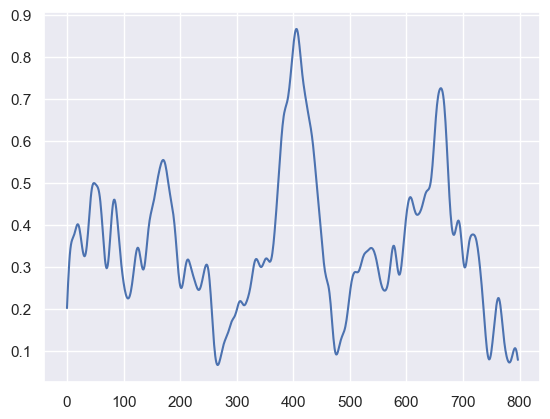

[4058, 6098]
[2168 4064 6064]
8459
cuda
epoch 1,loss = 1.10318291
epoch 2,loss = 1.10161650
epoch 3,loss = 1.10005653
epoch 4,loss = 1.09850347
epoch 5,loss = 1.09695780
epoch 6,loss = 1.09541929
epoch 7,loss = 1.09388876
epoch 8,loss = 1.09236622
epoch 9,loss = 1.09085202
epoch 10,loss = 1.08934641
epoch 11,loss = 1.08784986
epoch 12,loss = 1.08636224
epoch 13,loss = 1.08488429
epoch 14,loss = 1.08341599
epoch 15,loss = 1.08195770
epoch 16,loss = 1.08050990
epoch 17,loss = 1.07907259
epoch 18,loss = 1.07764602
epoch 19,loss = 1.07623076


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 20,loss = 1.07482696
epoch 21,loss = 1.07343459
epoch 22,loss = 1.07205427
epoch 23,loss = 1.07068598
epoch 24,loss = 1.06933022
epoch 25,loss = 1.06798720
epoch 26,loss = 1.06665695
epoch 27,loss = 1.06533992
epoch 28,loss = 1.06403613
epoch 29,loss = 1.06274605
epoch 30,loss = 1.06146979
epoch 31,loss = 1.06020749
epoch 32,loss = 1.05895936
epoch 33,loss = 1.05772579
epoch 34,loss = 1.05650675
epoch 35,loss = 1.05530262
epoch 36,loss = 1.05411339
epoch 37,loss = 1.05293941
epoch 38,loss = 1.05178082
epoch 39,loss = 1.05063760
epoch 40,loss = 1.04951000
epoch 41,loss = 1.04839826
epoch 42,loss = 1.04730260
epoch 43,loss = 1.04622281
epoch 44,loss = 1.04515934
epoch 45,loss = 1.04411197
epoch 46,loss = 1.04308116
epoch 47,loss = 1.04206681
epoch 48,loss = 1.04106891
epoch 49,loss = 1.04008794
epoch 50,loss = 1.03912354
epoch 51,loss = 1.03817606
epoch 52,loss = 1.03724527
epoch 53,loss = 1.03633142
epoch 54,loss = 1.03543460
epoch 55,loss = 1.03455460
epoch 56,loss = 1.03369153
e

epoch 321,loss = 1.00046027
epoch 322,loss = 1.00044549
epoch 323,loss = 1.00043094
epoch 324,loss = 1.00041640
epoch 325,loss = 1.00040209
epoch 326,loss = 1.00038791
epoch 327,loss = 1.00037360
epoch 328,loss = 1.00035954
epoch 329,loss = 1.00034559
epoch 330,loss = 1.00033176
epoch 331,loss = 1.00031805
epoch 332,loss = 1.00030434
epoch 333,loss = 1.00029087
epoch 334,loss = 1.00027752
epoch 335,loss = 1.00026417
epoch 336,loss = 1.00025094
epoch 337,loss = 1.00023794
epoch 338,loss = 1.00022483
epoch 339,loss = 1.00021195
epoch 340,loss = 1.00019908
epoch 341,loss = 1.00018644
epoch 342,loss = 1.00017381
epoch 343,loss = 1.00016129
epoch 344,loss = 1.00014889
epoch 345,loss = 1.00013661
epoch 346,loss = 1.00012445
epoch 347,loss = 1.00011230
epoch 348,loss = 1.00010037
epoch 349,loss = 1.00008845
epoch 350,loss = 1.00007653
epoch 351,loss = 1.00006485
epoch 352,loss = 1.00005329
epoch 353,loss = 1.00004160
epoch 354,loss = 1.00003016
epoch 355,loss = 1.00001884
epoch 356,loss = 1.0

epoch 653,loss = 0.77388597
epoch 654,loss = 0.77362281
epoch 655,loss = 0.77336645
epoch 656,loss = 0.77312416
epoch 657,loss = 0.77288276
epoch 658,loss = 0.77264917
epoch 659,loss = 0.77242458
epoch 660,loss = 0.77220595
epoch 661,loss = 0.77198440
epoch 662,loss = 0.77176458
epoch 663,loss = 0.77154267
epoch 664,loss = 0.77131832
epoch 665,loss = 0.77107459
epoch 666,loss = 0.77082932
epoch 667,loss = 0.77058864
epoch 668,loss = 0.77034342
epoch 669,loss = 0.77009720
epoch 670,loss = 0.76985562
epoch 671,loss = 0.76962161
epoch 672,loss = 0.76939094
epoch 673,loss = 0.76915413
epoch 674,loss = 0.76891965
epoch 675,loss = 0.76869625
epoch 676,loss = 0.76847744
epoch 677,loss = 0.76824135
epoch 678,loss = 0.76800394
epoch 679,loss = 0.76775020
epoch 680,loss = 0.76750332
epoch 681,loss = 0.76728386
epoch 682,loss = 0.76706260
epoch 683,loss = 0.76684302
epoch 684,loss = 0.76662177
epoch 685,loss = 0.76640183
epoch 686,loss = 0.76618171
epoch 687,loss = 0.76596254
epoch 688,loss = 0.7

epoch 946,loss = 0.74011791
epoch 947,loss = 0.74006915
epoch 948,loss = 0.74001896
epoch 949,loss = 0.73997188
epoch 950,loss = 0.73992604
epoch 951,loss = 0.73987836
epoch 952,loss = 0.73982900
epoch 953,loss = 0.73977852
epoch 954,loss = 0.73972863
epoch 955,loss = 0.73967993
epoch 956,loss = 0.73963314
epoch 957,loss = 0.73958695
epoch 958,loss = 0.73954189
epoch 959,loss = 0.73949784
epoch 960,loss = 0.73945260
epoch 961,loss = 0.73940915
epoch 962,loss = 0.73936343
epoch 963,loss = 0.73931509
epoch 964,loss = 0.73926568
epoch 965,loss = 0.73921257
epoch 966,loss = 0.73915809
epoch 967,loss = 0.73910517
epoch 968,loss = 0.73905176
epoch 969,loss = 0.73899245
epoch 970,loss = 0.73892993
epoch 971,loss = 0.73885989
epoch 972,loss = 0.73877943
epoch 973,loss = 0.73869592
epoch 974,loss = 0.73862076
epoch 975,loss = 0.73855305
epoch 976,loss = 0.73848575
epoch 977,loss = 0.73841751
epoch 978,loss = 0.73835111
epoch 979,loss = 0.73828727
epoch 980,loss = 0.73823023
epoch 981,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


torch.Size([1055, 1, 20])
1.0
Epoch 200:   loss= 0.20959  cluster difference= 1.0
Epoch 400:   loss= 0.20945  cluster difference= 0.06445497630331753
Epoch 600:   loss= 0.20863  cluster difference= 0.04739336492890995
Epoch 800:   loss= 0.20751  cluster difference= 0.031279620853080566
Epoch 1000:   loss= 0.20637  cluster difference= 0.026540284360189573
Epoch 1200:   loss= 0.20532  cluster difference= 0.023696682464454975
Epoch 1400:   loss= 0.20437  cluster difference= 0.023696682464454975
Epoch 1600:   loss= 0.20351  cluster difference= 0.043601895734597156
Epoch 1800:   loss= 0.20278  cluster difference= 0.037914691943127965
Epoch 2000:   loss= 0.20223  cluster difference= 0.03981042654028436
Epoch 2200:   loss= 0.20179  cluster difference= 0.022748815165876776
Epoch 2400:   loss= 0.20141  cluster difference= 0.016113744075829384
Epoch 2600:   loss= 0.20109  cluster difference= 0.014218009478672985
Epoch 2800:   loss= 0.20079  cluster difference= 0.007582938388625593
[2 2 7 ... 0 1

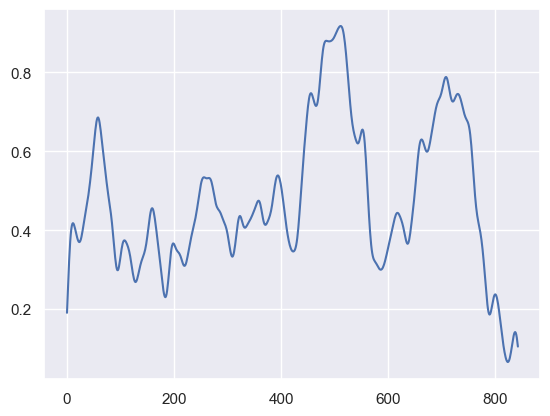

[1322, 4946, 6522]
[1801 3395 4960 6584]
2818
cuda
epoch 1,loss = 1.00017512
epoch 2,loss = 1.00001049
epoch 3,loss = 0.99985826
epoch 4,loss = 0.99971819
epoch 5,loss = 0.99959052
epoch 6,loss = 0.99947459
epoch 7,loss = 0.99937004
epoch 8,loss = 0.99927652
epoch 9,loss = 0.99921077
epoch 10,loss = 0.99917561
epoch 11,loss = 0.99912602
epoch 12,loss = 0.99907798
epoch 13,loss = 0.99903184
epoch 14,loss = 0.99898309
epoch 15,loss = 0.99893290
epoch 16,loss = 0.99887693
epoch 17,loss = 0.99880874
epoch 18,loss = 0.99877191
epoch 19,loss = 0.99876326
epoch 20,loss = 0.99878126
epoch 21,loss = 0.99878782
epoch 22,loss = 0.99876601
epoch 23,loss = 0.99871433
epoch 24,loss = 0.99863654
epoch 25,loss = 0.99854231
epoch 26,loss = 0.99845886
epoch 27,loss = 0.99837047
epoch 28,loss = 0.99827862
epoch 29,loss = 0.99818861
epoch 30,loss = 0.99809921
epoch 31,loss = 0.99800807
epoch 32,loss = 0.99791086
epoch 33,loss = 0.99781293
epoch 34,loss = 0.99770665
epoch 35,loss = 0.99761617


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 36,loss = 0.99755204
epoch 37,loss = 0.99749202
epoch 38,loss = 0.99743199
epoch 39,loss = 0.99737275
epoch 40,loss = 0.99731791
epoch 41,loss = 0.99726439
epoch 42,loss = 0.99720967
epoch 43,loss = 0.99715114
epoch 44,loss = 0.99708664
epoch 45,loss = 0.99701542
epoch 46,loss = 0.99693805
epoch 47,loss = 0.99685484
epoch 48,loss = 0.99676669
epoch 49,loss = 0.99667382
epoch 50,loss = 0.99657625
epoch 51,loss = 0.99647462
epoch 52,loss = 0.99636906
epoch 53,loss = 0.99625820
epoch 54,loss = 0.99614125
epoch 55,loss = 0.99601918
epoch 56,loss = 0.99589390
epoch 57,loss = 0.99576461
epoch 58,loss = 0.99563140
epoch 59,loss = 0.99549335
epoch 60,loss = 0.99534923
epoch 61,loss = 0.99519920
epoch 62,loss = 0.99504507
epoch 63,loss = 0.99488366
epoch 64,loss = 0.99471468
epoch 65,loss = 0.99453729
epoch 66,loss = 0.99435002
epoch 67,loss = 0.99415231
epoch 68,loss = 0.99394351
epoch 69,loss = 0.99372518
epoch 70,loss = 0.99349582
epoch 71,loss = 0.99325556
epoch 72,loss = 0.99300563
e

epoch 369,loss = 0.84011984
epoch 370,loss = 0.83997625
epoch 371,loss = 0.83983147
epoch 372,loss = 0.83968693
epoch 373,loss = 0.83954185
epoch 374,loss = 0.83939648
epoch 375,loss = 0.83924705
epoch 376,loss = 0.83909655
epoch 377,loss = 0.83894724
epoch 378,loss = 0.83880079
epoch 379,loss = 0.83865482
epoch 380,loss = 0.83850807
epoch 381,loss = 0.83836335
epoch 382,loss = 0.83822262
epoch 383,loss = 0.83808255
epoch 384,loss = 0.83794308
epoch 385,loss = 0.83780181
epoch 386,loss = 0.83765835
epoch 387,loss = 0.83751434
epoch 388,loss = 0.83737123
epoch 389,loss = 0.83722949
epoch 390,loss = 0.83708858
epoch 391,loss = 0.83694738
epoch 392,loss = 0.83680266
epoch 393,loss = 0.83666027
epoch 394,loss = 0.83651787
epoch 395,loss = 0.83637273
epoch 396,loss = 0.83622712
epoch 397,loss = 0.83607972
epoch 398,loss = 0.83593148
epoch 399,loss = 0.83578324
epoch 400,loss = 0.83563530
epoch 401,loss = 0.83548659
epoch 402,loss = 0.83533800
epoch 403,loss = 0.83518904
epoch 404,loss = 0.8

epoch 686,loss = 0.76661354
epoch 687,loss = 0.76632875
epoch 688,loss = 0.76605082
epoch 689,loss = 0.76580280
epoch 690,loss = 0.76555759
epoch 691,loss = 0.76530802
epoch 692,loss = 0.76505232
epoch 693,loss = 0.76479393
epoch 694,loss = 0.76454109
epoch 695,loss = 0.76428556
epoch 696,loss = 0.76401728
epoch 697,loss = 0.76375312
epoch 698,loss = 0.76350600
epoch 699,loss = 0.76324666
epoch 700,loss = 0.76299435
epoch 701,loss = 0.76275110
epoch 702,loss = 0.76250947
epoch 703,loss = 0.76226634
epoch 704,loss = 0.76202220
epoch 705,loss = 0.76178384
epoch 706,loss = 0.76155466
epoch 707,loss = 0.76132625
epoch 708,loss = 0.76109821
epoch 709,loss = 0.76088142
epoch 710,loss = 0.76066852
epoch 711,loss = 0.76045412
epoch 712,loss = 0.76024359
epoch 713,loss = 0.76003712
epoch 714,loss = 0.75983369
epoch 715,loss = 0.75963211
epoch 716,loss = 0.75943059
epoch 717,loss = 0.75922894
epoch 718,loss = 0.75902969
epoch 719,loss = 0.75882882
epoch 720,loss = 0.75863296
epoch 721,loss = 0.7

epoch 996,loss = 0.71100253
epoch 997,loss = 0.71096486
epoch 998,loss = 0.71092743
epoch 999,loss = 0.71089089
epoch 1000,loss = 0.71085453
epoch 1001,loss = 0.71081752
epoch 1002,loss = 0.71078068
epoch 1003,loss = 0.71074396
epoch 1004,loss = 0.71070868
epoch 1005,loss = 0.71067268
epoch 1006,loss = 0.71063530
epoch 1007,loss = 0.71059835
epoch 1008,loss = 0.71056265
epoch 1009,loss = 0.71052653
epoch 1010,loss = 0.71049023
epoch 1011,loss = 0.71045339
epoch 1012,loss = 0.71041685
epoch 1013,loss = 0.71038079
epoch 1014,loss = 0.71034551
epoch 1015,loss = 0.71031082
epoch 1016,loss = 0.71027637
epoch 1017,loss = 0.71024108
epoch 1018,loss = 0.71020591
epoch 1019,loss = 0.71017087
epoch 1020,loss = 0.71013576
epoch 1021,loss = 0.71010214
epoch 1022,loss = 0.71007019
epoch 1023,loss = 0.71003908
epoch 1024,loss = 0.71000654
epoch 1025,loss = 0.70997232
epoch 1026,loss = 0.70993668
epoch 1027,loss = 0.70990032
epoch 1028,loss = 0.70986420
epoch 1029,loss = 0.70983022
epoch 1030,loss = 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([350, 1, 20])
1.0
Epoch 200:   loss= 0.20831  cluster difference= 1.0
Epoch 400:   loss= 0.20767  cluster difference= 0.08285714285714285
Epoch 600:   loss= 0.20663  cluster difference= 0.06285714285714286
Epoch 800:   loss= 0.20499  cluster difference= 0.06571428571428571
Epoch 1000:   loss= 0.20311  cluster difference= 0.06571428571428571
Epoch 1200:   loss= 0.20108  cluster difference= 0.025714285714285714
Epoch 1400:   loss= 0.19894  cluster difference= 0.025714285714285714
Epoch 1600:   loss= 0.1969  cluster difference= 0.037142857142857144
Epoch 1800:   loss= 0.19514  cluster difference= 0.008571428571428572
[6 0 7 6 2 7 4 5 6 3 7 4 2 7 4 2 6 3 1 4 2 6 4 2 0 3 7 6 2 6 3 5 6 3 1 1 2
 7 4 5 6 0 7 4 2 6 3 3 1 2 5 4 2 0 3 5 6 3 5 4 2 6 1 2 6 3 7 4 2 6 4 3 3 3
 5 4 0 1 0 0 0 3 0 4 2 6 0 0 0 0 1 0 0 0 3 2 6 0 0 0 5 6 0 2 6 3 1 0 0 5 4
 0 0 0 0 0 2 1 0 7 0 3 2 6 5 0 0 4 1 0 5 0 0 0 3 0 0 3 5 4 5 6 3 2 6 4 7 4
 2 6 4 2 6 3 7 4 2 6 4 2 6 3 7 4 2 7 4 2 6 3 7 4 3 7 4 7 6 3 7 4 3 

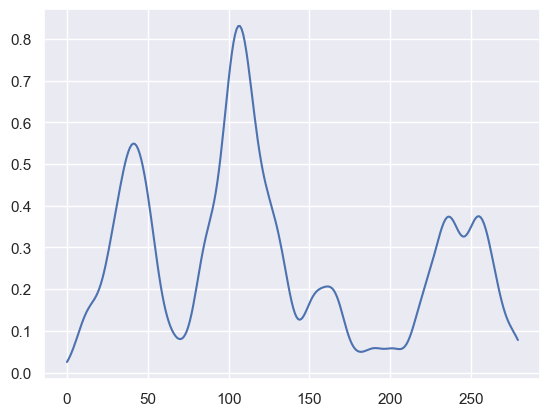

[1146]
[ 600 1131 1652 2193]
2818
cuda
epoch 1,loss = 1.13969815
epoch 2,loss = 1.13774240
epoch 3,loss = 1.13579547
epoch 4,loss = 1.13385761
epoch 5,loss = 1.13192916
epoch 6,loss = 1.13001013
epoch 7,loss = 1.12810123
epoch 8,loss = 1.12620258
epoch 9,loss = 1.12431443
epoch 10,loss = 1.12243724
epoch 11,loss = 1.12057126
epoch 12,loss = 1.11871684
epoch 13,loss = 1.11687434
epoch 14,loss = 1.11504388
epoch 15,loss = 1.11322594
epoch 16,loss = 1.11142087
epoch 17,loss = 1.10962868
epoch 18,loss = 1.10784996
epoch 19,loss = 1.10608482
epoch 20,loss = 1.10433376
epoch 21,loss = 1.10259700
epoch 22,loss = 1.10087466
epoch 23,loss = 1.09916711
epoch 24,loss = 1.09747469
epoch 25,loss = 1.09579766
epoch 26,loss = 1.09413648
epoch 27,loss = 1.09249091
epoch 28,loss = 1.09086168
epoch 29,loss = 1.08924890
epoch 30,loss = 1.08765280
epoch 31,loss = 1.08607364
epoch 32,loss = 1.08451152
epoch 33,loss = 1.08296704
epoch 34,loss = 1.08144009
epoch 35,loss = 1.07993114
epoch 36,loss = 1.0784401

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 41,loss = 1.07126486
epoch 42,loss = 1.06988692
epoch 43,loss = 1.06852853
epoch 44,loss = 1.06718969
epoch 45,loss = 1.06587064
epoch 46,loss = 1.06457150
epoch 47,loss = 1.06329250
epoch 48,loss = 1.06203365
epoch 49,loss = 1.06079507
epoch 50,loss = 1.05957687
epoch 51,loss = 1.05837929
epoch 52,loss = 1.05720222
epoch 53,loss = 1.05604577
epoch 54,loss = 1.05491006
epoch 55,loss = 1.05379522
epoch 56,loss = 1.05270112
epoch 57,loss = 1.05162787
epoch 58,loss = 1.05057561
epoch 59,loss = 1.04954410
epoch 60,loss = 1.04853356
epoch 61,loss = 1.04754388
epoch 62,loss = 1.04657507
epoch 63,loss = 1.04562712
epoch 64,loss = 1.04469979
epoch 65,loss = 1.04379320
epoch 66,loss = 1.04290736
epoch 67,loss = 1.04204190
epoch 68,loss = 1.04119682
epoch 69,loss = 1.04037225
epoch 70,loss = 1.03956771
epoch 71,loss = 1.03878319
epoch 72,loss = 1.03801870
epoch 73,loss = 1.03727376
epoch 74,loss = 1.03655255
epoch 75,loss = 1.03585279
epoch 76,loss = 1.03517151
epoch 77,loss = 1.03450847
e

epoch 351,loss = 0.93654537
epoch 352,loss = 0.93580943
epoch 353,loss = 0.93506438
epoch 354,loss = 0.93430734
epoch 355,loss = 0.93353558
epoch 356,loss = 0.93276364
epoch 357,loss = 0.93198913
epoch 358,loss = 0.93120492
epoch 359,loss = 0.93040866
epoch 360,loss = 0.92960763
epoch 361,loss = 0.92880344
epoch 362,loss = 0.92799932
epoch 363,loss = 0.92719412
epoch 364,loss = 0.92638499
epoch 365,loss = 0.92555684
epoch 366,loss = 0.92472082
epoch 367,loss = 0.92388755
epoch 368,loss = 0.92305428
epoch 369,loss = 0.92221260
epoch 370,loss = 0.92135656
epoch 371,loss = 0.92049462
epoch 372,loss = 0.91961825
epoch 373,loss = 0.91874093
epoch 374,loss = 0.91784698
epoch 375,loss = 0.91693705
epoch 376,loss = 0.91601294
epoch 377,loss = 0.91507769
epoch 378,loss = 0.91414356
epoch 379,loss = 0.91321373
epoch 380,loss = 0.91228485
epoch 381,loss = 0.91134304
epoch 382,loss = 0.91038460
epoch 383,loss = 0.90942961
epoch 384,loss = 0.90846580
epoch 385,loss = 0.90750295
epoch 386,loss = 0.9

epoch 652,loss = 0.69354743
epoch 653,loss = 0.69336408
epoch 654,loss = 0.69318414
epoch 655,loss = 0.69300401
epoch 656,loss = 0.69282514
epoch 657,loss = 0.69264847
epoch 658,loss = 0.69247383
epoch 659,loss = 0.69230026
epoch 660,loss = 0.69212669
epoch 661,loss = 0.69195569
epoch 662,loss = 0.69178635
epoch 663,loss = 0.69161701
epoch 664,loss = 0.69144762
epoch 665,loss = 0.69127929
epoch 666,loss = 0.69111782
epoch 667,loss = 0.69096363
epoch 668,loss = 0.69081056
epoch 669,loss = 0.69065642
epoch 670,loss = 0.69050276
epoch 671,loss = 0.69034749
epoch 672,loss = 0.69019324
epoch 673,loss = 0.69004256
epoch 674,loss = 0.68988985
epoch 675,loss = 0.68973368
epoch 676,loss = 0.68957001
epoch 677,loss = 0.68940699
epoch 678,loss = 0.68925035
epoch 679,loss = 0.68909442
epoch 680,loss = 0.68893695
epoch 681,loss = 0.68877941
epoch 682,loss = 0.68861943
epoch 683,loss = 0.68845952
epoch 684,loss = 0.68830299
epoch 685,loss = 0.68815386
epoch 686,loss = 0.68800640
epoch 687,loss = 0.6

epoch 976,loss = 0.65285540
epoch 977,loss = 0.65281433
epoch 978,loss = 0.65277302
epoch 979,loss = 0.65272820
epoch 980,loss = 0.65268213
epoch 981,loss = 0.65263474
epoch 982,loss = 0.65258509
epoch 983,loss = 0.65253878
epoch 984,loss = 0.65249240
epoch 985,loss = 0.65244633
epoch 986,loss = 0.65240109
epoch 987,loss = 0.65235561
epoch 988,loss = 0.65230995
epoch 989,loss = 0.65226549
epoch 990,loss = 0.65221918
epoch 991,loss = 0.65217453
epoch 992,loss = 0.65212876
epoch 993,loss = 0.65208137
epoch 994,loss = 0.65203708
epoch 995,loss = 0.65199071
epoch 996,loss = 0.65194046
epoch 997,loss = 0.65188992
epoch 998,loss = 0.65183955
epoch 999,loss = 0.65178883
epoch 1000,loss = 0.65174216
epoch 1001,loss = 0.65169728
epoch 1002,loss = 0.65165305
epoch 1003,loss = 0.65160900
epoch 1004,loss = 0.65156543
epoch 1005,loss = 0.65152246
epoch 1006,loss = 0.65148014
epoch 1007,loss = 0.65143919
epoch 1008,loss = 0.65139800
epoch 1009,loss = 0.65135646
epoch 1010,loss = 0.65131414
epoch 101

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([350, 1, 20])
1.0
Epoch 200:   loss= 0.19643  cluster difference= 1.0
Epoch 400:   loss= 0.19341  cluster difference= 0.045714285714285714
Epoch 600:   loss= 0.1919  cluster difference= 0.045714285714285714
Epoch 800:   loss= 0.19088  cluster difference= 0.07714285714285714
Epoch 1000:   loss= 0.18933  cluster difference= 0.03428571428571429
Epoch 1200:   loss= 0.18713  cluster difference= 0.03142857142857143
Epoch 1400:   loss= 0.18475  cluster difference= 0.025714285714285714
Epoch 1600:   loss= 0.18277  cluster difference= 0.008571428571428572
[6 3 6 7 5 6 4 0 2 3 0 7 5 6 4 0 6 3 6 7 5 6 4 0 7 1 0 7 5 6 4 0 6 3 6 4 5
 0 4 5 6 4 0 7 1 0 4 5 7 1 0 7 5 6 4 5 2 4 0 2 1 0 4 0 2 1 0 7 5 6 4 5 6 3
 6 7 5 6 4 5 2 1 6 4 5 6 4 5 7 1 0 7 5 6 4 0 2 1 0 4 5 6 4 5 7 5 6 4 0 6 4
 0 2 1 0 4 5 6 4 0 7 1 0 7 5 6 7 0 2 5 6 7 5 6 4 0 2 3 0 7 0 3 6 4 1 1 5 3
 7 1 0 2 0 7 5 6 7 5 6 7 5 2 1 0 3 1 0 7 5 7 1 0 7 5 2 5 3 2 0 6 7 1 0 6 3
 7 1 0 2 1 6 2 5 6 4 0 6 3 6 4 5 0 4 0 7 1 0 6 7 0 7 1 0 6 3 

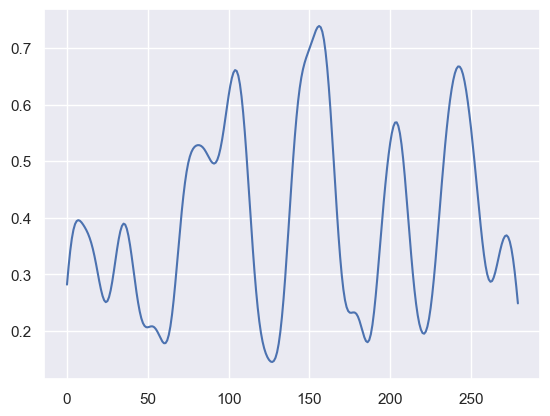

[1122, 1538, 2226]
[ 600 1131 1652 2193]
2818
cuda
epoch 1,loss = 1.14399028
epoch 2,loss = 1.14280903
epoch 3,loss = 1.14163458
epoch 4,loss = 1.14046681
epoch 5,loss = 1.13930583
epoch 6,loss = 1.13815188
epoch 7,loss = 1.13700485
epoch 8,loss = 1.13586485
epoch 9,loss = 1.13473189
epoch 10,loss = 1.13360596
epoch 11,loss = 1.13248730
epoch 12,loss = 1.13137579
epoch 13,loss = 1.13027143
epoch 14,loss = 1.12917447
epoch 15,loss = 1.12808478
epoch 16,loss = 1.12700236
epoch 17,loss = 1.12592721
epoch 18,loss = 1.12485933
epoch 19,loss = 1.12379897
epoch 20,loss = 1.12274575
epoch 21,loss = 1.12169981
epoch 22,loss = 1.12066114
epoch 23,loss = 1.11962986
epoch 24,loss = 1.11860573
epoch 25,loss = 1.11758888
epoch 26,loss = 1.11657917
epoch 27,loss = 1.11557662
epoch 28,loss = 1.11458135
epoch 29,loss = 1.11359298
epoch 30,loss = 1.11261189
epoch 31,loss = 1.11163771
epoch 32,loss = 1.11067057
epoch 33,loss = 1.10971034
epoch 34,loss = 1.10875714
epoch 35,loss = 1.10781062
epoch 36,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 46,loss = 1.09784007
epoch 47,loss = 1.09697247
epoch 48,loss = 1.09611106
epoch 49,loss = 1.09525597
epoch 50,loss = 1.09440696
epoch 51,loss = 1.09356403
epoch 52,loss = 1.09272707
epoch 53,loss = 1.09189630
epoch 54,loss = 1.09107137
epoch 55,loss = 1.09025240
epoch 56,loss = 1.08943939
epoch 57,loss = 1.08863223
epoch 58,loss = 1.08783090
epoch 59,loss = 1.08703542
epoch 60,loss = 1.08624566
epoch 61,loss = 1.08546162
epoch 62,loss = 1.08468342
epoch 63,loss = 1.08391082
epoch 64,loss = 1.08314407
epoch 65,loss = 1.08238304
epoch 66,loss = 1.08162796
epoch 67,loss = 1.08087850
epoch 68,loss = 1.08013463
epoch 69,loss = 1.07939649
epoch 70,loss = 1.07866383
epoch 71,loss = 1.07793677
epoch 72,loss = 1.07721519
epoch 73,loss = 1.07649910
epoch 74,loss = 1.07578826
epoch 75,loss = 1.07508266
epoch 76,loss = 1.07438254
epoch 77,loss = 1.07368743
epoch 78,loss = 1.07299745
epoch 79,loss = 1.07231247
epoch 80,loss = 1.07163239
epoch 81,loss = 1.07095718
epoch 82,loss = 1.07028687
e

epoch 357,loss = 0.86818737
epoch 358,loss = 0.86776423
epoch 359,loss = 0.86734664
epoch 360,loss = 0.86693209
epoch 361,loss = 0.86651587
epoch 362,loss = 0.86610109
epoch 363,loss = 0.86569101
epoch 364,loss = 0.86528277
epoch 365,loss = 0.86487758
epoch 366,loss = 0.86447895
epoch 367,loss = 0.86408585
epoch 368,loss = 0.86369532
epoch 369,loss = 0.86330694
epoch 370,loss = 0.86291975
epoch 371,loss = 0.86253315
epoch 372,loss = 0.86214882
epoch 373,loss = 0.86176664
epoch 374,loss = 0.86138606
epoch 375,loss = 0.86100638
epoch 376,loss = 0.86062795
epoch 377,loss = 0.86025029
epoch 378,loss = 0.85987371
epoch 379,loss = 0.85949790
epoch 380,loss = 0.85912144
epoch 381,loss = 0.85874569
epoch 382,loss = 0.85837030
epoch 383,loss = 0.85799474
epoch 384,loss = 0.85761893
epoch 385,loss = 0.85724390
epoch 386,loss = 0.85686785
epoch 387,loss = 0.85649198
epoch 388,loss = 0.85611761
epoch 389,loss = 0.85574257
epoch 390,loss = 0.85536319
epoch 391,loss = 0.85498363
epoch 392,loss = 0.8

epoch 655,loss = 0.75286049
epoch 656,loss = 0.75283629
epoch 657,loss = 0.75281125
epoch 658,loss = 0.75278664
epoch 659,loss = 0.75276250
epoch 660,loss = 0.75273854
epoch 661,loss = 0.75271469
epoch 662,loss = 0.75269127
epoch 663,loss = 0.75266826
epoch 664,loss = 0.75264549
epoch 665,loss = 0.75262296
epoch 666,loss = 0.75260055
epoch 667,loss = 0.75257856
epoch 668,loss = 0.75255668
epoch 669,loss = 0.75253516
epoch 670,loss = 0.75251389
epoch 671,loss = 0.75249290
epoch 672,loss = 0.75247246
epoch 673,loss = 0.75245208
epoch 674,loss = 0.75243199
epoch 675,loss = 0.75241220
epoch 676,loss = 0.75239241
epoch 677,loss = 0.75237292
epoch 678,loss = 0.75235337
epoch 679,loss = 0.75233364
epoch 680,loss = 0.75231445
epoch 681,loss = 0.75229549
epoch 682,loss = 0.75227678
epoch 683,loss = 0.75225824
epoch 684,loss = 0.75223982
epoch 685,loss = 0.75222194
epoch 686,loss = 0.75220299
epoch 687,loss = 0.75218403
epoch 688,loss = 0.75216544
epoch 689,loss = 0.75214529
epoch 690,loss = 0.7

epoch 951,loss = 0.74882716
epoch 952,loss = 0.74881446
epoch 953,loss = 0.74880117
epoch 954,loss = 0.74878824
epoch 955,loss = 0.74877524
epoch 956,loss = 0.74876308
epoch 957,loss = 0.74875015
epoch 958,loss = 0.74873769
epoch 959,loss = 0.74872518
epoch 960,loss = 0.74871206
epoch 961,loss = 0.74870020
epoch 962,loss = 0.74868804
epoch 963,loss = 0.74867564
epoch 964,loss = 0.74866265
epoch 965,loss = 0.74864984
epoch 966,loss = 0.74863768
epoch 967,loss = 0.74862474
epoch 968,loss = 0.74861270
epoch 969,loss = 0.74860084
epoch 970,loss = 0.74858838
epoch 971,loss = 0.74857521
epoch 972,loss = 0.74856222
epoch 973,loss = 0.74854970
epoch 974,loss = 0.74853700
epoch 975,loss = 0.74852538
epoch 976,loss = 0.74851263
epoch 977,loss = 0.74849916
epoch 978,loss = 0.74848843
epoch 979,loss = 0.74847698
epoch 980,loss = 0.74846447
epoch 981,loss = 0.74845147
epoch 982,loss = 0.74844044
epoch 983,loss = 0.74842846
epoch 984,loss = 0.74841589
epoch 985,loss = 0.74840528
epoch 986,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([350, 1, 20])
1.0
Epoch 200:   loss= 0.19337  cluster difference= 1.0
Epoch 400:   loss= 0.19245  cluster difference= 0.03428571428571429
Epoch 600:   loss= 0.19204  cluster difference= 0.03428571428571429
Epoch 800:   loss= 0.19192  cluster difference= 0.02
Epoch 1000:   loss= 0.19171  cluster difference= 0.037142857142857144
Epoch 1200:   loss= 0.19145  cluster difference= 0.025714285714285714
Epoch 1400:   loss= 0.19111  cluster difference= 0.014285714285714285
Epoch 1600:   loss= 0.19074  cluster difference= 0.025714285714285714
Epoch 1800:   loss= 0.19046  cluster difference= 0.02857142857142857
Epoch 2000:   loss= 0.19027  cluster difference= 0.022857142857142857
Epoch 2200:   loss= 0.19008  cluster difference= 0.022857142857142857
Epoch 2400:   loss= 0.18981  cluster difference= 0.022857142857142857
Epoch 2600:   loss= 0.18949  cluster difference= 0.008571428571428572
[3 7 3 1 7 3 7 0 5 7 0 4 2 5 6 7 3 2 0 5 7 5 1 2 5 6 0 4 2 5 6 7 4 7 0 5 7
 0 4 2 5 6 0 4 2 5 7 0 4 6

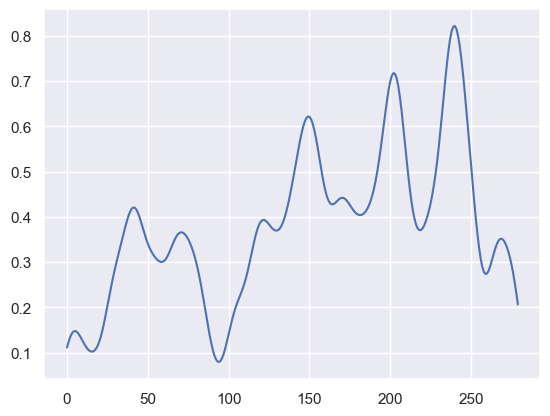

[1482, 1906, 2210]
[ 600 1131 1652 2193]
1187
cuda
epoch 1,loss = 0.98672581
epoch 2,loss = 0.98669052
epoch 3,loss = 0.98665559
epoch 4,loss = 0.98662078
epoch 5,loss = 0.98658627
epoch 6,loss = 0.98655188
epoch 7,loss = 0.98651785
epoch 8,loss = 0.98648393
epoch 9,loss = 0.98645037
epoch 10,loss = 0.98641688
epoch 11,loss = 0.98638368
epoch 12,loss = 0.98635072
epoch 13,loss = 0.98631805
epoch 14,loss = 0.98628545
epoch 15,loss = 0.98625308
epoch 16,loss = 0.98622108
epoch 17,loss = 0.98618919
epoch 18,loss = 0.98615766
epoch 19,loss = 0.98612624
epoch 20,loss = 0.98609513
epoch 21,loss = 0.98606437
epoch 22,loss = 0.98603368
epoch 23,loss = 0.98600334
epoch 24,loss = 0.98597431
epoch 25,loss = 0.98594820
epoch 26,loss = 0.98592263
epoch 27,loss = 0.98589724
epoch 28,loss = 0.98587197
epoch 29,loss = 0.98584700
epoch 30,loss = 0.98582214
epoch 31,loss = 0.98579758
epoch 32,loss = 0.98577297
epoch 33,loss = 0.98574883
epoch 34,loss = 0.98572463
epoch 35,loss = 0.98570073
epoch 36,loss

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 51,loss = 0.98529959
epoch 52,loss = 0.98527098
epoch 53,loss = 0.98524189
epoch 54,loss = 0.98520947
epoch 55,loss = 0.98517561
epoch 56,loss = 0.98514038
epoch 57,loss = 0.98510200
epoch 58,loss = 0.98504531
epoch 59,loss = 0.98497432
epoch 60,loss = 0.98489547
epoch 61,loss = 0.98480862
epoch 62,loss = 0.98471332
epoch 63,loss = 0.98460978
epoch 64,loss = 0.98446584
epoch 65,loss = 0.98428375
epoch 66,loss = 0.98407036
epoch 67,loss = 0.98381251
epoch 68,loss = 0.98347306
epoch 69,loss = 0.98302221
epoch 70,loss = 0.98249149
epoch 71,loss = 0.98184931
epoch 72,loss = 0.98112476
epoch 73,loss = 0.98028624
epoch 74,loss = 0.97929639
epoch 75,loss = 0.97819239
epoch 76,loss = 0.97696352
epoch 77,loss = 0.97560138
epoch 78,loss = 0.97409636
epoch 79,loss = 0.97249079
epoch 80,loss = 0.97081620
epoch 81,loss = 0.96913147
epoch 82,loss = 0.96755391
epoch 83,loss = 0.96598929
epoch 84,loss = 0.96447808
epoch 85,loss = 0.96311003
epoch 86,loss = 0.96184844
epoch 87,loss = 0.96063125
e

epoch 350,loss = 0.87320423
epoch 351,loss = 0.87291908
epoch 352,loss = 0.87264019
epoch 353,loss = 0.87236691
epoch 354,loss = 0.87209934
epoch 355,loss = 0.87183958
epoch 356,loss = 0.87158817
epoch 357,loss = 0.87134391
epoch 358,loss = 0.87110549
epoch 359,loss = 0.87087399
epoch 360,loss = 0.87064916
epoch 361,loss = 0.87043089
epoch 362,loss = 0.87021983
epoch 363,loss = 0.87001419
epoch 364,loss = 0.86981297
epoch 365,loss = 0.86961657
epoch 366,loss = 0.86942708
epoch 367,loss = 0.86923945
epoch 368,loss = 0.86905217
epoch 369,loss = 0.86886877
epoch 370,loss = 0.86868799
epoch 371,loss = 0.86850905
epoch 372,loss = 0.86832964
epoch 373,loss = 0.86815149
epoch 374,loss = 0.86797398
epoch 375,loss = 0.86779881
epoch 376,loss = 0.86762500
epoch 377,loss = 0.86744857
epoch 378,loss = 0.86727214
epoch 379,loss = 0.86709595
epoch 380,loss = 0.86691815
epoch 381,loss = 0.86674052
epoch 382,loss = 0.86655676
epoch 383,loss = 0.86636245
epoch 384,loss = 0.86616701
epoch 385,loss = 0.8

epoch 656,loss = 0.80504990
epoch 657,loss = 0.80489117
epoch 658,loss = 0.80472475
epoch 659,loss = 0.80454737
epoch 660,loss = 0.80437768
epoch 661,loss = 0.80422360
epoch 662,loss = 0.80407107
epoch 663,loss = 0.80393171
epoch 664,loss = 0.80379510
epoch 665,loss = 0.80366087
epoch 666,loss = 0.80353731
epoch 667,loss = 0.80341852
epoch 668,loss = 0.80330169
epoch 669,loss = 0.80318874
epoch 670,loss = 0.80307859
epoch 671,loss = 0.80297041
epoch 672,loss = 0.80286497
epoch 673,loss = 0.80276167
epoch 674,loss = 0.80266064
epoch 675,loss = 0.80256164
epoch 676,loss = 0.80245864
epoch 677,loss = 0.80235666
epoch 678,loss = 0.80225700
epoch 679,loss = 0.80215818
epoch 680,loss = 0.80206031
epoch 681,loss = 0.80196369
epoch 682,loss = 0.80186486
epoch 683,loss = 0.80176151
epoch 684,loss = 0.80165565
epoch 685,loss = 0.80154681
epoch 686,loss = 0.80143404
epoch 687,loss = 0.80132842
epoch 688,loss = 0.80123061
epoch 689,loss = 0.80113542
epoch 690,loss = 0.80103695
epoch 691,loss = 0.8

epoch 960,loss = 0.78677213
epoch 961,loss = 0.78673279
epoch 962,loss = 0.78669286
epoch 963,loss = 0.78665489
epoch 964,loss = 0.78661686
epoch 965,loss = 0.78657871
epoch 966,loss = 0.78654188
epoch 967,loss = 0.78650558
epoch 968,loss = 0.78647006
epoch 969,loss = 0.78643358
epoch 970,loss = 0.78639555
epoch 971,loss = 0.78635657
epoch 972,loss = 0.78631693
epoch 973,loss = 0.78627843
epoch 974,loss = 0.78624016
epoch 975,loss = 0.78620082
epoch 976,loss = 0.78616136
epoch 977,loss = 0.78612471
epoch 978,loss = 0.78608769
epoch 979,loss = 0.78604954
epoch 980,loss = 0.78601211
epoch 981,loss = 0.78597414
epoch 982,loss = 0.78593850
epoch 983,loss = 0.78589922
epoch 984,loss = 0.78585958
epoch 985,loss = 0.78582114
epoch 986,loss = 0.78578538
epoch 987,loss = 0.78574491
epoch 988,loss = 0.78570592
epoch 989,loss = 0.78566939
epoch 990,loss = 0.78562951
epoch 991,loss = 0.78559232
epoch 992,loss = 0.78555506
epoch 993,loss = 0.78551549
epoch 994,loss = 0.78547800
epoch 995,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([146, 1, 20])
1.0
Epoch 200:   loss= 0.18401  cluster difference= 1.0
Epoch 400:   loss= 0.18954  cluster difference= 0.04794520547945205
Epoch 600:   loss= 0.19261  cluster difference= 0.04794520547945205
Epoch 800:   loss= 0.19448  cluster difference= 0.02054794520547945
Epoch 1000:   loss= 0.1957  cluster difference= 0.03424657534246575
Epoch 1200:   loss= 0.19645  cluster difference= 0.0136986301369863
Epoch 1400:   loss= 0.19705  cluster difference= 0.0547945205479452
Epoch 1600:   loss= 0.19761  cluster difference= 0.03424657534246575
Epoch 1800:   loss= 0.19807  cluster difference= 0.04794520547945205
Epoch 2000:   loss= 0.19836  cluster difference= 0.0821917808219178
Epoch 2200:   loss= 0.1985  cluster difference= 0.0821917808219178
Epoch 2400:   loss= 0.19878  cluster difference= 0.0821917808219178
Epoch 2600:   loss= 0.19921  cluster difference= 0.0136986301369863
Epoch 2800:   loss= 0.19961  cluster difference= 0.00684931506849315
[6 7 5 1 4 7 5 5 6 7 5 5 6 4 4 2 

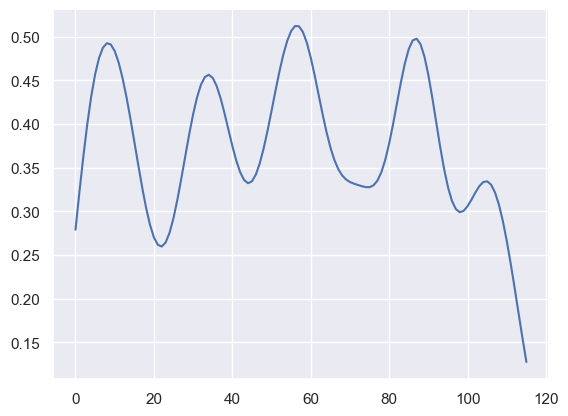

[]
[115]
2395
cuda
epoch 1,loss = 0.99715549
epoch 2,loss = 0.99714637
epoch 3,loss = 0.99713802
epoch 4,loss = 0.99712253
epoch 5,loss = 0.99710494
epoch 6,loss = 0.99708539
epoch 7,loss = 0.99706477
epoch 8,loss = 0.99704337
epoch 9,loss = 0.99702150
epoch 10,loss = 0.99699926
epoch 11,loss = 0.99697655
epoch 12,loss = 0.99695361
epoch 13,loss = 0.99693054
epoch 14,loss = 0.99690735
epoch 15,loss = 0.99688447
epoch 16,loss = 0.99686188
epoch 17,loss = 0.99684036
epoch 18,loss = 0.99682134
epoch 19,loss = 0.99680507
epoch 20,loss = 0.99678993
epoch 21,loss = 0.99677396
epoch 22,loss = 0.99675429
epoch 23,loss = 0.99673170
epoch 24,loss = 0.99670744
epoch 25,loss = 0.99668276
epoch 26,loss = 0.99665797
epoch 27,loss = 0.99663359
epoch 28,loss = 0.99660832
epoch 29,loss = 0.99657905
epoch 30,loss = 0.99654925
epoch 31,loss = 0.99651861
epoch 32,loss = 0.99648172
epoch 33,loss = 0.99643844
epoch 34,loss = 0.99638504
epoch 35,loss = 0.99631894
epoch 36,loss = 0.99623197
epoch 37,loss = 0.

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 44,loss = 0.99400514
epoch 45,loss = 0.99340534
epoch 46,loss = 0.99278581
epoch 47,loss = 0.99218321
epoch 48,loss = 0.99156898
epoch 49,loss = 0.99097061
epoch 50,loss = 0.99040747
epoch 51,loss = 0.98980033
epoch 52,loss = 0.98925030
epoch 53,loss = 0.98884296
epoch 54,loss = 0.98853356
epoch 55,loss = 0.98820549
epoch 56,loss = 0.98786050
epoch 57,loss = 0.98749870
epoch 58,loss = 0.98708153
epoch 59,loss = 0.98668206
epoch 60,loss = 0.98628384
epoch 61,loss = 0.98586118
epoch 62,loss = 0.98541212
epoch 63,loss = 0.98493922
epoch 64,loss = 0.98444420
epoch 65,loss = 0.98393106
epoch 66,loss = 0.98340511
epoch 67,loss = 0.98286772
epoch 68,loss = 0.98232794
epoch 69,loss = 0.98178476
epoch 70,loss = 0.98123533
epoch 71,loss = 0.98067892
epoch 72,loss = 0.98011279
epoch 73,loss = 0.97953993
epoch 74,loss = 0.97895938
epoch 75,loss = 0.97836912
epoch 76,loss = 0.97776622
epoch 77,loss = 0.97716123
epoch 78,loss = 0.97655052
epoch 79,loss = 0.97592378
epoch 80,loss = 0.97528732
e

epoch 372,loss = 0.59713662
epoch 373,loss = 0.59695774
epoch 374,loss = 0.59678143
epoch 375,loss = 0.59660715
epoch 376,loss = 0.59643340
epoch 377,loss = 0.59626108
epoch 378,loss = 0.59608895
epoch 379,loss = 0.59591752
epoch 380,loss = 0.59574813
epoch 381,loss = 0.59557945
epoch 382,loss = 0.59541285
epoch 383,loss = 0.59524786
epoch 384,loss = 0.59508413
epoch 385,loss = 0.59491795
epoch 386,loss = 0.59474510
epoch 387,loss = 0.59457803
epoch 388,loss = 0.59441090
epoch 389,loss = 0.59424871
epoch 390,loss = 0.59408998
epoch 391,loss = 0.59393257
epoch 392,loss = 0.59377515
epoch 393,loss = 0.59361851
epoch 394,loss = 0.59346241
epoch 395,loss = 0.59330815
epoch 396,loss = 0.59315777
epoch 397,loss = 0.59300894
epoch 398,loss = 0.59286374
epoch 399,loss = 0.59272605
epoch 400,loss = 0.59258962
epoch 401,loss = 0.59245515
epoch 402,loss = 0.59232265
epoch 403,loss = 0.59218985
epoch 404,loss = 0.59205359
epoch 405,loss = 0.59192061
epoch 406,loss = 0.59179080
epoch 407,loss = 0.5

epoch 693,loss = 0.57551759
epoch 694,loss = 0.57548380
epoch 695,loss = 0.57544994
epoch 696,loss = 0.57541555
epoch 697,loss = 0.57538092
epoch 698,loss = 0.57534611
epoch 699,loss = 0.57531160
epoch 700,loss = 0.57527727
epoch 701,loss = 0.57524312
epoch 702,loss = 0.57520950
epoch 703,loss = 0.57517612
epoch 704,loss = 0.57514310
epoch 705,loss = 0.57511014
epoch 706,loss = 0.57507724
epoch 707,loss = 0.57504410
epoch 708,loss = 0.57501101
epoch 709,loss = 0.57497764
epoch 710,loss = 0.57494444
epoch 711,loss = 0.57491106
epoch 712,loss = 0.57487786
epoch 713,loss = 0.57484472
epoch 714,loss = 0.57481182
epoch 715,loss = 0.57477903
epoch 716,loss = 0.57474649
epoch 717,loss = 0.57471406
epoch 718,loss = 0.57468170
epoch 719,loss = 0.57464945
epoch 720,loss = 0.57461733
epoch 721,loss = 0.57458532
epoch 722,loss = 0.57455277
epoch 723,loss = 0.57452041
epoch 724,loss = 0.57448781
epoch 725,loss = 0.57445526
epoch 726,loss = 0.57442284
epoch 727,loss = 0.57439035
epoch 728,loss = 0.5

epoch 1017,loss = 0.56607741
epoch 1018,loss = 0.56605160
epoch 1019,loss = 0.56602573
epoch 1020,loss = 0.56599981
epoch 1021,loss = 0.56597382
epoch 1022,loss = 0.56594765
epoch 1023,loss = 0.56592065
epoch 1024,loss = 0.56589329
epoch 1025,loss = 0.56586540
epoch 1026,loss = 0.56583762
epoch 1027,loss = 0.56581008
epoch 1028,loss = 0.56578344
epoch 1029,loss = 0.56575429
epoch 1030,loss = 0.56572437
epoch 1031,loss = 0.56569260
epoch 1032,loss = 0.56565791
epoch 1033,loss = 0.56561506
epoch 1034,loss = 0.56556660
epoch 1035,loss = 0.56551129
epoch 1036,loss = 0.56545681
epoch 1037,loss = 0.56540328
epoch 1038,loss = 0.56535321
epoch 1039,loss = 0.56530374
epoch 1040,loss = 0.56525701
epoch 1041,loss = 0.56521291
epoch 1042,loss = 0.56516898
epoch 1043,loss = 0.56512529
epoch 1044,loss = 0.56508571
epoch 1045,loss = 0.56504810
epoch 1046,loss = 0.56501222
epoch 1047,loss = 0.56497794
epoch 1048,loss = 0.56494576
epoch 1049,loss = 0.56491435
epoch 1050,loss = 0.56488317
epoch 1051,los

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


torch.Size([297, 1, 20])
1.0
Epoch 200:   loss= 0.20542  cluster difference= 1.0
Epoch 400:   loss= 0.20569  cluster difference= 0.016835016835016835
Epoch 600:   loss= 0.20548  cluster difference= 0.02356902356902357
Epoch 800:   loss= 0.20491  cluster difference= 0.02356902356902357
Epoch 1000:   loss= 0.20425  cluster difference= 0.013468013468013467
Epoch 1200:   loss= 0.20355  cluster difference= 0.010101010101010102
Epoch 1400:   loss= 0.20283  cluster difference= 0.013468013468013467
Epoch 1600:   loss= 0.20222  cluster difference= 0.06060606060606061
Epoch 1800:   loss= 0.20205  cluster difference= 0.05387205387205387
Epoch 2000:   loss= 0.2016  cluster difference= 0.013468013468013467
Epoch 2200:   loss= 0.20096  cluster difference= 0.0
[2 3 3 4 6 7 5 2 7 0 2 6 3 4 6 1 0 7 2 1 0 6 7 5 7 2 3 4 5 2 3 4 6 7 2 7 6
 7 2 3 4 7 5 1 3 4 7 0 1 0 7 0 7 5 2 3 4 7 7 2 3 4 0 2 3 4 2 2 3 4 2 7 0 6
 2 7 0 6 1 0 2 7 6 7 2 3 4 6 2 7 5 2 7 0 3 5 7 5 1 1 0 2 3 4 5 7 0 3 4 7 0
 6 1 0 2 1 3 4 2 3 

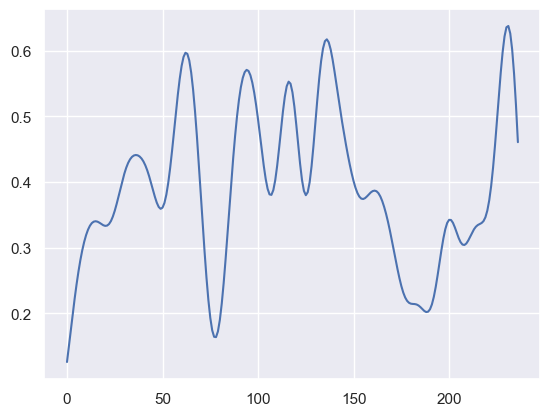

[1338, 2098]
[ 202 2227]
1236
cuda
epoch 1,loss = 1.16160285
epoch 2,loss = 1.15795016
epoch 3,loss = 1.15434980
epoch 4,loss = 1.15080237
epoch 5,loss = 1.14730871
epoch 6,loss = 1.14386928
epoch 7,loss = 1.14048445
epoch 8,loss = 1.13715518
epoch 9,loss = 1.13388181
epoch 10,loss = 1.13066459
epoch 11,loss = 1.12750363
epoch 12,loss = 1.12439919
epoch 13,loss = 1.12135160
epoch 14,loss = 1.11836100
epoch 15,loss = 1.11542714
epoch 16,loss = 1.11255014
epoch 17,loss = 1.10973012
epoch 18,loss = 1.10696673
epoch 19,loss = 1.10425997
epoch 20,loss = 1.10160923
epoch 21,loss = 1.09901452
epoch 22,loss = 1.09647512
epoch 23,loss = 1.09399080
epoch 24,loss = 1.09156108
epoch 25,loss = 1.08918524
epoch 26,loss = 1.08686304
epoch 27,loss = 1.08459377
epoch 28,loss = 1.08237696
epoch 29,loss = 1.08021176
epoch 30,loss = 1.07809758
epoch 31,loss = 1.07603359
epoch 32,loss = 1.07401919
epoch 33,loss = 1.07205355
epoch 34,loss = 1.07013571
epoch 35,loss = 1.06826508
epoch 36,loss = 1.06644070
ep

C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 58,loss = 1.03631103
epoch 59,loss = 1.03531933
epoch 60,loss = 1.03435421
epoch 61,loss = 1.03341508
epoch 62,loss = 1.03250098
epoch 63,loss = 1.03161132
epoch 64,loss = 1.03074539
epoch 65,loss = 1.02990258
epoch 66,loss = 1.02908218
epoch 67,loss = 1.02828348
epoch 68,loss = 1.02750576
epoch 69,loss = 1.02674854
epoch 70,loss = 1.02601099
epoch 71,loss = 1.02529669
epoch 72,loss = 1.02460313
epoch 73,loss = 1.02393436
epoch 74,loss = 1.02329075
epoch 75,loss = 1.02267492
epoch 76,loss = 1.02208674
epoch 77,loss = 1.02152288
epoch 78,loss = 1.02097976
epoch 79,loss = 1.02043152
epoch 80,loss = 1.01989901
epoch 81,loss = 1.01937997
epoch 82,loss = 1.01887321
epoch 83,loss = 1.01837826
epoch 84,loss = 1.01789439
epoch 85,loss = 1.01742136
epoch 86,loss = 1.01695836
epoch 87,loss = 1.01650608
epoch 88,loss = 1.01607287
epoch 89,loss = 1.01565337
epoch 90,loss = 1.01525688
epoch 91,loss = 1.01488745
epoch 92,loss = 1.01455271
epoch 93,loss = 1.01425564
epoch 94,loss = 1.01399219
e

epoch 379,loss = 0.92112738
epoch 380,loss = 0.92078179
epoch 381,loss = 0.92043447
epoch 382,loss = 0.92008412
epoch 383,loss = 0.91973078
epoch 384,loss = 0.91937876
epoch 385,loss = 0.91903079
epoch 386,loss = 0.91868442
epoch 387,loss = 0.91833806
epoch 388,loss = 0.91799760
epoch 389,loss = 0.91765577
epoch 390,loss = 0.91731280
epoch 391,loss = 0.91696918
epoch 392,loss = 0.91662568
epoch 393,loss = 0.91628307
epoch 394,loss = 0.91594428
epoch 395,loss = 0.91561133
epoch 396,loss = 0.91528487
epoch 397,loss = 0.91496134
epoch 398,loss = 0.91463721
epoch 399,loss = 0.91431487
epoch 400,loss = 0.91399282
epoch 401,loss = 0.91366953
epoch 402,loss = 0.91334623
epoch 403,loss = 0.91301948
epoch 404,loss = 0.91268927
epoch 405,loss = 0.91235691
epoch 406,loss = 0.91202265
epoch 407,loss = 0.91169190
epoch 408,loss = 0.91136181
epoch 409,loss = 0.91103309
epoch 410,loss = 0.91070145
epoch 411,loss = 0.91036528
epoch 412,loss = 0.91002810
epoch 413,loss = 0.90968817
epoch 414,loss = 0.9

epoch 676,loss = 0.82017362
epoch 677,loss = 0.81966108
epoch 678,loss = 0.81916684
epoch 679,loss = 0.81866068
epoch 680,loss = 0.81815183
epoch 681,loss = 0.81764543
epoch 682,loss = 0.81716985
epoch 683,loss = 0.81669605
epoch 684,loss = 0.81620866
epoch 685,loss = 0.81573039
epoch 686,loss = 0.81526226
epoch 687,loss = 0.81479704
epoch 688,loss = 0.81432545
epoch 689,loss = 0.81384873
epoch 690,loss = 0.81337249
epoch 691,loss = 0.81291288
epoch 692,loss = 0.81246567
epoch 693,loss = 0.81202173
epoch 694,loss = 0.81158084
epoch 695,loss = 0.81114507
epoch 696,loss = 0.81071216
epoch 697,loss = 0.81028283
epoch 698,loss = 0.80985093
epoch 699,loss = 0.80941832
epoch 700,loss = 0.80898410
epoch 701,loss = 0.80854446
epoch 702,loss = 0.80811393
epoch 703,loss = 0.80768579
epoch 704,loss = 0.80723524
epoch 705,loss = 0.80674773
epoch 706,loss = 0.80624264
epoch 707,loss = 0.80571741
epoch 708,loss = 0.80517274
epoch 709,loss = 0.80465204
epoch 710,loss = 0.80416280
epoch 711,loss = 0.8

epoch 983,loss = 0.74940974
epoch 984,loss = 0.74930650
epoch 985,loss = 0.74921912
epoch 986,loss = 0.74913478
epoch 987,loss = 0.74905223
epoch 988,loss = 0.74893409
epoch 989,loss = 0.74879307
epoch 990,loss = 0.74865347
epoch 991,loss = 0.74849099
epoch 992,loss = 0.74831980
epoch 993,loss = 0.74817765
epoch 994,loss = 0.74803954
epoch 995,loss = 0.74788290
epoch 996,loss = 0.74772805
epoch 997,loss = 0.74759716
epoch 998,loss = 0.74749070
epoch 999,loss = 0.74740267
epoch 1000,loss = 0.74732447
epoch 1001,loss = 0.74723828
epoch 1002,loss = 0.74716383
epoch 1003,loss = 0.74706262
epoch 1004,loss = 0.74697781
epoch 1005,loss = 0.74688435
epoch 1006,loss = 0.74677271
epoch 1007,loss = 0.74667573
epoch 1008,loss = 0.74656028
epoch 1009,loss = 0.74646497
epoch 1010,loss = 0.74635607
epoch 1011,loss = 0.74626213
epoch 1012,loss = 0.74616009
epoch 1013,loss = 0.74604493
epoch 1014,loss = 0.74596113
epoch 1015,loss = 0.74585831
epoch 1016,loss = 0.74576914
epoch 1017,loss = 0.74570602
ep

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


torch.Size([152, 1, 20])
1.0
Epoch 200:   loss= 0.18444  cluster difference= 1.0
Epoch 400:   loss= 0.18151  cluster difference= 0.006578947368421052
[0 0 0 0 0 0 5 0 0 0 0 0 1 0 0 0 0 5 0 0 7 0 2 6 0 2 5 0 0 0 5 0 6 2 4 6 2
 7 0 1 6 0 7 0 0 2 5 0 0 0 0 0 2 3 0 4 0 2 3 2 6 2 4 6 0 0 0 7 2 6 2 2 3 2
 2 3 0 1 6 2 3 2 6 0 7 0 1 6 7 0 7 0 5 0 0 5 1 6 7 1 6 1 6 2 6 0 6 1 3 0 7
 0 2 5 6 1 6 0 0 2 4 6 0 5 0 1 7 0 5 0 5 1 2 3 2 6 0 0 5 0 5 0 1 6 7 1 6 5
 2 6 0 7]


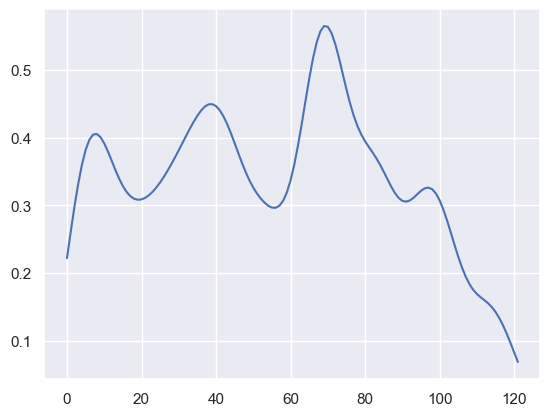

[]
[435 786]
15974
cuda
epoch 1,loss = 0.99999726
epoch 2,loss = 0.99999589
epoch 3,loss = 0.99999470
epoch 4,loss = 0.99999350
epoch 5,loss = 0.99999243
epoch 6,loss = 0.99999136
epoch 7,loss = 0.99999040
epoch 8,loss = 0.99998939


C:\Users\Erik\AppData\Local\Temp\ipykernel_9916\159405964.py:57: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])


epoch 9,loss = 0.99998844
epoch 10,loss = 0.99998766
epoch 11,loss = 0.99998689
epoch 12,loss = 0.99998611
epoch 13,loss = 0.99998552
epoch 14,loss = 0.99998492
epoch 15,loss = 0.99998432
epoch 16,loss = 0.99998373
epoch 17,loss = 0.99998337
epoch 18,loss = 0.99998283
epoch 19,loss = 0.99998248
epoch 20,loss = 0.99998206
epoch 21,loss = 0.99998188
epoch 22,loss = 0.99998158
epoch 23,loss = 0.99998140
epoch 24,loss = 0.99998116
epoch 25,loss = 0.99998099
epoch 26,loss = 0.99998081
epoch 27,loss = 0.99998069
epoch 28,loss = 0.99998063
epoch 29,loss = 0.99998063
epoch 30,loss = 0.99998033
epoch 31,loss = 0.99997944
epoch 32,loss = 0.99997926
epoch 33,loss = 0.99998063
epoch 34,loss = 0.99998063
epoch 35,loss = 0.99997979
epoch 36,loss = 0.99997854
epoch 37,loss = 0.99997866
epoch 38,loss = 0.99997926
epoch 39,loss = 0.99997944
epoch 40,loss = 0.99997902
epoch 41,loss = 0.99997842
epoch 42,loss = 0.99997813
epoch 43,loss = 0.99997824
epoch 44,loss = 0.99997884
epoch 45,loss = 0.99997866
ep

epoch 307,loss = 0.98211563
epoch 308,loss = 0.98137522
epoch 309,loss = 0.98062629
epoch 310,loss = 0.97986686
epoch 311,loss = 0.97909570
epoch 312,loss = 0.97831571
epoch 313,loss = 0.97752291
epoch 314,loss = 0.97671211
epoch 315,loss = 0.97588617
epoch 316,loss = 0.97505403
epoch 317,loss = 0.97422659
epoch 318,loss = 0.97339052
epoch 319,loss = 0.97254539
epoch 320,loss = 0.97169602
epoch 321,loss = 0.97084397
epoch 322,loss = 0.96998715
epoch 323,loss = 0.96912229
epoch 324,loss = 0.96825558
epoch 325,loss = 0.96738917
epoch 326,loss = 0.96652246
epoch 327,loss = 0.96565360
epoch 328,loss = 0.96478492
epoch 329,loss = 0.96391428
epoch 330,loss = 0.96303940
epoch 331,loss = 0.96216166
epoch 332,loss = 0.96128386
epoch 333,loss = 0.96040666
epoch 334,loss = 0.95952833
epoch 335,loss = 0.95864904
epoch 336,loss = 0.95776904
epoch 337,loss = 0.95688927
epoch 338,loss = 0.95601344
epoch 339,loss = 0.95513850
epoch 340,loss = 0.95426571
epoch 341,loss = 0.95340419
epoch 342,loss = 0.9

epoch 614,loss = 0.72073907
epoch 615,loss = 0.72066063
epoch 616,loss = 0.72058368
epoch 617,loss = 0.72050810
epoch 618,loss = 0.72043377
epoch 619,loss = 0.72036076
epoch 620,loss = 0.72028911
epoch 621,loss = 0.72021842
epoch 622,loss = 0.72014892
epoch 623,loss = 0.72008073
epoch 624,loss = 0.72001320
epoch 625,loss = 0.71994656
epoch 626,loss = 0.71988064
epoch 627,loss = 0.71981567
epoch 628,loss = 0.71975136
epoch 629,loss = 0.71968782
epoch 630,loss = 0.71962529
epoch 631,loss = 0.71956360
epoch 632,loss = 0.71950263
epoch 633,loss = 0.71944219
epoch 634,loss = 0.71938241
epoch 635,loss = 0.71932340
epoch 636,loss = 0.71926498
epoch 637,loss = 0.71920717
epoch 638,loss = 0.71915001
epoch 639,loss = 0.71909344
epoch 640,loss = 0.71903741
epoch 641,loss = 0.71898198
epoch 642,loss = 0.71892697
epoch 643,loss = 0.71887249
epoch 644,loss = 0.71881843
epoch 645,loss = 0.71876484
epoch 646,loss = 0.71871185
epoch 647,loss = 0.71865940
epoch 648,loss = 0.71860737
epoch 649,loss = 0.7

epoch 912,loss = 0.71004903
epoch 913,loss = 0.71002752
epoch 914,loss = 0.71000594
epoch 915,loss = 0.70998442
epoch 916,loss = 0.70996290
epoch 917,loss = 0.70994139
epoch 918,loss = 0.70991993
epoch 919,loss = 0.70989859
epoch 920,loss = 0.70987719
epoch 921,loss = 0.70985597
epoch 922,loss = 0.70983475
epoch 923,loss = 0.70981354
epoch 924,loss = 0.70979244
epoch 925,loss = 0.70977134
epoch 926,loss = 0.70975024
epoch 927,loss = 0.70972937
epoch 928,loss = 0.70970845
epoch 929,loss = 0.70968759
epoch 930,loss = 0.70966673
epoch 931,loss = 0.70964599
epoch 932,loss = 0.70962524
epoch 933,loss = 0.70960444
epoch 934,loss = 0.70958388
epoch 935,loss = 0.70956326
epoch 936,loss = 0.70954275
epoch 937,loss = 0.70952231
epoch 938,loss = 0.70950198
epoch 939,loss = 0.70948160
epoch 940,loss = 0.70946127
epoch 941,loss = 0.70944095
epoch 942,loss = 0.70942068
epoch 943,loss = 0.70940053
epoch 944,loss = 0.70938033
epoch 945,loss = 0.70936018
epoch 946,loss = 0.70934016
epoch 947,loss = 0.7

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=8.
  warnings.warn(


torch.Size([1995, 1, 20])
1.0
Epoch 200:   loss= 0.20296  cluster difference= 1.0
Epoch 400:   loss= 0.20268  cluster difference= 0.05263157894736842
Epoch 600:   loss= 0.20258  cluster difference= 0.04661654135338346
Epoch 800:   loss= 0.20257  cluster difference= 0.03107769423558897
Epoch 1000:   loss= 0.20256  cluster difference= 0.020050125313283207
Epoch 1200:   loss= 0.20254  cluster difference= 0.012531328320802004
Epoch 1400:   loss= 0.2025  cluster difference= 0.007017543859649123
[0 1 4 ... 7 1 2]


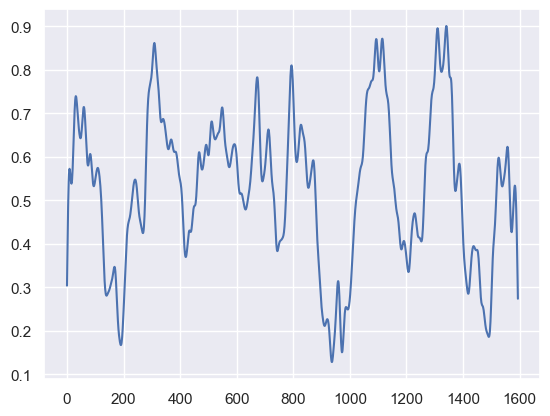

[1858, 4082, 6002, 7962, 10530, 12338, 14066]
[7295]


In [212]:
# Hyper parameters for Neural Network
epochs1 = 1200
epochs2 = 6000
lr=0.1
pre_lr = 1.5e-3

# DC-TSS hyper-parameters
overlap_percent = 0.6
n_clusters = 8
window_length2 = 100

coverings3 = []

for i,time_series in enumerate(data):
    print(len(time_series))
    time_series = (time_series - np.average(time_series)) / np.std(time_series)
    labels = []
    h = 0
    y = 0
    for j,_ in enumerate(time_series):
        if j == ground_truth[y]:
            y+=1
            h+=1
        labels.append(h)
    l = np.unique(labels)
        
    window_length = windows[i]
    if window_length < 20:
        window_length = 20
        layers = [5,3,2]
        strides = [2,1,1]
    elif window_length > 100:
        window_length = 100
        layers = [15,10,5]
        strides = [2,2,2]
    elif window_length >= 40 and window_length <=80:
        layers = [10,6,4]
        strides = [2,2,2]
    elif window_length < 40:
        layers = [5,3,2]
        strides = [2,1,1]
    elif window_length > 80:
        layers = [10,6,4]
        strides = [2,2,2]
        
    window_length2 = 60
    if window_length2 % 2 == 1:
        window_length2 += 1

    # Subsequence Univariate TS
    start = 0
    subsequences = []
    subsequence_labels = []

    while start+window_length < len(time_series):
        subsequence_labels.append(st.mode(labels[start:start+window_length])[0][0])    
        subsequence = time_series[start:start+window_length]
        start = start+window_length - int(overlap_percent*window_length)
        subsequences.append(subsequence)

    subsequences = np.asarray(subsequences)
    subsequence_labels = np.asarray(subsequence_labels)
    batch_size = len(subsequences)

    subsequences = np.expand_dims(subsequences, axis=1)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)


    data_loader = get_dataloader(data=subsequences,
                              shuffle=False,
                              batch_size=batch_size,
                              data_transforms=None)
    torch.cuda.empty_cache()
    input_shape = subsequences.shape
    
    deep_cluster_model = DEC(n_clusters = n_clusters, input_shape=input_shape,k_sizes=layers,strides=strides)
    deep_cluster_model.to(device)
    pretraining(model=deep_cluster_model, dbgenerator=data_loader, batch_size=batch_size, epochs=epochs1,lr=pre_lr)


    # refine mapping
    cluster_assignments = refine_clusters(n_clusters, data_loader, deep_cluster_model, device, epochs2, batch_size, lr, 0.0, 1)
    print(cluster_assignments)
    while ( (not all(l[i] == l[i+1] -1 for i in range(len(l) - 1))) or (l[0] != 0) ):
        for assignment in range(np.max(cluster_assignments)+1):
            if assignment not in cluster_assignments:
                indx = np.where(cluster_assignments > assignment)
                cluster_assignments[indx] = cluster_assignments[indx]-1
        l = np.unique(cluster_assignments)
    
    window_length2 = int(0.2*len(cluster_assignments))
    if window_length2 % 2 == 1:
        window_length2 += 1
    similarities = get_label_score(cluster_assignments, window_length2)
    try:
        d = (similarities - np.min(similarities)) / (np.max(similarities) - np.min(similarities))
    except:
        d = similarities
    
    if window_length2 % 2 == 1:
        window_length2 += 1
    d = smooth(np.blackman(30), d)
    peaks, peak_data = find_peaks(d, height=0.6,distance=window_length2//2,prominence=0.15)
    real_peaks = peaks+window_length2//2
    plt.plot(d)
    plt.show()
    predictions = get_changepoints(real_peaks, window_length, overlap_percent)
    print(predictions)
    print(ground_truth[i])
    coverings3.append(covering(ground_truth[i], predictions, len(time_series)))


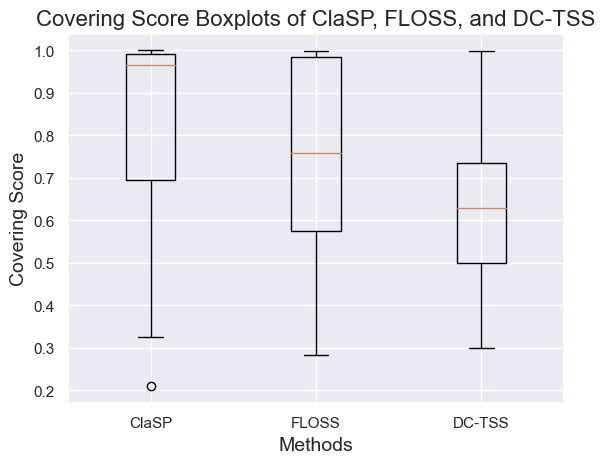

In [228]:
plt.boxplot([coverings1, coverings2, coverings3], labels=['ClaSP', 'FLOSS', 'DC-TSS'])
plt.title("Covering Score Boxplots of ClaSP, FLOSS, and DC-TSS",fontsize=16)
plt.ylabel("Covering Score", fontsize=14)
plt.xlabel("Methods", fontsize=14)
plt.savefig('boxplot.png',dpi=800)
plt.show()